# Imports

In [1]:
%pip install fiftyone --user
import fiftyone
# You don't have to run this cell, if you already have dataset on machine

DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import transformers
import tensorflow as tf
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

2023-12-31 02:59:20.583444: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-31 02:59:20.654827: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-31 02:59:20.654868: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-31 02:59:20.654971: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-31 02:59:20.679961: I tensorflow/core/platform/cpu_feature_g

In [2]:
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [3]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print('GPU enable')
    except Exception as e:
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU enable


2023-12-31 02:59:22.794923: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-31 02:59:22.814901: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-31 02:59:22.814930: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


# Data

Load and prepare your dataset. It should consist of at least 50k images from any openimages split.

In [4]:
dataset = fiftyone.zoo.load_zoo_dataset('open-images-v7', split='train', label_types=['classifications'], max_samples=55000)
# You don't have to run this cell, if you already have dataset on machine
# If you don't have dataset, run this cell and then move directory with images near to this file
# On Windows it will be like this "C:\Users\user\fiftyone\open-images-v7\train\data"
# You have to move the "data" directory to this notebook 

Necessary images already downloaded
Existing download of split 'train' is sufficient
Loading existing dataset 'open-images-v7-train-55000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [4]:
root_path = '/home/kitfloppa/fiftyone/open-images-v7/train/data/'
images = os.listdir(f'{root_path}/')

In [5]:
filepaths = []

for filename in images:
    file = f'{root_path}/{filename}'
    filepaths.append(file)

In [6]:
pd_data = pd.DataFrame(
        filepaths,
        columns=['filepaths']
        )

In [7]:
pd_data.head(10)

filepaths
0  /home/kitfloppa/fiftyone/open-images-v7/train/...
1  /home/kitfloppa/fiftyone/open-images-v7/train/...
2  /home/kitfloppa/fiftyone/open-images-v7/train/...
3  /home/kitfloppa/fiftyone/open-images-v7/train/...
4  /home/kitfloppa/fiftyone/open-images-v7/train/...
5  /home/kitfloppa/fiftyone/open-images-v7/train/...
6  /home/kitfloppa/fiftyone/open-images-v7/train/...
7  /home/kitfloppa/fiftyone/open-images-v7/train/...
8  /home/kitfloppa/fiftyone/open-images-v7/train/...
9  /home/kitfloppa/fiftyone/open-images-v7/train/...

# Image augmentation and crops

Implement image augmentation and crops as described in DINO.

In [8]:
paths_dataset = tf.data.Dataset.from_tensor_slices(pd_data.filepaths)

2023-12-31 02:59:27.178578: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-31 02:59:27.178625: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-31 02:59:27.178636: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-31 02:59:27.839803: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-31 02:59:27.839842: I tensorflow/compile

In [9]:
@tf.function
def geometric_augmentation(image, size, crop_scale):
    flag = tf.constant(True)
    while flag:
        ratio = tf.random.uniform([], 0.4, 1)
        scale = tf.random.uniform([], *crop_scale)
        
        shapes = tf.shape(image)[0], tf.shape(image)[1]

        crop_size = tf.cast(shapes[0], dtype=tf.float32) * scale, tf.cast(shapes[1], dtype=tf.float32) * scale
        crop_size = tf.cast(tf.math.sqrt(crop_size[0] ** 2 * ratio), dtype=tf.int32), tf.cast(tf.math.sqrt(crop_size[1] ** 2 / ratio), dtype=tf.int32)

        if crop_size[0] <= shapes[0] and crop_size[1] <= shapes[1]:
            flag = tf.constant(False)


    image = tf.image.random_crop(image, size=(crop_size[0], crop_size[1], 3))
    image = tf.image.resize(image, size=(size, size))
    #image = tf.image.flip_left_right(image)
    return image

In [10]:
@tf.function
def color_transform(image):
    p1 = tf.random.uniform((), maxval=1)
    p2 = tf.random.uniform((), maxval=1)
    if p1 >= 0.2:
        image = tf.image.random_brightness(image, 0.4)
        image = tf.image.random_contrast(image, 0.6, 1.4)
        image = tf.image.random_saturation(image, 0.8, 1.2)
        image = tf.image.random_hue(image, 0.1)

    if p2 >= 0.8:
        image = tf.image.rgb_to_grayscale(image)
        image = tf.repeat(image, 3, 2)
    
    return image

In [11]:
@tf.function
def gaussian_filter(image, probability): # global_transfo1_extra
    p = tf.random.uniform((), maxval=1)
    
    if p >= probability:
        rng = np.random.default_rng()
        sigma = rng.uniform(0.1, 2)
        image = tfa.image.gaussian_filter2d(image, (9, 9), sigma=sigma, padding='REFLECT')
    
    return image

In [12]:
@tf.function
def random_solarize(image, threshold=128, p=0.2):
    if tf.random.uniform((), maxval=1) > p:
        return image
    
    mask = image > threshold
    masked_image = tf.where(mask, 255 - image, image)

    return masked_image

In [13]:
@tf.function
def normalize(image):
    return (image - 0.5) * 2

In [14]:
@tf.function
def dino_augmentation(image, global_crops_scale=(0.14, 1), local_crops_scale=(0.05, 0.4), local_crops_number=3, global_crops_size=224, local_crops_size=96):
    output = {}

    # global crops
    im1_base = geometric_augmentation(image, global_crops_size, global_crops_scale)
    global_crop_1 = normalize(gaussian_filter(color_transform(im1_base), 0))

    im2_base = geometric_augmentation(image, global_crops_size, global_crops_scale)
    global_crop_2 = normalize(random_solarize(gaussian_filter(color_transform(im2_base), 0.9)))

    output['global_crops'] = [global_crop_1, global_crop_2]

    local_crops = [
            normalize(gaussian_filter(color_transform(geometric_augmentation(image, local_crops_size, local_crops_scale)), 0.5)) for _ in range(local_crops_number)
        ]
    
    output["local_crops"] = local_crops

    return output

In [15]:
image1 = tf.image.convert_image_dtype(tf.io.decode_image(tf.io.read_file(root_path + '000db2c0d9a1465e.jpg'), expand_animations=False, channels=3), dtype=tf.float32)

In [16]:
image = geometric_augmentation(image1, 224, (0.14, 1))
image = tf.cast(image, tf.uint8)
#plt.imshow(image.numpy())

2023-12-31 02:59:31.384557: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [17]:
image.shape, image1.shape

(TensorShape([224, 224, 3]), TensorShape([1024, 768, 3]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


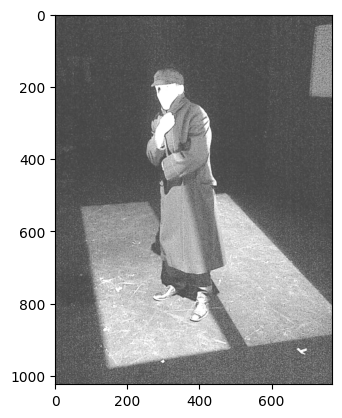

In [18]:
image = color_transform(image1)
plt.imshow(image.numpy())

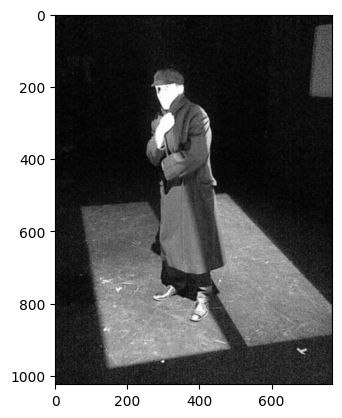

In [19]:
image = gaussian_filter(image1, 0.2)
plt.imshow(image.numpy())

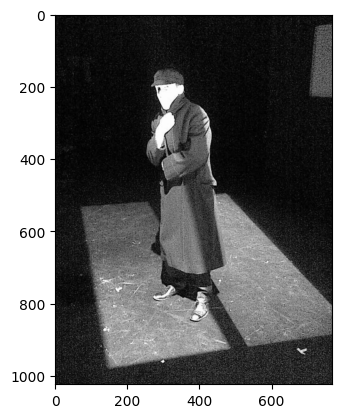

In [20]:
image = random_solarize(image1)
plt.imshow(image.numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


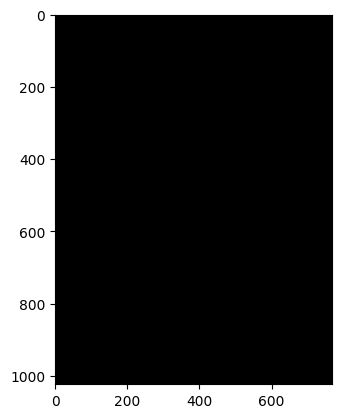

In [21]:
image = normalize(tf.cast(image1, dtype=tf.float32))
plt.imshow(tf.cast(image, dtype=tf.int8).numpy())

In [22]:
def load_image_global(x):
    data = tf.image.convert_image_dtype(tf.io.decode_image(tf.io.read_file(x), expand_animations=False, channels=3), dtype=tf.float32)

    if data.shape[2] == 1:
        data = tf.repeat(data, 3, 2)
    
    print(data.shape)

    data = dino_augmentation(data)
    
    return data['global_crops']

In [23]:
def load_image_local(x):
    data = tf.image.convert_image_dtype(tf.io.decode_image(tf.io.read_file(x), expand_animations=False, channels=3), dtype=tf.float32)

    if data.shape[2] == 1:
        data = tf.repeat(data, 3, 2)
    
    data = dino_augmentation(data)
    
    return data['local_crops']

In [24]:
image_dataset_global = paths_dataset.map(load_image_global)
image_dataset_local = paths_dataset.map(load_image_local)

(None, None, 3)


In [25]:
batch_image_dataset_global= image_dataset_global.batch(64)
batch_image_dataset_local= image_dataset_local.batch(64)

# Losses

Implement the losses and loss additions. DINO, koleo, sinkhorn_knopp, softmax_centering.

## DINO

In [62]:
class DinoLoss(tf.keras.losses.Loss):
    def __init__(
            self,
            ncrops,
            warmup_teacher_temp,
            teacher_temp,
            warmup_teacher_temp_epochs,
            nepochs,
            student_temp=0.1,
            center_momentum=0.9
        ) -> None:
        super().__init__()
        self.student_temp = student_temp
        self.center_momentum = center_momentum
        self.ncrops = ncrops

        self.teacher_temp_schedule = tf.concat(
            (
                tf.linspace(warmup_teacher_temp, teacher_temp, warmup_teacher_temp_epochs),
                tf.ones((nepochs - warmup_teacher_temp_epochs)) * teacher_temp,
            ),
            axis=0,
        )


    def update_center(self, teacher_output) -> None:
        '''
        Update center used for teacher output.
        
        In article pseudocode -> C = m * C + (1-m) * cat([t1, t2]).mean(dim=0)
        '''

        batch_center = tf.math.reduce_sum(teacher_output, axis=0)
        batch_center = batch_center / tf.cast(len(teacher_output), tf.float32)
        
        self.center = tf.stop_gradient(self.center * self.center_momentum
                                       + batch_center * (1 - self.center_momentum))
        

    def softmax_center_teacher(self, teacher_output, teacher_temp):
        '''
        Center + sharpen for teacher

        In article pseudocode -> t = softmax((t - C) / tpt, dim=1)
        '''
        
        teacher_out = tf.stop_gradient(
            tf.nn.softmax((teacher_output - self.center) / teacher_temp, axis=-1)
        )
        
        return teacher_out
    

    def sinkhorn_knopp_teacher(self, teacher_output, teacher_temp, n_iterations=3):
        '''
        Sinkhorn-Knopp centering https://arxiv.org/pdf/2006.09882.pdf (14 page)
        '''

        Q = tf.transpose(tf.math.exp(teacher_output / teacher_temp))
        Q /= tf.reduce_sum(Q)
        K, B = Q.shape

        for _ in range(n_iterations):
            Q /= tf.reduce_sum(Q, axis=1)
            Q /= K

            Q /= tf.reduce_sum(Q, axis=0)
            Q /= B

        Q *= B

        return tf.transpose(Q)


    def forward(self, student_output, teacher_output, epoch, centering='softmax_center'):
        '''
        Cross-entropy between softmax outputs of the teacher and student networks.
        '''
        
        total_loss = 0

        teacher_output = tf.cast(teacher_output, tf.float32)
        student_output = tf.cast(student_output, tf.float32)

        student_out = student_output / self.student_temp
        student_out = tf.split(student_out, num_or_size_splits=self.ncrops)

        # teacher centering and sharpening
        self.center = tf.zeros_like(teacher_output, dtype=tf.float32)
        
        if centering == 'softmax_center':
            teacher_out = self.softmax_center_teacher(teacher_output, self.teacher_temp_schedule[epoch])
        elif centering == 'sinkhorn_knopp':
            teacher_out = self.sinkhorn_knopp_teacher(teacher_output, self.teacher_temp_schedule[epoch])
        else:
            raise ValueError('Wrang centering algorithm')
        
        teacher_out = tf.split(
            tf.tile(teacher_out, tf.constant([2, 1], tf.int32)), num_or_size_splits=1
        )

        total_loss = 0
        n_loss_terms = 0

        for iq, q in enumerate(teacher_out):
            for v in range(len(student_out)):
                q = tf.stop_gradient(q)
                
                if v == iq:
                    # skip cases where student and teacher operate on the same view
                    continue
                
                loss = tf.reduce_sum(-q * tf.nn.log_softmax(student_out[v], axis=-1), axis=-1)
                total_loss += tf.math.reduce_mean(loss)
                n_loss_terms += 1
        
        total_loss /= n_loss_terms
        self.update_center(teacher_output)
        
        return total_loss


## KoLeo

In [27]:
# Kozachenko-Leonenko entropic loss regularizer from Sablayrolles et al. - 2018 - Spreading vectors for similarity search
# Article -> https://arxiv.org/pdf/1806.03198.pdf

class KoLeoLoss(tf.keras.losses.Loss):
    
    def __init__(self) -> None:
        super().__init__()

    
    def pairwise_NNs_inner(self, x):
        dots = tf.linalg.matmul(x, tf.transpose(x))
        n = x.shape[0]

        dots = tf.linalg.set_diag(dots, np.array([-1] * n))

        return tf.math.argmax(dots, 1)
        

    def forward(self, student_output, eps=1e-8): 
        student_output = tf.nn.l2_normalize(student_output, axis=1, epsilon=eps)
        idx = self.pairwise_NNs_inner(student_output)

        distances = tf.norm(student_output - student_output[idx], ord='euclidean')
         
        return -tf.math.reduce_mean(tf.math.log(distances + eps))


# Backbone

Implement transofmer model as described in DINO, including the DINO head. Don't forget the teacher weights update.

In [28]:
import tensorflow as tf
import tensorflow_addons as tfa

from vit_tensorflow import ViT

In [29]:
class DinoHead(tf.keras.models.Model):
    def __init__(
        self,
        in_dim=768,
        out_dim=65536,
        norm_last_layer=True,
        nlayers=3,
        hidden_dim=2048,
        bottleneck_dim=256,
    ):
        super(DinoHead, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.nlayers = nlayers
        self.hidden_dim = hidden_dim
        self.bottleneck_dim = bottleneck_dim
        self.norm_last_layer = norm_last_layer
        self.out_layer = tf.keras.layers.Dense(self.out_dim)

        self.mlp_block = self.mlp()


    def mlp(self):
        layer = []
        layer.append(tf.keras.layers.Dense(self.hidden_dim, input_shape=(self.in_dim,)))
        
        layer.append(tfa.layers.GELU())
        
        for _ in range(self.nlayers - 2):
            layer.append(tf.keras.layers.Dense(self.hidden_dim))
        
        layer.append(tfa.layers.GELU())
        layer.append(tf.keras.layers.Dense(self.bottleneck_dim))
        
        return tf.keras.Sequential(layer)

    def call(self, input_tensor, training=None):
        x = self.mlp_block(input_tensor, training)
        x = tf.nn.l2_normalize(x, axis=-1)
        
        x = self.out_layer(x)

        return x

In [105]:
def backboune(image_size, include_pretrained=True):
    model = vit.vit_b16(
        image_size=image_size,
        pretrained=include_pretrained,
        pretrained_top=False,
        include_top=False,
    )
    
    return model

In [106]:
_backboune_global = backboune(224)
_backboune_local = backboune(96)

Since we will not be training the backbone, extract features from your dataset.

Run the backbone on the images and save the extracted features. Don't forget to process the images. Images don't have to be of the same size, though it would be faster if they were. If the images don't fit in memory, lazily load them from disk

In [33]:
future_ext_global = _backboune_global.predict(batch_image_dataset_global)

860/860 [==============================] - 328s 381ms/step


In [36]:
future_ext_global

array([[ 1.2146311 , -0.25050586, -1.6036128 , ...,  0.30149773,
         0.5964849 , -0.26063037],
       [-0.7668297 , -1.3473557 ,  1.1876886 , ..., -0.25477198,
        -0.01949224, -0.22765255],
       [-0.32152027,  0.8560562 , -0.08760641, ...,  0.08057146,
        -1.3119535 ,  0.5774826 ],
       ...,
       [ 0.73836523,  0.12186977,  0.10961302, ..., -1.9563755 ,
         1.1461658 ,  0.05093738],
       [-0.08050679, -0.53838646, -0.6065442 , ..., -1.0312573 ,
        -0.24587792,  0.03731481],
       [ 0.82583207,  0.901143  , -1.792011  , ..., -0.25058296,
        -0.44691172, -1.1015044 ]], dtype=float32)

In [35]:
future_ext_global.shape

(55000, 768)

In [ ]:
future_ext_local = _backboune_local.predict(batch_image_dataset_local)

In [ ]:
future_ext_local

In [ ]:
future_ext_local.shape

# Training

Train the model as described in DINO.

In [107]:
class Dino(tf.keras.Model):
    def __init__(self, dino_head, backbone):
        super().__init__()
        self.dense1 = dino_head
        self.dense2 = backbone

    def call(self, inputs):
        x = self.dense2(inputs)
        return self.dense1(x)

In [117]:
_lambda = 0.996

teacher_head = DinoHead()
student_head = DinoHead()

dino_loss = DinoLoss(3, 0.04, 0.04, 0, 5)

teacher = backboune(224)
student = backboune(96)

optimizer = tf.keras.optimizers.Adam(0.01)

teacher_dino = Dino(teacher_head, teacher)
student_dino = Dino(student_head, student)

teacher_dino.build((None, 224, 224, 3))
student_dino.build((None, 96, 96, 3))

print(teacher_dino.dense2.summary())
print(student_dino.dense2.summary())

for epoch in range(2):
   for global_images, local_images in zip(image_dataset_global, image_dataset_local):
      
      with tf.GradientTape() as tape:
         teacher_output = teacher_dino(tf.stack(global_images, 0))
         student_output = student_dino(tf.stack(local_images, 0))
         loss = dino_loss.forward(student_output, teacher_output, epoch)

         print(loss)
         
      student_gradients = tape.gradient(
               loss, student_dino.trainable_variables
         )
      
      optimizer.apply_gradients(
               zip(student_gradients, student_dino.trainable_variables)
         )
      
      for i in range(len(teacher_dino.trainable_variables)):
         try:
            teacher_dino.trainable_variables[i].assign(_lambda * teacher_dino.trainable_variables[i] + (1 - _lambda) * student_dino.trainable_variables[i])
         except:
            print()

/home/kitfloppa/.local/lib/python3.10/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(
/home/kitfloppa/.local/lib/python3.10/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 6, 6
  warnings.warn(


Model: "vit-b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_120 (InputLayer)      [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape_119 (Reshape)       (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input  (None, 197, 768)          151296    
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 197, 768),        7087872   
  (TransformerBlock)          (None, 12, None, None)       

2023-12-31 06:21:08.860241: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.094858, shape=(), dtype=float32)



2023-12-31 06:21:10.616873: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.16175, shape=(), dtype=float32)



2023-12-31 06:21:11.590037: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.12278, shape=(), dtype=float32)



2023-12-31 06:21:12.512695: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.155501, shape=(), dtype=float32)



2023-12-31 06:21:13.425787: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.105594, shape=(), dtype=float32)



2023-12-31 06:21:14.318518: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.122546, shape=(), dtype=float32)



2023-12-31 06:21:15.243265: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.113317, shape=(), dtype=float32)



2023-12-31 06:21:16.148876: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.107019, shape=(), dtype=float32)



2023-12-31 06:21:17.090171: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.110551, shape=(), dtype=float32)



2023-12-31 06:21:18.005474: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.108828, shape=(), dtype=float32)



2023-12-31 06:21:18.928736: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.105186, shape=(), dtype=float32)



2023-12-31 06:21:19.843951: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.104446, shape=(), dtype=float32)



2023-12-31 06:21:20.755445: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.103758, shape=(), dtype=float32)



2023-12-31 06:21:21.645718: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.101849, shape=(), dtype=float32)



2023-12-31 06:21:22.547329: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.099606, shape=(), dtype=float32)



2023-12-31 06:21:23.452484: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.097221, shape=(), dtype=float32)



2023-12-31 06:21:24.346641: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.092847, shape=(), dtype=float32)



2023-12-31 06:21:25.253938: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.093311, shape=(), dtype=float32)



2023-12-31 06:21:26.163847: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.091946, shape=(), dtype=float32)



2023-12-31 06:21:27.074325: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.089975, shape=(), dtype=float32)



2023-12-31 06:21:27.979221: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.088657, shape=(), dtype=float32)



2023-12-31 06:21:28.871073: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.087648, shape=(), dtype=float32)



2023-12-31 06:21:29.770377: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.08721, shape=(), dtype=float32)



2023-12-31 06:21:30.710900: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.086587, shape=(), dtype=float32)



2023-12-31 06:21:31.616820: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.085619, shape=(), dtype=float32)



2023-12-31 06:21:32.502824: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.084852, shape=(), dtype=float32)



2023-12-31 06:21:33.408249: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.084334, shape=(), dtype=float32)



2023-12-31 06:21:34.306473: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.083814, shape=(), dtype=float32)



2023-12-31 06:21:35.202661: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.083386, shape=(), dtype=float32)



2023-12-31 06:21:36.111800: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.082903, shape=(), dtype=float32)



2023-12-31 06:21:37.034420: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.0823765, shape=(), dtype=float32)



2023-12-31 06:21:37.978212: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.082021, shape=(), dtype=float32)



2023-12-31 06:21:38.896969: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.081627, shape=(), dtype=float32)



2023-12-31 06:21:39.834839: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.081272, shape=(), dtype=float32)



2023-12-31 06:21:40.732482: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.080927, shape=(), dtype=float32)



2023-12-31 06:21:41.658053: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.08058, shape=(), dtype=float32)



2023-12-31 06:21:42.592609: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.080284, shape=(), dtype=float32)



2023-12-31 06:21:43.510918: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.079987, shape=(), dtype=float32)



2023-12-31 06:21:44.431184: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.079704, shape=(), dtype=float32)



2023-12-31 06:21:45.332705: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.079441, shape=(), dtype=float32)



2023-12-31 06:21:46.225070: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.07917, shape=(), dtype=float32)



2023-12-31 06:21:47.105748: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.078931, shape=(), dtype=float32)



2023-12-31 06:21:47.982206: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.0786915, shape=(), dtype=float32)



2023-12-31 06:21:48.864922: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.07848, shape=(), dtype=float32)



2023-12-31 06:21:49.771627: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.0782385, shape=(), dtype=float32)



2023-12-31 06:21:50.656766: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.078049, shape=(), dtype=float32)



2023-12-31 06:21:51.544134: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.077837, shape=(), dtype=float32)



2023-12-31 06:21:52.434709: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.077645, shape=(), dtype=float32)



2023-12-31 06:21:53.322701: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.077454, shape=(), dtype=float32)



2023-12-31 06:21:54.232641: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.077236, shape=(), dtype=float32)



2023-12-31 06:21:55.145895: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.077085, shape=(), dtype=float32)



2023-12-31 06:21:56.079089: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.076893, shape=(), dtype=float32)



2023-12-31 06:21:56.993302: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.076703, shape=(), dtype=float32)



2023-12-31 06:21:57.916661: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.076529, shape=(), dtype=float32)



2023-12-31 06:21:58.846959: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.0763235, shape=(), dtype=float32)


2023-12-31 06:21:59.759194: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(11.076172, shape=(), dtype=float32)



2023-12-31 06:22:00.871028: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.075966, shape=(), dtype=float32)



2023-12-31 06:22:01.739960: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.075796, shape=(), dtype=float32)



2023-12-31 06:22:02.621995: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.075602, shape=(), dtype=float32)



2023-12-31 06:22:03.907561: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.075424, shape=(), dtype=float32)



2023-12-31 06:22:04.851439: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.075235, shape=(), dtype=float32)



2023-12-31 06:22:05.818643: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.075054, shape=(), dtype=float32)



2023-12-31 06:22:06.773047: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.074858, shape=(), dtype=float32)



2023-12-31 06:22:07.720408: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.074661, shape=(), dtype=float32)



2023-12-31 06:22:08.643181: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.074476, shape=(), dtype=float32)



2023-12-31 06:22:09.554430: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.074281, shape=(), dtype=float32)



2023-12-31 06:22:10.496502: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.074079, shape=(), dtype=float32)


2023-12-31 06:22:11.434019: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(11.073874, shape=(), dtype=float32)



2023-12-31 06:22:12.370447: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.073675, shape=(), dtype=float32)



2023-12-31 06:22:13.304103: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.073469, shape=(), dtype=float32)



2023-12-31 06:22:14.251285: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.073268, shape=(), dtype=float32)



2023-12-31 06:22:15.189491: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.073059, shape=(), dtype=float32)



2023-12-31 06:22:16.127624: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.072851, shape=(), dtype=float32)



2023-12-31 06:22:17.089614: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.07263, shape=(), dtype=float32)



2023-12-31 06:22:18.034801: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.072407, shape=(), dtype=float32)



2023-12-31 06:22:18.965609: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.072192, shape=(), dtype=float32)



2023-12-31 06:22:19.906690: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.07196, shape=(), dtype=float32)



2023-12-31 06:22:20.832450: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.071747, shape=(), dtype=float32)



2023-12-31 06:22:21.781966: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.071524, shape=(), dtype=float32)



2023-12-31 06:22:22.733113: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.071291, shape=(), dtype=float32)



2023-12-31 06:22:23.675948: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.071066, shape=(), dtype=float32)



2023-12-31 06:22:24.635392: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.070836, shape=(), dtype=float32)



2023-12-31 06:22:25.591094: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.070591, shape=(), dtype=float32)



2023-12-31 06:22:26.563941: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.070354, shape=(), dtype=float32)


2023-12-31 06:22:27.511798: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(11.070089, shape=(), dtype=float32)



2023-12-31 06:22:28.471793: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.069831, shape=(), dtype=float32)



2023-12-31 06:22:29.459139: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.069595, shape=(), dtype=float32)



2023-12-31 06:22:30.465562: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.069345, shape=(), dtype=float32)



2023-12-31 06:22:31.389085: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.069082, shape=(), dtype=float32)



2023-12-31 06:22:32.307601: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.068859, shape=(), dtype=float32)



2023-12-31 06:22:33.238250: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.068579, shape=(), dtype=float32)



2023-12-31 06:22:34.157131: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.068286, shape=(), dtype=float32)



2023-12-31 06:22:35.084735: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.068033, shape=(), dtype=float32)



2023-12-31 06:22:36.043405: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.067791, shape=(), dtype=float32)



2023-12-31 06:22:37.019257: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.067493, shape=(), dtype=float32)



2023-12-31 06:22:37.965310: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.067194, shape=(), dtype=float32)



2023-12-31 06:22:38.933163: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.0669365, shape=(), dtype=float32)



2023-12-31 06:22:39.896548: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.066662, shape=(), dtype=float32)



2023-12-31 06:22:40.855643: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.066348, shape=(), dtype=float32)



2023-12-31 06:22:41.802986: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.066088, shape=(), dtype=float32)



2023-12-31 06:22:42.761131: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.065771, shape=(), dtype=float32)



2023-12-31 06:22:43.703254: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.065496, shape=(), dtype=float32)



2023-12-31 06:22:44.641330: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.065185, shape=(), dtype=float32)



2023-12-31 06:22:45.570401: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.06488, shape=(), dtype=float32)



2023-12-31 06:22:46.493662: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.064547, shape=(), dtype=float32)



2023-12-31 06:22:47.430115: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.064268, shape=(), dtype=float32)



2023-12-31 06:22:48.365072: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.063961, shape=(), dtype=float32)



2023-12-31 06:22:49.301102: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.063654, shape=(), dtype=float32)



2023-12-31 06:22:50.258255: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.063299, shape=(), dtype=float32)



2023-12-31 06:22:51.206633: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.062939, shape=(), dtype=float32)



2023-12-31 06:22:52.185834: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.062658, shape=(), dtype=float32)



2023-12-31 06:22:53.160270: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.062277, shape=(), dtype=float32)



2023-12-31 06:22:54.124226: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.06193, shape=(), dtype=float32)



2023-12-31 06:22:55.096404: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.061614, shape=(), dtype=float32)



2023-12-31 06:22:56.062585: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.06127, shape=(), dtype=float32)



2023-12-31 06:22:57.099893: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.060905, shape=(), dtype=float32)



2023-12-31 06:22:58.081029: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.060569, shape=(), dtype=float32)



2023-12-31 06:22:59.042507: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.060185, shape=(), dtype=float32)



2023-12-31 06:23:00.054010: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.059809, shape=(), dtype=float32)



2023-12-31 06:23:01.019147: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.059423, shape=(), dtype=float32)



2023-12-31 06:23:01.954763: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.059103, shape=(), dtype=float32)



2023-12-31 06:23:02.870981: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.058662, shape=(), dtype=float32)



2023-12-31 06:23:03.810512: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.058307, shape=(), dtype=float32)



2023-12-31 06:23:04.727909: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.057893, shape=(), dtype=float32)



2023-12-31 06:23:05.656026: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.057602, shape=(), dtype=float32)



2023-12-31 06:23:06.581754: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.05714, shape=(), dtype=float32)



2023-12-31 06:23:07.494681: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.056717, shape=(), dtype=float32)



2023-12-31 06:23:08.462638: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.056343, shape=(), dtype=float32)



2023-12-31 06:23:09.372611: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.05588, shape=(), dtype=float32)



2023-12-31 06:23:10.304334: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.055475, shape=(), dtype=float32)



2023-12-31 06:23:11.231402: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.055029, shape=(), dtype=float32)



2023-12-31 06:23:12.172497: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.054628, shape=(), dtype=float32)



2023-12-31 06:23:13.117996: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.054199, shape=(), dtype=float32)



2023-12-31 06:23:14.068370: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.053791, shape=(), dtype=float32)



2023-12-31 06:23:15.018672: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.053268, shape=(), dtype=float32)



2023-12-31 06:23:15.963713: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.052862, shape=(), dtype=float32)



2023-12-31 06:23:16.954707: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.05242, shape=(), dtype=float32)



2023-12-31 06:23:17.930738: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.051931, shape=(), dtype=float32)



2023-12-31 06:23:18.944284: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.051512, shape=(), dtype=float32)



2023-12-31 06:23:19.924858: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.051027, shape=(), dtype=float32)



2023-12-31 06:23:20.919531: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.050545, shape=(), dtype=float32)



2023-12-31 06:23:21.947206: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.050062, shape=(), dtype=float32)



2023-12-31 06:23:22.871036: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.049541, shape=(), dtype=float32)



2023-12-31 06:23:23.793613: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.049057, shape=(), dtype=float32)



2023-12-31 06:23:24.715662: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.048521, shape=(), dtype=float32)



2023-12-31 06:23:25.632956: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.048044, shape=(), dtype=float32)



2023-12-31 06:23:26.563200: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.047562, shape=(), dtype=float32)



2023-12-31 06:23:27.517667: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.047047, shape=(), dtype=float32)



2023-12-31 06:23:28.459975: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.046474, shape=(), dtype=float32)



2023-12-31 06:23:29.400790: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.045994, shape=(), dtype=float32)



2023-12-31 06:23:30.357884: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.045404, shape=(), dtype=float32)



2023-12-31 06:23:31.312616: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.044909, shape=(), dtype=float32)



2023-12-31 06:23:32.249608: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.044363, shape=(), dtype=float32)



2023-12-31 06:23:33.182337: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.043787, shape=(), dtype=float32)



2023-12-31 06:23:34.102557: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.043227, shape=(), dtype=float32)



2023-12-31 06:23:35.018247: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.042692, shape=(), dtype=float32)



2023-12-31 06:23:35.932032: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.042061, shape=(), dtype=float32)



2023-12-31 06:23:36.853561: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.04148, shape=(), dtype=float32)



2023-12-31 06:23:37.830802: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.040858, shape=(), dtype=float32)



2023-12-31 06:23:38.787686: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.040327, shape=(), dtype=float32)



2023-12-31 06:23:39.754224: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.039663, shape=(), dtype=float32)



2023-12-31 06:23:40.713007: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.039087, shape=(), dtype=float32)



2023-12-31 06:23:41.665227: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.038423, shape=(), dtype=float32)



2023-12-31 06:23:42.638854: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.037792, shape=(), dtype=float32)



2023-12-31 06:23:43.635859: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.037183, shape=(), dtype=float32)



2023-12-31 06:23:44.897082: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.036488, shape=(), dtype=float32)



2023-12-31 06:23:45.855631: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.035913, shape=(), dtype=float32)



2023-12-31 06:23:46.817919: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.035225, shape=(), dtype=float32)



2023-12-31 06:23:47.768536: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.034542, shape=(), dtype=float32)



2023-12-31 06:23:48.731889: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.033847, shape=(), dtype=float32)



2023-12-31 06:23:49.649315: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.033153, shape=(), dtype=float32)



2023-12-31 06:23:50.576056: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.032467, shape=(), dtype=float32)



2023-12-31 06:23:51.519227: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.031761, shape=(), dtype=float32)



2023-12-31 06:23:52.436771: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.031003, shape=(), dtype=float32)



2023-12-31 06:23:53.394663: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.030315, shape=(), dtype=float32)



2023-12-31 06:23:54.309346: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.02957, shape=(), dtype=float32)



2023-12-31 06:23:55.229968: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.028832, shape=(), dtype=float32)



2023-12-31 06:23:56.153583: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.028077, shape=(), dtype=float32)



2023-12-31 06:23:57.097354: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.027327, shape=(), dtype=float32)



2023-12-31 06:23:58.060132: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.026621, shape=(), dtype=float32)



2023-12-31 06:23:59.038066: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.025826, shape=(), dtype=float32)



2023-12-31 06:24:00.023284: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.024986, shape=(), dtype=float32)



2023-12-31 06:24:01.042792: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.024211, shape=(), dtype=float32)



2023-12-31 06:24:02.023064: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.023418, shape=(), dtype=float32)



2023-12-31 06:24:03.000587: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.022575, shape=(), dtype=float32)



2023-12-31 06:24:03.922127: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.021757, shape=(), dtype=float32)



2023-12-31 06:24:04.845612: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.020927, shape=(), dtype=float32)



2023-12-31 06:24:05.810058: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.020078, shape=(), dtype=float32)



2023-12-31 06:24:06.741657: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.019247, shape=(), dtype=float32)



2023-12-31 06:24:07.678525: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.018322, shape=(), dtype=float32)



2023-12-31 06:24:08.651491: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.017498, shape=(), dtype=float32)



2023-12-31 06:24:09.626567: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.016594, shape=(), dtype=float32)



2023-12-31 06:24:10.605846: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.015722, shape=(), dtype=float32)



2023-12-31 06:24:11.590357: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.014804, shape=(), dtype=float32)



2023-12-31 06:24:12.558758: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.013819, shape=(), dtype=float32)



2023-12-31 06:24:13.518249: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.012986, shape=(), dtype=float32)



2023-12-31 06:24:14.470165: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.011998, shape=(), dtype=float32)



2023-12-31 06:24:15.423803: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.010998, shape=(), dtype=float32)



2023-12-31 06:24:16.374826: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.010147, shape=(), dtype=float32)



2023-12-31 06:24:17.334208: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.009121, shape=(), dtype=float32)



2023-12-31 06:24:18.282914: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.008122, shape=(), dtype=float32)



2023-12-31 06:24:19.242403: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.007121, shape=(), dtype=float32)



2023-12-31 06:24:20.228944: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.006128, shape=(), dtype=float32)



2023-12-31 06:24:21.225761: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.005098, shape=(), dtype=float32)



2023-12-31 06:24:22.206372: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.004074, shape=(), dtype=float32)



2023-12-31 06:24:23.164832: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.002979, shape=(), dtype=float32)



2023-12-31 06:24:24.091669: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.001938, shape=(), dtype=float32)



2023-12-31 06:24:25.020717: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(11.000788, shape=(), dtype=float32)



2023-12-31 06:24:25.943696: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.999851, shape=(), dtype=float32)



2023-12-31 06:24:26.851079: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.998665, shape=(), dtype=float32)



2023-12-31 06:24:27.791456: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.997625, shape=(), dtype=float32)



2023-12-31 06:24:28.730988: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.996443, shape=(), dtype=float32)



2023-12-31 06:24:29.672918: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.995293, shape=(), dtype=float32)



2023-12-31 06:24:30.630001: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.994072, shape=(), dtype=float32)



2023-12-31 06:24:31.593931: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.992952, shape=(), dtype=float32)



2023-12-31 06:24:32.527809: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.991722, shape=(), dtype=float32)



2023-12-31 06:24:33.457580: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.990636, shape=(), dtype=float32)



2023-12-31 06:24:34.403394: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.989346, shape=(), dtype=float32)



2023-12-31 06:24:35.341006: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.988106, shape=(), dtype=float32)



2023-12-31 06:24:36.287403: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.986838, shape=(), dtype=float32)



2023-12-31 06:24:37.219962: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.985582, shape=(), dtype=float32)



2023-12-31 06:24:38.154919: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.984254, shape=(), dtype=float32)



2023-12-31 06:24:39.108033: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.983001, shape=(), dtype=float32)



2023-12-31 06:24:40.087674: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.981781, shape=(), dtype=float32)



2023-12-31 06:24:41.048163: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.980384, shape=(), dtype=float32)



2023-12-31 06:24:42.010305: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.979047, shape=(), dtype=float32)



2023-12-31 06:24:42.966271: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.977755, shape=(), dtype=float32)



2023-12-31 06:24:43.936520: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.976313, shape=(), dtype=float32)



2023-12-31 06:24:44.916108: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.974882, shape=(), dtype=float32)



2023-12-31 06:24:45.868711: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.973635, shape=(), dtype=float32)



2023-12-31 06:24:46.810666: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.972116, shape=(), dtype=float32)



2023-12-31 06:24:47.775357: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.970766, shape=(), dtype=float32)



2023-12-31 06:24:48.721689: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.969229, shape=(), dtype=float32)


2023-12-31 06:24:49.658090: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(10.967817, shape=(), dtype=float32)



2023-12-31 06:24:50.587252: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.966347, shape=(), dtype=float32)



2023-12-31 06:24:51.539352: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.964773, shape=(), dtype=float32)



2023-12-31 06:24:52.464188: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.963253, shape=(), dtype=float32)



2023-12-31 06:24:53.413654: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.961697, shape=(), dtype=float32)



2023-12-31 06:24:54.354809: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.96011, shape=(), dtype=float32)



2023-12-31 06:24:55.265096: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.958488, shape=(), dtype=float32)



2023-12-31 06:24:56.169444: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.956892, shape=(), dtype=float32)


2023-12-31 06:24:57.114424: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(10.955294, shape=(), dtype=float32)



2023-12-31 06:24:58.029879: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.953576, shape=(), dtype=float32)



2023-12-31 06:24:58.950345: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.952007, shape=(), dtype=float32)



2023-12-31 06:24:59.954592: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.950188, shape=(), dtype=float32)



2023-12-31 06:25:00.981675: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.948495, shape=(), dtype=float32)



2023-12-31 06:25:02.069242: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.946823, shape=(), dtype=float32)



2023-12-31 06:25:03.090547: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.945059, shape=(), dtype=float32)


2023-12-31 06:25:04.086752: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(10.943436, shape=(), dtype=float32)



2023-12-31 06:25:05.016913: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.941612, shape=(), dtype=float32)



2023-12-31 06:25:05.929396: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.939692, shape=(), dtype=float32)



2023-12-31 06:25:06.853666: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.937876, shape=(), dtype=float32)



2023-12-31 06:25:07.792303: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.936131, shape=(), dtype=float32)



2023-12-31 06:25:08.729388: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.934206, shape=(), dtype=float32)



2023-12-31 06:25:09.692880: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.932351, shape=(), dtype=float32)



2023-12-31 06:25:10.631033: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.930357, shape=(), dtype=float32)



2023-12-31 06:25:11.547275: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.928364, shape=(), dtype=float32)



2023-12-31 06:25:12.491640: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.926508, shape=(), dtype=float32)



2023-12-31 06:25:13.435370: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.924387, shape=(), dtype=float32)



2023-12-31 06:25:14.382416: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.922367, shape=(), dtype=float32)



2023-12-31 06:25:15.301600: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.920389, shape=(), dtype=float32)



2023-12-31 06:25:16.240263: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.918257, shape=(), dtype=float32)



2023-12-31 06:25:17.171534: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.916138, shape=(), dtype=float32)



2023-12-31 06:25:18.111865: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.914093, shape=(), dtype=float32)



2023-12-31 06:25:19.039717: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.912161, shape=(), dtype=float32)



2023-12-31 06:25:19.991516: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.909821, shape=(), dtype=float32)



2023-12-31 06:25:20.938053: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.907817, shape=(), dtype=float32)



2023-12-31 06:25:21.903576: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.9061775, shape=(), dtype=float32)



2023-12-31 06:25:22.866031: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.904343, shape=(), dtype=float32)



2023-12-31 06:25:23.855467: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.902552, shape=(), dtype=float32)



2023-12-31 06:25:24.803591: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.900029, shape=(), dtype=float32)



2023-12-31 06:25:25.767936: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.897196, shape=(), dtype=float32)



2023-12-31 06:25:26.778965: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.894111, shape=(), dtype=float32)



2023-12-31 06:25:27.998030: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.891493, shape=(), dtype=float32)



2023-12-31 06:25:28.941250: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.889454, shape=(), dtype=float32)


2023-12-31 06:25:29.911858: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(10.887131, shape=(), dtype=float32)



2023-12-31 06:25:30.855155: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.884626, shape=(), dtype=float32)



2023-12-31 06:25:31.816529: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.881664, shape=(), dtype=float32)



2023-12-31 06:25:32.769003: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.879338, shape=(), dtype=float32)



2023-12-31 06:25:33.710569: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.876763, shape=(), dtype=float32)



2023-12-31 06:25:34.692746: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.874112, shape=(), dtype=float32)



2023-12-31 06:25:35.663454: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.871481, shape=(), dtype=float32)



2023-12-31 06:25:36.619181: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.868505, shape=(), dtype=float32)



2023-12-31 06:25:37.524274: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.865877, shape=(), dtype=float32)



2023-12-31 06:25:38.403560: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.863316, shape=(), dtype=float32)



2023-12-31 06:25:39.301458: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.8604355, shape=(), dtype=float32)



2023-12-31 06:25:40.203536: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.857522, shape=(), dtype=float32)



2023-12-31 06:25:41.126446: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.854577, shape=(), dtype=float32)



2023-12-31 06:25:42.095596: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.851816, shape=(), dtype=float32)



2023-12-31 06:25:43.045759: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.848789, shape=(), dtype=float32)



2023-12-31 06:25:44.025590: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.845751, shape=(), dtype=float32)



2023-12-31 06:25:45.001933: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.842737, shape=(), dtype=float32)



2023-12-31 06:25:45.953907: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.839895, shape=(), dtype=float32)



2023-12-31 06:25:46.871287: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.836599, shape=(), dtype=float32)



2023-12-31 06:25:47.828011: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.833588, shape=(), dtype=float32)



2023-12-31 06:25:48.787372: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.830221, shape=(), dtype=float32)



2023-12-31 06:25:49.745567: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.8270855, shape=(), dtype=float32)



2023-12-31 06:25:50.717563: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.823948, shape=(), dtype=float32)



2023-12-31 06:25:51.704098: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.820854, shape=(), dtype=float32)



2023-12-31 06:25:52.696258: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.817326, shape=(), dtype=float32)



2023-12-31 06:25:53.703914: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.813847, shape=(), dtype=float32)



2023-12-31 06:25:54.689302: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.810764, shape=(), dtype=float32)



2023-12-31 06:25:55.684672: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.807098, shape=(), dtype=float32)



2023-12-31 06:25:56.635321: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.80393, shape=(), dtype=float32)



2023-12-31 06:25:57.593889: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.800425, shape=(), dtype=float32)



2023-12-31 06:25:58.589388: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.796642, shape=(), dtype=float32)



2023-12-31 06:25:59.540492: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.792954, shape=(), dtype=float32)



2023-12-31 06:26:00.465275: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.789305, shape=(), dtype=float32)



2023-12-31 06:26:01.458809: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.785845, shape=(), dtype=float32)



2023-12-31 06:26:02.435771: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.782141, shape=(), dtype=float32)



2023-12-31 06:26:03.464199: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.778374, shape=(), dtype=float32)



2023-12-31 06:26:04.431594: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.774276, shape=(), dtype=float32)



2023-12-31 06:26:05.389225: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.770374, shape=(), dtype=float32)



2023-12-31 06:26:06.367146: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.766838, shape=(), dtype=float32)



2023-12-31 06:26:07.352653: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.7624035, shape=(), dtype=float32)



2023-12-31 06:26:08.326212: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.758497, shape=(), dtype=float32)



2023-12-31 06:26:09.324860: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.754639, shape=(), dtype=float32)



2023-12-31 06:26:10.313586: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.75043, shape=(), dtype=float32)



2023-12-31 06:26:11.311084: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.746269, shape=(), dtype=float32)



2023-12-31 06:26:12.280818: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.742117, shape=(), dtype=float32)



2023-12-31 06:26:13.240439: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.737814, shape=(), dtype=float32)



2023-12-31 06:26:14.193865: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.733463, shape=(), dtype=float32)



2023-12-31 06:26:15.130236: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.729015, shape=(), dtype=float32)



2023-12-31 06:26:16.038090: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.72431, shape=(), dtype=float32)



2023-12-31 06:26:16.963197: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.719879, shape=(), dtype=float32)



2023-12-31 06:26:17.905696: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.71545, shape=(), dtype=float32)



2023-12-31 06:26:18.825069: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.710831, shape=(), dtype=float32)



2023-12-31 06:26:19.781683: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.706187, shape=(), dtype=float32)



2023-12-31 06:26:20.716162: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.701578, shape=(), dtype=float32)



2023-12-31 06:26:21.682572: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.697094, shape=(), dtype=float32)



2023-12-31 06:26:22.610767: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.69249, shape=(), dtype=float32)



2023-12-31 06:26:23.558687: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.68727, shape=(), dtype=float32)



2023-12-31 06:26:24.524839: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.68224, shape=(), dtype=float32)



2023-12-31 06:26:25.462121: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.67729, shape=(), dtype=float32)



2023-12-31 06:26:26.406485: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.672699, shape=(), dtype=float32)



2023-12-31 06:26:27.369191: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.667053, shape=(), dtype=float32)



2023-12-31 06:26:28.343378: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.661628, shape=(), dtype=float32)



2023-12-31 06:26:29.335976: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.656296, shape=(), dtype=float32)



2023-12-31 06:26:30.326842: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.650827, shape=(), dtype=float32)



2023-12-31 06:26:31.281488: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.645279, shape=(), dtype=float32)



2023-12-31 06:26:32.244765: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.639763, shape=(), dtype=float32)



2023-12-31 06:26:33.210981: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.634291, shape=(), dtype=float32)



2023-12-31 06:26:34.152162: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.62903, shape=(), dtype=float32)



2023-12-31 06:26:35.093699: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.622867, shape=(), dtype=float32)



2023-12-31 06:26:36.030775: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.617562, shape=(), dtype=float32)



2023-12-31 06:26:36.970844: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.611883, shape=(), dtype=float32)



2023-12-31 06:26:37.884731: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.605383, shape=(), dtype=float32)



2023-12-31 06:26:38.785892: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.599423, shape=(), dtype=float32)



2023-12-31 06:26:39.677967: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.59377, shape=(), dtype=float32)



2023-12-31 06:26:40.564824: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.587201, shape=(), dtype=float32)



2023-12-31 06:26:41.454808: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.5809, shape=(), dtype=float32)



2023-12-31 06:26:42.464423: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.574542, shape=(), dtype=float32)



2023-12-31 06:26:43.461462: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.5679035, shape=(), dtype=float32)



2023-12-31 06:26:44.467362: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.561115, shape=(), dtype=float32)



2023-12-31 06:26:45.453898: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.554692, shape=(), dtype=float32)



2023-12-31 06:26:46.467548: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.548067, shape=(), dtype=float32)



2023-12-31 06:26:47.428687: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.541298, shape=(), dtype=float32)



2023-12-31 06:26:48.343460: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.534505, shape=(), dtype=float32)



2023-12-31 06:26:49.252114: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.527615, shape=(), dtype=float32)



2023-12-31 06:26:50.164935: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.520514, shape=(), dtype=float32)



2023-12-31 06:26:51.084432: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.513741, shape=(), dtype=float32)



2023-12-31 06:26:52.003602: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.506043, shape=(), dtype=float32)



2023-12-31 06:26:52.930708: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.498823, shape=(), dtype=float32)



2023-12-31 06:26:53.833033: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.491635, shape=(), dtype=float32)



2023-12-31 06:26:54.731789: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.484586, shape=(), dtype=float32)



2023-12-31 06:26:55.654005: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.476765, shape=(), dtype=float32)



2023-12-31 06:26:56.572700: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.469223, shape=(), dtype=float32)



2023-12-31 06:26:57.468907: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.462018, shape=(), dtype=float32)



2023-12-31 06:26:58.381333: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.453806, shape=(), dtype=float32)



2023-12-31 06:26:59.275403: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.4458275, shape=(), dtype=float32)



2023-12-31 06:27:00.201075: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.437852, shape=(), dtype=float32)



2023-12-31 06:27:01.094466: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.429992, shape=(), dtype=float32)



2023-12-31 06:27:02.004845: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.421399, shape=(), dtype=float32)



2023-12-31 06:27:02.964190: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.41292, shape=(), dtype=float32)



2023-12-31 06:27:04.018324: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.404522, shape=(), dtype=float32)



2023-12-31 06:27:04.952141: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.395292, shape=(), dtype=float32)



2023-12-31 06:27:05.903891: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.386597, shape=(), dtype=float32)



2023-12-31 06:27:06.869412: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.378088, shape=(), dtype=float32)



2023-12-31 06:27:07.856988: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.368399, shape=(), dtype=float32)



2023-12-31 06:27:08.814252: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.359343, shape=(), dtype=float32)



2023-12-31 06:27:10.041084: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.350066, shape=(), dtype=float32)



2023-12-31 06:27:10.979366: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.340523, shape=(), dtype=float32)



2023-12-31 06:27:11.943774: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.331541, shape=(), dtype=float32)



2023-12-31 06:27:12.956793: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.321586, shape=(), dtype=float32)



2023-12-31 06:27:13.939955: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.311311, shape=(), dtype=float32)



2023-12-31 06:27:14.894401: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.301551, shape=(), dtype=float32)



2023-12-31 06:27:15.850525: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.291214, shape=(), dtype=float32)



2023-12-31 06:27:16.786307: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.281073, shape=(), dtype=float32)



2023-12-31 06:27:17.757798: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.270571, shape=(), dtype=float32)



2023-12-31 06:27:18.691393: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.260499, shape=(), dtype=float32)



2023-12-31 06:27:19.637951: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.249558, shape=(), dtype=float32)



2023-12-31 06:27:20.577588: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.238728, shape=(), dtype=float32)



2023-12-31 06:27:21.579721: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.227594, shape=(), dtype=float32)



2023-12-31 06:27:22.570750: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.21712, shape=(), dtype=float32)



2023-12-31 06:27:23.507609: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.205728, shape=(), dtype=float32)



2023-12-31 06:27:24.470359: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.194103, shape=(), dtype=float32)



2023-12-31 06:27:25.421263: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.183192, shape=(), dtype=float32)



2023-12-31 06:27:26.387198: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.170824, shape=(), dtype=float32)



2023-12-31 06:27:27.343758: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.159325, shape=(), dtype=float32)



2023-12-31 06:27:28.292931: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.147306, shape=(), dtype=float32)



2023-12-31 06:27:29.210254: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.1350765, shape=(), dtype=float32)



2023-12-31 06:27:30.137106: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.122688, shape=(), dtype=float32)



2023-12-31 06:27:31.033115: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.109961, shape=(), dtype=float32)



2023-12-31 06:27:31.938451: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.097134, shape=(), dtype=float32)



2023-12-31 06:27:32.878383: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.084053, shape=(), dtype=float32)



2023-12-31 06:27:33.857765: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.071268, shape=(), dtype=float32)



2023-12-31 06:27:34.843531: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.057718, shape=(), dtype=float32)



2023-12-31 06:27:35.819352: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.044625, shape=(), dtype=float32)



2023-12-31 06:27:36.846301: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.030963, shape=(), dtype=float32)



2023-12-31 06:27:37.842786: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.017166, shape=(), dtype=float32)



2023-12-31 06:27:38.793083: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(10.003395, shape=(), dtype=float32)



2023-12-31 06:27:39.716362: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.989256, shape=(), dtype=float32)



2023-12-31 06:27:40.640528: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.9748, shape=(), dtype=float32)



2023-12-31 06:27:41.570764: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.959909, shape=(), dtype=float32)



2023-12-31 06:27:42.513239: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.945257, shape=(), dtype=float32)



2023-12-31 06:27:43.422465: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.929843, shape=(), dtype=float32)



2023-12-31 06:27:44.389831: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.914761, shape=(), dtype=float32)



2023-12-31 06:27:45.328522: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.898947, shape=(), dtype=float32)



2023-12-31 06:27:46.281263: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.88328, shape=(), dtype=float32)



2023-12-31 06:27:47.243946: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.867549, shape=(), dtype=float32)



2023-12-31 06:27:48.189168: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.851427, shape=(), dtype=float32)



2023-12-31 06:27:49.129581: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.834856, shape=(), dtype=float32)



2023-12-31 06:27:50.073947: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.818394, shape=(), dtype=float32)



2023-12-31 06:27:51.037288: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.8015995, shape=(), dtype=float32)



2023-12-31 06:27:51.970254: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.784372, shape=(), dtype=float32)



2023-12-31 06:27:52.909090: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.767141, shape=(), dtype=float32)



2023-12-31 06:27:53.845475: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.749516, shape=(), dtype=float32)



2023-12-31 06:27:54.795124: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.732079, shape=(), dtype=float32)



2023-12-31 06:27:55.719902: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.713715, shape=(), dtype=float32)



2023-12-31 06:27:56.653732: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.695675, shape=(), dtype=float32)



2023-12-31 06:27:57.573614: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.676943, shape=(), dtype=float32)



2023-12-31 06:27:58.522236: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.658196, shape=(), dtype=float32)



2023-12-31 06:27:59.490713: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.639502, shape=(), dtype=float32)



2023-12-31 06:28:00.482920: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.620292, shape=(), dtype=float32)



2023-12-31 06:28:01.448023: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.600573, shape=(), dtype=float32)



2023-12-31 06:28:02.418278: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.581203, shape=(), dtype=float32)



2023-12-31 06:28:03.373930: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.56071, shape=(), dtype=float32)



2023-12-31 06:28:04.335776: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.541256, shape=(), dtype=float32)



2023-12-31 06:28:05.347915: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.520253, shape=(), dtype=float32)



2023-12-31 06:28:06.307335: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.500944, shape=(), dtype=float32)



2023-12-31 06:28:07.284580: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.478685, shape=(), dtype=float32)



2023-12-31 06:28:08.242573: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.459562, shape=(), dtype=float32)



2023-12-31 06:28:09.243734: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.43639, shape=(), dtype=float32)



2023-12-31 06:28:10.160167: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.415525, shape=(), dtype=float32)



2023-12-31 06:28:11.072469: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.392176, shape=(), dtype=float32)



2023-12-31 06:28:11.999388: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.369396, shape=(), dtype=float32)



2023-12-31 06:28:12.912093: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.347439, shape=(), dtype=float32)



2023-12-31 06:28:13.844776: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.323008, shape=(), dtype=float32)



2023-12-31 06:28:14.774952: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.299973, shape=(), dtype=float32)



2023-12-31 06:28:15.701625: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.276314, shape=(), dtype=float32)



2023-12-31 06:28:16.639493: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.251334, shape=(), dtype=float32)



2023-12-31 06:28:17.572770: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.2274685, shape=(), dtype=float32)



2023-12-31 06:28:18.486986: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.201822, shape=(), dtype=float32)



2023-12-31 06:28:19.446021: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.177433, shape=(), dtype=float32)



2023-12-31 06:28:20.362044: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.151832, shape=(), dtype=float32)



2023-12-31 06:28:21.288291: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.126047, shape=(), dtype=float32)



2023-12-31 06:28:22.221367: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.1000595, shape=(), dtype=float32)



2023-12-31 06:28:23.171626: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.073351, shape=(), dtype=float32)



2023-12-31 06:28:24.110002: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.047951, shape=(), dtype=float32)



2023-12-31 06:28:25.124561: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.020697, shape=(), dtype=float32)



2023-12-31 06:28:26.120676: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.996071, shape=(), dtype=float32)



2023-12-31 06:28:27.115244: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.966458, shape=(), dtype=float32)



2023-12-31 06:28:28.122535: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.939013, shape=(), dtype=float32)



2023-12-31 06:28:29.121414: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.909215, shape=(), dtype=float32)



2023-12-31 06:28:30.075984: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.880596, shape=(), dtype=float32)



2023-12-31 06:28:30.986625: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.853154, shape=(), dtype=float32)



2023-12-31 06:28:31.914578: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.824465, shape=(), dtype=float32)



2023-12-31 06:28:32.819540: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.810411, shape=(), dtype=float32)



2023-12-31 06:28:33.759950: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.779961, shape=(), dtype=float32)



2023-12-31 06:28:34.671811: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.748709, shape=(), dtype=float32)



2023-12-31 06:28:35.631849: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.713026, shape=(), dtype=float32)



2023-12-31 06:28:36.606264: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.685045, shape=(), dtype=float32)



2023-12-31 06:28:37.568479: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.67075, shape=(), dtype=float32)



2023-12-31 06:28:38.501337: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.748682, shape=(), dtype=float32)



2023-12-31 06:28:39.433509: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.70181, shape=(), dtype=float32)



2023-12-31 06:28:40.366883: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.644702, shape=(), dtype=float32)



2023-12-31 06:28:41.294659: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.59444, shape=(), dtype=float32)



2023-12-31 06:28:42.288123: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.551381, shape=(), dtype=float32)



2023-12-31 06:28:43.223463: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.511957, shape=(), dtype=float32)



2023-12-31 06:28:44.232218: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.47863, shape=(), dtype=float32)



2023-12-31 06:28:45.244482: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.458636, shape=(), dtype=float32)



2023-12-31 06:28:46.264371: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.478449, shape=(), dtype=float32)



2023-12-31 06:28:47.257571: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.481304, shape=(), dtype=float32)



2023-12-31 06:28:48.275152: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.357055, shape=(), dtype=float32)



2023-12-31 06:28:49.297058: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.339483, shape=(), dtype=float32)



2023-12-31 06:28:50.323199: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.293585, shape=(), dtype=float32)



2023-12-31 06:28:51.349325: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.261028, shape=(), dtype=float32)



2023-12-31 06:28:52.369469: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.209735, shape=(), dtype=float32)



2023-12-31 06:28:53.655093: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.17928, shape=(), dtype=float32)



2023-12-31 06:28:54.657663: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.144014, shape=(), dtype=float32)



2023-12-31 06:28:55.655436: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.103999, shape=(), dtype=float32)



2023-12-31 06:28:56.662768: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.062311, shape=(), dtype=float32)



2023-12-31 06:28:57.679351: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.032333, shape=(), dtype=float32)



2023-12-31 06:28:58.693576: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.996611, shape=(), dtype=float32)



2023-12-31 06:28:59.737392: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.956728, shape=(), dtype=float32)



2023-12-31 06:29:00.733864: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9184813, shape=(), dtype=float32)



2023-12-31 06:29:01.758022: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.882991, shape=(), dtype=float32)



2023-12-31 06:29:02.769206: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.846762, shape=(), dtype=float32)



2023-12-31 06:29:03.758741: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.809817, shape=(), dtype=float32)



2023-12-31 06:29:04.764658: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.7723937, shape=(), dtype=float32)



2023-12-31 06:29:05.825378: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.7343454, shape=(), dtype=float32)



2023-12-31 06:29:06.836081: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.696087, shape=(), dtype=float32)



2023-12-31 06:29:07.871098: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.659101, shape=(), dtype=float32)



2023-12-31 06:29:08.877244: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.6220903, shape=(), dtype=float32)



2023-12-31 06:29:09.895609: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5827894, shape=(), dtype=float32)



2023-12-31 06:29:10.908523: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5431175, shape=(), dtype=float32)



2023-12-31 06:29:11.917452: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5061502, shape=(), dtype=float32)



2023-12-31 06:29:12.926198: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.467555, shape=(), dtype=float32)



2023-12-31 06:29:13.921003: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.4273677, shape=(), dtype=float32)



2023-12-31 06:29:14.984266: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.387884, shape=(), dtype=float32)



2023-12-31 06:29:16.015511: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3481054, shape=(), dtype=float32)



2023-12-31 06:29:17.015534: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.308259, shape=(), dtype=float32)



2023-12-31 06:29:18.007351: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.2674694, shape=(), dtype=float32)



2023-12-31 06:29:18.996631: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.227008, shape=(), dtype=float32)



2023-12-31 06:29:20.012678: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.18581, shape=(), dtype=float32)



2023-12-31 06:29:20.990074: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.145156, shape=(), dtype=float32)


2023-12-31 06:29:21.975903: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(7.103589, shape=(), dtype=float32)



2023-12-31 06:29:22.974549: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0616283, shape=(), dtype=float32)



2023-12-31 06:29:23.966868: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0194893, shape=(), dtype=float32)



2023-12-31 06:29:24.989820: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.977995, shape=(), dtype=float32)



2023-12-31 06:29:25.991393: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.9339437, shape=(), dtype=float32)



2023-12-31 06:29:26.997477: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8906136, shape=(), dtype=float32)



2023-12-31 06:29:27.992191: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8475146, shape=(), dtype=float32)


2023-12-31 06:29:28.988599: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(6.8039618, shape=(), dtype=float32)



2023-12-31 06:29:29.975084: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7596283, shape=(), dtype=float32)



2023-12-31 06:29:30.989259: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.715307, shape=(), dtype=float32)



2023-12-31 06:29:32.002071: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.671266, shape=(), dtype=float32)



2023-12-31 06:29:33.022028: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6261053, shape=(), dtype=float32)



2023-12-31 06:29:34.027359: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.580593, shape=(), dtype=float32)



2023-12-31 06:29:35.038806: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5347056, shape=(), dtype=float32)



2023-12-31 06:29:36.069337: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.488511, shape=(), dtype=float32)



2023-12-31 06:29:37.075322: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.442, shape=(), dtype=float32)



2023-12-31 06:29:38.094675: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3951464, shape=(), dtype=float32)



2023-12-31 06:29:39.124258: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.348546, shape=(), dtype=float32)



2023-12-31 06:29:40.120735: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.301562, shape=(), dtype=float32)



2023-12-31 06:29:41.167227: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2543526, shape=(), dtype=float32)



2023-12-31 06:29:42.181494: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.20562, shape=(), dtype=float32)



2023-12-31 06:29:43.206754: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.157689, shape=(), dtype=float32)



2023-12-31 06:29:44.218405: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.108507, shape=(), dtype=float32)



2023-12-31 06:29:45.258319: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0598116, shape=(), dtype=float32)



2023-12-31 06:29:46.266082: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.010977, shape=(), dtype=float32)



2023-12-31 06:29:47.310718: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9615917, shape=(), dtype=float32)



2023-12-31 06:29:48.324709: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9120903, shape=(), dtype=float32)



2023-12-31 06:29:49.346805: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.861682, shape=(), dtype=float32)



2023-12-31 06:29:50.339815: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.811349, shape=(), dtype=float32)



2023-12-31 06:29:51.334822: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7612658, shape=(), dtype=float32)



2023-12-31 06:29:52.334479: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.710329, shape=(), dtype=float32)



2023-12-31 06:29:53.377826: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.659473, shape=(), dtype=float32)



2023-12-31 06:29:54.382648: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6083927, shape=(), dtype=float32)



2023-12-31 06:29:55.446108: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5577126, shape=(), dtype=float32)



2023-12-31 06:29:56.455999: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5061264, shape=(), dtype=float32)



2023-12-31 06:29:57.460745: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4582567, shape=(), dtype=float32)



2023-12-31 06:29:58.492853: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.405651, shape=(), dtype=float32)



2023-12-31 06:29:59.486702: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3556223, shape=(), dtype=float32)



2023-12-31 06:30:00.505214: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2966723, shape=(), dtype=float32)



2023-12-31 06:30:01.602138: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2458534, shape=(), dtype=float32)



2023-12-31 06:30:02.592864: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.198424, shape=(), dtype=float32)



2023-12-31 06:30:03.599943: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1385217, shape=(), dtype=float32)



2023-12-31 06:30:04.614802: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0873857, shape=(), dtype=float32)



2023-12-31 06:30:05.636168: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0379896, shape=(), dtype=float32)



2023-12-31 06:30:06.656821: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9786816, shape=(), dtype=float32)



2023-12-31 06:30:07.656330: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9285145, shape=(), dtype=float32)



2023-12-31 06:30:08.628568: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8746533, shape=(), dtype=float32)



2023-12-31 06:30:09.580928: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8183026, shape=(), dtype=float32)



2023-12-31 06:30:10.526982: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7668085, shape=(), dtype=float32)



2023-12-31 06:30:11.474338: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7105665, shape=(), dtype=float32)



2023-12-31 06:30:12.427065: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.656792, shape=(), dtype=float32)



2023-12-31 06:30:13.368804: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6042156, shape=(), dtype=float32)



2023-12-31 06:30:14.307926: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5465474, shape=(), dtype=float32)



2023-12-31 06:30:15.242871: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.49555, shape=(), dtype=float32)



2023-12-31 06:30:16.214639: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4398212, shape=(), dtype=float32)



2023-12-31 06:30:17.173704: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3836737, shape=(), dtype=float32)



2023-12-31 06:30:18.122274: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3326254, shape=(), dtype=float32)



2023-12-31 06:30:19.076761: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2765236, shape=(), dtype=float32)


2023-12-31 06:30:20.044237: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.2213087, shape=(), dtype=float32)



2023-12-31 06:30:20.969613: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.169587, shape=(), dtype=float32)



2023-12-31 06:30:21.893215: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1141624, shape=(), dtype=float32)



2023-12-31 06:30:22.844917: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0596523, shape=(), dtype=float32)



2023-12-31 06:30:23.794048: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0075397, shape=(), dtype=float32)



2023-12-31 06:30:24.723451: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9524612, shape=(), dtype=float32)



2023-12-31 06:30:25.660384: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8986545, shape=(), dtype=float32)



2023-12-31 06:30:26.626114: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8466396, shape=(), dtype=float32)



2023-12-31 06:30:27.551395: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7919645, shape=(), dtype=float32)


2023-12-31 06:30:28.502074: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.738978, shape=(), dtype=float32)



2023-12-31 06:30:29.479269: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6871357, shape=(), dtype=float32)



2023-12-31 06:30:30.438560: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6337264, shape=(), dtype=float32)



2023-12-31 06:30:31.371914: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5806978, shape=(), dtype=float32)



2023-12-31 06:30:32.315352: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.529545, shape=(), dtype=float32)



2023-12-31 06:30:33.253855: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4770012, shape=(), dtype=float32)



2023-12-31 06:30:34.168691: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4250748, shape=(), dtype=float32)



2023-12-31 06:30:35.107591: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3739762, shape=(), dtype=float32)



2023-12-31 06:30:36.074396: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3225303, shape=(), dtype=float32)



2023-12-31 06:30:37.023770: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2719889, shape=(), dtype=float32)



2023-12-31 06:30:37.949418: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2211401, shape=(), dtype=float32)



2023-12-31 06:30:39.181958: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1706886, shape=(), dtype=float32)



2023-12-31 06:30:40.100756: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1213727, shape=(), dtype=float32)



2023-12-31 06:30:41.031378: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0713649, shape=(), dtype=float32)



2023-12-31 06:30:41.973657: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0221944, shape=(), dtype=float32)



2023-12-31 06:30:42.935247: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9734678, shape=(), dtype=float32)



2023-12-31 06:30:43.856104: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9248056, shape=(), dtype=float32)



2023-12-31 06:30:44.785774: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8770473, shape=(), dtype=float32)



2023-12-31 06:30:45.707217: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8290586, shape=(), dtype=float32)



2023-12-31 06:30:46.625794: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7817712, shape=(), dtype=float32)



2023-12-31 06:30:47.535352: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7349412, shape=(), dtype=float32)



2023-12-31 06:30:48.506750: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6884818, shape=(), dtype=float32)



2023-12-31 06:30:49.447620: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.642758, shape=(), dtype=float32)



2023-12-31 06:30:50.377093: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5969038, shape=(), dtype=float32)



2023-12-31 06:30:51.319317: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5518873, shape=(), dtype=float32)



2023-12-31 06:30:52.242190: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5072403, shape=(), dtype=float32)



2023-12-31 06:30:53.198905: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4627967, shape=(), dtype=float32)



2023-12-31 06:30:54.163677: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4194639, shape=(), dtype=float32)



2023-12-31 06:30:55.091949: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3760357, shape=(), dtype=float32)



2023-12-31 06:30:56.014776: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3333273, shape=(), dtype=float32)



2023-12-31 06:30:56.961301: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2908745, shape=(), dtype=float32)



2023-12-31 06:30:57.963299: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2489471, shape=(), dtype=float32)



2023-12-31 06:30:58.920461: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2077322, shape=(), dtype=float32)



2023-12-31 06:30:59.873333: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1668646, shape=(), dtype=float32)



2023-12-31 06:31:00.838755: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1267827, shape=(), dtype=float32)



2023-12-31 06:31:01.783962: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.086844, shape=(), dtype=float32)



2023-12-31 06:31:02.716095: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0475647, shape=(), dtype=float32)



2023-12-31 06:31:03.671089: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0088687, shape=(), dtype=float32)



2023-12-31 06:31:04.613376: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9704797, shape=(), dtype=float32)



2023-12-31 06:31:05.561712: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9327488, shape=(), dtype=float32)



2023-12-31 06:31:06.514301: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8953586, shape=(), dtype=float32)



2023-12-31 06:31:07.435562: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8587813, shape=(), dtype=float32)



2023-12-31 06:31:08.421458: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.821916, shape=(), dtype=float32)



2023-12-31 06:31:09.369396: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7867994, shape=(), dtype=float32)



2023-12-31 06:31:10.316381: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7513902, shape=(), dtype=float32)



2023-12-31 06:31:11.246460: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7169371, shape=(), dtype=float32)



2023-12-31 06:31:12.229931: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6828097, shape=(), dtype=float32)



2023-12-31 06:31:13.161343: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.648942, shape=(), dtype=float32)



2023-12-31 06:31:14.106347: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.616009, shape=(), dtype=float32)



2023-12-31 06:31:15.036624: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5833528, shape=(), dtype=float32)



2023-12-31 06:31:16.006542: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5511147, shape=(), dtype=float32)



2023-12-31 06:31:16.950570: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5194438, shape=(), dtype=float32)



2023-12-31 06:31:17.919603: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4884503, shape=(), dtype=float32)



2023-12-31 06:31:18.870281: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4577953, shape=(), dtype=float32)



2023-12-31 06:31:19.823910: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.427605, shape=(), dtype=float32)


2023-12-31 06:31:20.763875: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.398115, shape=(), dtype=float32)



2023-12-31 06:31:21.730821: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3690215, shape=(), dtype=float32)



2023-12-31 06:31:22.659103: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3402457, shape=(), dtype=float32)



2023-12-31 06:31:23.637011: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.312244, shape=(), dtype=float32)



2023-12-31 06:31:24.569985: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2845895, shape=(), dtype=float32)



2023-12-31 06:31:25.518800: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2573037, shape=(), dtype=float32)



2023-12-31 06:31:26.447046: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2304959, shape=(), dtype=float32)



2023-12-31 06:31:27.390686: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2043663, shape=(), dtype=float32)



2023-12-31 06:31:28.325638: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1786296, shape=(), dtype=float32)



2023-12-31 06:31:29.291105: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1531117, shape=(), dtype=float32)



2023-12-31 06:31:30.241281: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.128469, shape=(), dtype=float32)



2023-12-31 06:31:31.178878: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1041238, shape=(), dtype=float32)



2023-12-31 06:31:32.121614: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0797988, shape=(), dtype=float32)



2023-12-31 06:31:33.038889: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0562913, shape=(), dtype=float32)



2023-12-31 06:31:33.981797: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0330415, shape=(), dtype=float32)



2023-12-31 06:31:34.903024: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.010685, shape=(), dtype=float32)



2023-12-31 06:31:35.829380: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.9884502, shape=(), dtype=float32)



2023-12-31 06:31:36.760942: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.966456, shape=(), dtype=float32)


2023-12-31 06:31:37.678077: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(0.9449983, shape=(), dtype=float32)



2023-12-31 06:31:38.621641: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.9238, shape=(), dtype=float32)



2023-12-31 06:31:39.550424: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.9036031, shape=(), dtype=float32)



2023-12-31 06:31:40.532827: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.8833065, shape=(), dtype=float32)



2023-12-31 06:31:41.458056: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.86332655, shape=(), dtype=float32)



2023-12-31 06:31:42.404519: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.8441495, shape=(), dtype=float32)



2023-12-31 06:31:43.353228: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.82496464, shape=(), dtype=float32)



2023-12-31 06:31:44.291169: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.8062035, shape=(), dtype=float32)



2023-12-31 06:31:45.261504: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.7879523, shape=(), dtype=float32)



2023-12-31 06:31:46.207966: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.7700232, shape=(), dtype=float32)



2023-12-31 06:31:47.144680: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.7523886, shape=(), dtype=float32)



2023-12-31 06:31:48.095109: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.73524606, shape=(), dtype=float32)



2023-12-31 06:31:49.030102: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.7183825, shape=(), dtype=float32)


2023-12-31 06:31:49.998147: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(0.7018657, shape=(), dtype=float32)



2023-12-31 06:31:50.954439: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.68539476, shape=(), dtype=float32)



2023-12-31 06:31:51.902940: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.6696532, shape=(), dtype=float32)



2023-12-31 06:31:52.839680: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.6540925, shape=(), dtype=float32)



2023-12-31 06:31:53.771101: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.63901734, shape=(), dtype=float32)



2023-12-31 06:31:54.703806: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.6239179, shape=(), dtype=float32)



2023-12-31 06:31:55.664251: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.6092475, shape=(), dtype=float32)



2023-12-31 06:31:56.582624: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.5950061, shape=(), dtype=float32)



2023-12-31 06:31:57.494170: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.5810479, shape=(), dtype=float32)



2023-12-31 06:31:58.467045: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.56734866, shape=(), dtype=float32)



2023-12-31 06:31:59.441322: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.5539486, shape=(), dtype=float32)



2023-12-31 06:32:00.397836: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.54075605, shape=(), dtype=float32)



2023-12-31 06:32:01.364082: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.5278617, shape=(), dtype=float32)



2023-12-31 06:32:02.304274: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.515355, shape=(), dtype=float32)



2023-12-31 06:32:03.248979: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.50285953, shape=(), dtype=float32)



2023-12-31 06:32:04.188573: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.4909735, shape=(), dtype=float32)



2023-12-31 06:32:05.135930: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.47919047, shape=(), dtype=float32)



2023-12-31 06:32:06.112877: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.46759298, shape=(), dtype=float32)



2023-12-31 06:32:07.053284: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.45626935, shape=(), dtype=float32)



2023-12-31 06:32:07.998447: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.44526833, shape=(), dtype=float32)



2023-12-31 06:32:08.971510: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.43438378, shape=(), dtype=float32)



2023-12-31 06:32:09.896833: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.42386916, shape=(), dtype=float32)



2023-12-31 06:32:10.831322: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.41345912, shape=(), dtype=float32)



2023-12-31 06:32:11.806672: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.40335447, shape=(), dtype=float32)



2023-12-31 06:32:12.744682: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.39349094, shape=(), dtype=float32)



2023-12-31 06:32:13.693745: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.3838641, shape=(), dtype=float32)



2023-12-31 06:32:14.630064: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.37433454, shape=(), dtype=float32)



2023-12-31 06:32:15.566777: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.3650623, shape=(), dtype=float32)



2023-12-31 06:32:16.541428: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.35604465, shape=(), dtype=float32)



2023-12-31 06:32:17.485239: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.34724897, shape=(), dtype=float32)



2023-12-31 06:32:18.434527: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.33855486, shape=(), dtype=float32)



2023-12-31 06:32:19.381517: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.33008754, shape=(), dtype=float32)



2023-12-31 06:32:20.357619: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.32187772, shape=(), dtype=float32)



2023-12-31 06:32:21.571253: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.31377304, shape=(), dtype=float32)



2023-12-31 06:32:22.509621: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.30584133, shape=(), dtype=float32)



2023-12-31 06:32:23.453468: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.2981432, shape=(), dtype=float32)



2023-12-31 06:32:24.403367: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.2905913, shape=(), dtype=float32)



2023-12-31 06:32:25.368761: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.28317928, shape=(), dtype=float32)



2023-12-31 06:32:26.297863: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.2760321, shape=(), dtype=float32)



2023-12-31 06:32:27.229703: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.26898435, shape=(), dtype=float32)



2023-12-31 06:32:28.173235: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.26211205, shape=(), dtype=float32)



2023-12-31 06:32:29.158516: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.25541672, shape=(), dtype=float32)



2023-12-31 06:32:30.099271: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.24883199, shape=(), dtype=float32)



2023-12-31 06:32:31.050854: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.24241973, shape=(), dtype=float32)



2023-12-31 06:32:32.011063: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.23616925, shape=(), dtype=float32)



2023-12-31 06:32:32.946361: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.23004405, shape=(), dtype=float32)



2023-12-31 06:32:33.899579: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.22405082, shape=(), dtype=float32)



2023-12-31 06:32:34.832660: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.21822827, shape=(), dtype=float32)



2023-12-31 06:32:35.764160: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.21251824, shape=(), dtype=float32)



2023-12-31 06:32:36.706111: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.20694822, shape=(), dtype=float32)



2023-12-31 06:32:37.655830: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.20152418, shape=(), dtype=float32)



2023-12-31 06:32:38.586741: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.1961983, shape=(), dtype=float32)



2023-12-31 06:32:39.519559: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.1910342, shape=(), dtype=float32)



2023-12-31 06:32:40.464296: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.1859558, shape=(), dtype=float32)



2023-12-31 06:32:41.419398: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.18104735, shape=(), dtype=float32)



2023-12-31 06:32:42.396738: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.17621249, shape=(), dtype=float32)



2023-12-31 06:32:43.340680: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.17154044, shape=(), dtype=float32)



2023-12-31 06:32:44.284105: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.16688427, shape=(), dtype=float32)



2023-12-31 06:32:45.214721: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.16242115, shape=(), dtype=float32)



2023-12-31 06:32:46.143333: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.15805902, shape=(), dtype=float32)



2023-12-31 06:32:47.109523: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.15379086, shape=(), dtype=float32)



2023-12-31 06:32:48.055770: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.14962378, shape=(), dtype=float32)



2023-12-31 06:32:49.003943: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.1455858, shape=(), dtype=float32)



2023-12-31 06:32:49.942021: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.1415962, shape=(), dtype=float32)



2023-12-31 06:32:50.901099: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.13770694, shape=(), dtype=float32)


2023-12-31 06:32:51.848143: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(0.13396394, shape=(), dtype=float32)



2023-12-31 06:32:52.778218: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.13029611, shape=(), dtype=float32)



2023-12-31 06:32:53.699285: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.1266759, shape=(), dtype=float32)


2023-12-31 06:32:54.650689: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(0.12319237, shape=(), dtype=float32)



2023-12-31 06:32:55.580109: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.11979435, shape=(), dtype=float32)



2023-12-31 06:32:56.520322: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.11645379, shape=(), dtype=float32)



2023-12-31 06:32:57.433376: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.11321299, shape=(), dtype=float32)



2023-12-31 06:32:58.401067: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.11004828, shape=(), dtype=float32)



2023-12-31 06:32:59.381756: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.10698053, shape=(), dtype=float32)



2023-12-31 06:33:00.364905: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.10397072, shape=(), dtype=float32)



2023-12-31 06:33:01.322902: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.101036206, shape=(), dtype=float32)



2023-12-31 06:33:02.285808: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.098180264, shape=(), dtype=float32)



2023-12-31 06:33:03.269048: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.09538588, shape=(), dtype=float32)



2023-12-31 06:33:04.230809: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.09266804, shape=(), dtype=float32)



2023-12-31 06:33:05.162472: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.090011016, shape=(), dtype=float32)



2023-12-31 06:33:06.078159: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.08745034, shape=(), dtype=float32)



2023-12-31 06:33:07.022065: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.084933765, shape=(), dtype=float32)



2023-12-31 06:33:07.950538: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.082509525, shape=(), dtype=float32)



2023-12-31 06:33:08.881838: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.08011925, shape=(), dtype=float32)



2023-12-31 06:33:09.865019: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.077794895, shape=(), dtype=float32)



2023-12-31 06:33:10.823707: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.075500384, shape=(), dtype=float32)



2023-12-31 06:33:11.734908: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.07332769, shape=(), dtype=float32)



2023-12-31 06:33:12.677050: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.07116642, shape=(), dtype=float32)



2023-12-31 06:33:13.622073: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.06906862, shape=(), dtype=float32)



2023-12-31 06:33:14.546843: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.06701161, shape=(), dtype=float32)



2023-12-31 06:33:15.482976: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.065029025, shape=(), dtype=float32)



2023-12-31 06:33:16.419319: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.06311697, shape=(), dtype=float32)



2023-12-31 06:33:17.388546: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.06124611, shape=(), dtype=float32)



2023-12-31 06:33:18.319917: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.059440285, shape=(), dtype=float32)



2023-12-31 06:33:19.285119: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.05763961, shape=(), dtype=float32)



2023-12-31 06:33:20.211718: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.05591427, shape=(), dtype=float32)



2023-12-31 06:33:21.194327: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.05419089, shape=(), dtype=float32)



2023-12-31 06:33:22.115979: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.05253024, shape=(), dtype=float32)



2023-12-31 06:33:23.036626: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.050921187, shape=(), dtype=float32)



2023-12-31 06:33:23.951308: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0493407, shape=(), dtype=float32)



2023-12-31 06:33:24.906314: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.047808252, shape=(), dtype=float32)



2023-12-31 06:33:25.823249: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0463181, shape=(), dtype=float32)



2023-12-31 06:33:26.751814: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.044943064, shape=(), dtype=float32)



2023-12-31 06:33:27.732760: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.043547764, shape=(), dtype=float32)



2023-12-31 06:33:28.723923: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.042165175, shape=(), dtype=float32)



2023-12-31 06:33:29.687901: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.040841907, shape=(), dtype=float32)



2023-12-31 06:33:30.664472: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.039563708, shape=(), dtype=float32)



2023-12-31 06:33:31.641112: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.03829723, shape=(), dtype=float32)



2023-12-31 06:33:32.631925: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.037107445, shape=(), dtype=float32)


2023-12-31 06:33:33.638356: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(0.035902128, shape=(), dtype=float32)



2023-12-31 06:33:34.648882: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.034750845, shape=(), dtype=float32)



2023-12-31 06:33:35.621178: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.033612825, shape=(), dtype=float32)



2023-12-31 06:33:36.546066: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.032570913, shape=(), dtype=float32)



2023-12-31 06:33:37.481747: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.03152655, shape=(), dtype=float32)



2023-12-31 06:33:38.427222: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.030509498, shape=(), dtype=float32)



2023-12-31 06:33:39.399109: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.029508244, shape=(), dtype=float32)



2023-12-31 06:33:40.344260: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.02855584, shape=(), dtype=float32)



2023-12-31 06:33:41.267222: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.027621336, shape=(), dtype=float32)



2023-12-31 06:33:42.273444: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.026714977, shape=(), dtype=float32)



2023-12-31 06:33:43.201721: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.025830507, shape=(), dtype=float32)



2023-12-31 06:33:44.120771: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.024954788, shape=(), dtype=float32)



2023-12-31 06:33:45.067612: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.024142146, shape=(), dtype=float32)



2023-12-31 06:33:46.053789: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.023318842, shape=(), dtype=float32)



2023-12-31 06:33:47.021883: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.022550914, shape=(), dtype=float32)



2023-12-31 06:33:48.092701: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.021777933, shape=(), dtype=float32)



2023-12-31 06:33:49.063249: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.021056151, shape=(), dtype=float32)



2023-12-31 06:33:50.063855: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.020346958, shape=(), dtype=float32)



2023-12-31 06:33:51.006452: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.019638117, shape=(), dtype=float32)



2023-12-31 06:33:51.945108: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.018987719, shape=(), dtype=float32)



2023-12-31 06:33:52.910306: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.018325038, shape=(), dtype=float32)



2023-12-31 06:33:53.846585: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.017707216, shape=(), dtype=float32)



2023-12-31 06:33:54.766485: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.017089043, shape=(), dtype=float32)



2023-12-31 06:33:55.734529: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.016490083, shape=(), dtype=float32)



2023-12-31 06:33:56.684114: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.015917871, shape=(), dtype=float32)



2023-12-31 06:33:57.627111: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.015366643, shape=(), dtype=float32)



2023-12-31 06:33:58.623009: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.014819786, shape=(), dtype=float32)



2023-12-31 06:33:59.634706: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.014285779, shape=(), dtype=float32)



2023-12-31 06:34:00.640640: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.013792846, shape=(), dtype=float32)



2023-12-31 06:34:01.663145: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.013302199, shape=(), dtype=float32)



2023-12-31 06:34:02.689876: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.012813119, shape=(), dtype=float32)



2023-12-31 06:34:03.965316: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.01236305, shape=(), dtype=float32)



2023-12-31 06:34:04.976773: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.011928428, shape=(), dtype=float32)



2023-12-31 06:34:06.053258: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.011477135, shape=(), dtype=float32)



2023-12-31 06:34:07.068224: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.011063951, shape=(), dtype=float32)



2023-12-31 06:34:08.073964: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0106668435, shape=(), dtype=float32)



2023-12-31 06:34:09.105631: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.01026621, shape=(), dtype=float32)



2023-12-31 06:34:10.165750: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.009893141, shape=(), dtype=float32)



2023-12-31 06:34:11.227249: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.009541607, shape=(), dtype=float32)



2023-12-31 06:34:12.238005: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.009183083, shape=(), dtype=float32)



2023-12-31 06:34:13.253493: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0088397395, shape=(), dtype=float32)



2023-12-31 06:34:14.289201: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.008511302, shape=(), dtype=float32)



2023-12-31 06:34:15.303162: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.008181269, shape=(), dtype=float32)



2023-12-31 06:34:16.342090: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.007876231, shape=(), dtype=float32)



2023-12-31 06:34:17.393035: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.007588587, shape=(), dtype=float32)



2023-12-31 06:34:18.399260: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.007298085, shape=(), dtype=float32)



2023-12-31 06:34:19.423489: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0070209214, shape=(), dtype=float32)



2023-12-31 06:34:20.486930: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0067529324, shape=(), dtype=float32)



2023-12-31 06:34:21.488351: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0064936876, shape=(), dtype=float32)



2023-12-31 06:34:22.497352: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.006233525, shape=(), dtype=float32)



2023-12-31 06:34:23.564917: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0059999656, shape=(), dtype=float32)



2023-12-31 06:34:24.584583: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0057661273, shape=(), dtype=float32)



2023-12-31 06:34:25.592524: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0055414634, shape=(), dtype=float32)



2023-12-31 06:34:26.639714: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0053285323, shape=(), dtype=float32)



2023-12-31 06:34:27.651990: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0051129144, shape=(), dtype=float32)



2023-12-31 06:34:28.692911: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0049096504, shape=(), dtype=float32)



2023-12-31 06:34:29.815786: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0047182664, shape=(), dtype=float32)



2023-12-31 06:34:30.858366: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0045327405, shape=(), dtype=float32)



2023-12-31 06:34:31.898978: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0043505537, shape=(), dtype=float32)



2023-12-31 06:34:32.989942: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.004171787, shape=(), dtype=float32)



2023-12-31 06:34:34.063731: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0040060747, shape=(), dtype=float32)



2023-12-31 06:34:35.092705: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.003841905, shape=(), dtype=float32)



2023-12-31 06:34:36.205328: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0036913815, shape=(), dtype=float32)



2023-12-31 06:34:37.306770: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0035309386, shape=(), dtype=float32)



2023-12-31 06:34:38.351509: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0033972752, shape=(), dtype=float32)



2023-12-31 06:34:39.456331: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0032578898, shape=(), dtype=float32)



2023-12-31 06:34:40.590844: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0031234808, shape=(), dtype=float32)



2023-12-31 06:34:41.707481: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.00299203, shape=(), dtype=float32)



2023-12-31 06:34:42.767820: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0028654712, shape=(), dtype=float32)



2023-12-31 06:34:43.850119: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0027458933, shape=(), dtype=float32)



2023-12-31 06:34:44.838627: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0026368632, shape=(), dtype=float32)



2023-12-31 06:34:45.853942: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0025257645, shape=(), dtype=float32)



2023-12-31 06:34:46.829566: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0024179388, shape=(), dtype=float32)



2023-12-31 06:34:47.840709: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0023167671, shape=(), dtype=float32)



2023-12-31 06:34:48.877028: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0022191717, shape=(), dtype=float32)



2023-12-31 06:34:50.202801: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.002122794, shape=(), dtype=float32)



2023-12-31 06:34:51.214995: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0020293402, shape=(), dtype=float32)



2023-12-31 06:34:52.240993: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0019453855, shape=(), dtype=float32)



2023-12-31 06:34:53.260706: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0018645088, shape=(), dtype=float32)



2023-12-31 06:34:54.251369: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0017797616, shape=(), dtype=float32)



2023-12-31 06:34:55.267687: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0017019252, shape=(), dtype=float32)



2023-12-31 06:34:56.262362: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0016302291, shape=(), dtype=float32)



2023-12-31 06:34:57.238601: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.001559024, shape=(), dtype=float32)



2023-12-31 06:34:58.254611: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.001494325, shape=(), dtype=float32)



2023-12-31 06:34:59.256722: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0014266968, shape=(), dtype=float32)



2023-12-31 06:35:00.302273: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0013638119, shape=(), dtype=float32)



2023-12-31 06:35:01.301293: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0013061459, shape=(), dtype=float32)



2023-12-31 06:35:02.276676: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.001246661, shape=(), dtype=float32)



2023-12-31 06:35:03.244212: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.00118912, shape=(), dtype=float32)



2023-12-31 06:35:04.247394: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0011365118, shape=(), dtype=float32)



2023-12-31 06:35:05.243362: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0010886327, shape=(), dtype=float32)



2023-12-31 06:35:06.166021: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.001036675, shape=(), dtype=float32)



2023-12-31 06:35:07.121408: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0009917715, shape=(), dtype=float32)



2023-12-31 06:35:08.166270: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0009492617, shape=(), dtype=float32)



2023-12-31 06:35:09.115900: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0009050846, shape=(), dtype=float32)



2023-12-31 06:35:10.075362: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0008630441, shape=(), dtype=float32)



2023-12-31 06:35:11.069898: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0008245786, shape=(), dtype=float32)



2023-12-31 06:35:12.067351: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.00078786776, shape=(), dtype=float32)



2023-12-31 06:35:12.995042: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.00075302523, shape=(), dtype=float32)



2023-12-31 06:35:14.014493: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.00071747554, shape=(), dtype=float32)



2023-12-31 06:35:14.941927: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.00068622857, shape=(), dtype=float32)



2023-12-31 06:35:15.985377: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0006537431, shape=(), dtype=float32)



2023-12-31 06:35:16.967190: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.00062466436, shape=(), dtype=float32)



2023-12-31 06:35:17.902695: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0005949028, shape=(), dtype=float32)



2023-12-31 06:35:18.875166: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0005700683, shape=(), dtype=float32)



2023-12-31 06:35:19.828590: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0005426887, shape=(), dtype=float32)



2023-12-31 06:35:20.782600: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.00051767833, shape=(), dtype=float32)



2023-12-31 06:35:21.775882: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.00049371854, shape=(), dtype=float32)



2023-12-31 06:35:22.764730: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0004711098, shape=(), dtype=float32)



2023-12-31 06:35:23.772037: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.00044995517, shape=(), dtype=float32)



2023-12-31 06:35:24.746710: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.00042842096, shape=(), dtype=float32)



2023-12-31 06:35:25.758557: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.00040875928, shape=(), dtype=float32)



2023-12-31 06:35:26.782370: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.00039089422, shape=(), dtype=float32)



2023-12-31 06:35:27.745239: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.00037234655, shape=(), dtype=float32)



2023-12-31 06:35:28.699554: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.00035483087, shape=(), dtype=float32)



2023-12-31 06:35:29.677375: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.00033850913, shape=(), dtype=float32)



2023-12-31 06:35:30.657393: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.00032236712, shape=(), dtype=float32)



2023-12-31 06:35:31.627230: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.00030763313, shape=(), dtype=float32)



2023-12-31 06:35:32.639724: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.00029392418, shape=(), dtype=float32)



2023-12-31 06:35:33.600712: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.000280086, shape=(), dtype=float32)



2023-12-31 06:35:34.555030: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0002672243, shape=(), dtype=float32)



2023-12-31 06:35:35.563630: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0002544907, shape=(), dtype=float32)



2023-12-31 06:35:36.540812: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.00024384377, shape=(), dtype=float32)



2023-12-31 06:35:37.514988: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.00023259346, shape=(), dtype=float32)



2023-12-31 06:35:38.499887: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.00022196028, shape=(), dtype=float32)



2023-12-31 06:35:39.426071: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.00021140449, shape=(), dtype=float32)



2023-12-31 06:35:40.368626: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.00020156396, shape=(), dtype=float32)



2023-12-31 06:35:41.323317: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.00019229631, shape=(), dtype=float32)



2023-12-31 06:35:42.263517: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.00018391863, shape=(), dtype=float32)



2023-12-31 06:35:43.191833: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.000176181, shape=(), dtype=float32)



2023-12-31 06:35:44.166980: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.00016748169, shape=(), dtype=float32)



2023-12-31 06:35:45.112053: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.00016003536, shape=(), dtype=float32)



2023-12-31 06:35:46.043496: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.00015311025, shape=(), dtype=float32)



2023-12-31 06:35:47.020210: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.00014561636, shape=(), dtype=float32)



2023-12-31 06:35:47.935495: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0001391203, shape=(), dtype=float32)



2023-12-31 06:35:48.882244: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0001327759, shape=(), dtype=float32)



2023-12-31 06:35:49.809992: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.00012697524, shape=(), dtype=float32)



2023-12-31 06:35:50.770929: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.000121756646, shape=(), dtype=float32)



2023-12-31 06:35:51.685241: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.00011615132, shape=(), dtype=float32)



2023-12-31 06:35:52.883618: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.000111297726, shape=(), dtype=float32)



2023-12-31 06:35:54.034796: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.0001062283, shape=(), dtype=float32)



2023-12-31 06:35:54.999374: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(0.00010175964, shape=(), dtype=float32)



2023-12-31 06:35:55.914314: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.7259624e-05, shape=(), dtype=float32)



2023-12-31 06:35:56.869750: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.296468e-05, shape=(), dtype=float32)



2023-12-31 06:35:57.808315: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.946324e-05, shape=(), dtype=float32)



2023-12-31 06:35:58.735302: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.489253e-05, shape=(), dtype=float32)



2023-12-31 06:35:59.663236: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.1508355e-05, shape=(), dtype=float32)



2023-12-31 06:36:00.583230: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.819514e-05, shape=(), dtype=float32)



2023-12-31 06:36:01.530012: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.480236e-05, shape=(), dtype=float32)



2023-12-31 06:36:02.461027: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.202576e-05, shape=(), dtype=float32)



2023-12-31 06:36:03.386797: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.91973e-05, shape=(), dtype=float32)



2023-12-31 06:36:04.339437: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.631726e-05, shape=(), dtype=float32)



2023-12-31 06:36:05.274878: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3264146e-05, shape=(), dtype=float32)



2023-12-31 06:36:06.195817: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0861203e-05, shape=(), dtype=float32)



2023-12-31 06:36:07.134417: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8178714e-05, shape=(), dtype=float32)



2023-12-31 06:36:08.054421: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5757067e-05, shape=(), dtype=float32)



2023-12-31 06:36:08.985843: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3861135e-05, shape=(), dtype=float32)



2023-12-31 06:36:09.966791: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.203343e-05, shape=(), dtype=float32)



2023-12-31 06:36:10.878350: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9680657e-05, shape=(), dtype=float32)



2023-12-31 06:36:11.797819: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8073314e-05, shape=(), dtype=float32)



2023-12-31 06:36:12.806218: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6253663e-05, shape=(), dtype=float32)



2023-12-31 06:36:13.722847: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4651202e-05, shape=(), dtype=float32)



2023-12-31 06:36:14.629153: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2882773e-05, shape=(), dtype=float32)



2023-12-31 06:36:15.583878: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1439624e-05, shape=(), dtype=float32)



2023-12-31 06:36:16.522989: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.010037e-05, shape=(), dtype=float32)



2023-12-31 06:36:17.449407: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8269725e-05, shape=(), dtype=float32)



2023-12-31 06:36:18.387952: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7060025e-05, shape=(), dtype=float32)



2023-12-31 06:36:19.306273: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.594182e-05, shape=(), dtype=float32)



2023-12-31 06:36:20.234524: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4887376e-05, shape=(), dtype=float32)



2023-12-31 06:36:21.191197: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3481097e-05, shape=(), dtype=float32)



2023-12-31 06:36:22.101318: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.243376e-05, shape=(), dtype=float32)



2023-12-31 06:36:23.019578: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1277523e-05, shape=(), dtype=float32)



2023-12-31 06:36:23.992506: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0330903e-05, shape=(), dtype=float32)



2023-12-31 06:36:24.952212: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9330142e-05, shape=(), dtype=float32)



2023-12-31 06:36:25.901537: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8317743e-05, shape=(), dtype=float32)



2023-12-31 06:36:26.872530: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7676302e-05, shape=(), dtype=float32)



2023-12-31 06:36:27.811147: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6796755e-05, shape=(), dtype=float32)



2023-12-31 06:36:28.770252: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6110592e-05, shape=(), dtype=float32)



2023-12-31 06:36:29.735174: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.52034e-05, shape=(), dtype=float32)



2023-12-31 06:36:30.707721: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4291377e-05, shape=(), dtype=float32)



2023-12-31 06:36:31.657996: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3748735e-05, shape=(), dtype=float32)



2023-12-31 06:36:32.669033: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3120761e-05, shape=(), dtype=float32)



2023-12-31 06:36:33.623027: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2325485e-05, shape=(), dtype=float32)



2023-12-31 06:36:34.568711: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1775162e-05, shape=(), dtype=float32)



2023-12-31 06:36:35.543048: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.121216e-05, shape=(), dtype=float32)


2023-12-31 06:36:36.507540: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.0731059e-05, shape=(), dtype=float32)



2023-12-31 06:36:37.464124: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0227082e-05, shape=(), dtype=float32)



2023-12-31 06:36:38.420379: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9835814e-05, shape=(), dtype=float32)



2023-12-31 06:36:39.381582: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9324274e-05, shape=(), dtype=float32)



2023-12-31 06:36:40.343910: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8866936e-05, shape=(), dtype=float32)



2023-12-31 06:36:41.322467: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8195598e-05, shape=(), dtype=float32)



2023-12-31 06:36:42.290268: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7839615e-05, shape=(), dtype=float32)



2023-12-31 06:36:43.262571: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7501201e-05, shape=(), dtype=float32)



2023-12-31 06:36:44.211254: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.721725e-05, shape=(), dtype=float32)



2023-12-31 06:36:45.193181: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6677643e-05, shape=(), dtype=float32)



2023-12-31 06:36:46.146692: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6190483e-05, shape=(), dtype=float32)



2023-12-31 06:36:47.125473: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.591033e-05, shape=(), dtype=float32)



2023-12-31 06:36:48.078480: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5594353e-05, shape=(), dtype=float32)



2023-12-31 06:36:49.038749: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.536271e-05, shape=(), dtype=float32)



2023-12-31 06:36:50.065869: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5026348e-05, shape=(), dtype=float32)



2023-12-31 06:36:51.021137: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4679274e-05, shape=(), dtype=float32)



2023-12-31 06:36:51.970966: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4282306e-05, shape=(), dtype=float32)



2023-12-31 06:36:52.958917: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4130135e-05, shape=(), dtype=float32)



2023-12-31 06:36:53.948982: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3757815e-05, shape=(), dtype=float32)



2023-12-31 06:36:54.906870: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3640452e-05, shape=(), dtype=float32)



2023-12-31 06:36:55.902323: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.332719e-05, shape=(), dtype=float32)



2023-12-31 06:36:56.818541: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3101604e-05, shape=(), dtype=float32)



2023-12-31 06:36:57.768891: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2937855e-05, shape=(), dtype=float32)



2023-12-31 06:36:58.723101: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2759541e-05, shape=(), dtype=float32)



2023-12-31 06:36:59.639247: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2438218e-05, shape=(), dtype=float32)



2023-12-31 06:37:00.557904: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2279153e-05, shape=(), dtype=float32)



2023-12-31 06:37:01.503089: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2082513e-05, shape=(), dtype=float32)



2023-12-31 06:37:02.418589: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1864326e-05, shape=(), dtype=float32)



2023-12-31 06:37:03.361222: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1813103e-05, shape=(), dtype=float32)



2023-12-31 06:37:04.321027: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1610737e-05, shape=(), dtype=float32)



2023-12-31 06:37:05.253933: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1308473e-05, shape=(), dtype=float32)



2023-12-31 06:37:06.212177: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1236525e-05, shape=(), dtype=float32)



2023-12-31 06:37:07.122943: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1056408e-05, shape=(), dtype=float32)



2023-12-31 06:37:08.063141: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0983803e-05, shape=(), dtype=float32)



2023-12-31 06:37:09.022616: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0751488e-05, shape=(), dtype=float32)



2023-12-31 06:37:09.954375: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0527912e-05, shape=(), dtype=float32)



2023-12-31 06:37:10.913413: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0351751e-05, shape=(), dtype=float32)



2023-12-31 06:37:11.856160: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0302283e-05, shape=(), dtype=float32)



2023-12-31 06:37:12.783202: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0252211e-05, shape=(), dtype=float32)



2023-12-31 06:37:13.767419: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0093912e-05, shape=(), dtype=float32)



2023-12-31 06:37:14.699909: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.989331e-06, shape=(), dtype=float32)


2023-12-31 06:37:15.612115: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(9.840893e-06, shape=(), dtype=float32)



2023-12-31 06:37:16.550275: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.568609e-06, shape=(), dtype=float32)



2023-12-31 06:37:17.475428: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.59207e-06, shape=(), dtype=float32)



2023-12-31 06:37:18.392017: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.315376e-06, shape=(), dtype=float32)



2023-12-31 06:37:19.340368: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.167665e-06, shape=(), dtype=float32)



2023-12-31 06:37:20.267551: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.019006e-06, shape=(), dtype=float32)



2023-12-31 06:37:21.188867: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.870226e-06, shape=(), dtype=float32)


2023-12-31 06:37:22.133317: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(8.845949e-06, shape=(), dtype=float32)



2023-12-31 06:37:23.078577: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.764189e-06, shape=(), dtype=float32)



2023-12-31 06:37:24.002001: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.67806e-06, shape=(), dtype=float32)



2023-12-31 06:37:24.941039: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.651914e-06, shape=(), dtype=float32)


2023-12-31 06:37:25.834572: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(8.637169e-06, shape=(), dtype=float32)



2023-12-31 06:37:26.760384: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.49391e-06, shape=(), dtype=float32)



2023-12-31 06:37:27.684254: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.477242e-06, shape=(), dtype=float32)



2023-12-31 06:37:28.579811: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.334306e-06, shape=(), dtype=float32)



2023-12-31 06:37:29.517468: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.197316e-06, shape=(), dtype=float32)



2023-12-31 06:37:30.450769: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.002899e-06, shape=(), dtype=float32)



2023-12-31 06:37:31.394317: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.110422e-06, shape=(), dtype=float32)



2023-12-31 06:37:32.331319: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9157635e-06, shape=(), dtype=float32)



2023-12-31 06:37:33.509509: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.90002e-06, shape=(), dtype=float32)



2023-12-31 06:37:34.444231: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.88517e-06, shape=(), dtype=float32)



2023-12-31 06:37:35.396700: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.753439e-06, shape=(), dtype=float32)



2023-12-31 06:37:36.314492: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.740437e-06, shape=(), dtype=float32)



2023-12-31 06:37:37.244247: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.729934e-06, shape=(), dtype=float32)



2023-12-31 06:37:38.161892: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.6022716e-06, shape=(), dtype=float32)



2023-12-31 06:37:39.106394: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5326916e-06, shape=(), dtype=float32)



2023-12-31 06:37:40.048323: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5798007e-06, shape=(), dtype=float32)



2023-12-31 06:37:40.956832: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.57435e-06, shape=(), dtype=float32)



2023-12-31 06:37:41.920952: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.44629e-06, shape=(), dtype=float32)



2023-12-31 06:37:42.834550: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.4344357e-06, shape=(), dtype=float32)



2023-12-31 06:37:43.733057: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.4278378e-06, shape=(), dtype=float32)



2023-12-31 06:37:44.696836: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.9438083e-06, shape=(), dtype=float32)



2023-12-31 06:37:45.632247: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1733043e-06, shape=(), dtype=float32)



2023-12-31 06:37:46.608496: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.987214e-06, shape=(), dtype=float32)



2023-12-31 06:37:47.529439: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.864536e-06, shape=(), dtype=float32)



2023-12-31 06:37:48.486983: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.9166854e-06, shape=(), dtype=float32)



2023-12-31 06:37:49.427531: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.79226e-06, shape=(), dtype=float32)



2023-12-31 06:37:50.362483: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.725148e-06, shape=(), dtype=float32)



2023-12-31 06:37:51.311271: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.721117e-06, shape=(), dtype=float32)



2023-12-31 06:37:52.242117: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7169117e-06, shape=(), dtype=float32)



2023-12-31 06:37:53.201524: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.652042e-06, shape=(), dtype=float32)



2023-12-31 06:37:54.140776: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6469574e-06, shape=(), dtype=float32)



2023-12-31 06:37:55.068174: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6436005e-06, shape=(), dtype=float32)



2023-12-31 06:37:56.029776: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6393395e-06, shape=(), dtype=float32)



2023-12-31 06:37:56.922723: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.396519e-06, shape=(), dtype=float32)



2023-12-31 06:37:57.862764: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.511428e-06, shape=(), dtype=float32)



2023-12-31 06:37:58.782569: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5087916e-06, shape=(), dtype=float32)



2023-12-31 06:37:59.706804: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4452142e-06, shape=(), dtype=float32)



2023-12-31 06:38:00.683980: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2634167e-06, shape=(), dtype=float32)



2023-12-31 06:38:01.606282: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.260536e-06, shape=(), dtype=float32)



2023-12-31 06:38:02.482015: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.138566e-06, shape=(), dtype=float32)



2023-12-31 06:38:03.406464: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.255347e-06, shape=(), dtype=float32)



2023-12-31 06:38:04.300469: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1333153e-06, shape=(), dtype=float32)



2023-12-31 06:38:05.190511: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.011343e-06, shape=(), dtype=float32)



2023-12-31 06:38:06.105479: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.008664e-06, shape=(), dtype=float32)



2023-12-31 06:38:07.017071: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.886518e-06, shape=(), dtype=float32)



2023-12-31 06:38:07.915965: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8848373e-06, shape=(), dtype=float32)



2023-12-31 06:38:08.831764: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.883013e-06, shape=(), dtype=float32)



2023-12-31 06:38:09.737107: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.88132e-06, shape=(), dtype=float32)



2023-12-31 06:38:10.679409: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6413273e-06, shape=(), dtype=float32)



2023-12-31 06:38:11.567372: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7588113e-06, shape=(), dtype=float32)



2023-12-31 06:38:12.483656: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7568886e-06, shape=(), dtype=float32)



2023-12-31 06:38:13.387250: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.754865e-06, shape=(), dtype=float32)



2023-12-31 06:38:14.278474: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.753759e-06, shape=(), dtype=float32)



2023-12-31 06:38:15.253162: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.632799e-06, shape=(), dtype=float32)



2023-12-31 06:38:16.176417: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.512463e-06, shape=(), dtype=float32)



2023-12-31 06:38:17.110462: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.511091e-06, shape=(), dtype=float32)



2023-12-31 06:38:18.004051: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4502234e-06, shape=(), dtype=float32)


2023-12-31 06:38:18.919044: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.5086043e-06, shape=(), dtype=float32)



2023-12-31 06:38:19.868580: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.50747e-06, shape=(), dtype=float32)



2023-12-31 06:38:20.789995: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.387311e-06, shape=(), dtype=float32)



2023-12-31 06:38:21.704531: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3862677e-06, shape=(), dtype=float32)



2023-12-31 06:38:22.615389: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.385294e-06, shape=(), dtype=float32)



2023-12-31 06:38:23.514524: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.384245e-06, shape=(), dtype=float32)



2023-12-31 06:38:24.398698: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2043047e-06, shape=(), dtype=float32)



2023-12-31 06:38:25.338010: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2632154e-06, shape=(), dtype=float32)



2023-12-31 06:38:26.223341: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.262707e-06, shape=(), dtype=float32)



2023-12-31 06:38:27.139051: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1424245e-06, shape=(), dtype=float32)



2023-12-31 06:38:28.051207: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.14167e-06, shape=(), dtype=float32)



2023-12-31 06:38:28.966272: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0816893e-06, shape=(), dtype=float32)



2023-12-31 06:38:29.910085: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1406632e-06, shape=(), dtype=float32)



2023-12-31 06:38:30.793362: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.139793e-06, shape=(), dtype=float32)



2023-12-31 06:38:31.693748: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.960496e-06, shape=(), dtype=float32)



2023-12-31 06:38:32.597464: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0193416e-06, shape=(), dtype=float32)



2023-12-31 06:38:33.477263: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.078532e-06, shape=(), dtype=float32)



2023-12-31 06:38:34.384851: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.018367e-06, shape=(), dtype=float32)



2023-12-31 06:38:35.298864: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.958126e-06, shape=(), dtype=float32)



2023-12-31 06:38:36.236488: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.898182e-06, shape=(), dtype=float32)



2023-12-31 06:38:37.119974: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8380925e-06, shape=(), dtype=float32)



2023-12-31 06:38:38.030382: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.897186e-06, shape=(), dtype=float32)



2023-12-31 06:38:38.914459: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8967695e-06, shape=(), dtype=float32)



2023-12-31 06:38:39.810448: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7772505e-06, shape=(), dtype=float32)



2023-12-31 06:38:40.715946: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7768717e-06, shape=(), dtype=float32)



2023-12-31 06:38:41.621065: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7765375e-06, shape=(), dtype=float32)



2023-12-31 06:38:42.531796: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7761173e-06, shape=(), dtype=float32)



2023-12-31 06:38:43.415258: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7758813e-06, shape=(), dtype=float32)



2023-12-31 06:38:44.298364: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.71595e-06, shape=(), dtype=float32)



2023-12-31 06:38:45.222798: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7752646e-06, shape=(), dtype=float32)



2023-12-31 06:38:46.121745: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.77489e-06, shape=(), dtype=float32)



2023-12-31 06:38:47.032662: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7746917e-06, shape=(), dtype=float32)



2023-12-31 06:38:47.910254: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6551713e-06, shape=(), dtype=float32)



2023-12-31 06:38:48.787384: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.654865e-06, shape=(), dtype=float32)



2023-12-31 06:38:49.730852: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6546693e-06, shape=(), dtype=float32)



2023-12-31 06:38:50.611732: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.65441e-06, shape=(), dtype=float32)



2023-12-31 06:38:51.506060: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5349843e-06, shape=(), dtype=float32)



2023-12-31 06:38:52.430178: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.415593e-06, shape=(), dtype=float32)



2023-12-31 06:38:53.328640: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.415375e-06, shape=(), dtype=float32)



2023-12-31 06:38:54.260318: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4151625e-06, shape=(), dtype=float32)



2023-12-31 06:38:55.156203: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3554587e-06, shape=(), dtype=float32)



2023-12-31 06:38:56.038599: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.295587e-06, shape=(), dtype=float32)



2023-12-31 06:38:56.981270: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2954593e-06, shape=(), dtype=float32)



2023-12-31 06:38:57.895808: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2952747e-06, shape=(), dtype=float32)



2023-12-31 06:38:58.851196: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.295108e-06, shape=(), dtype=float32)



2023-12-31 06:38:59.775083: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2949623e-06, shape=(), dtype=float32)



2023-12-31 06:39:00.659203: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2948236e-06, shape=(), dtype=float32)



2023-12-31 06:39:01.542837: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2946904e-06, shape=(), dtype=float32)



2023-12-31 06:39:02.428558: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.175367e-06, shape=(), dtype=float32)



2023-12-31 06:39:03.337677: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.294423e-06, shape=(), dtype=float32)



2023-12-31 06:39:04.223850: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.294301e-06, shape=(), dtype=float32)



2023-12-31 06:39:05.113351: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.234586e-06, shape=(), dtype=float32)



2023-12-31 06:39:06.036359: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.174878e-06, shape=(), dtype=float32)



2023-12-31 06:39:06.967385: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1748053e-06, shape=(), dtype=float32)


2023-12-31 06:39:07.932440: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.174697e-06, shape=(), dtype=float32)



2023-12-31 06:39:08.847904: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0553573e-06, shape=(), dtype=float32)



2023-12-31 06:39:09.757296: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1745197e-06, shape=(), dtype=float32)



2023-12-31 06:39:10.687520: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1744056e-06, shape=(), dtype=float32)



2023-12-31 06:39:11.564975: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.055105e-06, shape=(), dtype=float32)



2023-12-31 06:39:12.757566: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0550044e-06, shape=(), dtype=float32)



2023-12-31 06:39:13.671015: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.174163e-06, shape=(), dtype=float32)



2023-12-31 06:39:14.543396: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0548794e-06, shape=(), dtype=float32)



2023-12-31 06:39:15.477970: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.995201e-06, shape=(), dtype=float32)



2023-12-31 06:39:16.387686: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9355255e-06, shape=(), dtype=float32)



2023-12-31 06:39:17.275886: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9354627e-06, shape=(), dtype=float32)



2023-12-31 06:39:18.241884: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.935387e-06, shape=(), dtype=float32)



2023-12-31 06:39:19.150064: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9353604e-06, shape=(), dtype=float32)



2023-12-31 06:39:20.068428: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.935285e-06, shape=(), dtype=float32)



2023-12-31 06:39:20.973738: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9352362e-06, shape=(), dtype=float32)



2023-12-31 06:39:21.881571: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.935196e-06, shape=(), dtype=float32)



2023-12-31 06:39:22.808016: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.815945e-06, shape=(), dtype=float32)



2023-12-31 06:39:23.707038: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9350944e-06, shape=(), dtype=float32)



2023-12-31 06:39:24.596699: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7562213e-06, shape=(), dtype=float32)



2023-12-31 06:39:25.524451: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7561867e-06, shape=(), dtype=float32)



2023-12-31 06:39:26.413925: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6965325e-06, shape=(), dtype=float32)



2023-12-31 06:39:27.312046: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.696501e-06, shape=(), dtype=float32)



2023-12-31 06:39:28.189060: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6964661e-06, shape=(), dtype=float32)



2023-12-31 06:39:29.065559: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6964138e-06, shape=(), dtype=float32)



2023-12-31 06:39:29.962384: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.696396e-06, shape=(), dtype=float32)



2023-12-31 06:39:30.836117: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6963509e-06, shape=(), dtype=float32)



2023-12-31 06:39:31.747653: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6963138e-06, shape=(), dtype=float32)



2023-12-31 06:39:32.649450: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6962902e-06, shape=(), dtype=float32)



2023-12-31 06:39:33.541535: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6962538e-06, shape=(), dtype=float32)



2023-12-31 06:39:34.438958: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6962235e-06, shape=(), dtype=float32)



2023-12-31 06:39:35.356830: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.696202e-06, shape=(), dtype=float32)



2023-12-31 06:39:36.263800: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576965e-06, shape=(), dtype=float32)



2023-12-31 06:39:37.131367: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576942e-06, shape=(), dtype=float32)


2023-12-31 06:39:38.004732: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.5769076e-06, shape=(), dtype=float32)



2023-12-31 06:39:38.929070: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5768915e-06, shape=(), dtype=float32)



2023-12-31 06:39:39.811438: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5768633e-06, shape=(), dtype=float32)



2023-12-31 06:39:40.678863: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5768433e-06, shape=(), dtype=float32)



2023-12-31 06:39:41.569084: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5768226e-06, shape=(), dtype=float32)



2023-12-31 06:39:42.452082: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5768064e-06, shape=(), dtype=float32)



2023-12-31 06:39:43.354486: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.57679e-06, shape=(), dtype=float32)



2023-12-31 06:39:44.244677: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576769e-06, shape=(), dtype=float32)



2023-12-31 06:39:45.163484: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5171472e-06, shape=(), dtype=float32)



2023-12-31 06:39:46.041069: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5767257e-06, shape=(), dtype=float32)



2023-12-31 06:39:46.939951: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5767118e-06, shape=(), dtype=float32)



2023-12-31 06:39:47.861056: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5170915e-06, shape=(), dtype=float32)



2023-12-31 06:39:48.783444: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5766786e-06, shape=(), dtype=float32)



2023-12-31 06:39:49.746289: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5766652e-06, shape=(), dtype=float32)



2023-12-31 06:39:50.646467: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.457439e-06, shape=(), dtype=float32)



2023-12-31 06:39:51.549982: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.45743e-06, shape=(), dtype=float32)



2023-12-31 06:39:52.430085: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4574132e-06, shape=(), dtype=float32)



2023-12-31 06:39:53.300779: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.457404e-06, shape=(), dtype=float32)



2023-12-31 06:39:54.186598: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4573923e-06, shape=(), dtype=float32)


2023-12-31 06:39:55.070552: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.4573789e-06, shape=(), dtype=float32)



2023-12-31 06:39:55.937390: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4573598e-06, shape=(), dtype=float32)



2023-12-31 06:39:56.822151: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4573577e-06, shape=(), dtype=float32)



2023-12-31 06:39:57.715620: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4573459e-06, shape=(), dtype=float32)



2023-12-31 06:39:58.593407: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4573372e-06, shape=(), dtype=float32)



2023-12-31 06:39:59.514491: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4573254e-06, shape=(), dtype=float32)



2023-12-31 06:40:00.404598: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.457317e-06, shape=(), dtype=float32)


2023-12-31 06:40:01.367064: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.4573109e-06, shape=(), dtype=float32)



2023-12-31 06:40:02.275031: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.457298e-06, shape=(), dtype=float32)



2023-12-31 06:40:03.179666: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4572909e-06, shape=(), dtype=float32)



2023-12-31 06:40:04.082120: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.397677e-06, shape=(), dtype=float32)



2023-12-31 06:40:04.966776: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2188595e-06, shape=(), dtype=float32)



2023-12-31 06:40:05.846008: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3380616e-06, shape=(), dtype=float32)



2023-12-31 06:40:06.749965: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3380534e-06, shape=(), dtype=float32)



2023-12-31 06:40:07.680159: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3380456e-06, shape=(), dtype=float32)



2023-12-31 06:40:08.651146: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.159225e-06, shape=(), dtype=float32)



2023-12-31 06:40:09.568356: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2188218e-06, shape=(), dtype=float32)



2023-12-31 06:40:10.513567: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1592135e-06, shape=(), dtype=float32)



2023-12-31 06:40:11.417897: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9803928e-06, shape=(), dtype=float32)



2023-12-31 06:40:12.334258: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9803878e-06, shape=(), dtype=float32)



2023-12-31 06:40:13.284887: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9803814e-06, shape=(), dtype=float32)



2023-12-31 06:40:14.175317: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9803755e-06, shape=(), dtype=float32)



2023-12-31 06:40:15.058300: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9803707e-06, shape=(), dtype=float32)



2023-12-31 06:40:16.000851: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9207633e-06, shape=(), dtype=float32)



2023-12-31 06:40:16.891875: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.980362e-06, shape=(), dtype=float32)



2023-12-31 06:40:17.831999: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8611507e-06, shape=(), dtype=float32)



2023-12-31 06:40:18.725111: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9803523e-06, shape=(), dtype=float32)



2023-12-31 06:40:19.676233: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9803482e-06, shape=(), dtype=float32)



2023-12-31 06:40:20.571203: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9207408e-06, shape=(), dtype=float32)



2023-12-31 06:40:21.488049: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.920738e-06, shape=(), dtype=float32)



2023-12-31 06:40:22.438158: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.861127e-06, shape=(), dtype=float32)



2023-12-31 06:40:23.340239: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8611244e-06, shape=(), dtype=float32)



2023-12-31 06:40:24.249177: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8611212e-06, shape=(), dtype=float32)



2023-12-31 06:40:25.159512: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.861118e-06, shape=(), dtype=float32)



2023-12-31 06:40:26.047815: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8611148e-06, shape=(), dtype=float32)



2023-12-31 06:40:26.994776: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.861112e-06, shape=(), dtype=float32)



2023-12-31 06:40:27.922672: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.861107e-06, shape=(), dtype=float32)



2023-12-31 06:40:28.831883: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8611048e-06, shape=(), dtype=float32)


2023-12-31 06:40:29.775144: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.8611025e-06, shape=(), dtype=float32)



2023-12-31 06:40:30.689125: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8610991e-06, shape=(), dtype=float32)



2023-12-31 06:40:31.651823: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8610955e-06, shape=(), dtype=float32)



2023-12-31 06:40:32.577515: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8610953e-06, shape=(), dtype=float32)



2023-12-31 06:40:33.492627: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8610925e-06, shape=(), dtype=float32)



2023-12-31 06:40:34.443816: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8014845e-06, shape=(), dtype=float32)



2023-12-31 06:40:35.350221: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8014827e-06, shape=(), dtype=float32)



2023-12-31 06:40:36.250523: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.741876e-06, shape=(), dtype=float32)



2023-12-31 06:40:37.191515: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.861083e-06, shape=(), dtype=float32)



2023-12-31 06:40:38.088839: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8014772e-06, shape=(), dtype=float32)



2023-12-31 06:40:39.028008: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8014758e-06, shape=(), dtype=float32)



2023-12-31 06:40:39.948656: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.801473e-06, shape=(), dtype=float32)



2023-12-31 06:40:40.896730: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.741867e-06, shape=(), dtype=float32)



2023-12-31 06:40:41.786204: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8014683e-06, shape=(), dtype=float32)



2023-12-31 06:40:42.705757: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7418623e-06, shape=(), dtype=float32)



2023-12-31 06:40:43.649780: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7418614e-06, shape=(), dtype=float32)



2023-12-31 06:40:44.591576: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7418596e-06, shape=(), dtype=float32)



2023-12-31 06:40:45.551002: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7418573e-06, shape=(), dtype=float32)



2023-12-31 06:40:46.477235: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7418555e-06, shape=(), dtype=float32)



2023-12-31 06:40:47.413613: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7418544e-06, shape=(), dtype=float32)



2023-12-31 06:40:48.302643: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7418537e-06, shape=(), dtype=float32)



2023-12-31 06:40:49.209464: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7418523e-06, shape=(), dtype=float32)



2023-12-31 06:40:50.410643: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7418503e-06, shape=(), dtype=float32)



2023-12-31 06:40:51.297956: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7418498e-06, shape=(), dtype=float32)



2023-12-31 06:40:52.265502: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7418478e-06, shape=(), dtype=float32)



2023-12-31 06:40:53.158789: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.741847e-06, shape=(), dtype=float32)



2023-12-31 06:40:54.069139: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7418462e-06, shape=(), dtype=float32)



2023-12-31 06:40:54.989059: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7418448e-06, shape=(), dtype=float32)



2023-12-31 06:40:55.892871: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6822393e-06, shape=(), dtype=float32)



2023-12-31 06:40:56.853880: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7418428e-06, shape=(), dtype=float32)



2023-12-31 06:40:57.788442: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.741842e-06, shape=(), dtype=float32)



2023-12-31 06:40:58.706701: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.741841e-06, shape=(), dtype=float32)



2023-12-31 06:40:59.638831: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7418398e-06, shape=(), dtype=float32)



2023-12-31 06:41:00.565284: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.682234e-06, shape=(), dtype=float32)



2023-12-31 06:41:01.463340: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6226285e-06, shape=(), dtype=float32)



2023-12-31 06:41:02.390341: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.682233e-06, shape=(), dtype=float32)



2023-12-31 06:41:03.292119: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.622628e-06, shape=(), dtype=float32)



2023-12-31 06:41:04.233089: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.503417e-06, shape=(), dtype=float32)



2023-12-31 06:41:05.146204: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6226267e-06, shape=(), dtype=float32)



2023-12-31 06:41:06.087074: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5630209e-06, shape=(), dtype=float32)



2023-12-31 06:41:06.997898: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.56302e-06, shape=(), dtype=float32)



2023-12-31 06:41:07.939670: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.622624e-06, shape=(), dtype=float32)



2023-12-31 06:41:08.836256: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6226235e-06, shape=(), dtype=float32)



2023-12-31 06:41:09.743817: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6226226e-06, shape=(), dtype=float32)



2023-12-31 06:41:10.657871: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.622622e-06, shape=(), dtype=float32)



2023-12-31 06:41:11.582218: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5034124e-06, shape=(), dtype=float32)



2023-12-31 06:41:12.494290: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.503412e-06, shape=(), dtype=float32)



2023-12-31 06:41:13.426366: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6226198e-06, shape=(), dtype=float32)



2023-12-31 06:41:14.343269: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4438061e-06, shape=(), dtype=float32)



2023-12-31 06:41:15.290582: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4438057e-06, shape=(), dtype=float32)



2023-12-31 06:41:16.196827: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3842008e-06, shape=(), dtype=float32)



2023-12-31 06:41:17.131908: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3842003e-06, shape=(), dtype=float32)



2023-12-31 06:41:18.128014: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3842e-06, shape=(), dtype=float32)



2023-12-31 06:41:19.087447: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.145781e-06, shape=(), dtype=float32)



2023-12-31 06:41:19.975432: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.384199e-06, shape=(), dtype=float32)



2023-12-31 06:41:20.926740: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841985e-06, shape=(), dtype=float32)



2023-12-31 06:41:21.819523: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841976e-06, shape=(), dtype=float32)



2023-12-31 06:41:22.771841: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2053832e-06, shape=(), dtype=float32)



2023-12-31 06:41:23.665178: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.384197e-06, shape=(), dtype=float32)



2023-12-31 06:41:24.596606: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.324592e-06, shape=(), dtype=float32)



2023-12-31 06:41:25.498928: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3245916e-06, shape=(), dtype=float32)



2023-12-31 06:41:26.420758: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2053819e-06, shape=(), dtype=float32)



2023-12-31 06:41:27.311962: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2649865e-06, shape=(), dtype=float32)



2023-12-31 06:41:28.226404: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841953e-06, shape=(), dtype=float32)



2023-12-31 06:41:29.111944: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841949e-06, shape=(), dtype=float32)



2023-12-31 06:41:30.039738: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1457765e-06, shape=(), dtype=float32)



2023-12-31 06:41:30.973043: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1457763e-06, shape=(), dtype=float32)



2023-12-31 06:41:31.944395: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1457759e-06, shape=(), dtype=float32)



2023-12-31 06:41:32.879788: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1457754e-06, shape=(), dtype=float32)



2023-12-31 06:41:33.835040: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.145775e-06, shape=(), dtype=float32)



2023-12-31 06:41:34.760664: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0861703e-06, shape=(), dtype=float32)



2023-12-31 06:41:35.710504: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.08617e-06, shape=(), dtype=float32)



2023-12-31 06:41:36.623033: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1457743e-06, shape=(), dtype=float32)



2023-12-31 06:41:37.570553: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0861698e-06, shape=(), dtype=float32)



2023-12-31 06:41:38.485238: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1457736e-06, shape=(), dtype=float32)



2023-12-31 06:41:39.458489: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0265647e-06, shape=(), dtype=float32)



2023-12-31 06:41:40.369485: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0265643e-06, shape=(), dtype=float32)



2023-12-31 06:41:41.323675: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.026564e-06, shape=(), dtype=float32)



2023-12-31 06:41:42.224391: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0265638e-06, shape=(), dtype=float32)



2023-12-31 06:41:43.169343: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0265638e-06, shape=(), dtype=float32)



2023-12-31 06:41:44.079695: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0265634e-06, shape=(), dtype=float32)



2023-12-31 06:41:45.027757: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0265634e-06, shape=(), dtype=float32)



2023-12-31 06:41:45.979744: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0265632e-06, shape=(), dtype=float32)



2023-12-31 06:41:46.909729: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.026563e-06, shape=(), dtype=float32)



2023-12-31 06:41:47.828096: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.026563e-06, shape=(), dtype=float32)



2023-12-31 06:41:48.821679: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0265627e-06, shape=(), dtype=float32)



2023-12-31 06:41:49.730643: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0265625e-06, shape=(), dtype=float32)



2023-12-31 06:41:50.697101: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.026562e-06, shape=(), dtype=float32)



2023-12-31 06:41:51.627754: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.026562e-06, shape=(), dtype=float32)



2023-12-31 06:41:52.561650: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9073527e-06, shape=(), dtype=float32)



2023-12-31 06:41:53.486959: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0265616e-06, shape=(), dtype=float32)



2023-12-31 06:41:54.443003: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.966957e-06, shape=(), dtype=float32)



2023-12-31 06:41:55.377100: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9073523e-06, shape=(), dtype=float32)



2023-12-31 06:41:56.331448: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9669565e-06, shape=(), dtype=float32)



2023-12-31 06:41:57.260430: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.907352e-06, shape=(), dtype=float32)



2023-12-31 06:41:58.217312: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881429e-06, shape=(), dtype=float32)



2023-12-31 06:41:59.145799: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881425e-06, shape=(), dtype=float32)



2023-12-31 06:42:00.071433: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881425e-06, shape=(), dtype=float32)



2023-12-31 06:42:00.993150: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8477471e-06, shape=(), dtype=float32)



2023-12-31 06:42:01.939339: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881423e-06, shape=(), dtype=float32)



2023-12-31 06:42:02.856032: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881421e-06, shape=(), dtype=float32)



2023-12-31 06:42:03.807498: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881421e-06, shape=(), dtype=float32)



2023-12-31 06:42:04.734675: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881421e-06, shape=(), dtype=float32)


2023-12-31 06:42:05.703196: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.7881418e-06, shape=(), dtype=float32)



2023-12-31 06:42:06.638745: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881418e-06, shape=(), dtype=float32)



2023-12-31 06:42:07.553819: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881417e-06, shape=(), dtype=float32)



2023-12-31 06:42:08.504655: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881416e-06, shape=(), dtype=float32)


2023-12-31 06:42:09.454442: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.7881415e-06, shape=(), dtype=float32)



2023-12-31 06:42:10.433290: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881415e-06, shape=(), dtype=float32)



2023-12-31 06:42:11.400267: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881412e-06, shape=(), dtype=float32)



2023-12-31 06:42:12.352284: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881412e-06, shape=(), dtype=float32)



2023-12-31 06:42:13.293175: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881412e-06, shape=(), dtype=float32)



2023-12-31 06:42:14.275554: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881412e-06, shape=(), dtype=float32)



2023-12-31 06:42:15.203993: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.788141e-06, shape=(), dtype=float32)



2023-12-31 06:42:16.167470: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881409e-06, shape=(), dtype=float32)



2023-12-31 06:42:17.133974: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881409e-06, shape=(), dtype=float32)



2023-12-31 06:42:18.087946: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881407e-06, shape=(), dtype=float32)



2023-12-31 06:42:19.105025: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881407e-06, shape=(), dtype=float32)



2023-12-31 06:42:20.055904: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881406e-06, shape=(), dtype=float32)



2023-12-31 06:42:20.979396: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881405e-06, shape=(), dtype=float32)



2023-12-31 06:42:21.954234: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881405e-06, shape=(), dtype=float32)



2023-12-31 06:42:22.891813: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881405e-06, shape=(), dtype=float32)



2023-12-31 06:42:23.863058: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881404e-06, shape=(), dtype=float32)



2023-12-31 06:42:24.780437: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881401e-06, shape=(), dtype=float32)



2023-12-31 06:42:25.741718: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.78814e-06, shape=(), dtype=float32)



2023-12-31 06:42:26.686991: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.78814e-06, shape=(), dtype=float32)



2023-12-31 06:42:27.650564: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.78814e-06, shape=(), dtype=float32)



2023-12-31 06:42:28.595249: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7285354e-06, shape=(), dtype=float32)



2023-12-31 06:42:29.595428: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7285353e-06, shape=(), dtype=float32)



2023-12-31 06:42:30.554830: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881398e-06, shape=(), dtype=float32)



2023-12-31 06:42:31.801420: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881398e-06, shape=(), dtype=float32)



2023-12-31 06:42:32.748565: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881398e-06, shape=(), dtype=float32)



2023-12-31 06:42:33.734811: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.728535e-06, shape=(), dtype=float32)



2023-12-31 06:42:34.666766: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.728535e-06, shape=(), dtype=float32)



2023-12-31 06:42:35.697933: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881396e-06, shape=(), dtype=float32)



2023-12-31 06:42:36.635094: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.728535e-06, shape=(), dtype=float32)



2023-12-31 06:42:37.575430: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.728535e-06, shape=(), dtype=float32)



2023-12-31 06:42:38.518611: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6689305e-06, shape=(), dtype=float32)



2023-12-31 06:42:39.495386: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6689304e-06, shape=(), dtype=float32)



2023-12-31 06:42:40.415980: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7285349e-06, shape=(), dtype=float32)



2023-12-31 06:42:41.396623: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6689303e-06, shape=(), dtype=float32)



2023-12-31 06:42:42.350739: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7285348e-06, shape=(), dtype=float32)



2023-12-31 06:42:43.329816: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7285347e-06, shape=(), dtype=float32)



2023-12-31 06:42:44.240331: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6689303e-06, shape=(), dtype=float32)



2023-12-31 06:42:45.173377: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6689302e-06, shape=(), dtype=float32)



2023-12-31 06:42:46.097989: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6689302e-06, shape=(), dtype=float32)



2023-12-31 06:42:47.055771: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6093255e-06, shape=(), dtype=float32)



2023-12-31 06:42:47.995361: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.66893e-06, shape=(), dtype=float32)



2023-12-31 06:42:48.962529: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6093254e-06, shape=(), dtype=float32)



2023-12-31 06:42:49.888145: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.66893e-06, shape=(), dtype=float32)



2023-12-31 06:42:50.853953: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5497208e-06, shape=(), dtype=float32)



2023-12-31 06:42:51.771408: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6689299e-06, shape=(), dtype=float32)



2023-12-31 06:42:52.720660: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6689299e-06, shape=(), dtype=float32)



2023-12-31 06:42:53.636363: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5497208e-06, shape=(), dtype=float32)



2023-12-31 06:42:54.594714: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5497208e-06, shape=(), dtype=float32)



2023-12-31 06:42:55.530698: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6093253e-06, shape=(), dtype=float32)



2023-12-31 06:42:56.499127: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5497207e-06, shape=(), dtype=float32)



2023-12-31 06:42:57.405875: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6093252e-06, shape=(), dtype=float32)



2023-12-31 06:42:58.392996: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5497207e-06, shape=(), dtype=float32)



2023-12-31 06:42:59.345361: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5497207e-06, shape=(), dtype=float32)



2023-12-31 06:43:00.350386: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5497205e-06, shape=(), dtype=float32)



2023-12-31 06:43:01.298563: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5497205e-06, shape=(), dtype=float32)



2023-12-31 06:43:02.261821: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5497205e-06, shape=(), dtype=float32)



2023-12-31 06:43:03.182203: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5497205e-06, shape=(), dtype=float32)



2023-12-31 06:43:04.138241: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5497205e-06, shape=(), dtype=float32)



2023-12-31 06:43:05.066431: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5497204e-06, shape=(), dtype=float32)



2023-12-31 06:43:06.021025: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5497203e-06, shape=(), dtype=float32)



2023-12-31 06:43:06.967800: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5497203e-06, shape=(), dtype=float32)



2023-12-31 06:43:07.938021: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5497203e-06, shape=(), dtype=float32)



2023-12-31 06:43:08.868996: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5497203e-06, shape=(), dtype=float32)



2023-12-31 06:43:09.847517: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5497203e-06, shape=(), dtype=float32)



2023-12-31 06:43:10.777633: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5497203e-06, shape=(), dtype=float32)



2023-12-31 06:43:11.747997: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5497203e-06, shape=(), dtype=float32)



2023-12-31 06:43:12.686504: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5497202e-06, shape=(), dtype=float32)



2023-12-31 06:43:13.649449: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4901157e-06, shape=(), dtype=float32)



2023-12-31 06:43:14.565707: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5497202e-06, shape=(), dtype=float32)



2023-12-31 06:43:15.520523: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5497202e-06, shape=(), dtype=float32)



2023-12-31 06:43:16.434990: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5497202e-06, shape=(), dtype=float32)



2023-12-31 06:43:17.381872: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5497202e-06, shape=(), dtype=float32)



2023-12-31 06:43:18.313995: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5497201e-06, shape=(), dtype=float32)



2023-12-31 06:43:19.284876: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5497201e-06, shape=(), dtype=float32)



2023-12-31 06:43:20.256589: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4901156e-06, shape=(), dtype=float32)



2023-12-31 06:43:21.236742: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5497201e-06, shape=(), dtype=float32)



2023-12-31 06:43:22.160320: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5497201e-06, shape=(), dtype=float32)



2023-12-31 06:43:23.141660: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5497201e-06, shape=(), dtype=float32)



2023-12-31 06:43:24.048165: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5497201e-06, shape=(), dtype=float32)



2023-12-31 06:43:24.998270: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5497201e-06, shape=(), dtype=float32)



2023-12-31 06:43:25.901904: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.430511e-06, shape=(), dtype=float32)



2023-12-31 06:43:26.872649: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4901156e-06, shape=(), dtype=float32)



2023-12-31 06:43:27.818286: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4901156e-06, shape=(), dtype=float32)



2023-12-31 06:43:28.808831: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4901154e-06, shape=(), dtype=float32)



2023-12-31 06:43:29.743971: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4901154e-06, shape=(), dtype=float32)



2023-12-31 06:43:30.741403: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305109e-06, shape=(), dtype=float32)



2023-12-31 06:43:31.686735: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305109e-06, shape=(), dtype=float32)



2023-12-31 06:43:32.644302: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305109e-06, shape=(), dtype=float32)



2023-12-31 06:43:33.588466: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305109e-06, shape=(), dtype=float32)



2023-12-31 06:43:34.575964: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305108e-06, shape=(), dtype=float32)



2023-12-31 06:43:35.517523: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305109e-06, shape=(), dtype=float32)



2023-12-31 06:43:36.499482: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305109e-06, shape=(), dtype=float32)



2023-12-31 06:43:37.449786: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305109e-06, shape=(), dtype=float32)



2023-12-31 06:43:38.406710: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305109e-06, shape=(), dtype=float32)



2023-12-31 06:43:39.355973: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305109e-06, shape=(), dtype=float32)



2023-12-31 06:43:40.352870: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305108e-06, shape=(), dtype=float32)



2023-12-31 06:43:41.329826: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305108e-06, shape=(), dtype=float32)



2023-12-31 06:43:42.309003: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305108e-06, shape=(), dtype=float32)



2023-12-31 06:43:43.256843: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305108e-06, shape=(), dtype=float32)



2023-12-31 06:43:44.201919: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305108e-06, shape=(), dtype=float32)



2023-12-31 06:43:45.126628: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305108e-06, shape=(), dtype=float32)



2023-12-31 06:43:46.101446: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305108e-06, shape=(), dtype=float32)



2023-12-31 06:43:47.029389: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305108e-06, shape=(), dtype=float32)



2023-12-31 06:43:47.989938: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305108e-06, shape=(), dtype=float32)



2023-12-31 06:43:48.912112: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305108e-06, shape=(), dtype=float32)



2023-12-31 06:43:49.864585: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305108e-06, shape=(), dtype=float32)



2023-12-31 06:43:50.815299: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305108e-06, shape=(), dtype=float32)



2023-12-31 06:43:51.762732: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305108e-06, shape=(), dtype=float32)



2023-12-31 06:43:52.698034: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305108e-06, shape=(), dtype=float32)



2023-12-31 06:43:53.668392: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305108e-06, shape=(), dtype=float32)



2023-12-31 06:43:54.605566: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305108e-06, shape=(), dtype=float32)



2023-12-31 06:43:55.621917: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305107e-06, shape=(), dtype=float32)



2023-12-31 06:43:56.550013: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305108e-06, shape=(), dtype=float32)



2023-12-31 06:43:57.548955: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305107e-06, shape=(), dtype=float32)



2023-12-31 06:43:58.486988: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305107e-06, shape=(), dtype=float32)



2023-12-31 06:43:59.450992: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305107e-06, shape=(), dtype=float32)



2023-12-31 06:44:00.387232: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305107e-06, shape=(), dtype=float32)



2023-12-31 06:44:01.299439: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305107e-06, shape=(), dtype=float32)


2023-12-31 06:44:02.193387: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.4305107e-06, shape=(), dtype=float32)



2023-12-31 06:44:03.137014: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305107e-06, shape=(), dtype=float32)



2023-12-31 06:44:04.038243: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305107e-06, shape=(), dtype=float32)



2023-12-31 06:44:04.959763: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305107e-06, shape=(), dtype=float32)



2023-12-31 06:44:05.839128: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305107e-06, shape=(), dtype=float32)



2023-12-31 06:44:06.731336: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3113015e-06, shape=(), dtype=float32)



2023-12-31 06:44:07.650004: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305107e-06, shape=(), dtype=float32)



2023-12-31 06:44:08.590300: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3709061e-06, shape=(), dtype=float32)



2023-12-31 06:44:09.496122: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920924e-06, shape=(), dtype=float32)



2023-12-31 06:44:10.384050: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305107e-06, shape=(), dtype=float32)



2023-12-31 06:44:11.293455: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305107e-06, shape=(), dtype=float32)



2023-12-31 06:44:12.522943: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3113015e-06, shape=(), dtype=float32)



2023-12-31 06:44:13.449335: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3113015e-06, shape=(), dtype=float32)



2023-12-31 06:44:14.383495: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305107e-06, shape=(), dtype=float32)



2023-12-31 06:44:15.293794: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305106e-06, shape=(), dtype=float32)



2023-12-31 06:44:16.206555: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3113015e-06, shape=(), dtype=float32)



2023-12-31 06:44:17.134873: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305107e-06, shape=(), dtype=float32)



2023-12-31 06:44:18.032690: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920924e-06, shape=(), dtype=float32)



2023-12-31 06:44:18.935396: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305107e-06, shape=(), dtype=float32)



2023-12-31 06:44:19.843083: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920924e-06, shape=(), dtype=float32)



2023-12-31 06:44:20.807875: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3709061e-06, shape=(), dtype=float32)



2023-12-31 06:44:21.704391: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305106e-06, shape=(), dtype=float32)



2023-12-31 06:44:22.602710: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3709059e-06, shape=(), dtype=float32)



2023-12-31 06:44:23.508554: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305106e-06, shape=(), dtype=float32)



2023-12-31 06:44:24.400975: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3113015e-06, shape=(), dtype=float32)



2023-12-31 06:44:25.315069: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2516969e-06, shape=(), dtype=float32)



2023-12-31 06:44:26.223532: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:44:27.160080: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3113015e-06, shape=(), dtype=float32)



2023-12-31 06:44:28.090013: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:44:29.005727: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2516969e-06, shape=(), dtype=float32)



2023-12-31 06:44:29.925944: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3113015e-06, shape=(), dtype=float32)



2023-12-31 06:44:30.865618: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4305106e-06, shape=(), dtype=float32)



2023-12-31 06:44:31.780650: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:44:32.703856: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2516969e-06, shape=(), dtype=float32)



2023-12-31 06:44:33.590845: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2516969e-06, shape=(), dtype=float32)



2023-12-31 06:44:34.549293: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2516969e-06, shape=(), dtype=float32)



2023-12-31 06:44:35.442670: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2516969e-06, shape=(), dtype=float32)



2023-12-31 06:44:36.369710: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)


2023-12-31 06:44:37.264359: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:44:38.171414: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:44:39.050758: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:44:39.914998: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:44:40.834625: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:44:41.709781: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:44:42.652987: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:44:43.538555: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:44:44.479314: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:44:45.377733: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:44:46.311553: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:44:47.215222: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:44:48.148439: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:44:49.051943: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:44:49.979989: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:44:50.855027: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:44:51.814962: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:44:52.727427: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:44:53.665788: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:44:54.585591: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:44:55.553267: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)


2023-12-31 06:44:56.464811: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:44:57.365963: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:44:58.244668: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:44:59.119206: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:45:00.067402: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)


2023-12-31 06:45:00.989415: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:45:01.849280: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:45:02.706773: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:45:03.648223: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:45:04.592669: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:45:05.522855: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:45:06.432099: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:45:07.366617: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:45:08.305857: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:45:09.172043: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:45:10.042669: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:45:10.936640: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:45:11.798443: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:45:12.707811: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:45:13.580951: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)


2023-12-31 06:45:14.505352: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:45:15.373275: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920922e-06, shape=(), dtype=float32)



2023-12-31 06:45:16.252074: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920923e-06, shape=(), dtype=float32)



2023-12-31 06:45:17.168828: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920922e-06, shape=(), dtype=float32)


2023-12-31 06:45:18.040677: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.1324876e-06, shape=(), dtype=float32)



2023-12-31 06:45:18.985822: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920922e-06, shape=(), dtype=float32)



2023-12-31 06:45:19.874686: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920922e-06, shape=(), dtype=float32)



2023-12-31 06:45:20.782617: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920922e-06, shape=(), dtype=float32)



2023-12-31 06:45:21.696875: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920922e-06, shape=(), dtype=float32)



2023-12-31 06:45:22.609780: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920922e-06, shape=(), dtype=float32)



2023-12-31 06:45:23.525034: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920922e-06, shape=(), dtype=float32)



2023-12-31 06:45:24.410290: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920922e-06, shape=(), dtype=float32)



2023-12-31 06:45:25.313800: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920922e-06, shape=(), dtype=float32)



2023-12-31 06:45:26.220649: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.072883e-06, shape=(), dtype=float32)



2023-12-31 06:45:27.140680: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.072883e-06, shape=(), dtype=float32)



2023-12-31 06:45:28.071066: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.072883e-06, shape=(), dtype=float32)



2023-12-31 06:45:28.977752: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.072883e-06, shape=(), dtype=float32)



2023-12-31 06:45:29.824998: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.072883e-06, shape=(), dtype=float32)



2023-12-31 06:45:30.706823: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920922e-06, shape=(), dtype=float32)



2023-12-31 06:45:31.568133: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.072883e-06, shape=(), dtype=float32)



2023-12-31 06:45:32.453627: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920922e-06, shape=(), dtype=float32)



2023-12-31 06:45:33.311943: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.536739e-07, shape=(), dtype=float32)



2023-12-31 06:45:34.240974: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0132785e-06, shape=(), dtype=float32)



2023-12-31 06:45:35.155913: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1324876e-06, shape=(), dtype=float32)



2023-12-31 06:45:36.076373: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920922e-06, shape=(), dtype=float32)



2023-12-31 06:45:36.957949: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.072883e-06, shape=(), dtype=float32)



2023-12-31 06:45:37.894847: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920922e-06, shape=(), dtype=float32)



2023-12-31 06:45:38.803789: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0132785e-06, shape=(), dtype=float32)


2023-12-31 06:45:39.716558: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.072883e-06, shape=(), dtype=float32)



2023-12-31 06:45:40.592145: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0132785e-06, shape=(), dtype=float32)



2023-12-31 06:45:41.467492: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.536739e-07, shape=(), dtype=float32)



2023-12-31 06:45:42.386324: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.536739e-07, shape=(), dtype=float32)



2023-12-31 06:45:43.261763: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.536739e-07, shape=(), dtype=float32)



2023-12-31 06:45:44.137491: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.536739e-07, shape=(), dtype=float32)



2023-12-31 06:45:45.037342: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.536739e-07, shape=(), dtype=float32)



2023-12-31 06:45:45.898016: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0132785e-06, shape=(), dtype=float32)



2023-12-31 06:45:46.825778: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0132785e-06, shape=(), dtype=float32)


2023-12-31 06:45:47.714697: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.0132785e-06, shape=(), dtype=float32)



2023-12-31 06:45:48.641431: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5367386e-07, shape=(), dtype=float32)



2023-12-31 06:45:49.497599: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.536739e-07, shape=(), dtype=float32)



2023-12-31 06:45:50.642862: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.536739e-07, shape=(), dtype=float32)



2023-12-31 06:45:51.583316: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.536739e-07, shape=(), dtype=float32)



2023-12-31 06:45:52.446087: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.536739e-07, shape=(), dtype=float32)



2023-12-31 06:45:53.397159: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.536739e-07, shape=(), dtype=float32)



2023-12-31 06:45:54.327304: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.536739e-07, shape=(), dtype=float32)



2023-12-31 06:45:55.199210: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.536739e-07, shape=(), dtype=float32)



2023-12-31 06:45:56.094004: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.536739e-07, shape=(), dtype=float32)



2023-12-31 06:45:56.963096: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.536739e-07, shape=(), dtype=float32)



2023-12-31 06:45:57.823817: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.536739e-07, shape=(), dtype=float32)



2023-12-31 06:45:58.729574: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.536739e-07, shape=(), dtype=float32)



2023-12-31 06:45:59.629396: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5367386e-07, shape=(), dtype=float32)



2023-12-31 06:46:00.585388: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5367386e-07, shape=(), dtype=float32)



2023-12-31 06:46:01.504658: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5367386e-07, shape=(), dtype=float32)



2023-12-31 06:46:02.370321: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5367386e-07, shape=(), dtype=float32)



2023-12-31 06:46:03.288770: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.940693e-07, shape=(), dtype=float32)



2023-12-31 06:46:04.181806: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5367386e-07, shape=(), dtype=float32)



2023-12-31 06:46:05.126583: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5367386e-07, shape=(), dtype=float32)



2023-12-31 06:46:06.015395: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5367386e-07, shape=(), dtype=float32)



2023-12-31 06:46:06.885811: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5367386e-07, shape=(), dtype=float32)



2023-12-31 06:46:07.793600: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5367386e-07, shape=(), dtype=float32)



2023-12-31 06:46:08.669576: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5367386e-07, shape=(), dtype=float32)



2023-12-31 06:46:09.562681: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5367386e-07, shape=(), dtype=float32)



2023-12-31 06:46:10.486670: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5367386e-07, shape=(), dtype=float32)



2023-12-31 06:46:11.424554: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5367386e-07, shape=(), dtype=float32)



2023-12-31 06:46:12.333801: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.940693e-07, shape=(), dtype=float32)



2023-12-31 06:46:13.236580: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5367386e-07, shape=(), dtype=float32)



2023-12-31 06:46:14.157106: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5367386e-07, shape=(), dtype=float32)



2023-12-31 06:46:15.117505: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5367386e-07, shape=(), dtype=float32)



2023-12-31 06:46:16.028569: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5367386e-07, shape=(), dtype=float32)



2023-12-31 06:46:16.969923: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5367386e-07, shape=(), dtype=float32)



2023-12-31 06:46:17.872100: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5367386e-07, shape=(), dtype=float32)



2023-12-31 06:46:18.788593: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.940693e-07, shape=(), dtype=float32)



2023-12-31 06:46:19.670423: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5367386e-07, shape=(), dtype=float32)



2023-12-31 06:46:20.593122: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5367386e-07, shape=(), dtype=float32)



2023-12-31 06:46:21.482923: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5367386e-07, shape=(), dtype=float32)



2023-12-31 06:46:22.403060: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5367386e-07, shape=(), dtype=float32)


2023-12-31 06:46:23.355521: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(9.5367386e-07, shape=(), dtype=float32)



2023-12-31 06:46:24.274907: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.940693e-07, shape=(), dtype=float32)



2023-12-31 06:46:25.192576: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5367386e-07, shape=(), dtype=float32)



2023-12-31 06:46:26.114367: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5367386e-07, shape=(), dtype=float32)



2023-12-31 06:46:27.053356: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5367386e-07, shape=(), dtype=float32)



2023-12-31 06:46:27.941663: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5367386e-07, shape=(), dtype=float32)



2023-12-31 06:46:28.917505: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.940693e-07, shape=(), dtype=float32)



2023-12-31 06:46:29.828287: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.940693e-07, shape=(), dtype=float32)



2023-12-31 06:46:30.757339: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5367386e-07, shape=(), dtype=float32)



2023-12-31 06:46:31.635954: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5367386e-07, shape=(), dtype=float32)



2023-12-31 06:46:32.569978: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5367386e-07, shape=(), dtype=float32)



2023-12-31 06:46:33.469510: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.940693e-07, shape=(), dtype=float32)



2023-12-31 06:46:34.366959: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.344647e-07, shape=(), dtype=float32)



2023-12-31 06:46:35.272938: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5367386e-07, shape=(), dtype=float32)



2023-12-31 06:46:36.211522: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5367386e-07, shape=(), dtype=float32)



2023-12-31 06:46:37.111239: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.344647e-07, shape=(), dtype=float32)



2023-12-31 06:46:38.001701: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.344647e-07, shape=(), dtype=float32)



2023-12-31 06:46:38.873569: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.940693e-07, shape=(), dtype=float32)



2023-12-31 06:46:39.779929: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.344647e-07, shape=(), dtype=float32)



2023-12-31 06:46:40.628287: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.344647e-07, shape=(), dtype=float32)



2023-12-31 06:46:41.555015: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.344647e-07, shape=(), dtype=float32)



2023-12-31 06:46:42.412597: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.940693e-07, shape=(), dtype=float32)



2023-12-31 06:46:43.335846: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.940693e-07, shape=(), dtype=float32)



2023-12-31 06:46:44.223720: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.344647e-07, shape=(), dtype=float32)



2023-12-31 06:46:45.100680: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.344647e-07, shape=(), dtype=float32)



2023-12-31 06:46:45.958240: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.344647e-07, shape=(), dtype=float32)



2023-12-31 06:46:46.880961: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.344647e-07, shape=(), dtype=float32)



2023-12-31 06:46:47.757277: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.344647e-07, shape=(), dtype=float32)



2023-12-31 06:46:48.663543: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.344647e-07, shape=(), dtype=float32)



2023-12-31 06:46:49.535893: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.748601e-07, shape=(), dtype=float32)



2023-12-31 06:46:50.422967: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.344647e-07, shape=(), dtype=float32)



2023-12-31 06:46:51.314054: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.748601e-07, shape=(), dtype=float32)



2023-12-31 06:46:52.207108: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.748601e-07, shape=(), dtype=float32)



2023-12-31 06:46:53.085514: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.344647e-07, shape=(), dtype=float32)



2023-12-31 06:46:54.006806: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.344647e-07, shape=(), dtype=float32)



2023-12-31 06:46:54.900011: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.344647e-07, shape=(), dtype=float32)



2023-12-31 06:46:55.813520: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.344647e-07, shape=(), dtype=float32)


2023-12-31 06:46:56.716266: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(8.344647e-07, shape=(), dtype=float32)



2023-12-31 06:46:57.650424: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.748601e-07, shape=(), dtype=float32)



2023-12-31 06:46:58.532006: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.344647e-07, shape=(), dtype=float32)



2023-12-31 06:46:59.423610: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.344647e-07, shape=(), dtype=float32)



2023-12-31 06:47:00.308788: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.344647e-07, shape=(), dtype=float32)



2023-12-31 06:47:01.205588: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.344647e-07, shape=(), dtype=float32)



2023-12-31 06:47:02.122212: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.748601e-07, shape=(), dtype=float32)



2023-12-31 06:47:02.997095: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.748601e-07, shape=(), dtype=float32)



2023-12-31 06:47:03.883327: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:04.735287: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:05.636353: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:06.513219: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:07.422403: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.748601e-07, shape=(), dtype=float32)



2023-12-31 06:47:08.277987: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.748601e-07, shape=(), dtype=float32)



2023-12-31 06:47:09.138874: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:09.990114: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:10.874126: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.344647e-07, shape=(), dtype=float32)



2023-12-31 06:47:11.741738: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:12.630079: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.748601e-07, shape=(), dtype=float32)



2023-12-31 06:47:13.513114: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:14.457525: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.748601e-07, shape=(), dtype=float32)



2023-12-31 06:47:15.340756: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.748601e-07, shape=(), dtype=float32)



2023-12-31 06:47:16.254558: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.748601e-07, shape=(), dtype=float32)



2023-12-31 06:47:17.124772: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:18.019740: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.748601e-07, shape=(), dtype=float32)



2023-12-31 06:47:18.896640: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.748601e-07, shape=(), dtype=float32)



2023-12-31 06:47:19.779345: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:20.643336: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:21.539198: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:22.416133: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.748601e-07, shape=(), dtype=float32)



2023-12-31 06:47:23.290448: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.748601e-07, shape=(), dtype=float32)



2023-12-31 06:47:24.184535: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:25.104568: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:25.969159: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:27.133570: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:27.999639: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:28.874289: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)


2023-12-31 06:47:29.752142: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:30.691034: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:31.577550: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:32.492245: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:33.392666: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:34.266586: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:35.207750: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:36.083434: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:36.970327: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:37.826806: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:38.740097: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:39.585791: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:40.478363: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:41.325116: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:42.223912: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:43.074174: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:43.989318: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:44.886921: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:45.779687: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:46.679438: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:47.597478: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:48.542725: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:49.413882: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:50.334736: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:51.209927: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:52.124095: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:53.006190: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:53.853438: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:54.756872: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:55.626158: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:56.526078: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:57.415574: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:58.305595: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:47:59.233370: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:48:00.149812: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:48:01.069068: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:48:02.007011: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:48:02.987846: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:48:03.905958: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:48:04.857930: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:48:05.805712: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:48:06.717491: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:48:07.664195: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:48:08.589543: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:48:09.578391: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5565087e-07, shape=(), dtype=float32)



2023-12-31 06:48:10.499396: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:48:11.454163: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:48:12.379833: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5565087e-07, shape=(), dtype=float32)



2023-12-31 06:48:13.301134: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:48:14.239491: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:48:15.159891: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)


2023-12-31 06:48:16.081080: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:48:16.974872: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960463e-07, shape=(), dtype=float32)



2023-12-31 06:48:17.932484: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 06:48:18.829989: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960463e-07, shape=(), dtype=float32)



2023-12-31 06:48:19.774682: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5565087e-07, shape=(), dtype=float32)



2023-12-31 06:48:20.666694: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5565087e-07, shape=(), dtype=float32)



2023-12-31 06:48:21.638906: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5565087e-07, shape=(), dtype=float32)



2023-12-31 06:48:22.570005: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960463e-07, shape=(), dtype=float32)



2023-12-31 06:48:23.495493: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960463e-07, shape=(), dtype=float32)



2023-12-31 06:48:24.413027: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5565087e-07, shape=(), dtype=float32)


2023-12-31 06:48:25.392101: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(6.5565087e-07, shape=(), dtype=float32)



2023-12-31 06:48:26.364608: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960463e-07, shape=(), dtype=float32)



2023-12-31 06:48:27.311089: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5565087e-07, shape=(), dtype=float32)



2023-12-31 06:48:28.242599: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960463e-07, shape=(), dtype=float32)



2023-12-31 06:48:29.170873: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5565087e-07, shape=(), dtype=float32)



2023-12-31 06:48:30.109433: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5565087e-07, shape=(), dtype=float32)



2023-12-31 06:48:31.072232: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960463e-07, shape=(), dtype=float32)



2023-12-31 06:48:31.996791: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5565087e-07, shape=(), dtype=float32)



2023-12-31 06:48:32.950195: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7683704e-07, shape=(), dtype=float32)



2023-12-31 06:48:33.908597: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960463e-07, shape=(), dtype=float32)



2023-12-31 06:48:34.810077: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960463e-07, shape=(), dtype=float32)



2023-12-31 06:48:35.769824: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960463e-07, shape=(), dtype=float32)



2023-12-31 06:48:36.693732: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960463e-07, shape=(), dtype=float32)



2023-12-31 06:48:37.620187: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960463e-07, shape=(), dtype=float32)



2023-12-31 06:48:38.575293: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.364417e-07, shape=(), dtype=float32)



2023-12-31 06:48:39.520765: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960463e-07, shape=(), dtype=float32)



2023-12-31 06:48:40.442663: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960463e-07, shape=(), dtype=float32)



2023-12-31 06:48:41.394511: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.364417e-07, shape=(), dtype=float32)



2023-12-31 06:48:42.348323: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.364417e-07, shape=(), dtype=float32)



2023-12-31 06:48:43.302380: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.364417e-07, shape=(), dtype=float32)



2023-12-31 06:48:44.275540: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960463e-07, shape=(), dtype=float32)



2023-12-31 06:48:45.213792: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1723243e-07, shape=(), dtype=float32)



2023-12-31 06:48:46.167819: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.364417e-07, shape=(), dtype=float32)



2023-12-31 06:48:47.107559: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.364417e-07, shape=(), dtype=float32)



2023-12-31 06:48:48.046190: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7683704e-07, shape=(), dtype=float32)



2023-12-31 06:48:48.990132: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.364417e-07, shape=(), dtype=float32)



2023-12-31 06:48:49.918856: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.364417e-07, shape=(), dtype=float32)



2023-12-31 06:48:50.883180: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7683704e-07, shape=(), dtype=float32)



2023-12-31 06:48:51.856702: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7683704e-07, shape=(), dtype=float32)



2023-12-31 06:48:52.780171: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.364417e-07, shape=(), dtype=float32)



2023-12-31 06:48:53.762245: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7683704e-07, shape=(), dtype=float32)



2023-12-31 06:48:54.690638: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.364417e-07, shape=(), dtype=float32)



2023-12-31 06:48:55.632139: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:48:56.566981: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.364417e-07, shape=(), dtype=float32)



2023-12-31 06:48:57.505297: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7683704e-07, shape=(), dtype=float32)



2023-12-31 06:48:58.422985: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1723243e-07, shape=(), dtype=float32)



2023-12-31 06:48:59.362741: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1723243e-07, shape=(), dtype=float32)



2023-12-31 06:49:00.309435: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7683704e-07, shape=(), dtype=float32)



2023-12-31 06:49:01.226246: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:02.154715: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:03.112700: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7683704e-07, shape=(), dtype=float32)



2023-12-31 06:49:04.045080: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:05.044106: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:06.001349: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7683704e-07, shape=(), dtype=float32)



2023-12-31 06:49:07.164165: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:08.123351: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1723243e-07, shape=(), dtype=float32)



2023-12-31 06:49:09.086722: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:10.021471: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7683704e-07, shape=(), dtype=float32)



2023-12-31 06:49:10.955098: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1723243e-07, shape=(), dtype=float32)



2023-12-31 06:49:11.872911: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:12.795267: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1723243e-07, shape=(), dtype=float32)



2023-12-31 06:49:13.752672: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1723243e-07, shape=(), dtype=float32)



2023-12-31 06:49:14.749179: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1723243e-07, shape=(), dtype=float32)



2023-12-31 06:49:15.671938: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7683704e-07, shape=(), dtype=float32)



2023-12-31 06:49:16.627746: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:17.552493: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:18.477457: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:19.415278: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1723243e-07, shape=(), dtype=float32)



2023-12-31 06:49:20.318709: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1723243e-07, shape=(), dtype=float32)



2023-12-31 06:49:21.276015: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1723243e-07, shape=(), dtype=float32)



2023-12-31 06:49:22.243974: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1723243e-07, shape=(), dtype=float32)



2023-12-31 06:49:23.167934: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:24.101909: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7683704e-07, shape=(), dtype=float32)



2023-12-31 06:49:25.044345: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1723243e-07, shape=(), dtype=float32)



2023-12-31 06:49:25.963677: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:26.928658: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1723243e-07, shape=(), dtype=float32)



2023-12-31 06:49:27.880544: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:28.808398: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:29.683033: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:30.526936: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1723243e-07, shape=(), dtype=float32)



2023-12-31 06:49:31.412874: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1723243e-07, shape=(), dtype=float32)



2023-12-31 06:49:32.299310: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:33.223343: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:34.108075: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:35.061867: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1723243e-07, shape=(), dtype=float32)



2023-12-31 06:49:35.992558: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1723243e-07, shape=(), dtype=float32)



2023-12-31 06:49:36.883509: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:37.823476: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:38.728892: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:39.663689: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:40.642350: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:41.539086: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:42.447947: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:43.342202: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:44.241935: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:45.125886: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:46.075535: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:47.009960: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:47.883440: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:48.783840: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:49.657902: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:50.538570: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:51.463657: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:52.371122: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:53.280703: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:54.225662: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:55.207899: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:56.127561: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:57.109341: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:57.954607: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:58.871247: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:49:59.736391: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:50:00.636207: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:50:01.527762: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:50:02.400034: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:50:03.291638: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:50:04.216541: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:50:05.100634: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:50:06.000335: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:50:06.901167: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:50:07.813092: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9802317e-07, shape=(), dtype=float32)



2023-12-31 06:50:08.677869: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9802317e-07, shape=(), dtype=float32)



2023-12-31 06:50:09.575912: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:50:10.458276: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:50:11.343729: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:50:12.281198: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:50:13.162838: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:50:14.066329: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:50:15.017942: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:50:15.925640: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:16.817617: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9802317e-07, shape=(), dtype=float32)



2023-12-31 06:50:17.737760: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9802317e-07, shape=(), dtype=float32)



2023-12-31 06:50:18.623627: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9802317e-07, shape=(), dtype=float32)



2023-12-31 06:50:19.479894: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:50:20.359001: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9802317e-07, shape=(), dtype=float32)



2023-12-31 06:50:21.240521: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:50:22.119223: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9802317e-07, shape=(), dtype=float32)



2023-12-31 06:50:23.030580: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:50:23.908510: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:24.831105: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9802317e-07, shape=(), dtype=float32)



2023-12-31 06:50:25.717626: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:26.629685: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9802317e-07, shape=(), dtype=float32)



2023-12-31 06:50:27.521231: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:28.431906: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:29.294796: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:30.182295: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9802317e-07, shape=(), dtype=float32)



2023-12-31 06:50:31.064220: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 06:50:31.933360: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:32.843507: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:33.729108: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:34.703874: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:35.590842: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:36.491774: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:37.474929: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:38.359012: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)


2023-12-31 06:50:39.219373: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:40.130721: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:41.017013: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:41.890730: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:42.784485: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:43.963302: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:44.883662: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:45.783790: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:46.696780: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:47.597090: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:48.453773: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:49.333740: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:50.200919: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:51.111303: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:52.010971: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:52.898682: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:53.787854: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:54.659619: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:55.505982: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:56.380410: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:57.252231: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:58.145254: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:59.083203: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:50:59.944314: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:00.832781: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:01.763115: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:02.691543: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:03.671951: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:04.603064: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:05.510698: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)


2023-12-31 06:51:06.413080: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:07.307341: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:08.212583: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:09.053619: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:10.053652: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:10.943805: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:11.842895: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:12.809811: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:13.716744: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:14.625218: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:15.511531: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:16.425374: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:17.306443: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:18.210934: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:19.104329: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:20.032665: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:20.933059: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:21.838746: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:22.724011: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:23.636569: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:24.504407: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:25.390774: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:26.287397: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)


2023-12-31 06:51:27.174241: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:28.160551: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:29.041579: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:29.931942: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:30.843665: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:31.719253: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:32.646024: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:33.566654: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:34.473654: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:35.396137: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:36.295695: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:37.203695: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:38.127645: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:39.136913: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:40.027345: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:40.903966: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)


2023-12-31 06:51:41.789442: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:42.656986: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:43.553739: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:44.431717: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:45.311147: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:46.222210: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:47.112682: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:48.017966: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:48.888819: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:49.768869: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:50.676519: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:51.604623: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:52.492232: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:53.404497: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:54.310810: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:55.189278: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:56.092603: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:57.002828: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:57.870247: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:51:58.772357: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:51:59.665222: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:52:00.523396: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:52:01.425116: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:52:02.303368: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:52:03.249809: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:52:04.121833: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:52:05.043105: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:52:05.942857: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:52:06.863452: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:52:07.745013: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:52:08.672282: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:52:09.623810: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:52:10.511096: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:52:11.476267: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:52:12.396635: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:52:13.277261: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:52:14.219959: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:52:15.165524: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:52:16.107297: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:52:17.006276: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:52:17.971022: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:52:18.894881: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:52:19.799884: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:52:20.705824: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:52:21.884374: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:52:22.820093: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:52:23.698958: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:52:24.620739: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:52:25.533724: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:52:26.413634: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:52:27.346834: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:52:28.282578: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:52:29.198933: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:52:30.137574: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:52:31.031160: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:52:31.908073: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:52:32.797944: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:52:33.734974: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:52:34.665257: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:52:35.607914: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:52:36.556940: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:52:37.508917: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:52:38.460328: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:52:39.426688: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:52:40.333100: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:52:41.276514: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:52:42.220689: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:52:43.142243: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:52:44.064814: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:52:45.001552: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:52:45.952700: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:52:46.880024: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:52:47.814663: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:52:48.751012: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:52:49.700012: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:52:50.604125: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:52:51.544412: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:52:52.470202: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:52:53.371701: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:52:54.328072: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)


2023-12-31 06:52:55.210308: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:52:56.170660: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:52:57.089435: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:52:58.054514: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:52:59.030494: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:52:59.968982: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:53:00.897946: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:53:01.789553: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:53:02.723008: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:53:03.647645: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:53:04.572261: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:53:05.490744: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:53:06.430540: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:53:07.294582: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:53:08.172456: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:53:09.105747: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:53:10.000221: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:53:10.894742: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:53:11.784359: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:53:12.716218: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:53:13.588378: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:53:14.469525: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:53:15.425501: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:53:16.299535: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:53:17.171575: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:53:18.077995: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:53:19.007502: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:53:19.931714: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:53:20.856716: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:53:21.768867: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:53:22.671581: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:53:23.597748: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:53:24.534310: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:53:25.478442: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:53:26.394235: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:53:27.330396: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:53:28.201554: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:53:29.133675: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:53:30.100629: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:53:31.036685: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:53:32.104667: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:53:33.169762: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:53:34.146361: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:53:35.107553: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:53:36.042554: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:53:36.986918: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:53:37.934292: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:53:38.863758: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:53:39.842769: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:53:40.812315: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:53:41.750548: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:53:42.707050: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:53:43.638484: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:53:44.612700: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:53:45.576766: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:53:46.524459: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:53:47.492574: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:53:48.423358: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:53:49.361718: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:53:50.317223: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:53:51.264402: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:53:52.230225: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:53:53.150896: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:53:54.103360: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:53:55.096367: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:53:56.016038: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:53:56.956719: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:53:57.918472: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:53:58.850428: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:53:59.784700: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:00.737974: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:01.948461: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:02.862337: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:03.846905: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:04.827389: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:05.861511: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:06.821195: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:07.754738: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:08.712587: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:54:09.657749: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:10.642107: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:11.560016: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:12.522688: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:13.510636: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:14.446910: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:15.399489: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:16.284786: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:17.181310: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:18.060810: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:18.932413: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:19.791542: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:20.687003: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:21.583885: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:22.456779: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:23.330363: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:24.211397: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:25.091860: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:25.991944: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:26.855410: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:27.756869: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:28.662492: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:29.541195: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:30.449336: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:31.381447: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:32.276151: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:33.176467: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:34.042172: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:34.921127: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:35.767737: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:36.658669: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)


2023-12-31 06:54:37.539718: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:38.580317: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:39.505675: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:40.401768: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:41.269621: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:42.224710: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:43.130973: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:43.984143: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:54:44.853003: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:45.739659: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)


2023-12-31 06:54:46.593847: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:47.495296: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:48.355228: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:54:49.291192: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:50.190427: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:54:51.086036: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:54:51.989743: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:52.896152: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:54:53.745364: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:54.652936: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:54:55.538172: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.553902e-16, shape=(), dtype=float32)



2023-12-31 06:54:56.401338: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5380971e-16, shape=(), dtype=float32)


2023-12-31 06:54:57.301824: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:54:58.200259: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5223678e-16, shape=(), dtype=float32)



2023-12-31 06:54:59.058967: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8570014e-16, shape=(), dtype=float32)



2023-12-31 06:54:59.957780: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:55:00.834646: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:55:01.729194: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:55:02.604041: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)


2023-12-31 06:55:03.469263: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:55:04.347477: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:55:05.223641: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0957419e-16, shape=(), dtype=float32)



2023-12-31 06:55:06.115714: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:55:06.990261: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:55:07.881596: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7345014e-16, shape=(), dtype=float32)



2023-12-31 06:55:08.773514: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:55:09.694173: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7009316e-16, shape=(), dtype=float32)



2023-12-31 06:55:10.551321: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4215123e-16, shape=(), dtype=float32)



2023-12-31 06:55:11.484836: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:55:12.353550: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2616495e-16, shape=(), dtype=float32)



2023-12-31 06:55:13.263047: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3854132e-16, shape=(), dtype=float32)



2023-12-31 06:55:14.150547: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3479748e-16, shape=(), dtype=float32)



2023-12-31 06:55:15.040367: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:55:15.904889: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3541705e-16, shape=(), dtype=float32)


2023-12-31 06:55:16.813219: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.3841855e-07, shape=(), dtype=float32)


2023-12-31 06:55:17.672657: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.3237144e-16, shape=(), dtype=float32)



2023-12-31 06:55:18.563294: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 06:55:19.432397: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 06:55:20.334173: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 06:55:21.197205: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:55:22.100561: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5639431e-16, shape=(), dtype=float32)


2023-12-31 06:55:22.960540: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.2535111e-16, shape=(), dtype=float32)



2023-12-31 06:55:23.851291: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 06:55:24.677582: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 06:55:25.555722: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4514244e-16, shape=(), dtype=float32)



2023-12-31 06:55:26.453972: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2567685e-16, shape=(), dtype=float32)



2023-12-31 06:55:27.324001: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2300517e-16, shape=(), dtype=float32)



2023-12-31 06:55:28.199484: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7721216e-16, shape=(), dtype=float32)



2023-12-31 06:55:29.090289: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2492364e-16, shape=(), dtype=float32)



2023-12-31 06:55:29.947284: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4942034e-16, shape=(), dtype=float32)



2023-12-31 06:55:30.816779: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5044454e-16, shape=(), dtype=float32)



2023-12-31 06:55:31.711789: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4851452e-16, shape=(), dtype=float32)



2023-12-31 06:55:32.579897: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1662713e-16, shape=(), dtype=float32)


2023-12-31 06:55:33.478610: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.7532333e-16, shape=(), dtype=float32)



2023-12-31 06:55:34.340980: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4402411e-16, shape=(), dtype=float32)



2023-12-31 06:55:35.244311: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.066942e-16, shape=(), dtype=float32)



2023-12-31 06:55:36.114537: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4306913e-16, shape=(), dtype=float32)



2023-12-31 06:55:37.035958: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1888825e-16, shape=(), dtype=float32)



2023-12-31 06:55:37.923655: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3945958e-16, shape=(), dtype=float32)



2023-12-31 06:55:39.111463: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1384798e-16, shape=(), dtype=float32)



2023-12-31 06:55:39.989961: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:55:40.832256: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.156e-16, shape=(), dtype=float32)



2023-12-31 06:55:41.725360: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1150167e-16, shape=(), dtype=float32)



2023-12-31 06:55:42.607344: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 06:55:43.477903: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.391313e-16, shape=(), dtype=float32)



2023-12-31 06:55:44.361399: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 06:55:45.284451: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0913519e-16, shape=(), dtype=float32)



2023-12-31 06:55:46.204593: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 06:55:47.134872: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3214175e-16, shape=(), dtype=float32)



2023-12-31 06:55:48.018784: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 06:55:48.888970: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:55:49.775467: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 06:55:50.666307: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 06:55:51.539537: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0890758e-16, shape=(), dtype=float32)



2023-12-31 06:55:52.429186: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 06:55:53.329618: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 06:55:54.196013: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:55:55.078407: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0654741e-16, shape=(), dtype=float32)



2023-12-31 06:55:55.975046: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1649681e-16, shape=(), dtype=float32)



2023-12-31 06:55:56.874736: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1690746e-16, shape=(), dtype=float32)



2023-12-31 06:55:57.806359: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1634013e-16, shape=(), dtype=float32)



2023-12-31 06:55:58.704656: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.612344e-17, shape=(), dtype=float32)


2023-12-31 06:55:59.588795: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 06:56:00.458834: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.958775e-17, shape=(), dtype=float32)


2023-12-31 06:56:01.325036: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.0021136e-16, shape=(), dtype=float32)



2023-12-31 06:56:02.221332: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:56:03.095173: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.873573e-17, shape=(), dtype=float32)



2023-12-31 06:56:04.000614: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:56:04.887248: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.939102e-17, shape=(), dtype=float32)



2023-12-31 06:56:05.771966: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.7356564e-17, shape=(), dtype=float32)



2023-12-31 06:56:06.670598: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.516577e-17, shape=(), dtype=float32)



2023-12-31 06:56:07.556690: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.739069e-17, shape=(), dtype=float32)



2023-12-31 06:56:08.458595: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.329106e-17, shape=(), dtype=float32)


2023-12-31 06:56:09.335500: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(9.5828464e-17, shape=(), dtype=float32)



2023-12-31 06:56:10.278978: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:56:11.152497: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.375087e-17, shape=(), dtype=float32)



2023-12-31 06:56:12.070931: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:56:12.947438: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.477095e-17, shape=(), dtype=float32)



2023-12-31 06:56:13.876699: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:56:14.764622: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:56:15.667668: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:56:16.564050: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:56:17.479990: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:56:18.397722: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)


2023-12-31 06:56:19.304942: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:56:20.178427: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:56:21.091221: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:56:22.012902: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:56:22.941796: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.4036066e-17, shape=(), dtype=float32)



2023-12-31 06:56:23.900036: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.7406667e-17, shape=(), dtype=float32)



2023-12-31 06:56:24.793648: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.09941e-16, shape=(), dtype=float32)



2023-12-31 06:56:25.691103: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.6453717e-17, shape=(), dtype=float32)



2023-12-31 06:56:26.573797: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.427153e-17, shape=(), dtype=float32)



2023-12-31 06:56:27.468420: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0487998e-16, shape=(), dtype=float32)



2023-12-31 06:56:28.401946: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.69281e-17, shape=(), dtype=float32)



2023-12-31 06:56:29.264147: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.25319e-17, shape=(), dtype=float32)



2023-12-31 06:56:30.177168: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:56:31.075265: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:56:31.942336: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.666195e-17, shape=(), dtype=float32)



2023-12-31 06:56:32.873488: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:56:33.732534: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.829633e-17, shape=(), dtype=float32)



2023-12-31 06:56:34.638548: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841852e-07, shape=(), dtype=float32)


2023-12-31 06:56:35.522874: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:56:36.406281: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.81751e-17, shape=(), dtype=float32)



2023-12-31 06:56:37.307933: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:56:38.201030: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:56:39.090569: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:56:39.986721: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:56:40.855140: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8549344e-17, shape=(), dtype=float32)



2023-12-31 06:56:41.746467: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:56:42.658832: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.909301e-17, shape=(), dtype=float32)



2023-12-31 06:56:43.533305: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.2920504e-17, shape=(), dtype=float32)



2023-12-31 06:56:44.431506: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.9074234e-17, shape=(), dtype=float32)



2023-12-31 06:56:45.331477: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:56:46.191751: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:56:47.114986: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.822841e-17, shape=(), dtype=float32)



2023-12-31 06:56:48.056632: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.433996e-17, shape=(), dtype=float32)



2023-12-31 06:56:48.939899: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 06:56:49.863615: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.102625e-17, shape=(), dtype=float32)



2023-12-31 06:56:50.749218: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:56:51.604519: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.226317e-17, shape=(), dtype=float32)



2023-12-31 06:56:52.485306: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.281087e-17, shape=(), dtype=float32)



2023-12-31 06:56:53.370256: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7601594e-17, shape=(), dtype=float32)



2023-12-31 06:56:54.242288: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.250486e-17, shape=(), dtype=float32)



2023-12-31 06:56:55.152247: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5021134e-17, shape=(), dtype=float32)



2023-12-31 06:56:56.007611: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 06:56:56.939010: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3406284e-17, shape=(), dtype=float32)



2023-12-31 06:56:57.859528: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:56:58.755724: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:56:59.684385: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:57:00.566130: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:57:01.489473: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0413134e-17, shape=(), dtype=float32)



2023-12-31 06:57:02.443198: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.701825e-17, shape=(), dtype=float32)



2023-12-31 06:57:03.381087: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.9280056e-17, shape=(), dtype=float32)



2023-12-31 06:57:04.315522: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 06:57:05.274833: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3299463e-17, shape=(), dtype=float32)



2023-12-31 06:57:06.212406: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.018082e-17, shape=(), dtype=float32)



2023-12-31 06:57:07.145604: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.266081e-17, shape=(), dtype=float32)



2023-12-31 06:57:08.093080: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.103232e-17, shape=(), dtype=float32)



2023-12-31 06:57:09.048390: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:57:09.976225: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:57:10.939644: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7081092e-17, shape=(), dtype=float32)



2023-12-31 06:57:11.860099: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:57:12.807144: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:57:13.769284: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:57:14.952270: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.935613e-17, shape=(), dtype=float32)



2023-12-31 06:57:15.906054: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:57:16.834995: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:57:17.768659: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:57:18.723555: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.164143e-17, shape=(), dtype=float32)



2023-12-31 06:57:19.691521: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:57:20.627642: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:57:21.588810: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4810412e-17, shape=(), dtype=float32)



2023-12-31 06:57:22.542813: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2295296e-17, shape=(), dtype=float32)



2023-12-31 06:57:23.500091: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3382946e-17, shape=(), dtype=float32)



2023-12-31 06:57:24.424778: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0005445e-17, shape=(), dtype=float32)



2023-12-31 06:57:25.371865: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.069758e-17, shape=(), dtype=float32)



2023-12-31 06:57:26.331317: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.442848e-17, shape=(), dtype=float32)



2023-12-31 06:57:27.246953: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.022378e-17, shape=(), dtype=float32)



2023-12-31 06:57:28.187968: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4202965e-17, shape=(), dtype=float32)


2023-12-31 06:57:29.121489: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.960464e-08, shape=(), dtype=float32)


2023-12-31 06:57:30.083040: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:57:30.993994: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:57:31.860906: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:57:32.782674: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:57:33.727515: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0087067e-17, shape=(), dtype=float32)



2023-12-31 06:57:34.657863: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:57:35.574587: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:57:36.484601: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.468043e-17, shape=(), dtype=float32)



2023-12-31 06:57:37.379675: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:57:38.273353: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:57:39.170688: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:57:40.058486: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:57:40.906821: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:57:41.805529: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4449765e-17, shape=(), dtype=float32)



2023-12-31 06:57:42.686160: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4945687e-17, shape=(), dtype=float32)



2023-12-31 06:57:43.611091: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.792382e-17, shape=(), dtype=float32)


2023-12-31 06:57:44.501112: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(7.1689586e-17, shape=(), dtype=float32)



2023-12-31 06:57:45.372836: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6201108e-17, shape=(), dtype=float32)



2023-12-31 06:57:46.257573: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3726784e-17, shape=(), dtype=float32)



2023-12-31 06:57:47.117810: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.921972e-17, shape=(), dtype=float32)



2023-12-31 06:57:48.014549: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:57:48.899297: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:57:49.811513: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.413752e-17, shape=(), dtype=float32)



2023-12-31 06:57:50.701654: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9239547e-17, shape=(), dtype=float32)



2023-12-31 06:57:51.609908: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:57:52.565912: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 06:57:53.501637: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9637332e-17, shape=(), dtype=float32)



2023-12-31 06:57:54.399185: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 06:57:55.313770: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6777284e-17, shape=(), dtype=float32)



2023-12-31 06:57:56.180224: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.394183e-17, shape=(), dtype=float32)



2023-12-31 06:57:57.075117: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 06:57:57.949327: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:57:58.809620: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:57:59.742840: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6275503e-17, shape=(), dtype=float32)



2023-12-31 06:58:00.653962: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:58:01.547880: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9679407e-17, shape=(), dtype=float32)



2023-12-31 06:58:02.466295: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.302665e-17, shape=(), dtype=float32)



2023-12-31 06:58:03.369733: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.370602e-17, shape=(), dtype=float32)



2023-12-31 06:58:04.239256: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8896143e-17, shape=(), dtype=float32)



2023-12-31 06:58:05.176039: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3593907e-17, shape=(), dtype=float32)



2023-12-31 06:58:06.107793: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.392305e-17, shape=(), dtype=float32)



2023-12-31 06:58:06.995455: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:58:07.887085: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:58:08.786922: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:58:09.732355: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:58:10.652041: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:58:11.603243: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:58:12.542609: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:58:13.494116: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:58:14.365644: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.688696e-17, shape=(), dtype=float32)



2023-12-31 06:58:15.311620: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7597622e-17, shape=(), dtype=float32)



2023-12-31 06:58:16.204028: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.162886e-17, shape=(), dtype=float32)



2023-12-31 06:58:17.162514: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.567295e-17, shape=(), dtype=float32)



2023-12-31 06:58:18.055279: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.242205e-17, shape=(), dtype=float32)



2023-12-31 06:58:18.933472: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:58:19.856183: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.433091e-17, shape=(), dtype=float32)



2023-12-31 06:58:20.743659: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.598219e-17, shape=(), dtype=float32)



2023-12-31 06:58:21.669970: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:58:22.612571: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:58:23.507590: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:58:24.372177: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:58:25.287725: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4427034e-17, shape=(), dtype=float32)



2023-12-31 06:58:26.247776: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:58:27.221293: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:58:28.145086: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4511487e-17, shape=(), dtype=float32)



2023-12-31 06:58:29.075139: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:58:30.007193: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5369118e-17, shape=(), dtype=float32)



2023-12-31 06:58:30.888694: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7993588e-17, shape=(), dtype=float32)



2023-12-31 06:58:31.758571: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 06:58:32.806785: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2710926e-17, shape=(), dtype=float32)


2023-12-31 06:58:33.719744: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.001202e-17, shape=(), dtype=float32)



2023-12-31 06:58:34.615508: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9805566e-17, shape=(), dtype=float32)



2023-12-31 06:58:35.593312: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2960983e-17, shape=(), dtype=float32)



2023-12-31 06:58:36.482453: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6926003e-17, shape=(), dtype=float32)



2023-12-31 06:58:37.372248: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.267836e-17, shape=(), dtype=float32)



2023-12-31 06:58:38.257066: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:58:39.135727: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:58:40.021910: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:58:40.971004: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 06:58:41.843533: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 06:58:42.768811: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8579216e-17, shape=(), dtype=float32)



2023-12-31 06:58:43.689246: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6083251e-17, shape=(), dtype=float32)



2023-12-31 06:58:44.618465: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3028056e-17, shape=(), dtype=float32)



2023-12-31 06:58:45.522981: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:58:46.431881: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7929123e-17, shape=(), dtype=float32)



2023-12-31 06:58:47.304130: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.994019e-17, shape=(), dtype=float32)



2023-12-31 06:58:48.179536: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8073484e-17, shape=(), dtype=float32)



2023-12-31 06:58:49.098170: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2621993e-17, shape=(), dtype=float32)



2023-12-31 06:58:50.195819: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:58:51.116070: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:58:52.056122: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:58:52.941705: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:58:54.148188: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9326613e-17, shape=(), dtype=float32)



2023-12-31 06:58:55.075194: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:58:55.963754: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1921183e-17, shape=(), dtype=float32)



2023-12-31 06:58:56.898447: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4292725e-17, shape=(), dtype=float32)



2023-12-31 06:58:57.806678: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 06:58:58.726147: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2095966e-17, shape=(), dtype=float32)



2023-12-31 06:58:59.633437: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:59:00.567986: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6712924e-17, shape=(), dtype=float32)



2023-12-31 06:59:01.441459: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:59:02.323173: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1765804e-17, shape=(), dtype=float32)



2023-12-31 06:59:03.208523: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2223464e-17, shape=(), dtype=float32)



2023-12-31 06:59:04.084726: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.995391e-17, shape=(), dtype=float32)



2023-12-31 06:59:04.981671: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:59:05.913905: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4381782e-17, shape=(), dtype=float32)



2023-12-31 06:59:06.795103: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5441612e-17, shape=(), dtype=float32)



2023-12-31 06:59:07.704046: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7047885e-17, shape=(), dtype=float32)



2023-12-31 06:59:08.681589: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5677635e-17, shape=(), dtype=float32)



2023-12-31 06:59:09.564954: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:59:10.439435: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:59:11.330833: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9465525e-17, shape=(), dtype=float32)



2023-12-31 06:59:12.227181: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9455444e-17, shape=(), dtype=float32)



2023-12-31 06:59:13.157994: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:59:14.125545: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2713559e-17, shape=(), dtype=float32)



2023-12-31 06:59:15.101252: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:59:15.998533: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 06:59:16.925175: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9614098e-17, shape=(), dtype=float32)



2023-12-31 06:59:17.833527: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0158554e-17, shape=(), dtype=float32)



2023-12-31 06:59:18.713758: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6118441e-17, shape=(), dtype=float32)



2023-12-31 06:59:19.586418: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.802308e-17, shape=(), dtype=float32)



2023-12-31 06:59:20.516986: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4040107e-17, shape=(), dtype=float32)


2023-12-31 06:59:21.395758: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.2832207e-17, shape=(), dtype=float32)



2023-12-31 06:59:22.272068: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:59:23.147633: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:59:24.002820: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.835591e-17, shape=(), dtype=float32)



2023-12-31 06:59:24.929213: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 06:59:25.852813: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3212195e-17, shape=(), dtype=float32)



2023-12-31 06:59:26.768729: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9601275e-17, shape=(), dtype=float32)



2023-12-31 06:59:27.683892: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4556096e-17, shape=(), dtype=float32)



2023-12-31 06:59:28.641624: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.91982e-17, shape=(), dtype=float32)



2023-12-31 06:59:29.556376: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.677742e-17, shape=(), dtype=float32)



2023-12-31 06:59:30.452338: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:59:31.379600: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8125072e-17, shape=(), dtype=float32)



2023-12-31 06:59:32.240792: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2211511e-17, shape=(), dtype=float32)



2023-12-31 06:59:33.146547: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2421019e-17, shape=(), dtype=float32)



2023-12-31 06:59:34.055481: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4198471e-17, shape=(), dtype=float32)



2023-12-31 06:59:34.968236: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:59:35.879019: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:59:36.812037: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:59:37.734623: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:59:38.639833: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 06:59:39.558085: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4103026e-17, shape=(), dtype=float32)



2023-12-31 06:59:40.435785: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 06:59:41.348000: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.971896e-17, shape=(), dtype=float32)



2023-12-31 06:59:42.263767: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8211832e-17, shape=(), dtype=float32)



2023-12-31 06:59:43.131815: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8592808e-17, shape=(), dtype=float32)



2023-12-31 06:59:44.055031: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2612013e-17, shape=(), dtype=float32)



2023-12-31 06:59:44.972744: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0859671e-17, shape=(), dtype=float32)



2023-12-31 06:59:45.858448: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0673323e-17, shape=(), dtype=float32)



2023-12-31 06:59:46.770131: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2414876e-17, shape=(), dtype=float32)



2023-12-31 06:59:47.731174: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.022573e-17, shape=(), dtype=float32)



2023-12-31 06:59:48.643042: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.22229e-17, shape=(), dtype=float32)



2023-12-31 06:59:49.533774: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1794735e-17, shape=(), dtype=float32)



2023-12-31 06:59:50.444575: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4755254e-17, shape=(), dtype=float32)



2023-12-31 06:59:51.356131: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.899405e-18, shape=(), dtype=float32)



2023-12-31 06:59:52.222734: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.216254e-18, shape=(), dtype=float32)



2023-12-31 06:59:53.120552: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.451112e-17, shape=(), dtype=float32)



2023-12-31 06:59:54.019371: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.9344375e-18, shape=(), dtype=float32)



2023-12-31 06:59:54.886052: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.802982e-17, shape=(), dtype=float32)



2023-12-31 06:59:55.845305: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 06:59:56.774714: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.504116e-18, shape=(), dtype=float32)



2023-12-31 06:59:57.667488: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0518046e-17, shape=(), dtype=float32)



2023-12-31 06:59:58.567747: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.305142e-18, shape=(), dtype=float32)



2023-12-31 06:59:59.490093: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 07:00:00.392064: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 07:00:01.280077: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)


2023-12-31 07:00:02.195507: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:00:03.101811: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4869468e-17, shape=(), dtype=float32)



2023-12-31 07:00:03.966644: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.14218695e-17, shape=(), dtype=float32)



2023-12-31 07:00:04.876612: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.839607e-17, shape=(), dtype=float32)



2023-12-31 07:00:05.745719: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.9361595e-18, shape=(), dtype=float32)



2023-12-31 07:00:06.668477: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7844e-18, shape=(), dtype=float32)



2023-12-31 07:00:07.570849: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.920342e-18, shape=(), dtype=float32)



2023-12-31 07:00:08.438467: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4937333e-17, shape=(), dtype=float32)



2023-12-31 07:00:09.365664: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0278958e-17, shape=(), dtype=float32)



2023-12-31 07:00:10.298010: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.801326e-17, shape=(), dtype=float32)



2023-12-31 07:00:11.175312: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.1404995e-18, shape=(), dtype=float32)



2023-12-31 07:00:12.071019: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.943843e-18, shape=(), dtype=float32)



2023-12-31 07:00:12.989417: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.81014e-18, shape=(), dtype=float32)



2023-12-31 07:00:13.872813: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.181667e-18, shape=(), dtype=float32)


2023-12-31 07:00:14.824467: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(9.375508e-18, shape=(), dtype=float32)



2023-12-31 07:00:15.763988: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.569429e-17, shape=(), dtype=float32)



2023-12-31 07:00:16.663158: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.069116e-18, shape=(), dtype=float32)



2023-12-31 07:00:17.563676: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6542856e-18, shape=(), dtype=float32)



2023-12-31 07:00:18.444438: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:00:19.372261: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:00:20.274577: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.260475e-18, shape=(), dtype=float32)



2023-12-31 07:00:21.119824: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.27467e-18, shape=(), dtype=float32)



2023-12-31 07:00:22.008484: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:00:22.874839: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0011495e-17, shape=(), dtype=float32)



2023-12-31 07:00:23.719932: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2864433e-17, shape=(), dtype=float32)



2023-12-31 07:00:24.602920: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.278211e-18, shape=(), dtype=float32)



2023-12-31 07:00:25.507560: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:00:26.375259: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:00:27.311448: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7186995e-17, shape=(), dtype=float32)



2023-12-31 07:00:28.233460: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:00:29.153553: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:00:30.063707: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.335928e-18, shape=(), dtype=float32)



2023-12-31 07:00:31.237907: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1784494e-18, shape=(), dtype=float32)



2023-12-31 07:00:32.087585: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.530427e-18, shape=(), dtype=float32)



2023-12-31 07:00:33.097309: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5393052e-17, shape=(), dtype=float32)



2023-12-31 07:00:34.091532: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.438869e-18, shape=(), dtype=float32)



2023-12-31 07:00:34.950090: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.351272e-18, shape=(), dtype=float32)



2023-12-31 07:00:35.829527: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1798e-18, shape=(), dtype=float32)



2023-12-31 07:00:36.826924: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.630723e-18, shape=(), dtype=float32)



2023-12-31 07:00:37.779120: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2709327e-18, shape=(), dtype=float32)



2023-12-31 07:00:38.683287: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:00:39.586352: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6269504e-17, shape=(), dtype=float32)



2023-12-31 07:00:40.507921: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6482574e-18, shape=(), dtype=float32)



2023-12-31 07:00:41.461788: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:00:42.355609: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3785767e-17, shape=(), dtype=float32)



2023-12-31 07:00:43.259168: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.541103e-18, shape=(), dtype=float32)



2023-12-31 07:00:44.142094: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2336147e-18, shape=(), dtype=float32)



2023-12-31 07:00:45.060201: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1409785e-18, shape=(), dtype=float32)


2023-12-31 07:00:45.923260: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.6712886e-18, shape=(), dtype=float32)



2023-12-31 07:00:46.822554: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0581077e-18, shape=(), dtype=float32)



2023-12-31 07:00:47.692368: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9392404e-17, shape=(), dtype=float32)



2023-12-31 07:00:48.604526: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)


2023-12-31 07:00:49.554604: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:00:50.408210: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:00:51.305168: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2545152e-17, shape=(), dtype=float32)



2023-12-31 07:00:52.161224: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:00:53.054725: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0367067e-18, shape=(), dtype=float32)



2023-12-31 07:00:53.940782: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0092531e-17, shape=(), dtype=float32)



2023-12-31 07:00:54.813936: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8768385e-18, shape=(), dtype=float32)



2023-12-31 07:00:55.693775: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.285233e-18, shape=(), dtype=float32)



2023-12-31 07:00:56.560054: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8333456e-17, shape=(), dtype=float32)



2023-12-31 07:00:57.418378: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6500784e-18, shape=(), dtype=float32)



2023-12-31 07:00:58.302541: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3532747e-18, shape=(), dtype=float32)



2023-12-31 07:00:59.207647: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5067665e-18, shape=(), dtype=float32)



2023-12-31 07:01:00.093233: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6888776e-18, shape=(), dtype=float32)



2023-12-31 07:01:00.984881: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8358311e-17, shape=(), dtype=float32)



2023-12-31 07:01:01.853601: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9942715e-18, shape=(), dtype=float32)



2023-12-31 07:01:02.756019: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9234226e-17, shape=(), dtype=float32)



2023-12-31 07:01:03.618785: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.233138e-18, shape=(), dtype=float32)



2023-12-31 07:01:04.521865: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.719424e-18, shape=(), dtype=float32)



2023-12-31 07:01:05.407913: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5971438e-18, shape=(), dtype=float32)



2023-12-31 07:01:06.505282: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:01:07.571904: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:01:08.484374: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:01:09.344452: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.227977e-18, shape=(), dtype=float32)



2023-12-31 07:01:10.250082: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:01:11.136358: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8145917e-18, shape=(), dtype=float32)



2023-12-31 07:01:11.994645: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.890661e-18, shape=(), dtype=float32)



2023-12-31 07:01:12.874445: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5619205e-17, shape=(), dtype=float32)



2023-12-31 07:01:13.766385: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.86958e-18, shape=(), dtype=float32)



2023-12-31 07:01:14.638303: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0699165e-18, shape=(), dtype=float32)



2023-12-31 07:01:15.556472: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7333723e-18, shape=(), dtype=float32)



2023-12-31 07:01:16.432751: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6490949e-18, shape=(), dtype=float32)



2023-12-31 07:01:17.310043: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1091333e-18, shape=(), dtype=float32)



2023-12-31 07:01:18.203181: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1548806e-18, shape=(), dtype=float32)



2023-12-31 07:01:19.095693: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:01:19.959395: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1680176e-18, shape=(), dtype=float32)



2023-12-31 07:01:20.891722: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:01:21.797655: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:01:22.690416: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.004713e-18, shape=(), dtype=float32)



2023-12-31 07:01:23.598648: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.015077e-18, shape=(), dtype=float32)



2023-12-31 07:01:24.464846: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:01:25.324717: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0522248e-18, shape=(), dtype=float32)



2023-12-31 07:01:26.218299: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5355735e-17, shape=(), dtype=float32)



2023-12-31 07:01:27.092481: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2884453e-18, shape=(), dtype=float32)



2023-12-31 07:01:27.991761: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1113189e-18, shape=(), dtype=float32)



2023-12-31 07:01:28.877087: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3196316e-17, shape=(), dtype=float32)



2023-12-31 07:01:29.777150: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:01:30.663076: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:01:31.582198: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:01:32.498712: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:01:33.405399: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0897732e-18, shape=(), dtype=float32)



2023-12-31 07:01:34.279747: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.4587536e-19, shape=(), dtype=float32)



2023-12-31 07:01:35.155628: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1217436e-17, shape=(), dtype=float32)



2023-12-31 07:01:36.043156: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.882561e-19, shape=(), dtype=float32)



2023-12-31 07:01:36.949385: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:01:37.876704: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 07:01:38.771932: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:01:39.794426: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:01:40.706991: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:01:41.605288: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.324289e-18, shape=(), dtype=float32)



2023-12-31 07:01:42.542207: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:01:43.426528: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1571299e-18, shape=(), dtype=float32)



2023-12-31 07:01:44.346512: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 07:01:45.256812: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:01:46.190481: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:01:47.094645: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3636325e-18, shape=(), dtype=float32)



2023-12-31 07:01:47.990689: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0405165e-18, shape=(), dtype=float32)



2023-12-31 07:01:48.879812: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:01:49.811929: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:01:50.735136: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 07:01:51.633075: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:01:52.538371: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:01:53.437886: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:01:54.311816: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:01:55.198457: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:01:56.102553: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:01:56.981413: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:01:57.897018: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:01:58.825368: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.244345e-19, shape=(), dtype=float32)



2023-12-31 07:01:59.727982: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1224592e-17, shape=(), dtype=float32)



2023-12-31 07:02:00.638360: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:02:01.563905: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0836284e-17, shape=(), dtype=float32)



2023-12-31 07:02:02.493791: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:02:03.409401: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:02:04.344661: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:02:05.260230: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1723243e-07, shape=(), dtype=float32)



2023-12-31 07:02:06.184197: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.078087e-18, shape=(), dtype=float32)



2023-12-31 07:02:07.127269: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3844455e-19, shape=(), dtype=float32)



2023-12-31 07:02:08.043512: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:02:09.211006: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.813575e-17, shape=(), dtype=float32)



2023-12-31 07:02:10.147813: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2241626e-19, shape=(), dtype=float32)



2023-12-31 07:02:11.199640: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:02:12.317478: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.857706e-19, shape=(), dtype=float32)



2023-12-31 07:02:13.291631: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841852e-07, shape=(), dtype=float32)



2023-12-31 07:02:14.194810: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:02:15.115257: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:02:16.049594: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)



2023-12-31 07:02:16.948175: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 07:02:17.845897: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:02:18.760289: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.23389e-19, shape=(), dtype=float32)



2023-12-31 07:02:19.655842: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.361319e-18, shape=(), dtype=float32)



2023-12-31 07:02:20.565574: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.304322e-19, shape=(), dtype=float32)



2023-12-31 07:02:21.485035: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.746648e-18, shape=(), dtype=float32)



2023-12-31 07:02:22.424012: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.760655e-19, shape=(), dtype=float32)



2023-12-31 07:02:23.333033: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7943176e-19, shape=(), dtype=float32)



2023-12-31 07:02:24.229695: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8916785e-19, shape=(), dtype=float32)



2023-12-31 07:02:25.147577: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.348411e-19, shape=(), dtype=float32)



2023-12-31 07:02:26.072677: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)


2023-12-31 07:02:26.995047: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(8.689291e-18, shape=(), dtype=float32)



2023-12-31 07:02:27.953854: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:02:28.839917: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:02:29.765341: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:02:30.669428: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:02:31.577847: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9802314e-07, shape=(), dtype=float32)



2023-12-31 07:02:32.501063: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1723243e-07, shape=(), dtype=float32)



2023-12-31 07:02:33.418620: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7621874e-18, shape=(), dtype=float32)



2023-12-31 07:02:34.316215: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6765421e-19, shape=(), dtype=float32)



2023-12-31 07:02:35.221826: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.936652e-19, shape=(), dtype=float32)



2023-12-31 07:02:36.115609: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0655434e-19, shape=(), dtype=float32)



2023-12-31 07:02:37.030067: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.820119e-19, shape=(), dtype=float32)



2023-12-31 07:02:37.969667: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.597377e-19, shape=(), dtype=float32)



2023-12-31 07:02:38.885092: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.761156e-19, shape=(), dtype=float32)



2023-12-31 07:02:39.805745: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1614749e-19, shape=(), dtype=float32)



2023-12-31 07:02:40.694180: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.954276e-19, shape=(), dtype=float32)



2023-12-31 07:02:41.619327: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5155452e-19, shape=(), dtype=float32)



2023-12-31 07:02:42.569586: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9747256e-19, shape=(), dtype=float32)



2023-12-31 07:02:43.503599: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.243696e-19, shape=(), dtype=float32)



2023-12-31 07:02:44.423897: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4058127e-18, shape=(), dtype=float32)



2023-12-31 07:02:45.362644: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4746482e-19, shape=(), dtype=float32)



2023-12-31 07:02:46.256613: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0752141e-19, shape=(), dtype=float32)



2023-12-31 07:02:47.173837: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.63242e-19, shape=(), dtype=float32)



2023-12-31 07:02:48.062355: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.533683e-19, shape=(), dtype=float32)



2023-12-31 07:02:48.953170: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.407122e-18, shape=(), dtype=float32)



2023-12-31 07:02:49.867456: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.711438e-19, shape=(), dtype=float32)



2023-12-31 07:02:50.794235: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4614182e-19, shape=(), dtype=float32)



2023-12-31 07:02:51.750470: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.7591154e-18, shape=(), dtype=float32)



2023-12-31 07:02:52.656350: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4402841e-19, shape=(), dtype=float32)



2023-12-31 07:02:53.597943: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:02:54.539029: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:02:55.436693: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.364417e-07, shape=(), dtype=float32)



2023-12-31 07:02:56.341773: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3229883e-19, shape=(), dtype=float32)



2023-12-31 07:02:57.239940: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.509682e-20, shape=(), dtype=float32)



2023-12-31 07:02:58.126476: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2389352e-19, shape=(), dtype=float32)



2023-12-31 07:02:59.022646: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5098113e-19, shape=(), dtype=float32)



2023-12-31 07:02:59.959005: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2066614e-19, shape=(), dtype=float32)



2023-12-31 07:03:00.911843: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.987529e-18, shape=(), dtype=float32)



2023-12-31 07:03:01.842379: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:03:02.774531: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:03:03.748242: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.193818e-19, shape=(), dtype=float32)



2023-12-31 07:03:04.681370: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1309337e-19, shape=(), dtype=float32)



2023-12-31 07:03:05.629923: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.788139e-07, shape=(), dtype=float32)



2023-12-31 07:03:06.595521: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:03:07.559843: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:03:08.510444: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:03:09.467860: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:03:10.409199: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7617942e-19, shape=(), dtype=float32)



2023-12-31 07:03:11.363687: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.969924e-20, shape=(), dtype=float32)



2023-12-31 07:03:12.350205: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:03:13.295806: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.957257e-20, shape=(), dtype=float32)


2023-12-31 07:03:14.271504: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.7874012e-20, shape=(), dtype=float32)


2023-12-31 07:03:15.232680: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:03:16.169208: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:03:17.121610: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:03:18.061424: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:03:19.022114: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.788139e-07, shape=(), dtype=float32)



2023-12-31 07:03:19.940536: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.788139e-07, shape=(), dtype=float32)



2023-12-31 07:03:20.879506: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.548083e-18, shape=(), dtype=float32)



2023-12-31 07:03:21.840287: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.477989e-19, shape=(), dtype=float32)



2023-12-31 07:03:22.807962: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1131445e-20, shape=(), dtype=float32)



2023-12-31 07:03:23.769500: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.06150123e-19, shape=(), dtype=float32)



2023-12-31 07:03:24.728970: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.049555e-19, shape=(), dtype=float32)



2023-12-31 07:03:25.668936: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7496042e-18, shape=(), dtype=float32)



2023-12-31 07:03:26.584875: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2233596e-20, shape=(), dtype=float32)



2023-12-31 07:03:27.546235: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.425161e-20, shape=(), dtype=float32)



2023-12-31 07:03:28.490086: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5042818e-19, shape=(), dtype=float32)



2023-12-31 07:03:29.426300: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.528634e-20, shape=(), dtype=float32)



2023-12-31 07:03:30.364946: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.157267e-20, shape=(), dtype=float32)



2023-12-31 07:03:31.262824: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8385342e-20, shape=(), dtype=float32)



2023-12-31 07:03:32.172335: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.6695003e-20, shape=(), dtype=float32)



2023-12-31 07:03:33.063118: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9802317e-07, shape=(), dtype=float32)



2023-12-31 07:03:33.936889: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:03:34.836818: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9789946e-18, shape=(), dtype=float32)



2023-12-31 07:03:35.738592: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:03:36.653800: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.7026515e-20, shape=(), dtype=float32)



2023-12-31 07:03:37.561601: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5002695e-20, shape=(), dtype=float32)



2023-12-31 07:03:38.472070: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:03:39.403298: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0873944e-20, shape=(), dtype=float32)



2023-12-31 07:03:40.302447: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.724836e-20, shape=(), dtype=float32)



2023-12-31 07:03:41.240270: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.663523e-20, shape=(), dtype=float32)



2023-12-31 07:03:42.158783: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.243065e-20, shape=(), dtype=float32)



2023-12-31 07:03:43.063989: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.788139e-07, shape=(), dtype=float32)



2023-12-31 07:03:43.974622: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:03:44.868771: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:03:45.790389: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:03:46.685534: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:03:47.838947: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.53105e-20, shape=(), dtype=float32)



2023-12-31 07:03:48.727538: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.844877e-20, shape=(), dtype=float32)



2023-12-31 07:03:49.625182: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.362633e-20, shape=(), dtype=float32)



2023-12-31 07:03:50.505107: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6883828e-20, shape=(), dtype=float32)



2023-12-31 07:03:51.420038: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9028905e-20, shape=(), dtype=float32)



2023-12-31 07:03:52.316194: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9058652e-19, shape=(), dtype=float32)



2023-12-31 07:03:53.246433: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.802177e-18, shape=(), dtype=float32)



2023-12-31 07:03:54.161643: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:03:55.069325: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:03:56.007039: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1723243e-07, shape=(), dtype=float32)



2023-12-31 07:03:56.935750: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.270712e-18, shape=(), dtype=float32)



2023-12-31 07:03:57.818682: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7510593e-20, shape=(), dtype=float32)



2023-12-31 07:03:58.716119: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4323113e-20, shape=(), dtype=float32)



2023-12-31 07:03:59.604859: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1145334e-19, shape=(), dtype=float32)


2023-12-31 07:04:00.507815: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.6130403e-20, shape=(), dtype=float32)



2023-12-31 07:04:01.410766: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1493982e-19, shape=(), dtype=float32)



2023-12-31 07:04:02.316563: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.894109e-20, shape=(), dtype=float32)



2023-12-31 07:04:03.221610: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9543955e-20, shape=(), dtype=float32)



2023-12-31 07:04:04.128603: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2309562e-20, shape=(), dtype=float32)



2023-12-31 07:04:05.046881: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3778922e-20, shape=(), dtype=float32)



2023-12-31 07:04:05.947886: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3525658e-20, shape=(), dtype=float32)



2023-12-31 07:04:06.884637: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8188195e-20, shape=(), dtype=float32)



2023-12-31 07:04:07.834023: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.471303e-21, shape=(), dtype=float32)



2023-12-31 07:04:08.749821: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5708147e-20, shape=(), dtype=float32)



2023-12-31 07:04:09.679468: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.726599e-20, shape=(), dtype=float32)



2023-12-31 07:04:10.596296: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1558172e-20, shape=(), dtype=float32)



2023-12-31 07:04:11.513733: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1486069e-20, shape=(), dtype=float32)



2023-12-31 07:04:12.479464: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.805206e-21, shape=(), dtype=float32)



2023-12-31 07:04:13.396610: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7299997e-18, shape=(), dtype=float32)



2023-12-31 07:04:14.306064: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3188408e-20, shape=(), dtype=float32)



2023-12-31 07:04:15.199211: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8972524e-18, shape=(), dtype=float32)



2023-12-31 07:04:16.142108: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1475732e-18, shape=(), dtype=float32)



2023-12-31 07:04:17.042144: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4879053e-20, shape=(), dtype=float32)



2023-12-31 07:04:18.025978: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3133681e-20, shape=(), dtype=float32)


2023-12-31 07:04:18.961397: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.1723234e-07, shape=(), dtype=float32)



2023-12-31 07:04:19.889764: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.303908e-21, shape=(), dtype=float32)



2023-12-31 07:04:20.801331: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.3398003e-20, shape=(), dtype=float32)



2023-12-31 07:04:21.735408: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5714908e-20, shape=(), dtype=float32)



2023-12-31 07:04:22.671271: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2495567e-18, shape=(), dtype=float32)



2023-12-31 07:04:23.567075: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3208905e-18, shape=(), dtype=float32)



2023-12-31 07:04:24.474005: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.676149e-21, shape=(), dtype=float32)



2023-12-31 07:04:25.417580: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3069258e-18, shape=(), dtype=float32)



2023-12-31 07:04:26.384489: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8933588e-20, shape=(), dtype=float32)



2023-12-31 07:04:27.280386: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.049596e-20, shape=(), dtype=float32)



2023-12-31 07:04:28.206097: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.122631e-20, shape=(), dtype=float32)



2023-12-31 07:04:29.119712: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4721436e-18, shape=(), dtype=float32)



2023-12-31 07:04:30.038980: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2661273e-20, shape=(), dtype=float32)



2023-12-31 07:04:30.981113: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3093258e-21, shape=(), dtype=float32)



2023-12-31 07:04:31.876966: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3236152e-18, shape=(), dtype=float32)



2023-12-31 07:04:32.799514: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7177135e-18, shape=(), dtype=float32)



2023-12-31 07:04:33.683105: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5938252e-20, shape=(), dtype=float32)



2023-12-31 07:04:34.564846: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0289733e-18, shape=(), dtype=float32)



2023-12-31 07:04:35.443992: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0633327e-20, shape=(), dtype=float32)



2023-12-31 07:04:36.348545: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:04:37.235491: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2297253e-20, shape=(), dtype=float32)



2023-12-31 07:04:38.129566: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5762778e-07, shape=(), dtype=float32)



2023-12-31 07:04:39.061045: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.047687e-18, shape=(), dtype=float32)



2023-12-31 07:04:39.986746: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.573095e-21, shape=(), dtype=float32)



2023-12-31 07:04:40.933435: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.4712754e-21, shape=(), dtype=float32)



2023-12-31 07:04:41.866042: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.429168e-21, shape=(), dtype=float32)



2023-12-31 07:04:42.760009: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.906508e-21, shape=(), dtype=float32)



2023-12-31 07:04:43.646528: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.636079e-21, shape=(), dtype=float32)



2023-12-31 07:04:44.598832: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.89571e-21, shape=(), dtype=float32)



2023-12-31 07:04:45.469048: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.784602e-21, shape=(), dtype=float32)



2023-12-31 07:04:46.369945: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.941391e-18, shape=(), dtype=float32)



2023-12-31 07:04:47.391045: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.442773e-21, shape=(), dtype=float32)



2023-12-31 07:04:48.335094: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6214447e-21, shape=(), dtype=float32)



2023-12-31 07:04:49.254925: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.891275e-21, shape=(), dtype=float32)



2023-12-31 07:04:50.167476: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2343396e-20, shape=(), dtype=float32)



2023-12-31 07:04:51.067108: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.358783e-21, shape=(), dtype=float32)



2023-12-31 07:04:51.975350: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.539441e-21, shape=(), dtype=float32)



2023-12-31 07:04:52.893430: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1280758e-20, shape=(), dtype=float32)



2023-12-31 07:04:53.803791: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.804535e-21, shape=(), dtype=float32)



2023-12-31 07:04:54.716848: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8804957e-21, shape=(), dtype=float32)



2023-12-31 07:04:55.616769: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3406989e-20, shape=(), dtype=float32)



2023-12-31 07:04:56.499362: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.002987e-18, shape=(), dtype=float32)



2023-12-31 07:04:57.420285: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7455177e-20, shape=(), dtype=float32)



2023-12-31 07:04:58.311537: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.631243e-21, shape=(), dtype=float32)



2023-12-31 07:04:59.191984: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.023686e-21, shape=(), dtype=float32)



2023-12-31 07:05:00.099828: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.344647e-07, shape=(), dtype=float32)



2023-12-31 07:05:00.997960: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5767915e-21, shape=(), dtype=float32)



2023-12-31 07:05:01.904679: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5135854e-21, shape=(), dtype=float32)



2023-12-31 07:05:02.780219: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.1171686e-21, shape=(), dtype=float32)



2023-12-31 07:05:03.719303: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.667092e-20, shape=(), dtype=float32)



2023-12-31 07:05:04.648993: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.141148e-21, shape=(), dtype=float32)



2023-12-31 07:05:05.565648: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8152755e-18, shape=(), dtype=float32)



2023-12-31 07:05:06.460960: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.794681e-18, shape=(), dtype=float32)



2023-12-31 07:05:07.390431: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0879306e-21, shape=(), dtype=float32)



2023-12-31 07:05:08.299468: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3814198e-21, shape=(), dtype=float32)



2023-12-31 07:05:09.193492: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0521402e-20, shape=(), dtype=float32)



2023-12-31 07:05:10.096356: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5286192e-18, shape=(), dtype=float32)



2023-12-31 07:05:10.966087: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.037839e-18, shape=(), dtype=float32)



2023-12-31 07:05:11.864861: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6599457e-18, shape=(), dtype=float32)



2023-12-31 07:05:12.779858: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.874549e-21, shape=(), dtype=float32)



2023-12-31 07:05:13.675965: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9653075e-18, shape=(), dtype=float32)



2023-12-31 07:05:14.573064: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5360793e-18, shape=(), dtype=float32)



2023-12-31 07:05:15.529807: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2660816e-20, shape=(), dtype=float32)



2023-12-31 07:05:16.464995: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.723347e-21, shape=(), dtype=float32)



2023-12-31 07:05:17.383566: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0138402e-21, shape=(), dtype=float32)



2023-12-31 07:05:18.282193: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8656105e-21, shape=(), dtype=float32)



2023-12-31 07:05:19.207027: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0652478e-21, shape=(), dtype=float32)



2023-12-31 07:05:20.307284: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0463636e-21, shape=(), dtype=float32)



2023-12-31 07:05:21.184475: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5071409e-21, shape=(), dtype=float32)



2023-12-31 07:05:22.109709: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6944726e-18, shape=(), dtype=float32)



2023-12-31 07:05:23.010406: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.766654e-21, shape=(), dtype=float32)



2023-12-31 07:05:23.885075: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.568034e-21, shape=(), dtype=float32)



2023-12-31 07:05:24.792195: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.998402e-21, shape=(), dtype=float32)



2023-12-31 07:05:25.675663: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2103376e-21, shape=(), dtype=float32)



2023-12-31 07:05:26.874943: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.905711e-18, shape=(), dtype=float32)



2023-12-31 07:05:27.753594: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2798802e-21, shape=(), dtype=float32)



2023-12-31 07:05:28.652929: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.040213e-21, shape=(), dtype=float32)



2023-12-31 07:05:29.588931: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.038507e-19, shape=(), dtype=float32)


2023-12-31 07:05:30.515663: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.8637271e-21, shape=(), dtype=float32)



2023-12-31 07:05:31.440734: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2042885e-21, shape=(), dtype=float32)



2023-12-31 07:05:32.349520: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0397345e-20, shape=(), dtype=float32)



2023-12-31 07:05:33.248227: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0780755e-21, shape=(), dtype=float32)



2023-12-31 07:05:34.201312: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.738365e-21, shape=(), dtype=float32)



2023-12-31 07:05:35.117953: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2145132e-21, shape=(), dtype=float32)



2023-12-31 07:05:36.019401: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4762358e-21, shape=(), dtype=float32)



2023-12-31 07:05:36.912043: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4120082e-21, shape=(), dtype=float32)



2023-12-31 07:05:37.821310: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0494275e-21, shape=(), dtype=float32)



2023-12-31 07:05:38.728618: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0932107e-18, shape=(), dtype=float32)



2023-12-31 07:05:39.641343: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3227803e-21, shape=(), dtype=float32)



2023-12-31 07:05:40.543662: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.467604e-21, shape=(), dtype=float32)



2023-12-31 07:05:41.444756: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4098855e-21, shape=(), dtype=float32)



2023-12-31 07:05:42.308750: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8243917e-21, shape=(), dtype=float32)



2023-12-31 07:05:43.187576: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1948575e-21, shape=(), dtype=float32)



2023-12-31 07:05:44.091905: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7432641e-18, shape=(), dtype=float32)



2023-12-31 07:05:44.969372: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.372575e-21, shape=(), dtype=float32)



2023-12-31 07:05:45.865620: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9085592e-21, shape=(), dtype=float32)



2023-12-31 07:05:46.793659: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9361868e-18, shape=(), dtype=float32)



2023-12-31 07:05:47.712723: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5759494e-21, shape=(), dtype=float32)



2023-12-31 07:05:48.651502: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8985776e-18, shape=(), dtype=float32)



2023-12-31 07:05:49.588407: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9235399e-21, shape=(), dtype=float32)



2023-12-31 07:05:50.522326: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1317945e-21, shape=(), dtype=float32)



2023-12-31 07:05:51.414804: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9089864e-21, shape=(), dtype=float32)



2023-12-31 07:05:52.305019: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5088459e-21, shape=(), dtype=float32)



2023-12-31 07:05:53.274926: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9993495e-22, shape=(), dtype=float32)



2023-12-31 07:05:54.170024: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6959161e-21, shape=(), dtype=float32)



2023-12-31 07:05:55.053910: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5264633e-21, shape=(), dtype=float32)



2023-12-31 07:05:55.920040: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.359334e-21, shape=(), dtype=float32)



2023-12-31 07:05:56.841196: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.803139e-21, shape=(), dtype=float32)



2023-12-31 07:05:57.730257: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1358825e-18, shape=(), dtype=float32)



2023-12-31 07:05:58.640478: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7576182e-21, shape=(), dtype=float32)



2023-12-31 07:05:59.528103: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5838188e-18, shape=(), dtype=float32)



2023-12-31 07:06:00.412440: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.7438413e-22, shape=(), dtype=float32)



2023-12-31 07:06:01.294579: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.724535e-18, shape=(), dtype=float32)



2023-12-31 07:06:02.199860: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7784193e-18, shape=(), dtype=float32)



2023-12-31 07:06:03.104215: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9868371e-18, shape=(), dtype=float32)



2023-12-31 07:06:04.020750: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.25124e-22, shape=(), dtype=float32)



2023-12-31 07:06:04.922482: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5716205e-21, shape=(), dtype=float32)



2023-12-31 07:06:05.858843: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4811793e-20, shape=(), dtype=float32)



2023-12-31 07:06:06.766324: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1666441e-21, shape=(), dtype=float32)



2023-12-31 07:06:07.676313: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.769571e-18, shape=(), dtype=float32)



2023-12-31 07:06:08.562735: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9420536e-21, shape=(), dtype=float32)



2023-12-31 07:06:09.445716: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1278551e-21, shape=(), dtype=float32)



2023-12-31 07:06:10.329537: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2320519e-21, shape=(), dtype=float32)



2023-12-31 07:06:11.216068: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2709649e-21, shape=(), dtype=float32)



2023-12-31 07:06:12.086829: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2744227e-21, shape=(), dtype=float32)



2023-12-31 07:06:13.021644: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.647914e-22, shape=(), dtype=float32)



2023-12-31 07:06:13.952520: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1894415e-18, shape=(), dtype=float32)



2023-12-31 07:06:14.829950: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0688821e-21, shape=(), dtype=float32)



2023-12-31 07:06:15.749864: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3628378e-18, shape=(), dtype=float32)



2023-12-31 07:06:16.694378: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0240726e-22, shape=(), dtype=float32)



2023-12-31 07:06:17.591205: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5512546e-21, shape=(), dtype=float32)



2023-12-31 07:06:18.457303: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3816886e-18, shape=(), dtype=float32)



2023-12-31 07:06:19.356696: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.536962e-22, shape=(), dtype=float32)



2023-12-31 07:06:20.226315: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.173008e-22, shape=(), dtype=float32)



2023-12-31 07:06:21.117100: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2331375e-21, shape=(), dtype=float32)



2023-12-31 07:06:21.991256: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.259589e-22, shape=(), dtype=float32)



2023-12-31 07:06:22.874987: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1086935e-22, shape=(), dtype=float32)



2023-12-31 07:06:23.764136: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7186402e-18, shape=(), dtype=float32)



2023-12-31 07:06:24.677436: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.659787e-22, shape=(), dtype=float32)


2023-12-31 07:06:25.666391: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.6568977e-21, shape=(), dtype=float32)



2023-12-31 07:06:26.577539: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.464711e-22, shape=(), dtype=float32)



2023-12-31 07:06:27.463121: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4733026e-18, shape=(), dtype=float32)



2023-12-31 07:06:28.361257: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.97267e-22, shape=(), dtype=float32)



2023-12-31 07:06:29.255502: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.981203e-22, shape=(), dtype=float32)



2023-12-31 07:06:30.186191: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.126697e-22, shape=(), dtype=float32)



2023-12-31 07:06:31.087927: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3279246e-18, shape=(), dtype=float32)



2023-12-31 07:06:32.036815: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6346439e-18, shape=(), dtype=float32)



2023-12-31 07:06:32.959364: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5422081e-18, shape=(), dtype=float32)



2023-12-31 07:06:33.870695: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4412195e-18, shape=(), dtype=float32)



2023-12-31 07:06:34.773124: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5568638e-18, shape=(), dtype=float32)



2023-12-31 07:06:35.688413: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.764356e-22, shape=(), dtype=float32)



2023-12-31 07:06:36.590253: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.4191845e-22, shape=(), dtype=float32)



2023-12-31 07:06:37.542064: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.9495e-22, shape=(), dtype=float32)



2023-12-31 07:06:38.444591: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.279129e-22, shape=(), dtype=float32)



2023-12-31 07:06:39.323936: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1814846e-18, shape=(), dtype=float32)



2023-12-31 07:06:40.230130: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.2588633e-22, shape=(), dtype=float32)



2023-12-31 07:06:41.120613: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.27991e-19, shape=(), dtype=float32)



2023-12-31 07:06:41.999573: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2896541e-21, shape=(), dtype=float32)



2023-12-31 07:06:42.866932: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.49049e-22, shape=(), dtype=float32)



2023-12-31 07:06:43.868944: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3210413e-22, shape=(), dtype=float32)



2023-12-31 07:06:44.806914: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2580999e-18, shape=(), dtype=float32)



2023-12-31 07:06:45.781654: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6729873e-22, shape=(), dtype=float32)



2023-12-31 07:06:46.749486: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4221376e-22, shape=(), dtype=float32)



2023-12-31 07:06:47.704357: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.658818e-19, shape=(), dtype=float32)



2023-12-31 07:06:48.642733: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3997294e-22, shape=(), dtype=float32)



2023-12-31 07:06:49.525886: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2164244e-22, shape=(), dtype=float32)


2023-12-31 07:06:50.407356: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.0604075e-21, shape=(), dtype=float32)



2023-12-31 07:06:51.331633: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.650733e-22, shape=(), dtype=float32)



2023-12-31 07:06:52.198978: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.932049e-19, shape=(), dtype=float32)



2023-12-31 07:06:53.088529: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6788465e-19, shape=(), dtype=float32)



2023-12-31 07:06:53.991644: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.667383e-19, shape=(), dtype=float32)



2023-12-31 07:06:54.947499: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.948171e-22, shape=(), dtype=float32)



2023-12-31 07:06:55.837314: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0939458e-18, shape=(), dtype=float32)



2023-12-31 07:06:56.746378: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4253612e-21, shape=(), dtype=float32)



2023-12-31 07:06:57.668818: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9250815e-22, shape=(), dtype=float32)



2023-12-31 07:06:58.554280: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.669669e-22, shape=(), dtype=float32)



2023-12-31 07:06:59.454084: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.050021e-22, shape=(), dtype=float32)



2023-12-31 07:07:00.352537: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2206718e-18, shape=(), dtype=float32)



2023-12-31 07:07:01.248418: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.668379e-22, shape=(), dtype=float32)



2023-12-31 07:07:02.157257: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.595981e-22, shape=(), dtype=float32)



2023-12-31 07:07:03.032997: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8575e-22, shape=(), dtype=float32)



2023-12-31 07:07:04.154476: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.112209e-19, shape=(), dtype=float32)



2023-12-31 07:07:05.053136: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.895968e-22, shape=(), dtype=float32)



2023-12-31 07:07:05.957615: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.751112e-22, shape=(), dtype=float32)



2023-12-31 07:07:06.845251: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8009564e-22, shape=(), dtype=float32)



2023-12-31 07:07:07.730467: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1191837e-22, shape=(), dtype=float32)



2023-12-31 07:07:08.620416: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0958516e-22, shape=(), dtype=float32)



2023-12-31 07:07:09.523692: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.410891e-22, shape=(), dtype=float32)



2023-12-31 07:07:10.414528: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0965175e-22, shape=(), dtype=float32)



2023-12-31 07:07:11.282108: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3452774e-18, shape=(), dtype=float32)



2023-12-31 07:07:12.187351: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8318317e-22, shape=(), dtype=float32)



2023-12-31 07:07:13.074507: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0447876e-21, shape=(), dtype=float32)



2023-12-31 07:07:13.970145: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.832419e-22, shape=(), dtype=float32)



2023-12-31 07:07:14.898948: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2980646e-22, shape=(), dtype=float32)



2023-12-31 07:07:15.853085: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.542282e-22, shape=(), dtype=float32)



2023-12-31 07:07:16.753525: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.535507e-22, shape=(), dtype=float32)



2023-12-31 07:07:17.688245: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1459046e-22, shape=(), dtype=float32)



2023-12-31 07:07:18.621247: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1941292e-18, shape=(), dtype=float32)



2023-12-31 07:07:19.535787: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1125573e-22, shape=(), dtype=float32)



2023-12-31 07:07:20.408588: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9428787e-22, shape=(), dtype=float32)



2023-12-31 07:07:21.284295: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8629514e-22, shape=(), dtype=float32)



2023-12-31 07:07:22.191806: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6193923e-22, shape=(), dtype=float32)



2023-12-31 07:07:23.071690: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0019029e-18, shape=(), dtype=float32)



2023-12-31 07:07:23.955572: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.775612e-22, shape=(), dtype=float32)



2023-12-31 07:07:24.879184: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9662443e-18, shape=(), dtype=float32)



2023-12-31 07:07:25.800255: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0034294e-22, shape=(), dtype=float32)



2023-12-31 07:07:26.699516: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.504852e-22, shape=(), dtype=float32)



2023-12-31 07:07:27.594898: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5152197e-22, shape=(), dtype=float32)



2023-12-31 07:07:28.474511: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4248907e-20, shape=(), dtype=float32)



2023-12-31 07:07:29.334354: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4072056e-22, shape=(), dtype=float32)



2023-12-31 07:07:30.226693: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7594294e-22, shape=(), dtype=float32)



2023-12-31 07:07:31.130763: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7732013e-21, shape=(), dtype=float32)



2023-12-31 07:07:32.024336: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.125265e-22, shape=(), dtype=float32)



2023-12-31 07:07:32.909015: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6074395e-22, shape=(), dtype=float32)



2023-12-31 07:07:33.820309: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.168536e-19, shape=(), dtype=float32)



2023-12-31 07:07:34.717193: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8229906e-22, shape=(), dtype=float32)



2023-12-31 07:07:35.617166: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2444067e-22, shape=(), dtype=float32)



2023-12-31 07:07:36.570592: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.65886e-19, shape=(), dtype=float32)



2023-12-31 07:07:37.470334: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2494602e-22, shape=(), dtype=float32)



2023-12-31 07:07:38.389323: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.455086e-19, shape=(), dtype=float32)



2023-12-31 07:07:39.279702: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3939126e-22, shape=(), dtype=float32)



2023-12-31 07:07:40.164930: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.834805e-21, shape=(), dtype=float32)



2023-12-31 07:07:41.089977: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.779865e-22, shape=(), dtype=float32)



2023-12-31 07:07:41.988651: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7346083e-19, shape=(), dtype=float32)



2023-12-31 07:07:42.913504: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9330657e-22, shape=(), dtype=float32)



2023-12-31 07:07:43.918789: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6095206e-22, shape=(), dtype=float32)



2023-12-31 07:07:44.814907: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5441165e-22, shape=(), dtype=float32)



2023-12-31 07:07:45.709414: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9888249e-22, shape=(), dtype=float32)



2023-12-31 07:07:46.610434: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6184798e-21, shape=(), dtype=float32)



2023-12-31 07:07:47.523599: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0764157e-22, shape=(), dtype=float32)



2023-12-31 07:07:48.450506: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5969674e-22, shape=(), dtype=float32)



2023-12-31 07:07:49.336914: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2189235e-22, shape=(), dtype=float32)



2023-12-31 07:07:50.263717: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8067953e-22, shape=(), dtype=float32)



2023-12-31 07:07:51.165007: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3094167e-22, shape=(), dtype=float32)



2023-12-31 07:07:52.053694: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.039832e-19, shape=(), dtype=float32)



2023-12-31 07:07:52.967893: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.407539e-22, shape=(), dtype=float32)



2023-12-31 07:07:53.857262: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2795534e-22, shape=(), dtype=float32)



2023-12-31 07:07:54.746859: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.512947e-22, shape=(), dtype=float32)



2023-12-31 07:07:55.647333: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.6714085e-19, shape=(), dtype=float32)



2023-12-31 07:07:56.568453: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.07151e-22, shape=(), dtype=float32)



2023-12-31 07:07:57.471855: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6843793e-22, shape=(), dtype=float32)



2023-12-31 07:07:58.362183: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0975198e-22, shape=(), dtype=float32)



2023-12-31 07:07:59.256063: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.840349e-22, shape=(), dtype=float32)



2023-12-31 07:08:00.158825: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2214283e-22, shape=(), dtype=float32)



2023-12-31 07:08:01.077095: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0014704e-22, shape=(), dtype=float32)



2023-12-31 07:08:01.989094: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1230746e-19, shape=(), dtype=float32)



2023-12-31 07:08:02.897067: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2046103e-22, shape=(), dtype=float32)



2023-12-31 07:08:03.789594: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.343656e-22, shape=(), dtype=float32)



2023-12-31 07:08:04.679384: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9503585e-22, shape=(), dtype=float32)



2023-12-31 07:08:05.590126: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3482554e-22, shape=(), dtype=float32)



2023-12-31 07:08:06.477148: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.649747e-22, shape=(), dtype=float32)



2023-12-31 07:08:07.356347: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.165912e-19, shape=(), dtype=float32)



2023-12-31 07:08:08.297182: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6371358e-22, shape=(), dtype=float32)



2023-12-31 07:08:09.200984: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8129163e-19, shape=(), dtype=float32)



2023-12-31 07:08:10.102953: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4462842e-22, shape=(), dtype=float32)



2023-12-31 07:08:10.991366: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.864082e-19, shape=(), dtype=float32)



2023-12-31 07:08:11.904311: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0996072e-19, shape=(), dtype=float32)



2023-12-31 07:08:12.822172: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.402958e-19, shape=(), dtype=float32)



2023-12-31 07:08:13.756973: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.49808e-22, shape=(), dtype=float32)



2023-12-31 07:08:14.705633: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3779066e-22, shape=(), dtype=float32)



2023-12-31 07:08:15.598329: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.803317e-22, shape=(), dtype=float32)



2023-12-31 07:08:16.562691: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7444473e-22, shape=(), dtype=float32)



2023-12-31 07:08:17.488717: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5996672e-22, shape=(), dtype=float32)



2023-12-31 07:08:18.383905: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3047996e-22, shape=(), dtype=float32)



2023-12-31 07:08:19.282691: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1998803e-22, shape=(), dtype=float32)



2023-12-31 07:08:20.210161: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3831e-19, shape=(), dtype=float32)



2023-12-31 07:08:21.137973: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0592262e-22, shape=(), dtype=float32)



2023-12-31 07:08:22.051186: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.313696e-22, shape=(), dtype=float32)



2023-12-31 07:08:22.955888: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7710375e-19, shape=(), dtype=float32)



2023-12-31 07:08:23.873193: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6677842e-22, shape=(), dtype=float32)



2023-12-31 07:08:24.796835: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2761083e-22, shape=(), dtype=float32)



2023-12-31 07:08:25.676320: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9991314e-22, shape=(), dtype=float32)



2023-12-31 07:08:26.593364: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.6033656e-19, shape=(), dtype=float32)



2023-12-31 07:08:27.497837: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8289082e-22, shape=(), dtype=float32)



2023-12-31 07:08:28.403492: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1325513e-19, shape=(), dtype=float32)



2023-12-31 07:08:29.299932: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3033115e-22, shape=(), dtype=float32)



2023-12-31 07:08:30.214255: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1860926e-19, shape=(), dtype=float32)



2023-12-31 07:08:31.149913: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6919312e-22, shape=(), dtype=float32)


2023-12-31 07:08:32.034254: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.195901e-22, shape=(), dtype=float32)



2023-12-31 07:08:32.969018: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6175652e-22, shape=(), dtype=float32)



2023-12-31 07:08:33.849859: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3877396e-19, shape=(), dtype=float32)



2023-12-31 07:08:34.754354: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2273969e-22, shape=(), dtype=float32)



2023-12-31 07:08:35.674855: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0595514e-22, shape=(), dtype=float32)



2023-12-31 07:08:36.602429: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.965568e-22, shape=(), dtype=float32)



2023-12-31 07:08:37.501305: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7565469e-22, shape=(), dtype=float32)



2023-12-31 07:08:38.421839: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9932122e-22, shape=(), dtype=float32)



2023-12-31 07:08:39.312435: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.937208e-22, shape=(), dtype=float32)



2023-12-31 07:08:40.226748: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7826262e-22, shape=(), dtype=float32)


2023-12-31 07:08:41.118558: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.64162e-22, shape=(), dtype=float32)



2023-12-31 07:08:42.286790: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.199743e-22, shape=(), dtype=float32)



2023-12-31 07:08:43.215671: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4591152e-22, shape=(), dtype=float32)



2023-12-31 07:08:44.147344: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.429225e-22, shape=(), dtype=float32)



2023-12-31 07:08:45.039227: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0300385e-22, shape=(), dtype=float32)



2023-12-31 07:08:45.933711: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5842927e-22, shape=(), dtype=float32)



2023-12-31 07:08:46.836679: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:08:47.745219: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9802317e-07, shape=(), dtype=float32)



2023-12-31 07:08:48.649300: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:08:49.545012: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.382154e-22, shape=(), dtype=float32)



2023-12-31 07:08:50.459366: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4006135e-22, shape=(), dtype=float32)



2023-12-31 07:08:51.353293: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2063174e-22, shape=(), dtype=float32)



2023-12-31 07:08:52.235929: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.730533e-22, shape=(), dtype=float32)



2023-12-31 07:08:53.150295: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4582964e-19, shape=(), dtype=float32)


2023-12-31 07:08:54.078166: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.6471302e-22, shape=(), dtype=float32)



2023-12-31 07:08:54.987866: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8281416e-19, shape=(), dtype=float32)



2023-12-31 07:08:55.887973: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6931704e-22, shape=(), dtype=float32)



2023-12-31 07:08:56.793413: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7452735e-22, shape=(), dtype=float32)


2023-12-31 07:08:57.715520: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.378371e-22, shape=(), dtype=float32)



2023-12-31 07:08:58.637075: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1344395e-22, shape=(), dtype=float32)



2023-12-31 07:08:59.507131: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7011453e-19, shape=(), dtype=float32)



2023-12-31 07:09:00.419815: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1436765e-19, shape=(), dtype=float32)



2023-12-31 07:09:01.341159: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.413059e-22, shape=(), dtype=float32)



2023-12-31 07:09:02.254162: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7225352e-22, shape=(), dtype=float32)



2023-12-31 07:09:03.149858: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1828747e-22, shape=(), dtype=float32)



2023-12-31 07:09:04.088559: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8200912e-22, shape=(), dtype=float32)



2023-12-31 07:09:05.022351: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1876842e-22, shape=(), dtype=float32)



2023-12-31 07:09:05.936822: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.646846e-22, shape=(), dtype=float32)



2023-12-31 07:09:06.841929: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6858354e-22, shape=(), dtype=float32)



2023-12-31 07:09:07.752753: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1723234e-07, shape=(), dtype=float32)



2023-12-31 07:09:08.662423: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9583878e-22, shape=(), dtype=float32)



2023-12-31 07:09:09.573418: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0648955e-22, shape=(), dtype=float32)



2023-12-31 07:09:10.480803: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9467636e-22, shape=(), dtype=float32)



2023-12-31 07:09:11.385337: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.434138e-22, shape=(), dtype=float32)



2023-12-31 07:09:12.305994: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3331792e-22, shape=(), dtype=float32)



2023-12-31 07:09:13.210143: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.998489e-22, shape=(), dtype=float32)



2023-12-31 07:09:14.096813: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9112956e-22, shape=(), dtype=float32)



2023-12-31 07:09:14.982525: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0392161e-19, shape=(), dtype=float32)



2023-12-31 07:09:15.858676: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.984904e-22, shape=(), dtype=float32)



2023-12-31 07:09:16.744770: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8423239e-22, shape=(), dtype=float32)



2023-12-31 07:09:17.642754: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9953444e-22, shape=(), dtype=float32)



2023-12-31 07:09:18.538460: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9665244e-19, shape=(), dtype=float32)



2023-12-31 07:09:19.526837: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.072761e-22, shape=(), dtype=float32)



2023-12-31 07:09:20.445729: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.334722e-22, shape=(), dtype=float32)



2023-12-31 07:09:21.346530: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6253276e-22, shape=(), dtype=float32)



2023-12-31 07:09:22.264439: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7412484e-22, shape=(), dtype=float32)



2023-12-31 07:09:23.136384: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.8800313e-22, shape=(), dtype=float32)



2023-12-31 07:09:24.080474: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4989033e-22, shape=(), dtype=float32)



2023-12-31 07:09:25.102376: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.371539e-19, shape=(), dtype=float32)


2023-12-31 07:09:26.013345: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.7338542e-19, shape=(), dtype=float32)



2023-12-31 07:09:26.899203: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7559478e-22, shape=(), dtype=float32)



2023-12-31 07:09:27.792317: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.762881e-19, shape=(), dtype=float32)



2023-12-31 07:09:28.688802: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.299897e-22, shape=(), dtype=float32)



2023-12-31 07:09:29.594445: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5807793e-22, shape=(), dtype=float32)



2023-12-31 07:09:30.521414: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.26105e-22, shape=(), dtype=float32)



2023-12-31 07:09:31.387282: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6355315e-22, shape=(), dtype=float32)



2023-12-31 07:09:32.298884: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.217637e-22, shape=(), dtype=float32)



2023-12-31 07:09:33.219980: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5864106e-22, shape=(), dtype=float32)



2023-12-31 07:09:34.119710: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1038358e-21, shape=(), dtype=float32)



2023-12-31 07:09:35.062217: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1204143e-19, shape=(), dtype=float32)



2023-12-31 07:09:35.979145: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0752378e-22, shape=(), dtype=float32)



2023-12-31 07:09:36.882948: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3664965e-19, shape=(), dtype=float32)



2023-12-31 07:09:37.766471: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1304702e-22, shape=(), dtype=float32)



2023-12-31 07:09:38.648365: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7882226e-22, shape=(), dtype=float32)



2023-12-31 07:09:39.533576: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1117602e-22, shape=(), dtype=float32)



2023-12-31 07:09:40.489177: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.777144e-19, shape=(), dtype=float32)



2023-12-31 07:09:41.393835: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.461678e-20, shape=(), dtype=float32)



2023-12-31 07:09:42.298098: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1113762e-22, shape=(), dtype=float32)



2023-12-31 07:09:43.204011: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8420343e-22, shape=(), dtype=float32)



2023-12-31 07:09:44.121227: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.685536e-22, shape=(), dtype=float32)



2023-12-31 07:09:45.056602: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8554027e-19, shape=(), dtype=float32)



2023-12-31 07:09:45.981006: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0891797e-21, shape=(), dtype=float32)



2023-12-31 07:09:46.899365: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.094014e-22, shape=(), dtype=float32)



2023-12-31 07:09:47.858971: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9416732e-22, shape=(), dtype=float32)



2023-12-31 07:09:48.762264: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841852e-07, shape=(), dtype=float32)



2023-12-31 07:09:49.695012: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.576278e-07, shape=(), dtype=float32)


2023-12-31 07:09:50.608211: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.2295405e-22, shape=(), dtype=float32)



2023-12-31 07:09:51.512289: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5724502e-22, shape=(), dtype=float32)



2023-12-31 07:09:52.384412: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.244503e-22, shape=(), dtype=float32)



2023-12-31 07:09:53.268768: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7736216e-22, shape=(), dtype=float32)



2023-12-31 07:09:54.214682: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0273995e-22, shape=(), dtype=float32)



2023-12-31 07:09:55.157985: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2077866e-22, shape=(), dtype=float32)



2023-12-31 07:09:56.104219: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3077066e-19, shape=(), dtype=float32)



2023-12-31 07:09:57.069001: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.678073e-22, shape=(), dtype=float32)



2023-12-31 07:09:58.005583: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.840509e-19, shape=(), dtype=float32)



2023-12-31 07:09:58.913064: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3531743e-22, shape=(), dtype=float32)



2023-12-31 07:09:59.807347: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6489177e-22, shape=(), dtype=float32)



2023-12-31 07:10:00.756543: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8221711e-19, shape=(), dtype=float32)



2023-12-31 07:10:01.702557: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9857126e-22, shape=(), dtype=float32)



2023-12-31 07:10:02.642342: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.886108e-22, shape=(), dtype=float32)



2023-12-31 07:10:03.569374: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8975595e-22, shape=(), dtype=float32)



2023-12-31 07:10:04.490453: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5669405e-22, shape=(), dtype=float32)



2023-12-31 07:10:05.390376: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0608596e-22, shape=(), dtype=float32)



2023-12-31 07:10:06.278726: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8503986e-19, shape=(), dtype=float32)



2023-12-31 07:10:07.207639: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0468318e-19, shape=(), dtype=float32)



2023-12-31 07:10:08.127003: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.633238e-22, shape=(), dtype=float32)



2023-12-31 07:10:09.036155: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7348493e-19, shape=(), dtype=float32)



2023-12-31 07:10:09.962359: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0685007e-22, shape=(), dtype=float32)



2023-12-31 07:10:10.913777: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.034468e-22, shape=(), dtype=float32)



2023-12-31 07:10:11.818090: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8224037e-19, shape=(), dtype=float32)



2023-12-31 07:10:12.721426: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5054817e-22, shape=(), dtype=float32)



2023-12-31 07:10:13.650273: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7700955e-22, shape=(), dtype=float32)



2023-12-31 07:10:14.596306: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.780013e-22, shape=(), dtype=float32)



2023-12-31 07:10:15.534675: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8210304e-22, shape=(), dtype=float32)



2023-12-31 07:10:16.484689: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.462882e-22, shape=(), dtype=float32)



2023-12-31 07:10:17.426058: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0288214e-22, shape=(), dtype=float32)



2023-12-31 07:10:18.335052: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.245238e-19, shape=(), dtype=float32)



2023-12-31 07:10:19.542059: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0438044e-19, shape=(), dtype=float32)



2023-12-31 07:10:20.464634: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8917995e-22, shape=(), dtype=float32)



2023-12-31 07:10:21.380466: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8512578e-22, shape=(), dtype=float32)



2023-12-31 07:10:22.309307: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6259356e-22, shape=(), dtype=float32)



2023-12-31 07:10:23.236769: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5824691e-22, shape=(), dtype=float32)


2023-12-31 07:10:24.166636: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.0496116e-22, shape=(), dtype=float32)



2023-12-31 07:10:25.085271: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4156806e-22, shape=(), dtype=float32)



2023-12-31 07:10:25.974726: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3049925e-19, shape=(), dtype=float32)



2023-12-31 07:10:26.892500: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2642014e-22, shape=(), dtype=float32)



2023-12-31 07:10:27.783334: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7958232e-22, shape=(), dtype=float32)



2023-12-31 07:10:28.698523: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8663672e-22, shape=(), dtype=float32)



2023-12-31 07:10:29.603546: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4964168e-19, shape=(), dtype=float32)



2023-12-31 07:10:30.533565: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9048257e-22, shape=(), dtype=float32)



2023-12-31 07:10:31.457041: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7171694e-22, shape=(), dtype=float32)



2023-12-31 07:10:32.426378: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2071066e-22, shape=(), dtype=float32)



2023-12-31 07:10:33.411207: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.435589e-22, shape=(), dtype=float32)



2023-12-31 07:10:34.314892: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6338536e-22, shape=(), dtype=float32)



2023-12-31 07:10:35.227098: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1018909e-19, shape=(), dtype=float32)



2023-12-31 07:10:36.153179: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9627642e-22, shape=(), dtype=float32)



2023-12-31 07:10:37.083546: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.580127e-22, shape=(), dtype=float32)



2023-12-31 07:10:38.014974: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.292704e-22, shape=(), dtype=float32)



2023-12-31 07:10:38.976020: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4456627e-22, shape=(), dtype=float32)



2023-12-31 07:10:39.948843: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6650037e-22, shape=(), dtype=float32)



2023-12-31 07:10:40.857841: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7807175e-22, shape=(), dtype=float32)



2023-12-31 07:10:41.784155: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1508548e-22, shape=(), dtype=float32)



2023-12-31 07:10:42.730734: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6255671e-22, shape=(), dtype=float32)



2023-12-31 07:10:43.689916: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9758128e-19, shape=(), dtype=float32)



2023-12-31 07:10:44.678183: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2991026e-22, shape=(), dtype=float32)



2023-12-31 07:10:45.615155: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7725515e-22, shape=(), dtype=float32)



2023-12-31 07:10:46.585515: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3516824e-22, shape=(), dtype=float32)



2023-12-31 07:10:47.613793: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.618584e-19, shape=(), dtype=float32)



2023-12-31 07:10:48.576421: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.078161e-22, shape=(), dtype=float32)



2023-12-31 07:10:49.542490: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7645796e-22, shape=(), dtype=float32)



2023-12-31 07:10:50.488291: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6898556e-22, shape=(), dtype=float32)



2023-12-31 07:10:51.426393: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8929642e-19, shape=(), dtype=float32)



2023-12-31 07:10:52.375994: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7267756e-19, shape=(), dtype=float32)



2023-12-31 07:10:53.330986: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8504555e-22, shape=(), dtype=float32)



2023-12-31 07:10:54.278942: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.236817e-23, shape=(), dtype=float32)



2023-12-31 07:10:55.246212: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.95094e-22, shape=(), dtype=float32)



2023-12-31 07:10:56.186491: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5991342e-19, shape=(), dtype=float32)



2023-12-31 07:10:57.147449: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2879015e-19, shape=(), dtype=float32)



2023-12-31 07:10:58.103025: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0045159e-22, shape=(), dtype=float32)



2023-12-31 07:10:59.032331: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.75166e-22, shape=(), dtype=float32)



2023-12-31 07:10:59.998227: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7716253e-22, shape=(), dtype=float32)



2023-12-31 07:11:00.900313: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.9315897e-23, shape=(), dtype=float32)



2023-12-31 07:11:01.777338: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2687256e-22, shape=(), dtype=float32)



2023-12-31 07:11:02.664424: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8274478e-19, shape=(), dtype=float32)



2023-12-31 07:11:03.565865: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.568097e-22, shape=(), dtype=float32)



2023-12-31 07:11:04.441600: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0789968e-22, shape=(), dtype=float32)



2023-12-31 07:11:05.364657: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3436942e-22, shape=(), dtype=float32)



2023-12-31 07:11:06.269346: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9108867e-19, shape=(), dtype=float32)



2023-12-31 07:11:07.168331: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8453115e-19, shape=(), dtype=float32)



2023-12-31 07:11:08.057401: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0955872e-21, shape=(), dtype=float32)



2023-12-31 07:11:08.966997: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2823118e-19, shape=(), dtype=float32)



2023-12-31 07:11:09.859824: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6931682e-19, shape=(), dtype=float32)



2023-12-31 07:11:10.792421: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3053188e-22, shape=(), dtype=float32)



2023-12-31 07:11:11.718770: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.045656e-22, shape=(), dtype=float32)



2023-12-31 07:11:12.618870: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9283766e-22, shape=(), dtype=float32)



2023-12-31 07:11:13.529126: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3822797e-22, shape=(), dtype=float32)



2023-12-31 07:11:14.389724: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2784575e-22, shape=(), dtype=float32)



2023-12-31 07:11:15.271951: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.694803e-22, shape=(), dtype=float32)



2023-12-31 07:11:16.147988: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0160069e-22, shape=(), dtype=float32)



2023-12-31 07:11:17.022048: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3282968e-22, shape=(), dtype=float32)



2023-12-31 07:11:17.934301: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.250486e-19, shape=(), dtype=float32)



2023-12-31 07:11:18.859850: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0707417e-22, shape=(), dtype=float32)



2023-12-31 07:11:19.767318: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6897304e-22, shape=(), dtype=float32)



2023-12-31 07:11:20.720232: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3565262e-22, shape=(), dtype=float32)



2023-12-31 07:11:21.635428: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3270346e-19, shape=(), dtype=float32)



2023-12-31 07:11:22.613790: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1549148e-22, shape=(), dtype=float32)



2023-12-31 07:11:23.512971: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.027279e-22, shape=(), dtype=float32)



2023-12-31 07:11:24.401598: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.857209e-19, shape=(), dtype=float32)



2023-12-31 07:11:25.283956: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3963054e-22, shape=(), dtype=float32)



2023-12-31 07:11:26.164710: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3411529e-19, shape=(), dtype=float32)



2023-12-31 07:11:27.067392: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6277462e-22, shape=(), dtype=float32)



2023-12-31 07:11:27.952469: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1266998e-19, shape=(), dtype=float32)



2023-12-31 07:11:28.839948: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4021072e-20, shape=(), dtype=float32)



2023-12-31 07:11:29.720183: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0727637e-22, shape=(), dtype=float32)



2023-12-31 07:11:30.692445: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1723234e-07, shape=(), dtype=float32)



2023-12-31 07:11:31.607834: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2820512e-22, shape=(), dtype=float32)



2023-12-31 07:11:32.584188: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4085881e-22, shape=(), dtype=float32)



2023-12-31 07:11:33.519192: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2948941e-21, shape=(), dtype=float32)



2023-12-31 07:11:34.421591: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7435425e-22, shape=(), dtype=float32)



2023-12-31 07:11:35.329374: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9157098e-19, shape=(), dtype=float32)



2023-12-31 07:11:36.243666: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.670513e-22, shape=(), dtype=float32)



2023-12-31 07:11:37.164437: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4232216e-22, shape=(), dtype=float32)



2023-12-31 07:11:38.080783: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5609706e-22, shape=(), dtype=float32)



2023-12-31 07:11:38.992973: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.170659e-20, shape=(), dtype=float32)



2023-12-31 07:11:39.886496: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.938318e-22, shape=(), dtype=float32)



2023-12-31 07:11:40.771889: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3764782e-22, shape=(), dtype=float32)



2023-12-31 07:11:41.679418: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.0550725e-20, shape=(), dtype=float32)



2023-12-31 07:11:42.573670: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.868535e-22, shape=(), dtype=float32)



2023-12-31 07:11:43.499753: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6820957e-22, shape=(), dtype=float32)



2023-12-31 07:11:44.409271: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.290953e-22, shape=(), dtype=float32)



2023-12-31 07:11:45.332505: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0506427e-22, shape=(), dtype=float32)



2023-12-31 07:11:46.257052: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.243877e-22, shape=(), dtype=float32)



2023-12-31 07:11:47.147717: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5162355e-23, shape=(), dtype=float32)



2023-12-31 07:11:48.040121: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5151537e-22, shape=(), dtype=float32)



2023-12-31 07:11:48.960665: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.112876e-22, shape=(), dtype=float32)



2023-12-31 07:11:49.883757: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.409574e-22, shape=(), dtype=float32)


2023-12-31 07:11:50.788393: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(9.602186e-23, shape=(), dtype=float32)



2023-12-31 07:11:51.709951: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6198336e-22, shape=(), dtype=float32)



2023-12-31 07:11:52.581682: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7384907e-22, shape=(), dtype=float32)



2023-12-31 07:11:53.469570: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1083962e-22, shape=(), dtype=float32)



2023-12-31 07:11:54.402372: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5851939e-22, shape=(), dtype=float32)



2023-12-31 07:11:55.313104: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.488739e-22, shape=(), dtype=float32)



2023-12-31 07:11:56.230878: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.334264e-21, shape=(), dtype=float32)



2023-12-31 07:11:57.108918: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3463482e-21, shape=(), dtype=float32)



2023-12-31 07:11:57.989020: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1812188e-22, shape=(), dtype=float32)



2023-12-31 07:11:59.149861: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2146365e-22, shape=(), dtype=float32)



2023-12-31 07:12:00.034530: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2338753e-22, shape=(), dtype=float32)



2023-12-31 07:12:00.932377: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7345054e-22, shape=(), dtype=float32)



2023-12-31 07:12:01.815933: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5010142e-19, shape=(), dtype=float32)



2023-12-31 07:12:02.704257: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8575033e-22, shape=(), dtype=float32)



2023-12-31 07:12:03.627460: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0001427e-21, shape=(), dtype=float32)



2023-12-31 07:12:04.523223: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.272817e-22, shape=(), dtype=float32)



2023-12-31 07:12:05.400826: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2003692e-22, shape=(), dtype=float32)



2023-12-31 07:12:06.279403: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1520625e-19, shape=(), dtype=float32)



2023-12-31 07:12:07.167426: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.416845e-22, shape=(), dtype=float32)



2023-12-31 07:12:08.063989: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.764648e-22, shape=(), dtype=float32)



2023-12-31 07:12:08.953262: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7438991e-19, shape=(), dtype=float32)



2023-12-31 07:12:09.850339: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.874676e-22, shape=(), dtype=float32)



2023-12-31 07:12:10.742365: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9294894e-22, shape=(), dtype=float32)


2023-12-31 07:12:11.661430: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(8.909889e-22, shape=(), dtype=float32)



2023-12-31 07:12:12.564918: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0391309e-19, shape=(), dtype=float32)



2023-12-31 07:12:13.440164: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.04754e-22, shape=(), dtype=float32)



2023-12-31 07:12:14.327981: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2177551e-21, shape=(), dtype=float32)



2023-12-31 07:12:15.203567: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960462e-07, shape=(), dtype=float32)



2023-12-31 07:12:16.088676: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8731757e-21, shape=(), dtype=float32)



2023-12-31 07:12:17.003020: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.4144786e-22, shape=(), dtype=float32)



2023-12-31 07:12:17.883024: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6870258e-22, shape=(), dtype=float32)



2023-12-31 07:12:18.810661: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.319707e-22, shape=(), dtype=float32)



2023-12-31 07:12:19.715135: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.419278e-22, shape=(), dtype=float32)



2023-12-31 07:12:20.604318: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.190145e-20, shape=(), dtype=float32)



2023-12-31 07:12:21.515805: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.343822e-22, shape=(), dtype=float32)



2023-12-31 07:12:22.403082: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4403827e-22, shape=(), dtype=float32)



2023-12-31 07:12:23.312025: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1203026e-22, shape=(), dtype=float32)



2023-12-31 07:12:24.201672: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6623644e-19, shape=(), dtype=float32)



2023-12-31 07:12:25.082951: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0883633e-21, shape=(), dtype=float32)



2023-12-31 07:12:25.988581: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.440545e-22, shape=(), dtype=float32)



2023-12-31 07:12:26.886483: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5342026e-19, shape=(), dtype=float32)


2023-12-31 07:12:27.808447: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.8792481e-21, shape=(), dtype=float32)



2023-12-31 07:12:28.721302: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.649639e-20, shape=(), dtype=float32)



2023-12-31 07:12:29.602383: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1459636e-22, shape=(), dtype=float32)



2023-12-31 07:12:30.523053: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.469113e-22, shape=(), dtype=float32)



2023-12-31 07:12:31.433796: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.32152e-22, shape=(), dtype=float32)



2023-12-31 07:12:32.335205: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1462107e-21, shape=(), dtype=float32)



2023-12-31 07:12:33.244015: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6748816e-22, shape=(), dtype=float32)



2023-12-31 07:12:34.135208: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9079011e-19, shape=(), dtype=float32)



2023-12-31 07:12:35.021437: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.492152e-22, shape=(), dtype=float32)



2023-12-31 07:12:35.899022: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1835874e-21, shape=(), dtype=float32)



2023-12-31 07:12:36.777095: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8259022e-22, shape=(), dtype=float32)



2023-12-31 07:12:37.649880: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.06402737e-19, shape=(), dtype=float32)



2023-12-31 07:12:38.580128: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6915458e-19, shape=(), dtype=float32)



2023-12-31 07:12:39.464946: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7502336e-22, shape=(), dtype=float32)



2023-12-31 07:12:40.363861: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8883976e-22, shape=(), dtype=float32)



2023-12-31 07:12:41.274102: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.562485e-22, shape=(), dtype=float32)



2023-12-31 07:12:42.186852: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3716353e-22, shape=(), dtype=float32)



2023-12-31 07:12:43.072968: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.524493e-22, shape=(), dtype=float32)



2023-12-31 07:12:43.986311: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.231363e-22, shape=(), dtype=float32)



2023-12-31 07:12:44.898481: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.505036e-22, shape=(), dtype=float32)



2023-12-31 07:12:45.783503: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7006371e-22, shape=(), dtype=float32)



2023-12-31 07:12:46.674896: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.4375194e-22, shape=(), dtype=float32)



2023-12-31 07:12:47.576663: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.312946e-22, shape=(), dtype=float32)



2023-12-31 07:12:48.466956: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1721665e-22, shape=(), dtype=float32)



2023-12-31 07:12:49.442724: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4704523e-22, shape=(), dtype=float32)



2023-12-31 07:12:50.369731: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.542768e-22, shape=(), dtype=float32)



2023-12-31 07:12:51.260325: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2857584e-19, shape=(), dtype=float32)



2023-12-31 07:12:52.162447: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2469157e-22, shape=(), dtype=float32)



2023-12-31 07:12:53.057742: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3478268e-22, shape=(), dtype=float32)



2023-12-31 07:12:53.940821: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3451364e-20, shape=(), dtype=float32)



2023-12-31 07:12:54.830062: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2581536e-19, shape=(), dtype=float32)



2023-12-31 07:12:55.739694: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6678168e-22, shape=(), dtype=float32)



2023-12-31 07:12:56.684900: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.887133e-22, shape=(), dtype=float32)



2023-12-31 07:12:57.625149: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6698396e-22, shape=(), dtype=float32)



2023-12-31 07:12:58.561928: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9727045e-22, shape=(), dtype=float32)



2023-12-31 07:12:59.514485: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4937923e-19, shape=(), dtype=float32)



2023-12-31 07:13:00.453748: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.887335e-22, shape=(), dtype=float32)



2023-12-31 07:13:01.356391: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2343377e-22, shape=(), dtype=float32)



2023-12-31 07:13:02.241491: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5216402e-22, shape=(), dtype=float32)



2023-12-31 07:13:03.138440: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.864331e-22, shape=(), dtype=float32)



2023-12-31 07:13:04.034923: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1935683e-22, shape=(), dtype=float32)



2023-12-31 07:13:04.931817: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2527106e-22, shape=(), dtype=float32)



2023-12-31 07:13:05.847558: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5889664e-19, shape=(), dtype=float32)



2023-12-31 07:13:06.732602: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2395728e-22, shape=(), dtype=float32)



2023-12-31 07:13:07.633924: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9085892e-21, shape=(), dtype=float32)



2023-12-31 07:13:08.568711: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1362848e-22, shape=(), dtype=float32)



2023-12-31 07:13:09.500663: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1586756e-21, shape=(), dtype=float32)



2023-12-31 07:13:10.383316: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.913169e-22, shape=(), dtype=float32)



2023-12-31 07:13:11.269909: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.006792e-22, shape=(), dtype=float32)



2023-12-31 07:13:12.165600: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.341628e-22, shape=(), dtype=float32)



2023-12-31 07:13:13.054097: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4662785e-22, shape=(), dtype=float32)



2023-12-31 07:13:13.936197: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6759701e-22, shape=(), dtype=float32)



2023-12-31 07:13:14.820907: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0613272e-19, shape=(), dtype=float32)



2023-12-31 07:13:15.717150: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.822047e-22, shape=(), dtype=float32)



2023-12-31 07:13:16.639300: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1256526e-20, shape=(), dtype=float32)



2023-12-31 07:13:17.572338: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6475422e-22, shape=(), dtype=float32)



2023-12-31 07:13:18.495966: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0654266e-22, shape=(), dtype=float32)



2023-12-31 07:13:19.374045: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0677838e-19, shape=(), dtype=float32)



2023-12-31 07:13:20.271109: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.521289e-22, shape=(), dtype=float32)



2023-12-31 07:13:21.167508: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5378102e-22, shape=(), dtype=float32)



2023-12-31 07:13:22.036787: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3585193e-20, shape=(), dtype=float32)



2023-12-31 07:13:22.930196: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.463685e-22, shape=(), dtype=float32)



2023-12-31 07:13:23.851651: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3822245e-20, shape=(), dtype=float32)



2023-12-31 07:13:24.749553: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.124586e-22, shape=(), dtype=float32)



2023-12-31 07:13:25.633596: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3879824e-20, shape=(), dtype=float32)



2023-12-31 07:13:26.538193: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.222673e-22, shape=(), dtype=float32)



2023-12-31 07:13:27.419850: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.251378e-22, shape=(), dtype=float32)



2023-12-31 07:13:28.321368: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0359411e-22, shape=(), dtype=float32)


2023-12-31 07:13:29.210191: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.277136e-22, shape=(), dtype=float32)



2023-12-31 07:13:30.145767: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1480623e-22, shape=(), dtype=float32)



2023-12-31 07:13:31.056485: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2168994e-21, shape=(), dtype=float32)



2023-12-31 07:13:31.954840: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6457794e-22, shape=(), dtype=float32)



2023-12-31 07:13:32.865866: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1443688e-19, shape=(), dtype=float32)



2023-12-31 07:13:33.780304: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4531782e-19, shape=(), dtype=float32)



2023-12-31 07:13:34.677338: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3686975e-22, shape=(), dtype=float32)



2023-12-31 07:13:35.840205: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8290322e-19, shape=(), dtype=float32)



2023-12-31 07:13:36.764789: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7217165e-21, shape=(), dtype=float32)



2023-12-31 07:13:37.704234: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0401295e-22, shape=(), dtype=float32)



2023-12-31 07:13:38.626284: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.876206e-20, shape=(), dtype=float32)



2023-12-31 07:13:39.533021: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.294795e-22, shape=(), dtype=float32)



2023-12-31 07:13:40.429532: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.04094e-23, shape=(), dtype=float32)



2023-12-31 07:13:41.341145: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3248218e-19, shape=(), dtype=float32)



2023-12-31 07:13:42.229304: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.946208e-22, shape=(), dtype=float32)



2023-12-31 07:13:43.128859: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8214148e-20, shape=(), dtype=float32)



2023-12-31 07:13:44.045451: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7458499e-22, shape=(), dtype=float32)



2023-12-31 07:13:44.940386: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1268051e-22, shape=(), dtype=float32)



2023-12-31 07:13:45.824947: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.015509e-19, shape=(), dtype=float32)



2023-12-31 07:13:46.748861: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.804047e-22, shape=(), dtype=float32)



2023-12-31 07:13:47.649840: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8887695e-22, shape=(), dtype=float32)



2023-12-31 07:13:48.543215: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.336134e-22, shape=(), dtype=float32)



2023-12-31 07:13:49.441380: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0851246e-22, shape=(), dtype=float32)



2023-12-31 07:13:50.478477: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.830811e-22, shape=(), dtype=float32)



2023-12-31 07:13:51.356593: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7629592e-19, shape=(), dtype=float32)



2023-12-31 07:13:52.254673: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.275341e-20, shape=(), dtype=float32)



2023-12-31 07:13:53.142232: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9720956e-22, shape=(), dtype=float32)



2023-12-31 07:13:54.067637: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7719093e-19, shape=(), dtype=float32)



2023-12-31 07:13:54.963250: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9150825e-22, shape=(), dtype=float32)


2023-12-31 07:13:55.856686: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(8.288439e-20, shape=(), dtype=float32)



2023-12-31 07:13:56.752316: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2786584e-19, shape=(), dtype=float32)



2023-12-31 07:13:57.648717: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5986492e-22, shape=(), dtype=float32)



2023-12-31 07:13:58.603880: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.076309e-22, shape=(), dtype=float32)



2023-12-31 07:13:59.537106: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.872307e-22, shape=(), dtype=float32)


2023-12-31 07:14:00.461179: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.5654637e-20, shape=(), dtype=float32)



2023-12-31 07:14:01.437716: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4227147e-22, shape=(), dtype=float32)



2023-12-31 07:14:02.421685: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5358094e-19, shape=(), dtype=float32)



2023-12-31 07:14:03.385582: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9192475e-20, shape=(), dtype=float32)



2023-12-31 07:14:04.361142: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3145057e-21, shape=(), dtype=float32)



2023-12-31 07:14:05.308817: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5898723e-22, shape=(), dtype=float32)



2023-12-31 07:14:06.256097: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4850496e-22, shape=(), dtype=float32)



2023-12-31 07:14:07.179828: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.566024e-23, shape=(), dtype=float32)



2023-12-31 07:14:08.143202: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0222579e-21, shape=(), dtype=float32)



2023-12-31 07:14:09.060790: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0172986e-22, shape=(), dtype=float32)



2023-12-31 07:14:09.993500: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1791383e-19, shape=(), dtype=float32)



2023-12-31 07:14:10.907595: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0903388e-22, shape=(), dtype=float32)



2023-12-31 07:14:11.819111: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1657816e-21, shape=(), dtype=float32)



2023-12-31 07:14:12.737485: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1673484e-22, shape=(), dtype=float32)



2023-12-31 07:14:13.634480: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4364367e-21, shape=(), dtype=float32)



2023-12-31 07:14:14.540917: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6965517e-19, shape=(), dtype=float32)



2023-12-31 07:14:15.459069: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.718225e-22, shape=(), dtype=float32)



2023-12-31 07:14:16.372306: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3813076e-22, shape=(), dtype=float32)



2023-12-31 07:14:17.271530: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4948828e-22, shape=(), dtype=float32)



2023-12-31 07:14:18.232909: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1726227e-22, shape=(), dtype=float32)



2023-12-31 07:14:19.153564: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.334489e-22, shape=(), dtype=float32)



2023-12-31 07:14:20.086904: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.245752e-22, shape=(), dtype=float32)



2023-12-31 07:14:21.020353: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3410182e-21, shape=(), dtype=float32)



2023-12-31 07:14:21.941054: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0048093e-22, shape=(), dtype=float32)



2023-12-31 07:14:22.847601: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4172874e-19, shape=(), dtype=float32)



2023-12-31 07:14:23.760090: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9416827e-22, shape=(), dtype=float32)



2023-12-31 07:14:24.667925: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3319381e-21, shape=(), dtype=float32)



2023-12-31 07:14:25.600730: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7031575e-22, shape=(), dtype=float32)



2023-12-31 07:14:26.502192: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.665252e-22, shape=(), dtype=float32)



2023-12-31 07:14:27.439635: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.306443e-22, shape=(), dtype=float32)



2023-12-31 07:14:28.332488: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0742446e-22, shape=(), dtype=float32)



2023-12-31 07:14:29.283030: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.274864e-22, shape=(), dtype=float32)



2023-12-31 07:14:30.204397: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.57406e-22, shape=(), dtype=float32)



2023-12-31 07:14:31.166818: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2541171e-19, shape=(), dtype=float32)



2023-12-31 07:14:32.107011: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8412814e-21, shape=(), dtype=float32)



2023-12-31 07:14:33.040504: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0410421e-21, shape=(), dtype=float32)



2023-12-31 07:14:33.977717: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1619075e-22, shape=(), dtype=float32)



2023-12-31 07:14:34.914021: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3707063e-22, shape=(), dtype=float32)



2023-12-31 07:14:35.880598: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1867319e-19, shape=(), dtype=float32)



2023-12-31 07:14:36.853410: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.04671e-22, shape=(), dtype=float32)



2023-12-31 07:14:37.823617: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.569241e-22, shape=(), dtype=float32)



2023-12-31 07:14:38.760556: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.2911073e-22, shape=(), dtype=float32)



2023-12-31 07:14:39.703660: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9802314e-07, shape=(), dtype=float32)



2023-12-31 07:14:40.632755: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.797224e-22, shape=(), dtype=float32)



2023-12-31 07:14:41.613371: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.4170575e-22, shape=(), dtype=float32)



2023-12-31 07:14:42.546045: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.581716e-20, shape=(), dtype=float32)



2023-12-31 07:14:43.528712: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.064605e-22, shape=(), dtype=float32)



2023-12-31 07:14:44.485100: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1619322e-21, shape=(), dtype=float32)



2023-12-31 07:14:45.458719: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.909839e-22, shape=(), dtype=float32)


2023-12-31 07:14:46.434822: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.0630641e-19, shape=(), dtype=float32)



2023-12-31 07:14:47.396849: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8400224e-22, shape=(), dtype=float32)



2023-12-31 07:14:48.326691: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3822782e-21, shape=(), dtype=float32)



2023-12-31 07:14:49.305037: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5356336e-22, shape=(), dtype=float32)



2023-12-31 07:14:50.275385: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.486463e-20, shape=(), dtype=float32)



2023-12-31 07:14:51.256383: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.280599e-20, shape=(), dtype=float32)



2023-12-31 07:14:52.195300: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1755462e-19, shape=(), dtype=float32)



2023-12-31 07:14:53.186649: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9949326e-20, shape=(), dtype=float32)



2023-12-31 07:14:54.137502: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4448674e-19, shape=(), dtype=float32)



2023-12-31 07:14:55.052999: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7183964e-22, shape=(), dtype=float32)



2023-12-31 07:14:55.929702: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.132171e-22, shape=(), dtype=float32)



2023-12-31 07:14:56.843699: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.30044e-21, shape=(), dtype=float32)



2023-12-31 07:14:57.727910: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7160554e-22, shape=(), dtype=float32)



2023-12-31 07:14:58.616138: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.127987e-20, shape=(), dtype=float32)



2023-12-31 07:14:59.504480: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.233102e-22, shape=(), dtype=float32)



2023-12-31 07:15:00.431572: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.833307e-22, shape=(), dtype=float32)



2023-12-31 07:15:01.322123: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.940506e-22, shape=(), dtype=float32)



2023-12-31 07:15:02.223650: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.643066e-22, shape=(), dtype=float32)



2023-12-31 07:15:03.127836: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1810582e-22, shape=(), dtype=float32)



2023-12-31 07:15:04.052903: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2126253e-19, shape=(), dtype=float32)



2023-12-31 07:15:04.944245: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.816313e-21, shape=(), dtype=float32)



2023-12-31 07:15:05.862343: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1155215e-21, shape=(), dtype=float32)



2023-12-31 07:15:06.740877: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7277224e-21, shape=(), dtype=float32)



2023-12-31 07:15:07.655458: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.918863e-22, shape=(), dtype=float32)



2023-12-31 07:15:08.563814: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.624903e-22, shape=(), dtype=float32)



2023-12-31 07:15:09.465131: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.570837e-22, shape=(), dtype=float32)



2023-12-31 07:15:10.373600: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:15:11.285990: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0075954e-19, shape=(), dtype=float32)



2023-12-31 07:15:12.177479: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2272197e-21, shape=(), dtype=float32)



2023-12-31 07:15:13.061480: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.788139e-07, shape=(), dtype=float32)



2023-12-31 07:15:13.970643: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.1480683e-22, shape=(), dtype=float32)



2023-12-31 07:15:14.848701: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4876136e-21, shape=(), dtype=float32)



2023-12-31 07:15:15.992607: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.134877e-21, shape=(), dtype=float32)



2023-12-31 07:15:16.884893: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7554333e-22, shape=(), dtype=float32)



2023-12-31 07:15:17.777271: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.081364e-21, shape=(), dtype=float32)



2023-12-31 07:15:18.749163: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3786379e-21, shape=(), dtype=float32)



2023-12-31 07:15:19.678557: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3460273e-22, shape=(), dtype=float32)



2023-12-31 07:15:20.588638: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.975305e-20, shape=(), dtype=float32)



2023-12-31 07:15:21.494963: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.621659e-21, shape=(), dtype=float32)



2023-12-31 07:15:22.387596: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3508399e-21, shape=(), dtype=float32)



2023-12-31 07:15:23.292174: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5762999e-21, shape=(), dtype=float32)



2023-12-31 07:15:24.186348: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4453323e-21, shape=(), dtype=float32)



2023-12-31 07:15:25.083311: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1027064e-21, shape=(), dtype=float32)



2023-12-31 07:15:25.983876: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9519516e-20, shape=(), dtype=float32)



2023-12-31 07:15:26.867774: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5564268e-21, shape=(), dtype=float32)



2023-12-31 07:15:27.773671: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.908453e-22, shape=(), dtype=float32)



2023-12-31 07:15:28.664731: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.801099e-22, shape=(), dtype=float32)



2023-12-31 07:15:29.563895: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2228549e-21, shape=(), dtype=float32)



2023-12-31 07:15:30.433384: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1753116e-21, shape=(), dtype=float32)



2023-12-31 07:15:31.342310: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0421487e-19, shape=(), dtype=float32)



2023-12-31 07:15:32.240805: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3405418e-20, shape=(), dtype=float32)



2023-12-31 07:15:33.158389: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1723234e-07, shape=(), dtype=float32)



2023-12-31 07:15:34.067153: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2645413e-21, shape=(), dtype=float32)



2023-12-31 07:15:34.975899: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4166322e-19, shape=(), dtype=float32)



2023-12-31 07:15:35.900296: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0761159e-21, shape=(), dtype=float32)



2023-12-31 07:15:36.793572: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8775093e-20, shape=(), dtype=float32)



2023-12-31 07:15:37.678630: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1219558e-21, shape=(), dtype=float32)



2023-12-31 07:15:38.567225: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.289348e-22, shape=(), dtype=float32)



2023-12-31 07:15:39.453344: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4588631e-21, shape=(), dtype=float32)



2023-12-31 07:15:40.365194: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9246317e-22, shape=(), dtype=float32)



2023-12-31 07:15:41.267973: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0891145e-21, shape=(), dtype=float32)



2023-12-31 07:15:42.176567: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0578904e-22, shape=(), dtype=float32)



2023-12-31 07:15:43.081565: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.713235e-22, shape=(), dtype=float32)



2023-12-31 07:15:43.981717: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3190537e-22, shape=(), dtype=float32)



2023-12-31 07:15:44.889098: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8840274e-21, shape=(), dtype=float32)



2023-12-31 07:15:45.795650: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1506821e-21, shape=(), dtype=float32)



2023-12-31 07:15:46.702170: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3625702e-21, shape=(), dtype=float32)



2023-12-31 07:15:47.610021: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.506056e-22, shape=(), dtype=float32)



2023-12-31 07:15:48.521999: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8212826e-22, shape=(), dtype=float32)



2023-12-31 07:15:49.410186: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7732256e-21, shape=(), dtype=float32)



2023-12-31 07:15:50.323599: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1043323e-19, shape=(), dtype=float32)



2023-12-31 07:15:51.227388: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4440844e-21, shape=(), dtype=float32)



2023-12-31 07:15:52.178860: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4240518e-21, shape=(), dtype=float32)



2023-12-31 07:15:53.084592: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6893687e-21, shape=(), dtype=float32)



2023-12-31 07:15:53.982727: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.05316225e-22, shape=(), dtype=float32)



2023-12-31 07:15:54.905199: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.933362e-22, shape=(), dtype=float32)



2023-12-31 07:15:55.822799: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4963978e-21, shape=(), dtype=float32)



2023-12-31 07:15:56.750017: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.70904e-22, shape=(), dtype=float32)



2023-12-31 07:15:57.654303: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.7984e-20, shape=(), dtype=float32)



2023-12-31 07:15:58.539660: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3394245e-21, shape=(), dtype=float32)



2023-12-31 07:15:59.463032: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.04095e-22, shape=(), dtype=float32)



2023-12-31 07:16:00.380060: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.717405e-22, shape=(), dtype=float32)



2023-12-31 07:16:01.299638: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.734716e-22, shape=(), dtype=float32)



2023-12-31 07:16:02.206714: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.990395e-22, shape=(), dtype=float32)



2023-12-31 07:16:03.289716: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8295866e-22, shape=(), dtype=float32)


2023-12-31 07:16:04.232135: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(7.1497026e-22, shape=(), dtype=float32)



2023-12-31 07:16:05.093105: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.279879e-22, shape=(), dtype=float32)



2023-12-31 07:16:05.970818: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0492404e-20, shape=(), dtype=float32)



2023-12-31 07:16:06.882951: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5208298e-21, shape=(), dtype=float32)



2023-12-31 07:16:07.803609: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1196616e-19, shape=(), dtype=float32)



2023-12-31 07:16:08.721478: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9831695e-22, shape=(), dtype=float32)



2023-12-31 07:16:09.621464: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5521194e-21, shape=(), dtype=float32)



2023-12-31 07:16:10.531981: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5657588e-22, shape=(), dtype=float32)



2023-12-31 07:16:11.436928: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4869235e-21, shape=(), dtype=float32)



2023-12-31 07:16:12.344560: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0431317e-21, shape=(), dtype=float32)



2023-12-31 07:16:13.283403: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.458281e-22, shape=(), dtype=float32)



2023-12-31 07:16:14.214596: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3420058e-21, shape=(), dtype=float32)



2023-12-31 07:16:15.130611: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.337432e-20, shape=(), dtype=float32)



2023-12-31 07:16:16.090239: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.099606e-22, shape=(), dtype=float32)



2023-12-31 07:16:17.058768: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.754875e-22, shape=(), dtype=float32)



2023-12-31 07:16:17.967997: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.90597e-22, shape=(), dtype=float32)



2023-12-31 07:16:18.906936: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0998271e-21, shape=(), dtype=float32)



2023-12-31 07:16:19.857636: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.653338e-23, shape=(), dtype=float32)



2023-12-31 07:16:20.792400: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5726083e-22, shape=(), dtype=float32)



2023-12-31 07:16:21.723906: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3537287e-22, shape=(), dtype=float32)



2023-12-31 07:16:22.653715: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.353059e-22, shape=(), dtype=float32)



2023-12-31 07:16:23.556293: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9868984e-22, shape=(), dtype=float32)



2023-12-31 07:16:24.491278: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2996339e-21, shape=(), dtype=float32)



2023-12-31 07:16:25.398732: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.2478803e-22, shape=(), dtype=float32)



2023-12-31 07:16:26.302019: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.342623e-22, shape=(), dtype=float32)



2023-12-31 07:16:27.231641: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.180971e-22, shape=(), dtype=float32)



2023-12-31 07:16:28.174765: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3480164e-22, shape=(), dtype=float32)



2023-12-31 07:16:29.123110: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5875606e-22, shape=(), dtype=float32)



2023-12-31 07:16:30.054613: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.263045e-22, shape=(), dtype=float32)



2023-12-31 07:16:31.004304: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.18204e-22, shape=(), dtype=float32)



2023-12-31 07:16:31.930235: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.928313e-21, shape=(), dtype=float32)



2023-12-31 07:16:32.845222: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6957146e-21, shape=(), dtype=float32)



2023-12-31 07:16:33.711601: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8565015e-20, shape=(), dtype=float32)



2023-12-31 07:16:34.611949: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9823172e-21, shape=(), dtype=float32)



2023-12-31 07:16:35.486809: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.791843e-20, shape=(), dtype=float32)



2023-12-31 07:16:36.389189: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.994548e-22, shape=(), dtype=float32)



2023-12-31 07:16:37.292988: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3464305e-22, shape=(), dtype=float32)



2023-12-31 07:16:38.210409: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9018377e-22, shape=(), dtype=float32)



2023-12-31 07:16:39.124451: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6882581e-21, shape=(), dtype=float32)



2023-12-31 07:16:40.070111: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.644918e-21, shape=(), dtype=float32)



2023-12-31 07:16:40.985904: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.223352e-22, shape=(), dtype=float32)



2023-12-31 07:16:42.015523: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0574357e-21, shape=(), dtype=float32)



2023-12-31 07:16:42.901396: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9851326e-20, shape=(), dtype=float32)



2023-12-31 07:16:43.796936: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8885296e-20, shape=(), dtype=float32)



2023-12-31 07:16:44.699432: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1656907e-21, shape=(), dtype=float32)



2023-12-31 07:16:45.609831: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5892942e-22, shape=(), dtype=float32)



2023-12-31 07:16:46.530140: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.434091e-22, shape=(), dtype=float32)



2023-12-31 07:16:47.493207: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2755524e-22, shape=(), dtype=float32)



2023-12-31 07:16:48.479580: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6510926e-22, shape=(), dtype=float32)



2023-12-31 07:16:49.414809: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.277381e-22, shape=(), dtype=float32)



2023-12-31 07:16:50.375442: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.162129e-22, shape=(), dtype=float32)



2023-12-31 07:16:51.295672: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.807446e-22, shape=(), dtype=float32)



2023-12-31 07:16:52.218752: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1196014e-21, shape=(), dtype=float32)



2023-12-31 07:16:53.418781: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.9526505e-22, shape=(), dtype=float32)



2023-12-31 07:16:54.324298: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0940156e-22, shape=(), dtype=float32)



2023-12-31 07:16:55.222450: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6843885e-20, shape=(), dtype=float32)



2023-12-31 07:16:56.128642: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6256458e-21, shape=(), dtype=float32)



2023-12-31 07:16:57.038852: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.565584e-22, shape=(), dtype=float32)



2023-12-31 07:16:58.127990: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.548694e-20, shape=(), dtype=float32)



2023-12-31 07:16:59.038356: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8458166e-22, shape=(), dtype=float32)



2023-12-31 07:16:59.934775: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.7059383e-20, shape=(), dtype=float32)



2023-12-31 07:17:00.850311: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.077769e-22, shape=(), dtype=float32)



2023-12-31 07:17:01.790085: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.835905e-22, shape=(), dtype=float32)



2023-12-31 07:17:02.715341: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.6493155e-21, shape=(), dtype=float32)



2023-12-31 07:17:03.590765: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.096124e-22, shape=(), dtype=float32)



2023-12-31 07:17:04.525927: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.2992853e-22, shape=(), dtype=float32)



2023-12-31 07:17:05.454839: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5450078e-21, shape=(), dtype=float32)


2023-12-31 07:17:06.357568: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.2415798e-21, shape=(), dtype=float32)



2023-12-31 07:17:07.249809: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.042064e-22, shape=(), dtype=float32)



2023-12-31 07:17:08.117495: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6508734e-22, shape=(), dtype=float32)



2023-12-31 07:17:09.016194: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2251799e-21, shape=(), dtype=float32)



2023-12-31 07:17:10.012282: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0492004e-22, shape=(), dtype=float32)



2023-12-31 07:17:10.890194: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4122695e-20, shape=(), dtype=float32)



2023-12-31 07:17:11.794527: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6524072e-20, shape=(), dtype=float32)



2023-12-31 07:17:12.704878: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.809067e-22, shape=(), dtype=float32)



2023-12-31 07:17:13.622083: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5397767e-21, shape=(), dtype=float32)



2023-12-31 07:17:14.517583: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.03111e-22, shape=(), dtype=float32)



2023-12-31 07:17:15.429636: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.356454e-22, shape=(), dtype=float32)



2023-12-31 07:17:16.296937: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9002173e-20, shape=(), dtype=float32)



2023-12-31 07:17:17.176261: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3146303e-20, shape=(), dtype=float32)



2023-12-31 07:17:18.075718: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.08389e-22, shape=(), dtype=float32)



2023-12-31 07:17:18.954543: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.702857e-21, shape=(), dtype=float32)



2023-12-31 07:17:19.868746: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0088931e-21, shape=(), dtype=float32)



2023-12-31 07:17:20.814623: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4471956e-20, shape=(), dtype=float32)



2023-12-31 07:17:21.749666: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.619968e-22, shape=(), dtype=float32)



2023-12-31 07:17:22.646745: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1551045e-20, shape=(), dtype=float32)



2023-12-31 07:17:23.547725: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1492225e-22, shape=(), dtype=float32)



2023-12-31 07:17:24.470011: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.688762e-22, shape=(), dtype=float32)



2023-12-31 07:17:25.368334: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.172324e-07, shape=(), dtype=float32)



2023-12-31 07:17:26.265160: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3577147e-21, shape=(), dtype=float32)



2023-12-31 07:17:27.200147: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1675662e-21, shape=(), dtype=float32)



2023-12-31 07:17:28.120310: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.473538e-22, shape=(), dtype=float32)



2023-12-31 07:17:29.043959: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0228833e-21, shape=(), dtype=float32)



2023-12-31 07:17:29.930097: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2369717e-21, shape=(), dtype=float32)



2023-12-31 07:17:30.859800: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.796481e-22, shape=(), dtype=float32)



2023-12-31 07:17:31.753046: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1867068e-20, shape=(), dtype=float32)



2023-12-31 07:17:32.646706: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.72824e-22, shape=(), dtype=float32)



2023-12-31 07:17:33.531607: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.75021e-20, shape=(), dtype=float32)



2023-12-31 07:17:34.396623: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.735343e-21, shape=(), dtype=float32)



2023-12-31 07:17:35.273977: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0940887e-21, shape=(), dtype=float32)



2023-12-31 07:17:36.162429: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.560734e-22, shape=(), dtype=float32)



2023-12-31 07:17:37.110904: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.185355e-21, shape=(), dtype=float32)



2023-12-31 07:17:38.104301: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5910638e-21, shape=(), dtype=float32)



2023-12-31 07:17:38.974254: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9943094e-21, shape=(), dtype=float32)



2023-12-31 07:17:39.884667: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.859994e-23, shape=(), dtype=float32)



2023-12-31 07:17:40.823603: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3110237e-21, shape=(), dtype=float32)



2023-12-31 07:17:41.730528: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.123202e-22, shape=(), dtype=float32)



2023-12-31 07:17:42.650453: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.23536e-21, shape=(), dtype=float32)



2023-12-31 07:17:43.532663: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.681911e-22, shape=(), dtype=float32)



2023-12-31 07:17:44.413738: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4831374e-20, shape=(), dtype=float32)



2023-12-31 07:17:45.285123: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.117718e-22, shape=(), dtype=float32)



2023-12-31 07:17:46.164399: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.013101e-21, shape=(), dtype=float32)



2023-12-31 07:17:47.046528: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7817683e-22, shape=(), dtype=float32)



2023-12-31 07:17:47.950595: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0937592e-21, shape=(), dtype=float32)



2023-12-31 07:17:48.836806: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3313163e-21, shape=(), dtype=float32)



2023-12-31 07:17:49.751531: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.717716e-20, shape=(), dtype=float32)



2023-12-31 07:17:50.661274: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.876159e-22, shape=(), dtype=float32)



2023-12-31 07:17:51.547568: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3403414e-22, shape=(), dtype=float32)



2023-12-31 07:17:52.487056: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8473167e-22, shape=(), dtype=float32)



2023-12-31 07:17:53.415046: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0590922e-21, shape=(), dtype=float32)



2023-12-31 07:17:54.358281: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2787829e-21, shape=(), dtype=float32)



2023-12-31 07:17:55.274199: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6088802e-20, shape=(), dtype=float32)



2023-12-31 07:17:56.169250: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.148338e-21, shape=(), dtype=float32)



2023-12-31 07:17:57.103114: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.9585135e-22, shape=(), dtype=float32)



2023-12-31 07:17:58.030051: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.443328e-22, shape=(), dtype=float32)



2023-12-31 07:17:58.965007: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3569244e-22, shape=(), dtype=float32)



2023-12-31 07:17:59.849170: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6025686e-20, shape=(), dtype=float32)



2023-12-31 07:18:00.750470: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5513675e-21, shape=(), dtype=float32)



2023-12-31 07:18:01.617561: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.051545e-20, shape=(), dtype=float32)



2023-12-31 07:18:02.534370: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0170728e-20, shape=(), dtype=float32)



2023-12-31 07:18:03.429392: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.971093e-22, shape=(), dtype=float32)



2023-12-31 07:18:04.299268: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.710562e-20, shape=(), dtype=float32)



2023-12-31 07:18:05.234368: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2155175e-21, shape=(), dtype=float32)



2023-12-31 07:18:06.189368: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6509273e-22, shape=(), dtype=float32)



2023-12-31 07:18:07.122373: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.048641e-21, shape=(), dtype=float32)



2023-12-31 07:18:08.047549: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.12706e-22, shape=(), dtype=float32)



2023-12-31 07:18:08.991336: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.942004e-22, shape=(), dtype=float32)



2023-12-31 07:18:09.883342: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3896183e-22, shape=(), dtype=float32)



2023-12-31 07:18:10.784872: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5753271e-21, shape=(), dtype=float32)



2023-12-31 07:18:11.657014: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3638684e-22, shape=(), dtype=float32)



2023-12-31 07:18:12.536857: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0620016e-21, shape=(), dtype=float32)



2023-12-31 07:18:13.457327: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.380027e-22, shape=(), dtype=float32)



2023-12-31 07:18:14.324833: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.807322e-22, shape=(), dtype=float32)



2023-12-31 07:18:15.207873: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3130269e-21, shape=(), dtype=float32)



2023-12-31 07:18:16.117507: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0027341e-21, shape=(), dtype=float32)



2023-12-31 07:18:17.044756: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.832499e-22, shape=(), dtype=float32)



2023-12-31 07:18:17.950139: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2240843e-22, shape=(), dtype=float32)



2023-12-31 07:18:18.875122: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.85908e-21, shape=(), dtype=float32)



2023-12-31 07:18:19.821048: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.738951e-22, shape=(), dtype=float32)



2023-12-31 07:18:20.788703: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.644577e-22, shape=(), dtype=float32)



2023-12-31 07:18:21.740414: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.663497e-22, shape=(), dtype=float32)



2023-12-31 07:18:22.711780: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2111947e-21, shape=(), dtype=float32)



2023-12-31 07:18:23.587791: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.315736e-22, shape=(), dtype=float32)



2023-12-31 07:18:24.456937: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3209195e-22, shape=(), dtype=float32)



2023-12-31 07:18:25.347000: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1290084e-21, shape=(), dtype=float32)



2023-12-31 07:18:26.289962: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5974273e-21, shape=(), dtype=float32)



2023-12-31 07:18:27.561681: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8212036e-20, shape=(), dtype=float32)



2023-12-31 07:18:28.443120: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3362763e-21, shape=(), dtype=float32)



2023-12-31 07:18:29.271339: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0515008e-21, shape=(), dtype=float32)



2023-12-31 07:18:30.157668: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.407754e-20, shape=(), dtype=float32)



2023-12-31 07:18:31.045153: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152555e-07, shape=(), dtype=float32)



2023-12-31 07:18:32.205795: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5319434e-21, shape=(), dtype=float32)



2023-12-31 07:18:33.121491: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1219028e-21, shape=(), dtype=float32)



2023-12-31 07:18:34.043511: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0376333e-20, shape=(), dtype=float32)



2023-12-31 07:18:34.985676: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4748746e-20, shape=(), dtype=float32)



2023-12-31 07:18:35.936814: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5173263e-21, shape=(), dtype=float32)



2023-12-31 07:18:36.880064: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2647855e-20, shape=(), dtype=float32)



2023-12-31 07:18:37.825382: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4204454e-21, shape=(), dtype=float32)



2023-12-31 07:18:38.765149: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8645587e-20, shape=(), dtype=float32)



2023-12-31 07:18:39.675961: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1148706e-20, shape=(), dtype=float32)



2023-12-31 07:18:40.616863: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6436846e-21, shape=(), dtype=float32)



2023-12-31 07:18:41.572498: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9950281e-20, shape=(), dtype=float32)



2023-12-31 07:18:42.536783: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9258775e-22, shape=(), dtype=float32)



2023-12-31 07:18:43.502867: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.820972e-22, shape=(), dtype=float32)



2023-12-31 07:18:44.428396: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1276576e-21, shape=(), dtype=float32)



2023-12-31 07:18:45.347877: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.019534e-22, shape=(), dtype=float32)



2023-12-31 07:18:46.285855: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2244392e-20, shape=(), dtype=float32)



2023-12-31 07:18:47.203789: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.104086e-20, shape=(), dtype=float32)



2023-12-31 07:18:48.147397: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.813061e-20, shape=(), dtype=float32)



2023-12-31 07:18:49.083848: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.151438e-22, shape=(), dtype=float32)



2023-12-31 07:18:50.057028: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9710485e-22, shape=(), dtype=float32)



2023-12-31 07:18:51.026936: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.171579e-22, shape=(), dtype=float32)



2023-12-31 07:18:51.980969: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6520574e-22, shape=(), dtype=float32)



2023-12-31 07:18:52.918566: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.938363e-22, shape=(), dtype=float32)



2023-12-31 07:18:53.892649: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.0386026e-20, shape=(), dtype=float32)



2023-12-31 07:18:54.834985: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.844208e-23, shape=(), dtype=float32)



2023-12-31 07:18:55.742301: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.576427e-22, shape=(), dtype=float32)



2023-12-31 07:18:56.651640: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4637676e-22, shape=(), dtype=float32)



2023-12-31 07:18:57.538194: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7129585e-22, shape=(), dtype=float32)



2023-12-31 07:18:58.472173: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.048235e-22, shape=(), dtype=float32)



2023-12-31 07:18:59.379639: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1288495e-22, shape=(), dtype=float32)



2023-12-31 07:19:00.331289: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2308194e-20, shape=(), dtype=float32)



2023-12-31 07:19:01.254391: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4606129e-20, shape=(), dtype=float32)



2023-12-31 07:19:02.190720: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3945186e-22, shape=(), dtype=float32)



2023-12-31 07:19:03.107926: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.419575e-23, shape=(), dtype=float32)



2023-12-31 07:19:04.030920: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.837076e-22, shape=(), dtype=float32)



2023-12-31 07:19:04.939423: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.198825e-20, shape=(), dtype=float32)



2023-12-31 07:19:05.856059: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.041254e-22, shape=(), dtype=float32)



2023-12-31 07:19:06.791828: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.164018e-20, shape=(), dtype=float32)



2023-12-31 07:19:07.736623: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9731372e-22, shape=(), dtype=float32)



2023-12-31 07:19:08.671416: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9276627e-19, shape=(), dtype=float32)



2023-12-31 07:19:09.595892: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8915907e-22, shape=(), dtype=float32)



2023-12-31 07:19:10.537746: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5754885e-22, shape=(), dtype=float32)



2023-12-31 07:19:11.502949: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1617874e-20, shape=(), dtype=float32)



2023-12-31 07:19:12.395316: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.09122e-22, shape=(), dtype=float32)



2023-12-31 07:19:13.304304: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.71481e-22, shape=(), dtype=float32)



2023-12-31 07:19:14.214006: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9381432e-20, shape=(), dtype=float32)



2023-12-31 07:19:15.163951: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.526887e-20, shape=(), dtype=float32)



2023-12-31 07:19:16.075275: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.08352e-19, shape=(), dtype=float32)



2023-12-31 07:19:16.982783: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.085861e-20, shape=(), dtype=float32)



2023-12-31 07:19:17.904458: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0492802e-22, shape=(), dtype=float32)



2023-12-31 07:19:18.815358: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.221391e-23, shape=(), dtype=float32)



2023-12-31 07:19:19.764580: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1189723e-22, shape=(), dtype=float32)



2023-12-31 07:19:20.693709: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.818398e-20, shape=(), dtype=float32)



2023-12-31 07:19:21.605219: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6650794e-22, shape=(), dtype=float32)



2023-12-31 07:19:22.559729: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2810035e-22, shape=(), dtype=float32)



2023-12-31 07:19:23.513721: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.463855e-23, shape=(), dtype=float32)



2023-12-31 07:19:24.414848: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.853788e-20, shape=(), dtype=float32)



2023-12-31 07:19:25.345114: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0009624e-22, shape=(), dtype=float32)



2023-12-31 07:19:26.285352: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0801293e-23, shape=(), dtype=float32)



2023-12-31 07:19:27.196754: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4545908e-22, shape=(), dtype=float32)



2023-12-31 07:19:28.103122: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.470059e-22, shape=(), dtype=float32)



2023-12-31 07:19:29.001753: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.2674054e-23, shape=(), dtype=float32)



2023-12-31 07:19:29.944717: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3467817e-19, shape=(), dtype=float32)



2023-12-31 07:19:30.837210: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.888878e-23, shape=(), dtype=float32)



2023-12-31 07:19:31.762153: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.623178e-23, shape=(), dtype=float32)



2023-12-31 07:19:32.673773: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.331644e-23, shape=(), dtype=float32)



2023-12-31 07:19:33.577800: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6843872e-23, shape=(), dtype=float32)



2023-12-31 07:19:34.494910: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.784062e-23, shape=(), dtype=float32)



2023-12-31 07:19:35.378185: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4417056e-23, shape=(), dtype=float32)



2023-12-31 07:19:36.267345: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0547971e-20, shape=(), dtype=float32)



2023-12-31 07:19:37.167918: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7598278e-23, shape=(), dtype=float32)



2023-12-31 07:19:38.091244: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2773155e-23, shape=(), dtype=float32)



2023-12-31 07:19:39.044435: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3788262e-23, shape=(), dtype=float32)



2023-12-31 07:19:39.979279: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3242097e-22, shape=(), dtype=float32)



2023-12-31 07:19:40.912251: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.870291e-23, shape=(), dtype=float32)



2023-12-31 07:19:41.856061: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.69847e-20, shape=(), dtype=float32)



2023-12-31 07:19:42.807301: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9120873e-23, shape=(), dtype=float32)



2023-12-31 07:19:43.725127: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.627321e-23, shape=(), dtype=float32)



2023-12-31 07:19:44.662355: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.309091e-19, shape=(), dtype=float32)



2023-12-31 07:19:45.631642: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5966598e-23, shape=(), dtype=float32)



2023-12-31 07:19:46.568781: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.259548e-23, shape=(), dtype=float32)



2023-12-31 07:19:47.522989: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9981437e-23, shape=(), dtype=float32)



2023-12-31 07:19:48.449727: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2366459e-19, shape=(), dtype=float32)



2023-12-31 07:19:49.366439: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2201788e-19, shape=(), dtype=float32)



2023-12-31 07:19:50.303256: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.956015e-23, shape=(), dtype=float32)



2023-12-31 07:19:51.232802: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5801305e-23, shape=(), dtype=float32)



2023-12-31 07:19:52.130736: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1735164e-23, shape=(), dtype=float32)



2023-12-31 07:19:53.030381: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.937621e-23, shape=(), dtype=float32)



2023-12-31 07:19:53.953988: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.940292e-23, shape=(), dtype=float32)



2023-12-31 07:19:54.932010: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6779119e-23, shape=(), dtype=float32)



2023-12-31 07:19:55.892402: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.577079e-23, shape=(), dtype=float32)



2023-12-31 07:19:56.850018: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8055586e-23, shape=(), dtype=float32)



2023-12-31 07:19:57.802335: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.749377e-23, shape=(), dtype=float32)



2023-12-31 07:19:58.759257: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9202389e-23, shape=(), dtype=float32)



2023-12-31 07:19:59.647921: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3404121e-23, shape=(), dtype=float32)



2023-12-31 07:20:00.543348: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1710366e-23, shape=(), dtype=float32)



2023-12-31 07:20:01.452835: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3756598e-23, shape=(), dtype=float32)



2023-12-31 07:20:02.393577: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8190336e-23, shape=(), dtype=float32)



2023-12-31 07:20:03.350913: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1110107e-23, shape=(), dtype=float32)



2023-12-31 07:20:04.283968: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3478339e-22, shape=(), dtype=float32)



2023-12-31 07:20:05.221591: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.875181e-23, shape=(), dtype=float32)



2023-12-31 07:20:06.158677: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7943243e-19, shape=(), dtype=float32)



2023-12-31 07:20:07.113081: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0710585e-20, shape=(), dtype=float32)



2023-12-31 07:20:08.034516: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8399064e-23, shape=(), dtype=float32)



2023-12-31 07:20:08.990184: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3580728e-19, shape=(), dtype=float32)



2023-12-31 07:20:09.922765: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2748978e-23, shape=(), dtype=float32)



2023-12-31 07:20:10.820368: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.91173e-23, shape=(), dtype=float32)



2023-12-31 07:20:12.049347: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8449302e-19, shape=(), dtype=float32)



2023-12-31 07:20:12.975367: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9724066e-22, shape=(), dtype=float32)



2023-12-31 07:20:13.911643: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1644504e-23, shape=(), dtype=float32)



2023-12-31 07:20:14.816347: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.126519e-19, shape=(), dtype=float32)



2023-12-31 07:20:15.743496: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0945754e-23, shape=(), dtype=float32)



2023-12-31 07:20:16.647858: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.31699145e-23, shape=(), dtype=float32)



2023-12-31 07:20:17.598169: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5214576e-23, shape=(), dtype=float32)



2023-12-31 07:20:18.526321: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5148599e-23, shape=(), dtype=float32)



2023-12-31 07:20:19.474897: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7397998e-23, shape=(), dtype=float32)



2023-12-31 07:20:20.379979: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1182862e-23, shape=(), dtype=float32)



2023-12-31 07:20:21.313945: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3369878e-23, shape=(), dtype=float32)



2023-12-31 07:20:22.232375: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5918121e-23, shape=(), dtype=float32)



2023-12-31 07:20:23.164460: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4076183e-23, shape=(), dtype=float32)



2023-12-31 07:20:24.144737: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8354373e-23, shape=(), dtype=float32)



2023-12-31 07:20:25.080765: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2639508e-23, shape=(), dtype=float32)



2023-12-31 07:20:25.982441: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4454254e-23, shape=(), dtype=float32)



2023-12-31 07:20:26.902230: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0874613e-23, shape=(), dtype=float32)



2023-12-31 07:20:27.806134: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.30264365e-23, shape=(), dtype=float32)



2023-12-31 07:20:28.720714: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5317199e-23, shape=(), dtype=float32)



2023-12-31 07:20:29.620276: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.429858e-23, shape=(), dtype=float32)



2023-12-31 07:20:30.552089: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.03236574e-19, shape=(), dtype=float32)



2023-12-31 07:20:31.490402: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3154872e-19, shape=(), dtype=float32)



2023-12-31 07:20:32.409363: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0494035e-23, shape=(), dtype=float32)



2023-12-31 07:20:33.320173: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6431747e-23, shape=(), dtype=float32)



2023-12-31 07:20:34.270746: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3385579e-19, shape=(), dtype=float32)



2023-12-31 07:20:35.198628: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.220521e-20, shape=(), dtype=float32)



2023-12-31 07:20:36.101430: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3810821e-23, shape=(), dtype=float32)



2023-12-31 07:20:37.019146: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.559278e-23, shape=(), dtype=float32)



2023-12-31 07:20:37.941584: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0463186e-23, shape=(), dtype=float32)



2023-12-31 07:20:38.840030: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0981293e-23, shape=(), dtype=float32)



2023-12-31 07:20:39.759120: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3308172e-23, shape=(), dtype=float32)



2023-12-31 07:20:40.633257: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5317e-24, shape=(), dtype=float32)


2023-12-31 07:20:41.533852: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(8.2454746e-20, shape=(), dtype=float32)



2023-12-31 07:20:42.463151: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1814891e-23, shape=(), dtype=float32)



2023-12-31 07:20:43.367226: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0176205e-23, shape=(), dtype=float32)



2023-12-31 07:20:44.288730: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1098141e-19, shape=(), dtype=float32)



2023-12-31 07:20:45.227274: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.503388e-24, shape=(), dtype=float32)



2023-12-31 07:20:46.133123: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0257752e-23, shape=(), dtype=float32)



2023-12-31 07:20:47.082384: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.4094005e-24, shape=(), dtype=float32)



2023-12-31 07:20:47.994186: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.552093e-23, shape=(), dtype=float32)



2023-12-31 07:20:48.932489: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.80278e-24, shape=(), dtype=float32)



2023-12-31 07:20:49.841196: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1737136e-19, shape=(), dtype=float32)



2023-12-31 07:20:50.795779: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.14120705e-23, shape=(), dtype=float32)



2023-12-31 07:20:51.707374: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.534169e-24, shape=(), dtype=float32)



2023-12-31 07:20:52.584047: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8889468e-19, shape=(), dtype=float32)



2023-12-31 07:20:53.540100: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.958609e-24, shape=(), dtype=float32)



2023-12-31 07:20:54.477751: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0920459e-23, shape=(), dtype=float32)



2023-12-31 07:20:55.379466: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.896646e-24, shape=(), dtype=float32)



2023-12-31 07:20:56.282396: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.21499426e-23, shape=(), dtype=float32)



2023-12-31 07:20:57.250552: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.2166095e-24, shape=(), dtype=float32)



2023-12-31 07:20:58.190838: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.732229e-24, shape=(), dtype=float32)



2023-12-31 07:20:59.126216: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1438101e-19, shape=(), dtype=float32)



2023-12-31 07:21:00.066057: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.376216e-24, shape=(), dtype=float32)



2023-12-31 07:21:00.989617: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8000565e-19, shape=(), dtype=float32)



2023-12-31 07:21:01.899367: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0510166e-24, shape=(), dtype=float32)



2023-12-31 07:21:02.803153: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.471936e-24, shape=(), dtype=float32)



2023-12-31 07:21:03.732554: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.300056e-24, shape=(), dtype=float32)



2023-12-31 07:21:04.636757: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.125165e-19, shape=(), dtype=float32)



2023-12-31 07:21:05.544788: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.85068e-24, shape=(), dtype=float32)



2023-12-31 07:21:06.550636: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.278038e-24, shape=(), dtype=float32)



2023-12-31 07:21:07.538278: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.38081e-24, shape=(), dtype=float32)



2023-12-31 07:21:08.451340: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7640247e-23, shape=(), dtype=float32)



2023-12-31 07:21:09.406324: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.911971e-24, shape=(), dtype=float32)



2023-12-31 07:21:10.300615: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.707394e-24, shape=(), dtype=float32)



2023-12-31 07:21:11.205702: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.707093e-24, shape=(), dtype=float32)



2023-12-31 07:21:12.088870: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5052416e-24, shape=(), dtype=float32)



2023-12-31 07:21:12.998135: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.4635716e-24, shape=(), dtype=float32)



2023-12-31 07:21:13.940098: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.025543e-24, shape=(), dtype=float32)



2023-12-31 07:21:14.865187: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.992491e-24, shape=(), dtype=float32)



2023-12-31 07:21:15.785372: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.188427e-24, shape=(), dtype=float32)



2023-12-31 07:21:16.701243: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3659125e-24, shape=(), dtype=float32)



2023-12-31 07:21:17.622612: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.06464e-24, shape=(), dtype=float32)



2023-12-31 07:21:18.542054: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.80646e-24, shape=(), dtype=float32)



2023-12-31 07:21:19.443463: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.9514076e-24, shape=(), dtype=float32)



2023-12-31 07:21:20.377677: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.691703e-24, shape=(), dtype=float32)



2023-12-31 07:21:21.299894: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0794875e-23, shape=(), dtype=float32)



2023-12-31 07:21:22.192211: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.437528e-24, shape=(), dtype=float32)


2023-12-31 07:21:23.094491: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(9.122034e-24, shape=(), dtype=float32)



2023-12-31 07:21:23.988882: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.784701e-24, shape=(), dtype=float32)



2023-12-31 07:21:24.854649: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0352875e-24, shape=(), dtype=float32)



2023-12-31 07:21:25.753620: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.371469e-24, shape=(), dtype=float32)



2023-12-31 07:21:26.665165: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.776357e-24, shape=(), dtype=float32)



2023-12-31 07:21:27.589907: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.470117e-23, shape=(), dtype=float32)



2023-12-31 07:21:28.462290: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.525027e-24, shape=(), dtype=float32)



2023-12-31 07:21:29.370823: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.483568e-24, shape=(), dtype=float32)



2023-12-31 07:21:30.276243: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0372549e-19, shape=(), dtype=float32)



2023-12-31 07:21:31.201259: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6581669e-19, shape=(), dtype=float32)



2023-12-31 07:21:32.099009: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.078974e-24, shape=(), dtype=float32)



2023-12-31 07:21:33.003657: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0431436e-24, shape=(), dtype=float32)



2023-12-31 07:21:33.915296: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5088145e-20, shape=(), dtype=float32)



2023-12-31 07:21:34.830812: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.633146e-24, shape=(), dtype=float32)



2023-12-31 07:21:35.774850: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.45792e-24, shape=(), dtype=float32)



2023-12-31 07:21:36.670273: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.2091934e-24, shape=(), dtype=float32)



2023-12-31 07:21:37.584080: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8525065e-19, shape=(), dtype=float32)



2023-12-31 07:21:38.522719: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7649485e-24, shape=(), dtype=float32)



2023-12-31 07:21:39.510188: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.167883e-24, shape=(), dtype=float32)



2023-12-31 07:21:40.363745: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.6398355e-24, shape=(), dtype=float32)



2023-12-31 07:21:41.272455: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6849245e-24, shape=(), dtype=float32)



2023-12-31 07:21:42.170100: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7225685e-24, shape=(), dtype=float32)



2023-12-31 07:21:43.058920: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.351719e-24, shape=(), dtype=float32)



2023-12-31 07:21:43.967303: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6561928e-23, shape=(), dtype=float32)



2023-12-31 07:21:44.869845: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5740386e-23, shape=(), dtype=float32)



2023-12-31 07:21:45.765987: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3766976e-19, shape=(), dtype=float32)



2023-12-31 07:21:46.693058: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2648514e-19, shape=(), dtype=float32)



2023-12-31 07:21:47.628894: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7140643e-24, shape=(), dtype=float32)



2023-12-31 07:21:48.535037: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4658495e-24, shape=(), dtype=float32)



2023-12-31 07:21:49.454576: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5574836e-24, shape=(), dtype=float32)



2023-12-31 07:21:50.356069: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2086736e-23, shape=(), dtype=float32)



2023-12-31 07:21:51.528292: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5028487e-24, shape=(), dtype=float32)



2023-12-31 07:21:52.432002: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4249025e-24, shape=(), dtype=float32)



2023-12-31 07:21:53.326164: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0458166e-24, shape=(), dtype=float32)



2023-12-31 07:21:54.211236: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.8029135e-24, shape=(), dtype=float32)



2023-12-31 07:21:55.088389: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.265608e-19, shape=(), dtype=float32)



2023-12-31 07:21:56.009359: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2632826e-24, shape=(), dtype=float32)



2023-12-31 07:21:56.910908: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0435763e-24, shape=(), dtype=float32)



2023-12-31 07:21:57.823534: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2064459e-19, shape=(), dtype=float32)



2023-12-31 07:21:58.760477: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0178442e-19, shape=(), dtype=float32)



2023-12-31 07:21:59.637017: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8974812e-24, shape=(), dtype=float32)



2023-12-31 07:22:00.528603: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.72354e-20, shape=(), dtype=float32)



2023-12-31 07:22:01.422504: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.655203e-24, shape=(), dtype=float32)



2023-12-31 07:22:02.347825: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.370678e-24, shape=(), dtype=float32)



2023-12-31 07:22:03.280439: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5205165e-24, shape=(), dtype=float32)



2023-12-31 07:22:04.189786: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0465982e-23, shape=(), dtype=float32)



2023-12-31 07:22:05.117391: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1933553e-24, shape=(), dtype=float32)



2023-12-31 07:22:06.040081: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9836673e-24, shape=(), dtype=float32)



2023-12-31 07:22:06.985953: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6949058e-19, shape=(), dtype=float32)



2023-12-31 07:22:07.889222: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.297115e-24, shape=(), dtype=float32)



2023-12-31 07:22:08.805203: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3673064e-24, shape=(), dtype=float32)



2023-12-31 07:22:09.713792: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.657936e-24, shape=(), dtype=float32)



2023-12-31 07:22:10.622279: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3480734e-24, shape=(), dtype=float32)



2023-12-31 07:22:11.535607: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3655526e-24, shape=(), dtype=float32)



2023-12-31 07:22:12.504339: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.495855e-19, shape=(), dtype=float32)



2023-12-31 07:22:13.385677: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0126745e-24, shape=(), dtype=float32)



2023-12-31 07:22:14.262795: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.197792e-24, shape=(), dtype=float32)



2023-12-31 07:22:15.170513: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0667817e-19, shape=(), dtype=float32)



2023-12-31 07:22:16.073099: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.556202e-24, shape=(), dtype=float32)



2023-12-31 07:22:16.981004: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.60615e-24, shape=(), dtype=float32)



2023-12-31 07:22:17.928638: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5834189e-19, shape=(), dtype=float32)



2023-12-31 07:22:18.842051: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7951678e-19, shape=(), dtype=float32)



2023-12-31 07:22:19.755098: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.301008e-24, shape=(), dtype=float32)



2023-12-31 07:22:20.678481: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.923142e-19, shape=(), dtype=float32)



2023-12-31 07:22:21.595224: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.049377e-24, shape=(), dtype=float32)



2023-12-31 07:22:22.512522: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8400585e-24, shape=(), dtype=float32)



2023-12-31 07:22:23.427798: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8973542e-19, shape=(), dtype=float32)



2023-12-31 07:22:24.342497: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1296843e-24, shape=(), dtype=float32)



2023-12-31 07:22:25.243326: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.968352e-19, shape=(), dtype=float32)



2023-12-31 07:22:26.161509: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3679063e-24, shape=(), dtype=float32)



2023-12-31 07:22:27.078872: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.607388e-24, shape=(), dtype=float32)


2023-12-31 07:22:27.995165: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.4397175e-23, shape=(), dtype=float32)



2023-12-31 07:22:28.889391: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.35717e-24, shape=(), dtype=float32)



2023-12-31 07:22:29.800389: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8092476e-24, shape=(), dtype=float32)



2023-12-31 07:22:30.702400: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.719692e-24, shape=(), dtype=float32)



2023-12-31 07:22:31.613723: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3843952e-19, shape=(), dtype=float32)



2023-12-31 07:22:32.524219: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.59608e-24, shape=(), dtype=float32)



2023-12-31 07:22:33.401641: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7028354e-19, shape=(), dtype=float32)



2023-12-31 07:22:34.324401: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6148977e-19, shape=(), dtype=float32)



2023-12-31 07:22:35.234080: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6057407e-24, shape=(), dtype=float32)



2023-12-31 07:22:36.127675: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1100022e-23, shape=(), dtype=float32)



2023-12-31 07:22:37.006959: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9695362e-24, shape=(), dtype=float32)



2023-12-31 07:22:37.902851: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7316725e-19, shape=(), dtype=float32)



2023-12-31 07:22:38.822412: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.970187e-24, shape=(), dtype=float32)



2023-12-31 07:22:39.750647: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.96585e-24, shape=(), dtype=float32)



2023-12-31 07:22:40.641472: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4130646e-23, shape=(), dtype=float32)


2023-12-31 07:22:41.540853: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.816411e-24, shape=(), dtype=float32)



2023-12-31 07:22:42.457915: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6449225e-24, shape=(), dtype=float32)



2023-12-31 07:22:43.324505: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7588495e-24, shape=(), dtype=float32)



2023-12-31 07:22:44.218102: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.372018e-24, shape=(), dtype=float32)



2023-12-31 07:22:45.146754: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.237577e-19, shape=(), dtype=float32)



2023-12-31 07:22:46.059984: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6747175e-24, shape=(), dtype=float32)



2023-12-31 07:22:46.988703: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.833252e-19, shape=(), dtype=float32)



2023-12-31 07:22:47.918874: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1105254e-23, shape=(), dtype=float32)



2023-12-31 07:22:48.856949: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.712303e-24, shape=(), dtype=float32)



2023-12-31 07:22:49.763771: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.049278e-24, shape=(), dtype=float32)



2023-12-31 07:22:50.668875: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7971882e-19, shape=(), dtype=float32)



2023-12-31 07:22:51.565878: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0045664e-19, shape=(), dtype=float32)


2023-12-31 07:22:52.491483: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.5465184e-19, shape=(), dtype=float32)



2023-12-31 07:22:53.415404: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.389749e-19, shape=(), dtype=float32)


2023-12-31 07:22:54.330764: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.563894e-19, shape=(), dtype=float32)



2023-12-31 07:22:55.266140: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4886578e-23, shape=(), dtype=float32)



2023-12-31 07:22:56.160259: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.482063e-24, shape=(), dtype=float32)



2023-12-31 07:22:57.049673: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4640815e-24, shape=(), dtype=float32)



2023-12-31 07:22:57.957812: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7719143e-19, shape=(), dtype=float32)



2023-12-31 07:22:58.853495: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.631367e-20, shape=(), dtype=float32)



2023-12-31 07:22:59.728768: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.890498e-24, shape=(), dtype=float32)



2023-12-31 07:23:00.657317: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.451506e-24, shape=(), dtype=float32)



2023-12-31 07:23:01.577774: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6223305e-24, shape=(), dtype=float32)



2023-12-31 07:23:02.518149: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8614268e-24, shape=(), dtype=float32)



2023-12-31 07:23:03.467486: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2828101e-19, shape=(), dtype=float32)



2023-12-31 07:23:04.399553: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8688397e-24, shape=(), dtype=float32)



2023-12-31 07:23:05.362132: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0280674e-24, shape=(), dtype=float32)



2023-12-31 07:23:06.307467: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8625245e-19, shape=(), dtype=float32)



2023-12-31 07:23:07.223278: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9610158e-24, shape=(), dtype=float32)



2023-12-31 07:23:08.150639: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8821726e-19, shape=(), dtype=float32)



2023-12-31 07:23:09.055985: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9580456e-24, shape=(), dtype=float32)



2023-12-31 07:23:09.978286: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0604125e-23, shape=(), dtype=float32)



2023-12-31 07:23:10.940734: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8739006e-24, shape=(), dtype=float32)



2023-12-31 07:23:11.858997: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.326984e-24, shape=(), dtype=float32)



2023-12-31 07:23:12.788305: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.553009e-23, shape=(), dtype=float32)



2023-12-31 07:23:13.718011: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.131718e-20, shape=(), dtype=float32)



2023-12-31 07:23:14.620492: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0754703e-24, shape=(), dtype=float32)



2023-12-31 07:23:15.538912: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4156494e-24, shape=(), dtype=float32)



2023-12-31 07:23:16.518964: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.666188e-24, shape=(), dtype=float32)



2023-12-31 07:23:17.532993: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6399083e-24, shape=(), dtype=float32)



2023-12-31 07:23:18.468983: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4712684e-24, shape=(), dtype=float32)



2023-12-31 07:23:19.415341: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.260763e-24, shape=(), dtype=float32)



2023-12-31 07:23:20.363844: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9515943e-24, shape=(), dtype=float32)



2023-12-31 07:23:21.349736: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0434044e-24, shape=(), dtype=float32)



2023-12-31 07:23:22.312436: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5399019e-19, shape=(), dtype=float32)



2023-12-31 07:23:23.230361: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3545224e-24, shape=(), dtype=float32)



2023-12-31 07:23:24.172597: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1098024e-24, shape=(), dtype=float32)



2023-12-31 07:23:25.134943: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4091146e-19, shape=(), dtype=float32)



2023-12-31 07:23:26.070398: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0247368e-24, shape=(), dtype=float32)



2023-12-31 07:23:27.086496: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.767013e-24, shape=(), dtype=float32)



2023-12-31 07:23:28.008522: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9247539e-24, shape=(), dtype=float32)



2023-12-31 07:23:29.216906: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.183088e-24, shape=(), dtype=float32)



2023-12-31 07:23:30.148996: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5448246e-24, shape=(), dtype=float32)



2023-12-31 07:23:31.079818: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.241515e-24, shape=(), dtype=float32)



2023-12-31 07:23:32.002040: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.968256e-19, shape=(), dtype=float32)



2023-12-31 07:23:32.938180: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6959325e-24, shape=(), dtype=float32)



2023-12-31 07:23:33.910300: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4211354e-24, shape=(), dtype=float32)



2023-12-31 07:23:34.800426: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.961196e-24, shape=(), dtype=float32)



2023-12-31 07:23:35.683141: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.408194e-24, shape=(), dtype=float32)



2023-12-31 07:23:36.579020: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.597208e-20, shape=(), dtype=float32)



2023-12-31 07:23:37.466047: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8060596e-24, shape=(), dtype=float32)



2023-12-31 07:23:38.354108: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8233225e-19, shape=(), dtype=float32)



2023-12-31 07:23:39.274442: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6316356e-24, shape=(), dtype=float32)



2023-12-31 07:23:40.265932: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1192304e-19, shape=(), dtype=float32)



2023-12-31 07:23:41.229215: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7221084e-24, shape=(), dtype=float32)



2023-12-31 07:23:42.170391: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5175675e-24, shape=(), dtype=float32)



2023-12-31 07:23:43.121904: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5020786e-24, shape=(), dtype=float32)



2023-12-31 07:23:44.033419: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.854535e-19, shape=(), dtype=float32)



2023-12-31 07:23:45.006496: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0635038e-24, shape=(), dtype=float32)



2023-12-31 07:23:45.880347: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3960734e-19, shape=(), dtype=float32)



2023-12-31 07:23:46.793694: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3122317e-24, shape=(), dtype=float32)



2023-12-31 07:23:47.813187: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7704087e-19, shape=(), dtype=float32)



2023-12-31 07:23:48.770477: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9730932e-24, shape=(), dtype=float32)



2023-12-31 07:23:49.678694: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1715944e-24, shape=(), dtype=float32)



2023-12-31 07:23:50.715934: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9263204e-24, shape=(), dtype=float32)



2023-12-31 07:23:51.744612: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.492259e-24, shape=(), dtype=float32)



2023-12-31 07:23:52.682009: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5239295e-24, shape=(), dtype=float32)



2023-12-31 07:23:53.569852: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.555139e-24, shape=(), dtype=float32)



2023-12-31 07:23:54.472416: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7460741e-24, shape=(), dtype=float32)



2023-12-31 07:23:55.364634: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9139598e-19, shape=(), dtype=float32)



2023-12-31 07:23:56.286191: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.741113e-19, shape=(), dtype=float32)



2023-12-31 07:23:57.205548: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8844096e-24, shape=(), dtype=float32)



2023-12-31 07:23:58.108844: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9579645e-24, shape=(), dtype=float32)



2023-12-31 07:23:59.029872: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5013645e-19, shape=(), dtype=float32)



2023-12-31 07:23:59.958816: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0783033e-24, shape=(), dtype=float32)



2023-12-31 07:24:00.859528: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.9146643e-19, shape=(), dtype=float32)



2023-12-31 07:24:01.749214: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.636947e-19, shape=(), dtype=float32)



2023-12-31 07:24:02.638576: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0470671e-24, shape=(), dtype=float32)



2023-12-31 07:24:03.540291: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.067841e-24, shape=(), dtype=float32)



2023-12-31 07:24:04.421207: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3276732e-19, shape=(), dtype=float32)



2023-12-31 07:24:05.308557: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6152018e-19, shape=(), dtype=float32)



2023-12-31 07:24:06.221586: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6047012e-24, shape=(), dtype=float32)



2023-12-31 07:24:07.152336: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3313359e-19, shape=(), dtype=float32)


2023-12-31 07:24:08.109478: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.0828582e-24, shape=(), dtype=float32)


2023-12-31 07:24:09.044079: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.7058244e-24, shape=(), dtype=float32)



2023-12-31 07:24:09.975148: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8540313e-24, shape=(), dtype=float32)



2023-12-31 07:24:10.866941: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.186941e-24, shape=(), dtype=float32)



2023-12-31 07:24:11.795619: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.444569e-19, shape=(), dtype=float32)



2023-12-31 07:24:12.663038: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.212603e-24, shape=(), dtype=float32)



2023-12-31 07:24:13.551610: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.812615e-24, shape=(), dtype=float32)



2023-12-31 07:24:14.439353: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2109074e-24, shape=(), dtype=float32)



2023-12-31 07:24:15.349421: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5928554e-24, shape=(), dtype=float32)



2023-12-31 07:24:16.235829: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9829235e-24, shape=(), dtype=float32)



2023-12-31 07:24:17.139258: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2209443e-19, shape=(), dtype=float32)



2023-12-31 07:24:18.037388: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5313433e-24, shape=(), dtype=float32)



2023-12-31 07:24:18.946756: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8721284e-24, shape=(), dtype=float32)



2023-12-31 07:24:19.863795: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8212454e-24, shape=(), dtype=float32)



2023-12-31 07:24:20.785845: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4738765e-19, shape=(), dtype=float32)



2023-12-31 07:24:21.696238: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.416667e-24, shape=(), dtype=float32)



2023-12-31 07:24:22.607252: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5135865e-24, shape=(), dtype=float32)


2023-12-31 07:24:23.538072: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.06550466e-19, shape=(), dtype=float32)



2023-12-31 07:24:24.545112: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5777528e-19, shape=(), dtype=float32)



2023-12-31 07:24:25.430377: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9641326e-24, shape=(), dtype=float32)



2023-12-31 07:24:26.309344: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6345947e-24, shape=(), dtype=float32)



2023-12-31 07:24:27.219563: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.718886e-24, shape=(), dtype=float32)



2023-12-31 07:24:28.127083: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6229394e-19, shape=(), dtype=float32)



2023-12-31 07:24:29.034857: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4190011e-24, shape=(), dtype=float32)



2023-12-31 07:24:29.925272: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6118688e-19, shape=(), dtype=float32)



2023-12-31 07:24:30.845847: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7645733e-24, shape=(), dtype=float32)



2023-12-31 07:24:31.725688: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2211338e-23, shape=(), dtype=float32)



2023-12-31 07:24:32.596891: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.351279e-24, shape=(), dtype=float32)



2023-12-31 07:24:33.510345: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3591743e-24, shape=(), dtype=float32)



2023-12-31 07:24:34.387691: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.22842e-19, shape=(), dtype=float32)



2023-12-31 07:24:35.273036: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.945825e-24, shape=(), dtype=float32)



2023-12-31 07:24:36.168617: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7192767e-19, shape=(), dtype=float32)



2023-12-31 07:24:37.078240: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5598233e-24, shape=(), dtype=float32)



2023-12-31 07:24:37.968786: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5918735e-19, shape=(), dtype=float32)


2023-12-31 07:24:38.876187: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.6681364e-24, shape=(), dtype=float32)



2023-12-31 07:24:39.773493: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6249721e-24, shape=(), dtype=float32)



2023-12-31 07:24:40.672957: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5155552e-24, shape=(), dtype=float32)



2023-12-31 07:24:41.620260: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3064672e-24, shape=(), dtype=float32)



2023-12-31 07:24:42.598046: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.322873e-24, shape=(), dtype=float32)



2023-12-31 07:24:43.485537: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.386359e-24, shape=(), dtype=float32)



2023-12-31 07:24:44.381903: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.049316e-24, shape=(), dtype=float32)



2023-12-31 07:24:45.274149: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8226167e-24, shape=(), dtype=float32)



2023-12-31 07:24:46.185925: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5420459e-19, shape=(), dtype=float32)



2023-12-31 07:24:47.092726: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8748958e-19, shape=(), dtype=float32)



2023-12-31 07:24:47.972895: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3469432e-24, shape=(), dtype=float32)



2023-12-31 07:24:48.867056: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2454653e-24, shape=(), dtype=float32)



2023-12-31 07:24:49.796771: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6439393e-24, shape=(), dtype=float32)


2023-12-31 07:24:50.694057: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.5276356e-24, shape=(), dtype=float32)



2023-12-31 07:24:51.643164: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4166058e-19, shape=(), dtype=float32)



2023-12-31 07:24:52.556249: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0835516e-19, shape=(), dtype=float32)



2023-12-31 07:24:53.430651: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.317964e-24, shape=(), dtype=float32)



2023-12-31 07:24:54.343797: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.688995e-24, shape=(), dtype=float32)



2023-12-31 07:24:55.274311: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.315967e-24, shape=(), dtype=float32)



2023-12-31 07:24:56.175938: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.579725e-24, shape=(), dtype=float32)



2023-12-31 07:24:57.111075: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4455394e-24, shape=(), dtype=float32)



2023-12-31 07:24:57.990857: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5271912e-24, shape=(), dtype=float32)



2023-12-31 07:24:58.913202: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9939547e-24, shape=(), dtype=float32)



2023-12-31 07:24:59.815148: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9491936e-19, shape=(), dtype=float32)



2023-12-31 07:25:00.764863: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4816706e-24, shape=(), dtype=float32)



2023-12-31 07:25:01.714306: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0921991e-24, shape=(), dtype=float32)



2023-12-31 07:25:02.621474: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.326568e-24, shape=(), dtype=float32)



2023-12-31 07:25:03.511447: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8997131e-19, shape=(), dtype=float32)



2023-12-31 07:25:04.389402: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.378206e-24, shape=(), dtype=float32)



2023-12-31 07:25:05.280825: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6425334e-24, shape=(), dtype=float32)



2023-12-31 07:25:06.175441: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8752043e-19, shape=(), dtype=float32)



2023-12-31 07:25:07.085832: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6141709e-24, shape=(), dtype=float32)



2023-12-31 07:25:08.301683: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5399174e-24, shape=(), dtype=float32)



2023-12-31 07:25:09.224893: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.520411e-20, shape=(), dtype=float32)



2023-12-31 07:25:10.165045: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0852987e-24, shape=(), dtype=float32)



2023-12-31 07:25:11.095950: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.518567e-24, shape=(), dtype=float32)



2023-12-31 07:25:12.012485: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6620028e-24, shape=(), dtype=float32)



2023-12-31 07:25:12.913224: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4264377e-19, shape=(), dtype=float32)



2023-12-31 07:25:13.820517: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5293024e-24, shape=(), dtype=float32)



2023-12-31 07:25:14.707734: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7877183e-24, shape=(), dtype=float32)



2023-12-31 07:25:15.598780: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9305835e-24, shape=(), dtype=float32)



2023-12-31 07:25:16.500597: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0798402e-19, shape=(), dtype=float32)



2023-12-31 07:25:17.389393: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3040612e-24, shape=(), dtype=float32)



2023-12-31 07:25:18.329857: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.998323e-24, shape=(), dtype=float32)



2023-12-31 07:25:19.263324: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.26076e-24, shape=(), dtype=float32)



2023-12-31 07:25:20.167796: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1056224e-24, shape=(), dtype=float32)



2023-12-31 07:25:21.064079: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5744421e-19, shape=(), dtype=float32)



2023-12-31 07:25:21.956158: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6566745e-24, shape=(), dtype=float32)



2023-12-31 07:25:22.855798: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7213332e-24, shape=(), dtype=float32)



2023-12-31 07:25:23.803180: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0800219e-24, shape=(), dtype=float32)



2023-12-31 07:25:24.738035: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8503162e-19, shape=(), dtype=float32)



2023-12-31 07:25:25.704909: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4426888e-24, shape=(), dtype=float32)



2023-12-31 07:25:26.622924: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6897886e-19, shape=(), dtype=float32)



2023-12-31 07:25:27.554550: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0717933e-19, shape=(), dtype=float32)



2023-12-31 07:25:28.498796: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2815879e-24, shape=(), dtype=float32)



2023-12-31 07:25:29.444541: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2465489e-24, shape=(), dtype=float32)



2023-12-31 07:25:30.352252: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.338144e-19, shape=(), dtype=float32)



2023-12-31 07:25:31.282740: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9799465e-19, shape=(), dtype=float32)



2023-12-31 07:25:32.172793: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6510045e-24, shape=(), dtype=float32)



2023-12-31 07:25:33.085563: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9164764e-24, shape=(), dtype=float32)



2023-12-31 07:25:33.996530: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.177278e-24, shape=(), dtype=float32)



2023-12-31 07:25:34.910043: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3607495e-24, shape=(), dtype=float32)



2023-12-31 07:25:35.820551: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.441599e-24, shape=(), dtype=float32)



2023-12-31 07:25:36.742638: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.851027e-24, shape=(), dtype=float32)



2023-12-31 07:25:37.656037: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6481784e-19, shape=(), dtype=float32)



2023-12-31 07:25:38.559973: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9808506e-20, shape=(), dtype=float32)



2023-12-31 07:25:39.493792: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1358492e-24, shape=(), dtype=float32)



2023-12-31 07:25:40.425500: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3498029e-24, shape=(), dtype=float32)



2023-12-31 07:25:41.325500: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7941284e-24, shape=(), dtype=float32)



2023-12-31 07:25:42.260939: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1391849e-24, shape=(), dtype=float32)



2023-12-31 07:25:43.196180: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5778863e-20, shape=(), dtype=float32)



2023-12-31 07:25:44.108083: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.213298e-24, shape=(), dtype=float32)



2023-12-31 07:25:45.016689: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3491611e-24, shape=(), dtype=float32)



2023-12-31 07:25:45.921905: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.215519e-24, shape=(), dtype=float32)



2023-12-31 07:25:46.843408: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8977286e-24, shape=(), dtype=float32)



2023-12-31 07:25:47.752168: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0784375e-24, shape=(), dtype=float32)



2023-12-31 07:25:48.647527: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1380828e-24, shape=(), dtype=float32)



2023-12-31 07:25:49.553502: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0447226e-24, shape=(), dtype=float32)



2023-12-31 07:25:50.456002: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2268411e-24, shape=(), dtype=float32)



2023-12-31 07:25:51.398356: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1145308e-24, shape=(), dtype=float32)


2023-12-31 07:25:52.327291: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.2961646e-19, shape=(), dtype=float32)



2023-12-31 07:25:53.256605: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.720773e-24, shape=(), dtype=float32)



2023-12-31 07:25:54.124891: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2998772e-24, shape=(), dtype=float32)



2023-12-31 07:25:55.045898: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3971481e-19, shape=(), dtype=float32)



2023-12-31 07:25:55.976859: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2456616e-19, shape=(), dtype=float32)



2023-12-31 07:25:56.903451: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0488355e-20, shape=(), dtype=float32)



2023-12-31 07:25:57.820249: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1871157e-24, shape=(), dtype=float32)



2023-12-31 07:25:58.717525: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4094693e-24, shape=(), dtype=float32)



2023-12-31 07:25:59.648885: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.183232e-24, shape=(), dtype=float32)



2023-12-31 07:26:00.674960: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3988757e-23, shape=(), dtype=float32)



2023-12-31 07:26:01.617440: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3423598e-23, shape=(), dtype=float32)



2023-12-31 07:26:02.570202: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8675019e-19, shape=(), dtype=float32)



2023-12-31 07:26:03.475098: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.059796e-19, shape=(), dtype=float32)



2023-12-31 07:26:04.386804: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0210905e-19, shape=(), dtype=float32)



2023-12-31 07:26:05.293328: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5885147e-19, shape=(), dtype=float32)



2023-12-31 07:26:06.215858: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.194068e-24, shape=(), dtype=float32)



2023-12-31 07:26:07.201732: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.554052e-24, shape=(), dtype=float32)



2023-12-31 07:26:08.085765: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9848114e-24, shape=(), dtype=float32)



2023-12-31 07:26:09.010060: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7695214e-20, shape=(), dtype=float32)



2023-12-31 07:26:09.933766: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4239013e-24, shape=(), dtype=float32)



2023-12-31 07:26:10.948105: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3596403e-24, shape=(), dtype=float32)



2023-12-31 07:26:11.819450: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6234397e-19, shape=(), dtype=float32)



2023-12-31 07:26:12.733367: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.496563e-24, shape=(), dtype=float32)



2023-12-31 07:26:13.651892: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2089e-24, shape=(), dtype=float32)



2023-12-31 07:26:14.581264: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.2432115e-23, shape=(), dtype=float32)



2023-12-31 07:26:15.474089: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.226517e-24, shape=(), dtype=float32)



2023-12-31 07:26:16.377738: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.160014e-24, shape=(), dtype=float32)



2023-12-31 07:26:17.315713: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.751477e-24, shape=(), dtype=float32)


2023-12-31 07:26:18.247890: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(6.6417e-24, shape=(), dtype=float32)



2023-12-31 07:26:19.201642: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.144642e-24, shape=(), dtype=float32)



2023-12-31 07:26:20.112708: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8973297e-24, shape=(), dtype=float32)


2023-12-31 07:26:21.064291: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.87388e-19, shape=(), dtype=float32)



2023-12-31 07:26:21.975941: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2907577e-24, shape=(), dtype=float32)



2023-12-31 07:26:22.872523: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1546366e-24, shape=(), dtype=float32)



2023-12-31 07:26:23.779287: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.390837e-24, shape=(), dtype=float32)



2023-12-31 07:26:24.724682: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.436701e-20, shape=(), dtype=float32)



2023-12-31 07:26:25.630754: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.71737e-24, shape=(), dtype=float32)



2023-12-31 07:26:26.533751: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8633196e-19, shape=(), dtype=float32)



2023-12-31 07:26:27.436474: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0670092e-24, shape=(), dtype=float32)



2023-12-31 07:26:28.343000: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.959918e-24, shape=(), dtype=float32)



2023-12-31 07:26:29.291351: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2489367e-24, shape=(), dtype=float32)



2023-12-31 07:26:30.216045: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0481538e-24, shape=(), dtype=float32)



2023-12-31 07:26:31.122568: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4754637e-24, shape=(), dtype=float32)



2023-12-31 07:26:32.056147: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6708166e-19, shape=(), dtype=float32)



2023-12-31 07:26:33.003822: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3681952e-19, shape=(), dtype=float32)



2023-12-31 07:26:33.977145: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5571435e-20, shape=(), dtype=float32)



2023-12-31 07:26:34.875130: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.546803e-24, shape=(), dtype=float32)



2023-12-31 07:26:35.797977: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5347567e-24, shape=(), dtype=float32)



2023-12-31 07:26:36.719712: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6300333e-24, shape=(), dtype=float32)



2023-12-31 07:26:37.628972: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.094045e-24, shape=(), dtype=float32)



2023-12-31 07:26:38.524326: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4574584e-24, shape=(), dtype=float32)



2023-12-31 07:26:39.416875: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2178907e-24, shape=(), dtype=float32)



2023-12-31 07:26:40.344063: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0508082e-24, shape=(), dtype=float32)



2023-12-31 07:26:41.295129: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7240907e-19, shape=(), dtype=float32)



2023-12-31 07:26:42.235252: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.290005e-20, shape=(), dtype=float32)



2023-12-31 07:26:43.186533: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6766536e-20, shape=(), dtype=float32)



2023-12-31 07:26:44.136675: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0659932e-24, shape=(), dtype=float32)



2023-12-31 07:26:45.062154: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2536307e-19, shape=(), dtype=float32)



2023-12-31 07:26:45.975107: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.506213e-24, shape=(), dtype=float32)



2023-12-31 07:26:47.167213: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6975183e-24, shape=(), dtype=float32)



2023-12-31 07:26:48.072676: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7225144e-20, shape=(), dtype=float32)



2023-12-31 07:26:48.993277: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9956783e-24, shape=(), dtype=float32)



2023-12-31 07:26:49.889911: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1845698e-24, shape=(), dtype=float32)



2023-12-31 07:26:50.790729: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6631141e-24, shape=(), dtype=float32)



2023-12-31 07:26:51.712878: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4247439e-24, shape=(), dtype=float32)



2023-12-31 07:26:52.645442: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7607006e-24, shape=(), dtype=float32)



2023-12-31 07:26:53.552378: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5136873e-20, shape=(), dtype=float32)



2023-12-31 07:26:54.468645: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1985634e-24, shape=(), dtype=float32)



2023-12-31 07:26:55.392374: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5129043e-19, shape=(), dtype=float32)



2023-12-31 07:26:56.324367: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2936475e-19, shape=(), dtype=float32)



2023-12-31 07:26:57.264614: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0353755e-24, shape=(), dtype=float32)



2023-12-31 07:26:58.183331: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5242962e-24, shape=(), dtype=float32)



2023-12-31 07:26:59.152499: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0258337e-24, shape=(), dtype=float32)



2023-12-31 07:27:00.096705: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8503821e-24, shape=(), dtype=float32)



2023-12-31 07:27:01.026097: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1812466e-24, shape=(), dtype=float32)



2023-12-31 07:27:01.926851: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1301283e-24, shape=(), dtype=float32)



2023-12-31 07:27:02.902215: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.879507e-24, shape=(), dtype=float32)



2023-12-31 07:27:03.804492: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2814646e-24, shape=(), dtype=float32)



2023-12-31 07:27:04.727061: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1312942e-23, shape=(), dtype=float32)



2023-12-31 07:27:05.656373: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5452175e-19, shape=(), dtype=float32)



2023-12-31 07:27:06.586087: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1510765e-19, shape=(), dtype=float32)



2023-12-31 07:27:07.494613: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2138269e-24, shape=(), dtype=float32)



2023-12-31 07:27:08.422301: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2816035e-24, shape=(), dtype=float32)



2023-12-31 07:27:09.309762: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5478464e-22, shape=(), dtype=float32)



2023-12-31 07:27:10.205192: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9534588e-24, shape=(), dtype=float32)



2023-12-31 07:27:11.149314: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9289665e-24, shape=(), dtype=float32)


2023-12-31 07:27:12.070841: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.480295e-20, shape=(), dtype=float32)



2023-12-31 07:27:12.991069: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1338963e-19, shape=(), dtype=float32)



2023-12-31 07:27:13.874173: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.32589e-24, shape=(), dtype=float32)



2023-12-31 07:27:14.800387: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.071611e-24, shape=(), dtype=float32)



2023-12-31 07:27:15.720097: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6105636e-24, shape=(), dtype=float32)



2023-12-31 07:27:16.622324: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9868257e-24, shape=(), dtype=float32)



2023-12-31 07:27:17.573268: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3506158e-24, shape=(), dtype=float32)



2023-12-31 07:27:18.501970: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9610817e-24, shape=(), dtype=float32)



2023-12-31 07:27:19.400649: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.977349e-20, shape=(), dtype=float32)



2023-12-31 07:27:20.298720: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.699701e-24, shape=(), dtype=float32)



2023-12-31 07:27:21.211590: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9528843e-24, shape=(), dtype=float32)



2023-12-31 07:27:22.112371: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8795187e-24, shape=(), dtype=float32)



2023-12-31 07:27:23.066725: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3585962e-19, shape=(), dtype=float32)



2023-12-31 07:27:23.981162: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.348949e-24, shape=(), dtype=float32)



2023-12-31 07:27:24.893376: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1120384e-24, shape=(), dtype=float32)



2023-12-31 07:27:25.812701: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.11445e-24, shape=(), dtype=float32)



2023-12-31 07:27:26.697395: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4354447e-24, shape=(), dtype=float32)



2023-12-31 07:27:27.578889: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.307411e-24, shape=(), dtype=float32)



2023-12-31 07:27:28.473882: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1928518e-19, shape=(), dtype=float32)



2023-12-31 07:27:29.365533: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2290815e-24, shape=(), dtype=float32)



2023-12-31 07:27:30.256616: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.155514e-24, shape=(), dtype=float32)



2023-12-31 07:27:31.167312: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6997554e-24, shape=(), dtype=float32)



2023-12-31 07:27:32.082938: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.6826176e-20, shape=(), dtype=float32)



2023-12-31 07:27:32.975936: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7849042e-24, shape=(), dtype=float32)



2023-12-31 07:27:33.885363: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0901554e-20, shape=(), dtype=float32)


2023-12-31 07:27:34.769437: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(8.297121e-24, shape=(), dtype=float32)



2023-12-31 07:27:35.675074: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.431306e-19, shape=(), dtype=float32)



2023-12-31 07:27:36.541183: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.866622e-24, shape=(), dtype=float32)



2023-12-31 07:27:37.446457: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5130448e-24, shape=(), dtype=float32)



2023-12-31 07:27:38.350901: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.209257e-24, shape=(), dtype=float32)



2023-12-31 07:27:39.259106: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4378894e-24, shape=(), dtype=float32)



2023-12-31 07:27:40.143159: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.239685e-24, shape=(), dtype=float32)



2023-12-31 07:27:41.017154: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.746846e-20, shape=(), dtype=float32)



2023-12-31 07:27:41.906193: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.440032e-24, shape=(), dtype=float32)



2023-12-31 07:27:42.816847: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.3954115e-24, shape=(), dtype=float32)



2023-12-31 07:27:43.708821: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.85264e-24, shape=(), dtype=float32)



2023-12-31 07:27:44.581848: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.04704186e-19, shape=(), dtype=float32)



2023-12-31 07:27:45.484425: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0123725e-24, shape=(), dtype=float32)



2023-12-31 07:27:46.408438: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3215096e-24, shape=(), dtype=float32)



2023-12-31 07:27:47.298981: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.00306054e-19, shape=(), dtype=float32)



2023-12-31 07:27:48.217393: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3205042e-19, shape=(), dtype=float32)



2023-12-31 07:27:49.119309: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8109078e-23, shape=(), dtype=float32)



2023-12-31 07:27:50.010051: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3861088e-23, shape=(), dtype=float32)



2023-12-31 07:27:50.917003: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.676358e-24, shape=(), dtype=float32)



2023-12-31 07:27:51.813508: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5385163e-24, shape=(), dtype=float32)



2023-12-31 07:27:52.718053: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9914734e-24, shape=(), dtype=float32)



2023-12-31 07:27:53.638265: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5227885e-24, shape=(), dtype=float32)



2023-12-31 07:27:54.549508: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1817762e-24, shape=(), dtype=float32)



2023-12-31 07:27:55.455150: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5611065e-24, shape=(), dtype=float32)



2023-12-31 07:27:56.348380: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0818714e-24, shape=(), dtype=float32)



2023-12-31 07:27:57.240193: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4312179e-19, shape=(), dtype=float32)



2023-12-31 07:27:58.130283: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4504176e-23, shape=(), dtype=float32)



2023-12-31 07:27:59.031750: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.20043015e-23, shape=(), dtype=float32)



2023-12-31 07:27:59.936720: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1221597e-19, shape=(), dtype=float32)



2023-12-31 07:28:00.877836: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.006011e-24, shape=(), dtype=float32)



2023-12-31 07:28:01.838537: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1024376e-19, shape=(), dtype=float32)



2023-12-31 07:28:02.744785: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1397072e-23, shape=(), dtype=float32)



2023-12-31 07:28:03.671868: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3820275e-19, shape=(), dtype=float32)



2023-12-31 07:28:04.603855: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4962146e-24, shape=(), dtype=float32)



2023-12-31 07:28:05.525823: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6269814e-24, shape=(), dtype=float32)



2023-12-31 07:28:06.436558: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7624245e-20, shape=(), dtype=float32)



2023-12-31 07:28:07.356704: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2205279e-24, shape=(), dtype=float32)



2023-12-31 07:28:08.319830: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.216755e-24, shape=(), dtype=float32)



2023-12-31 07:28:09.282300: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4991017e-24, shape=(), dtype=float32)



2023-12-31 07:28:10.196076: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.193566e-24, shape=(), dtype=float32)



2023-12-31 07:28:11.127745: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0874114e-20, shape=(), dtype=float32)



2023-12-31 07:28:12.030356: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.35128e-24, shape=(), dtype=float32)



2023-12-31 07:28:13.022336: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5428094e-20, shape=(), dtype=float32)



2023-12-31 07:28:13.907707: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.566323e-20, shape=(), dtype=float32)



2023-12-31 07:28:14.875436: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.865376e-24, shape=(), dtype=float32)



2023-12-31 07:28:15.796973: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2967968e-24, shape=(), dtype=float32)



2023-12-31 07:28:16.725539: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.539659e-20, shape=(), dtype=float32)



2023-12-31 07:28:17.629695: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.017416e-24, shape=(), dtype=float32)



2023-12-31 07:28:18.591076: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8494243e-24, shape=(), dtype=float32)



2023-12-31 07:28:19.546958: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.227867e-24, shape=(), dtype=float32)



2023-12-31 07:28:20.455118: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0842288e-20, shape=(), dtype=float32)



2023-12-31 07:28:21.353745: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3619495e-20, shape=(), dtype=float32)


2023-12-31 07:28:22.323404: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.8964286e-24, shape=(), dtype=float32)



2023-12-31 07:28:23.251474: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9580677e-20, shape=(), dtype=float32)



2023-12-31 07:28:24.186819: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0628804e-24, shape=(), dtype=float32)



2023-12-31 07:28:25.115899: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7336522e-23, shape=(), dtype=float32)



2023-12-31 07:28:26.287291: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.374926e-23, shape=(), dtype=float32)



2023-12-31 07:28:27.189272: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1735267e-23, shape=(), dtype=float32)



2023-12-31 07:28:28.114791: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5500578e-24, shape=(), dtype=float32)



2023-12-31 07:28:29.044354: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0256454e-24, shape=(), dtype=float32)



2023-12-31 07:28:30.017709: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3905175e-24, shape=(), dtype=float32)



2023-12-31 07:28:30.918360: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.011264e-24, shape=(), dtype=float32)



2023-12-31 07:28:31.854806: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5877168e-24, shape=(), dtype=float32)



2023-12-31 07:28:32.832589: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1853705e-23, shape=(), dtype=float32)



2023-12-31 07:28:33.741798: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5438333e-23, shape=(), dtype=float32)



2023-12-31 07:28:34.663547: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3032001e-23, shape=(), dtype=float32)



2023-12-31 07:28:35.584938: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5857527e-23, shape=(), dtype=float32)



2023-12-31 07:28:36.477757: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5161847e-24, shape=(), dtype=float32)



2023-12-31 07:28:37.392143: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.10530015e-23, shape=(), dtype=float32)



2023-12-31 07:28:38.290726: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0210826e-23, shape=(), dtype=float32)



2023-12-31 07:28:39.205970: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.619546e-20, shape=(), dtype=float32)



2023-12-31 07:28:40.163671: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0508329e-23, shape=(), dtype=float32)



2023-12-31 07:28:41.091903: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4512896e-20, shape=(), dtype=float32)



2023-12-31 07:28:42.069852: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7159405e-24, shape=(), dtype=float32)



2023-12-31 07:28:42.965443: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4901339e-20, shape=(), dtype=float32)



2023-12-31 07:28:43.929895: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3019816e-24, shape=(), dtype=float32)



2023-12-31 07:28:44.831181: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5856353e-20, shape=(), dtype=float32)



2023-12-31 07:28:45.793863: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.649974e-24, shape=(), dtype=float32)



2023-12-31 07:28:46.686307: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.55315e-24, shape=(), dtype=float32)



2023-12-31 07:28:47.601759: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0017847e-24, shape=(), dtype=float32)



2023-12-31 07:28:48.508944: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5960756e-24, shape=(), dtype=float32)



2023-12-31 07:28:49.434417: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7490753e-23, shape=(), dtype=float32)



2023-12-31 07:28:50.334198: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2288444e-24, shape=(), dtype=float32)



2023-12-31 07:28:51.267092: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2856055e-19, shape=(), dtype=float32)



2023-12-31 07:28:52.200545: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7071847e-24, shape=(), dtype=float32)



2023-12-31 07:28:53.133380: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0250153e-24, shape=(), dtype=float32)



2023-12-31 07:28:54.060141: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7259414e-24, shape=(), dtype=float32)



2023-12-31 07:28:54.990425: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9560149e-23, shape=(), dtype=float32)



2023-12-31 07:28:55.903314: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8523726e-24, shape=(), dtype=float32)



2023-12-31 07:28:56.809503: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6309242e-23, shape=(), dtype=float32)



2023-12-31 07:28:57.744189: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9001835e-24, shape=(), dtype=float32)



2023-12-31 07:28:58.685932: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6024904e-20, shape=(), dtype=float32)



2023-12-31 07:28:59.616715: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.485005e-20, shape=(), dtype=float32)



2023-12-31 07:29:00.539050: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6490517e-24, shape=(), dtype=float32)



2023-12-31 07:29:01.415674: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.877875e-24, shape=(), dtype=float32)



2023-12-31 07:29:02.307842: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.485278e-24, shape=(), dtype=float32)



2023-12-31 07:29:03.225129: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3147394e-24, shape=(), dtype=float32)



2023-12-31 07:29:04.146714: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5560996e-23, shape=(), dtype=float32)



2023-12-31 07:29:05.105982: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.853585e-24, shape=(), dtype=float32)



2023-12-31 07:29:06.023791: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0407974e-24, shape=(), dtype=float32)



2023-12-31 07:29:06.966634: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3501427e-24, shape=(), dtype=float32)



2023-12-31 07:29:07.866785: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.842307e-24, shape=(), dtype=float32)



2023-12-31 07:29:08.770429: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6846082e-24, shape=(), dtype=float32)



2023-12-31 07:29:09.674790: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.826118e-24, shape=(), dtype=float32)



2023-12-31 07:29:10.586636: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9246697e-24, shape=(), dtype=float32)



2023-12-31 07:29:11.528843: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1845652e-23, shape=(), dtype=float32)



2023-12-31 07:29:12.457676: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1643983e-23, shape=(), dtype=float32)



2023-12-31 07:29:13.393384: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.467374e-24, shape=(), dtype=float32)



2023-12-31 07:29:14.366346: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3474246e-24, shape=(), dtype=float32)



2023-12-31 07:29:15.292260: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.848921e-24, shape=(), dtype=float32)



2023-12-31 07:29:16.203863: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5357543e-24, shape=(), dtype=float32)



2023-12-31 07:29:17.108081: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.870105e-24, shape=(), dtype=float32)



2023-12-31 07:29:18.028277: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4897244e-20, shape=(), dtype=float32)



2023-12-31 07:29:18.945538: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8234396e-24, shape=(), dtype=float32)



2023-12-31 07:29:19.860668: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0361809e-24, shape=(), dtype=float32)



2023-12-31 07:29:20.776494: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1226603e-24, shape=(), dtype=float32)



2023-12-31 07:29:21.696887: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.231296e-24, shape=(), dtype=float32)



2023-12-31 07:29:22.656275: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3512634e-20, shape=(), dtype=float32)



2023-12-31 07:29:23.576815: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.365492e-24, shape=(), dtype=float32)



2023-12-31 07:29:24.494118: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4645543e-24, shape=(), dtype=float32)



2023-12-31 07:29:25.411510: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7454491e-24, shape=(), dtype=float32)



2023-12-31 07:29:26.319052: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6301267e-20, shape=(), dtype=float32)



2023-12-31 07:29:27.246391: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8518442e-24, shape=(), dtype=float32)



2023-12-31 07:29:28.220150: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.616788e-24, shape=(), dtype=float32)



2023-12-31 07:29:29.133899: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3747012e-24, shape=(), dtype=float32)



2023-12-31 07:29:30.050937: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3083778e-24, shape=(), dtype=float32)



2023-12-31 07:29:30.967280: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.23879395e-23, shape=(), dtype=float32)



2023-12-31 07:29:31.921512: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0239108e-20, shape=(), dtype=float32)



2023-12-31 07:29:32.846132: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.548223e-23, shape=(), dtype=float32)



2023-12-31 07:29:33.756763: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5234357e-24, shape=(), dtype=float32)



2023-12-31 07:29:34.686070: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.990674e-24, shape=(), dtype=float32)



2023-12-31 07:29:35.587080: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.903042e-24, shape=(), dtype=float32)



2023-12-31 07:29:36.495218: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7635025e-23, shape=(), dtype=float32)



2023-12-31 07:29:37.386349: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1367684e-20, shape=(), dtype=float32)



2023-12-31 07:29:38.266286: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4642061e-23, shape=(), dtype=float32)



2023-12-31 07:29:39.228897: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8047865e-20, shape=(), dtype=float32)



2023-12-31 07:29:40.125800: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0044943e-24, shape=(), dtype=float32)



2023-12-31 07:29:41.014727: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3260596e-24, shape=(), dtype=float32)



2023-12-31 07:29:41.969562: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4286916e-24, shape=(), dtype=float32)



2023-12-31 07:29:42.931632: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8771453e-23, shape=(), dtype=float32)



2023-12-31 07:29:43.871064: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.8505204e-20, shape=(), dtype=float32)



2023-12-31 07:29:44.804327: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0553236e-24, shape=(), dtype=float32)



2023-12-31 07:29:45.741665: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.860683e-23, shape=(), dtype=float32)



2023-12-31 07:29:46.656801: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6644574e-20, shape=(), dtype=float32)



2023-12-31 07:29:47.602065: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6240967e-20, shape=(), dtype=float32)



2023-12-31 07:29:48.514800: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.398577e-24, shape=(), dtype=float32)



2023-12-31 07:29:49.409703: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.668941e-24, shape=(), dtype=float32)



2023-12-31 07:29:50.316359: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.678876e-24, shape=(), dtype=float32)



2023-12-31 07:29:51.225690: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.6626974e-24, shape=(), dtype=float32)



2023-12-31 07:29:52.160063: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0595285e-23, shape=(), dtype=float32)



2023-12-31 07:29:53.083002: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9761577e-20, shape=(), dtype=float32)



2023-12-31 07:29:54.003936: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.620588e-24, shape=(), dtype=float32)



2023-12-31 07:29:54.915172: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7192376e-23, shape=(), dtype=float32)



2023-12-31 07:29:55.845677: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1103083e-20, shape=(), dtype=float32)



2023-12-31 07:29:56.808499: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.352238e-20, shape=(), dtype=float32)



2023-12-31 07:29:57.716381: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8928866e-23, shape=(), dtype=float32)



2023-12-31 07:29:58.648451: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.691714e-20, shape=(), dtype=float32)



2023-12-31 07:29:59.567425: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3326735e-23, shape=(), dtype=float32)


2023-12-31 07:30:00.501496: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.9218059e-23, shape=(), dtype=float32)



2023-12-31 07:30:01.442804: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3454073e-23, shape=(), dtype=float32)



2023-12-31 07:30:02.317149: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.657568e-24, shape=(), dtype=float32)



2023-12-31 07:30:03.226344: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1484983e-23, shape=(), dtype=float32)



2023-12-31 07:30:04.415181: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6078462e-23, shape=(), dtype=float32)



2023-12-31 07:30:05.348432: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.641903e-23, shape=(), dtype=float32)



2023-12-31 07:30:06.238881: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6780127e-23, shape=(), dtype=float32)



2023-12-31 07:30:07.177872: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3989042e-20, shape=(), dtype=float32)



2023-12-31 07:30:08.077819: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5449413e-20, shape=(), dtype=float32)


2023-12-31 07:30:09.018340: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.7900412e-23, shape=(), dtype=float32)



2023-12-31 07:30:09.921785: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.91467e-24, shape=(), dtype=float32)



2023-12-31 07:30:10.805720: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.731901e-24, shape=(), dtype=float32)



2023-12-31 07:30:11.703143: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4716628e-20, shape=(), dtype=float32)



2023-12-31 07:30:12.629777: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8230416e-23, shape=(), dtype=float32)



2023-12-31 07:30:13.577900: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0267604e-23, shape=(), dtype=float32)



2023-12-31 07:30:14.511864: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.848013e-24, shape=(), dtype=float32)



2023-12-31 07:30:15.441574: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.755429e-24, shape=(), dtype=float32)



2023-12-31 07:30:16.412773: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5710001e-23, shape=(), dtype=float32)



2023-12-31 07:30:17.318467: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.23671144e-23, shape=(), dtype=float32)



2023-12-31 07:30:18.228898: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4199335e-23, shape=(), dtype=float32)



2023-12-31 07:30:19.154752: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.27241694e-23, shape=(), dtype=float32)



2023-12-31 07:30:20.062759: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3407947e-23, shape=(), dtype=float32)



2023-12-31 07:30:20.993733: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5491556e-23, shape=(), dtype=float32)


2023-12-31 07:30:21.926070: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.455165e-24, shape=(), dtype=float32)



2023-12-31 07:30:22.872265: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0017318e-20, shape=(), dtype=float32)



2023-12-31 07:30:23.739137: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.385142e-23, shape=(), dtype=float32)



2023-12-31 07:30:24.661406: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9840686e-20, shape=(), dtype=float32)



2023-12-31 07:30:25.575334: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0006226e-24, shape=(), dtype=float32)



2023-12-31 07:30:26.479373: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3567526e-20, shape=(), dtype=float32)



2023-12-31 07:30:27.392997: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.529061e-24, shape=(), dtype=float32)



2023-12-31 07:30:28.308078: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.236763e-24, shape=(), dtype=float32)



2023-12-31 07:30:29.199276: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3409995e-23, shape=(), dtype=float32)



2023-12-31 07:30:30.110216: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.953155e-20, shape=(), dtype=float32)



2023-12-31 07:30:31.018777: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2419076e-20, shape=(), dtype=float32)


2023-12-31 07:30:31.956923: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.7771463e-23, shape=(), dtype=float32)



2023-12-31 07:30:32.845984: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.713904e-23, shape=(), dtype=float32)



2023-12-31 07:30:33.819052: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.847951e-24, shape=(), dtype=float32)



2023-12-31 07:30:34.781373: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2014055e-23, shape=(), dtype=float32)



2023-12-31 07:30:35.712612: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.693306e-24, shape=(), dtype=float32)



2023-12-31 07:30:36.684009: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4716773e-23, shape=(), dtype=float32)



2023-12-31 07:30:37.639638: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3134576e-20, shape=(), dtype=float32)



2023-12-31 07:30:38.581553: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3034977e-23, shape=(), dtype=float32)



2023-12-31 07:30:39.517641: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3877958e-23, shape=(), dtype=float32)



2023-12-31 07:30:40.457402: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1380098e-20, shape=(), dtype=float32)



2023-12-31 07:30:41.428806: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9100214e-20, shape=(), dtype=float32)



2023-12-31 07:30:42.377146: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3420728e-23, shape=(), dtype=float32)



2023-12-31 07:30:43.344126: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4317556e-23, shape=(), dtype=float32)



2023-12-31 07:30:44.319326: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3537651e-22, shape=(), dtype=float32)



2023-12-31 07:30:45.261564: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2729344e-23, shape=(), dtype=float32)



2023-12-31 07:30:46.219582: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.003864e-23, shape=(), dtype=float32)



2023-12-31 07:30:47.166231: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.6434696e-24, shape=(), dtype=float32)



2023-12-31 07:30:48.058523: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5114498e-23, shape=(), dtype=float32)



2023-12-31 07:30:48.974623: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9826927e-23, shape=(), dtype=float32)



2023-12-31 07:30:49.879734: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9339001e-23, shape=(), dtype=float32)



2023-12-31 07:30:50.786200: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1632534e-23, shape=(), dtype=float32)



2023-12-31 07:30:51.702227: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7468477e-20, shape=(), dtype=float32)



2023-12-31 07:30:52.612113: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9488654e-23, shape=(), dtype=float32)



2023-12-31 07:30:53.537287: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.673362e-23, shape=(), dtype=float32)



2023-12-31 07:30:54.448069: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5857682e-23, shape=(), dtype=float32)



2023-12-31 07:30:55.388349: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.751619e-23, shape=(), dtype=float32)



2023-12-31 07:30:56.343788: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9506285e-20, shape=(), dtype=float32)



2023-12-31 07:30:57.234008: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0803616e-23, shape=(), dtype=float32)



2023-12-31 07:30:58.164382: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1459489e-23, shape=(), dtype=float32)



2023-12-31 07:30:59.083719: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1985976e-20, shape=(), dtype=float32)



2023-12-31 07:31:00.041209: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3191065e-23, shape=(), dtype=float32)



2023-12-31 07:31:00.950662: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.208929e-21, shape=(), dtype=float32)



2023-12-31 07:31:01.868061: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6926902e-23, shape=(), dtype=float32)



2023-12-31 07:31:02.777050: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1649243e-23, shape=(), dtype=float32)



2023-12-31 07:31:03.721314: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5493203e-23, shape=(), dtype=float32)



2023-12-31 07:31:04.618146: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3026255e-23, shape=(), dtype=float32)



2023-12-31 07:31:05.557323: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.18824675e-23, shape=(), dtype=float32)



2023-12-31 07:31:06.511453: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6802187e-23, shape=(), dtype=float32)



2023-12-31 07:31:07.508742: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.791199e-20, shape=(), dtype=float32)



2023-12-31 07:31:08.430683: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9189916e-23, shape=(), dtype=float32)



2023-12-31 07:31:09.336841: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.8428564e-23, shape=(), dtype=float32)



2023-12-31 07:31:10.246139: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0116857e-23, shape=(), dtype=float32)



2023-12-31 07:31:11.192220: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3585515e-23, shape=(), dtype=float32)


2023-12-31 07:31:12.098991: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.1229714e-23, shape=(), dtype=float32)



2023-12-31 07:31:13.024366: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6738682e-23, shape=(), dtype=float32)



2023-12-31 07:31:13.937606: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4129947e-23, shape=(), dtype=float32)



2023-12-31 07:31:14.873502: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0760026e-20, shape=(), dtype=float32)



2023-12-31 07:31:15.773591: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3868585e-23, shape=(), dtype=float32)



2023-12-31 07:31:16.676936: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9231994e-20, shape=(), dtype=float32)



2023-12-31 07:31:17.617314: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7038233e-23, shape=(), dtype=float32)



2023-12-31 07:31:18.646472: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4489955e-20, shape=(), dtype=float32)



2023-12-31 07:31:19.560465: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9067366e-22, shape=(), dtype=float32)



2023-12-31 07:31:20.515400: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8171495e-23, shape=(), dtype=float32)



2023-12-31 07:31:21.493212: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.315276e-23, shape=(), dtype=float32)



2023-12-31 07:31:22.477951: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8752603e-23, shape=(), dtype=float32)



2023-12-31 07:31:23.431275: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5520685e-23, shape=(), dtype=float32)



2023-12-31 07:31:24.407775: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0248819e-23, shape=(), dtype=float32)



2023-12-31 07:31:25.355823: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.164557e-23, shape=(), dtype=float32)



2023-12-31 07:31:26.292577: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.024025e-23, shape=(), dtype=float32)



2023-12-31 07:31:27.235044: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6233674e-23, shape=(), dtype=float32)


2023-12-31 07:31:28.187728: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.617284e-20, shape=(), dtype=float32)



2023-12-31 07:31:29.133566: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8024227e-23, shape=(), dtype=float32)



2023-12-31 07:31:30.057688: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1797027e-23, shape=(), dtype=float32)



2023-12-31 07:31:31.031248: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8509346e-23, shape=(), dtype=float32)



2023-12-31 07:31:31.998897: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2783818e-20, shape=(), dtype=float32)



2023-12-31 07:31:32.964150: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.291676e-20, shape=(), dtype=float32)



2023-12-31 07:31:33.899426: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0153886e-23, shape=(), dtype=float32)



2023-12-31 07:31:34.910912: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3984254e-23, shape=(), dtype=float32)



2023-12-31 07:31:35.874748: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.246239e-23, shape=(), dtype=float32)



2023-12-31 07:31:36.821478: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5285684e-23, shape=(), dtype=float32)



2023-12-31 07:31:37.808636: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.608127e-23, shape=(), dtype=float32)



2023-12-31 07:31:38.804417: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4673556e-23, shape=(), dtype=float32)



2023-12-31 07:31:39.775965: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5034917e-23, shape=(), dtype=float32)



2023-12-31 07:31:40.739616: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7326016e-23, shape=(), dtype=float32)



2023-12-31 07:31:41.684827: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.24815e-23, shape=(), dtype=float32)



2023-12-31 07:31:42.676284: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.788139e-07, shape=(), dtype=float32)



2023-12-31 07:31:43.631954: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.428369e-23, shape=(), dtype=float32)



2023-12-31 07:31:44.592662: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2856203e-23, shape=(), dtype=float32)



2023-12-31 07:31:45.864052: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7421323e-21, shape=(), dtype=float32)



2023-12-31 07:31:46.826730: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9201975e-21, shape=(), dtype=float32)



2023-12-31 07:31:47.786708: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3501358e-20, shape=(), dtype=float32)



2023-12-31 07:31:48.757706: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5813711e-20, shape=(), dtype=float32)



2023-12-31 07:31:49.730409: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3049e-23, shape=(), dtype=float32)



2023-12-31 07:31:50.683275: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.980521e-23, shape=(), dtype=float32)



2023-12-31 07:31:51.656516: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.50867e-23, shape=(), dtype=float32)



2023-12-31 07:31:52.602463: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6086663e-22, shape=(), dtype=float32)



2023-12-31 07:31:53.593063: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.4402145e-23, shape=(), dtype=float32)



2023-12-31 07:31:54.552995: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6582913e-22, shape=(), dtype=float32)



2023-12-31 07:31:55.505185: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4818504e-23, shape=(), dtype=float32)



2023-12-31 07:31:56.445598: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.95511e-23, shape=(), dtype=float32)



2023-12-31 07:31:57.382458: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.735904e-23, shape=(), dtype=float32)



2023-12-31 07:31:58.398239: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6523416e-23, shape=(), dtype=float32)



2023-12-31 07:31:59.311843: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6957374e-22, shape=(), dtype=float32)



2023-12-31 07:32:00.290866: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0693626e-23, shape=(), dtype=float32)



2023-12-31 07:32:01.191006: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6073001e-23, shape=(), dtype=float32)



2023-12-31 07:32:02.135495: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3110977e-22, shape=(), dtype=float32)



2023-12-31 07:32:03.049439: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1010236e-20, shape=(), dtype=float32)



2023-12-31 07:32:03.944211: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.823786e-21, shape=(), dtype=float32)



2023-12-31 07:32:04.843153: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3911475e-20, shape=(), dtype=float32)



2023-12-31 07:32:05.751140: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.881856e-23, shape=(), dtype=float32)



2023-12-31 07:32:06.656951: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5620422e-20, shape=(), dtype=float32)



2023-12-31 07:32:07.671904: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6541792e-22, shape=(), dtype=float32)



2023-12-31 07:32:08.563921: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.149275e-23, shape=(), dtype=float32)



2023-12-31 07:32:09.505903: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4910155e-22, shape=(), dtype=float32)



2023-12-31 07:32:10.397085: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.344647e-07, shape=(), dtype=float32)



2023-12-31 07:32:11.292149: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5652277e-23, shape=(), dtype=float32)



2023-12-31 07:32:12.220212: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.061635e-23, shape=(), dtype=float32)



2023-12-31 07:32:13.115848: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3666872e-20, shape=(), dtype=float32)



2023-12-31 07:32:14.025477: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3640556e-20, shape=(), dtype=float32)



2023-12-31 07:32:14.946627: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.24138e-23, shape=(), dtype=float32)



2023-12-31 07:32:15.856684: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.143367e-23, shape=(), dtype=float32)



2023-12-31 07:32:16.853158: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.089288e-23, shape=(), dtype=float32)



2023-12-31 07:32:17.757725: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.059651e-23, shape=(), dtype=float32)



2023-12-31 07:32:18.680889: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.577305e-22, shape=(), dtype=float32)



2023-12-31 07:32:19.634702: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3890005e-22, shape=(), dtype=float32)



2023-12-31 07:32:20.576947: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.9229054e-23, shape=(), dtype=float32)



2023-12-31 07:32:21.474101: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7074602e-23, shape=(), dtype=float32)



2023-12-31 07:32:22.368400: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8446072e-20, shape=(), dtype=float32)



2023-12-31 07:32:23.283254: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.870795e-23, shape=(), dtype=float32)



2023-12-31 07:32:24.202023: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.447291e-23, shape=(), dtype=float32)



2023-12-31 07:32:25.113204: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4236237e-23, shape=(), dtype=float32)



2023-12-31 07:32:26.022029: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4849292e-20, shape=(), dtype=float32)



2023-12-31 07:32:26.925885: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9801474e-23, shape=(), dtype=float32)



2023-12-31 07:32:27.850159: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5683099e-20, shape=(), dtype=float32)



2023-12-31 07:32:28.791730: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.293445e-23, shape=(), dtype=float32)



2023-12-31 07:32:29.705655: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4545218e-23, shape=(), dtype=float32)



2023-12-31 07:32:30.603292: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8579413e-23, shape=(), dtype=float32)


2023-12-31 07:32:31.523659: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.1097078e-23, shape=(), dtype=float32)



2023-12-31 07:32:32.429112: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.435232e-23, shape=(), dtype=float32)



2023-12-31 07:32:33.343648: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0253964e-23, shape=(), dtype=float32)



2023-12-31 07:32:34.240910: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1832006e-23, shape=(), dtype=float32)



2023-12-31 07:32:35.145249: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.328623e-21, shape=(), dtype=float32)



2023-12-31 07:32:36.047467: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0512701e-23, shape=(), dtype=float32)


2023-12-31 07:32:36.986520: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.3244247e-23, shape=(), dtype=float32)



2023-12-31 07:32:37.905779: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5176794e-23, shape=(), dtype=float32)



2023-12-31 07:32:38.821391: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5060084e-23, shape=(), dtype=float32)



2023-12-31 07:32:39.745897: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.665565e-23, shape=(), dtype=float32)



2023-12-31 07:32:40.699021: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0024545e-23, shape=(), dtype=float32)



2023-12-31 07:32:41.709238: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4527833e-23, shape=(), dtype=float32)



2023-12-31 07:32:42.610149: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3590347e-23, shape=(), dtype=float32)



2023-12-31 07:32:43.555489: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.126956e-20, shape=(), dtype=float32)



2023-12-31 07:32:44.495979: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.259711e-23, shape=(), dtype=float32)


2023-12-31 07:32:45.427357: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.1222162e-20, shape=(), dtype=float32)



2023-12-31 07:32:46.319392: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2560511e-21, shape=(), dtype=float32)



2023-12-31 07:32:47.252085: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.828618e-23, shape=(), dtype=float32)



2023-12-31 07:32:48.192398: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.327264e-23, shape=(), dtype=float32)



2023-12-31 07:32:49.128578: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.856912e-20, shape=(), dtype=float32)



2023-12-31 07:32:50.043185: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.03110234e-23, shape=(), dtype=float32)


2023-12-31 07:32:50.938562: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.31074186e-23, shape=(), dtype=float32)



2023-12-31 07:32:51.834769: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.005443e-24, shape=(), dtype=float32)



2023-12-31 07:32:52.732232: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7373745e-20, shape=(), dtype=float32)



2023-12-31 07:32:53.647654: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0844742e-23, shape=(), dtype=float32)



2023-12-31 07:32:54.620823: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5498517e-23, shape=(), dtype=float32)



2023-12-31 07:32:55.574781: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.776598e-23, shape=(), dtype=float32)



2023-12-31 07:32:56.519030: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0379365e-23, shape=(), dtype=float32)



2023-12-31 07:32:57.472330: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2690823e-24, shape=(), dtype=float32)



2023-12-31 07:32:58.415817: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5460233e-23, shape=(), dtype=float32)



2023-12-31 07:32:59.360351: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.464715e-24, shape=(), dtype=float32)



2023-12-31 07:33:00.264875: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5754747e-20, shape=(), dtype=float32)



2023-12-31 07:33:01.163982: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0724264e-24, shape=(), dtype=float32)



2023-12-31 07:33:02.081799: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.98206e-24, shape=(), dtype=float32)



2023-12-31 07:33:02.999936: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.780617e-24, shape=(), dtype=float32)



2023-12-31 07:33:03.899504: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.29137966e-23, shape=(), dtype=float32)



2023-12-31 07:33:04.812747: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.288974e-24, shape=(), dtype=float32)



2023-12-31 07:33:05.737625: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.8658744e-24, shape=(), dtype=float32)



2023-12-31 07:33:06.627358: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.831541e-24, shape=(), dtype=float32)



2023-12-31 07:33:07.532485: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.747775e-24, shape=(), dtype=float32)



2023-12-31 07:33:08.428349: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5014872e-24, shape=(), dtype=float32)



2023-12-31 07:33:09.362989: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2480895e-21, shape=(), dtype=float32)



2023-12-31 07:33:10.295058: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2866742e-20, shape=(), dtype=float32)



2023-12-31 07:33:11.203508: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.033284e-24, shape=(), dtype=float32)



2023-12-31 07:33:12.166437: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3793683e-24, shape=(), dtype=float32)



2023-12-31 07:33:13.119728: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2309043e-24, shape=(), dtype=float32)



2023-12-31 07:33:14.129305: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8495615e-20, shape=(), dtype=float32)



2023-12-31 07:33:15.050681: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.218486e-24, shape=(), dtype=float32)



2023-12-31 07:33:15.967819: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1122293e-24, shape=(), dtype=float32)



2023-12-31 07:33:16.879317: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6860696e-24, shape=(), dtype=float32)



2023-12-31 07:33:17.783567: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:33:18.690941: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3612408e-24, shape=(), dtype=float32)


2023-12-31 07:33:19.633219: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.4417271e-23, shape=(), dtype=float32)



2023-12-31 07:33:20.566036: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0023839e-20, shape=(), dtype=float32)



2023-12-31 07:33:21.423545: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9654807e-24, shape=(), dtype=float32)



2023-12-31 07:33:22.314954: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1729976e-24, shape=(), dtype=float32)



2023-12-31 07:33:23.249605: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2116255e-24, shape=(), dtype=float32)



2023-12-31 07:33:24.153789: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.127713e-24, shape=(), dtype=float32)



2023-12-31 07:33:25.359146: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:33:26.314079: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.506859e-24, shape=(), dtype=float32)



2023-12-31 07:33:27.249612: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:33:28.113183: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.258373e-24, shape=(), dtype=float32)



2023-12-31 07:33:29.039117: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.500348e-24, shape=(), dtype=float32)



2023-12-31 07:33:29.939078: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.527045e-20, shape=(), dtype=float32)



2023-12-31 07:33:30.837811: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:33:31.776632: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:33:32.686170: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:33:33.604070: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:33:34.499931: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:33:35.428035: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.744121e-24, shape=(), dtype=float32)



2023-12-31 07:33:36.343778: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:33:37.261116: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.022804e-24, shape=(), dtype=float32)



2023-12-31 07:33:38.166481: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.30608734e-23, shape=(), dtype=float32)



2023-12-31 07:33:39.082609: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.702806e-20, shape=(), dtype=float32)



2023-12-31 07:33:40.007201: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:33:40.948227: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.968905e-20, shape=(), dtype=float32)



2023-12-31 07:33:41.901057: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:33:42.818334: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.773401e-20, shape=(), dtype=float32)



2023-12-31 07:33:43.710497: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2915628e-21, shape=(), dtype=float32)



2023-12-31 07:33:44.631969: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:33:45.575381: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.847526e-24, shape=(), dtype=float32)



2023-12-31 07:33:46.485487: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:33:47.403794: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:33:48.340296: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4203157e-24, shape=(), dtype=float32)



2023-12-31 07:33:49.256600: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.953055e-24, shape=(), dtype=float32)



2023-12-31 07:33:50.163654: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.090994e-19, shape=(), dtype=float32)



2023-12-31 07:33:51.049840: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0508575e-19, shape=(), dtype=float32)



2023-12-31 07:33:51.977153: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.895284e-24, shape=(), dtype=float32)



2023-12-31 07:33:52.904077: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.04330976e-22, shape=(), dtype=float32)



2023-12-31 07:33:53.852707: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7539887e-22, shape=(), dtype=float32)



2023-12-31 07:33:54.802430: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.019847e-20, shape=(), dtype=float32)



2023-12-31 07:33:55.739040: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5930724e-23, shape=(), dtype=float32)



2023-12-31 07:33:56.674471: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4193616e-24, shape=(), dtype=float32)



2023-12-31 07:33:57.604679: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0890358e-19, shape=(), dtype=float32)



2023-12-31 07:33:58.558065: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.7233183e-22, shape=(), dtype=float32)



2023-12-31 07:33:59.457849: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1422283e-23, shape=(), dtype=float32)



2023-12-31 07:34:00.392428: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5026437e-23, shape=(), dtype=float32)



2023-12-31 07:34:01.323561: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.445519e-19, shape=(), dtype=float32)



2023-12-31 07:34:02.253915: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:34:03.169647: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7105985e-23, shape=(), dtype=float32)



2023-12-31 07:34:04.123518: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 07:34:05.093053: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:34:06.021035: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.180753e-19, shape=(), dtype=float32)



2023-12-31 07:34:06.937407: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)


2023-12-31 07:34:07.848295: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:34:08.785118: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:34:09.676874: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 07:34:10.584430: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.18509e-23, shape=(), dtype=float32)



2023-12-31 07:34:11.526456: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.4874605e-20, shape=(), dtype=float32)



2023-12-31 07:34:12.428462: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.556886e-20, shape=(), dtype=float32)



2023-12-31 07:34:13.337802: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.7245046e-20, shape=(), dtype=float32)



2023-12-31 07:34:14.296544: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6599804e-22, shape=(), dtype=float32)



2023-12-31 07:34:15.236451: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3217571e-23, shape=(), dtype=float32)



2023-12-31 07:34:16.175137: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1570965e-22, shape=(), dtype=float32)



2023-12-31 07:34:17.144449: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8238076e-21, shape=(), dtype=float32)



2023-12-31 07:34:18.093748: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.53354915e-24, shape=(), dtype=float32)



2023-12-31 07:34:19.035410: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2052947e-19, shape=(), dtype=float32)



2023-12-31 07:34:19.985726: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2085183e-23, shape=(), dtype=float32)



2023-12-31 07:34:20.901340: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6827342e-24, shape=(), dtype=float32)



2023-12-31 07:34:21.833457: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0341578e-23, shape=(), dtype=float32)



2023-12-31 07:34:22.820182: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:34:23.774557: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:34:24.738601: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5711693e-19, shape=(), dtype=float32)



2023-12-31 07:34:25.666590: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9578941e-19, shape=(), dtype=float32)



2023-12-31 07:34:26.587578: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.1014273e-22, shape=(), dtype=float32)


2023-12-31 07:34:27.536859: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(6.479602e-22, shape=(), dtype=float32)



2023-12-31 07:34:28.466361: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:34:29.378044: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.701391e-22, shape=(), dtype=float32)



2023-12-31 07:34:30.288033: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0064446e-19, shape=(), dtype=float32)



2023-12-31 07:34:31.312911: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4850903e-21, shape=(), dtype=float32)



2023-12-31 07:34:32.278893: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:34:33.208782: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1145925e-19, shape=(), dtype=float32)



2023-12-31 07:34:34.163257: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:34:35.109882: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.564717e-21, shape=(), dtype=float32)



2023-12-31 07:34:36.027328: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1312494e-22, shape=(), dtype=float32)


2023-12-31 07:34:36.972442: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(9.76945e-20, shape=(), dtype=float32)



2023-12-31 07:34:37.911624: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5928274e-21, shape=(), dtype=float32)



2023-12-31 07:34:38.833845: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5383123e-21, shape=(), dtype=float32)



2023-12-31 07:34:39.753109: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:34:40.726480: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.29499e-20, shape=(), dtype=float32)



2023-12-31 07:34:41.654540: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:34:42.592916: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:34:43.542087: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6460225e-23, shape=(), dtype=float32)



2023-12-31 07:34:44.483908: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8219306e-21, shape=(), dtype=float32)



2023-12-31 07:34:45.427485: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2161873e-20, shape=(), dtype=float32)



2023-12-31 07:34:46.359452: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:34:47.283677: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3959945e-22, shape=(), dtype=float32)



2023-12-31 07:34:48.231025: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1703353e-21, shape=(), dtype=float32)



2023-12-31 07:34:49.200915: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:34:50.158346: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9278074e-22, shape=(), dtype=float32)



2023-12-31 07:34:51.100423: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1109004e-19, shape=(), dtype=float32)



2023-12-31 07:34:52.049660: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2996694e-21, shape=(), dtype=float32)



2023-12-31 07:34:53.000818: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:34:53.949177: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:34:54.941296: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2101187e-22, shape=(), dtype=float32)



2023-12-31 07:34:55.841312: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:34:56.786526: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)


2023-12-31 07:34:57.690747: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.3370059e-19, shape=(), dtype=float32)



2023-12-31 07:34:58.601946: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0179087e-19, shape=(), dtype=float32)



2023-12-31 07:34:59.450378: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:35:00.405942: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.1082886e-20, shape=(), dtype=float32)



2023-12-31 07:35:01.288249: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:35:02.248969: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.554695e-20, shape=(), dtype=float32)



2023-12-31 07:35:03.165692: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.082999e-21, shape=(), dtype=float32)



2023-12-31 07:35:04.103497: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6139455e-19, shape=(), dtype=float32)



2023-12-31 07:35:05.022308: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6036554e-19, shape=(), dtype=float32)



2023-12-31 07:35:06.225470: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4344569e-20, shape=(), dtype=float32)



2023-12-31 07:35:07.151839: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7028677e-19, shape=(), dtype=float32)



2023-12-31 07:35:08.105216: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8953865e-22, shape=(), dtype=float32)



2023-12-31 07:35:09.026743: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2153476e-21, shape=(), dtype=float32)



2023-12-31 07:35:09.960918: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:35:10.932504: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:35:11.855883: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8088984e-21, shape=(), dtype=float32)



2023-12-31 07:35:12.816301: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:35:13.695160: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:35:14.632316: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.149794e-21, shape=(), dtype=float32)



2023-12-31 07:35:15.537461: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:35:16.440689: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0656064e-19, shape=(), dtype=float32)



2023-12-31 07:35:17.362144: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.359738e-20, shape=(), dtype=float32)



2023-12-31 07:35:18.273338: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.611102e-21, shape=(), dtype=float32)



2023-12-31 07:35:19.177211: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.775962e-20, shape=(), dtype=float32)



2023-12-31 07:35:20.085726: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.810587e-20, shape=(), dtype=float32)



2023-12-31 07:35:21.036516: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.5768794e-20, shape=(), dtype=float32)



2023-12-31 07:35:21.977607: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.163727e-21, shape=(), dtype=float32)



2023-12-31 07:35:22.939882: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:35:23.896184: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:35:24.839954: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3725456e-20, shape=(), dtype=float32)



2023-12-31 07:35:25.768985: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:35:26.714296: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.721699e-19, shape=(), dtype=float32)



2023-12-31 07:35:27.662554: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:35:28.617375: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:35:29.558554: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0374637e-21, shape=(), dtype=float32)



2023-12-31 07:35:30.511044: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:35:31.479906: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:35:32.454245: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6540819e-19, shape=(), dtype=float32)



2023-12-31 07:35:33.404975: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7117553e-20, shape=(), dtype=float32)



2023-12-31 07:35:34.363416: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7061705e-19, shape=(), dtype=float32)



2023-12-31 07:35:35.303928: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)


2023-12-31 07:35:36.259113: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.0083573e-22, shape=(), dtype=float32)



2023-12-31 07:35:37.162882: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1300947e-19, shape=(), dtype=float32)


2023-12-31 07:35:38.053378: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(6.94456e-20, shape=(), dtype=float32)



2023-12-31 07:35:39.035131: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9884614e-19, shape=(), dtype=float32)



2023-12-31 07:35:39.908836: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7971605e-19, shape=(), dtype=float32)



2023-12-31 07:35:40.853494: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0561895e-19, shape=(), dtype=float32)



2023-12-31 07:35:41.830645: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0929155e-19, shape=(), dtype=float32)



2023-12-31 07:35:42.739012: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3823109e-21, shape=(), dtype=float32)



2023-12-31 07:35:43.655744: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:35:44.589287: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:35:45.552943: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.33017e-19, shape=(), dtype=float32)



2023-12-31 07:35:46.472519: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.22713e-19, shape=(), dtype=float32)



2023-12-31 07:35:47.400910: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:35:48.347707: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:35:49.271444: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1520612e-19, shape=(), dtype=float32)



2023-12-31 07:35:50.170164: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7273225e-19, shape=(), dtype=float32)



2023-12-31 07:35:51.121098: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8301394e-19, shape=(), dtype=float32)



2023-12-31 07:35:52.045170: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:35:52.974066: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:35:53.889639: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.892514e-19, shape=(), dtype=float32)



2023-12-31 07:35:54.822949: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 07:35:55.746625: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2329355e-19, shape=(), dtype=float32)



2023-12-31 07:35:56.679378: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:35:57.595928: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5295097e-19, shape=(), dtype=float32)



2023-12-31 07:35:58.565113: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:35:59.477238: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.855136e-19, shape=(), dtype=float32)



2023-12-31 07:36:00.419371: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.922906e-20, shape=(), dtype=float32)



2023-12-31 07:36:01.333920: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:36:02.233590: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:36:03.177179: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6435996e-20, shape=(), dtype=float32)



2023-12-31 07:36:04.103747: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2983003e-19, shape=(), dtype=float32)



2023-12-31 07:36:05.033048: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6087382e-18, shape=(), dtype=float32)



2023-12-31 07:36:05.960521: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:36:06.880124: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0277187e-19, shape=(), dtype=float32)



2023-12-31 07:36:07.818858: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.854401e-19, shape=(), dtype=float32)



2023-12-31 07:36:08.738504: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:36:09.652682: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.468757e-19, shape=(), dtype=float32)



2023-12-31 07:36:10.557206: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4864884e-19, shape=(), dtype=float32)



2023-12-31 07:36:11.537262: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1812766e-19, shape=(), dtype=float32)



2023-12-31 07:36:12.488474: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.161992e-19, shape=(), dtype=float32)



2023-12-31 07:36:13.423273: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.116902e-19, shape=(), dtype=float32)



2023-12-31 07:36:14.368266: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1267318e-19, shape=(), dtype=float32)



2023-12-31 07:36:15.291306: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:36:16.205279: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1433303e-19, shape=(), dtype=float32)



2023-12-31 07:36:17.174813: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.107182e-19, shape=(), dtype=float32)



2023-12-31 07:36:18.148442: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0684034e-18, shape=(), dtype=float32)



2023-12-31 07:36:19.044313: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4633915e-18, shape=(), dtype=float32)



2023-12-31 07:36:20.009576: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:36:20.972882: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:36:21.909777: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1642828e-19, shape=(), dtype=float32)



2023-12-31 07:36:22.862523: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.829655e-19, shape=(), dtype=float32)



2023-12-31 07:36:23.825251: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:36:24.761721: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1034686e-19, shape=(), dtype=float32)



2023-12-31 07:36:25.703498: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3306483e-19, shape=(), dtype=float32)



2023-12-31 07:36:26.706834: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0341246e-19, shape=(), dtype=float32)


2023-12-31 07:36:27.679361: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.0859308e-18, shape=(), dtype=float32)



2023-12-31 07:36:28.639110: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:36:29.579872: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:36:30.527486: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9775426e-19, shape=(), dtype=float32)


2023-12-31 07:36:31.486996: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.7749633e-19, shape=(), dtype=float32)



2023-12-31 07:36:32.414722: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1258321e-19, shape=(), dtype=float32)



2023-12-31 07:36:33.356438: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9605006e-18, shape=(), dtype=float32)



2023-12-31 07:36:34.316477: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)


2023-12-31 07:36:35.282468: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.0816907e-19, shape=(), dtype=float32)



2023-12-31 07:36:36.210186: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 07:36:37.146570: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6020114e-19, shape=(), dtype=float32)



2023-12-31 07:36:38.075947: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.142363e-19, shape=(), dtype=float32)



2023-12-31 07:36:38.974726: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:36:39.899309: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.067893e-19, shape=(), dtype=float32)



2023-12-31 07:36:40.841019: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:36:41.813138: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8072265e-19, shape=(), dtype=float32)



2023-12-31 07:36:42.745653: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1947978e-19, shape=(), dtype=float32)



2023-12-31 07:36:43.697266: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5669676e-19, shape=(), dtype=float32)



2023-12-31 07:36:44.614538: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:36:45.787220: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0231852e-18, shape=(), dtype=float32)



2023-12-31 07:36:46.653681: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.04818e-19, shape=(), dtype=float32)



2023-12-31 07:36:47.531528: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:36:48.422298: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3512165e-19, shape=(), dtype=float32)


2023-12-31 07:36:49.315485: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.940679e-19, shape=(), dtype=float32)



2023-12-31 07:36:50.231762: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2766898e-18, shape=(), dtype=float32)



2023-12-31 07:36:51.115069: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9974164e-18, shape=(), dtype=float32)


2023-12-31 07:36:52.088712: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.508617e-19, shape=(), dtype=float32)



2023-12-31 07:36:52.998131: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8008625e-19, shape=(), dtype=float32)



2023-12-31 07:36:53.907685: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.97826e-19, shape=(), dtype=float32)



2023-12-31 07:36:54.870391: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6960968e-19, shape=(), dtype=float32)



2023-12-31 07:36:55.771994: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6734126e-21, shape=(), dtype=float32)



2023-12-31 07:36:56.682235: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.389704e-19, shape=(), dtype=float32)



2023-12-31 07:36:57.582910: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0408175e-18, shape=(), dtype=float32)



2023-12-31 07:36:58.473159: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2861895e-19, shape=(), dtype=float32)



2023-12-31 07:36:59.375438: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9797753e-18, shape=(), dtype=float32)



2023-12-31 07:37:00.283162: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0614837e-19, shape=(), dtype=float32)



2023-12-31 07:37:01.191829: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8708178e-18, shape=(), dtype=float32)



2023-12-31 07:37:02.158960: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7196663e-19, shape=(), dtype=float32)



2023-12-31 07:37:03.071244: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6378304e-19, shape=(), dtype=float32)



2023-12-31 07:37:03.980496: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.256751e-19, shape=(), dtype=float32)



2023-12-31 07:37:04.903157: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4950348e-18, shape=(), dtype=float32)



2023-12-31 07:37:05.840759: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.013587e-19, shape=(), dtype=float32)



2023-12-31 07:37:06.773450: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.514837e-19, shape=(), dtype=float32)



2023-12-31 07:37:07.681822: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2594405e-18, shape=(), dtype=float32)



2023-12-31 07:37:08.575266: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4502017e-19, shape=(), dtype=float32)



2023-12-31 07:37:09.494128: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.584828e-18, shape=(), dtype=float32)



2023-12-31 07:37:10.383921: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2288057e-19, shape=(), dtype=float32)



2023-12-31 07:37:11.288248: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6883898e-18, shape=(), dtype=float32)



2023-12-31 07:37:12.178886: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.9422343e-19, shape=(), dtype=float32)



2023-12-31 07:37:13.080272: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:37:13.968028: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:37:14.888243: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3589583e-18, shape=(), dtype=float32)



2023-12-31 07:37:15.809392: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5403002e-18, shape=(), dtype=float32)



2023-12-31 07:37:16.739124: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0761121e-18, shape=(), dtype=float32)



2023-12-31 07:37:17.623389: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4519133e-19, shape=(), dtype=float32)



2023-12-31 07:37:18.559602: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:37:19.447307: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1437002e-18, shape=(), dtype=float32)



2023-12-31 07:37:20.357253: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.750141e-19, shape=(), dtype=float32)



2023-12-31 07:37:21.238907: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:37:22.187086: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5071993e-24, shape=(), dtype=float32)



2023-12-31 07:37:23.095784: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3909172e-18, shape=(), dtype=float32)


2023-12-31 07:37:23.984132: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:37:24.908783: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2116268e-18, shape=(), dtype=float32)



2023-12-31 07:37:25.769786: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1760093e-18, shape=(), dtype=float32)



2023-12-31 07:37:26.637336: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2538278e-18, shape=(), dtype=float32)



2023-12-31 07:37:27.571411: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.230797e-19, shape=(), dtype=float32)



2023-12-31 07:37:28.510214: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4282458e-18, shape=(), dtype=float32)



2023-12-31 07:37:29.404862: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.431616e-18, shape=(), dtype=float32)



2023-12-31 07:37:30.302819: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.71136e-19, shape=(), dtype=float32)



2023-12-31 07:37:31.177730: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.008943e-18, shape=(), dtype=float32)



2023-12-31 07:37:32.039015: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2968784e-19, shape=(), dtype=float32)



2023-12-31 07:37:32.953243: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1151877e-24, shape=(), dtype=float32)



2023-12-31 07:37:33.843115: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 07:37:34.768943: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.75258e-19, shape=(), dtype=float32)



2023-12-31 07:37:35.651652: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.997e-19, shape=(), dtype=float32)



2023-12-31 07:37:36.572621: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1969247e-19, shape=(), dtype=float32)



2023-12-31 07:37:37.454504: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3654998e-18, shape=(), dtype=float32)



2023-12-31 07:37:38.345683: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.059512e-18, shape=(), dtype=float32)



2023-12-31 07:37:39.245074: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2247959e-18, shape=(), dtype=float32)



2023-12-31 07:37:40.133411: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.124017e-19, shape=(), dtype=float32)



2023-12-31 07:37:41.033966: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.759304e-20, shape=(), dtype=float32)



2023-12-31 07:37:41.935372: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9711918e-20, shape=(), dtype=float32)



2023-12-31 07:37:42.832934: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.210123e-19, shape=(), dtype=float32)



2023-12-31 07:37:43.738537: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1288666e-18, shape=(), dtype=float32)



2023-12-31 07:37:44.640697: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5646322e-18, shape=(), dtype=float32)



2023-12-31 07:37:45.543870: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0486583e-18, shape=(), dtype=float32)



2023-12-31 07:37:46.436797: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6042085e-19, shape=(), dtype=float32)



2023-12-31 07:37:47.342372: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:37:48.270475: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.354175e-18, shape=(), dtype=float32)



2023-12-31 07:37:49.197777: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6057424e-18, shape=(), dtype=float32)



2023-12-31 07:37:50.107735: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0714174e-18, shape=(), dtype=float32)



2023-12-31 07:37:51.083654: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9978097e-18, shape=(), dtype=float32)



2023-12-31 07:37:52.011844: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0508596e-18, shape=(), dtype=float32)



2023-12-31 07:37:52.926286: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2410759e-18, shape=(), dtype=float32)



2023-12-31 07:37:53.848420: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4513376e-18, shape=(), dtype=float32)



2023-12-31 07:37:54.770662: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2736455e-19, shape=(), dtype=float32)



2023-12-31 07:37:55.680351: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7014106e-18, shape=(), dtype=float32)



2023-12-31 07:37:56.587920: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:37:57.520051: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.196812e-18, shape=(), dtype=float32)



2023-12-31 07:37:58.429513: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.107322e-18, shape=(), dtype=float32)



2023-12-31 07:37:59.331975: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1514596e-18, shape=(), dtype=float32)



2023-12-31 07:38:00.241548: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5585927e-18, shape=(), dtype=float32)



2023-12-31 07:38:01.211283: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7416596e-18, shape=(), dtype=float32)



2023-12-31 07:38:02.196815: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1959428e-18, shape=(), dtype=float32)



2023-12-31 07:38:03.174162: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6631568e-18, shape=(), dtype=float32)



2023-12-31 07:38:04.188326: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.286729e-19, shape=(), dtype=float32)



2023-12-31 07:38:05.125807: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 07:38:06.119837: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3601359e-19, shape=(), dtype=float32)



2023-12-31 07:38:07.109258: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:38:08.078108: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.545597e-19, shape=(), dtype=float32)



2023-12-31 07:38:09.124288: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2732726e-19, shape=(), dtype=float32)



2023-12-31 07:38:10.083530: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)


2023-12-31 07:38:11.049348: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.6984196e-18, shape=(), dtype=float32)



2023-12-31 07:38:11.997866: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5429501e-18, shape=(), dtype=float32)



2023-12-31 07:38:12.927222: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.491867e-18, shape=(), dtype=float32)



2023-12-31 07:38:13.944914: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.886753e-18, shape=(), dtype=float32)



2023-12-31 07:38:14.901705: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5000863e-18, shape=(), dtype=float32)



2023-12-31 07:38:15.899489: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4020445e-18, shape=(), dtype=float32)



2023-12-31 07:38:16.872881: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3986108e-18, shape=(), dtype=float32)



2023-12-31 07:38:17.829991: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.910436e-19, shape=(), dtype=float32)



2023-12-31 07:38:18.833578: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0804162e-18, shape=(), dtype=float32)



2023-12-31 07:38:19.807056: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6614766e-18, shape=(), dtype=float32)



2023-12-31 07:38:20.775618: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.208133e-18, shape=(), dtype=float32)



2023-12-31 07:38:21.753438: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3785142e-18, shape=(), dtype=float32)



2023-12-31 07:38:22.738901: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.230698e-18, shape=(), dtype=float32)



2023-12-31 07:38:23.662263: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0566605e-18, shape=(), dtype=float32)



2023-12-31 07:38:24.660790: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3499393e-18, shape=(), dtype=float32)



2023-12-31 07:38:25.884211: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5479442e-18, shape=(), dtype=float32)



2023-12-31 07:38:26.850356: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1683264e-18, shape=(), dtype=float32)



2023-12-31 07:38:27.799185: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:38:28.745095: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.23222e-18, shape=(), dtype=float32)



2023-12-31 07:38:29.707620: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.89117e-18, shape=(), dtype=float32)



2023-12-31 07:38:30.662747: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3285502e-18, shape=(), dtype=float32)



2023-12-31 07:38:31.592166: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0955113e-18, shape=(), dtype=float32)



2023-12-31 07:38:32.523245: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1955042e-18, shape=(), dtype=float32)



2023-12-31 07:38:33.465284: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8183152e-18, shape=(), dtype=float32)



2023-12-31 07:38:34.380559: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:38:35.338635: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:38:36.292437: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4995396e-18, shape=(), dtype=float32)



2023-12-31 07:38:37.219213: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2447734e-18, shape=(), dtype=float32)



2023-12-31 07:38:38.134623: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1554875e-18, shape=(), dtype=float32)



2023-12-31 07:38:39.061155: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8450217e-18, shape=(), dtype=float32)



2023-12-31 07:38:40.002855: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:38:40.986953: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9486824e-18, shape=(), dtype=float32)



2023-12-31 07:38:41.941591: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3069687e-18, shape=(), dtype=float32)



2023-12-31 07:38:42.911536: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5677661e-18, shape=(), dtype=float32)



2023-12-31 07:38:43.848552: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9239803e-19, shape=(), dtype=float32)



2023-12-31 07:38:44.821972: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0133262e-18, shape=(), dtype=float32)



2023-12-31 07:38:45.765908: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:38:46.725515: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:38:47.637088: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6689523e-18, shape=(), dtype=float32)



2023-12-31 07:38:48.613634: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0908632e-18, shape=(), dtype=float32)



2023-12-31 07:38:49.576944: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8107002e-18, shape=(), dtype=float32)



2023-12-31 07:38:50.527297: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.388952e-18, shape=(), dtype=float32)



2023-12-31 07:38:51.506197: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.692717e-18, shape=(), dtype=float32)



2023-12-31 07:38:52.480257: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:38:53.482466: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:38:54.440069: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:38:55.374935: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)


2023-12-31 07:38:56.327413: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(8.862672e-19, shape=(), dtype=float32)



2023-12-31 07:38:57.244510: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2337056e-18, shape=(), dtype=float32)



2023-12-31 07:38:58.199203: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:38:59.167014: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0928333e-18, shape=(), dtype=float32)



2023-12-31 07:39:00.084061: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7296505e-18, shape=(), dtype=float32)



2023-12-31 07:39:00.980418: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5378668e-18, shape=(), dtype=float32)



2023-12-31 07:39:01.880487: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.950101e-18, shape=(), dtype=float32)



2023-12-31 07:39:02.832392: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0595385e-18, shape=(), dtype=float32)



2023-12-31 07:39:03.742043: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6550037e-18, shape=(), dtype=float32)



2023-12-31 07:39:04.651044: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.383139e-19, shape=(), dtype=float32)



2023-12-31 07:39:05.563674: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8786311e-18, shape=(), dtype=float32)



2023-12-31 07:39:06.516209: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0052018e-18, shape=(), dtype=float32)



2023-12-31 07:39:07.423215: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.533449e-18, shape=(), dtype=float32)



2023-12-31 07:39:08.367970: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.910637e-18, shape=(), dtype=float32)



2023-12-31 07:39:09.277042: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3305359e-18, shape=(), dtype=float32)



2023-12-31 07:39:10.183622: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:39:11.083456: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9931793e-18, shape=(), dtype=float32)



2023-12-31 07:39:12.000575: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.910998e-19, shape=(), dtype=float32)



2023-12-31 07:39:12.957331: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.664176e-19, shape=(), dtype=float32)



2023-12-31 07:39:13.853926: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9442072e-18, shape=(), dtype=float32)



2023-12-31 07:39:14.769103: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:39:15.745346: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3420937e-18, shape=(), dtype=float32)



2023-12-31 07:39:16.668515: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0696163e-19, shape=(), dtype=float32)



2023-12-31 07:39:17.575223: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0489424e-18, shape=(), dtype=float32)



2023-12-31 07:39:18.490742: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.340291e-18, shape=(), dtype=float32)



2023-12-31 07:39:19.409491: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.807563e-18, shape=(), dtype=float32)



2023-12-31 07:39:20.340110: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8241584e-18, shape=(), dtype=float32)



2023-12-31 07:39:21.233964: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.040159e-18, shape=(), dtype=float32)



2023-12-31 07:39:22.161730: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0645485e-18, shape=(), dtype=float32)



2023-12-31 07:39:23.074319: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9658615e-18, shape=(), dtype=float32)



2023-12-31 07:39:23.995663: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7577045e-18, shape=(), dtype=float32)



2023-12-31 07:39:24.917850: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8281075e-18, shape=(), dtype=float32)



2023-12-31 07:39:25.828403: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1274051e-23, shape=(), dtype=float32)



2023-12-31 07:39:26.777760: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9118344e-18, shape=(), dtype=float32)



2023-12-31 07:39:27.715151: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7968357e-18, shape=(), dtype=float32)



2023-12-31 07:39:28.620486: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7937732e-18, shape=(), dtype=float32)



2023-12-31 07:39:29.542578: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4589764e-19, shape=(), dtype=float32)



2023-12-31 07:39:30.479549: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:39:31.426652: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8973497e-18, shape=(), dtype=float32)



2023-12-31 07:39:32.423405: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8329435e-18, shape=(), dtype=float32)



2023-12-31 07:39:33.375411: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5649299e-18, shape=(), dtype=float32)



2023-12-31 07:39:34.355827: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0953037e-18, shape=(), dtype=float32)



2023-12-31 07:39:35.302514: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9660636e-18, shape=(), dtype=float32)



2023-12-31 07:39:36.234302: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:39:37.156118: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5452067e-18, shape=(), dtype=float32)



2023-12-31 07:39:38.103954: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:39:39.079041: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1413646e-18, shape=(), dtype=float32)



2023-12-31 07:39:40.032621: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7902957e-18, shape=(), dtype=float32)



2023-12-31 07:39:40.987216: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.389663e-19, shape=(), dtype=float32)



2023-12-31 07:39:41.934085: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8596961e-18, shape=(), dtype=float32)



2023-12-31 07:39:42.899577: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8610478e-18, shape=(), dtype=float32)



2023-12-31 07:39:43.862736: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4328213e-18, shape=(), dtype=float32)



2023-12-31 07:39:44.850569: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2308877e-18, shape=(), dtype=float32)



2023-12-31 07:39:45.815399: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.877952e-18, shape=(), dtype=float32)



2023-12-31 07:39:46.761833: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7238986e-18, shape=(), dtype=float32)



2023-12-31 07:39:47.691945: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7940056e-18, shape=(), dtype=float32)



2023-12-31 07:39:48.642258: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.987673e-18, shape=(), dtype=float32)



2023-12-31 07:39:49.608308: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3772695e-18, shape=(), dtype=float32)



2023-12-31 07:39:50.563086: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4052555e-18, shape=(), dtype=float32)



2023-12-31 07:39:51.518759: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8566645e-18, shape=(), dtype=float32)



2023-12-31 07:39:52.456325: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7276903e-18, shape=(), dtype=float32)



2023-12-31 07:39:53.377311: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.964269e-18, shape=(), dtype=float32)



2023-12-31 07:39:54.347034: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4068983e-18, shape=(), dtype=float32)



2023-12-31 07:39:55.274193: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.326974e-18, shape=(), dtype=float32)



2023-12-31 07:39:56.216672: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.478382e-18, shape=(), dtype=float32)



2023-12-31 07:39:57.176406: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:39:58.138522: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:39:59.098955: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7770732e-18, shape=(), dtype=float32)



2023-12-31 07:40:00.090391: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.967184e-18, shape=(), dtype=float32)



2023-12-31 07:40:00.997953: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7554715e-18, shape=(), dtype=float32)



2023-12-31 07:40:01.906679: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.571659e-18, shape=(), dtype=float32)



2023-12-31 07:40:02.799467: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.616783e-18, shape=(), dtype=float32)



2023-12-31 07:40:03.737436: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.711709e-18, shape=(), dtype=float32)


2023-12-31 07:40:04.653584: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:40:05.562041: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5921056e-18, shape=(), dtype=float32)



2023-12-31 07:40:06.712663: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9365298e-18, shape=(), dtype=float32)



2023-12-31 07:40:07.646713: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0728807e-18, shape=(), dtype=float32)



2023-12-31 07:40:08.545994: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6081176e-18, shape=(), dtype=float32)



2023-12-31 07:40:09.430763: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8588498e-18, shape=(), dtype=float32)



2023-12-31 07:40:10.330060: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9267576e-18, shape=(), dtype=float32)



2023-12-31 07:40:11.225086: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.632409e-18, shape=(), dtype=float32)



2023-12-31 07:40:12.113853: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:40:13.040386: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:40:13.966679: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:40:14.886162: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6811724e-18, shape=(), dtype=float32)



2023-12-31 07:40:15.773649: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7084968e-18, shape=(), dtype=float32)



2023-12-31 07:40:16.710956: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9591122e-18, shape=(), dtype=float32)



2023-12-31 07:40:17.608041: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4147412e-18, shape=(), dtype=float32)



2023-12-31 07:40:18.554971: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2782385e-18, shape=(), dtype=float32)



2023-12-31 07:40:19.453781: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0040503e-18, shape=(), dtype=float32)



2023-12-31 07:40:20.387904: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0641639e-18, shape=(), dtype=float32)



2023-12-31 07:40:21.295586: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3469625e-18, shape=(), dtype=float32)



2023-12-31 07:40:22.241901: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0422302e-18, shape=(), dtype=float32)



2023-12-31 07:40:23.161112: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.82518e-18, shape=(), dtype=float32)



2023-12-31 07:40:24.062460: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4191267e-18, shape=(), dtype=float32)



2023-12-31 07:40:24.985671: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.789073e-18, shape=(), dtype=float32)



2023-12-31 07:40:25.888389: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6982125e-18, shape=(), dtype=float32)



2023-12-31 07:40:26.811598: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.263137e-18, shape=(), dtype=float32)



2023-12-31 07:40:27.709428: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6249925e-19, shape=(), dtype=float32)



2023-12-31 07:40:28.618440: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1226713e-18, shape=(), dtype=float32)


2023-12-31 07:40:29.555705: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.3211147e-18, shape=(), dtype=float32)



2023-12-31 07:40:30.460701: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6111554e-18, shape=(), dtype=float32)



2023-12-31 07:40:31.358196: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7807136e-18, shape=(), dtype=float32)



2023-12-31 07:40:32.322434: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5023737e-18, shape=(), dtype=float32)



2023-12-31 07:40:33.208481: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3687577e-18, shape=(), dtype=float32)



2023-12-31 07:40:34.113608: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5103158e-18, shape=(), dtype=float32)



2023-12-31 07:40:35.042183: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8590495e-18, shape=(), dtype=float32)



2023-12-31 07:40:35.982121: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0395614e-18, shape=(), dtype=float32)



2023-12-31 07:40:36.881286: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.689205e-18, shape=(), dtype=float32)



2023-12-31 07:40:37.814038: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2048532e-18, shape=(), dtype=float32)



2023-12-31 07:40:38.715481: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4024028e-18, shape=(), dtype=float32)



2023-12-31 07:40:39.630662: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.600537e-18, shape=(), dtype=float32)



2023-12-31 07:40:40.539600: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3128575e-18, shape=(), dtype=float32)



2023-12-31 07:40:41.461250: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.767898e-18, shape=(), dtype=float32)



2023-12-31 07:40:42.340818: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.956874e-18, shape=(), dtype=float32)



2023-12-31 07:40:43.287441: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1423726e-18, shape=(), dtype=float32)



2023-12-31 07:40:44.200040: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0748293e-18, shape=(), dtype=float32)



2023-12-31 07:40:45.117152: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.369286e-18, shape=(), dtype=float32)



2023-12-31 07:40:46.014357: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3812252e-18, shape=(), dtype=float32)



2023-12-31 07:40:46.930745: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1784161e-18, shape=(), dtype=float32)



2023-12-31 07:40:47.830318: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:40:48.724885: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0582803e-18, shape=(), dtype=float32)



2023-12-31 07:40:49.640041: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.209561e-18, shape=(), dtype=float32)



2023-12-31 07:40:50.513313: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.976696e-18, shape=(), dtype=float32)



2023-12-31 07:40:51.392043: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.512983e-18, shape=(), dtype=float32)



2023-12-31 07:40:52.320189: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5109779e-18, shape=(), dtype=float32)



2023-12-31 07:40:53.232828: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.605812e-18, shape=(), dtype=float32)



2023-12-31 07:40:54.149046: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:40:55.124773: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6324109e-23, shape=(), dtype=float32)



2023-12-31 07:40:56.051952: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8267337e-18, shape=(), dtype=float32)



2023-12-31 07:40:56.944488: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3930778e-18, shape=(), dtype=float32)



2023-12-31 07:40:57.853708: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9740388e-18, shape=(), dtype=float32)


2023-12-31 07:40:58.769744: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.8040883e-18, shape=(), dtype=float32)



2023-12-31 07:40:59.666348: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4288076e-18, shape=(), dtype=float32)



2023-12-31 07:41:00.534528: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.603304e-18, shape=(), dtype=float32)



2023-12-31 07:41:01.412514: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1172295e-20, shape=(), dtype=float32)



2023-12-31 07:41:02.337053: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0216975e-18, shape=(), dtype=float32)



2023-12-31 07:41:03.229660: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2880935e-18, shape=(), dtype=float32)



2023-12-31 07:41:04.144913: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5208007e-18, shape=(), dtype=float32)



2023-12-31 07:41:05.116022: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3156473e-18, shape=(), dtype=float32)


2023-12-31 07:41:06.019235: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.2382625e-18, shape=(), dtype=float32)



2023-12-31 07:41:06.929153: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2969118e-23, shape=(), dtype=float32)



2023-12-31 07:41:07.822654: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.192907e-18, shape=(), dtype=float32)



2023-12-31 07:41:08.723240: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1286853e-18, shape=(), dtype=float32)



2023-12-31 07:41:09.598177: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.839622e-18, shape=(), dtype=float32)



2023-12-31 07:41:10.505447: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.710379e-19, shape=(), dtype=float32)



2023-12-31 07:41:11.423180: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5590586e-18, shape=(), dtype=float32)



2023-12-31 07:41:12.340840: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3020924e-18, shape=(), dtype=float32)



2023-12-31 07:41:13.254152: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.33905e-18, shape=(), dtype=float32)



2023-12-31 07:41:14.196889: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.013513e-19, shape=(), dtype=float32)



2023-12-31 07:41:15.135332: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.165479e-18, shape=(), dtype=float32)



2023-12-31 07:41:16.061646: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4476314e-18, shape=(), dtype=float32)



2023-12-31 07:41:17.005728: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4562454e-18, shape=(), dtype=float32)



2023-12-31 07:41:17.904131: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5252988e-18, shape=(), dtype=float32)



2023-12-31 07:41:18.818921: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.68556e-18, shape=(), dtype=float32)



2023-12-31 07:41:19.750740: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.638742e-18, shape=(), dtype=float32)



2023-12-31 07:41:20.692179: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7956063e-18, shape=(), dtype=float32)



2023-12-31 07:41:21.594049: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5177766e-18, shape=(), dtype=float32)



2023-12-31 07:41:22.563726: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9792355e-18, shape=(), dtype=float32)



2023-12-31 07:41:23.499452: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9123077e-18, shape=(), dtype=float32)



2023-12-31 07:41:24.405528: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.513103e-18, shape=(), dtype=float32)



2023-12-31 07:41:25.348326: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2421144e-18, shape=(), dtype=float32)



2023-12-31 07:41:26.278305: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.4459276e-19, shape=(), dtype=float32)



2023-12-31 07:41:27.187390: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2482683e-18, shape=(), dtype=float32)



2023-12-31 07:41:28.118767: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0698197e-18, shape=(), dtype=float32)



2023-12-31 07:41:29.016651: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3475026e-18, shape=(), dtype=float32)



2023-12-31 07:41:29.933776: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8928774e-18, shape=(), dtype=float32)



2023-12-31 07:41:30.818570: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9797999e-18, shape=(), dtype=float32)



2023-12-31 07:41:31.704707: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1752675e-18, shape=(), dtype=float32)



2023-12-31 07:41:32.595054: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.594789e-18, shape=(), dtype=float32)



2023-12-31 07:41:33.548366: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3931698e-18, shape=(), dtype=float32)



2023-12-31 07:41:34.467174: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.111995e-18, shape=(), dtype=float32)



2023-12-31 07:41:35.453360: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4734946e-18, shape=(), dtype=float32)



2023-12-31 07:41:36.393567: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.335184e-18, shape=(), dtype=float32)


2023-12-31 07:41:37.340690: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.3100075e-18, shape=(), dtype=float32)



2023-12-31 07:41:38.268193: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9401763e-18, shape=(), dtype=float32)



2023-12-31 07:41:39.146922: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1407594e-18, shape=(), dtype=float32)



2023-12-31 07:41:40.059066: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8766542e-18, shape=(), dtype=float32)



2023-12-31 07:41:40.940423: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4512675e-18, shape=(), dtype=float32)



2023-12-31 07:41:41.855953: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4509453e-18, shape=(), dtype=float32)



2023-12-31 07:41:42.821577: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1433313e-18, shape=(), dtype=float32)



2023-12-31 07:41:43.713772: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6185637e-18, shape=(), dtype=float32)



2023-12-31 07:41:44.593446: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1419053e-18, shape=(), dtype=float32)



2023-12-31 07:41:45.812619: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.48104e-18, shape=(), dtype=float32)



2023-12-31 07:41:46.711679: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.873559e-18, shape=(), dtype=float32)



2023-12-31 07:41:47.585288: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2157454e-18, shape=(), dtype=float32)



2023-12-31 07:41:48.522371: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2865724e-18, shape=(), dtype=float32)


2023-12-31 07:41:49.439797: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.8852145e-18, shape=(), dtype=float32)



2023-12-31 07:41:50.322454: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.553242e-18, shape=(), dtype=float32)



2023-12-31 07:41:51.208398: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9344654e-18, shape=(), dtype=float32)



2023-12-31 07:41:52.172143: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2052804e-18, shape=(), dtype=float32)



2023-12-31 07:41:53.092386: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9915053e-18, shape=(), dtype=float32)



2023-12-31 07:41:54.030968: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.875494e-18, shape=(), dtype=float32)



2023-12-31 07:41:54.952666: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8662468e-18, shape=(), dtype=float32)



2023-12-31 07:41:55.862561: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8230536e-18, shape=(), dtype=float32)



2023-12-31 07:41:56.779776: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.330232e-18, shape=(), dtype=float32)


2023-12-31 07:41:57.696620: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.971509e-18, shape=(), dtype=float32)



2023-12-31 07:41:58.602158: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2317443e-18, shape=(), dtype=float32)



2023-12-31 07:41:59.453998: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1512077e-18, shape=(), dtype=float32)



2023-12-31 07:42:00.354405: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2270339e-18, shape=(), dtype=float32)



2023-12-31 07:42:01.248256: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1905715e-18, shape=(), dtype=float32)



2023-12-31 07:42:02.165413: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.961246e-19, shape=(), dtype=float32)



2023-12-31 07:42:03.044730: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9098247e-18, shape=(), dtype=float32)



2023-12-31 07:42:04.010471: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.771037e-18, shape=(), dtype=float32)



2023-12-31 07:42:04.934628: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6916103e-18, shape=(), dtype=float32)



2023-12-31 07:42:05.913510: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1963843e-18, shape=(), dtype=float32)



2023-12-31 07:42:06.850070: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9748136e-18, shape=(), dtype=float32)



2023-12-31 07:42:07.801372: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.442022e-19, shape=(), dtype=float32)


2023-12-31 07:42:08.765409: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.7217348e-18, shape=(), dtype=float32)



2023-12-31 07:42:09.662930: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.664815e-18, shape=(), dtype=float32)



2023-12-31 07:42:10.510857: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.880861e-18, shape=(), dtype=float32)



2023-12-31 07:42:11.392886: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.855273e-18, shape=(), dtype=float32)



2023-12-31 07:42:12.302944: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.774377e-18, shape=(), dtype=float32)



2023-12-31 07:42:13.169329: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.157783e-18, shape=(), dtype=float32)



2023-12-31 07:42:14.069872: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.018221e-18, shape=(), dtype=float32)



2023-12-31 07:42:15.010446: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.304868e-18, shape=(), dtype=float32)



2023-12-31 07:42:15.924921: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0380441e-18, shape=(), dtype=float32)



2023-12-31 07:42:16.843317: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1532805e-18, shape=(), dtype=float32)



2023-12-31 07:42:17.802999: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.654146e-18, shape=(), dtype=float32)



2023-12-31 07:42:18.714502: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3296796e-18, shape=(), dtype=float32)



2023-12-31 07:42:19.667074: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.001309e-18, shape=(), dtype=float32)



2023-12-31 07:42:20.595421: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.18567e-18, shape=(), dtype=float32)



2023-12-31 07:42:21.479955: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2304735e-18, shape=(), dtype=float32)



2023-12-31 07:42:22.392189: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7514165e-18, shape=(), dtype=float32)



2023-12-31 07:42:23.306577: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2013594e-18, shape=(), dtype=float32)



2023-12-31 07:42:24.199719: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.880169e-18, shape=(), dtype=float32)



2023-12-31 07:42:25.089888: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.048808e-18, shape=(), dtype=float32)



2023-12-31 07:42:25.986392: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6781997e-18, shape=(), dtype=float32)



2023-12-31 07:42:26.884100: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.391038e-18, shape=(), dtype=float32)



2023-12-31 07:42:27.781737: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1419143e-18, shape=(), dtype=float32)



2023-12-31 07:42:28.707676: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.067998e-23, shape=(), dtype=float32)



2023-12-31 07:42:29.590058: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.548773e-18, shape=(), dtype=float32)



2023-12-31 07:42:30.491352: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0745504e-18, shape=(), dtype=float32)



2023-12-31 07:42:31.397544: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7949047e-18, shape=(), dtype=float32)



2023-12-31 07:42:32.292896: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1202926e-18, shape=(), dtype=float32)



2023-12-31 07:42:33.178814: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8621065e-18, shape=(), dtype=float32)



2023-12-31 07:42:34.068598: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1730186e-18, shape=(), dtype=float32)



2023-12-31 07:42:35.049978: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7460093e-18, shape=(), dtype=float32)



2023-12-31 07:42:36.017908: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7415301e-18, shape=(), dtype=float32)


2023-12-31 07:42:36.971108: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.901617e-18, shape=(), dtype=float32)



2023-12-31 07:42:37.923380: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3585374e-18, shape=(), dtype=float32)



2023-12-31 07:42:38.847548: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.753913e-18, shape=(), dtype=float32)



2023-12-31 07:42:39.779726: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.456062e-18, shape=(), dtype=float32)



2023-12-31 07:42:40.685365: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6878168e-18, shape=(), dtype=float32)



2023-12-31 07:42:41.564125: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0083157e-18, shape=(), dtype=float32)



2023-12-31 07:42:42.469795: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5262496e-18, shape=(), dtype=float32)



2023-12-31 07:42:43.365289: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9293563e-18, shape=(), dtype=float32)



2023-12-31 07:42:44.303924: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5227473e-18, shape=(), dtype=float32)



2023-12-31 07:42:45.220882: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.404195e-18, shape=(), dtype=float32)



2023-12-31 07:42:46.135650: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.776138e-18, shape=(), dtype=float32)



2023-12-31 07:42:47.058344: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.268506e-18, shape=(), dtype=float32)



2023-12-31 07:42:47.975757: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8257722e-18, shape=(), dtype=float32)



2023-12-31 07:42:48.870881: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.746521e-18, shape=(), dtype=float32)



2023-12-31 07:42:49.766036: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.896133e-19, shape=(), dtype=float32)



2023-12-31 07:42:50.706267: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7992647e-18, shape=(), dtype=float32)



2023-12-31 07:42:51.652394: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4455656e-19, shape=(), dtype=float32)



2023-12-31 07:42:52.590045: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.640753e-18, shape=(), dtype=float32)



2023-12-31 07:42:53.503466: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0629359e-18, shape=(), dtype=float32)



2023-12-31 07:42:54.419606: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0483746e-18, shape=(), dtype=float32)



2023-12-31 07:42:55.323977: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.245695e-18, shape=(), dtype=float32)



2023-12-31 07:42:56.260752: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.417224e-18, shape=(), dtype=float32)



2023-12-31 07:42:57.193977: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5397522e-18, shape=(), dtype=float32)



2023-12-31 07:42:58.133405: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.868792e-19, shape=(), dtype=float32)



2023-12-31 07:42:59.131550: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5771176e-18, shape=(), dtype=float32)



2023-12-31 07:43:00.061553: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4757653e-18, shape=(), dtype=float32)



2023-12-31 07:43:00.970078: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7295368e-18, shape=(), dtype=float32)



2023-12-31 07:43:01.864043: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.73496e-19, shape=(), dtype=float32)



2023-12-31 07:43:02.748953: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5098257e-18, shape=(), dtype=float32)



2023-12-31 07:43:03.631498: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5835826e-18, shape=(), dtype=float32)



2023-12-31 07:43:04.528392: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8278092e-18, shape=(), dtype=float32)


2023-12-31 07:43:05.487287: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.886107e-18, shape=(), dtype=float32)



2023-12-31 07:43:06.396165: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2875474e-18, shape=(), dtype=float32)



2023-12-31 07:43:07.287858: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6461911e-18, shape=(), dtype=float32)



2023-12-31 07:43:08.261153: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2422682e-18, shape=(), dtype=float32)



2023-12-31 07:43:09.193165: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.759766e-18, shape=(), dtype=float32)



2023-12-31 07:43:10.136413: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.505901e-18, shape=(), dtype=float32)



2023-12-31 07:43:11.027253: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.693926e-18, shape=(), dtype=float32)



2023-12-31 07:43:11.967553: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3675161e-18, shape=(), dtype=float32)



2023-12-31 07:43:12.841782: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0962283e-18, shape=(), dtype=float32)



2023-12-31 07:43:13.769558: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5005234e-18, shape=(), dtype=float32)



2023-12-31 07:43:14.654785: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2866144e-18, shape=(), dtype=float32)



2023-12-31 07:43:15.555110: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2663103e-18, shape=(), dtype=float32)



2023-12-31 07:43:16.438847: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4871518e-18, shape=(), dtype=float32)



2023-12-31 07:43:17.325615: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.047025e-18, shape=(), dtype=float32)



2023-12-31 07:43:18.282309: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0768184e-18, shape=(), dtype=float32)



2023-12-31 07:43:19.254245: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0816766e-18, shape=(), dtype=float32)



2023-12-31 07:43:20.165404: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7797607e-18, shape=(), dtype=float32)



2023-12-31 07:43:21.083772: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5927546e-18, shape=(), dtype=float32)



2023-12-31 07:43:22.013395: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2289684e-18, shape=(), dtype=float32)



2023-12-31 07:43:23.239643: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1529155e-18, shape=(), dtype=float32)



2023-12-31 07:43:24.181074: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.890183e-18, shape=(), dtype=float32)



2023-12-31 07:43:25.103594: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1102705e-18, shape=(), dtype=float32)



2023-12-31 07:43:26.051564: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7376095e-18, shape=(), dtype=float32)



2023-12-31 07:43:27.003934: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0488356e-18, shape=(), dtype=float32)



2023-12-31 07:43:27.897235: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2380057e-18, shape=(), dtype=float32)



2023-12-31 07:43:28.796037: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2277306e-18, shape=(), dtype=float32)



2023-12-31 07:43:29.726517: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8280736e-18, shape=(), dtype=float32)



2023-12-31 07:43:30.645725: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2571953e-18, shape=(), dtype=float32)



2023-12-31 07:43:31.535181: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1989988e-18, shape=(), dtype=float32)



2023-12-31 07:43:32.427927: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0233477e-18, shape=(), dtype=float32)



2023-12-31 07:43:33.345966: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.401017e-18, shape=(), dtype=float32)



2023-12-31 07:43:34.282063: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3321401e-18, shape=(), dtype=float32)



2023-12-31 07:43:35.209514: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.029521e-19, shape=(), dtype=float32)



2023-12-31 07:43:36.152337: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8163716e-18, shape=(), dtype=float32)



2023-12-31 07:43:37.078081: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9163988e-18, shape=(), dtype=float32)



2023-12-31 07:43:37.979338: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.148406e-18, shape=(), dtype=float32)



2023-12-31 07:43:38.894172: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2225683e-18, shape=(), dtype=float32)



2023-12-31 07:43:39.812218: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5448489e-18, shape=(), dtype=float32)



2023-12-31 07:43:40.724111: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4671423e-18, shape=(), dtype=float32)



2023-12-31 07:43:41.636977: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1131748e-18, shape=(), dtype=float32)



2023-12-31 07:43:42.593949: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0703217e-18, shape=(), dtype=float32)



2023-12-31 07:43:43.508720: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.342371e-18, shape=(), dtype=float32)



2023-12-31 07:43:44.468908: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6501639e-18, shape=(), dtype=float32)



2023-12-31 07:43:45.404190: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.478569e-18, shape=(), dtype=float32)



2023-12-31 07:43:46.331088: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.311912e-19, shape=(), dtype=float32)



2023-12-31 07:43:47.260107: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1267708e-18, shape=(), dtype=float32)



2023-12-31 07:43:48.187752: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1804977e-18, shape=(), dtype=float32)



2023-12-31 07:43:49.125064: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5717697e-18, shape=(), dtype=float32)



2023-12-31 07:43:50.071558: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.84357e-19, shape=(), dtype=float32)



2023-12-31 07:43:51.005372: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3497294e-18, shape=(), dtype=float32)



2023-12-31 07:43:51.927326: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7080335e-18, shape=(), dtype=float32)



2023-12-31 07:43:52.870571: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6698137e-18, shape=(), dtype=float32)



2023-12-31 07:43:53.765771: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.681496e-19, shape=(), dtype=float32)



2023-12-31 07:43:54.672292: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4148824e-18, shape=(), dtype=float32)



2023-12-31 07:43:55.625106: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3594939e-18, shape=(), dtype=float32)


2023-12-31 07:43:56.585058: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.1997816e-18, shape=(), dtype=float32)



2023-12-31 07:43:57.502261: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8036574e-18, shape=(), dtype=float32)



2023-12-31 07:43:58.407379: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4576492e-18, shape=(), dtype=float32)



2023-12-31 07:43:59.276810: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2483042e-18, shape=(), dtype=float32)



2023-12-31 07:44:00.186985: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5067779e-18, shape=(), dtype=float32)



2023-12-31 07:44:01.105682: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.5868627e-19, shape=(), dtype=float32)



2023-12-31 07:44:02.049948: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3068584e-19, shape=(), dtype=float32)



2023-12-31 07:44:02.970510: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0720695e-22, shape=(), dtype=float32)



2023-12-31 07:44:03.885880: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2852056e-18, shape=(), dtype=float32)



2023-12-31 07:44:04.788341: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.179879e-19, shape=(), dtype=float32)



2023-12-31 07:44:05.712428: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2112523e-18, shape=(), dtype=float32)



2023-12-31 07:44:06.643961: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2564803e-18, shape=(), dtype=float32)



2023-12-31 07:44:07.598690: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.619846e-19, shape=(), dtype=float32)



2023-12-31 07:44:08.530079: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0007872e-19, shape=(), dtype=float32)



2023-12-31 07:44:09.438863: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0642795e-18, shape=(), dtype=float32)



2023-12-31 07:44:10.374607: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1576229e-18, shape=(), dtype=float32)



2023-12-31 07:44:11.306143: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.37603e-19, shape=(), dtype=float32)



2023-12-31 07:44:12.257143: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8391064e-19, shape=(), dtype=float32)



2023-12-31 07:44:13.191288: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.838449e-19, shape=(), dtype=float32)



2023-12-31 07:44:14.103718: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.684285e-18, shape=(), dtype=float32)



2023-12-31 07:44:15.052728: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1504091e-18, shape=(), dtype=float32)



2023-12-31 07:44:15.994480: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9993534e-18, shape=(), dtype=float32)



2023-12-31 07:44:16.922062: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5440824e-20, shape=(), dtype=float32)



2023-12-31 07:44:17.835857: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.5006064e-19, shape=(), dtype=float32)



2023-12-31 07:44:18.801020: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6073902e-19, shape=(), dtype=float32)



2023-12-31 07:44:19.767585: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.36434e-19, shape=(), dtype=float32)



2023-12-31 07:44:20.704783: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.932075e-19, shape=(), dtype=float32)



2023-12-31 07:44:21.614898: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9740462e-19, shape=(), dtype=float32)



2023-12-31 07:44:22.604701: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.537857e-18, shape=(), dtype=float32)



2023-12-31 07:44:23.530159: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1353165e-18, shape=(), dtype=float32)



2023-12-31 07:44:24.494516: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0494897e-18, shape=(), dtype=float32)



2023-12-31 07:44:25.521344: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.723959e-19, shape=(), dtype=float32)



2023-12-31 07:44:26.457713: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1174333e-18, shape=(), dtype=float32)



2023-12-31 07:44:27.439035: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3863256e-19, shape=(), dtype=float32)



2023-12-31 07:44:28.403167: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8701315e-19, shape=(), dtype=float32)



2023-12-31 07:44:29.344938: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.325284e-19, shape=(), dtype=float32)



2023-12-31 07:44:30.270835: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.356385e-19, shape=(), dtype=float32)



2023-12-31 07:44:31.229560: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.584449e-20, shape=(), dtype=float32)



2023-12-31 07:44:32.125421: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0497343e-19, shape=(), dtype=float32)



2023-12-31 07:44:33.084010: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1616792e-19, shape=(), dtype=float32)



2023-12-31 07:44:33.994177: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8036033e-20, shape=(), dtype=float32)



2023-12-31 07:44:34.918387: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0999695e-19, shape=(), dtype=float32)


2023-12-31 07:44:35.834893: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(8.893413e-20, shape=(), dtype=float32)



2023-12-31 07:44:36.855479: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.020882e-21, shape=(), dtype=float32)



2023-12-31 07:44:37.789582: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6065685e-19, shape=(), dtype=float32)



2023-12-31 07:44:38.741256: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.287636e-19, shape=(), dtype=float32)



2023-12-31 07:44:39.709300: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6953547e-21, shape=(), dtype=float32)



2023-12-31 07:44:40.630410: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8966976e-19, shape=(), dtype=float32)



2023-12-31 07:44:41.546155: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8692562e-19, shape=(), dtype=float32)



2023-12-31 07:44:42.475336: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6851123e-19, shape=(), dtype=float32)



2023-12-31 07:44:43.406269: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6337865e-19, shape=(), dtype=float32)



2023-12-31 07:44:44.318323: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.534312e-19, shape=(), dtype=float32)



2023-12-31 07:44:45.261181: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4201559e-18, shape=(), dtype=float32)



2023-12-31 07:44:46.199258: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2652239e-18, shape=(), dtype=float32)



2023-12-31 07:44:47.190257: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0720686e-21, shape=(), dtype=float32)



2023-12-31 07:44:48.137907: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3380666e-20, shape=(), dtype=float32)



2023-12-31 07:44:49.075214: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2765863e-19, shape=(), dtype=float32)



2023-12-31 07:44:50.056588: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2999534e-21, shape=(), dtype=float32)



2023-12-31 07:44:50.995305: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4436317e-19, shape=(), dtype=float32)



2023-12-31 07:44:51.945742: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.485654e-19, shape=(), dtype=float32)



2023-12-31 07:44:52.884073: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2707378e-19, shape=(), dtype=float32)



2023-12-31 07:44:53.807199: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4835027e-19, shape=(), dtype=float32)



2023-12-31 07:44:54.736401: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8621886e-19, shape=(), dtype=float32)



2023-12-31 07:44:55.631574: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.0060685e-20, shape=(), dtype=float32)



2023-12-31 07:44:56.565127: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.982048e-19, shape=(), dtype=float32)



2023-12-31 07:44:57.458939: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5124021e-20, shape=(), dtype=float32)



2023-12-31 07:44:58.412620: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.562775e-20, shape=(), dtype=float32)



2023-12-31 07:44:59.335114: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.509886e-19, shape=(), dtype=float32)



2023-12-31 07:45:00.323634: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.567573e-19, shape=(), dtype=float32)



2023-12-31 07:45:01.257769: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8900087e-19, shape=(), dtype=float32)



2023-12-31 07:45:02.167713: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6290726e-22, shape=(), dtype=float32)



2023-12-31 07:45:03.125732: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2377043e-19, shape=(), dtype=float32)



2023-12-31 07:45:04.293400: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0064797e-20, shape=(), dtype=float32)



2023-12-31 07:45:05.196698: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6643837e-19, shape=(), dtype=float32)



2023-12-31 07:45:06.137042: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2563702e-19, shape=(), dtype=float32)



2023-12-31 07:45:07.050130: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.185105e-20, shape=(), dtype=float32)



2023-12-31 07:45:07.999084: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.600622e-19, shape=(), dtype=float32)



2023-12-31 07:45:08.950342: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5839187e-19, shape=(), dtype=float32)



2023-12-31 07:45:09.865013: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0030743e-19, shape=(), dtype=float32)



2023-12-31 07:45:10.798874: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2236382e-19, shape=(), dtype=float32)



2023-12-31 07:45:11.785368: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4990216e-19, shape=(), dtype=float32)



2023-12-31 07:45:12.703075: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.14856435e-20, shape=(), dtype=float32)



2023-12-31 07:45:13.622018: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.366488e-20, shape=(), dtype=float32)



2023-12-31 07:45:14.516929: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4524713e-19, shape=(), dtype=float32)



2023-12-31 07:45:15.466883: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4259213e-20, shape=(), dtype=float32)



2023-12-31 07:45:16.415067: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5762775e-07, shape=(), dtype=float32)



2023-12-31 07:45:17.335006: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9696906e-21, shape=(), dtype=float32)



2023-12-31 07:45:18.261614: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.626029e-21, shape=(), dtype=float32)



2023-12-31 07:45:19.169848: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.954921e-20, shape=(), dtype=float32)



2023-12-31 07:45:20.109126: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3148479e-20, shape=(), dtype=float32)



2023-12-31 07:45:21.016617: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.073296e-21, shape=(), dtype=float32)



2023-12-31 07:45:21.889660: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.642847e-20, shape=(), dtype=float32)



2023-12-31 07:45:22.797285: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.9598435e-21, shape=(), dtype=float32)



2023-12-31 07:45:23.750208: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6566343e-19, shape=(), dtype=float32)



2023-12-31 07:45:24.644540: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:45:25.541479: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9953912e-19, shape=(), dtype=float32)



2023-12-31 07:45:26.461603: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.20542e-20, shape=(), dtype=float32)



2023-12-31 07:45:27.395478: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:45:28.291725: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2016577e-19, shape=(), dtype=float32)



2023-12-31 07:45:29.212487: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:45:30.117649: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 07:45:31.060087: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:45:31.938859: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:45:32.890447: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.974741e-20, shape=(), dtype=float32)


2023-12-31 07:45:33.817081: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:45:34.734384: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.845576e-21, shape=(), dtype=float32)



2023-12-31 07:45:35.605180: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 07:45:36.537131: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:45:37.446966: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 07:45:38.381698: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.333317e-19, shape=(), dtype=float32)



2023-12-31 07:45:39.301375: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.692419e-19, shape=(), dtype=float32)



2023-12-31 07:45:40.214617: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.30282e-19, shape=(), dtype=float32)



2023-12-31 07:45:41.162348: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:45:42.080753: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.25148e-20, shape=(), dtype=float32)



2023-12-31 07:45:42.978797: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:45:43.889172: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 07:45:44.800510: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.122139e-19, shape=(), dtype=float32)



2023-12-31 07:45:45.742706: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6819895e-18, shape=(), dtype=float32)



2023-12-31 07:45:46.655165: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:45:47.600019: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:45:48.512286: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 07:45:49.497010: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 07:45:50.413408: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:45:51.351194: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:45:52.241448: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:45:53.138483: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9672965e-20, shape=(), dtype=float32)



2023-12-31 07:45:54.077708: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:45:55.032743: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:45:55.965405: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0625513e-23, shape=(), dtype=float32)



2023-12-31 07:45:56.858973: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6709087e-19, shape=(), dtype=float32)



2023-12-31 07:45:57.796800: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 07:45:58.712810: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0243023e-19, shape=(), dtype=float32)



2023-12-31 07:45:59.666406: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.168235e-20, shape=(), dtype=float32)



2023-12-31 07:46:00.600636: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:46:01.550980: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:46:02.491929: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0529146e-19, shape=(), dtype=float32)



2023-12-31 07:46:03.415495: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:46:04.351988: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:46:05.304267: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:46:06.268307: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9409387e-19, shape=(), dtype=float32)



2023-12-31 07:46:07.203480: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:46:08.175710: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 07:46:09.149817: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4548955e-20, shape=(), dtype=float32)



2023-12-31 07:46:10.080467: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6775613e-19, shape=(), dtype=float32)



2023-12-31 07:46:10.993607: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8573525e-19, shape=(), dtype=float32)



2023-12-31 07:46:11.936486: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7714426e-19, shape=(), dtype=float32)



2023-12-31 07:46:12.913580: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841855e-07, shape=(), dtype=float32)



2023-12-31 07:46:13.873631: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2032567e-19, shape=(), dtype=float32)



2023-12-31 07:46:14.811428: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8479372e-18, shape=(), dtype=float32)



2023-12-31 07:46:15.716731: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.05656154e-19, shape=(), dtype=float32)



2023-12-31 07:46:16.680840: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7881392e-07, shape=(), dtype=float32)



2023-12-31 07:46:17.658151: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:46:18.582667: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:46:19.553963: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:46:20.468460: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8675054e-19, shape=(), dtype=float32)



2023-12-31 07:46:21.421971: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8266017e-18, shape=(), dtype=float32)



2023-12-31 07:46:22.373050: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:46:23.317002: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:46:24.298426: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:46:25.275128: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:46:26.187515: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1193599e-19, shape=(), dtype=float32)



2023-12-31 07:46:27.151636: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3593444e-19, shape=(), dtype=float32)



2023-12-31 07:46:28.121305: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.837976e-19, shape=(), dtype=float32)


2023-12-31 07:46:29.062353: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(7.7602363e-19, shape=(), dtype=float32)



2023-12-31 07:46:29.993440: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0442188e-20, shape=(), dtype=float32)



2023-12-31 07:46:30.901915: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0636479e-19, shape=(), dtype=float32)



2023-12-31 07:46:31.839251: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.250079e-19, shape=(), dtype=float32)



2023-12-31 07:46:32.752159: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8022846e-19, shape=(), dtype=float32)



2023-12-31 07:46:33.696671: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7277534e-19, shape=(), dtype=float32)



2023-12-31 07:46:34.653307: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.041795e-19, shape=(), dtype=float32)



2023-12-31 07:46:35.589337: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3187471e-18, shape=(), dtype=float32)



2023-12-31 07:46:36.556670: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.833564e-20, shape=(), dtype=float32)



2023-12-31 07:46:37.484275: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2677606e-18, shape=(), dtype=float32)


2023-12-31 07:46:38.490366: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.1717564e-18, shape=(), dtype=float32)



2023-12-31 07:46:39.425411: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8948716e-19, shape=(), dtype=float32)



2023-12-31 07:46:40.319394: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0041699e-18, shape=(), dtype=float32)



2023-12-31 07:46:41.222826: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.2463917e-19, shape=(), dtype=float32)



2023-12-31 07:46:42.155560: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.429975e-19, shape=(), dtype=float32)



2023-12-31 07:46:43.031381: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9313844e-19, shape=(), dtype=float32)



2023-12-31 07:46:44.195291: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9510986e-18, shape=(), dtype=float32)



2023-12-31 07:46:45.113412: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3685455e-18, shape=(), dtype=float32)



2023-12-31 07:46:46.095072: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4498288e-19, shape=(), dtype=float32)



2023-12-31 07:46:47.092213: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.946732e-19, shape=(), dtype=float32)



2023-12-31 07:46:48.024922: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5630822e-19, shape=(), dtype=float32)



2023-12-31 07:46:49.011767: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.329036e-19, shape=(), dtype=float32)



2023-12-31 07:46:49.918219: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.751927e-19, shape=(), dtype=float32)



2023-12-31 07:46:50.848790: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8083743e-18, shape=(), dtype=float32)



2023-12-31 07:46:51.806190: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5929253e-18, shape=(), dtype=float32)



2023-12-31 07:46:52.770811: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0037673e-18, shape=(), dtype=float32)



2023-12-31 07:46:53.670646: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0480624e-19, shape=(), dtype=float32)



2023-12-31 07:46:54.600967: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1161797e-18, shape=(), dtype=float32)



2023-12-31 07:46:55.495094: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1309122e-18, shape=(), dtype=float32)



2023-12-31 07:46:56.478170: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8890387e-18, shape=(), dtype=float32)



2023-12-31 07:46:57.435360: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.192135e-19, shape=(), dtype=float32)



2023-12-31 07:46:58.381590: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3531393e-19, shape=(), dtype=float32)



2023-12-31 07:46:59.324480: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1142316e-19, shape=(), dtype=float32)



2023-12-31 07:47:00.277352: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8430548e-18, shape=(), dtype=float32)



2023-12-31 07:47:01.184896: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9726256e-19, shape=(), dtype=float32)



2023-12-31 07:47:02.090870: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.429691e-19, shape=(), dtype=float32)



2023-12-31 07:47:02.985206: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9015776e-19, shape=(), dtype=float32)



2023-12-31 07:47:03.859563: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.381743e-20, shape=(), dtype=float32)



2023-12-31 07:47:04.730089: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1706706e-18, shape=(), dtype=float32)



2023-12-31 07:47:05.635122: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.352225e-20, shape=(), dtype=float32)



2023-12-31 07:47:06.554552: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3578475e-19, shape=(), dtype=float32)



2023-12-31 07:47:07.495214: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.369071e-20, shape=(), dtype=float32)



2023-12-31 07:47:08.461813: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1684316e-18, shape=(), dtype=float32)



2023-12-31 07:47:09.367387: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:47:10.310494: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:47:11.280131: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.899299e-18, shape=(), dtype=float32)



2023-12-31 07:47:12.185085: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.884735e-18, shape=(), dtype=float32)



2023-12-31 07:47:13.095717: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2671414e-20, shape=(), dtype=float32)


2023-12-31 07:47:13.976386: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.5725164e-19, shape=(), dtype=float32)



2023-12-31 07:47:14.884919: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3186277e-19, shape=(), dtype=float32)



2023-12-31 07:47:15.752030: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:47:16.638803: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)



2023-12-31 07:47:17.518995: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0444318e-18, shape=(), dtype=float32)



2023-12-31 07:47:18.417772: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.310857e-18, shape=(), dtype=float32)



2023-12-31 07:47:19.332590: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:47:20.264077: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1362784e-19, shape=(), dtype=float32)



2023-12-31 07:47:21.219663: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.042799e-24, shape=(), dtype=float32)



2023-12-31 07:47:22.191431: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.181472e-19, shape=(), dtype=float32)



2023-12-31 07:47:23.132105: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9232524e-18, shape=(), dtype=float32)



2023-12-31 07:47:24.076471: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5206932e-18, shape=(), dtype=float32)



2023-12-31 07:47:24.998484: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3592988e-18, shape=(), dtype=float32)



2023-12-31 07:47:25.891430: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)


2023-12-31 07:47:26.798385: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(7.8386623e-19, shape=(), dtype=float32)



2023-12-31 07:47:27.737216: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3527126e-19, shape=(), dtype=float32)



2023-12-31 07:47:28.631734: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4621746e-19, shape=(), dtype=float32)



2023-12-31 07:47:29.554666: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.281965e-19, shape=(), dtype=float32)



2023-12-31 07:47:30.487617: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1082533e-18, shape=(), dtype=float32)



2023-12-31 07:47:31.386652: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4480987e-18, shape=(), dtype=float32)



2023-12-31 07:47:32.292489: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.454414e-19, shape=(), dtype=float32)



2023-12-31 07:47:33.202616: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2410038e-18, shape=(), dtype=float32)



2023-12-31 07:47:34.072997: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3531642e-18, shape=(), dtype=float32)



2023-12-31 07:47:35.036332: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1920928e-07, shape=(), dtype=float32)


2023-12-31 07:47:35.949125: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.0652924e-19, shape=(), dtype=float32)



2023-12-31 07:47:36.858909: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.607229e-19, shape=(), dtype=float32)



2023-12-31 07:47:37.766939: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.420979e-20, shape=(), dtype=float32)



2023-12-31 07:47:38.706636: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1949806e-18, shape=(), dtype=float32)



2023-12-31 07:47:39.609905: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4482601e-18, shape=(), dtype=float32)



2023-12-31 07:47:40.571189: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7766408e-19, shape=(), dtype=float32)



2023-12-31 07:47:41.468110: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1940999e-18, shape=(), dtype=float32)



2023-12-31 07:47:42.377590: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.5838455e-19, shape=(), dtype=float32)



2023-12-31 07:47:43.281186: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6713315e-18, shape=(), dtype=float32)



2023-12-31 07:47:44.164692: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.302447e-18, shape=(), dtype=float32)



2023-12-31 07:47:45.069584: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4055161e-19, shape=(), dtype=float32)



2023-12-31 07:47:45.954107: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.6494623e-19, shape=(), dtype=float32)



2023-12-31 07:47:46.839350: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9092647e-18, shape=(), dtype=float32)



2023-12-31 07:47:47.805233: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7043826e-19, shape=(), dtype=float32)



2023-12-31 07:47:48.747135: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0086545e-18, shape=(), dtype=float32)



2023-12-31 07:47:49.727469: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0347047e-18, shape=(), dtype=float32)



2023-12-31 07:47:50.662150: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1634744e-18, shape=(), dtype=float32)



2023-12-31 07:47:51.606711: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5571914e-19, shape=(), dtype=float32)



2023-12-31 07:47:52.567983: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.550477e-18, shape=(), dtype=float32)



2023-12-31 07:47:53.525846: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7962885e-19, shape=(), dtype=float32)



2023-12-31 07:47:54.443640: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3325475e-19, shape=(), dtype=float32)



2023-12-31 07:47:55.370392: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3822063e-18, shape=(), dtype=float32)



2023-12-31 07:47:56.238466: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.177143e-19, shape=(), dtype=float32)



2023-12-31 07:47:57.131036: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.457113e-19, shape=(), dtype=float32)



2023-12-31 07:47:58.031769: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6098286e-18, shape=(), dtype=float32)



2023-12-31 07:47:58.997809: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1724158e-18, shape=(), dtype=float32)



2023-12-31 07:47:59.940062: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7121095e-18, shape=(), dtype=float32)



2023-12-31 07:48:00.854458: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.522775e-19, shape=(), dtype=float32)



2023-12-31 07:48:01.800337: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.604394e-19, shape=(), dtype=float32)



2023-12-31 07:48:02.705193: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6602111e-19, shape=(), dtype=float32)



2023-12-31 07:48:03.655365: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.058608e-18, shape=(), dtype=float32)



2023-12-31 07:48:04.609630: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3317926e-19, shape=(), dtype=float32)



2023-12-31 07:48:05.609778: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1373266e-18, shape=(), dtype=float32)



2023-12-31 07:48:06.567464: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7274197e-18, shape=(), dtype=float32)



2023-12-31 07:48:07.531396: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.258553e-19, shape=(), dtype=float32)



2023-12-31 07:48:08.518811: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.795457e-18, shape=(), dtype=float32)



2023-12-31 07:48:09.474970: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.883003e-18, shape=(), dtype=float32)



2023-12-31 07:48:10.484683: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6544878e-18, shape=(), dtype=float32)



2023-12-31 07:48:11.425571: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.312553e-20, shape=(), dtype=float32)


2023-12-31 07:48:12.398083: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(9.849869e-20, shape=(), dtype=float32)



2023-12-31 07:48:13.377543: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:48:14.282861: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:48:15.204158: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.669414e-19, shape=(), dtype=float32)



2023-12-31 07:48:16.150141: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8597192e-18, shape=(), dtype=float32)



2023-12-31 07:48:17.106877: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.066813e-18, shape=(), dtype=float32)



2023-12-31 07:48:18.082683: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:48:19.058399: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:48:20.033462: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:48:21.028904: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5705048e-18, shape=(), dtype=float32)



2023-12-31 07:48:22.081608: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2907423e-18, shape=(), dtype=float32)



2023-12-31 07:48:23.059213: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.141758e-19, shape=(), dtype=float32)



2023-12-31 07:48:24.101501: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2619567e-19, shape=(), dtype=float32)



2023-12-31 07:48:25.335635: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8294958e-18, shape=(), dtype=float32)



2023-12-31 07:48:26.344025: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.4321747e-19, shape=(), dtype=float32)



2023-12-31 07:48:27.335618: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7469346e-18, shape=(), dtype=float32)



2023-12-31 07:48:28.332359: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5307255e-18, shape=(), dtype=float32)



2023-12-31 07:48:29.306873: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.373376e-19, shape=(), dtype=float32)



2023-12-31 07:48:30.257141: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5245264e-18, shape=(), dtype=float32)



2023-12-31 07:48:31.237618: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0400749e-19, shape=(), dtype=float32)



2023-12-31 07:48:32.270441: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.27146e-18, shape=(), dtype=float32)



2023-12-31 07:48:33.295809: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.76719e-24, shape=(), dtype=float32)



2023-12-31 07:48:34.292042: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.994034e-18, shape=(), dtype=float32)



2023-12-31 07:48:35.252560: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.528452e-19, shape=(), dtype=float32)



2023-12-31 07:48:36.262557: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7126513e-18, shape=(), dtype=float32)



2023-12-31 07:48:37.281373: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.862367e-19, shape=(), dtype=float32)



2023-12-31 07:48:38.233255: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.9322145e-19, shape=(), dtype=float32)



2023-12-31 07:48:39.192595: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.37555e-19, shape=(), dtype=float32)



2023-12-31 07:48:40.203933: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6495099e-18, shape=(), dtype=float32)



2023-12-31 07:48:41.179146: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4974223e-19, shape=(), dtype=float32)



2023-12-31 07:48:42.165753: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.685029e-19, shape=(), dtype=float32)



2023-12-31 07:48:43.131497: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.777587e-18, shape=(), dtype=float32)



2023-12-31 07:48:44.134772: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.840203e-19, shape=(), dtype=float32)


2023-12-31 07:48:45.097274: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.8271688e-18, shape=(), dtype=float32)



2023-12-31 07:48:46.110031: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.114308e-19, shape=(), dtype=float32)



2023-12-31 07:48:47.103804: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5776487e-18, shape=(), dtype=float32)



2023-12-31 07:48:48.107120: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1762175e-18, shape=(), dtype=float32)



2023-12-31 07:48:49.113183: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.190496e-19, shape=(), dtype=float32)



2023-12-31 07:48:50.130343: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.635966e-18, shape=(), dtype=float32)



2023-12-31 07:48:51.126774: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3472885e-19, shape=(), dtype=float32)


2023-12-31 07:48:52.143659: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.06362e-18, shape=(), dtype=float32)



2023-12-31 07:48:53.114284: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.575783e-19, shape=(), dtype=float32)



2023-12-31 07:48:54.076420: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.05044e-18, shape=(), dtype=float32)



2023-12-31 07:48:55.094652: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9629464e-18, shape=(), dtype=float32)


2023-12-31 07:48:56.034178: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.7112666e-19, shape=(), dtype=float32)



2023-12-31 07:48:56.977678: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0147187e-19, shape=(), dtype=float32)



2023-12-31 07:48:57.961559: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2033598e-18, shape=(), dtype=float32)



2023-12-31 07:48:58.938820: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3334305e-19, shape=(), dtype=float32)



2023-12-31 07:48:59.948216: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.018035e-18, shape=(), dtype=float32)



2023-12-31 07:49:00.940222: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.113988e-19, shape=(), dtype=float32)



2023-12-31 07:49:01.961060: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.499585e-18, shape=(), dtype=float32)



2023-12-31 07:49:02.939427: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6287935e-18, shape=(), dtype=float32)



2023-12-31 07:49:03.913440: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.094727e-18, shape=(), dtype=float32)



2023-12-31 07:49:04.927502: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5625583e-19, shape=(), dtype=float32)



2023-12-31 07:49:05.899739: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7900843e-18, shape=(), dtype=float32)



2023-12-31 07:49:06.930670: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8579642e-19, shape=(), dtype=float32)



2023-12-31 07:49:07.907588: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8506917e-18, shape=(), dtype=float32)



2023-12-31 07:49:08.916767: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1096006e-18, shape=(), dtype=float32)



2023-12-31 07:49:09.920012: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3545196e-18, shape=(), dtype=float32)



2023-12-31 07:49:10.870936: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0824551e-18, shape=(), dtype=float32)



2023-12-31 07:49:11.841556: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:49:12.812675: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7014654e-18, shape=(), dtype=float32)



2023-12-31 07:49:13.770200: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1121133e-18, shape=(), dtype=float32)



2023-12-31 07:49:14.782020: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.103131e-18, shape=(), dtype=float32)



2023-12-31 07:49:15.797662: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2673326e-18, shape=(), dtype=float32)



2023-12-31 07:49:16.780114: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.188936e-19, shape=(), dtype=float32)



2023-12-31 07:49:17.812320: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9923021e-18, shape=(), dtype=float32)



2023-12-31 07:49:18.821795: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1929435e-18, shape=(), dtype=float32)



2023-12-31 07:49:19.819526: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8527006e-18, shape=(), dtype=float32)



2023-12-31 07:49:20.863093: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.233852e-18, shape=(), dtype=float32)


2023-12-31 07:49:21.881827: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.470029e-18, shape=(), dtype=float32)



2023-12-31 07:49:22.894757: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6770564e-18, shape=(), dtype=float32)



2023-12-31 07:49:23.854621: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6114737e-19, shape=(), dtype=float32)



2023-12-31 07:49:24.910315: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.934857e-18, shape=(), dtype=float32)



2023-12-31 07:49:25.876162: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.037598e-19, shape=(), dtype=float32)



2023-12-31 07:49:26.867059: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0665605e-18, shape=(), dtype=float32)



2023-12-31 07:49:27.827172: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.151127e-19, shape=(), dtype=float32)



2023-12-31 07:49:28.818004: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.9978115e-19, shape=(), dtype=float32)



2023-12-31 07:49:29.852102: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.265426e-18, shape=(), dtype=float32)



2023-12-31 07:49:30.859427: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.209908e-18, shape=(), dtype=float32)



2023-12-31 07:49:31.811685: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6167732e-19, shape=(), dtype=float32)


2023-12-31 07:49:32.776169: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.0253432e-22, shape=(), dtype=float32)



2023-12-31 07:49:33.829716: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.607756e-18, shape=(), dtype=float32)



2023-12-31 07:49:34.806556: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0682357e-18, shape=(), dtype=float32)



2023-12-31 07:49:35.819154: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7304706e-18, shape=(), dtype=float32)



2023-12-31 07:49:36.845073: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1146848e-18, shape=(), dtype=float32)



2023-12-31 07:49:37.849810: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 07:49:38.890592: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2020173e-18, shape=(), dtype=float32)



2023-12-31 07:49:39.903037: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5308547e-18, shape=(), dtype=float32)



2023-12-31 07:49:40.954026: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7087237e-18, shape=(), dtype=float32)



2023-12-31 07:49:41.950168: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0452337e-18, shape=(), dtype=float32)



2023-12-31 07:49:42.919650: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.144098e-19, shape=(), dtype=float32)



2023-12-31 07:49:43.838608: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.529403e-18, shape=(), dtype=float32)


2023-12-31 07:49:44.782262: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.6553485e-18, shape=(), dtype=float32)



2023-12-31 07:49:45.780843: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8742914e-18, shape=(), dtype=float32)



2023-12-31 07:49:46.744627: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3422408e-18, shape=(), dtype=float32)



2023-12-31 07:49:47.715220: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5225903e-18, shape=(), dtype=float32)



2023-12-31 07:49:48.664619: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7453984e-18, shape=(), dtype=float32)



2023-12-31 07:49:49.660470: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4936452e-18, shape=(), dtype=float32)


2023-12-31 07:49:50.644646: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.9237562e-18, shape=(), dtype=float32)



2023-12-31 07:49:51.605555: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1375774e-18, shape=(), dtype=float32)


2023-12-31 07:49:52.593526: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.2468483e-18, shape=(), dtype=float32)



2023-12-31 07:49:53.584770: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2704123e-19, shape=(), dtype=float32)



2023-12-31 07:49:54.624814: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.292493e-19, shape=(), dtype=float32)



2023-12-31 07:49:55.656674: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0491408e-18, shape=(), dtype=float32)



2023-12-31 07:49:56.731787: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9067465e-19, shape=(), dtype=float32)



2023-12-31 07:49:57.730435: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5538725e-18, shape=(), dtype=float32)



2023-12-31 07:49:58.681117: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2627842e-18, shape=(), dtype=float32)



2023-12-31 07:49:59.706584: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0225817e-18, shape=(), dtype=float32)



2023-12-31 07:50:00.666169: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6598344e-18, shape=(), dtype=float32)



2023-12-31 07:50:01.647960: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0809451e-18, shape=(), dtype=float32)



2023-12-31 07:50:02.592842: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.403655e-18, shape=(), dtype=float32)



2023-12-31 07:50:03.515070: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.51023e-18, shape=(), dtype=float32)



2023-12-31 07:50:04.470320: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4288236e-18, shape=(), dtype=float32)



2023-12-31 07:50:05.413970: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2389534e-18, shape=(), dtype=float32)



2023-12-31 07:50:06.367794: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5859732e-18, shape=(), dtype=float32)



2023-12-31 07:50:07.339674: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0793803e-18, shape=(), dtype=float32)



2023-12-31 07:50:08.293422: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7832546e-18, shape=(), dtype=float32)



2023-12-31 07:50:09.294102: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5165655e-18, shape=(), dtype=float32)



2023-12-31 07:50:10.471842: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.2649415e-18, shape=(), dtype=float32)



2023-12-31 07:50:11.406152: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1217103e-18, shape=(), dtype=float32)



2023-12-31 07:50:12.328257: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.966573e-19, shape=(), dtype=float32)



2023-12-31 07:50:13.241397: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.775844e-18, shape=(), dtype=float32)



2023-12-31 07:50:14.186145: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5360186e-19, shape=(), dtype=float32)



2023-12-31 07:50:15.160329: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1463006e-18, shape=(), dtype=float32)



2023-12-31 07:50:16.098104: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9710035e-18, shape=(), dtype=float32)



2023-12-31 07:50:17.035983: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.862134e-19, shape=(), dtype=float32)



2023-12-31 07:50:17.938711: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152882e-18, shape=(), dtype=float32)



2023-12-31 07:50:18.866224: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8388742e-18, shape=(), dtype=float32)



2023-12-31 07:50:19.823584: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1120903e-18, shape=(), dtype=float32)



2023-12-31 07:50:20.804400: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.838751e-18, shape=(), dtype=float32)



2023-12-31 07:50:21.785215: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2768347e-19, shape=(), dtype=float32)



2023-12-31 07:50:22.705413: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.248984e-18, shape=(), dtype=float32)



2023-12-31 07:50:23.652502: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3081996e-18, shape=(), dtype=float32)



2023-12-31 07:50:24.570809: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.058984e-19, shape=(), dtype=float32)



2023-12-31 07:50:25.533759: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6389961e-18, shape=(), dtype=float32)



2023-12-31 07:50:26.448426: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0007766e-18, shape=(), dtype=float32)



2023-12-31 07:50:27.458191: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.895981e-18, shape=(), dtype=float32)



2023-12-31 07:50:28.395434: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3544646e-18, shape=(), dtype=float32)



2023-12-31 07:50:29.332680: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8809206e-18, shape=(), dtype=float32)



2023-12-31 07:50:30.240138: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.225257e-18, shape=(), dtype=float32)



2023-12-31 07:50:31.168360: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.754844e-19, shape=(), dtype=float32)



2023-12-31 07:50:32.144164: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2872082e-18, shape=(), dtype=float32)



2023-12-31 07:50:33.112914: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4245669e-18, shape=(), dtype=float32)



2023-12-31 07:50:34.034904: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4255326e-18, shape=(), dtype=float32)



2023-12-31 07:50:34.982684: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.777916e-18, shape=(), dtype=float32)



2023-12-31 07:50:35.938460: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9933994e-18, shape=(), dtype=float32)



2023-12-31 07:50:36.874151: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2222899e-18, shape=(), dtype=float32)



2023-12-31 07:50:37.834326: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8440809e-18, shape=(), dtype=float32)



2023-12-31 07:50:38.769128: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.687254e-19, shape=(), dtype=float32)



2023-12-31 07:50:39.719521: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4154117e-18, shape=(), dtype=float32)



2023-12-31 07:50:40.693192: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3391686e-18, shape=(), dtype=float32)



2023-12-31 07:50:41.684971: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2886749e-18, shape=(), dtype=float32)



2023-12-31 07:50:42.624654: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0449613e-18, shape=(), dtype=float32)



2023-12-31 07:50:43.536971: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8677928e-18, shape=(), dtype=float32)



2023-12-31 07:50:44.518165: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0280381e-18, shape=(), dtype=float32)



2023-12-31 07:50:45.441878: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.585715e-18, shape=(), dtype=float32)



2023-12-31 07:50:46.383789: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.457851e-18, shape=(), dtype=float32)



2023-12-31 07:50:47.357462: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0255551e-18, shape=(), dtype=float32)



2023-12-31 07:50:48.346010: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.631667e-19, shape=(), dtype=float32)



2023-12-31 07:50:49.266281: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2713607e-18, shape=(), dtype=float32)



2023-12-31 07:50:50.220221: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.251092e-18, shape=(), dtype=float32)



2023-12-31 07:50:51.186482: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1911034e-18, shape=(), dtype=float32)



2023-12-31 07:50:52.166931: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0900217e-18, shape=(), dtype=float32)


2023-12-31 07:50:53.100595: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.9827008e-18, shape=(), dtype=float32)



2023-12-31 07:50:54.043715: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.581106e-18, shape=(), dtype=float32)



2023-12-31 07:50:54.993801: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6999235e-18, shape=(), dtype=float32)



2023-12-31 07:50:55.942222: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3779998e-18, shape=(), dtype=float32)



2023-12-31 07:50:56.863961: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.2386203e-19, shape=(), dtype=float32)



2023-12-31 07:50:57.806781: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.383107e-18, shape=(), dtype=float32)



2023-12-31 07:50:58.814069: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1521016e-18, shape=(), dtype=float32)



2023-12-31 07:50:59.759170: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.900433e-18, shape=(), dtype=float32)



2023-12-31 07:51:00.722392: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5653233e-18, shape=(), dtype=float32)



2023-12-31 07:51:01.685475: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.405066e-19, shape=(), dtype=float32)



2023-12-31 07:51:02.660849: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0447464e-18, shape=(), dtype=float32)



2023-12-31 07:51:03.596180: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6711851e-18, shape=(), dtype=float32)



2023-12-31 07:51:04.537861: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5612015e-18, shape=(), dtype=float32)



2023-12-31 07:51:05.554268: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9872953e-19, shape=(), dtype=float32)



2023-12-31 07:51:06.518785: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.75076e-18, shape=(), dtype=float32)



2023-12-31 07:51:07.440103: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5498855e-18, shape=(), dtype=float32)



2023-12-31 07:51:08.375806: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.476363e-18, shape=(), dtype=float32)



2023-12-31 07:51:09.339640: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4010074e-18, shape=(), dtype=float32)



2023-12-31 07:51:10.312852: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.77377e-19, shape=(), dtype=float32)



2023-12-31 07:51:11.288803: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9579497e-18, shape=(), dtype=float32)



2023-12-31 07:51:12.242553: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4567063e-19, shape=(), dtype=float32)



2023-12-31 07:51:13.223272: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.777018e-18, shape=(), dtype=float32)



2023-12-31 07:51:14.162850: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2009232e-19, shape=(), dtype=float32)



2023-12-31 07:51:15.140956: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1954295e-18, shape=(), dtype=float32)



2023-12-31 07:51:16.097504: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.688778e-19, shape=(), dtype=float32)



2023-12-31 07:51:17.040903: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0663914e-18, shape=(), dtype=float32)



2023-12-31 07:51:17.944522: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.861119e-19, shape=(), dtype=float32)



2023-12-31 07:51:18.918101: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9760535e-19, shape=(), dtype=float32)



2023-12-31 07:51:19.841280: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1724588e-18, shape=(), dtype=float32)



2023-12-31 07:51:20.777371: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.377474e-18, shape=(), dtype=float32)


2023-12-31 07:51:21.767667: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.0879973e-18, shape=(), dtype=float32)



2023-12-31 07:51:22.715813: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7847953e-18, shape=(), dtype=float32)



2023-12-31 07:51:23.617837: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2355843e-18, shape=(), dtype=float32)



2023-12-31 07:51:24.543710: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3478e-18, shape=(), dtype=float32)



2023-12-31 07:51:25.503405: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.363752e-19, shape=(), dtype=float32)



2023-12-31 07:51:26.485767: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2279898e-18, shape=(), dtype=float32)



2023-12-31 07:51:27.509406: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1986187e-19, shape=(), dtype=float32)



2023-12-31 07:51:28.500095: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2193755e-18, shape=(), dtype=float32)



2023-12-31 07:51:29.473690: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.988007e-20, shape=(), dtype=float32)



2023-12-31 07:51:30.431970: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1359107e-18, shape=(), dtype=float32)



2023-12-31 07:51:31.354685: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5690734e-18, shape=(), dtype=float32)



2023-12-31 07:51:32.343260: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9687573e-18, shape=(), dtype=float32)



2023-12-31 07:51:33.307472: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8425506e-18, shape=(), dtype=float32)



2023-12-31 07:51:34.241787: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.08205e-18, shape=(), dtype=float32)



2023-12-31 07:51:35.188516: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.2915675e-19, shape=(), dtype=float32)



2023-12-31 07:51:36.150704: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2793974e-18, shape=(), dtype=float32)


2023-12-31 07:51:37.089368: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(9.906381e-19, shape=(), dtype=float32)



2023-12-31 07:51:38.026189: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7848426e-18, shape=(), dtype=float32)



2023-12-31 07:51:38.913870: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5455179e-18, shape=(), dtype=float32)



2023-12-31 07:51:39.846535: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6086258e-18, shape=(), dtype=float32)



2023-12-31 07:51:40.782410: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.143271e-18, shape=(), dtype=float32)



2023-12-31 07:51:41.720678: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4981794e-19, shape=(), dtype=float32)



2023-12-31 07:51:42.692981: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.607628e-18, shape=(), dtype=float32)



2023-12-31 07:51:43.688994: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2867907e-18, shape=(), dtype=float32)



2023-12-31 07:51:44.670011: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4134623e-18, shape=(), dtype=float32)



2023-12-31 07:51:45.643890: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8485415e-18, shape=(), dtype=float32)



2023-12-31 07:51:46.600114: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.046191e-19, shape=(), dtype=float32)



2023-12-31 07:51:47.543473: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.227839e-18, shape=(), dtype=float32)



2023-12-31 07:51:48.484376: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.00503e-18, shape=(), dtype=float32)



2023-12-31 07:51:49.465941: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.519823e-18, shape=(), dtype=float32)



2023-12-31 07:51:50.408270: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.830215e-19, shape=(), dtype=float32)



2023-12-31 07:51:51.351770: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2172229e-18, shape=(), dtype=float32)



2023-12-31 07:51:52.333605: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.312972e-18, shape=(), dtype=float32)



2023-12-31 07:51:53.534571: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8243473e-18, shape=(), dtype=float32)



2023-12-31 07:51:54.520496: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.032347e-18, shape=(), dtype=float32)



2023-12-31 07:51:55.428947: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.75015e-19, shape=(), dtype=float32)



2023-12-31 07:51:56.394900: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.20783e-18, shape=(), dtype=float32)



2023-12-31 07:51:57.337302: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.099931e-19, shape=(), dtype=float32)



2023-12-31 07:51:58.251882: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0209955e-19, shape=(), dtype=float32)



2023-12-31 07:51:59.206507: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1512969e-18, shape=(), dtype=float32)



2023-12-31 07:52:00.131907: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2124873e-18, shape=(), dtype=float32)



2023-12-31 07:52:01.161941: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0661165e-19, shape=(), dtype=float32)



2023-12-31 07:52:02.115554: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.642793e-18, shape=(), dtype=float32)



2023-12-31 07:52:03.082923: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3994411e-18, shape=(), dtype=float32)



2023-12-31 07:52:04.034186: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0051582e-18, shape=(), dtype=float32)



2023-12-31 07:52:05.016254: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.595021e-18, shape=(), dtype=float32)



2023-12-31 07:52:05.995104: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6840507e-19, shape=(), dtype=float32)



2023-12-31 07:52:06.940369: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1013008e-18, shape=(), dtype=float32)



2023-12-31 07:52:07.919971: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.460536e-18, shape=(), dtype=float32)



2023-12-31 07:52:08.858624: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.069495e-18, shape=(), dtype=float32)



2023-12-31 07:52:09.827494: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0160069e-18, shape=(), dtype=float32)



2023-12-31 07:52:10.782853: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9640084e-18, shape=(), dtype=float32)



2023-12-31 07:52:11.760663: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0888384e-18, shape=(), dtype=float32)



2023-12-31 07:52:12.740248: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4455255e-18, shape=(), dtype=float32)



2023-12-31 07:52:13.678767: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.852037e-18, shape=(), dtype=float32)


2023-12-31 07:52:14.655726: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.977782e-18, shape=(), dtype=float32)



2023-12-31 07:52:15.669705: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.111226e-18, shape=(), dtype=float32)



2023-12-31 07:52:16.632906: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0231722e-18, shape=(), dtype=float32)



2023-12-31 07:52:17.571925: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.863726e-21, shape=(), dtype=float32)



2023-12-31 07:52:18.514003: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2263274e-18, shape=(), dtype=float32)



2023-12-31 07:52:19.439158: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.78452e-18, shape=(), dtype=float32)



2023-12-31 07:52:20.422487: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1357337e-18, shape=(), dtype=float32)



2023-12-31 07:52:21.396288: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.569858e-18, shape=(), dtype=float32)



2023-12-31 07:52:22.376351: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1518868e-18, shape=(), dtype=float32)



2023-12-31 07:52:23.350703: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7423937e-18, shape=(), dtype=float32)



2023-12-31 07:52:24.272558: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.802656e-19, shape=(), dtype=float32)



2023-12-31 07:52:25.222496: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8350537e-19, shape=(), dtype=float32)



2023-12-31 07:52:26.158639: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.740636e-19, shape=(), dtype=float32)



2023-12-31 07:52:27.092061: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.134409e-19, shape=(), dtype=float32)



2023-12-31 07:52:28.117157: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2696343e-18, shape=(), dtype=float32)



2023-12-31 07:52:29.092898: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2606243e-18, shape=(), dtype=float32)



2023-12-31 07:52:30.032067: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5844313e-19, shape=(), dtype=float32)



2023-12-31 07:52:30.997146: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5704345e-19, shape=(), dtype=float32)



2023-12-31 07:52:31.999205: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4164109e-18, shape=(), dtype=float32)



2023-12-31 07:52:33.010598: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3962967e-18, shape=(), dtype=float32)



2023-12-31 07:52:33.983729: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4667853e-18, shape=(), dtype=float32)



2023-12-31 07:52:34.965780: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7780627e-19, shape=(), dtype=float32)



2023-12-31 07:52:35.926677: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1769177e-19, shape=(), dtype=float32)



2023-12-31 07:52:36.886191: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3660444e-19, shape=(), dtype=float32)



2023-12-31 07:52:37.903624: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.7523765e-19, shape=(), dtype=float32)



2023-12-31 07:52:38.872346: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3299718e-18, shape=(), dtype=float32)



2023-12-31 07:52:39.817413: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.107353e-18, shape=(), dtype=float32)



2023-12-31 07:52:40.757351: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.115968e-19, shape=(), dtype=float32)



2023-12-31 07:52:41.745480: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1080147e-18, shape=(), dtype=float32)



2023-12-31 07:52:42.736663: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0915382e-18, shape=(), dtype=float32)



2023-12-31 07:52:43.728295: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.4427885e-19, shape=(), dtype=float32)


2023-12-31 07:52:44.691207: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.9753186e-18, shape=(), dtype=float32)



2023-12-31 07:52:45.666815: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.593011e-19, shape=(), dtype=float32)



2023-12-31 07:52:46.619602: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.203394e-19, shape=(), dtype=float32)


2023-12-31 07:52:47.577735: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.1268373e-18, shape=(), dtype=float32)



2023-12-31 07:52:48.517635: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.171529e-18, shape=(), dtype=float32)



2023-12-31 07:52:49.447497: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1883023e-18, shape=(), dtype=float32)



2023-12-31 07:52:50.393796: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.350178e-22, shape=(), dtype=float32)



2023-12-31 07:52:51.368927: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4912617e-18, shape=(), dtype=float32)



2023-12-31 07:52:52.368752: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9999304e-18, shape=(), dtype=float32)



2023-12-31 07:52:53.304825: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6667193e-18, shape=(), dtype=float32)



2023-12-31 07:52:54.241623: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.643533e-18, shape=(), dtype=float32)



2023-12-31 07:52:55.219108: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2643637e-18, shape=(), dtype=float32)



2023-12-31 07:52:56.147467: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6250888e-18, shape=(), dtype=float32)



2023-12-31 07:52:57.092557: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1808704e-18, shape=(), dtype=float32)



2023-12-31 07:52:58.066600: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3497354e-18, shape=(), dtype=float32)



2023-12-31 07:52:59.030644: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0355387e-19, shape=(), dtype=float32)



2023-12-31 07:53:00.036277: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4653043e-18, shape=(), dtype=float32)



2023-12-31 07:53:00.970663: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2887888e-18, shape=(), dtype=float32)



2023-12-31 07:53:01.957281: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.605245e-19, shape=(), dtype=float32)



2023-12-31 07:53:02.898615: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2342676e-19, shape=(), dtype=float32)



2023-12-31 07:53:03.846234: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.754121e-19, shape=(), dtype=float32)



2023-12-31 07:53:04.801670: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4960914e-18, shape=(), dtype=float32)



2023-12-31 07:53:05.775257: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8684526e-18, shape=(), dtype=float32)



2023-12-31 07:53:06.747253: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0389089e-18, shape=(), dtype=float32)



2023-12-31 07:53:07.709864: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2482054e-18, shape=(), dtype=float32)



2023-12-31 07:53:08.693086: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.596642e-18, shape=(), dtype=float32)



2023-12-31 07:53:09.689794: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8433255e-19, shape=(), dtype=float32)



2023-12-31 07:53:10.647476: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6056559e-18, shape=(), dtype=float32)



2023-12-31 07:53:11.621711: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.5471523e-19, shape=(), dtype=float32)



2023-12-31 07:53:12.593062: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3239174e-19, shape=(), dtype=float32)



2023-12-31 07:53:13.587685: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.87995e-19, shape=(), dtype=float32)



2023-12-31 07:53:14.536376: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.130682e-19, shape=(), dtype=float32)



2023-12-31 07:53:15.511419: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2738296e-18, shape=(), dtype=float32)



2023-12-31 07:53:16.466944: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.167334e-19, shape=(), dtype=float32)



2023-12-31 07:53:17.404097: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2802105e-18, shape=(), dtype=float32)


2023-12-31 07:53:18.383394: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(9.681469e-19, shape=(), dtype=float32)



2023-12-31 07:53:19.365190: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.298028e-19, shape=(), dtype=float32)



2023-12-31 07:53:20.290934: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2620795e-18, shape=(), dtype=float32)



2023-12-31 07:53:21.235246: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.027236e-18, shape=(), dtype=float32)



2023-12-31 07:53:22.160736: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3750273e-18, shape=(), dtype=float32)



2023-12-31 07:53:23.099920: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.061764e-19, shape=(), dtype=float32)



2023-12-31 07:53:24.069476: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4466197e-19, shape=(), dtype=float32)



2023-12-31 07:53:25.014490: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1563855e-18, shape=(), dtype=float32)



2023-12-31 07:53:25.950688: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0429113e-19, shape=(), dtype=float32)



2023-12-31 07:53:26.898453: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9319578e-18, shape=(), dtype=float32)



2023-12-31 07:53:27.877892: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9475873e-19, shape=(), dtype=float32)



2023-12-31 07:53:28.900061: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9767938e-18, shape=(), dtype=float32)



2023-12-31 07:53:29.878490: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.742445e-18, shape=(), dtype=float32)



2023-12-31 07:53:30.862205: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3658733e-18, shape=(), dtype=float32)



2023-12-31 07:53:31.833229: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.940556e-19, shape=(), dtype=float32)



2023-12-31 07:53:32.855368: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2914326e-18, shape=(), dtype=float32)



2023-12-31 07:53:33.874131: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.096319e-19, shape=(), dtype=float32)



2023-12-31 07:53:34.843992: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1874839e-18, shape=(), dtype=float32)



2023-12-31 07:53:35.818446: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7515123e-19, shape=(), dtype=float32)



2023-12-31 07:53:37.109810: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4592595e-18, shape=(), dtype=float32)



2023-12-31 07:53:38.076340: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.997535e-18, shape=(), dtype=float32)



2023-12-31 07:53:39.125353: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1575016e-18, shape=(), dtype=float32)



2023-12-31 07:53:40.103860: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.931112e-19, shape=(), dtype=float32)



2023-12-31 07:53:41.093220: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.247262e-19, shape=(), dtype=float32)



2023-12-31 07:53:42.060857: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.183104e-19, shape=(), dtype=float32)



2023-12-31 07:53:43.057839: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7990359e-19, shape=(), dtype=float32)



2023-12-31 07:53:44.017156: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2203075e-18, shape=(), dtype=float32)



2023-12-31 07:53:45.031502: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.82179e-18, shape=(), dtype=float32)



2023-12-31 07:53:46.021047: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2337723e-18, shape=(), dtype=float32)



2023-12-31 07:53:47.039782: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.225725e-18, shape=(), dtype=float32)


2023-12-31 07:53:48.057314: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.2733674e-18, shape=(), dtype=float32)



2023-12-31 07:53:49.035295: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9428082e-18, shape=(), dtype=float32)



2023-12-31 07:53:49.999404: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.243763e-19, shape=(), dtype=float32)



2023-12-31 07:53:50.980023: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0977396e-18, shape=(), dtype=float32)



2023-12-31 07:53:51.973170: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.172943e-18, shape=(), dtype=float32)



2023-12-31 07:53:52.958750: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.701754e-19, shape=(), dtype=float32)



2023-12-31 07:53:53.956404: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.71211e-19, shape=(), dtype=float32)



2023-12-31 07:53:54.960563: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.351528e-19, shape=(), dtype=float32)



2023-12-31 07:53:55.993185: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6225034e-19, shape=(), dtype=float32)



2023-12-31 07:53:57.003102: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.898119e-19, shape=(), dtype=float32)



2023-12-31 07:53:57.976989: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2260294e-18, shape=(), dtype=float32)



2023-12-31 07:53:58.933133: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3229288e-18, shape=(), dtype=float32)



2023-12-31 07:53:59.902294: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.20093e-19, shape=(), dtype=float32)



2023-12-31 07:54:00.841378: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0294012e-20, shape=(), dtype=float32)



2023-12-31 07:54:01.824085: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8338913e-19, shape=(), dtype=float32)



2023-12-31 07:54:02.787692: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.211234e-18, shape=(), dtype=float32)



2023-12-31 07:54:03.795415: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.172879e-19, shape=(), dtype=float32)



2023-12-31 07:54:04.778160: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.9538375e-19, shape=(), dtype=float32)



2023-12-31 07:54:05.775442: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.924071e-19, shape=(), dtype=float32)



2023-12-31 07:54:06.763178: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4145535e-19, shape=(), dtype=float32)



2023-12-31 07:54:07.754716: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.867038e-18, shape=(), dtype=float32)



2023-12-31 07:54:08.724801: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.420108e-19, shape=(), dtype=float32)



2023-12-31 07:54:09.693874: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.120691e-19, shape=(), dtype=float32)



2023-12-31 07:54:10.697569: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5828982e-19, shape=(), dtype=float32)



2023-12-31 07:54:11.707895: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.848384e-18, shape=(), dtype=float32)



2023-12-31 07:54:12.669213: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.46272e-18, shape=(), dtype=float32)



2023-12-31 07:54:13.650708: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.033085e-19, shape=(), dtype=float32)



2023-12-31 07:54:14.600788: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2800958e-19, shape=(), dtype=float32)



2023-12-31 07:54:15.567560: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.893887e-19, shape=(), dtype=float32)


2023-12-31 07:54:16.562565: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.0199986e-19, shape=(), dtype=float32)



2023-12-31 07:54:17.514969: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3912157e-18, shape=(), dtype=float32)



2023-12-31 07:54:18.474915: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.04377e-19, shape=(), dtype=float32)



2023-12-31 07:54:19.438709: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4044688e-18, shape=(), dtype=float32)



2023-12-31 07:54:20.411231: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.956302e-19, shape=(), dtype=float32)



2023-12-31 07:54:21.404957: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5188416e-19, shape=(), dtype=float32)



2023-12-31 07:54:22.390065: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0858744e-18, shape=(), dtype=float32)



2023-12-31 07:54:23.429285: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5596503e-19, shape=(), dtype=float32)



2023-12-31 07:54:24.409233: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2325558e-19, shape=(), dtype=float32)



2023-12-31 07:54:25.366283: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0886398e-18, shape=(), dtype=float32)



2023-12-31 07:54:26.351089: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2978392e-19, shape=(), dtype=float32)



2023-12-31 07:54:27.334154: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.233244e-18, shape=(), dtype=float32)



2023-12-31 07:54:28.342776: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1167143e-18, shape=(), dtype=float32)



2023-12-31 07:54:29.326102: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6827563e-19, shape=(), dtype=float32)


2023-12-31 07:54:30.376956: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(8.657354e-20, shape=(), dtype=float32)



2023-12-31 07:54:31.330920: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8152065e-19, shape=(), dtype=float32)



2023-12-31 07:54:32.301941: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.903915e-19, shape=(), dtype=float32)



2023-12-31 07:54:33.340086: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4019087e-19, shape=(), dtype=float32)



2023-12-31 07:54:34.341060: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.361494e-19, shape=(), dtype=float32)



2023-12-31 07:54:35.331905: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7462154e-19, shape=(), dtype=float32)



2023-12-31 07:54:36.315023: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.775794e-19, shape=(), dtype=float32)



2023-12-31 07:54:37.329818: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.245936e-19, shape=(), dtype=float32)



2023-12-31 07:54:38.411070: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.504618e-19, shape=(), dtype=float32)



2023-12-31 07:54:39.402279: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.161378e-19, shape=(), dtype=float32)



2023-12-31 07:54:40.429599: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.083239e-18, shape=(), dtype=float32)



2023-12-31 07:54:41.468705: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.717348e-19, shape=(), dtype=float32)



2023-12-31 07:54:42.470657: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.793754e-20, shape=(), dtype=float32)



2023-12-31 07:54:43.491479: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4582909e-19, shape=(), dtype=float32)



2023-12-31 07:54:44.510047: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9720073e-18, shape=(), dtype=float32)



2023-12-31 07:54:45.535766: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.112641e-19, shape=(), dtype=float32)



2023-12-31 07:54:46.525327: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.805176e-19, shape=(), dtype=float32)



2023-12-31 07:54:47.604113: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4555251e-19, shape=(), dtype=float32)



2023-12-31 07:54:48.612181: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3704e-20, shape=(), dtype=float32)



2023-12-31 07:54:49.581853: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1723234e-07, shape=(), dtype=float32)



2023-12-31 07:54:50.534484: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6492637e-19, shape=(), dtype=float32)



2023-12-31 07:54:51.539243: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.969441e-21, shape=(), dtype=float32)



2023-12-31 07:54:52.576755: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9684245e-19, shape=(), dtype=float32)



2023-12-31 07:54:53.560248: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.9248136e-18, shape=(), dtype=float32)



2023-12-31 07:54:54.545783: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6626506e-19, shape=(), dtype=float32)



2023-12-31 07:54:55.547083: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.604293e-18, shape=(), dtype=float32)



2023-12-31 07:54:56.515595: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.819972e-18, shape=(), dtype=float32)



2023-12-31 07:54:57.503933: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.010638e-20, shape=(), dtype=float32)



2023-12-31 07:54:58.522373: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3547422e-19, shape=(), dtype=float32)



2023-12-31 07:54:59.519390: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.914164e-18, shape=(), dtype=float32)



2023-12-31 07:55:00.518278: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3814374e-19, shape=(), dtype=float32)



2023-12-31 07:55:01.596343: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.330291e-20, shape=(), dtype=float32)



2023-12-31 07:55:02.636859: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7370564e-19, shape=(), dtype=float32)


2023-12-31 07:55:03.616953: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(6.05164e-19, shape=(), dtype=float32)



2023-12-31 07:55:04.609854: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1604036e-19, shape=(), dtype=float32)



2023-12-31 07:55:05.582509: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.230373e-18, shape=(), dtype=float32)



2023-12-31 07:55:06.595448: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.08943e-19, shape=(), dtype=float32)



2023-12-31 07:55:07.606535: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.257153e-20, shape=(), dtype=float32)



2023-12-31 07:55:08.578638: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.220049e-19, shape=(), dtype=float32)



2023-12-31 07:55:09.648812: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8184332e-18, shape=(), dtype=float32)



2023-12-31 07:55:10.651603: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.147728e-19, shape=(), dtype=float32)



2023-12-31 07:55:11.657351: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.723058e-18, shape=(), dtype=float32)



2023-12-31 07:55:12.653817: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.618288e-18, shape=(), dtype=float32)



2023-12-31 07:55:13.656099: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7499297e-19, shape=(), dtype=float32)



2023-12-31 07:55:14.623237: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0916424e-19, shape=(), dtype=float32)



2023-12-31 07:55:15.596323: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.198602e-20, shape=(), dtype=float32)



2023-12-31 07:55:16.624862: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.538177e-19, shape=(), dtype=float32)



2023-12-31 07:55:17.610685: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.058179e-20, shape=(), dtype=float32)



2023-12-31 07:55:18.640152: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.307905e-19, shape=(), dtype=float32)



2023-12-31 07:55:19.658526: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8194086e-19, shape=(), dtype=float32)



2023-12-31 07:55:20.668873: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.6511395e-20, shape=(), dtype=float32)



2023-12-31 07:55:21.649232: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.1862777e-19, shape=(), dtype=float32)



2023-12-31 07:55:22.644788: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7454984e-19, shape=(), dtype=float32)



2023-12-31 07:55:23.626789: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5788583e-20, shape=(), dtype=float32)


2023-12-31 07:55:24.930693: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.4913685e-19, shape=(), dtype=float32)



2023-12-31 07:55:25.880895: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3863345e-18, shape=(), dtype=float32)



2023-12-31 07:55:26.862730: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6299026e-18, shape=(), dtype=float32)



2023-12-31 07:55:27.870186: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.749976e-18, shape=(), dtype=float32)



2023-12-31 07:55:28.849827: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3029112e-18, shape=(), dtype=float32)



2023-12-31 07:55:29.837338: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8791784e-19, shape=(), dtype=float32)



2023-12-31 07:55:30.876521: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3439068e-18, shape=(), dtype=float32)



2023-12-31 07:55:31.902783: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.073391e-19, shape=(), dtype=float32)



2023-12-31 07:55:32.867367: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3874474e-20, shape=(), dtype=float32)



2023-12-31 07:55:34.000845: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4207244e-18, shape=(), dtype=float32)



2023-12-31 07:55:34.961890: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.757343e-19, shape=(), dtype=float32)



2023-12-31 07:55:35.937578: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.530073e-18, shape=(), dtype=float32)



2023-12-31 07:55:36.927061: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.438289e-20, shape=(), dtype=float32)



2023-12-31 07:55:37.918745: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0072133e-19, shape=(), dtype=float32)



2023-12-31 07:55:38.892716: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.296078e-20, shape=(), dtype=float32)



2023-12-31 07:55:39.876194: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.81202e-20, shape=(), dtype=float32)



2023-12-31 07:55:40.856910: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9529304e-18, shape=(), dtype=float32)



2023-12-31 07:55:41.889175: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1880707e-19, shape=(), dtype=float32)



2023-12-31 07:55:42.870478: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9107454e-19, shape=(), dtype=float32)


2023-12-31 07:55:43.834962: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.7441938e-19, shape=(), dtype=float32)


2023-12-31 07:55:44.853062: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.3654857e-19, shape=(), dtype=float32)



2023-12-31 07:55:45.876011: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.080592e-19, shape=(), dtype=float32)



2023-12-31 07:55:46.949913: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.491602e-19, shape=(), dtype=float32)



2023-12-31 07:55:47.941835: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5030053e-18, shape=(), dtype=float32)



2023-12-31 07:55:48.917920: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.489064e-23, shape=(), dtype=float32)



2023-12-31 07:55:49.930017: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2383993e-19, shape=(), dtype=float32)



2023-12-31 07:55:50.907749: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.732888e-20, shape=(), dtype=float32)



2023-12-31 07:55:51.870433: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2976127e-20, shape=(), dtype=float32)



2023-12-31 07:55:52.884414: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3028594e-20, shape=(), dtype=float32)


2023-12-31 07:55:53.876366: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.9558228e-18, shape=(), dtype=float32)



2023-12-31 07:55:54.858000: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1291505e-20, shape=(), dtype=float32)



2023-12-31 07:55:55.835928: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3904282e-18, shape=(), dtype=float32)



2023-12-31 07:55:56.850987: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.804445e-20, shape=(), dtype=float32)



2023-12-31 07:55:57.868797: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.861121e-19, shape=(), dtype=float32)



2023-12-31 07:55:58.850083: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.175329e-18, shape=(), dtype=float32)



2023-12-31 07:55:59.847203: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.897938e-19, shape=(), dtype=float32)



2023-12-31 07:56:00.783091: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.01754873e-19, shape=(), dtype=float32)



2023-12-31 07:56:01.735501: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2305664e-19, shape=(), dtype=float32)



2023-12-31 07:56:02.687906: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6786945e-20, shape=(), dtype=float32)



2023-12-31 07:56:03.633777: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6253985e-19, shape=(), dtype=float32)



2023-12-31 07:56:04.553737: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7827185e-19, shape=(), dtype=float32)



2023-12-31 07:56:05.506112: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6073198e-20, shape=(), dtype=float32)



2023-12-31 07:56:06.417936: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1933211e-19, shape=(), dtype=float32)



2023-12-31 07:56:07.334078: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.03604785e-19, shape=(), dtype=float32)


2023-12-31 07:56:08.286258: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(8.8067206e-20, shape=(), dtype=float32)



2023-12-31 07:56:09.227281: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8153117e-20, shape=(), dtype=float32)



2023-12-31 07:56:10.140775: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.917126e-20, shape=(), dtype=float32)



2023-12-31 07:56:11.099062: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.433843e-19, shape=(), dtype=float32)



2023-12-31 07:56:12.080688: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0075057e-19, shape=(), dtype=float32)



2023-12-31 07:56:13.033832: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.839584e-18, shape=(), dtype=float32)



2023-12-31 07:56:13.966339: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1568103e-18, shape=(), dtype=float32)



2023-12-31 07:56:14.906852: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.160637e-20, shape=(), dtype=float32)



2023-12-31 07:56:15.841128: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3736445e-18, shape=(), dtype=float32)



2023-12-31 07:56:16.807546: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.366903e-20, shape=(), dtype=float32)



2023-12-31 07:56:17.780827: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.710359e-20, shape=(), dtype=float32)



2023-12-31 07:56:18.846540: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0310916e-19, shape=(), dtype=float32)



2023-12-31 07:56:19.779991: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1529875e-18, shape=(), dtype=float32)



2023-12-31 07:56:20.724634: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8893444e-18, shape=(), dtype=float32)



2023-12-31 07:56:21.658543: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.651924e-20, shape=(), dtype=float32)



2023-12-31 07:56:22.580216: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0831264e-20, shape=(), dtype=float32)



2023-12-31 07:56:23.558765: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.788168e-20, shape=(), dtype=float32)



2023-12-31 07:56:24.520147: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4098372e-19, shape=(), dtype=float32)



2023-12-31 07:56:25.463641: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.590255e-19, shape=(), dtype=float32)



2023-12-31 07:56:26.413373: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.286248e-19, shape=(), dtype=float32)



2023-12-31 07:56:27.376894: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5674004e-19, shape=(), dtype=float32)



2023-12-31 07:56:28.321856: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.183237e-18, shape=(), dtype=float32)



2023-12-31 07:56:29.282902: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.444496e-18, shape=(), dtype=float32)


2023-12-31 07:56:30.242023: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.9440645e-18, shape=(), dtype=float32)


2023-12-31 07:56:31.278160: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.001278e-20, shape=(), dtype=float32)



2023-12-31 07:56:32.213538: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0170722e-18, shape=(), dtype=float32)



2023-12-31 07:56:33.151485: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9770825e-19, shape=(), dtype=float32)



2023-12-31 07:56:34.073528: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2947663e-19, shape=(), dtype=float32)



2023-12-31 07:56:35.046385: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4190268e-19, shape=(), dtype=float32)



2023-12-31 07:56:36.019980: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2131335e-18, shape=(), dtype=float32)



2023-12-31 07:56:36.967464: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9849768e-19, shape=(), dtype=float32)



2023-12-31 07:56:37.889160: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2575282e-18, shape=(), dtype=float32)



2023-12-31 07:56:38.836245: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.528709e-20, shape=(), dtype=float32)



2023-12-31 07:56:39.821772: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1629092e-19, shape=(), dtype=float32)



2023-12-31 07:56:40.792247: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3433923e-19, shape=(), dtype=float32)



2023-12-31 07:56:41.755795: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0415776e-20, shape=(), dtype=float32)



2023-12-31 07:56:42.735720: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7249474e-20, shape=(), dtype=float32)



2023-12-31 07:56:43.681576: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.9854975e-20, shape=(), dtype=float32)



2023-12-31 07:56:44.625852: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3206057e-19, shape=(), dtype=float32)



2023-12-31 07:56:45.615237: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0766134e-18, shape=(), dtype=float32)



2023-12-31 07:56:46.529708: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.7913654e-20, shape=(), dtype=float32)



2023-12-31 07:56:47.524780: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8194064e-20, shape=(), dtype=float32)



2023-12-31 07:56:48.483417: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.801625e-18, shape=(), dtype=float32)



2023-12-31 07:56:49.429331: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.314017e-20, shape=(), dtype=float32)



2023-12-31 07:56:50.366920: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.515555e-18, shape=(), dtype=float32)



2023-12-31 07:56:51.338838: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.699243e-19, shape=(), dtype=float32)



2023-12-31 07:56:52.267899: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.022238e-19, shape=(), dtype=float32)



2023-12-31 07:56:53.217295: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2030286e-18, shape=(), dtype=float32)



2023-12-31 07:56:54.197567: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.27049e-18, shape=(), dtype=float32)



2023-12-31 07:56:55.200605: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.863267e-19, shape=(), dtype=float32)



2023-12-31 07:56:56.144478: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7060234e-20, shape=(), dtype=float32)



2023-12-31 07:56:57.059056: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9003541e-18, shape=(), dtype=float32)



2023-12-31 07:56:58.072383: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.684547e-18, shape=(), dtype=float32)



2023-12-31 07:56:59.021623: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3052174e-19, shape=(), dtype=float32)



2023-12-31 07:56:59.978290: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9919933e-19, shape=(), dtype=float32)



2023-12-31 07:57:00.938494: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4308877e-20, shape=(), dtype=float32)



2023-12-31 07:57:01.861447: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9205497e-19, shape=(), dtype=float32)



2023-12-31 07:57:02.834623: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.592277e-20, shape=(), dtype=float32)



2023-12-31 07:57:03.782028: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3255562e-19, shape=(), dtype=float32)



2023-12-31 07:57:04.747434: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7299212e-18, shape=(), dtype=float32)



2023-12-31 07:57:05.719180: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8499408e-18, shape=(), dtype=float32)



2023-12-31 07:57:06.795656: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7433369e-18, shape=(), dtype=float32)



2023-12-31 07:57:08.029634: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.037386e-20, shape=(), dtype=float32)



2023-12-31 07:57:08.988098: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.777123e-20, shape=(), dtype=float32)



2023-12-31 07:57:09.940463: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.634611e-20, shape=(), dtype=float32)



2023-12-31 07:57:10.898388: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6722471e-19, shape=(), dtype=float32)



2023-12-31 07:57:11.806243: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9132652e-18, shape=(), dtype=float32)



2023-12-31 07:57:12.772658: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.327606e-18, shape=(), dtype=float32)



2023-12-31 07:57:13.727890: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.582521e-20, shape=(), dtype=float32)



2023-12-31 07:57:14.624142: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.415523e-20, shape=(), dtype=float32)



2023-12-31 07:57:15.663360: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.86724e-20, shape=(), dtype=float32)



2023-12-31 07:57:16.583291: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.771008e-18, shape=(), dtype=float32)



2023-12-31 07:57:17.548921: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6010783e-18, shape=(), dtype=float32)



2023-12-31 07:57:18.457727: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.178227e-19, shape=(), dtype=float32)



2023-12-31 07:57:19.403774: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2130226e-18, shape=(), dtype=float32)



2023-12-31 07:57:20.346824: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.695939e-20, shape=(), dtype=float32)



2023-12-31 07:57:21.302166: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4752341e-19, shape=(), dtype=float32)



2023-12-31 07:57:22.267934: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.023674e-20, shape=(), dtype=float32)



2023-12-31 07:57:23.221965: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1065062e-20, shape=(), dtype=float32)



2023-12-31 07:57:24.189752: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.307128e-20, shape=(), dtype=float32)



2023-12-31 07:57:25.137817: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.6463264e-20, shape=(), dtype=float32)



2023-12-31 07:57:26.123723: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8568583e-19, shape=(), dtype=float32)



2023-12-31 07:57:27.079987: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.974732e-20, shape=(), dtype=float32)



2023-12-31 07:57:27.998172: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3862715e-19, shape=(), dtype=float32)



2023-12-31 07:57:28.976792: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1870442e-20, shape=(), dtype=float32)



2023-12-31 07:57:29.936386: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3985406e-20, shape=(), dtype=float32)



2023-12-31 07:57:30.885776: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8712957e-20, shape=(), dtype=float32)



2023-12-31 07:57:31.852866: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8254136e-18, shape=(), dtype=float32)



2023-12-31 07:57:32.796597: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.14459486e-20, shape=(), dtype=float32)



2023-12-31 07:57:33.692556: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1807152e-19, shape=(), dtype=float32)



2023-12-31 07:57:34.614844: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.824318e-20, shape=(), dtype=float32)



2023-12-31 07:57:35.509840: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4773063e-18, shape=(), dtype=float32)



2023-12-31 07:57:36.466324: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.86103e-18, shape=(), dtype=float32)



2023-12-31 07:57:37.414318: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.640909e-20, shape=(), dtype=float32)



2023-12-31 07:57:38.311608: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3879e-20, shape=(), dtype=float32)



2023-12-31 07:57:39.208873: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.196403e-20, shape=(), dtype=float32)



2023-12-31 07:57:40.209303: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8124424e-18, shape=(), dtype=float32)



2023-12-31 07:57:41.156933: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6942894e-20, shape=(), dtype=float32)



2023-12-31 07:57:42.171909: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.735678e-20, shape=(), dtype=float32)



2023-12-31 07:57:43.137171: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.31816e-20, shape=(), dtype=float32)



2023-12-31 07:57:44.152481: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.849838e-20, shape=(), dtype=float32)



2023-12-31 07:57:45.111687: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0836414e-20, shape=(), dtype=float32)


2023-12-31 07:57:46.008508: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.280146e-20, shape=(), dtype=float32)



2023-12-31 07:57:46.932017: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9378383e-20, shape=(), dtype=float32)



2023-12-31 07:57:47.817274: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8345044e-18, shape=(), dtype=float32)



2023-12-31 07:57:48.753858: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.3846316e-20, shape=(), dtype=float32)



2023-12-31 07:57:49.646202: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0597657e-19, shape=(), dtype=float32)



2023-12-31 07:57:50.529498: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.7853515e-20, shape=(), dtype=float32)



2023-12-31 07:57:51.454001: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.004354e-20, shape=(), dtype=float32)



2023-12-31 07:57:52.365463: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.009531e-20, shape=(), dtype=float32)



2023-12-31 07:57:53.300007: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.129283e-20, shape=(), dtype=float32)



2023-12-31 07:57:54.212596: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.524477e-18, shape=(), dtype=float32)



2023-12-31 07:57:55.144682: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6827572e-18, shape=(), dtype=float32)



2023-12-31 07:57:56.075296: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0450224e-19, shape=(), dtype=float32)



2023-12-31 07:57:56.991968: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4956171e-18, shape=(), dtype=float32)



2023-12-31 07:57:57.885415: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0433242e-19, shape=(), dtype=float32)



2023-12-31 07:57:58.801619: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2650944e-20, shape=(), dtype=float32)



2023-12-31 07:57:59.721943: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.722736e-20, shape=(), dtype=float32)



2023-12-31 07:58:00.655833: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0181866e-20, shape=(), dtype=float32)



2023-12-31 07:58:01.637647: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7863053e-18, shape=(), dtype=float32)



2023-12-31 07:58:02.572577: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2452735e-19, shape=(), dtype=float32)



2023-12-31 07:58:03.506853: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.07654235e-19, shape=(), dtype=float32)



2023-12-31 07:58:04.474196: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.204422e-20, shape=(), dtype=float32)



2023-12-31 07:58:05.431178: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0445042e-20, shape=(), dtype=float32)



2023-12-31 07:58:06.349736: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.184665e-20, shape=(), dtype=float32)



2023-12-31 07:58:07.257081: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.807911e-20, shape=(), dtype=float32)


2023-12-31 07:58:08.178073: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.1042337e-20, shape=(), dtype=float32)



2023-12-31 07:58:09.128424: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5720048e-19, shape=(), dtype=float32)



2023-12-31 07:58:10.084391: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.485034e-21, shape=(), dtype=float32)



2023-12-31 07:58:11.032516: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.41885e-20, shape=(), dtype=float32)



2023-12-31 07:58:11.966202: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.2161756e-20, shape=(), dtype=float32)



2023-12-31 07:58:12.881790: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9753557e-20, shape=(), dtype=float32)



2023-12-31 07:58:13.862720: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.070929e-21, shape=(), dtype=float32)



2023-12-31 07:58:14.811067: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.473452e-18, shape=(), dtype=float32)



2023-12-31 07:58:15.746960: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5628206e-20, shape=(), dtype=float32)



2023-12-31 07:58:16.704889: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.621824e-18, shape=(), dtype=float32)



2023-12-31 07:58:17.664158: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2320695e-18, shape=(), dtype=float32)



2023-12-31 07:58:18.646736: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0111722e-20, shape=(), dtype=float32)


2023-12-31 07:58:19.604680: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.9280956e-20, shape=(), dtype=float32)



2023-12-31 07:58:20.578493: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8847232e-20, shape=(), dtype=float32)



2023-12-31 07:58:21.466521: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1325902e-19, shape=(), dtype=float32)



2023-12-31 07:58:22.654723: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.910741e-20, shape=(), dtype=float32)



2023-12-31 07:58:23.765978: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3355765e-19, shape=(), dtype=float32)



2023-12-31 07:58:24.706016: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.620051e-18, shape=(), dtype=float32)



2023-12-31 07:58:25.640190: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8583743e-20, shape=(), dtype=float32)



2023-12-31 07:58:26.595845: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1885249e-19, shape=(), dtype=float32)



2023-12-31 07:58:27.578772: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.524968e-20, shape=(), dtype=float32)



2023-12-31 07:58:28.515166: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2871177e-19, shape=(), dtype=float32)



2023-12-31 07:58:29.434116: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0483988e-19, shape=(), dtype=float32)



2023-12-31 07:58:30.385211: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0863615e-19, shape=(), dtype=float32)



2023-12-31 07:58:31.337211: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.460211e-18, shape=(), dtype=float32)



2023-12-31 07:58:32.262852: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0400345e-20, shape=(), dtype=float32)



2023-12-31 07:58:33.186626: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2898437e-20, shape=(), dtype=float32)



2023-12-31 07:58:34.205009: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.444976e-18, shape=(), dtype=float32)



2023-12-31 07:58:35.134920: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8095246e-18, shape=(), dtype=float32)



2023-12-31 07:58:36.102416: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8900416e-20, shape=(), dtype=float32)



2023-12-31 07:58:37.077838: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.324591e-20, shape=(), dtype=float32)



2023-12-31 07:58:38.027650: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6923763e-20, shape=(), dtype=float32)



2023-12-31 07:58:38.974382: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1496624e-20, shape=(), dtype=float32)



2023-12-31 07:58:39.870788: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4974056e-20, shape=(), dtype=float32)



2023-12-31 07:58:40.857778: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0958365e-20, shape=(), dtype=float32)



2023-12-31 07:58:41.813075: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.054631e-18, shape=(), dtype=float32)



2023-12-31 07:58:42.729067: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1644829e-20, shape=(), dtype=float32)



2023-12-31 07:58:43.716117: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5488276e-19, shape=(), dtype=float32)



2023-12-31 07:58:44.632999: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6828918e-20, shape=(), dtype=float32)



2023-12-31 07:58:45.547357: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8654047e-20, shape=(), dtype=float32)



2023-12-31 07:58:46.468320: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1789619e-18, shape=(), dtype=float32)



2023-12-31 07:58:47.379956: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.307463e-18, shape=(), dtype=float32)



2023-12-31 07:58:48.348008: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6854484e-20, shape=(), dtype=float32)



2023-12-31 07:58:49.345489: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8430297e-20, shape=(), dtype=float32)



2023-12-31 07:58:50.554480: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1716877e-20, shape=(), dtype=float32)



2023-12-31 07:58:51.494975: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0827455e-19, shape=(), dtype=float32)



2023-12-31 07:58:52.435959: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9065097e-19, shape=(), dtype=float32)



2023-12-31 07:58:53.338429: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2641555e-20, shape=(), dtype=float32)


2023-12-31 07:58:54.316165: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.2459123e-20, shape=(), dtype=float32)



2023-12-31 07:58:55.240587: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3448068e-18, shape=(), dtype=float32)



2023-12-31 07:58:56.307258: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.141939e-20, shape=(), dtype=float32)



2023-12-31 07:58:57.521605: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.364256e-18, shape=(), dtype=float32)



2023-12-31 07:58:58.464502: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1714126e-18, shape=(), dtype=float32)



2023-12-31 07:58:59.407541: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.399921e-18, shape=(), dtype=float32)



2023-12-31 07:59:00.361094: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0265914e-19, shape=(), dtype=float32)



2023-12-31 07:59:01.315500: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1296272e-20, shape=(), dtype=float32)



2023-12-31 07:59:02.257550: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0052118e-20, shape=(), dtype=float32)



2023-12-31 07:59:03.209047: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3499553e-18, shape=(), dtype=float32)



2023-12-31 07:59:04.156393: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.353481e-18, shape=(), dtype=float32)



2023-12-31 07:59:05.135128: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.06858545e-19, shape=(), dtype=float32)



2023-12-31 07:59:06.053904: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7856005e-19, shape=(), dtype=float32)



2023-12-31 07:59:07.002400: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6063575e-20, shape=(), dtype=float32)



2023-12-31 07:59:07.957540: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1793745e-22, shape=(), dtype=float32)


2023-12-31 07:59:08.859890: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.2342293e-18, shape=(), dtype=float32)



2023-12-31 07:59:09.780029: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.922505e-18, shape=(), dtype=float32)



2023-12-31 07:59:10.672811: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1667503e-18, shape=(), dtype=float32)



2023-12-31 07:59:11.610658: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9364646e-20, shape=(), dtype=float32)



2023-12-31 07:59:12.525372: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3366647e-20, shape=(), dtype=float32)



2023-12-31 07:59:13.497441: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.350595e-20, shape=(), dtype=float32)



2023-12-31 07:59:14.449370: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.468849e-19, shape=(), dtype=float32)



2023-12-31 07:59:15.378631: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1056336e-18, shape=(), dtype=float32)



2023-12-31 07:59:16.301771: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.228254e-18, shape=(), dtype=float32)



2023-12-31 07:59:17.240971: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.645155e-20, shape=(), dtype=float32)



2023-12-31 07:59:18.174841: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.918691e-18, shape=(), dtype=float32)



2023-12-31 07:59:19.049514: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.820388e-20, shape=(), dtype=float32)



2023-12-31 07:59:20.006393: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1293777e-20, shape=(), dtype=float32)



2023-12-31 07:59:20.897216: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6198043e-20, shape=(), dtype=float32)



2023-12-31 07:59:21.803955: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1633412e-18, shape=(), dtype=float32)



2023-12-31 07:59:22.721819: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1088982e-18, shape=(), dtype=float32)



2023-12-31 07:59:23.628662: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5772481e-18, shape=(), dtype=float32)



2023-12-31 07:59:24.533618: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8933585e-18, shape=(), dtype=float32)



2023-12-31 07:59:25.417200: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.0879626e-20, shape=(), dtype=float32)



2023-12-31 07:59:26.333088: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.851402e-18, shape=(), dtype=float32)



2023-12-31 07:59:27.264241: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9841526e-18, shape=(), dtype=float32)



2023-12-31 07:59:28.159140: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2889436e-21, shape=(), dtype=float32)



2023-12-31 07:59:29.163954: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4466584e-20, shape=(), dtype=float32)



2023-12-31 07:59:30.221493: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.36456e-21, shape=(), dtype=float32)



2023-12-31 07:59:31.173022: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0416666e-20, shape=(), dtype=float32)



2023-12-31 07:59:32.118733: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.129339e-21, shape=(), dtype=float32)



2023-12-31 07:59:33.094214: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.551353e-20, shape=(), dtype=float32)



2023-12-31 07:59:34.064974: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1311316e-18, shape=(), dtype=float32)



2023-12-31 07:59:35.072285: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.111893e-21, shape=(), dtype=float32)



2023-12-31 07:59:36.017299: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.584707e-22, shape=(), dtype=float32)



2023-12-31 07:59:36.899746: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3657537e-21, shape=(), dtype=float32)



2023-12-31 07:59:37.801490: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.536512e-21, shape=(), dtype=float32)



2023-12-31 07:59:38.718657: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6627904e-20, shape=(), dtype=float32)



2023-12-31 07:59:39.633362: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.129546e-21, shape=(), dtype=float32)



2023-12-31 07:59:40.556343: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2635505e-20, shape=(), dtype=float32)



2023-12-31 07:59:41.432731: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5401743e-19, shape=(), dtype=float32)



2023-12-31 07:59:42.340253: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8516728e-18, shape=(), dtype=float32)



2023-12-31 07:59:43.239489: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8056613e-20, shape=(), dtype=float32)



2023-12-31 07:59:44.183873: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.390089e-20, shape=(), dtype=float32)



2023-12-31 07:59:45.067240: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0336452e-20, shape=(), dtype=float32)



2023-12-31 07:59:45.943218: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6571295e-21, shape=(), dtype=float32)



2023-12-31 07:59:46.863881: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.846872e-20, shape=(), dtype=float32)



2023-12-31 07:59:47.757464: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.50289e-21, shape=(), dtype=float32)


2023-12-31 07:59:48.654156: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.30232996e-20, shape=(), dtype=float32)



2023-12-31 07:59:49.547672: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.2735065e-21, shape=(), dtype=float32)



2023-12-31 07:59:50.423768: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0899725e-20, shape=(), dtype=float32)



2023-12-31 07:59:51.328262: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.045559e-18, shape=(), dtype=float32)



2023-12-31 07:59:52.187158: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4886255e-20, shape=(), dtype=float32)



2023-12-31 07:59:53.088968: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19635794e-20, shape=(), dtype=float32)



2023-12-31 07:59:54.024487: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8717687e-18, shape=(), dtype=float32)



2023-12-31 07:59:54.935147: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.966208e-18, shape=(), dtype=float32)



2023-12-31 07:59:55.855990: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.19328e-21, shape=(), dtype=float32)


2023-12-31 07:59:56.761414: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.7395615e-21, shape=(), dtype=float32)



2023-12-31 07:59:57.688783: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.288283e-21, shape=(), dtype=float32)



2023-12-31 07:59:58.767709: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8006394e-18, shape=(), dtype=float32)



2023-12-31 07:59:59.816082: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.806677e-22, shape=(), dtype=float32)



2023-12-31 08:00:00.698673: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.361956e-20, shape=(), dtype=float32)



2023-12-31 08:00:01.613235: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4687422e-20, shape=(), dtype=float32)



2023-12-31 08:00:02.520723: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.880816e-18, shape=(), dtype=float32)



2023-12-31 08:00:03.440166: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.798646e-21, shape=(), dtype=float32)



2023-12-31 08:00:04.402204: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.456127e-18, shape=(), dtype=float32)



2023-12-31 08:00:05.373139: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.821126e-18, shape=(), dtype=float32)



2023-12-31 08:00:06.319744: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.227699e-21, shape=(), dtype=float32)



2023-12-31 08:00:07.270065: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4549433e-19, shape=(), dtype=float32)



2023-12-31 08:00:08.200034: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.229246e-21, shape=(), dtype=float32)



2023-12-31 08:00:09.119523: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6491355e-21, shape=(), dtype=float32)


2023-12-31 08:00:10.038651: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.621017e-21, shape=(), dtype=float32)


2023-12-31 08:00:10.962372: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.9414045e-18, shape=(), dtype=float32)



2023-12-31 08:00:11.850552: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7561952e-18, shape=(), dtype=float32)



2023-12-31 08:00:12.735010: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.736637e-18, shape=(), dtype=float32)



2023-12-31 08:00:13.647953: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1184928e-20, shape=(), dtype=float32)



2023-12-31 08:00:14.581081: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3232078e-21, shape=(), dtype=float32)



2023-12-31 08:00:15.481457: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8899828e-18, shape=(), dtype=float32)



2023-12-31 08:00:16.397866: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1058212e-20, shape=(), dtype=float32)



2023-12-31 08:00:17.306850: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0233733e-20, shape=(), dtype=float32)



2023-12-31 08:00:18.273121: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9489776e-21, shape=(), dtype=float32)



2023-12-31 08:00:19.198452: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.951744e-21, shape=(), dtype=float32)



2023-12-31 08:00:20.165857: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6662639e-20, shape=(), dtype=float32)



2023-12-31 08:00:21.082959: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2024279e-20, shape=(), dtype=float32)



2023-12-31 08:00:22.042951: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3363036e-20, shape=(), dtype=float32)



2023-12-31 08:00:22.967256: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4356676e-20, shape=(), dtype=float32)



2023-12-31 08:00:23.930917: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.556979e-21, shape=(), dtype=float32)



2023-12-31 08:00:24.861019: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.11757e-21, shape=(), dtype=float32)



2023-12-31 08:00:25.844236: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.466804e-21, shape=(), dtype=float32)



2023-12-31 08:00:26.818564: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6112477e-18, shape=(), dtype=float32)



2023-12-31 08:00:27.814761: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.499095e-21, shape=(), dtype=float32)



2023-12-31 08:00:28.771494: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6439137e-19, shape=(), dtype=float32)



2023-12-31 08:00:29.696674: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4485515e-21, shape=(), dtype=float32)



2023-12-31 08:00:30.922275: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2765125e-21, shape=(), dtype=float32)



2023-12-31 08:00:31.904905: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.446798e-18, shape=(), dtype=float32)



2023-12-31 08:00:32.928684: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4071759e-18, shape=(), dtype=float32)



2023-12-31 08:00:33.910347: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1506384e-18, shape=(), dtype=float32)



2023-12-31 08:00:34.863469: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5122257e-18, shape=(), dtype=float32)



2023-12-31 08:00:35.794874: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5183901e-18, shape=(), dtype=float32)



2023-12-31 08:00:36.750860: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6629666e-21, shape=(), dtype=float32)



2023-12-31 08:00:37.701464: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3076166e-20, shape=(), dtype=float32)



2023-12-31 08:00:38.687710: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6588596e-22, shape=(), dtype=float32)



2023-12-31 08:00:39.658724: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.661749e-23, shape=(), dtype=float32)



2023-12-31 08:00:40.621307: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9457174e-20, shape=(), dtype=float32)



2023-12-31 08:00:41.604661: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0272072e-21, shape=(), dtype=float32)



2023-12-31 08:00:42.559472: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4351349e-21, shape=(), dtype=float32)



2023-12-31 08:00:43.542584: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.6874595e-21, shape=(), dtype=float32)



2023-12-31 08:00:44.549998: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0826772e-21, shape=(), dtype=float32)



2023-12-31 08:00:45.508615: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0710404e-21, shape=(), dtype=float32)



2023-12-31 08:00:46.478304: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.789203e-21, shape=(), dtype=float32)



2023-12-31 08:00:47.449408: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9620266e-21, shape=(), dtype=float32)



2023-12-31 08:00:48.410158: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.557886e-18, shape=(), dtype=float32)



2023-12-31 08:00:49.327577: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.776581e-21, shape=(), dtype=float32)



2023-12-31 08:00:50.281346: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5574382e-20, shape=(), dtype=float32)



2023-12-31 08:00:51.232932: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.564054e-21, shape=(), dtype=float32)



2023-12-31 08:00:52.190153: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4001445e-21, shape=(), dtype=float32)



2023-12-31 08:00:53.133840: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0935153e-19, shape=(), dtype=float32)



2023-12-31 08:00:54.072257: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5924335e-21, shape=(), dtype=float32)



2023-12-31 08:00:55.025981: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4387622e-18, shape=(), dtype=float32)



2023-12-31 08:00:55.988193: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4858563e-21, shape=(), dtype=float32)



2023-12-31 08:00:56.925339: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.819207e-21, shape=(), dtype=float32)



2023-12-31 08:00:57.902905: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3318959e-21, shape=(), dtype=float32)



2023-12-31 08:00:58.859877: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.40285e-21, shape=(), dtype=float32)



2023-12-31 08:00:59.824624: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2821788e-21, shape=(), dtype=float32)



2023-12-31 08:01:00.743792: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7432791e-21, shape=(), dtype=float32)



2023-12-31 08:01:01.604089: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5972073e-21, shape=(), dtype=float32)



2023-12-31 08:01:02.492726: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.622459e-18, shape=(), dtype=float32)



2023-12-31 08:01:03.379684: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5513917e-21, shape=(), dtype=float32)



2023-12-31 08:01:04.283491: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6169396e-18, shape=(), dtype=float32)



2023-12-31 08:01:05.154913: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5463168e-18, shape=(), dtype=float32)



2023-12-31 08:01:06.037925: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.20080065e-20, shape=(), dtype=float32)



2023-12-31 08:01:06.973571: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1266054e-21, shape=(), dtype=float32)



2023-12-31 08:01:07.860624: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3970951e-18, shape=(), dtype=float32)



2023-12-31 08:01:08.796208: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0656041e-20, shape=(), dtype=float32)



2023-12-31 08:01:09.762505: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4019136e-18, shape=(), dtype=float32)



2023-12-31 08:01:10.708920: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.860099e-20, shape=(), dtype=float32)



2023-12-31 08:01:11.604258: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9824303e-22, shape=(), dtype=float32)



2023-12-31 08:01:12.496690: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.6099445e-21, shape=(), dtype=float32)



2023-12-31 08:01:13.406560: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4089511e-21, shape=(), dtype=float32)



2023-12-31 08:01:14.348296: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2587669e-21, shape=(), dtype=float32)



2023-12-31 08:01:15.236616: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9400649e-21, shape=(), dtype=float32)



2023-12-31 08:01:16.167106: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3697607e-20, shape=(), dtype=float32)



2023-12-31 08:01:17.073713: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2878993e-21, shape=(), dtype=float32)



2023-12-31 08:01:17.989915: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1804957e-21, shape=(), dtype=float32)


2023-12-31 08:01:19.061930: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.3074585e-21, shape=(), dtype=float32)


2023-12-31 08:01:19.978889: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.9746465e-21, shape=(), dtype=float32)



2023-12-31 08:01:20.846852: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.749912e-21, shape=(), dtype=float32)



2023-12-31 08:01:21.718632: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3642233e-21, shape=(), dtype=float32)



2023-12-31 08:01:22.631413: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9072196e-21, shape=(), dtype=float32)



2023-12-31 08:01:23.533291: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.450079e-20, shape=(), dtype=float32)



2023-12-31 08:01:24.462714: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4346747e-18, shape=(), dtype=float32)



2023-12-31 08:01:25.365836: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6634537e-21, shape=(), dtype=float32)



2023-12-31 08:01:26.310484: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3035456e-21, shape=(), dtype=float32)



2023-12-31 08:01:27.227970: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5247221e-18, shape=(), dtype=float32)



2023-12-31 08:01:28.243284: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2258062e-21, shape=(), dtype=float32)



2023-12-31 08:01:29.170781: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2001998e-18, shape=(), dtype=float32)



2023-12-31 08:01:30.124843: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0612392e-21, shape=(), dtype=float32)



2023-12-31 08:01:31.017557: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.1072596e-22, shape=(), dtype=float32)



2023-12-31 08:01:31.879470: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9658948e-20, shape=(), dtype=float32)



2023-12-31 08:01:32.807304: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2805413e-18, shape=(), dtype=float32)



2023-12-31 08:01:33.735394: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9763843e-20, shape=(), dtype=float32)



2023-12-31 08:01:34.692237: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3349202e-21, shape=(), dtype=float32)



2023-12-31 08:01:35.668773: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5891334e-21, shape=(), dtype=float32)



2023-12-31 08:01:36.609127: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.269341e-21, shape=(), dtype=float32)



2023-12-31 08:01:37.572673: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0679304e-21, shape=(), dtype=float32)



2023-12-31 08:01:38.534776: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6929248e-20, shape=(), dtype=float32)



2023-12-31 08:01:39.463451: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.702648e-22, shape=(), dtype=float32)



2023-12-31 08:01:40.411354: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.535106e-23, shape=(), dtype=float32)



2023-12-31 08:01:41.340006: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.177895e-22, shape=(), dtype=float32)



2023-12-31 08:01:42.277855: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2185538e-18, shape=(), dtype=float32)



2023-12-31 08:01:43.204283: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.467447e-21, shape=(), dtype=float32)



2023-12-31 08:01:44.171273: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1337654e-22, shape=(), dtype=float32)



2023-12-31 08:01:45.316092: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2602366e-21, shape=(), dtype=float32)



2023-12-31 08:01:46.271038: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2849403e-18, shape=(), dtype=float32)


2023-12-31 08:01:47.461544: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.6107184e-22, shape=(), dtype=float32)



2023-12-31 08:01:48.404442: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.972496e-22, shape=(), dtype=float32)



2023-12-31 08:01:49.296784: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5874856e-21, shape=(), dtype=float32)



2023-12-31 08:01:50.217408: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2801942e-22, shape=(), dtype=float32)



2023-12-31 08:01:51.120656: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.8892603e-22, shape=(), dtype=float32)



2023-12-31 08:01:52.008066: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4744567e-21, shape=(), dtype=float32)



2023-12-31 08:01:52.927873: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.304206e-22, shape=(), dtype=float32)



2023-12-31 08:01:53.860162: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.881324e-22, shape=(), dtype=float32)



2023-12-31 08:01:54.757150: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.754442e-21, shape=(), dtype=float32)



2023-12-31 08:01:56.010179: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.913895e-19, shape=(), dtype=float32)



2023-12-31 08:01:56.982234: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.804451e-22, shape=(), dtype=float32)



2023-12-31 08:01:57.900144: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1810522e-22, shape=(), dtype=float32)



2023-12-31 08:01:58.874442: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6979287e-21, shape=(), dtype=float32)



2023-12-31 08:01:59.813176: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1016418e-22, shape=(), dtype=float32)



2023-12-31 08:02:00.780672: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9875149e-22, shape=(), dtype=float32)



2023-12-31 08:02:01.714836: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.026712e-19, shape=(), dtype=float32)



2023-12-31 08:02:02.632179: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7104135e-22, shape=(), dtype=float32)



2023-12-31 08:02:03.621390: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0430162e-18, shape=(), dtype=float32)



2023-12-31 08:02:04.558102: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.5640377e-19, shape=(), dtype=float32)



2023-12-31 08:02:05.492083: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1284057e-21, shape=(), dtype=float32)



2023-12-31 08:02:06.447337: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3397872e-20, shape=(), dtype=float32)



2023-12-31 08:02:07.382946: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2642948e-21, shape=(), dtype=float32)



2023-12-31 08:02:08.343990: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1468995e-21, shape=(), dtype=float32)



2023-12-31 08:02:09.287281: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1607118e-20, shape=(), dtype=float32)



2023-12-31 08:02:10.243673: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0094737e-20, shape=(), dtype=float32)



2023-12-31 08:02:11.137424: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0063362e-21, shape=(), dtype=float32)



2023-12-31 08:02:12.072507: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5960884e-22, shape=(), dtype=float32)



2023-12-31 08:02:13.221529: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4180558e-22, shape=(), dtype=float32)



2023-12-31 08:02:14.173585: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0058288e-18, shape=(), dtype=float32)



2023-12-31 08:02:15.076140: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.011446e-18, shape=(), dtype=float32)



2023-12-31 08:02:16.074314: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1127771e-18, shape=(), dtype=float32)


2023-12-31 08:02:17.027665: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.5559265e-20, shape=(), dtype=float32)



2023-12-31 08:02:18.033488: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3623987e-21, shape=(), dtype=float32)



2023-12-31 08:02:18.968043: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.334478e-22, shape=(), dtype=float32)



2023-12-31 08:02:19.930395: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7499268e-20, shape=(), dtype=float32)



2023-12-31 08:02:20.889269: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2330075e-22, shape=(), dtype=float32)



2023-12-31 08:02:21.855095: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0322085e-22, shape=(), dtype=float32)



2023-12-31 08:02:22.800359: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7894045e-21, shape=(), dtype=float32)



2023-12-31 08:02:23.745587: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9566993e-23, shape=(), dtype=float32)



2023-12-31 08:02:24.694301: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.644927e-19, shape=(), dtype=float32)



2023-12-31 08:02:25.624207: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.503719e-19, shape=(), dtype=float32)



2023-12-31 08:02:26.554952: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1339676e-22, shape=(), dtype=float32)



2023-12-31 08:02:27.485286: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.782542e-22, shape=(), dtype=float32)



2023-12-31 08:02:28.468234: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2843398e-22, shape=(), dtype=float32)



2023-12-31 08:02:29.373757: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0127564e-19, shape=(), dtype=float32)



2023-12-31 08:02:30.304602: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8214699e-21, shape=(), dtype=float32)


2023-12-31 08:02:31.274956: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.0798629e-21, shape=(), dtype=float32)



2023-12-31 08:02:32.229812: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.003281e-22, shape=(), dtype=float32)



2023-12-31 08:02:33.124898: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.984944e-22, shape=(), dtype=float32)



2023-12-31 08:02:34.053950: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6715778e-22, shape=(), dtype=float32)



2023-12-31 08:02:34.996858: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6293266e-22, shape=(), dtype=float32)


2023-12-31 08:02:35.929259: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(9.554631e-19, shape=(), dtype=float32)



2023-12-31 08:02:36.823835: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6299991e-22, shape=(), dtype=float32)



2023-12-31 08:02:37.719111: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4779703e-22, shape=(), dtype=float32)



2023-12-31 08:02:38.633481: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.165216e-23, shape=(), dtype=float32)



2023-12-31 08:02:39.524159: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3201187e-22, shape=(), dtype=float32)



2023-12-31 08:02:40.506298: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.505162e-23, shape=(), dtype=float32)



2023-12-31 08:02:41.406884: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.485004e-22, shape=(), dtype=float32)



2023-12-31 08:02:42.351420: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.135028e-22, shape=(), dtype=float32)



2023-12-31 08:02:43.280973: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5012622e-19, shape=(), dtype=float32)



2023-12-31 08:02:44.233649: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0006743e-21, shape=(), dtype=float32)



2023-12-31 08:02:45.130191: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4559644e-23, shape=(), dtype=float32)



2023-12-31 08:02:46.075622: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.619895e-22, shape=(), dtype=float32)



2023-12-31 08:02:47.013181: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2709923e-23, shape=(), dtype=float32)


2023-12-31 08:02:47.949518: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(8.4235653e-19, shape=(), dtype=float32)



2023-12-31 08:02:48.841472: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.628207e-19, shape=(), dtype=float32)



2023-12-31 08:02:49.751610: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6981996e-22, shape=(), dtype=float32)



2023-12-31 08:02:50.688136: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2984485e-19, shape=(), dtype=float32)



2023-12-31 08:02:51.613231: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8903208e-22, shape=(), dtype=float32)



2023-12-31 08:02:52.587248: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0122069e-18, shape=(), dtype=float32)



2023-12-31 08:02:53.540516: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0404313e-19, shape=(), dtype=float32)



2023-12-31 08:02:54.449985: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.774955e-18, shape=(), dtype=float32)



2023-12-31 08:02:55.415620: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3917673e-23, shape=(), dtype=float32)



2023-12-31 08:02:56.344597: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.497475e-19, shape=(), dtype=float32)



2023-12-31 08:02:57.291870: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1063335e-19, shape=(), dtype=float32)



2023-12-31 08:02:58.214204: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9509391e-19, shape=(), dtype=float32)



2023-12-31 08:02:59.118511: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5999542e-22, shape=(), dtype=float32)



2023-12-31 08:03:00.035576: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.107411e-22, shape=(), dtype=float32)



2023-12-31 08:03:00.950148: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.18955e-23, shape=(), dtype=float32)



2023-12-31 08:03:01.890383: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.777275e-23, shape=(), dtype=float32)



2023-12-31 08:03:02.846678: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3270693e-22, shape=(), dtype=float32)



2023-12-31 08:03:03.797192: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0737235e-22, shape=(), dtype=float32)



2023-12-31 08:03:04.763967: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.92791e-23, shape=(), dtype=float32)



2023-12-31 08:03:05.678703: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1693493e-22, shape=(), dtype=float32)



2023-12-31 08:03:06.596830: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5098427e-23, shape=(), dtype=float32)



2023-12-31 08:03:07.548018: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0274671e-22, shape=(), dtype=float32)



2023-12-31 08:03:08.448785: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4159489e-22, shape=(), dtype=float32)



2023-12-31 08:03:09.343312: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3418408e-22, shape=(), dtype=float32)



2023-12-31 08:03:10.276020: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1011554e-22, shape=(), dtype=float32)



2023-12-31 08:03:11.172720: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.2788036e-23, shape=(), dtype=float32)



2023-12-31 08:03:12.152524: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.488604e-23, shape=(), dtype=float32)



2023-12-31 08:03:13.060708: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.151122e-22, shape=(), dtype=float32)



2023-12-31 08:03:13.979539: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.275521e-22, shape=(), dtype=float32)



2023-12-31 08:03:14.894330: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.289245e-22, shape=(), dtype=float32)



2023-12-31 08:03:15.809535: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.304333e-23, shape=(), dtype=float32)



2023-12-31 08:03:16.716391: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7674063e-22, shape=(), dtype=float32)



2023-12-31 08:03:17.613575: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.90184e-23, shape=(), dtype=float32)



2023-12-31 08:03:18.558022: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3942222e-22, shape=(), dtype=float32)



2023-12-31 08:03:19.508569: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5441446e-21, shape=(), dtype=float32)



2023-12-31 08:03:20.460935: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.347364e-19, shape=(), dtype=float32)



2023-12-31 08:03:21.456272: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.7831295e-19, shape=(), dtype=float32)



2023-12-31 08:03:22.395102: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1202157e-22, shape=(), dtype=float32)



2023-12-31 08:03:23.327345: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.586456e-21, shape=(), dtype=float32)



2023-12-31 08:03:24.234938: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1032894e-21, shape=(), dtype=float32)



2023-12-31 08:03:25.142883: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2673867e-20, shape=(), dtype=float32)



2023-12-31 08:03:26.061528: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.257418e-19, shape=(), dtype=float32)



2023-12-31 08:03:26.994794: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2702778e-22, shape=(), dtype=float32)



2023-12-31 08:03:27.936955: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1589737e-22, shape=(), dtype=float32)



2023-12-31 08:03:28.937060: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.04954586e-22, shape=(), dtype=float32)



2023-12-31 08:03:29.902867: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7586265e-23, shape=(), dtype=float32)



2023-12-31 08:03:30.830950: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8330385e-22, shape=(), dtype=float32)



2023-12-31 08:03:31.792150: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.628582e-22, shape=(), dtype=float32)



2023-12-31 08:03:32.757309: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8681616e-20, shape=(), dtype=float32)



2023-12-31 08:03:33.724270: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4739429e-23, shape=(), dtype=float32)



2023-12-31 08:03:34.663982: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6751795e-22, shape=(), dtype=float32)



2023-12-31 08:03:35.531497: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.183499e-21, shape=(), dtype=float32)



2023-12-31 08:03:36.463954: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1056593e-21, shape=(), dtype=float32)



2023-12-31 08:03:37.318641: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.659164e-23, shape=(), dtype=float32)



2023-12-31 08:03:38.206356: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8416046e-23, shape=(), dtype=float32)



2023-12-31 08:03:39.183493: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.087907e-23, shape=(), dtype=float32)



2023-12-31 08:03:40.112279: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5068217e-22, shape=(), dtype=float32)



2023-12-31 08:03:41.022891: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.568758e-23, shape=(), dtype=float32)



2023-12-31 08:03:41.970402: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.211364e-23, shape=(), dtype=float32)


2023-12-31 08:03:42.894530: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.3839555e-23, shape=(), dtype=float32)



2023-12-31 08:03:43.775572: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3197501e-23, shape=(), dtype=float32)



2023-12-31 08:03:44.675587: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9893754e-22, shape=(), dtype=float32)



2023-12-31 08:03:45.604443: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5022173e-23, shape=(), dtype=float32)



2023-12-31 08:03:46.512963: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3487423e-23, shape=(), dtype=float32)



2023-12-31 08:03:47.437499: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4293223e-19, shape=(), dtype=float32)



2023-12-31 08:03:48.352023: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.6951526e-23, shape=(), dtype=float32)



2023-12-31 08:03:49.244912: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5398609e-23, shape=(), dtype=float32)



2023-12-31 08:03:50.198349: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3468055e-23, shape=(), dtype=float32)



2023-12-31 08:03:51.133201: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2454186e-21, shape=(), dtype=float32)



2023-12-31 08:03:52.305637: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.50066e-19, shape=(), dtype=float32)



2023-12-31 08:03:53.224602: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9493807e-23, shape=(), dtype=float32)



2023-12-31 08:03:54.121243: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3966143e-23, shape=(), dtype=float32)



2023-12-31 08:03:55.040030: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0756106e-23, shape=(), dtype=float32)



2023-12-31 08:03:55.948087: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.193463e-23, shape=(), dtype=float32)



2023-12-31 08:03:56.859447: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5818114e-19, shape=(), dtype=float32)



2023-12-31 08:03:57.756092: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9900135e-22, shape=(), dtype=float32)



2023-12-31 08:03:58.687215: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.773924e-23, shape=(), dtype=float32)



2023-12-31 08:03:59.572067: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.616738e-23, shape=(), dtype=float32)



2023-12-31 08:04:00.542768: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6278501e-23, shape=(), dtype=float32)



2023-12-31 08:04:01.467451: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.402395e-23, shape=(), dtype=float32)



2023-12-31 08:04:02.354891: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5302005e-23, shape=(), dtype=float32)



2023-12-31 08:04:03.294634: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9971294e-19, shape=(), dtype=float32)



2023-12-31 08:04:04.239202: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.108131e-23, shape=(), dtype=float32)



2023-12-31 08:04:05.180139: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1082203e-21, shape=(), dtype=float32)



2023-12-31 08:04:06.130181: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.031994e-19, shape=(), dtype=float32)



2023-12-31 08:04:07.048368: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0648264e-23, shape=(), dtype=float32)



2023-12-31 08:04:07.996124: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4201728e-22, shape=(), dtype=float32)



2023-12-31 08:04:08.926904: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8517202e-23, shape=(), dtype=float32)



2023-12-31 08:04:09.850596: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2910218e-19, shape=(), dtype=float32)



2023-12-31 08:04:10.769375: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4046865e-19, shape=(), dtype=float32)



2023-12-31 08:04:11.705697: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8466789e-19, shape=(), dtype=float32)



2023-12-31 08:04:12.670798: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.393408e-19, shape=(), dtype=float32)



2023-12-31 08:04:13.586541: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.630877e-23, shape=(), dtype=float32)



2023-12-31 08:04:14.486650: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5132294e-23, shape=(), dtype=float32)



2023-12-31 08:04:15.429094: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.554783e-19, shape=(), dtype=float32)



2023-12-31 08:04:16.410023: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5222804e-23, shape=(), dtype=float32)



2023-12-31 08:04:17.331596: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6819729e-19, shape=(), dtype=float32)



2023-12-31 08:04:18.211531: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.311223e-24, shape=(), dtype=float32)



2023-12-31 08:04:19.164263: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1267527e-19, shape=(), dtype=float32)



2023-12-31 08:04:20.100668: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.571045e-19, shape=(), dtype=float32)



2023-12-31 08:04:21.033193: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.623173e-19, shape=(), dtype=float32)



2023-12-31 08:04:21.947945: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5599365e-19, shape=(), dtype=float32)



2023-12-31 08:04:22.898790: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.072846e-19, shape=(), dtype=float32)



2023-12-31 08:04:23.815859: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3656776e-19, shape=(), dtype=float32)



2023-12-31 08:04:24.757377: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5238029e-19, shape=(), dtype=float32)



2023-12-31 08:04:25.728792: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8077843e-23, shape=(), dtype=float32)



2023-12-31 08:04:26.677980: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.174298e-24, shape=(), dtype=float32)



2023-12-31 08:04:27.579909: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.268892e-23, shape=(), dtype=float32)



2023-12-31 08:04:28.539169: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2528432e-23, shape=(), dtype=float32)



2023-12-31 08:04:29.500467: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.380458e-19, shape=(), dtype=float32)



2023-12-31 08:04:30.421376: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4771212e-19, shape=(), dtype=float32)



2023-12-31 08:04:31.326792: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6588208e-23, shape=(), dtype=float32)



2023-12-31 08:04:32.273570: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1570068e-23, shape=(), dtype=float32)



2023-12-31 08:04:33.229739: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8535497e-23, shape=(), dtype=float32)



2023-12-31 08:04:34.176094: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.564866e-19, shape=(), dtype=float32)



2023-12-31 08:04:35.104777: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.15544e-24, shape=(), dtype=float32)



2023-12-31 08:04:36.055207: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2790034e-23, shape=(), dtype=float32)



2023-12-31 08:04:36.963907: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1331763e-19, shape=(), dtype=float32)



2023-12-31 08:04:37.866350: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1602543e-23, shape=(), dtype=float32)



2023-12-31 08:04:38.817814: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.830257e-23, shape=(), dtype=float32)



2023-12-31 08:04:39.733035: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5857237e-23, shape=(), dtype=float32)



2023-12-31 08:04:40.661758: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.322292e-24, shape=(), dtype=float32)



2023-12-31 08:04:41.761275: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2229421e-23, shape=(), dtype=float32)



2023-12-31 08:04:42.670069: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4530804e-19, shape=(), dtype=float32)



2023-12-31 08:04:43.597577: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0499977e-23, shape=(), dtype=float32)



2023-12-31 08:04:44.548259: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8959959e-19, shape=(), dtype=float32)



2023-12-31 08:04:45.476270: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6092458e-23, shape=(), dtype=float32)



2023-12-31 08:04:46.412662: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.20489e-23, shape=(), dtype=float32)



2023-12-31 08:04:47.356658: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9376972e-23, shape=(), dtype=float32)



2023-12-31 08:04:48.282071: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0969585e-19, shape=(), dtype=float32)



2023-12-31 08:04:49.223799: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7914539e-23, shape=(), dtype=float32)



2023-12-31 08:04:50.111511: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.898546e-22, shape=(), dtype=float32)



2023-12-31 08:04:51.002147: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.545016e-24, shape=(), dtype=float32)



2023-12-31 08:04:51.906104: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.622772e-24, shape=(), dtype=float32)



2023-12-31 08:04:52.827937: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0198959e-23, shape=(), dtype=float32)



2023-12-31 08:04:53.757811: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.072472e-24, shape=(), dtype=float32)



2023-12-31 08:04:54.709581: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.414075e-19, shape=(), dtype=float32)



2023-12-31 08:04:55.637917: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2258393e-22, shape=(), dtype=float32)



2023-12-31 08:04:56.547867: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2221877e-23, shape=(), dtype=float32)



2023-12-31 08:04:57.485387: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4377356e-23, shape=(), dtype=float32)



2023-12-31 08:04:58.420338: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5256994e-23, shape=(), dtype=float32)



2023-12-31 08:04:59.332464: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.038428e-19, shape=(), dtype=float32)



2023-12-31 08:05:00.225085: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9553629e-21, shape=(), dtype=float32)



2023-12-31 08:05:01.105800: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1022291e-23, shape=(), dtype=float32)



2023-12-31 08:05:02.033357: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7526538e-23, shape=(), dtype=float32)



2023-12-31 08:05:02.997247: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2466245e-23, shape=(), dtype=float32)



2023-12-31 08:05:03.886207: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5110766e-23, shape=(), dtype=float32)



2023-12-31 08:05:04.790521: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.746734e-19, shape=(), dtype=float32)



2023-12-31 08:05:05.708091: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6263847e-19, shape=(), dtype=float32)



2023-12-31 08:05:06.650217: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.563983e-24, shape=(), dtype=float32)



2023-12-31 08:05:07.539767: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.053676e-19, shape=(), dtype=float32)



2023-12-31 08:05:08.513874: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6795251e-23, shape=(), dtype=float32)



2023-12-31 08:05:09.563713: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.508221e-19, shape=(), dtype=float32)



2023-12-31 08:05:10.444985: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2133358e-23, shape=(), dtype=float32)



2023-12-31 08:05:11.379501: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6561185e-19, shape=(), dtype=float32)



2023-12-31 08:05:12.260198: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3953684e-24, shape=(), dtype=float32)



2023-12-31 08:05:13.209362: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.377294e-24, shape=(), dtype=float32)



2023-12-31 08:05:14.123602: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.221756e-23, shape=(), dtype=float32)



2023-12-31 08:05:15.036096: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.733841e-19, shape=(), dtype=float32)



2023-12-31 08:05:15.935722: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2871146e-19, shape=(), dtype=float32)



2023-12-31 08:05:16.895379: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4281715e-23, shape=(), dtype=float32)



2023-12-31 08:05:17.786804: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.540782e-23, shape=(), dtype=float32)



2023-12-31 08:05:18.719956: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5544149e-23, shape=(), dtype=float32)



2023-12-31 08:05:19.649182: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7869388e-23, shape=(), dtype=float32)



2023-12-31 08:05:20.543189: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.328389e-24, shape=(), dtype=float32)



2023-12-31 08:05:21.475428: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.11509e-24, shape=(), dtype=float32)



2023-12-31 08:05:22.363907: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6437929e-23, shape=(), dtype=float32)



2023-12-31 08:05:23.296959: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1606794e-23, shape=(), dtype=float32)



2023-12-31 08:05:24.204767: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5800557e-22, shape=(), dtype=float32)



2023-12-31 08:05:25.148316: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1317568e-23, shape=(), dtype=float32)



2023-12-31 08:05:26.056074: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6080008e-23, shape=(), dtype=float32)



2023-12-31 08:05:27.015383: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.139718e-23, shape=(), dtype=float32)



2023-12-31 08:05:27.912397: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.206956e-23, shape=(), dtype=float32)



2023-12-31 08:05:28.845848: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7449838e-19, shape=(), dtype=float32)



2023-12-31 08:05:29.750390: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5493597e-19, shape=(), dtype=float32)



2023-12-31 08:05:30.654983: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.489782e-23, shape=(), dtype=float32)



2023-12-31 08:05:31.558373: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.08172e-22, shape=(), dtype=float32)



2023-12-31 08:05:32.716285: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3235942e-23, shape=(), dtype=float32)



2023-12-31 08:05:33.627221: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.049792e-23, shape=(), dtype=float32)



2023-12-31 08:05:34.595746: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0269134e-23, shape=(), dtype=float32)



2023-12-31 08:05:35.574243: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.7530165e-24, shape=(), dtype=float32)



2023-12-31 08:05:36.637343: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9514893e-20, shape=(), dtype=float32)



2023-12-31 08:05:37.537475: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.2225525e-24, shape=(), dtype=float32)



2023-12-31 08:05:38.438433: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7231471e-22, shape=(), dtype=float32)



2023-12-31 08:05:39.320909: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5862245e-24, shape=(), dtype=float32)



2023-12-31 08:05:40.246190: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1507686e-24, shape=(), dtype=float32)



2023-12-31 08:05:41.191580: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.165494e-24, shape=(), dtype=float32)



2023-12-31 08:05:42.060506: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5180274e-24, shape=(), dtype=float32)



2023-12-31 08:05:42.983754: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3938305e-24, shape=(), dtype=float32)



2023-12-31 08:05:44.123765: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5767294e-23, shape=(), dtype=float32)



2023-12-31 08:05:45.045054: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4348878e-19, shape=(), dtype=float32)



2023-12-31 08:05:45.966884: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6481896e-24, shape=(), dtype=float32)



2023-12-31 08:05:46.927928: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5300866e-24, shape=(), dtype=float32)



2023-12-31 08:05:47.863063: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.60463e-24, shape=(), dtype=float32)



2023-12-31 08:05:48.724994: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.492402e-24, shape=(), dtype=float32)



2023-12-31 08:05:49.623680: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.142659e-23, shape=(), dtype=float32)



2023-12-31 08:05:50.529808: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0131569e-23, shape=(), dtype=float32)



2023-12-31 08:05:51.448541: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1319292e-19, shape=(), dtype=float32)



2023-12-31 08:05:52.321643: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5766673e-24, shape=(), dtype=float32)



2023-12-31 08:05:53.210536: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6272375e-19, shape=(), dtype=float32)



2023-12-31 08:05:54.160908: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4718443e-19, shape=(), dtype=float32)



2023-12-31 08:05:55.067888: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4787825e-24, shape=(), dtype=float32)



2023-12-31 08:05:56.016764: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2267402e-24, shape=(), dtype=float32)



2023-12-31 08:05:56.958551: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9119887e-24, shape=(), dtype=float32)



2023-12-31 08:05:57.837969: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8131042e-23, shape=(), dtype=float32)



2023-12-31 08:05:58.778990: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1726708e-24, shape=(), dtype=float32)



2023-12-31 08:05:59.718079: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.464441e-23, shape=(), dtype=float32)



2023-12-31 08:06:00.677610: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.879811e-24, shape=(), dtype=float32)



2023-12-31 08:06:01.627492: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3038914e-19, shape=(), dtype=float32)



2023-12-31 08:06:02.550628: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.229818e-24, shape=(), dtype=float32)



2023-12-31 08:06:03.472330: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3765388e-19, shape=(), dtype=float32)



2023-12-31 08:06:04.398654: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.684517e-24, shape=(), dtype=float32)



2023-12-31 08:06:05.358371: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1627441e-19, shape=(), dtype=float32)



2023-12-31 08:06:06.238438: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9031045e-19, shape=(), dtype=float32)



2023-12-31 08:06:07.165479: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2089876e-19, shape=(), dtype=float32)



2023-12-31 08:06:08.080834: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.510342e-24, shape=(), dtype=float32)



2023-12-31 08:06:08.975265: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.63057e-24, shape=(), dtype=float32)



2023-12-31 08:06:09.882142: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8624721e-19, shape=(), dtype=float32)



2023-12-31 08:06:10.777050: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.969896e-19, shape=(), dtype=float32)



2023-12-31 08:06:11.688401: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.352952e-24, shape=(), dtype=float32)



2023-12-31 08:06:12.582581: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5283456e-19, shape=(), dtype=float32)



2023-12-31 08:06:13.486280: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2761421e-24, shape=(), dtype=float32)



2023-12-31 08:06:14.430827: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.065646e-24, shape=(), dtype=float32)



2023-12-31 08:06:15.346773: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4104164e-23, shape=(), dtype=float32)



2023-12-31 08:06:16.306055: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0362837e-24, shape=(), dtype=float32)



2023-12-31 08:06:17.476942: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2480396e-24, shape=(), dtype=float32)



2023-12-31 08:06:18.394239: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4979208e-23, shape=(), dtype=float32)



2023-12-31 08:06:19.322853: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0246655e-19, shape=(), dtype=float32)



2023-12-31 08:06:20.249718: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3845334e-19, shape=(), dtype=float32)



2023-12-31 08:06:21.158644: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1627788e-24, shape=(), dtype=float32)



2023-12-31 08:06:22.071848: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9838943e-23, shape=(), dtype=float32)



2023-12-31 08:06:22.960661: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6901235e-24, shape=(), dtype=float32)



2023-12-31 08:06:23.877449: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0775709e-23, shape=(), dtype=float32)



2023-12-31 08:06:24.745536: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.550634e-24, shape=(), dtype=float32)



2023-12-31 08:06:25.673270: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0550081e-21, shape=(), dtype=float32)



2023-12-31 08:06:26.561475: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6713476e-24, shape=(), dtype=float32)



2023-12-31 08:06:27.517178: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.231835e-23, shape=(), dtype=float32)



2023-12-31 08:06:28.406272: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9643846e-24, shape=(), dtype=float32)



2023-12-31 08:06:29.323115: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7658513e-19, shape=(), dtype=float32)



2023-12-31 08:06:30.259247: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1732785e-23, shape=(), dtype=float32)



2023-12-31 08:06:31.147573: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.935107e-24, shape=(), dtype=float32)



2023-12-31 08:06:32.076186: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.369351e-24, shape=(), dtype=float32)



2023-12-31 08:06:32.990196: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4739303e-19, shape=(), dtype=float32)



2023-12-31 08:06:33.916349: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.628384e-24, shape=(), dtype=float32)


2023-12-31 08:06:34.849575: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.04724346e-23, shape=(), dtype=float32)



2023-12-31 08:06:35.808377: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.7418806e-20, shape=(), dtype=float32)



2023-12-31 08:06:36.718888: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2536157e-19, shape=(), dtype=float32)



2023-12-31 08:06:37.634298: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.52809e-24, shape=(), dtype=float32)



2023-12-31 08:06:38.566789: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9342524e-24, shape=(), dtype=float32)



2023-12-31 08:06:39.486170: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.008229e-24, shape=(), dtype=float32)



2023-12-31 08:06:40.422937: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.324968e-20, shape=(), dtype=float32)



2023-12-31 08:06:41.315591: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.497933e-20, shape=(), dtype=float32)



2023-12-31 08:06:42.299888: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.1595053e-20, shape=(), dtype=float32)



2023-12-31 08:06:43.210204: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4995205e-24, shape=(), dtype=float32)



2023-12-31 08:06:44.086442: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.740208e-20, shape=(), dtype=float32)



2023-12-31 08:06:45.000561: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.570371e-24, shape=(), dtype=float32)



2023-12-31 08:06:45.900195: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2380866e-23, shape=(), dtype=float32)



2023-12-31 08:06:46.857378: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0622687e-19, shape=(), dtype=float32)



2023-12-31 08:06:47.779685: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.749967e-24, shape=(), dtype=float32)



2023-12-31 08:06:48.675309: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8847182e-24, shape=(), dtype=float32)



2023-12-31 08:06:49.772520: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0298577e-24, shape=(), dtype=float32)



2023-12-31 08:06:50.742713: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3691147e-19, shape=(), dtype=float32)



2023-12-31 08:06:51.691776: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.4982655e-20, shape=(), dtype=float32)



2023-12-31 08:06:52.659555: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3016038e-19, shape=(), dtype=float32)



2023-12-31 08:06:53.602655: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7238824e-24, shape=(), dtype=float32)



2023-12-31 08:06:54.516700: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8099434e-24, shape=(), dtype=float32)



2023-12-31 08:06:55.451647: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0561488e-19, shape=(), dtype=float32)



2023-12-31 08:06:56.330716: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4370573e-23, shape=(), dtype=float32)



2023-12-31 08:06:57.236264: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.665711e-24, shape=(), dtype=float32)



2023-12-31 08:06:58.163900: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.380479e-24, shape=(), dtype=float32)



2023-12-31 08:06:59.063955: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.456751e-20, shape=(), dtype=float32)



2023-12-31 08:06:59.980908: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.630324e-24, shape=(), dtype=float32)



2023-12-31 08:07:00.897159: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7809568e-19, shape=(), dtype=float32)



2023-12-31 08:07:01.838413: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.203974e-24, shape=(), dtype=float32)



2023-12-31 08:07:02.840298: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.393995e-24, shape=(), dtype=float32)



2023-12-31 08:07:03.745199: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1140264e-24, shape=(), dtype=float32)



2023-12-31 08:07:04.645885: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9762044e-24, shape=(), dtype=float32)



2023-12-31 08:07:05.558812: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.697307e-23, shape=(), dtype=float32)



2023-12-31 08:07:06.426864: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1527093e-19, shape=(), dtype=float32)



2023-12-31 08:07:07.353572: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0684715e-19, shape=(), dtype=float32)



2023-12-31 08:07:08.291248: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.4883116e-20, shape=(), dtype=float32)



2023-12-31 08:07:09.249332: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1894194e-24, shape=(), dtype=float32)



2023-12-31 08:07:10.180774: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1486077e-24, shape=(), dtype=float32)



2023-12-31 08:07:11.197326: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.535184e-20, shape=(), dtype=float32)



2023-12-31 08:07:12.436640: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7471134e-24, shape=(), dtype=float32)



2023-12-31 08:07:13.411609: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3329349e-19, shape=(), dtype=float32)



2023-12-31 08:07:14.316406: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2257532e-19, shape=(), dtype=float32)



2023-12-31 08:07:15.210300: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5459164e-20, shape=(), dtype=float32)



2023-12-31 08:07:16.112129: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6704558e-24, shape=(), dtype=float32)



2023-12-31 08:07:16.990545: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4355779e-19, shape=(), dtype=float32)



2023-12-31 08:07:17.910801: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4643426e-24, shape=(), dtype=float32)



2023-12-31 08:07:18.796932: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4738242e-20, shape=(), dtype=float32)



2023-12-31 08:07:19.726883: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.297433e-20, shape=(), dtype=float32)



2023-12-31 08:07:20.613941: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7033797e-24, shape=(), dtype=float32)


2023-12-31 08:07:21.515612: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.6017397e-24, shape=(), dtype=float32)



2023-12-31 08:07:22.877819: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.731263e-24, shape=(), dtype=float32)



2023-12-31 08:07:23.773786: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7721575e-20, shape=(), dtype=float32)



2023-12-31 08:07:24.708416: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.709892e-24, shape=(), dtype=float32)



2023-12-31 08:07:25.671470: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.542205e-20, shape=(), dtype=float32)



2023-12-31 08:07:26.596894: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8197785e-24, shape=(), dtype=float32)



2023-12-31 08:07:27.585073: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7962267e-24, shape=(), dtype=float32)



2023-12-31 08:07:28.488364: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.745776e-24, shape=(), dtype=float32)



2023-12-31 08:07:29.444906: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.68137e-20, shape=(), dtype=float32)



2023-12-31 08:07:30.388483: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6996e-24, shape=(), dtype=float32)



2023-12-31 08:07:31.300875: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9688266e-24, shape=(), dtype=float32)



2023-12-31 08:07:32.231154: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5474073e-20, shape=(), dtype=float32)



2023-12-31 08:07:33.184258: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.567622e-24, shape=(), dtype=float32)



2023-12-31 08:07:34.101918: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9644015e-24, shape=(), dtype=float32)



2023-12-31 08:07:35.000518: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.003135e-24, shape=(), dtype=float32)



2023-12-31 08:07:35.901596: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3975364e-24, shape=(), dtype=float32)



2023-12-31 08:07:36.808094: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6280903e-24, shape=(), dtype=float32)



2023-12-31 08:07:37.729258: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.364916e-22, shape=(), dtype=float32)



2023-12-31 08:07:38.669434: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1557185e-20, shape=(), dtype=float32)



2023-12-31 08:07:39.628371: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.581988e-24, shape=(), dtype=float32)



2023-12-31 08:07:40.612243: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8984943e-24, shape=(), dtype=float32)



2023-12-31 08:07:41.599596: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.383012e-21, shape=(), dtype=float32)



2023-12-31 08:07:42.593232: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.085581e-24, shape=(), dtype=float32)



2023-12-31 08:07:43.544727: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.852606e-24, shape=(), dtype=float32)



2023-12-31 08:07:44.464794: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.712354e-24, shape=(), dtype=float32)



2023-12-31 08:07:45.331601: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0815435e-24, shape=(), dtype=float32)



2023-12-31 08:07:46.201765: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.530753e-23, shape=(), dtype=float32)



2023-12-31 08:07:47.114367: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1975607e-23, shape=(), dtype=float32)



2023-12-31 08:07:48.051888: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6693873e-24, shape=(), dtype=float32)



2023-12-31 08:07:49.000699: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.278635e-20, shape=(), dtype=float32)



2023-12-31 08:07:49.902250: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.351859e-24, shape=(), dtype=float32)



2023-12-31 08:07:50.815955: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.2779266e-20, shape=(), dtype=float32)



2023-12-31 08:07:51.786015: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4457634e-23, shape=(), dtype=float32)



2023-12-31 08:07:52.703525: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3327062e-20, shape=(), dtype=float32)


2023-12-31 08:07:53.672956: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.7162046e-24, shape=(), dtype=float32)



2023-12-31 08:07:54.605931: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0151281e-24, shape=(), dtype=float32)



2023-12-31 08:07:55.874580: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.316224e-24, shape=(), dtype=float32)



2023-12-31 08:07:57.062495: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5598164e-24, shape=(), dtype=float32)



2023-12-31 08:07:57.978252: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.322616e-20, shape=(), dtype=float32)



2023-12-31 08:07:58.913864: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.616503e-24, shape=(), dtype=float32)


2023-12-31 08:07:59.852385: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.1436445e-24, shape=(), dtype=float32)



2023-12-31 08:08:00.778180: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3124854e-20, shape=(), dtype=float32)



2023-12-31 08:08:01.715773: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5383933e-24, shape=(), dtype=float32)



2023-12-31 08:08:02.663984: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.771839e-20, shape=(), dtype=float32)



2023-12-31 08:08:03.584473: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.335481e-24, shape=(), dtype=float32)



2023-12-31 08:08:04.544635: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1462e-20, shape=(), dtype=float32)



2023-12-31 08:08:05.424319: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.309653e-20, shape=(), dtype=float32)



2023-12-31 08:08:06.372112: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.944289e-24, shape=(), dtype=float32)



2023-12-31 08:08:07.309397: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.659985e-20, shape=(), dtype=float32)



2023-12-31 08:08:08.299053: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.74016e-24, shape=(), dtype=float32)



2023-12-31 08:08:09.184135: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.047695e-20, shape=(), dtype=float32)



2023-12-31 08:08:10.112789: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.515808e-24, shape=(), dtype=float32)



2023-12-31 08:08:10.997341: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6102465e-20, shape=(), dtype=float32)



2023-12-31 08:08:11.936711: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8051117e-20, shape=(), dtype=float32)



2023-12-31 08:08:12.824936: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3801975e-24, shape=(), dtype=float32)



2023-12-31 08:08:13.754329: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3642527e-20, shape=(), dtype=float32)



2023-12-31 08:08:14.686565: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.846518e-24, shape=(), dtype=float32)



2023-12-31 08:08:15.620831: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.144247e-24, shape=(), dtype=float32)



2023-12-31 08:08:16.559664: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1270603e-20, shape=(), dtype=float32)



2023-12-31 08:08:17.495905: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.154872e-20, shape=(), dtype=float32)



2023-12-31 08:08:18.442134: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.334263e-20, shape=(), dtype=float32)



2023-12-31 08:08:19.341754: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.657484e-24, shape=(), dtype=float32)



2023-12-31 08:08:20.246370: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.318599e-24, shape=(), dtype=float32)



2023-12-31 08:08:21.190544: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5779003e-24, shape=(), dtype=float32)



2023-12-31 08:08:22.117419: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2147263e-20, shape=(), dtype=float32)


2023-12-31 08:08:23.078712: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.4764494e-20, shape=(), dtype=float32)



2023-12-31 08:08:24.062001: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.514273e-24, shape=(), dtype=float32)



2023-12-31 08:08:24.959208: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4045943e-20, shape=(), dtype=float32)



2023-12-31 08:08:25.885981: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8054574e-24, shape=(), dtype=float32)



2023-12-31 08:08:26.803348: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7940864e-24, shape=(), dtype=float32)



2023-12-31 08:08:27.742006: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2078913e-24, shape=(), dtype=float32)



2023-12-31 08:08:28.909858: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.445544e-24, shape=(), dtype=float32)



2023-12-31 08:08:29.855352: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.395913e-24, shape=(), dtype=float32)



2023-12-31 08:08:30.745739: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2023e-24, shape=(), dtype=float32)



2023-12-31 08:08:31.687700: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.7880806e-20, shape=(), dtype=float32)



2023-12-31 08:08:32.604219: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0979036e-24, shape=(), dtype=float32)



2023-12-31 08:08:33.511205: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5431446e-24, shape=(), dtype=float32)



2023-12-31 08:08:34.414786: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.364293e-24, shape=(), dtype=float32)



2023-12-31 08:08:35.345874: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.335956e-24, shape=(), dtype=float32)



2023-12-31 08:08:36.295735: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.535745e-24, shape=(), dtype=float32)



2023-12-31 08:08:37.201033: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.63232e-24, shape=(), dtype=float32)



2023-12-31 08:08:38.150669: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.6657724e-24, shape=(), dtype=float32)



2023-12-31 08:08:39.105087: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.28197e-21, shape=(), dtype=float32)



2023-12-31 08:08:40.034527: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.071907e-24, shape=(), dtype=float32)



2023-12-31 08:08:40.949405: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0705186e-24, shape=(), dtype=float32)



2023-12-31 08:08:41.863469: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.559437e-24, shape=(), dtype=float32)



2023-12-31 08:08:42.933766: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.436125e-24, shape=(), dtype=float32)



2023-12-31 08:08:43.904807: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1986716e-20, shape=(), dtype=float32)



2023-12-31 08:08:44.829886: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8871245e-20, shape=(), dtype=float32)



2023-12-31 08:08:45.734032: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8862272e-24, shape=(), dtype=float32)



2023-12-31 08:08:46.674348: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5854023e-24, shape=(), dtype=float32)



2023-12-31 08:08:47.591461: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.782868e-24, shape=(), dtype=float32)



2023-12-31 08:08:48.500889: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.721448e-24, shape=(), dtype=float32)



2023-12-31 08:08:49.634890: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0383882e-23, shape=(), dtype=float32)



2023-12-31 08:08:50.580504: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.859345e-24, shape=(), dtype=float32)



2023-12-31 08:08:51.492937: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.805776e-20, shape=(), dtype=float32)



2023-12-31 08:08:52.397512: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4787622e-20, shape=(), dtype=float32)



2023-12-31 08:08:53.331587: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1723234e-07, shape=(), dtype=float32)



2023-12-31 08:08:54.512825: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5465083e-24, shape=(), dtype=float32)



2023-12-31 08:08:55.443376: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6210672e-20, shape=(), dtype=float32)



2023-12-31 08:08:56.349332: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7940602e-21, shape=(), dtype=float32)



2023-12-31 08:08:57.283329: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2525716e-24, shape=(), dtype=float32)



2023-12-31 08:08:58.207133: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.6634855e-24, shape=(), dtype=float32)



2023-12-31 08:08:59.093728: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7397417e-24, shape=(), dtype=float32)



2023-12-31 08:09:00.021162: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.228674e-24, shape=(), dtype=float32)



2023-12-31 08:09:00.922985: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6659926e-21, shape=(), dtype=float32)



2023-12-31 08:09:01.996765: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5748466e-20, shape=(), dtype=float32)



2023-12-31 08:09:02.941707: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1106912e-20, shape=(), dtype=float32)



2023-12-31 08:09:03.866278: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3879273e-21, shape=(), dtype=float32)



2023-12-31 08:09:04.826648: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.734745e-24, shape=(), dtype=float32)



2023-12-31 08:09:05.759757: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.644087e-24, shape=(), dtype=float32)


2023-12-31 08:09:06.658027: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.235637e-24, shape=(), dtype=float32)



2023-12-31 08:09:07.567163: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3144057e-20, shape=(), dtype=float32)



2023-12-31 08:09:08.440100: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.27188e-20, shape=(), dtype=float32)



2023-12-31 08:09:09.325236: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5321416e-24, shape=(), dtype=float32)



2023-12-31 08:09:10.255266: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5616637e-24, shape=(), dtype=float32)



2023-12-31 08:09:11.159406: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1574882e-20, shape=(), dtype=float32)



2023-12-31 08:09:12.059737: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6343201e-24, shape=(), dtype=float32)



2023-12-31 08:09:12.962103: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.864228e-24, shape=(), dtype=float32)



2023-12-31 08:09:13.855359: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.555681e-24, shape=(), dtype=float32)



2023-12-31 08:09:14.735101: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7745404e-24, shape=(), dtype=float32)



2023-12-31 08:09:15.626033: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4845204e-24, shape=(), dtype=float32)



2023-12-31 08:09:16.516680: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0208316e-20, shape=(), dtype=float32)



2023-12-31 08:09:17.468797: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2588877e-20, shape=(), dtype=float32)


2023-12-31 08:09:18.371644: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.0182307e-20, shape=(), dtype=float32)



2023-12-31 08:09:19.275956: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9346502e-24, shape=(), dtype=float32)



2023-12-31 08:09:20.205712: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0253531e-24, shape=(), dtype=float32)



2023-12-31 08:09:21.125870: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7044998e-24, shape=(), dtype=float32)



2023-12-31 08:09:22.359115: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0139606e-24, shape=(), dtype=float32)



2023-12-31 08:09:23.239018: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9264234e-24, shape=(), dtype=float32)



2023-12-31 08:09:24.177656: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.945219e-24, shape=(), dtype=float32)



2023-12-31 08:09:25.114130: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3800503e-20, shape=(), dtype=float32)



2023-12-31 08:09:26.000695: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5905993e-23, shape=(), dtype=float32)



2023-12-31 08:09:26.923094: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5046054e-24, shape=(), dtype=float32)



2023-12-31 08:09:27.816991: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5431627e-24, shape=(), dtype=float32)



2023-12-31 08:09:28.739922: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.539356e-24, shape=(), dtype=float32)



2023-12-31 08:09:29.631470: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4746804e-24, shape=(), dtype=float32)



2023-12-31 08:09:30.525264: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1786835e-24, shape=(), dtype=float32)



2023-12-31 08:09:31.492003: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2491682e-24, shape=(), dtype=float32)



2023-12-31 08:09:32.424470: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.882561e-24, shape=(), dtype=float32)



2023-12-31 08:09:33.312320: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7765816e-20, shape=(), dtype=float32)



2023-12-31 08:09:34.212363: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7064787e-24, shape=(), dtype=float32)



2023-12-31 08:09:35.130136: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7177675e-24, shape=(), dtype=float32)



2023-12-31 08:09:36.031805: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.006705e-24, shape=(), dtype=float32)



2023-12-31 08:09:36.970571: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3919178e-24, shape=(), dtype=float32)



2023-12-31 08:09:37.884547: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.194351e-24, shape=(), dtype=float32)



2023-12-31 08:09:38.813486: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3269928e-20, shape=(), dtype=float32)



2023-12-31 08:09:39.773865: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3417882e-20, shape=(), dtype=float32)



2023-12-31 08:09:40.715020: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5240144e-24, shape=(), dtype=float32)



2023-12-31 08:09:41.627434: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2698714e-20, shape=(), dtype=float32)



2023-12-31 08:09:42.506367: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4159604e-24, shape=(), dtype=float32)



2023-12-31 08:09:43.438239: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.410756e-24, shape=(), dtype=float32)



2023-12-31 08:09:44.388940: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7750116e-24, shape=(), dtype=float32)



2023-12-31 08:09:45.324121: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.261403e-25, shape=(), dtype=float32)



2023-12-31 08:09:46.273782: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.161962e-20, shape=(), dtype=float32)



2023-12-31 08:09:47.221133: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8187026e-20, shape=(), dtype=float32)



2023-12-31 08:09:48.170875: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9053087e-24, shape=(), dtype=float32)



2023-12-31 08:09:49.079970: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7103339e-24, shape=(), dtype=float32)



2023-12-31 08:09:50.032166: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.09411e-20, shape=(), dtype=float32)



2023-12-31 08:09:50.971115: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.788464e-24, shape=(), dtype=float32)



2023-12-31 08:09:51.876252: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5917516e-24, shape=(), dtype=float32)



2023-12-31 08:09:52.802836: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9048549e-24, shape=(), dtype=float32)



2023-12-31 08:09:53.690300: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.737461e-20, shape=(), dtype=float32)



2023-12-31 08:09:54.627981: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2643075e-24, shape=(), dtype=float32)



2023-12-31 08:09:56.178615: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4251915e-24, shape=(), dtype=float32)



2023-12-31 08:09:57.077618: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0877364e-24, shape=(), dtype=float32)



2023-12-31 08:09:58.003904: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0951776e-20, shape=(), dtype=float32)



2023-12-31 08:09:58.950385: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.359344e-20, shape=(), dtype=float32)



2023-12-31 08:09:59.825918: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2655274e-23, shape=(), dtype=float32)



2023-12-31 08:10:00.763431: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.549742e-20, shape=(), dtype=float32)



2023-12-31 08:10:01.699644: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2785047e-24, shape=(), dtype=float32)



2023-12-31 08:10:02.679915: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4140783e-24, shape=(), dtype=float32)



2023-12-31 08:10:03.602009: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.921982e-20, shape=(), dtype=float32)



2023-12-31 08:10:04.538435: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.361293e-20, shape=(), dtype=float32)



2023-12-31 08:10:05.439538: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6164874e-24, shape=(), dtype=float32)



2023-12-31 08:10:06.350090: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.995777e-24, shape=(), dtype=float32)



2023-12-31 08:10:07.304687: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4221865e-23, shape=(), dtype=float32)



2023-12-31 08:10:08.255200: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1220534e-24, shape=(), dtype=float32)



2023-12-31 08:10:09.229243: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.844949e-22, shape=(), dtype=float32)



2023-12-31 08:10:10.183235: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0147404e-24, shape=(), dtype=float32)



2023-12-31 08:10:11.198038: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.586614e-20, shape=(), dtype=float32)



2023-12-31 08:10:12.156391: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5720454e-19, shape=(), dtype=float32)



2023-12-31 08:10:13.154486: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.677889e-20, shape=(), dtype=float32)



2023-12-31 08:10:14.071724: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6664897e-22, shape=(), dtype=float32)



2023-12-31 08:10:15.043297: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.841638e-24, shape=(), dtype=float32)



2023-12-31 08:10:15.989638: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.17311344e-20, shape=(), dtype=float32)



2023-12-31 08:10:16.911154: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.017458e-20, shape=(), dtype=float32)



2023-12-31 08:10:17.840837: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0934498e-24, shape=(), dtype=float32)



2023-12-31 08:10:18.785306: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6913606e-24, shape=(), dtype=float32)



2023-12-31 08:10:19.741028: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6365402e-20, shape=(), dtype=float32)



2023-12-31 08:10:20.649755: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.644454e-24, shape=(), dtype=float32)



2023-12-31 08:10:21.576772: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.4058986e-20, shape=(), dtype=float32)



2023-12-31 08:10:22.481155: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2884654e-23, shape=(), dtype=float32)



2023-12-31 08:10:23.404876: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5328703e-20, shape=(), dtype=float32)



2023-12-31 08:10:24.336378: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.906439e-24, shape=(), dtype=float32)



2023-12-31 08:10:25.320029: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.6548954e-24, shape=(), dtype=float32)



2023-12-31 08:10:26.261344: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7468645e-20, shape=(), dtype=float32)



2023-12-31 08:10:27.260080: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.348373e-24, shape=(), dtype=float32)



2023-12-31 08:10:28.228327: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2066418e-23, shape=(), dtype=float32)



2023-12-31 08:10:29.446221: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.876698e-20, shape=(), dtype=float32)



2023-12-31 08:10:30.326708: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7529322e-24, shape=(), dtype=float32)



2023-12-31 08:10:31.237965: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1094074e-24, shape=(), dtype=float32)



2023-12-31 08:10:32.179167: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.019492e-23, shape=(), dtype=float32)



2023-12-31 08:10:33.097038: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.342567e-23, shape=(), dtype=float32)



2023-12-31 08:10:34.282785: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.262691e-23, shape=(), dtype=float32)



2023-12-31 08:10:35.208235: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.723459e-20, shape=(), dtype=float32)



2023-12-31 08:10:36.140423: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8078158e-23, shape=(), dtype=float32)



2023-12-31 08:10:37.094115: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.514993e-20, shape=(), dtype=float32)



2023-12-31 08:10:38.104159: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5257834e-23, shape=(), dtype=float32)



2023-12-31 08:10:39.069891: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.02539e-22, shape=(), dtype=float32)



2023-12-31 08:10:40.035883: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.054443e-23, shape=(), dtype=float32)



2023-12-31 08:10:40.972510: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.019418e-20, shape=(), dtype=float32)



2023-12-31 08:10:41.912900: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.277299e-20, shape=(), dtype=float32)



2023-12-31 08:10:42.843913: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1883685e-23, shape=(), dtype=float32)



2023-12-31 08:10:43.755845: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3463309e-19, shape=(), dtype=float32)



2023-12-31 08:10:44.659017: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.864217e-23, shape=(), dtype=float32)



2023-12-31 08:10:45.578446: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9630763e-20, shape=(), dtype=float32)



2023-12-31 08:10:46.532624: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3319837e-23, shape=(), dtype=float32)



2023-12-31 08:10:47.459126: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3110885e-23, shape=(), dtype=float32)



2023-12-31 08:10:48.392167: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1774722e-19, shape=(), dtype=float32)



2023-12-31 08:10:49.342229: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.494346e-20, shape=(), dtype=float32)



2023-12-31 08:10:50.251330: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0805885e-24, shape=(), dtype=float32)



2023-12-31 08:10:51.187454: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.0364506e-20, shape=(), dtype=float32)



2023-12-31 08:10:52.114759: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7960048e-22, shape=(), dtype=float32)



2023-12-31 08:10:53.034106: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9492032e-23, shape=(), dtype=float32)



2023-12-31 08:10:53.961827: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6598405e-23, shape=(), dtype=float32)



2023-12-31 08:10:54.893114: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3134326e-23, shape=(), dtype=float32)



2023-12-31 08:10:55.899222: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6605475e-23, shape=(), dtype=float32)



2023-12-31 08:10:56.874887: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1278949e-19, shape=(), dtype=float32)



2023-12-31 08:10:57.861057: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7783032e-20, shape=(), dtype=float32)



2023-12-31 08:10:58.771325: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6815112e-24, shape=(), dtype=float32)



2023-12-31 08:10:59.727005: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.9116174e-20, shape=(), dtype=float32)



2023-12-31 08:11:00.656590: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9433644e-23, shape=(), dtype=float32)



2023-12-31 08:11:01.616258: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2842036e-20, shape=(), dtype=float32)



2023-12-31 08:11:02.534974: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.6575515e-23, shape=(), dtype=float32)



2023-12-31 08:11:03.414026: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5089245e-20, shape=(), dtype=float32)



2023-12-31 08:11:04.333025: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2924954e-20, shape=(), dtype=float32)



2023-12-31 08:11:05.211879: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4016992e-19, shape=(), dtype=float32)



2023-12-31 08:11:06.177603: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3087882e-19, shape=(), dtype=float32)



2023-12-31 08:11:07.136826: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.803259e-23, shape=(), dtype=float32)



2023-12-31 08:11:08.072158: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.717909e-23, shape=(), dtype=float32)



2023-12-31 08:11:09.028012: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4614112e-23, shape=(), dtype=float32)



2023-12-31 08:11:09.959534: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.796816e-24, shape=(), dtype=float32)



2023-12-31 08:11:10.841978: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.965545e-23, shape=(), dtype=float32)



2023-12-31 08:11:11.726444: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5977115e-23, shape=(), dtype=float32)



2023-12-31 08:11:12.659250: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6714898e-23, shape=(), dtype=float32)



2023-12-31 08:11:13.541409: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.03608954e-19, shape=(), dtype=float32)



2023-12-31 08:11:14.460257: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.094564e-23, shape=(), dtype=float32)



2023-12-31 08:11:15.361147: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3492782e-19, shape=(), dtype=float32)



2023-12-31 08:11:16.235317: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1729788e-22, shape=(), dtype=float32)



2023-12-31 08:11:17.163627: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.593689e-23, shape=(), dtype=float32)



2023-12-31 08:11:18.047711: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5155573e-22, shape=(), dtype=float32)



2023-12-31 08:11:18.972694: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5987156e-23, shape=(), dtype=float32)



2023-12-31 08:11:19.920857: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.048026e-23, shape=(), dtype=float32)



2023-12-31 08:11:20.825636: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3504276e-23, shape=(), dtype=float32)



2023-12-31 08:11:21.732989: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.598065e-23, shape=(), dtype=float32)



2023-12-31 08:11:22.713028: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.459831e-20, shape=(), dtype=float32)



2023-12-31 08:11:23.644102: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5590193e-22, shape=(), dtype=float32)



2023-12-31 08:11:24.576545: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5873188e-20, shape=(), dtype=float32)



2023-12-31 08:11:25.505108: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5923974e-22, shape=(), dtype=float32)



2023-12-31 08:11:26.455165: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.458976e-22, shape=(), dtype=float32)



2023-12-31 08:11:27.396320: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5720713e-22, shape=(), dtype=float32)



2023-12-31 08:11:28.374875: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.21491e-20, shape=(), dtype=float32)



2023-12-31 08:11:29.305421: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6331675e-23, shape=(), dtype=float32)



2023-12-31 08:11:30.201908: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8332698e-22, shape=(), dtype=float32)



2023-12-31 08:11:31.103081: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0997167e-22, shape=(), dtype=float32)



2023-12-31 08:11:31.983777: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7174852e-22, shape=(), dtype=float32)



2023-12-31 08:11:32.917395: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0276381e-19, shape=(), dtype=float32)


2023-12-31 08:11:34.013875: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.1813248e-21, shape=(), dtype=float32)



2023-12-31 08:11:35.103695: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5066249e-22, shape=(), dtype=float32)



2023-12-31 08:11:35.983968: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.145294e-22, shape=(), dtype=float32)



2023-12-31 08:11:36.923276: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.854228e-22, shape=(), dtype=float32)



2023-12-31 08:11:37.874598: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.597533e-22, shape=(), dtype=float32)



2023-12-31 08:11:38.808603: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5495568e-22, shape=(), dtype=float32)



2023-12-31 08:11:39.751325: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.867208e-19, shape=(), dtype=float32)



2023-12-31 08:11:40.707277: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9163789e-22, shape=(), dtype=float32)


2023-12-31 08:11:41.627169: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.7085753e-20, shape=(), dtype=float32)



2023-12-31 08:11:42.526794: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.517154e-23, shape=(), dtype=float32)



2023-12-31 08:11:43.394297: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7528978e-19, shape=(), dtype=float32)


2023-12-31 08:11:44.303450: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.3365196e-22, shape=(), dtype=float32)



2023-12-31 08:11:45.267659: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1878716e-23, shape=(), dtype=float32)



2023-12-31 08:11:46.165214: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.585665e-19, shape=(), dtype=float32)



2023-12-31 08:11:47.077400: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9254082e-22, shape=(), dtype=float32)



2023-12-31 08:11:48.075095: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5755682e-19, shape=(), dtype=float32)


2023-12-31 08:11:48.985137: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.94857e-20, shape=(), dtype=float32)



2023-12-31 08:11:49.879339: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3553044e-23, shape=(), dtype=float32)



2023-12-31 08:11:50.759805: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0918914e-23, shape=(), dtype=float32)



2023-12-31 08:11:51.652350: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4786179e-22, shape=(), dtype=float32)



2023-12-31 08:11:52.568647: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2752768e-22, shape=(), dtype=float32)



2023-12-31 08:11:53.449279: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3118955e-22, shape=(), dtype=float32)



2023-12-31 08:11:54.406094: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5207792e-22, shape=(), dtype=float32)



2023-12-31 08:11:55.391417: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.9165896e-20, shape=(), dtype=float32)



2023-12-31 08:11:56.392938: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0708337e-21, shape=(), dtype=float32)



2023-12-31 08:11:57.400792: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.90378e-22, shape=(), dtype=float32)



2023-12-31 08:11:58.392400: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8573163e-22, shape=(), dtype=float32)


2023-12-31 08:11:59.365279: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.7753321e-22, shape=(), dtype=float32)



2023-12-31 08:12:00.259557: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6240828e-22, shape=(), dtype=float32)



2023-12-31 08:12:01.151027: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1314863e-22, shape=(), dtype=float32)



2023-12-31 08:12:02.054134: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4181983e-19, shape=(), dtype=float32)



2023-12-31 08:12:02.972656: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0475518e-22, shape=(), dtype=float32)



2023-12-31 08:12:03.861884: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4749522e-19, shape=(), dtype=float32)



2023-12-31 08:12:04.789773: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9434647e-19, shape=(), dtype=float32)



2023-12-31 08:12:05.700861: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.1927884e-20, shape=(), dtype=float32)



2023-12-31 08:12:06.869276: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.24227e-20, shape=(), dtype=float32)



2023-12-31 08:12:07.761072: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5928093e-22, shape=(), dtype=float32)



2023-12-31 08:12:08.692742: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.750442e-22, shape=(), dtype=float32)



2023-12-31 08:12:09.610841: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.008996e-19, shape=(), dtype=float32)



2023-12-31 08:12:10.502280: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.399062e-22, shape=(), dtype=float32)



2023-12-31 08:12:11.426307: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0503836e-19, shape=(), dtype=float32)



2023-12-31 08:12:12.322272: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3141563e-19, shape=(), dtype=float32)



2023-12-31 08:12:13.278582: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9622717e-22, shape=(), dtype=float32)



2023-12-31 08:12:14.222108: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5375835e-22, shape=(), dtype=float32)



2023-12-31 08:12:15.451801: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2179279e-21, shape=(), dtype=float32)



2023-12-31 08:12:16.362607: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0703506e-19, shape=(), dtype=float32)



2023-12-31 08:12:17.284172: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.64914e-22, shape=(), dtype=float32)



2023-12-31 08:12:18.206361: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1271503e-19, shape=(), dtype=float32)



2023-12-31 08:12:19.147665: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6324493e-22, shape=(), dtype=float32)



2023-12-31 08:12:20.067377: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0109336e-19, shape=(), dtype=float32)



2023-12-31 08:12:21.019448: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0326574e-21, shape=(), dtype=float32)



2023-12-31 08:12:21.959360: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0644752e-21, shape=(), dtype=float32)



2023-12-31 08:12:22.884308: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1992967e-22, shape=(), dtype=float32)



2023-12-31 08:12:23.841775: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.089443e-21, shape=(), dtype=float32)



2023-12-31 08:12:24.791808: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2975235e-22, shape=(), dtype=float32)



2023-12-31 08:12:25.735158: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9081782e-19, shape=(), dtype=float32)



2023-12-31 08:12:26.679176: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4275453e-22, shape=(), dtype=float32)



2023-12-31 08:12:27.652323: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2019765e-22, shape=(), dtype=float32)



2023-12-31 08:12:28.597200: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0416315e-22, shape=(), dtype=float32)



2023-12-31 08:12:29.582889: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2798718e-21, shape=(), dtype=float32)



2023-12-31 08:12:30.529848: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2314507e-22, shape=(), dtype=float32)



2023-12-31 08:12:31.461615: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.791742e-22, shape=(), dtype=float32)



2023-12-31 08:12:32.408970: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.9715685e-22, shape=(), dtype=float32)



2023-12-31 08:12:33.316372: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8182826e-22, shape=(), dtype=float32)



2023-12-31 08:12:34.230771: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0677565e-23, shape=(), dtype=float32)



2023-12-31 08:12:35.117619: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.925793e-22, shape=(), dtype=float32)



2023-12-31 08:12:36.059725: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.020359e-22, shape=(), dtype=float32)



2023-12-31 08:12:36.979362: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.713221e-22, shape=(), dtype=float32)



2023-12-31 08:12:37.954594: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.831009e-22, shape=(), dtype=float32)



2023-12-31 08:12:38.894417: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2914458e-22, shape=(), dtype=float32)



2023-12-31 08:12:39.934145: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0008889e-21, shape=(), dtype=float32)



2023-12-31 08:12:40.887726: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0292393e-19, shape=(), dtype=float32)



2023-12-31 08:12:42.034563: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0427953e-20, shape=(), dtype=float32)



2023-12-31 08:12:42.985465: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.048816e-19, shape=(), dtype=float32)



2023-12-31 08:12:43.884494: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7232053e-22, shape=(), dtype=float32)



2023-12-31 08:12:44.823441: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0287858e-19, shape=(), dtype=float32)



2023-12-31 08:12:45.768794: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.779661e-22, shape=(), dtype=float32)



2023-12-31 08:12:46.746234: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4140084e-19, shape=(), dtype=float32)



2023-12-31 08:12:47.770965: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.7768094e-22, shape=(), dtype=float32)



2023-12-31 08:12:48.732034: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9753485e-21, shape=(), dtype=float32)



2023-12-31 08:12:49.706207: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.997177e-22, shape=(), dtype=float32)



2023-12-31 08:12:50.707470: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0473238e-21, shape=(), dtype=float32)



2023-12-31 08:12:51.637526: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7976496e-22, shape=(), dtype=float32)



2023-12-31 08:12:52.535951: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.373894e-22, shape=(), dtype=float32)



2023-12-31 08:12:53.432579: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8820043e-21, shape=(), dtype=float32)



2023-12-31 08:12:54.337264: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.583864e-22, shape=(), dtype=float32)



2023-12-31 08:12:55.254376: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4218242e-19, shape=(), dtype=float32)



2023-12-31 08:12:56.185563: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8141416e-19, shape=(), dtype=float32)



2023-12-31 08:12:57.184964: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0371821e-21, shape=(), dtype=float32)



2023-12-31 08:12:58.133245: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.472861e-22, shape=(), dtype=float32)



2023-12-31 08:12:59.073660: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.53055e-22, shape=(), dtype=float32)



2023-12-31 08:13:00.037158: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.608515e-22, shape=(), dtype=float32)



2023-12-31 08:13:01.001163: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5403375e-22, shape=(), dtype=float32)



2023-12-31 08:13:01.947567: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1915924e-21, shape=(), dtype=float32)



2023-12-31 08:13:02.900097: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.788899e-19, shape=(), dtype=float32)



2023-12-31 08:13:03.858974: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0030585e-21, shape=(), dtype=float32)



2023-12-31 08:13:04.797317: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8560875e-21, shape=(), dtype=float32)



2023-12-31 08:13:05.769621: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0249884e-21, shape=(), dtype=float32)



2023-12-31 08:13:06.711518: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0200027e-19, shape=(), dtype=float32)



2023-12-31 08:13:07.662749: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4473746e-19, shape=(), dtype=float32)



2023-12-31 08:13:08.571686: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.277967e-20, shape=(), dtype=float32)



2023-12-31 08:13:09.520491: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3270855e-22, shape=(), dtype=float32)


2023-12-31 08:13:10.461735: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.3204036e-19, shape=(), dtype=float32)



2023-12-31 08:13:11.443044: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0676129e-21, shape=(), dtype=float32)



2023-12-31 08:13:12.369461: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.682734e-22, shape=(), dtype=float32)



2023-12-31 08:13:13.473173: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.072687e-22, shape=(), dtype=float32)



2023-12-31 08:13:14.467535: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5682579e-21, shape=(), dtype=float32)



2023-12-31 08:13:15.383099: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3626393e-21, shape=(), dtype=float32)



2023-12-31 08:13:16.316705: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3947575e-22, shape=(), dtype=float32)



2023-12-31 08:13:17.289261: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5582714e-21, shape=(), dtype=float32)



2023-12-31 08:13:18.217806: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.118258e-22, shape=(), dtype=float32)



2023-12-31 08:13:19.204323: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4280966e-22, shape=(), dtype=float32)



2023-12-31 08:13:20.129341: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0633077e-22, shape=(), dtype=float32)



2023-12-31 08:13:21.056686: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5750818e-22, shape=(), dtype=float32)



2023-12-31 08:13:22.021189: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7812959e-21, shape=(), dtype=float32)



2023-12-31 08:13:23.002238: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2383249e-21, shape=(), dtype=float32)



2023-12-31 08:13:23.978041: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7532594e-21, shape=(), dtype=float32)



2023-12-31 08:13:24.884927: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2855219e-21, shape=(), dtype=float32)



2023-12-31 08:13:25.814840: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2698875e-21, shape=(), dtype=float32)



2023-12-31 08:13:26.745837: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6832319e-21, shape=(), dtype=float32)



2023-12-31 08:13:27.694946: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.580774e-22, shape=(), dtype=float32)



2023-12-31 08:13:28.609891: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6425626e-21, shape=(), dtype=float32)



2023-12-31 08:13:29.536407: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0503692e-19, shape=(), dtype=float32)



2023-12-31 08:13:30.491566: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.243384e-21, shape=(), dtype=float32)



2023-12-31 08:13:31.445151: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1736298e-19, shape=(), dtype=float32)



2023-12-31 08:13:32.388987: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.323081e-19, shape=(), dtype=float32)



2023-12-31 08:13:33.339142: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0954364e-19, shape=(), dtype=float32)



2023-12-31 08:13:34.286634: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.110451e-22, shape=(), dtype=float32)



2023-12-31 08:13:35.285572: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0305315e-21, shape=(), dtype=float32)



2023-12-31 08:13:36.213835: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6110471e-19, shape=(), dtype=float32)



2023-12-31 08:13:37.142503: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9869104e-19, shape=(), dtype=float32)



2023-12-31 08:13:38.083571: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.7877645e-20, shape=(), dtype=float32)



2023-12-31 08:13:39.022942: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1488083e-21, shape=(), dtype=float32)



2023-12-31 08:13:39.953274: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9425868e-21, shape=(), dtype=float32)



2023-12-31 08:13:40.912817: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.295536e-21, shape=(), dtype=float32)



2023-12-31 08:13:41.850309: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9538272e-22, shape=(), dtype=float32)



2023-12-31 08:13:42.779832: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.643907e-19, shape=(), dtype=float32)



2023-12-31 08:13:43.722214: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2243517e-21, shape=(), dtype=float32)



2023-12-31 08:13:44.672022: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3063452e-19, shape=(), dtype=float32)



2023-12-31 08:13:45.597848: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.04292e-19, shape=(), dtype=float32)



2023-12-31 08:13:46.620985: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4675607e-19, shape=(), dtype=float32)



2023-12-31 08:13:47.575558: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6209644e-22, shape=(), dtype=float32)



2023-12-31 08:13:48.517537: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7832985e-20, shape=(), dtype=float32)



2023-12-31 08:13:49.438042: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.4872356e-22, shape=(), dtype=float32)



2023-12-31 08:13:50.368014: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.169131e-22, shape=(), dtype=float32)



2023-12-31 08:13:51.316325: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2479372e-19, shape=(), dtype=float32)



2023-12-31 08:13:52.517025: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1819266e-19, shape=(), dtype=float32)



2023-12-31 08:13:53.656733: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.742166e-22, shape=(), dtype=float32)



2023-12-31 08:13:54.621725: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.555529e-22, shape=(), dtype=float32)



2023-12-31 08:13:55.598078: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9223667e-22, shape=(), dtype=float32)



2023-12-31 08:13:56.523792: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3331744e-21, shape=(), dtype=float32)



2023-12-31 08:13:57.729261: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.819182e-19, shape=(), dtype=float32)



2023-12-31 08:13:58.654396: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.51852e-22, shape=(), dtype=float32)



2023-12-31 08:13:59.574484: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.98848e-20, shape=(), dtype=float32)



2023-12-31 08:14:00.487710: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2062533e-22, shape=(), dtype=float32)



2023-12-31 08:14:01.415010: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0301548e-23, shape=(), dtype=float32)



2023-12-31 08:14:02.356541: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9657472e-19, shape=(), dtype=float32)



2023-12-31 08:14:03.289755: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.031438e-22, shape=(), dtype=float32)



2023-12-31 08:14:04.245157: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.202249e-21, shape=(), dtype=float32)



2023-12-31 08:14:05.185061: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4188801e-21, shape=(), dtype=float32)



2023-12-31 08:14:06.131887: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3082839e-21, shape=(), dtype=float32)



2023-12-31 08:14:07.106834: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.88491e-22, shape=(), dtype=float32)



2023-12-31 08:14:08.077452: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1113056e-21, shape=(), dtype=float32)



2023-12-31 08:14:09.057374: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.466341e-22, shape=(), dtype=float32)



2023-12-31 08:14:10.002530: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0351555e-22, shape=(), dtype=float32)



2023-12-31 08:14:10.911528: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1606524e-19, shape=(), dtype=float32)



2023-12-31 08:14:11.861863: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2623155e-19, shape=(), dtype=float32)



2023-12-31 08:14:12.809215: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0193517e-21, shape=(), dtype=float32)



2023-12-31 08:14:13.774391: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2195554e-21, shape=(), dtype=float32)



2023-12-31 08:14:14.742464: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6624693e-22, shape=(), dtype=float32)



2023-12-31 08:14:15.689804: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.973193e-22, shape=(), dtype=float32)



2023-12-31 08:14:16.642462: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8173814e-21, shape=(), dtype=float32)



2023-12-31 08:14:17.595291: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.614177e-22, shape=(), dtype=float32)



2023-12-31 08:14:18.520739: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.338669e-19, shape=(), dtype=float32)



2023-12-31 08:14:19.458699: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6131656e-21, shape=(), dtype=float32)



2023-12-31 08:14:20.357030: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3216191e-21, shape=(), dtype=float32)



2023-12-31 08:14:21.277459: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2824474e-21, shape=(), dtype=float32)



2023-12-31 08:14:22.263102: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3920324e-21, shape=(), dtype=float32)



2023-12-31 08:14:23.212999: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9064574e-21, shape=(), dtype=float32)



2023-12-31 08:14:24.179991: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9870202e-19, shape=(), dtype=float32)



2023-12-31 08:14:25.129198: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.832431e-22, shape=(), dtype=float32)



2023-12-31 08:14:26.270353: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9334228e-19, shape=(), dtype=float32)



2023-12-31 08:14:27.243438: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2735793e-22, shape=(), dtype=float32)



2023-12-31 08:14:28.196027: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.237572e-22, shape=(), dtype=float32)



2023-12-31 08:14:29.141182: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.341856e-22, shape=(), dtype=float32)



2023-12-31 08:14:30.098288: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.803694e-22, shape=(), dtype=float32)



2023-12-31 08:14:31.083635: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9358456e-21, shape=(), dtype=float32)



2023-12-31 08:14:32.005853: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0445644e-19, shape=(), dtype=float32)



2023-12-31 08:14:32.924931: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3469223e-19, shape=(), dtype=float32)



2023-12-31 08:14:33.883816: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.297715e-22, shape=(), dtype=float32)



2023-12-31 08:14:34.797914: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0287604e-22, shape=(), dtype=float32)



2023-12-31 08:14:35.726193: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9443211e-21, shape=(), dtype=float32)



2023-12-31 08:14:36.663963: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.570992e-22, shape=(), dtype=float32)



2023-12-31 08:14:37.584433: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.6415737e-22, shape=(), dtype=float32)



2023-12-31 08:14:38.527088: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4144417e-22, shape=(), dtype=float32)



2023-12-31 08:14:39.460582: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0108042e-20, shape=(), dtype=float32)



2023-12-31 08:14:40.416691: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.062087e-22, shape=(), dtype=float32)



2023-12-31 08:14:41.339472: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5677843e-22, shape=(), dtype=float32)



2023-12-31 08:14:42.242732: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.332253e-21, shape=(), dtype=float32)



2023-12-31 08:14:43.174419: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.211408e-21, shape=(), dtype=float32)



2023-12-31 08:14:44.086624: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4630614e-19, shape=(), dtype=float32)



2023-12-31 08:14:45.005384: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5644004e-19, shape=(), dtype=float32)



2023-12-31 08:14:45.982567: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0880483e-21, shape=(), dtype=float32)



2023-12-31 08:14:47.061389: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0594758e-21, shape=(), dtype=float32)



2023-12-31 08:14:47.989362: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.966272e-22, shape=(), dtype=float32)



2023-12-31 08:14:48.921969: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.890041e-22, shape=(), dtype=float32)



2023-12-31 08:14:49.880191: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.80779e-22, shape=(), dtype=float32)


2023-12-31 08:14:50.820630: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.896274e-19, shape=(), dtype=float32)



2023-12-31 08:14:51.763863: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.279362e-22, shape=(), dtype=float32)



2023-12-31 08:14:52.657989: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1186586e-22, shape=(), dtype=float32)



2023-12-31 08:14:53.582048: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0355566e-19, shape=(), dtype=float32)



2023-12-31 08:14:54.497585: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7749091e-19, shape=(), dtype=float32)



2023-12-31 08:14:55.425472: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1510831e-21, shape=(), dtype=float32)



2023-12-31 08:14:56.342962: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1683464e-20, shape=(), dtype=float32)



2023-12-31 08:14:57.269387: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2709787e-19, shape=(), dtype=float32)



2023-12-31 08:14:58.187587: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2228809e-21, shape=(), dtype=float32)



2023-12-31 08:14:59.113751: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.884416e-21, shape=(), dtype=float32)



2023-12-31 08:15:00.017070: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.126529e-22, shape=(), dtype=float32)



2023-12-31 08:15:00.948475: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.6908147e-22, shape=(), dtype=float32)



2023-12-31 08:15:01.889746: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2525125e-22, shape=(), dtype=float32)



2023-12-31 08:15:02.817503: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4459434e-21, shape=(), dtype=float32)



2023-12-31 08:15:03.759164: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5209091e-21, shape=(), dtype=float32)



2023-12-31 08:15:04.681957: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.378178e-21, shape=(), dtype=float32)



2023-12-31 08:15:05.619723: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.332177e-20, shape=(), dtype=float32)



2023-12-31 08:15:06.553348: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5287045e-21, shape=(), dtype=float32)



2023-12-31 08:15:07.485601: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0975761e-21, shape=(), dtype=float32)



2023-12-31 08:15:08.390061: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7225977e-19, shape=(), dtype=float32)



2023-12-31 08:15:09.298361: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.803906e-22, shape=(), dtype=float32)



2023-12-31 08:15:10.198177: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.956961e-19, shape=(), dtype=float32)



2023-12-31 08:15:11.110379: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8166055e-22, shape=(), dtype=float32)



2023-12-31 08:15:12.037815: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5828406e-22, shape=(), dtype=float32)



2023-12-31 08:15:12.943748: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.6801917e-20, shape=(), dtype=float32)



2023-12-31 08:15:13.880942: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7850658e-19, shape=(), dtype=float32)



2023-12-31 08:15:14.804544: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3145032e-19, shape=(), dtype=float32)



2023-12-31 08:15:15.737495: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7439237e-22, shape=(), dtype=float32)



2023-12-31 08:15:16.661665: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1429988e-21, shape=(), dtype=float32)



2023-12-31 08:15:17.576177: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8320444e-22, shape=(), dtype=float32)



2023-12-31 08:15:18.502626: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.231481e-22, shape=(), dtype=float32)



2023-12-31 08:15:19.437353: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0691632e-19, shape=(), dtype=float32)



2023-12-31 08:15:20.363293: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1987867e-22, shape=(), dtype=float32)



2023-12-31 08:15:21.293248: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5210872e-19, shape=(), dtype=float32)



2023-12-31 08:15:22.225287: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0286472e-21, shape=(), dtype=float32)



2023-12-31 08:15:23.145994: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.529791e-22, shape=(), dtype=float32)



2023-12-31 08:15:24.110866: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9976957e-22, shape=(), dtype=float32)



2023-12-31 08:15:25.013562: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2422117e-22, shape=(), dtype=float32)



2023-12-31 08:15:25.979952: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.18657e-21, shape=(), dtype=float32)



2023-12-31 08:15:26.939903: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.829414e-20, shape=(), dtype=float32)



2023-12-31 08:15:27.874271: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5238317e-19, shape=(), dtype=float32)



2023-12-31 08:15:28.788311: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.491571e-20, shape=(), dtype=float32)


2023-12-31 08:15:30.128785: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.7835418e-19, shape=(), dtype=float32)



2023-12-31 08:15:30.997912: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.2174106e-20, shape=(), dtype=float32)



2023-12-31 08:15:31.886087: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5688156e-19, shape=(), dtype=float32)



2023-12-31 08:15:32.794209: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0398566e-21, shape=(), dtype=float32)



2023-12-31 08:15:33.717295: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3139762e-22, shape=(), dtype=float32)



2023-12-31 08:15:34.660987: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.963138e-23, shape=(), dtype=float32)



2023-12-31 08:15:35.590762: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.268688e-23, shape=(), dtype=float32)



2023-12-31 08:15:36.486864: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.230078e-22, shape=(), dtype=float32)



2023-12-31 08:15:37.417996: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.745747e-22, shape=(), dtype=float32)



2023-12-31 08:15:38.328372: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1100519e-21, shape=(), dtype=float32)



2023-12-31 08:15:39.515543: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.179559e-22, shape=(), dtype=float32)



2023-12-31 08:15:40.421991: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2852596e-21, shape=(), dtype=float32)



2023-12-31 08:15:41.315585: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6072614e-21, shape=(), dtype=float32)



2023-12-31 08:15:42.239670: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0294788e-20, shape=(), dtype=float32)



2023-12-31 08:15:43.165340: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2219934e-19, shape=(), dtype=float32)



2023-12-31 08:15:44.083873: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6372465e-22, shape=(), dtype=float32)



2023-12-31 08:15:45.011682: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8648703e-19, shape=(), dtype=float32)



2023-12-31 08:15:45.928639: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.02279015e-19, shape=(), dtype=float32)



2023-12-31 08:15:46.877453: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7590204e-22, shape=(), dtype=float32)



2023-12-31 08:15:47.772435: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1886579e-21, shape=(), dtype=float32)



2023-12-31 08:15:48.703824: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6613273e-22, shape=(), dtype=float32)



2023-12-31 08:15:49.617375: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2926203e-19, shape=(), dtype=float32)



2023-12-31 08:15:50.503240: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6568572e-19, shape=(), dtype=float32)



2023-12-31 08:15:51.460875: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.389678e-22, shape=(), dtype=float32)



2023-12-31 08:15:52.372230: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7909011e-19, shape=(), dtype=float32)



2023-12-31 08:15:53.303869: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.015581e-22, shape=(), dtype=float32)



2023-12-31 08:15:54.245762: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.94873e-22, shape=(), dtype=float32)



2023-12-31 08:15:55.168370: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7718394e-21, shape=(), dtype=float32)



2023-12-31 08:15:56.097426: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5707444e-22, shape=(), dtype=float32)



2023-12-31 08:15:57.015921: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1221701e-22, shape=(), dtype=float32)


2023-12-31 08:15:57.944315: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.2411616e-22, shape=(), dtype=float32)



2023-12-31 08:15:58.871465: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.117226e-22, shape=(), dtype=float32)



2023-12-31 08:15:59.747813: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.127031e-21, shape=(), dtype=float32)



2023-12-31 08:16:00.713685: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.542964e-22, shape=(), dtype=float32)


2023-12-31 08:16:01.681155: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.582279e-19, shape=(), dtype=float32)



2023-12-31 08:16:02.959411: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.519792e-22, shape=(), dtype=float32)



2023-12-31 08:16:03.911086: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8624115e-23, shape=(), dtype=float32)



2023-12-31 08:16:04.872096: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.988008e-22, shape=(), dtype=float32)



2023-12-31 08:16:05.875455: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7321355e-23, shape=(), dtype=float32)


2023-12-31 08:16:06.894798: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.0122062e-19, shape=(), dtype=float32)



2023-12-31 08:16:07.846099: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6767688e-21, shape=(), dtype=float32)


2023-12-31 08:16:08.771692: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(8.19944e-22, shape=(), dtype=float32)



2023-12-31 08:16:09.754814: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.698094e-20, shape=(), dtype=float32)



2023-12-31 08:16:10.691934: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.219758e-22, shape=(), dtype=float32)



2023-12-31 08:16:11.642120: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.726748e-19, shape=(), dtype=float32)



2023-12-31 08:16:12.644061: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7360866e-22, shape=(), dtype=float32)



2023-12-31 08:16:13.646010: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7436334e-22, shape=(), dtype=float32)



2023-12-31 08:16:14.620916: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.400352e-21, shape=(), dtype=float32)



2023-12-31 08:16:15.662563: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0714583e-22, shape=(), dtype=float32)



2023-12-31 08:16:16.634994: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.564502e-22, shape=(), dtype=float32)



2023-12-31 08:16:17.627663: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.29295e-22, shape=(), dtype=float32)



2023-12-31 08:16:18.594409: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.780241e-22, shape=(), dtype=float32)



2023-12-31 08:16:19.575554: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0930262e-22, shape=(), dtype=float32)



2023-12-31 08:16:20.558305: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0918066e-22, shape=(), dtype=float32)



2023-12-31 08:16:21.566436: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1452409e-19, shape=(), dtype=float32)



2023-12-31 08:16:22.507781: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.192382e-22, shape=(), dtype=float32)



2023-12-31 08:16:23.459973: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2466688e-22, shape=(), dtype=float32)



2023-12-31 08:16:24.408024: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9422873e-22, shape=(), dtype=float32)


2023-12-31 08:16:25.354157: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(9.6890724e-23, shape=(), dtype=float32)



2023-12-31 08:16:26.318783: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.998196e-20, shape=(), dtype=float32)



2023-12-31 08:16:27.250369: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4361623e-22, shape=(), dtype=float32)



2023-12-31 08:16:28.192993: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4359888e-22, shape=(), dtype=float32)



2023-12-31 08:16:29.159476: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0508954e-21, shape=(), dtype=float32)


2023-12-31 08:16:30.158050: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(7.9258867e-22, shape=(), dtype=float32)



2023-12-31 08:16:31.152475: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.4562345e-22, shape=(), dtype=float32)



2023-12-31 08:16:32.048840: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4373403e-22, shape=(), dtype=float32)



2023-12-31 08:16:33.036636: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.461825e-22, shape=(), dtype=float32)



2023-12-31 08:16:34.014502: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.128632e-22, shape=(), dtype=float32)



2023-12-31 08:16:35.180678: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8508651e-22, shape=(), dtype=float32)



2023-12-31 08:16:36.195053: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8019648e-22, shape=(), dtype=float32)



2023-12-31 08:16:37.119438: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3073868e-22, shape=(), dtype=float32)



2023-12-31 08:16:38.072014: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.1796724e-20, shape=(), dtype=float32)



2023-12-31 08:16:39.076446: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.818594e-20, shape=(), dtype=float32)


2023-12-31 08:16:40.047520: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.1096925e-19, shape=(), dtype=float32)



2023-12-31 08:16:40.997592: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6365897e-22, shape=(), dtype=float32)



2023-12-31 08:16:41.946207: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1773636e-22, shape=(), dtype=float32)



2023-12-31 08:16:42.921848: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5513373e-22, shape=(), dtype=float32)



2023-12-31 08:16:43.940294: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1925335e-19, shape=(), dtype=float32)



2023-12-31 08:16:44.967388: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1229735e-23, shape=(), dtype=float32)



2023-12-31 08:16:45.934261: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1491825e-22, shape=(), dtype=float32)



2023-12-31 08:16:46.908508: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9080624e-22, shape=(), dtype=float32)



2023-12-31 08:16:47.939942: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.211304e-22, shape=(), dtype=float32)



2023-12-31 08:16:48.946206: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.217457e-24, shape=(), dtype=float32)



2023-12-31 08:16:49.937355: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.643712e-19, shape=(), dtype=float32)



2023-12-31 08:16:50.914658: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.792907e-22, shape=(), dtype=float32)



2023-12-31 08:16:51.923128: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9064392e-19, shape=(), dtype=float32)



2023-12-31 08:16:52.966612: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.00514555e-19, shape=(), dtype=float32)



2023-12-31 08:16:53.970614: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0224722e-22, shape=(), dtype=float32)



2023-12-31 08:16:55.015717: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5541424e-22, shape=(), dtype=float32)



2023-12-31 08:16:55.977374: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5480625e-22, shape=(), dtype=float32)



2023-12-31 08:16:56.904352: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3399492e-22, shape=(), dtype=float32)



2023-12-31 08:16:57.876984: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.05831064e-19, shape=(), dtype=float32)



2023-12-31 08:16:58.801521: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0841355e-22, shape=(), dtype=float32)



2023-12-31 08:16:59.829320: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.325979e-22, shape=(), dtype=float32)



2023-12-31 08:17:00.784103: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.461095e-22, shape=(), dtype=float32)



2023-12-31 08:17:01.726184: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0996729e-22, shape=(), dtype=float32)



2023-12-31 08:17:02.686731: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.682075e-23, shape=(), dtype=float32)



2023-12-31 08:17:03.616001: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.172345e-23, shape=(), dtype=float32)



2023-12-31 08:17:04.537892: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2358463e-22, shape=(), dtype=float32)



2023-12-31 08:17:05.472482: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4472117e-22, shape=(), dtype=float32)



2023-12-31 08:17:06.404205: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5510363e-20, shape=(), dtype=float32)



2023-12-31 08:17:07.329967: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8905827e-20, shape=(), dtype=float32)



2023-12-31 08:17:08.321528: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.077015e-22, shape=(), dtype=float32)



2023-12-31 08:17:09.256169: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4938314e-22, shape=(), dtype=float32)



2023-12-31 08:17:10.212003: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1398572e-19, shape=(), dtype=float32)



2023-12-31 08:17:11.212495: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.14581e-22, shape=(), dtype=float32)



2023-12-31 08:17:12.130328: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0006456e-22, shape=(), dtype=float32)



2023-12-31 08:17:13.042053: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4478796e-22, shape=(), dtype=float32)



2023-12-31 08:17:14.280072: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.03624954e-19, shape=(), dtype=float32)



2023-12-31 08:17:15.514876: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4553461e-22, shape=(), dtype=float32)



2023-12-31 08:17:16.441431: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.097912e-20, shape=(), dtype=float32)


2023-12-31 08:17:17.339271: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(9.207059e-24, shape=(), dtype=float32)



2023-12-31 08:17:18.263746: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3787193e-22, shape=(), dtype=float32)



2023-12-31 08:17:19.149528: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1331797e-21, shape=(), dtype=float32)



2023-12-31 08:17:20.067678: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.266304e-20, shape=(), dtype=float32)



2023-12-31 08:17:20.973035: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9252077e-22, shape=(), dtype=float32)



2023-12-31 08:17:22.165454: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1615718e-22, shape=(), dtype=float32)



2023-12-31 08:17:23.078508: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2668474e-22, shape=(), dtype=float32)



2023-12-31 08:17:23.986468: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5155538e-22, shape=(), dtype=float32)



2023-12-31 08:17:24.904124: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9728967e-22, shape=(), dtype=float32)



2023-12-31 08:17:25.831728: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4470137e-22, shape=(), dtype=float32)



2023-12-31 08:17:26.753609: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4869203e-22, shape=(), dtype=float32)



2023-12-31 08:17:27.668783: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.758186e-22, shape=(), dtype=float32)



2023-12-31 08:17:28.592054: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2977734e-22, shape=(), dtype=float32)



2023-12-31 08:17:29.535427: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.0313764e-20, shape=(), dtype=float32)



2023-12-31 08:17:30.468919: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8171454e-22, shape=(), dtype=float32)



2023-12-31 08:17:31.384053: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.339232e-20, shape=(), dtype=float32)



2023-12-31 08:17:32.316115: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0648e-22, shape=(), dtype=float32)



2023-12-31 08:17:33.269683: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2325799e-22, shape=(), dtype=float32)



2023-12-31 08:17:34.209337: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7923962e-22, shape=(), dtype=float32)



2023-12-31 08:17:35.153278: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8143084e-22, shape=(), dtype=float32)



2023-12-31 08:17:36.082294: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2396834e-19, shape=(), dtype=float32)



2023-12-31 08:17:37.036430: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1305368e-19, shape=(), dtype=float32)



2023-12-31 08:17:37.964064: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.615567e-22, shape=(), dtype=float32)



2023-12-31 08:17:38.906534: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2654735e-22, shape=(), dtype=float32)



2023-12-31 08:17:39.841499: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9712974e-19, shape=(), dtype=float32)



2023-12-31 08:17:40.810136: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3391212e-22, shape=(), dtype=float32)



2023-12-31 08:17:41.759487: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3596433e-22, shape=(), dtype=float32)



2023-12-31 08:17:42.674633: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5619107e-21, shape=(), dtype=float32)



2023-12-31 08:17:43.613615: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.209426e-20, shape=(), dtype=float32)



2023-12-31 08:17:44.567992: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6216e-22, shape=(), dtype=float32)



2023-12-31 08:17:45.505053: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3437503e-22, shape=(), dtype=float32)



2023-12-31 08:17:46.434163: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.886762e-23, shape=(), dtype=float32)



2023-12-31 08:17:47.715066: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8058864e-22, shape=(), dtype=float32)



2023-12-31 08:17:48.619272: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0364145e-20, shape=(), dtype=float32)



2023-12-31 08:17:49.533156: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2800716e-22, shape=(), dtype=float32)



2023-12-31 08:17:50.446719: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.269554e-23, shape=(), dtype=float32)



2023-12-31 08:17:51.372947: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5030306e-22, shape=(), dtype=float32)



2023-12-31 08:17:52.291370: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0178865e-19, shape=(), dtype=float32)



2023-12-31 08:17:53.274111: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.159944e-20, shape=(), dtype=float32)



2023-12-31 08:17:54.205290: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9895916e-22, shape=(), dtype=float32)



2023-12-31 08:17:55.116962: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4000032e-22, shape=(), dtype=float32)



2023-12-31 08:17:56.048001: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.994626e-22, shape=(), dtype=float32)



2023-12-31 08:17:56.993086: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.949593e-20, shape=(), dtype=float32)



2023-12-31 08:17:57.921200: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7912954e-22, shape=(), dtype=float32)



2023-12-31 08:17:58.837889: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0900815e-22, shape=(), dtype=float32)



2023-12-31 08:17:59.775503: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2986517e-22, shape=(), dtype=float32)



2023-12-31 08:18:00.691089: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0753953e-22, shape=(), dtype=float32)



2023-12-31 08:18:01.615424: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1348883e-22, shape=(), dtype=float32)



2023-12-31 08:18:02.556507: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5833465e-22, shape=(), dtype=float32)



2023-12-31 08:18:03.474094: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.838062e-23, shape=(), dtype=float32)



2023-12-31 08:18:04.412068: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2658493e-22, shape=(), dtype=float32)



2023-12-31 08:18:05.338362: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5416977e-22, shape=(), dtype=float32)



2023-12-31 08:18:06.264005: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.688485e-22, shape=(), dtype=float32)



2023-12-31 08:18:07.168862: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2413238e-22, shape=(), dtype=float32)



2023-12-31 08:18:08.083644: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7080695e-22, shape=(), dtype=float32)



2023-12-31 08:18:08.991469: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.7649206e-23, shape=(), dtype=float32)



2023-12-31 08:18:09.939720: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6010915e-22, shape=(), dtype=float32)



2023-12-31 08:18:10.871373: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1344112e-22, shape=(), dtype=float32)



2023-12-31 08:18:11.794772: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8833833e-22, shape=(), dtype=float32)



2023-12-31 08:18:12.728678: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.149358e-20, shape=(), dtype=float32)



2023-12-31 08:18:13.668004: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.860193e-22, shape=(), dtype=float32)



2023-12-31 08:18:14.605968: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2290234e-24, shape=(), dtype=float32)



2023-12-31 08:18:15.547177: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6300192e-22, shape=(), dtype=float32)



2023-12-31 08:18:16.516607: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8759226e-22, shape=(), dtype=float32)



2023-12-31 08:18:17.500289: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2851846e-20, shape=(), dtype=float32)



2023-12-31 08:18:18.465055: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.441266e-20, shape=(), dtype=float32)


2023-12-31 08:18:19.458263: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.9757799e-22, shape=(), dtype=float32)



2023-12-31 08:18:20.596559: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.236983e-20, shape=(), dtype=float32)



2023-12-31 08:18:21.530419: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0125562e-20, shape=(), dtype=float32)



2023-12-31 08:18:22.466486: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3853826e-22, shape=(), dtype=float32)



2023-12-31 08:18:23.452447: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.154072e-22, shape=(), dtype=float32)



2023-12-31 08:18:24.427822: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4506695e-22, shape=(), dtype=float32)



2023-12-31 08:18:25.367091: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.512152e-20, shape=(), dtype=float32)



2023-12-31 08:18:26.324483: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7011345e-22, shape=(), dtype=float32)



2023-12-31 08:18:27.265577: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4203815e-22, shape=(), dtype=float32)



2023-12-31 08:18:28.276000: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.01560294e-22, shape=(), dtype=float32)



2023-12-31 08:18:29.217914: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3511501e-22, shape=(), dtype=float32)



2023-12-31 08:18:30.160858: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.816095e-21, shape=(), dtype=float32)



2023-12-31 08:18:31.116918: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.796207e-20, shape=(), dtype=float32)



2023-12-31 08:18:32.060250: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0351337e-22, shape=(), dtype=float32)



2023-12-31 08:18:33.005678: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2741703e-23, shape=(), dtype=float32)



2023-12-31 08:18:33.932917: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2444228e-21, shape=(), dtype=float32)



2023-12-31 08:18:34.896394: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4861344e-22, shape=(), dtype=float32)



2023-12-31 08:18:35.831192: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8233434e-23, shape=(), dtype=float32)



2023-12-31 08:18:36.819172: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0959363e-22, shape=(), dtype=float32)



2023-12-31 08:18:37.793082: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2817069e-22, shape=(), dtype=float32)



2023-12-31 08:18:38.758584: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.102393e-23, shape=(), dtype=float32)



2023-12-31 08:18:39.718394: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1762759e-22, shape=(), dtype=float32)



2023-12-31 08:18:40.741452: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0489825e-22, shape=(), dtype=float32)



2023-12-31 08:18:41.687931: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6512223e-22, shape=(), dtype=float32)



2023-12-31 08:18:42.617027: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2722915e-22, shape=(), dtype=float32)



2023-12-31 08:18:43.545190: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.702306e-23, shape=(), dtype=float32)



2023-12-31 08:18:44.531057: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.89942e-22, shape=(), dtype=float32)



2023-12-31 08:18:45.469034: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0772846e-21, shape=(), dtype=float32)



2023-12-31 08:18:46.411807: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.078705e-23, shape=(), dtype=float32)



2023-12-31 08:18:47.356435: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.419159e-22, shape=(), dtype=float32)



2023-12-31 08:18:48.315572: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.955414e-23, shape=(), dtype=float32)



2023-12-31 08:18:49.257867: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0202395e-23, shape=(), dtype=float32)



2023-12-31 08:18:50.186137: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.104298e-23, shape=(), dtype=float32)



2023-12-31 08:18:51.160608: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1709434e-22, shape=(), dtype=float32)



2023-12-31 08:18:52.132827: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.38377e-21, shape=(), dtype=float32)



2023-12-31 08:18:53.911588: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3277152e-22, shape=(), dtype=float32)



2023-12-31 08:18:54.811346: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3113444e-21, shape=(), dtype=float32)


2023-12-31 08:18:55.753570: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.4784103e-22, shape=(), dtype=float32)



2023-12-31 08:18:56.684451: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8246194e-22, shape=(), dtype=float32)



2023-12-31 08:18:57.607111: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0947214e-23, shape=(), dtype=float32)



2023-12-31 08:18:58.537594: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.936474e-22, shape=(), dtype=float32)



2023-12-31 08:18:59.500340: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9699639e-20, shape=(), dtype=float32)



2023-12-31 08:19:00.444391: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.749671e-21, shape=(), dtype=float32)



2023-12-31 08:19:01.365629: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3229286e-23, shape=(), dtype=float32)



2023-12-31 08:19:02.293532: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8373345e-22, shape=(), dtype=float32)



2023-12-31 08:19:03.252482: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.693814e-23, shape=(), dtype=float32)



2023-12-31 08:19:04.175561: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7670825e-20, shape=(), dtype=float32)



2023-12-31 08:19:05.388229: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0351372e-22, shape=(), dtype=float32)



2023-12-31 08:19:06.301451: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0834682e-22, shape=(), dtype=float32)



2023-12-31 08:19:07.236219: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.626729e-20, shape=(), dtype=float32)



2023-12-31 08:19:08.153951: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.046728e-19, shape=(), dtype=float32)



2023-12-31 08:19:09.077637: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.479453e-20, shape=(), dtype=float32)



2023-12-31 08:19:09.999857: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.972785e-23, shape=(), dtype=float32)



2023-12-31 08:19:10.924087: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.659739e-23, shape=(), dtype=float32)



2023-12-31 08:19:11.896674: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.428301e-23, shape=(), dtype=float32)



2023-12-31 08:19:12.915968: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.3659474e-23, shape=(), dtype=float32)



2023-12-31 08:19:13.851661: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0616438e-22, shape=(), dtype=float32)



2023-12-31 08:19:14.787552: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7521492e-23, shape=(), dtype=float32)



2023-12-31 08:19:15.728062: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1376952e-23, shape=(), dtype=float32)



2023-12-31 08:19:16.674497: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5225692e-22, shape=(), dtype=float32)



2023-12-31 08:19:17.650788: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6994104e-22, shape=(), dtype=float32)



2023-12-31 08:19:18.636349: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0141902e-23, shape=(), dtype=float32)



2023-12-31 08:19:19.595990: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5866656e-23, shape=(), dtype=float32)



2023-12-31 08:19:20.571781: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0816302e-22, shape=(), dtype=float32)



2023-12-31 08:19:21.501343: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.848367e-23, shape=(), dtype=float32)



2023-12-31 08:19:22.413629: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9976814e-23, shape=(), dtype=float32)



2023-12-31 08:19:23.334311: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.732129e-23, shape=(), dtype=float32)



2023-12-31 08:19:24.309057: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.2224455e-23, shape=(), dtype=float32)



2023-12-31 08:19:25.266510: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.551049e-23, shape=(), dtype=float32)


2023-12-31 08:19:26.435284: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.2262545e-22, shape=(), dtype=float32)



2023-12-31 08:19:27.610676: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.159243e-20, shape=(), dtype=float32)



2023-12-31 08:19:28.500069: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0719025e-23, shape=(), dtype=float32)



2023-12-31 08:19:29.449108: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.939495e-23, shape=(), dtype=float32)



2023-12-31 08:19:30.364242: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.829531e-23, shape=(), dtype=float32)



2023-12-31 08:19:31.306603: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1641316e-20, shape=(), dtype=float32)



2023-12-31 08:19:32.236463: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1849944e-23, shape=(), dtype=float32)



2023-12-31 08:19:33.171380: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.216099e-23, shape=(), dtype=float32)



2023-12-31 08:19:34.129967: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1301639e-20, shape=(), dtype=float32)



2023-12-31 08:19:35.074007: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4041332e-20, shape=(), dtype=float32)



2023-12-31 08:19:36.018208: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8234846e-23, shape=(), dtype=float32)



2023-12-31 08:19:36.972138: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.052473e-23, shape=(), dtype=float32)



2023-12-31 08:19:37.890041: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0359842e-20, shape=(), dtype=float32)



2023-12-31 08:19:38.800769: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.484266e-23, shape=(), dtype=float32)



2023-12-31 08:19:39.735312: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.358507e-23, shape=(), dtype=float32)



2023-12-31 08:19:40.642377: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.855604e-20, shape=(), dtype=float32)



2023-12-31 08:19:41.589493: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.0664996e-23, shape=(), dtype=float32)



2023-12-31 08:19:42.483862: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0412432e-20, shape=(), dtype=float32)



2023-12-31 08:19:43.502217: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1408016e-23, shape=(), dtype=float32)



2023-12-31 08:19:44.489465: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.301569e-23, shape=(), dtype=float32)



2023-12-31 08:19:45.502359: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.079877e-20, shape=(), dtype=float32)



2023-12-31 08:19:46.524362: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.784621e-24, shape=(), dtype=float32)



2023-12-31 08:19:47.492323: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.8725597e-23, shape=(), dtype=float32)



2023-12-31 08:19:48.467052: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.232078e-23, shape=(), dtype=float32)



2023-12-31 08:19:49.396073: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.90595e-23, shape=(), dtype=float32)



2023-12-31 08:19:50.327352: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9939906e-23, shape=(), dtype=float32)



2023-12-31 08:19:51.256162: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0349318e-20, shape=(), dtype=float32)



2023-12-31 08:19:52.196154: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6636605e-23, shape=(), dtype=float32)



2023-12-31 08:19:53.117128: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6118506e-20, shape=(), dtype=float32)


2023-12-31 08:19:54.071075: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.8447055e-23, shape=(), dtype=float32)



2023-12-31 08:19:54.994476: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4977e-23, shape=(), dtype=float32)



2023-12-31 08:19:55.926457: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7138413e-20, shape=(), dtype=float32)



2023-12-31 08:19:56.881470: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8192772e-23, shape=(), dtype=float32)



2023-12-31 08:19:57.865297: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0811959e-23, shape=(), dtype=float32)



2023-12-31 08:19:58.833426: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.31081405e-20, shape=(), dtype=float32)



2023-12-31 08:19:59.797279: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7491425e-20, shape=(), dtype=float32)



2023-12-31 08:20:00.707006: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9278115e-20, shape=(), dtype=float32)



2023-12-31 08:20:01.657264: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.00220133e-22, shape=(), dtype=float32)



2023-12-31 08:20:02.615822: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7028197e-20, shape=(), dtype=float32)



2023-12-31 08:20:03.576108: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1506887e-22, shape=(), dtype=float32)



2023-12-31 08:20:04.513259: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7972585e-23, shape=(), dtype=float32)



2023-12-31 08:20:05.468836: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5312205e-23, shape=(), dtype=float32)



2023-12-31 08:20:06.428684: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5253457e-23, shape=(), dtype=float32)



2023-12-31 08:20:07.797625: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2698614e-23, shape=(), dtype=float32)



2023-12-31 08:20:08.763330: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7077559e-22, shape=(), dtype=float32)



2023-12-31 08:20:09.720938: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.933239e-23, shape=(), dtype=float32)



2023-12-31 08:20:10.654904: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9409185e-20, shape=(), dtype=float32)



2023-12-31 08:20:11.570897: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.198945e-23, shape=(), dtype=float32)



2023-12-31 08:20:12.516189: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6607243e-23, shape=(), dtype=float32)



2023-12-31 08:20:13.763637: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.383225e-23, shape=(), dtype=float32)



2023-12-31 08:20:14.699633: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5342376e-23, shape=(), dtype=float32)



2023-12-31 08:20:15.626794: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7802936e-20, shape=(), dtype=float32)



2023-12-31 08:20:16.556902: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1184304e-23, shape=(), dtype=float32)



2023-12-31 08:20:17.532563: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.710204e-23, shape=(), dtype=float32)



2023-12-31 08:20:18.485696: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2163658e-23, shape=(), dtype=float32)



2023-12-31 08:20:19.434118: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.211419e-23, shape=(), dtype=float32)



2023-12-31 08:20:20.359474: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.987421e-20, shape=(), dtype=float32)



2023-12-31 08:20:21.292875: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9921136e-23, shape=(), dtype=float32)



2023-12-31 08:20:22.200182: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.338394e-23, shape=(), dtype=float32)



2023-12-31 08:20:23.118047: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9161043e-23, shape=(), dtype=float32)



2023-12-31 08:20:24.060993: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9842865e-23, shape=(), dtype=float32)



2023-12-31 08:20:24.999330: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1645362e-23, shape=(), dtype=float32)



2023-12-31 08:20:25.958040: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6478646e-23, shape=(), dtype=float32)



2023-12-31 08:20:26.933470: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7124768e-23, shape=(), dtype=float32)



2023-12-31 08:20:27.893340: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5937306e-23, shape=(), dtype=float32)



2023-12-31 08:20:28.822445: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0181735e-23, shape=(), dtype=float32)



2023-12-31 08:20:30.011186: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.4708614e-23, shape=(), dtype=float32)



2023-12-31 08:20:30.924433: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1459579e-23, shape=(), dtype=float32)



2023-12-31 08:20:31.873032: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1248484e-24, shape=(), dtype=float32)



2023-12-31 08:20:32.825954: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8464217e-23, shape=(), dtype=float32)



2023-12-31 08:20:33.747820: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0018024e-23, shape=(), dtype=float32)



2023-12-31 08:20:34.678581: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6539753e-23, shape=(), dtype=float32)



2023-12-31 08:20:35.621837: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2235916e-23, shape=(), dtype=float32)



2023-12-31 08:20:36.562532: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6404106e-20, shape=(), dtype=float32)



2023-12-31 08:20:37.547899: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4772594e-23, shape=(), dtype=float32)



2023-12-31 08:20:38.493985: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6227448e-23, shape=(), dtype=float32)



2023-12-31 08:20:39.426540: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2158836e-23, shape=(), dtype=float32)



2023-12-31 08:20:40.339244: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.008664e-23, shape=(), dtype=float32)



2023-12-31 08:20:41.267126: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.713131e-23, shape=(), dtype=float32)



2023-12-31 08:20:42.197239: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9189996e-23, shape=(), dtype=float32)



2023-12-31 08:20:43.149614: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.86968e-23, shape=(), dtype=float32)



2023-12-31 08:20:44.101796: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7778254e-20, shape=(), dtype=float32)



2023-12-31 08:20:45.064969: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3574288e-23, shape=(), dtype=float32)



2023-12-31 08:20:46.009971: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9595114e-23, shape=(), dtype=float32)



2023-12-31 08:20:46.957589: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6372016e-23, shape=(), dtype=float32)



2023-12-31 08:20:48.178406: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.7992004e-20, shape=(), dtype=float32)



2023-12-31 08:20:49.107812: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3368804e-24, shape=(), dtype=float32)



2023-12-31 08:20:50.045416: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.444859e-23, shape=(), dtype=float32)



2023-12-31 08:20:50.975238: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.700613e-21, shape=(), dtype=float32)



2023-12-31 08:20:51.925935: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.090591e-22, shape=(), dtype=float32)



2023-12-31 08:20:52.901299: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7774537e-20, shape=(), dtype=float32)



2023-12-31 08:20:53.833657: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1672077e-23, shape=(), dtype=float32)



2023-12-31 08:20:54.780015: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0120713e-23, shape=(), dtype=float32)



2023-12-31 08:20:55.756274: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8483404e-23, shape=(), dtype=float32)



2023-12-31 08:20:56.691656: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0240345e-23, shape=(), dtype=float32)



2023-12-31 08:20:57.644643: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5889408e-22, shape=(), dtype=float32)



2023-12-31 08:20:58.570227: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6050131e-23, shape=(), dtype=float32)



2023-12-31 08:20:59.502486: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.859103e-23, shape=(), dtype=float32)



2023-12-31 08:21:00.562224: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3443873e-22, shape=(), dtype=float32)



2023-12-31 08:21:01.507650: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9629333e-22, shape=(), dtype=float32)



2023-12-31 08:21:02.421228: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4060087e-23, shape=(), dtype=float32)



2023-12-31 08:21:03.355238: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.806002e-23, shape=(), dtype=float32)



2023-12-31 08:21:04.292315: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7681493e-22, shape=(), dtype=float32)



2023-12-31 08:21:05.235793: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.566772e-21, shape=(), dtype=float32)



2023-12-31 08:21:06.190251: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.846376e-24, shape=(), dtype=float32)



2023-12-31 08:21:07.093534: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.904088e-23, shape=(), dtype=float32)



2023-12-31 08:21:08.015650: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6629496e-23, shape=(), dtype=float32)



2023-12-31 08:21:08.975537: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8769812e-23, shape=(), dtype=float32)



2023-12-31 08:21:09.898516: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5002749e-23, shape=(), dtype=float32)



2023-12-31 08:21:10.819628: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.126614e-23, shape=(), dtype=float32)



2023-12-31 08:21:11.745401: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2440758e-23, shape=(), dtype=float32)



2023-12-31 08:21:12.662803: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2285575e-23, shape=(), dtype=float32)



2023-12-31 08:21:13.601109: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.398791e-21, shape=(), dtype=float32)



2023-12-31 08:21:14.538799: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1291077e-23, shape=(), dtype=float32)



2023-12-31 08:21:15.432606: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.349556e-20, shape=(), dtype=float32)



2023-12-31 08:21:16.365465: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3154835e-23, shape=(), dtype=float32)



2023-12-31 08:21:17.348525: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0703826e-20, shape=(), dtype=float32)



2023-12-31 08:21:18.283434: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9687297e-23, shape=(), dtype=float32)



2023-12-31 08:21:19.179215: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.21812635e-23, shape=(), dtype=float32)



2023-12-31 08:21:20.105898: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7527415e-23, shape=(), dtype=float32)



2023-12-31 08:21:21.006651: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2157934e-20, shape=(), dtype=float32)



2023-12-31 08:21:21.891228: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1007036e-23, shape=(), dtype=float32)



2023-12-31 08:21:22.795447: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7226088e-20, shape=(), dtype=float32)



2023-12-31 08:21:23.758667: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2094669e-23, shape=(), dtype=float32)



2023-12-31 08:21:24.673638: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.157677e-22, shape=(), dtype=float32)



2023-12-31 08:21:25.597811: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3170098e-20, shape=(), dtype=float32)



2023-12-31 08:21:26.536020: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.686593e-21, shape=(), dtype=float32)



2023-12-31 08:21:27.456048: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9204863e-23, shape=(), dtype=float32)



2023-12-31 08:21:28.396041: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0378097e-20, shape=(), dtype=float32)



2023-12-31 08:21:29.367593: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9372444e-20, shape=(), dtype=float32)



2023-12-31 08:21:30.285356: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8318617e-23, shape=(), dtype=float32)



2023-12-31 08:21:31.213827: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8895052e-23, shape=(), dtype=float32)



2023-12-31 08:21:32.166302: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4193703e-23, shape=(), dtype=float32)



2023-12-31 08:21:33.162197: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.503322e-22, shape=(), dtype=float32)



2023-12-31 08:21:34.076861: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.663445e-23, shape=(), dtype=float32)



2023-12-31 08:21:35.014515: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.108856e-20, shape=(), dtype=float32)



2023-12-31 08:21:35.937265: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4226153e-23, shape=(), dtype=float32)



2023-12-31 08:21:36.939632: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8896732e-23, shape=(), dtype=float32)



2023-12-31 08:21:37.845146: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.388972e-21, shape=(), dtype=float32)



2023-12-31 08:21:38.731998: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0900389e-20, shape=(), dtype=float32)



2023-12-31 08:21:39.655247: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0592513e-23, shape=(), dtype=float32)



2023-12-31 08:21:40.567441: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0186687e-23, shape=(), dtype=float32)



2023-12-31 08:21:41.492381: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7800495e-23, shape=(), dtype=float32)



2023-12-31 08:21:42.381992: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0700469e-23, shape=(), dtype=float32)



2023-12-31 08:21:43.316896: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6240333e-24, shape=(), dtype=float32)



2023-12-31 08:21:44.251979: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6363466e-23, shape=(), dtype=float32)



2023-12-31 08:21:45.191240: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0266171e-23, shape=(), dtype=float32)



2023-12-31 08:21:46.132396: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4181592e-23, shape=(), dtype=float32)



2023-12-31 08:21:47.065078: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2251826e-23, shape=(), dtype=float32)



2023-12-31 08:21:48.004536: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5619858e-21, shape=(), dtype=float32)



2023-12-31 08:21:48.912052: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2587117e-23, shape=(), dtype=float32)



2023-12-31 08:21:49.814815: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.61896e-21, shape=(), dtype=float32)



2023-12-31 08:21:50.758679: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4247714e-20, shape=(), dtype=float32)



2023-12-31 08:21:51.676717: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5321839e-23, shape=(), dtype=float32)



2023-12-31 08:21:52.580933: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2369128e-20, shape=(), dtype=float32)



2023-12-31 08:21:53.512966: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0100633e-23, shape=(), dtype=float32)



2023-12-31 08:21:54.419019: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7215076e-23, shape=(), dtype=float32)



2023-12-31 08:21:55.385061: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.001265e-21, shape=(), dtype=float32)



2023-12-31 08:21:56.741394: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.874597e-23, shape=(), dtype=float32)



2023-12-31 08:21:57.741221: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7152597e-23, shape=(), dtype=float32)



2023-12-31 08:21:58.704979: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8337951e-20, shape=(), dtype=float32)



2023-12-31 08:21:59.675858: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2230397e-21, shape=(), dtype=float32)



2023-12-31 08:22:00.638913: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.829481e-24, shape=(), dtype=float32)



2023-12-31 08:22:01.562020: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1563617e-23, shape=(), dtype=float32)



2023-12-31 08:22:02.509864: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9420662e-23, shape=(), dtype=float32)



2023-12-31 08:22:03.444220: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2845345e-20, shape=(), dtype=float32)



2023-12-31 08:22:04.371928: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.874394e-23, shape=(), dtype=float32)



2023-12-31 08:22:05.303343: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.821272e-21, shape=(), dtype=float32)



2023-12-31 08:22:06.263990: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4894079e-23, shape=(), dtype=float32)



2023-12-31 08:22:07.182191: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.860734e-23, shape=(), dtype=float32)



2023-12-31 08:22:08.150986: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.8009254e-23, shape=(), dtype=float32)


2023-12-31 08:22:09.095390: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.2999591e-21, shape=(), dtype=float32)



2023-12-31 08:22:10.029975: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.373075e-24, shape=(), dtype=float32)



2023-12-31 08:22:10.932783: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3968857e-20, shape=(), dtype=float32)



2023-12-31 08:22:11.882043: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.812111e-24, shape=(), dtype=float32)



2023-12-31 08:22:12.845963: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0632683e-23, shape=(), dtype=float32)



2023-12-31 08:22:13.767088: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0273154e-23, shape=(), dtype=float32)



2023-12-31 08:22:14.738767: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1167809e-23, shape=(), dtype=float32)



2023-12-31 08:22:15.664001: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3279413e-24, shape=(), dtype=float32)



2023-12-31 08:22:16.596696: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7689314e-23, shape=(), dtype=float32)



2023-12-31 08:22:17.559051: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5094721e-23, shape=(), dtype=float32)



2023-12-31 08:22:18.507182: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.977577e-24, shape=(), dtype=float32)



2023-12-31 08:22:19.440535: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0732418e-20, shape=(), dtype=float32)



2023-12-31 08:22:20.379365: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0866292e-21, shape=(), dtype=float32)



2023-12-31 08:22:21.347071: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.819953e-24, shape=(), dtype=float32)



2023-12-31 08:22:22.284387: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.122535e-21, shape=(), dtype=float32)



2023-12-31 08:22:23.189898: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6194944e-23, shape=(), dtype=float32)



2023-12-31 08:22:24.158520: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.127644e-23, shape=(), dtype=float32)



2023-12-31 08:22:25.574498: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9576232e-23, shape=(), dtype=float32)



2023-12-31 08:22:26.511203: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6842916e-24, shape=(), dtype=float32)



2023-12-31 08:22:27.438848: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5237691e-23, shape=(), dtype=float32)


2023-12-31 08:22:28.379954: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(9.704563e-25, shape=(), dtype=float32)



2023-12-31 08:22:29.338791: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2284047e-21, shape=(), dtype=float32)



2023-12-31 08:22:30.509661: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5312847e-23, shape=(), dtype=float32)


2023-12-31 08:22:31.440631: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(6.2214943e-24, shape=(), dtype=float32)



2023-12-31 08:22:32.408592: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6921789e-23, shape=(), dtype=float32)



2023-12-31 08:22:33.323228: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3731895e-20, shape=(), dtype=float32)



2023-12-31 08:22:34.268649: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7894723e-23, shape=(), dtype=float32)



2023-12-31 08:22:35.198731: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.8905194e-21, shape=(), dtype=float32)



2023-12-31 08:22:36.120928: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5746075e-23, shape=(), dtype=float32)



2023-12-31 08:22:37.086816: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9346642e-23, shape=(), dtype=float32)



2023-12-31 08:22:38.027713: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19595376e-23, shape=(), dtype=float32)



2023-12-31 08:22:38.969295: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4965193e-23, shape=(), dtype=float32)



2023-12-31 08:22:39.910078: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5564404e-21, shape=(), dtype=float32)



2023-12-31 08:22:40.857472: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.501948e-24, shape=(), dtype=float32)



2023-12-31 08:22:41.850625: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9405922e-21, shape=(), dtype=float32)



2023-12-31 08:22:42.812743: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0008389e-23, shape=(), dtype=float32)



2023-12-31 08:22:43.809757: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.027922e-23, shape=(), dtype=float32)



2023-12-31 08:22:44.797254: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.915195e-23, shape=(), dtype=float32)



2023-12-31 08:22:45.751501: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6273331e-23, shape=(), dtype=float32)



2023-12-31 08:22:46.740174: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8199436e-20, shape=(), dtype=float32)



2023-12-31 08:22:47.715576: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3649752e-23, shape=(), dtype=float32)



2023-12-31 08:22:48.640195: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1591787e-22, shape=(), dtype=float32)



2023-12-31 08:22:49.569243: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4457508e-24, shape=(), dtype=float32)



2023-12-31 08:22:50.489372: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.072835e-21, shape=(), dtype=float32)



2023-12-31 08:22:51.405199: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5290866e-23, shape=(), dtype=float32)



2023-12-31 08:22:52.314364: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.735183e-24, shape=(), dtype=float32)



2023-12-31 08:22:53.282328: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.793934e-22, shape=(), dtype=float32)



2023-12-31 08:22:54.217645: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8405569e-23, shape=(), dtype=float32)



2023-12-31 08:22:55.200706: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.825425e-23, shape=(), dtype=float32)



2023-12-31 08:22:56.171306: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.377343e-21, shape=(), dtype=float32)



2023-12-31 08:22:57.132066: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.11279504e-23, shape=(), dtype=float32)


2023-12-31 08:22:58.330658: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.8877025e-24, shape=(), dtype=float32)



2023-12-31 08:22:59.880876: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1146864e-23, shape=(), dtype=float32)



2023-12-31 08:23:00.766691: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.047962e-24, shape=(), dtype=float32)



2023-12-31 08:23:01.708342: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.770015e-25, shape=(), dtype=float32)



2023-12-31 08:23:02.615668: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5595919e-20, shape=(), dtype=float32)



2023-12-31 08:23:03.545396: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2165516e-23, shape=(), dtype=float32)



2023-12-31 08:23:04.444571: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5025446e-24, shape=(), dtype=float32)



2023-12-31 08:23:05.385333: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0204828e-20, shape=(), dtype=float32)



2023-12-31 08:23:06.320434: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6673312e-24, shape=(), dtype=float32)



2023-12-31 08:23:07.269205: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.86137e-21, shape=(), dtype=float32)



2023-12-31 08:23:08.197008: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3963947e-24, shape=(), dtype=float32)



2023-12-31 08:23:09.139803: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2963029e-23, shape=(), dtype=float32)



2023-12-31 08:23:10.095247: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8365174e-24, shape=(), dtype=float32)



2023-12-31 08:23:11.042118: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.54198e-22, shape=(), dtype=float32)



2023-12-31 08:23:12.007628: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.345152e-24, shape=(), dtype=float32)



2023-12-31 08:23:12.944626: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.338471e-24, shape=(), dtype=float32)



2023-12-31 08:23:13.887394: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.104162e-21, shape=(), dtype=float32)



2023-12-31 08:23:14.849151: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5161922e-24, shape=(), dtype=float32)



2023-12-31 08:23:15.790998: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.080283e-21, shape=(), dtype=float32)



2023-12-31 08:23:16.720272: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.947149e-24, shape=(), dtype=float32)



2023-12-31 08:23:17.643413: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.01131905e-23, shape=(), dtype=float32)



2023-12-31 08:23:18.581393: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.16589445e-23, shape=(), dtype=float32)



2023-12-31 08:23:19.486078: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.500171e-24, shape=(), dtype=float32)



2023-12-31 08:23:20.447086: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2548689e-24, shape=(), dtype=float32)



2023-12-31 08:23:21.338303: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.952217e-24, shape=(), dtype=float32)



2023-12-31 08:23:22.281224: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.701779e-20, shape=(), dtype=float32)



2023-12-31 08:23:23.178727: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3803292e-23, shape=(), dtype=float32)



2023-12-31 08:23:24.120651: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.584911e-22, shape=(), dtype=float32)



2023-12-31 08:23:25.095476: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.749011e-24, shape=(), dtype=float32)



2023-12-31 08:23:26.045689: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0179363e-23, shape=(), dtype=float32)



2023-12-31 08:23:27.018570: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4155162e-23, shape=(), dtype=float32)



2023-12-31 08:23:27.989909: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2714558e-20, shape=(), dtype=float32)



2023-12-31 08:23:28.973625: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7443135e-23, shape=(), dtype=float32)



2023-12-31 08:23:29.906361: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7777382e-24, shape=(), dtype=float32)



2023-12-31 08:23:30.839743: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.824174e-24, shape=(), dtype=float32)



2023-12-31 08:23:31.795012: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3237031e-20, shape=(), dtype=float32)


2023-12-31 08:23:32.912547: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(8.435435e-24, shape=(), dtype=float32)



2023-12-31 08:23:33.845547: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3052786e-20, shape=(), dtype=float32)



2023-12-31 08:23:34.764986: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.724497e-24, shape=(), dtype=float32)



2023-12-31 08:23:35.720455: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0207874e-24, shape=(), dtype=float32)



2023-12-31 08:23:36.681046: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.10402346e-23, shape=(), dtype=float32)



2023-12-31 08:23:37.633044: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5364963e-24, shape=(), dtype=float32)



2023-12-31 08:23:38.592875: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3749293e-24, shape=(), dtype=float32)



2023-12-31 08:23:39.535841: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.956034e-24, shape=(), dtype=float32)



2023-12-31 08:23:40.493586: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.303333e-24, shape=(), dtype=float32)



2023-12-31 08:23:41.468642: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0006748e-24, shape=(), dtype=float32)



2023-12-31 08:23:42.399699: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6219166e-24, shape=(), dtype=float32)



2023-12-31 08:23:43.363279: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.529573e-20, shape=(), dtype=float32)



2023-12-31 08:23:44.301608: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.116978e-25, shape=(), dtype=float32)



2023-12-31 08:23:45.256048: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.922385e-24, shape=(), dtype=float32)



2023-12-31 08:23:46.212760: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.661183e-24, shape=(), dtype=float32)



2023-12-31 08:23:47.144857: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.454957e-24, shape=(), dtype=float32)



2023-12-31 08:23:48.083474: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.4797444e-25, shape=(), dtype=float32)



2023-12-31 08:23:49.017754: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1361183e-23, shape=(), dtype=float32)



2023-12-31 08:23:49.990304: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6086294e-23, shape=(), dtype=float32)



2023-12-31 08:23:50.923388: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.515971e-20, shape=(), dtype=float32)



2023-12-31 08:23:51.855163: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1052937e-23, shape=(), dtype=float32)



2023-12-31 08:23:52.836465: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.521513e-24, shape=(), dtype=float32)



2023-12-31 08:23:53.815627: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5526605e-24, shape=(), dtype=float32)



2023-12-31 08:23:54.753578: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.137969e-24, shape=(), dtype=float32)



2023-12-31 08:23:55.710252: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4760914e-24, shape=(), dtype=float32)



2023-12-31 08:23:56.638301: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.744821e-24, shape=(), dtype=float32)



2023-12-31 08:23:57.605983: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3776247e-24, shape=(), dtype=float32)



2023-12-31 08:23:58.548362: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.698081e-21, shape=(), dtype=float32)



2023-12-31 08:23:59.551522: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9446945e-24, shape=(), dtype=float32)



2023-12-31 08:24:00.486723: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.491089e-24, shape=(), dtype=float32)



2023-12-31 08:24:01.403015: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.529477e-24, shape=(), dtype=float32)



2023-12-31 08:24:02.339365: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7086102e-21, shape=(), dtype=float32)



2023-12-31 08:24:03.265973: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.343495e-24, shape=(), dtype=float32)



2023-12-31 08:24:04.170918: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8620334e-24, shape=(), dtype=float32)



2023-12-31 08:24:05.381206: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.063678e-24, shape=(), dtype=float32)



2023-12-31 08:24:06.726197: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.734459e-24, shape=(), dtype=float32)



2023-12-31 08:24:07.686566: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.869104e-24, shape=(), dtype=float32)



2023-12-31 08:24:08.672908: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.02558e-24, shape=(), dtype=float32)



2023-12-31 08:24:09.610516: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7450734e-24, shape=(), dtype=float32)



2023-12-31 08:24:10.597111: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.407659e-24, shape=(), dtype=float32)



2023-12-31 08:24:11.536891: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0387245e-24, shape=(), dtype=float32)



2023-12-31 08:24:12.751230: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3573646e-24, shape=(), dtype=float32)



2023-12-31 08:24:13.685748: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.656408e-24, shape=(), dtype=float32)



2023-12-31 08:24:14.623384: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.859982e-24, shape=(), dtype=float32)



2023-12-31 08:24:15.552092: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.007413e-21, shape=(), dtype=float32)



2023-12-31 08:24:16.488040: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9489415e-24, shape=(), dtype=float32)



2023-12-31 08:24:17.428837: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4233426e-21, shape=(), dtype=float32)



2023-12-31 08:24:18.374511: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.399096e-24, shape=(), dtype=float32)



2023-12-31 08:24:19.343651: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6450042e-24, shape=(), dtype=float32)



2023-12-31 08:24:20.293936: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.00632e-24, shape=(), dtype=float32)



2023-12-31 08:24:21.242642: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.823496e-24, shape=(), dtype=float32)



2023-12-31 08:24:22.228672: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5105585e-24, shape=(), dtype=float32)



2023-12-31 08:24:23.210340: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.89981e-25, shape=(), dtype=float32)



2023-12-31 08:24:24.169711: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4736448e-24, shape=(), dtype=float32)


2023-12-31 08:24:25.148075: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.377055e-21, shape=(), dtype=float32)



2023-12-31 08:24:26.088653: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1324513e-24, shape=(), dtype=float32)



2023-12-31 08:24:27.009857: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7479723e-21, shape=(), dtype=float32)



2023-12-31 08:24:27.971707: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.219654e-24, shape=(), dtype=float32)



2023-12-31 08:24:28.918344: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.035421e-24, shape=(), dtype=float32)



2023-12-31 08:24:29.852719: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2736538e-24, shape=(), dtype=float32)



2023-12-31 08:24:30.914989: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0461798e-21, shape=(), dtype=float32)



2023-12-31 08:24:31.849355: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2804607e-24, shape=(), dtype=float32)



2023-12-31 08:24:32.791050: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9593315e-21, shape=(), dtype=float32)



2023-12-31 08:24:33.755466: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0552473e-24, shape=(), dtype=float32)



2023-12-31 08:24:34.718832: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9249872e-24, shape=(), dtype=float32)



2023-12-31 08:24:35.643989: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0072351e-23, shape=(), dtype=float32)



2023-12-31 08:24:36.592919: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.010074e-21, shape=(), dtype=float32)



2023-12-31 08:24:37.593072: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.016616e-20, shape=(), dtype=float32)



2023-12-31 08:24:38.741971: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.961092e-24, shape=(), dtype=float32)



2023-12-31 08:24:39.705778: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1919145e-24, shape=(), dtype=float32)



2023-12-31 08:24:40.708033: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.673068e-24, shape=(), dtype=float32)



2023-12-31 08:24:41.685779: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.805465e-24, shape=(), dtype=float32)



2023-12-31 08:24:42.610982: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3361597e-24, shape=(), dtype=float32)



2023-12-31 08:24:43.573400: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6477093e-24, shape=(), dtype=float32)



2023-12-31 08:24:44.503630: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.763797e-24, shape=(), dtype=float32)



2023-12-31 08:24:45.454790: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.876208e-24, shape=(), dtype=float32)



2023-12-31 08:24:46.406420: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.920453e-24, shape=(), dtype=float32)



2023-12-31 08:24:47.338300: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3528344e-24, shape=(), dtype=float32)



2023-12-31 08:24:48.288024: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.791269e-24, shape=(), dtype=float32)



2023-12-31 08:24:49.258504: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.763582e-24, shape=(), dtype=float32)



2023-12-31 08:24:50.195671: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.6039805e-21, shape=(), dtype=float32)



2023-12-31 08:24:51.142624: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0757528e-21, shape=(), dtype=float32)



2023-12-31 08:24:52.082243: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.378883e-21, shape=(), dtype=float32)



2023-12-31 08:24:53.035798: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.4857955e-21, shape=(), dtype=float32)



2023-12-31 08:24:53.976243: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.116506e-21, shape=(), dtype=float32)



2023-12-31 08:24:54.949133: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.365168e-24, shape=(), dtype=float32)



2023-12-31 08:24:55.907176: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7736175e-22, shape=(), dtype=float32)



2023-12-31 08:24:56.878703: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3050538e-24, shape=(), dtype=float32)



2023-12-31 08:24:57.840038: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2539627e-24, shape=(), dtype=float32)



2023-12-31 08:24:58.787449: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0111813e-24, shape=(), dtype=float32)



2023-12-31 08:24:59.729010: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5132436e-24, shape=(), dtype=float32)



2023-12-31 08:25:00.656348: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7283836e-22, shape=(), dtype=float32)



2023-12-31 08:25:01.773103: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2604645e-24, shape=(), dtype=float32)



2023-12-31 08:25:02.697451: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.789466e-21, shape=(), dtype=float32)



2023-12-31 08:25:03.683183: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.23747124e-20, shape=(), dtype=float32)



2023-12-31 08:25:04.652865: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5038315e-24, shape=(), dtype=float32)



2023-12-31 08:25:05.612557: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.497716e-24, shape=(), dtype=float32)



2023-12-31 08:25:06.546621: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3971661e-24, shape=(), dtype=float32)



2023-12-31 08:25:07.470231: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.559353e-24, shape=(), dtype=float32)



2023-12-31 08:25:08.380127: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.820838e-24, shape=(), dtype=float32)



2023-12-31 08:25:09.316688: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1982784e-24, shape=(), dtype=float32)



2023-12-31 08:25:10.283661: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4977304e-24, shape=(), dtype=float32)



2023-12-31 08:25:11.211287: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4074945e-21, shape=(), dtype=float32)



2023-12-31 08:25:12.153729: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5197284e-23, shape=(), dtype=float32)



2023-12-31 08:25:13.100575: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8475495e-24, shape=(), dtype=float32)



2023-12-31 08:25:14.082268: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6774587e-24, shape=(), dtype=float32)



2023-12-31 08:25:15.188278: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2068048e-24, shape=(), dtype=float32)



2023-12-31 08:25:16.140890: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2602605e-21, shape=(), dtype=float32)



2023-12-31 08:25:17.083436: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.40891e-21, shape=(), dtype=float32)



2023-12-31 08:25:18.025670: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2821404e-23, shape=(), dtype=float32)



2023-12-31 08:25:18.943796: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.866888e-24, shape=(), dtype=float32)



2023-12-31 08:25:19.884768: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0388136e-24, shape=(), dtype=float32)



2023-12-31 08:25:20.831003: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5431045e-21, shape=(), dtype=float32)



2023-12-31 08:25:21.748747: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.15666895e-20, shape=(), dtype=float32)



2023-12-31 08:25:22.673601: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.668385e-21, shape=(), dtype=float32)



2023-12-31 08:25:23.598243: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2860603e-24, shape=(), dtype=float32)



2023-12-31 08:25:24.527224: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.255166e-24, shape=(), dtype=float32)



2023-12-31 08:25:25.497099: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.8654875e-21, shape=(), dtype=float32)



2023-12-31 08:25:26.455619: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3958891e-21, shape=(), dtype=float32)



2023-12-31 08:25:27.405834: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9631503e-24, shape=(), dtype=float32)



2023-12-31 08:25:28.369035: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8232667e-24, shape=(), dtype=float32)



2023-12-31 08:25:29.311374: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.904436e-21, shape=(), dtype=float32)



2023-12-31 08:25:30.243715: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7410963e-24, shape=(), dtype=float32)



2023-12-31 08:25:31.185081: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7802715e-24, shape=(), dtype=float32)



2023-12-31 08:25:32.126284: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.741247e-23, shape=(), dtype=float32)



2023-12-31 08:25:33.082473: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5038262e-24, shape=(), dtype=float32)



2023-12-31 08:25:34.050374: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.348275e-24, shape=(), dtype=float32)



2023-12-31 08:25:34.976836: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1424518e-22, shape=(), dtype=float32)



2023-12-31 08:25:35.924936: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3584926e-22, shape=(), dtype=float32)



2023-12-31 08:25:36.891486: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.69608e-21, shape=(), dtype=float32)



2023-12-31 08:25:37.846383: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0392485e-21, shape=(), dtype=float32)



2023-12-31 08:25:38.808758: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1875004e-23, shape=(), dtype=float32)



2023-12-31 08:25:39.766764: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5938883e-24, shape=(), dtype=float32)


2023-12-31 08:25:41.043487: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.962804e-24, shape=(), dtype=float32)



2023-12-31 08:25:42.137600: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4003957e-24, shape=(), dtype=float32)



2023-12-31 08:25:43.049119: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2193615e-24, shape=(), dtype=float32)



2023-12-31 08:25:43.972527: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9669071e-24, shape=(), dtype=float32)



2023-12-31 08:25:44.979434: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.652031e-24, shape=(), dtype=float32)



2023-12-31 08:25:45.913936: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4401019e-21, shape=(), dtype=float32)



2023-12-31 08:25:46.879958: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.947158e-24, shape=(), dtype=float32)



2023-12-31 08:25:47.808335: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0629799e-24, shape=(), dtype=float32)



2023-12-31 08:25:49.095787: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.730269e-25, shape=(), dtype=float32)



2023-12-31 08:25:50.039442: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8818832e-24, shape=(), dtype=float32)



2023-12-31 08:25:51.028739: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4901549e-20, shape=(), dtype=float32)



2023-12-31 08:25:51.996527: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.116708e-24, shape=(), dtype=float32)



2023-12-31 08:25:52.917769: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8366567e-21, shape=(), dtype=float32)



2023-12-31 08:25:53.873852: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2085991e-24, shape=(), dtype=float32)



2023-12-31 08:25:54.813900: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0708753e-24, shape=(), dtype=float32)



2023-12-31 08:25:55.799866: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9518008e-24, shape=(), dtype=float32)



2023-12-31 08:25:57.001044: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4949205e-24, shape=(), dtype=float32)



2023-12-31 08:25:57.957299: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3956349e-24, shape=(), dtype=float32)



2023-12-31 08:25:58.900440: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9974545e-24, shape=(), dtype=float32)



2023-12-31 08:25:59.849509: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9906367e-24, shape=(), dtype=float32)



2023-12-31 08:26:00.898715: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5480549e-24, shape=(), dtype=float32)



2023-12-31 08:26:01.913459: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8023013e-21, shape=(), dtype=float32)



2023-12-31 08:26:02.945637: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7495195e-24, shape=(), dtype=float32)



2023-12-31 08:26:03.989165: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7689101e-22, shape=(), dtype=float32)



2023-12-31 08:26:05.008768: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3869746e-24, shape=(), dtype=float32)



2023-12-31 08:26:06.031828: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9383994e-25, shape=(), dtype=float32)



2023-12-31 08:26:07.050602: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9137102e-24, shape=(), dtype=float32)



2023-12-31 08:26:08.107008: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8312309e-24, shape=(), dtype=float32)



2023-12-31 08:26:09.138173: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7832824e-24, shape=(), dtype=float32)



2023-12-31 08:26:10.169668: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.867148e-24, shape=(), dtype=float32)



2023-12-31 08:26:11.184313: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5268181e-24, shape=(), dtype=float32)



2023-12-31 08:26:12.195179: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9969796e-21, shape=(), dtype=float32)



2023-12-31 08:26:13.214153: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5965656e-23, shape=(), dtype=float32)



2023-12-31 08:26:14.200037: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.117384e-21, shape=(), dtype=float32)



2023-12-31 08:26:15.219353: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7549327e-21, shape=(), dtype=float32)



2023-12-31 08:26:16.214515: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.828128e-24, shape=(), dtype=float32)



2023-12-31 08:26:17.225195: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7439963e-24, shape=(), dtype=float32)



2023-12-31 08:26:18.267191: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0369594e-22, shape=(), dtype=float32)



2023-12-31 08:26:19.275018: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6784917e-22, shape=(), dtype=float32)



2023-12-31 08:26:20.268876: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6977896e-24, shape=(), dtype=float32)



2023-12-31 08:26:21.676405: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.895471e-21, shape=(), dtype=float32)



2023-12-31 08:26:23.041369: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.812775e-24, shape=(), dtype=float32)



2023-12-31 08:26:24.024454: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5196886e-24, shape=(), dtype=float32)



2023-12-31 08:26:24.980347: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.982737e-24, shape=(), dtype=float32)



2023-12-31 08:26:25.979601: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1946915e-24, shape=(), dtype=float32)



2023-12-31 08:26:26.914063: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9047737e-24, shape=(), dtype=float32)



2023-12-31 08:26:27.911767: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2818274e-24, shape=(), dtype=float32)



2023-12-31 08:26:28.910600: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6722632e-24, shape=(), dtype=float32)



2023-12-31 08:26:29.914788: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9866006e-24, shape=(), dtype=float32)



2023-12-31 08:26:30.917404: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6737788e-24, shape=(), dtype=float32)



2023-12-31 08:26:31.892833: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6552933e-24, shape=(), dtype=float32)



2023-12-31 08:26:32.879480: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3055428e-21, shape=(), dtype=float32)



2023-12-31 08:26:33.831672: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5639651e-24, shape=(), dtype=float32)



2023-12-31 08:26:34.806745: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7238017e-24, shape=(), dtype=float32)



2023-12-31 08:26:35.768253: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7175434e-24, shape=(), dtype=float32)



2023-12-31 08:26:36.728986: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2911718e-24, shape=(), dtype=float32)



2023-12-31 08:26:37.717194: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.529837e-23, shape=(), dtype=float32)



2023-12-31 08:26:38.717027: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1317648e-24, shape=(), dtype=float32)



2023-12-31 08:26:39.711775: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5445146e-24, shape=(), dtype=float32)



2023-12-31 08:26:40.662958: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3564967e-24, shape=(), dtype=float32)



2023-12-31 08:26:41.605972: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.869471e-24, shape=(), dtype=float32)



2023-12-31 08:26:42.557085: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6517784e-24, shape=(), dtype=float32)



2023-12-31 08:26:43.497288: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.13692e-24, shape=(), dtype=float32)



2023-12-31 08:26:44.458881: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5789488e-24, shape=(), dtype=float32)



2023-12-31 08:26:45.461119: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9356095e-24, shape=(), dtype=float32)



2023-12-31 08:26:46.473656: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5431748e-24, shape=(), dtype=float32)



2023-12-31 08:26:47.408232: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6205623e-24, shape=(), dtype=float32)



2023-12-31 08:26:48.365144: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6796903e-21, shape=(), dtype=float32)



2023-12-31 08:26:49.315702: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7298378e-21, shape=(), dtype=float32)



2023-12-31 08:26:50.266982: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0547397e-24, shape=(), dtype=float32)



2023-12-31 08:26:51.238956: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7783674e-24, shape=(), dtype=float32)



2023-12-31 08:26:52.270647: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8209885e-24, shape=(), dtype=float32)



2023-12-31 08:26:53.303083: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.548735e-22, shape=(), dtype=float32)



2023-12-31 08:26:54.305965: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8652552e-24, shape=(), dtype=float32)



2023-12-31 08:26:55.390806: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8251054e-24, shape=(), dtype=float32)



2023-12-31 08:26:56.376871: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.528135e-25, shape=(), dtype=float32)



2023-12-31 08:26:57.322232: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8925148e-24, shape=(), dtype=float32)



2023-12-31 08:26:58.332233: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1532975e-24, shape=(), dtype=float32)



2023-12-31 08:26:59.339317: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2075247e-24, shape=(), dtype=float32)



2023-12-31 08:27:00.286432: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7140188e-21, shape=(), dtype=float32)



2023-12-31 08:27:01.212929: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5331858e-24, shape=(), dtype=float32)



2023-12-31 08:27:02.235603: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3186172e-24, shape=(), dtype=float32)



2023-12-31 08:27:03.178307: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0691736e-21, shape=(), dtype=float32)



2023-12-31 08:27:04.101947: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6796574e-24, shape=(), dtype=float32)



2023-12-31 08:27:05.041496: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1147038e-24, shape=(), dtype=float32)



2023-12-31 08:27:05.983921: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.581241e-25, shape=(), dtype=float32)



2023-12-31 08:27:06.947134: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9301227e-24, shape=(), dtype=float32)



2023-12-31 08:27:07.917915: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.275216e-24, shape=(), dtype=float32)



2023-12-31 08:27:08.856366: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5716725e-24, shape=(), dtype=float32)



2023-12-31 08:27:09.796896: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9018243e-24, shape=(), dtype=float32)



2023-12-31 08:27:10.749905: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4319293e-24, shape=(), dtype=float32)



2023-12-31 08:27:11.685927: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0157364e-24, shape=(), dtype=float32)



2023-12-31 08:27:12.643852: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.618116e-21, shape=(), dtype=float32)



2023-12-31 08:27:13.571422: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9282398e-24, shape=(), dtype=float32)



2023-12-31 08:27:14.510418: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.92109e-22, shape=(), dtype=float32)



2023-12-31 08:27:15.449158: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8818088e-21, shape=(), dtype=float32)



2023-12-31 08:27:16.398868: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1647211e-24, shape=(), dtype=float32)



2023-12-31 08:27:17.319195: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2331422e-24, shape=(), dtype=float32)



2023-12-31 08:27:18.265224: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.144263e-24, shape=(), dtype=float32)



2023-12-31 08:27:19.244526: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6435958e-24, shape=(), dtype=float32)



2023-12-31 08:27:20.162158: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7145067e-21, shape=(), dtype=float32)



2023-12-31 08:27:21.119551: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.731778e-24, shape=(), dtype=float32)



2023-12-31 08:27:22.041588: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1776514e-24, shape=(), dtype=float32)



2023-12-31 08:27:22.966359: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.095958e-22, shape=(), dtype=float32)



2023-12-31 08:27:23.913641: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8595499e-21, shape=(), dtype=float32)



2023-12-31 08:27:24.815405: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.697575e-22, shape=(), dtype=float32)



2023-12-31 08:27:25.813969: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.192903e-21, shape=(), dtype=float32)



2023-12-31 08:27:26.765438: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5464924e-22, shape=(), dtype=float32)



2023-12-31 08:27:27.992826: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.923634e-21, shape=(), dtype=float32)



2023-12-31 08:27:29.191015: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4819667e-24, shape=(), dtype=float32)



2023-12-31 08:27:30.143944: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.570685e-24, shape=(), dtype=float32)



2023-12-31 08:27:31.126836: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3299052e-24, shape=(), dtype=float32)



2023-12-31 08:27:32.071343: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0043823e-25, shape=(), dtype=float32)



2023-12-31 08:27:33.004059: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1496462e-24, shape=(), dtype=float32)



2023-12-31 08:27:33.960250: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6248178e-24, shape=(), dtype=float32)



2023-12-31 08:27:34.882097: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0346174e-24, shape=(), dtype=float32)



2023-12-31 08:27:35.829877: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4229624e-23, shape=(), dtype=float32)



2023-12-31 08:27:36.778994: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.463728e-21, shape=(), dtype=float32)



2023-12-31 08:27:37.707738: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8965323e-24, shape=(), dtype=float32)



2023-12-31 08:27:38.615230: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.506056e-22, shape=(), dtype=float32)



2023-12-31 08:27:39.554278: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.508317e-25, shape=(), dtype=float32)



2023-12-31 08:27:40.507554: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2066055e-24, shape=(), dtype=float32)



2023-12-31 08:27:41.432893: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2701845e-24, shape=(), dtype=float32)



2023-12-31 08:27:42.632273: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6440395e-24, shape=(), dtype=float32)



2023-12-31 08:27:43.578641: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2942906e-24, shape=(), dtype=float32)



2023-12-31 08:27:44.482154: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8528118e-24, shape=(), dtype=float32)



2023-12-31 08:27:45.399488: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6871466e-24, shape=(), dtype=float32)



2023-12-31 08:27:46.343344: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0372473e-24, shape=(), dtype=float32)



2023-12-31 08:27:47.286020: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3407314e-24, shape=(), dtype=float32)



2023-12-31 08:27:48.226827: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5677672e-21, shape=(), dtype=float32)



2023-12-31 08:27:49.197846: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4995427e-24, shape=(), dtype=float32)



2023-12-31 08:27:50.139311: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0887248e-24, shape=(), dtype=float32)



2023-12-31 08:27:51.166253: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0068108e-21, shape=(), dtype=float32)



2023-12-31 08:27:52.102922: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.763587e-24, shape=(), dtype=float32)



2023-12-31 08:27:53.026553: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7663333e-24, shape=(), dtype=float32)



2023-12-31 08:27:53.946995: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1380343e-24, shape=(), dtype=float32)



2023-12-31 08:27:54.879623: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7543186e-24, shape=(), dtype=float32)



2023-12-31 08:27:55.823976: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1699732e-24, shape=(), dtype=float32)



2023-12-31 08:27:56.752784: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.47306e-24, shape=(), dtype=float32)



2023-12-31 08:27:57.701935: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9476433e-24, shape=(), dtype=float32)



2023-12-31 08:27:58.623093: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9102377e-24, shape=(), dtype=float32)


2023-12-31 08:27:59.562657: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.7979348e-21, shape=(), dtype=float32)



2023-12-31 08:28:00.480257: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6057245e-21, shape=(), dtype=float32)


2023-12-31 08:28:01.496473: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(6.3506236e-22, shape=(), dtype=float32)



2023-12-31 08:28:02.558329: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2329423e-24, shape=(), dtype=float32)



2023-12-31 08:28:03.486115: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.025852e-21, shape=(), dtype=float32)



2023-12-31 08:28:04.409570: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.892121e-25, shape=(), dtype=float32)



2023-12-31 08:28:05.356280: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3484212e-21, shape=(), dtype=float32)



2023-12-31 08:28:06.316520: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2764994e-24, shape=(), dtype=float32)



2023-12-31 08:28:07.273248: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5536665e-21, shape=(), dtype=float32)



2023-12-31 08:28:08.209354: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.776861e-22, shape=(), dtype=float32)



2023-12-31 08:28:09.159430: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5023202e-24, shape=(), dtype=float32)



2023-12-31 08:28:10.113437: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.25215e-22, shape=(), dtype=float32)



2023-12-31 08:28:11.055669: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6788617e-24, shape=(), dtype=float32)



2023-12-31 08:28:11.995171: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6898473e-24, shape=(), dtype=float32)



2023-12-31 08:28:12.920878: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8052597e-24, shape=(), dtype=float32)



2023-12-31 08:28:13.888242: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.135885e-21, shape=(), dtype=float32)



2023-12-31 08:28:15.008733: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2896175e-24, shape=(), dtype=float32)



2023-12-31 08:28:15.912266: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1212304e-22, shape=(), dtype=float32)



2023-12-31 08:28:16.845342: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.34709e-24, shape=(), dtype=float32)



2023-12-31 08:28:17.794639: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.43423945e-24, shape=(), dtype=float32)



2023-12-31 08:28:18.728138: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0492191e-21, shape=(), dtype=float32)



2023-12-31 08:28:19.640615: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7433364e-24, shape=(), dtype=float32)



2023-12-31 08:28:20.578174: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5157307e-22, shape=(), dtype=float32)



2023-12-31 08:28:21.523792: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6779703e-24, shape=(), dtype=float32)



2023-12-31 08:28:22.435807: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0012695e-21, shape=(), dtype=float32)



2023-12-31 08:28:23.353686: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6815998e-24, shape=(), dtype=float32)



2023-12-31 08:28:24.300403: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.986009e-24, shape=(), dtype=float32)



2023-12-31 08:28:25.243353: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6415785e-24, shape=(), dtype=float32)



2023-12-31 08:28:26.194377: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6326968e-24, shape=(), dtype=float32)


2023-12-31 08:28:27.151998: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.5384373e-24, shape=(), dtype=float32)



2023-12-31 08:28:28.278236: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6697623e-24, shape=(), dtype=float32)



2023-12-31 08:28:29.215724: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3901136e-24, shape=(), dtype=float32)



2023-12-31 08:28:30.150485: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1979553e-21, shape=(), dtype=float32)


2023-12-31 08:28:31.103567: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.1844913e-22, shape=(), dtype=float32)



2023-12-31 08:28:32.034484: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.600104e-22, shape=(), dtype=float32)



2023-12-31 08:28:32.920602: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.486569e-24, shape=(), dtype=float32)



2023-12-31 08:28:33.888917: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.964526e-25, shape=(), dtype=float32)



2023-12-31 08:28:34.832909: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2499225e-24, shape=(), dtype=float32)



2023-12-31 08:28:35.777228: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0227985e-22, shape=(), dtype=float32)



2023-12-31 08:28:36.754388: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8342917e-24, shape=(), dtype=float32)



2023-12-31 08:28:37.720885: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9557881e-24, shape=(), dtype=float32)



2023-12-31 08:28:38.666929: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7664333e-24, shape=(), dtype=float32)



2023-12-31 08:28:39.591794: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7294807e-24, shape=(), dtype=float32)



2023-12-31 08:28:40.547133: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3393915e-24, shape=(), dtype=float32)


2023-12-31 08:28:41.493974: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.2977787e-21, shape=(), dtype=float32)



2023-12-31 08:28:42.457937: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6450514e-21, shape=(), dtype=float32)



2023-12-31 08:28:43.357057: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4594192e-21, shape=(), dtype=float32)



2023-12-31 08:28:44.310084: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2517183e-24, shape=(), dtype=float32)



2023-12-31 08:28:45.271154: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8888861e-24, shape=(), dtype=float32)



2023-12-31 08:28:46.231910: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.165278e-22, shape=(), dtype=float32)



2023-12-31 08:28:47.178376: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0797167e-24, shape=(), dtype=float32)



2023-12-31 08:28:48.112949: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8066117e-21, shape=(), dtype=float32)


2023-12-31 08:28:49.331346: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.4872452e-24, shape=(), dtype=float32)



2023-12-31 08:28:50.427462: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0014502e-22, shape=(), dtype=float32)



2023-12-31 08:28:51.330043: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.39094e-22, shape=(), dtype=float32)



2023-12-31 08:28:52.261875: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5378433e-24, shape=(), dtype=float32)



2023-12-31 08:28:53.203433: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4755538e-22, shape=(), dtype=float32)



2023-12-31 08:28:54.144347: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0923915e-24, shape=(), dtype=float32)



2023-12-31 08:28:55.102217: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0709887e-21, shape=(), dtype=float32)



2023-12-31 08:28:56.021400: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.532383e-24, shape=(), dtype=float32)



2023-12-31 08:28:56.986067: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3020719e-24, shape=(), dtype=float32)



2023-12-31 08:28:57.920556: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3006977e-24, shape=(), dtype=float32)



2023-12-31 08:28:58.882449: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8858794e-22, shape=(), dtype=float32)



2023-12-31 08:28:59.841895: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0216265e-24, shape=(), dtype=float32)



2023-12-31 08:29:00.819259: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3450683e-24, shape=(), dtype=float32)



2023-12-31 08:29:01.834128: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4203513e-22, shape=(), dtype=float32)



2023-12-31 08:29:02.777627: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8730796e-24, shape=(), dtype=float32)



2023-12-31 08:29:03.744844: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.072173e-22, shape=(), dtype=float32)



2023-12-31 08:29:04.700481: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9915478e-22, shape=(), dtype=float32)



2023-12-31 08:29:05.641334: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6827495e-21, shape=(), dtype=float32)



2023-12-31 08:29:06.570146: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0428297e-24, shape=(), dtype=float32)



2023-12-31 08:29:07.566545: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9204827e-24, shape=(), dtype=float32)



2023-12-31 08:29:08.499470: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.73222e-22, shape=(), dtype=float32)



2023-12-31 08:29:09.453454: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4164142e-24, shape=(), dtype=float32)


2023-12-31 08:29:10.415629: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.9186604e-24, shape=(), dtype=float32)



2023-12-31 08:29:11.347294: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4943874e-24, shape=(), dtype=float32)



2023-12-31 08:29:12.294456: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3689839e-24, shape=(), dtype=float32)



2023-12-31 08:29:13.270281: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.918358e-22, shape=(), dtype=float32)



2023-12-31 08:29:14.220961: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9482695e-24, shape=(), dtype=float32)



2023-12-31 08:29:15.160667: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3953379e-24, shape=(), dtype=float32)



2023-12-31 08:29:16.139801: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.796758e-24, shape=(), dtype=float32)



2023-12-31 08:29:17.090824: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1191776e-24, shape=(), dtype=float32)



2023-12-31 08:29:18.066395: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7609742e-24, shape=(), dtype=float32)



2023-12-31 08:29:19.010175: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4958814e-24, shape=(), dtype=float32)


2023-12-31 08:29:19.951890: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.4931644e-24, shape=(), dtype=float32)



2023-12-31 08:29:20.916219: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.489833e-22, shape=(), dtype=float32)



2023-12-31 08:29:21.850230: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2902876e-22, shape=(), dtype=float32)



2023-12-31 08:29:22.828549: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4622173e-24, shape=(), dtype=float32)



2023-12-31 08:29:23.962406: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0777388e-24, shape=(), dtype=float32)



2023-12-31 08:29:24.897228: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9150616e-22, shape=(), dtype=float32)



2023-12-31 08:29:26.106286: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.780348e-24, shape=(), dtype=float32)



2023-12-31 08:29:27.024696: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2014157e-22, shape=(), dtype=float32)



2023-12-31 08:29:28.016622: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1153233e-24, shape=(), dtype=float32)



2023-12-31 08:29:28.982361: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1799053e-24, shape=(), dtype=float32)



2023-12-31 08:29:29.929040: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0660217e-21, shape=(), dtype=float32)



2023-12-31 08:29:30.900903: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0421603e-24, shape=(), dtype=float32)



2023-12-31 08:29:31.867801: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6422483e-24, shape=(), dtype=float32)



2023-12-31 08:29:32.850946: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.812217e-24, shape=(), dtype=float32)



2023-12-31 08:29:33.802390: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.842985e-24, shape=(), dtype=float32)



2023-12-31 08:29:34.780679: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.21877e-21, shape=(), dtype=float32)



2023-12-31 08:29:35.723942: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.73498e-24, shape=(), dtype=float32)



2023-12-31 08:29:36.671321: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5244806e-24, shape=(), dtype=float32)



2023-12-31 08:29:37.622876: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7230547e-22, shape=(), dtype=float32)



2023-12-31 08:29:38.565561: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5246027e-24, shape=(), dtype=float32)



2023-12-31 08:29:39.718727: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4605192e-24, shape=(), dtype=float32)



2023-12-31 08:29:40.676175: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6742898e-24, shape=(), dtype=float32)



2023-12-31 08:29:41.610654: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.891079e-24, shape=(), dtype=float32)



2023-12-31 08:29:42.538565: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8378e-24, shape=(), dtype=float32)



2023-12-31 08:29:43.466187: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0890753e-24, shape=(), dtype=float32)



2023-12-31 08:29:44.400020: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3720787e-25, shape=(), dtype=float32)



2023-12-31 08:29:45.345492: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8138404e-24, shape=(), dtype=float32)



2023-12-31 08:29:46.279662: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0474209e-24, shape=(), dtype=float32)


2023-12-31 08:29:47.230948: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.6388814e-24, shape=(), dtype=float32)



2023-12-31 08:29:48.161249: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.82241e-23, shape=(), dtype=float32)



2023-12-31 08:29:49.078204: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5438398e-24, shape=(), dtype=float32)



2023-12-31 08:29:50.039710: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6415308e-24, shape=(), dtype=float32)



2023-12-31 08:29:50.994582: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4956147e-24, shape=(), dtype=float32)



2023-12-31 08:29:51.919770: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5747616e-24, shape=(), dtype=float32)



2023-12-31 08:29:52.881541: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7757888e-24, shape=(), dtype=float32)



2023-12-31 08:29:53.836910: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9940932e-24, shape=(), dtype=float32)



2023-12-31 08:29:54.767603: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8871533e-24, shape=(), dtype=float32)



2023-12-31 08:29:55.737662: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6674153e-24, shape=(), dtype=float32)



2023-12-31 08:29:56.696101: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6346448e-22, shape=(), dtype=float32)



2023-12-31 08:29:57.691899: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4291097e-24, shape=(), dtype=float32)



2023-12-31 08:29:58.665464: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4475752e-22, shape=(), dtype=float32)



2023-12-31 08:29:59.650872: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0275248e-24, shape=(), dtype=float32)



2023-12-31 08:30:00.592610: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6061077e-23, shape=(), dtype=float32)



2023-12-31 08:30:01.554290: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4568304e-24, shape=(), dtype=float32)



2023-12-31 08:30:02.490228: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7176452e-24, shape=(), dtype=float32)



2023-12-31 08:30:03.427182: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1461184e-24, shape=(), dtype=float32)



2023-12-31 08:30:04.347958: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9703765e-24, shape=(), dtype=float32)



2023-12-31 08:30:05.293123: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7008101e-24, shape=(), dtype=float32)



2023-12-31 08:30:06.230758: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2353575e-22, shape=(), dtype=float32)



2023-12-31 08:30:07.172647: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5085064e-24, shape=(), dtype=float32)



2023-12-31 08:30:08.125278: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1510667e-24, shape=(), dtype=float32)



2023-12-31 08:30:09.102440: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6402513e-24, shape=(), dtype=float32)



2023-12-31 08:30:10.061505: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.864741e-24, shape=(), dtype=float32)



2023-12-31 08:30:11.013370: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8608239e-24, shape=(), dtype=float32)



2023-12-31 08:30:12.271423: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5632076e-24, shape=(), dtype=float32)



2023-12-31 08:30:13.208192: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8021768e-24, shape=(), dtype=float32)



2023-12-31 08:30:14.169827: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7586431e-24, shape=(), dtype=float32)



2023-12-31 08:30:15.119115: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8762441e-24, shape=(), dtype=float32)



2023-12-31 08:30:16.060526: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6963732e-24, shape=(), dtype=float32)



2023-12-31 08:30:17.010628: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8234315e-24, shape=(), dtype=float32)



2023-12-31 08:30:17.964568: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2215242e-24, shape=(), dtype=float32)



2023-12-31 08:30:18.939031: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1797303e-24, shape=(), dtype=float32)



2023-12-31 08:30:19.899746: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8716873e-24, shape=(), dtype=float32)



2023-12-31 08:30:20.863496: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.357042e-24, shape=(), dtype=float32)



2023-12-31 08:30:21.809536: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7177052e-24, shape=(), dtype=float32)



2023-12-31 08:30:22.745919: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1205278e-22, shape=(), dtype=float32)



2023-12-31 08:30:23.675257: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9140152e-24, shape=(), dtype=float32)



2023-12-31 08:30:24.639908: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9078928e-24, shape=(), dtype=float32)



2023-12-31 08:30:25.591731: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9420109e-24, shape=(), dtype=float32)



2023-12-31 08:30:26.541353: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.710244e-24, shape=(), dtype=float32)



2023-12-31 08:30:27.486560: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7842424e-24, shape=(), dtype=float32)



2023-12-31 08:30:28.427899: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6302207e-24, shape=(), dtype=float32)



2023-12-31 08:30:29.401052: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2468543e-23, shape=(), dtype=float32)



2023-12-31 08:30:30.350019: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.957848e-24, shape=(), dtype=float32)



2023-12-31 08:30:31.304150: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.848439e-22, shape=(), dtype=float32)



2023-12-31 08:30:32.289411: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.935074e-24, shape=(), dtype=float32)



2023-12-31 08:30:33.243621: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.717122e-24, shape=(), dtype=float32)



2023-12-31 08:30:34.201403: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0351789e-24, shape=(), dtype=float32)



2023-12-31 08:30:35.166403: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.87736e-24, shape=(), dtype=float32)



2023-12-31 08:30:36.110085: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7393038e-24, shape=(), dtype=float32)



2023-12-31 08:30:37.068459: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.364427e-23, shape=(), dtype=float32)



2023-12-31 08:30:38.030709: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6760815e-24, shape=(), dtype=float32)



2023-12-31 08:30:38.994520: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.877266e-24, shape=(), dtype=float32)



2023-12-31 08:30:39.951327: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.899384e-24, shape=(), dtype=float32)



2023-12-31 08:30:40.865606: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6439558e-22, shape=(), dtype=float32)



2023-12-31 08:30:41.785927: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.772913e-22, shape=(), dtype=float32)



2023-12-31 08:30:42.714955: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1831674e-22, shape=(), dtype=float32)



2023-12-31 08:30:43.651749: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.135249e-24, shape=(), dtype=float32)



2023-12-31 08:30:44.635437: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.208348e-22, shape=(), dtype=float32)



2023-12-31 08:30:45.548052: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6551911e-24, shape=(), dtype=float32)



2023-12-31 08:30:46.465797: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4693129e-22, shape=(), dtype=float32)



2023-12-31 08:30:47.419436: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7455435e-24, shape=(), dtype=float32)



2023-12-31 08:30:48.359256: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8683e-24, shape=(), dtype=float32)



2023-12-31 08:30:49.316841: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8051072e-24, shape=(), dtype=float32)



2023-12-31 08:30:50.322784: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0104925e-24, shape=(), dtype=float32)



2023-12-31 08:30:51.277024: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9400839e-24, shape=(), dtype=float32)



2023-12-31 08:30:52.493140: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0920749e-24, shape=(), dtype=float32)



2023-12-31 08:30:53.415397: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0981146e-24, shape=(), dtype=float32)



2023-12-31 08:30:54.351190: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6308957e-24, shape=(), dtype=float32)



2023-12-31 08:30:55.291570: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6218191e-24, shape=(), dtype=float32)



2023-12-31 08:30:56.211772: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9390074e-24, shape=(), dtype=float32)



2023-12-31 08:30:57.149287: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.103182e-24, shape=(), dtype=float32)



2023-12-31 08:30:58.063050: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3141584e-24, shape=(), dtype=float32)



2023-12-31 08:30:59.023016: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0308238e-24, shape=(), dtype=float32)



2023-12-31 08:30:59.940146: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8935068e-24, shape=(), dtype=float32)



2023-12-31 08:31:00.848699: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9352616e-24, shape=(), dtype=float32)



2023-12-31 08:31:01.765066: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.45724e-23, shape=(), dtype=float32)



2023-12-31 08:31:02.701429: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1632033e-24, shape=(), dtype=float32)



2023-12-31 08:31:03.862912: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2456126e-22, shape=(), dtype=float32)



2023-12-31 08:31:04.779004: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2603693e-24, shape=(), dtype=float32)



2023-12-31 08:31:05.706781: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.330577e-22, shape=(), dtype=float32)



2023-12-31 08:31:06.659245: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1681428e-24, shape=(), dtype=float32)



2023-12-31 08:31:07.861869: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3046828e-24, shape=(), dtype=float32)



2023-12-31 08:31:08.797187: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2917157e-24, shape=(), dtype=float32)



2023-12-31 08:31:09.759519: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5219582e-24, shape=(), dtype=float32)



2023-12-31 08:31:10.715063: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.249125e-24, shape=(), dtype=float32)



2023-12-31 08:31:11.660541: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.955193e-24, shape=(), dtype=float32)



2023-12-31 08:31:12.605957: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8258171e-23, shape=(), dtype=float32)



2023-12-31 08:31:13.559227: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5770642e-24, shape=(), dtype=float32)



2023-12-31 08:31:14.524845: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.261816e-24, shape=(), dtype=float32)



2023-12-31 08:31:15.499763: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4344017e-24, shape=(), dtype=float32)



2023-12-31 08:31:16.465529: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1253806e-24, shape=(), dtype=float32)



2023-12-31 08:31:17.422031: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5918617e-22, shape=(), dtype=float32)



2023-12-31 08:31:18.333700: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.664807e-22, shape=(), dtype=float32)



2023-12-31 08:31:19.287974: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6069315e-22, shape=(), dtype=float32)



2023-12-31 08:31:20.220477: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0041844e-24, shape=(), dtype=float32)



2023-12-31 08:31:21.144906: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4732211e-24, shape=(), dtype=float32)



2023-12-31 08:31:22.073652: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.366101e-24, shape=(), dtype=float32)



2023-12-31 08:31:22.985044: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1088701e-21, shape=(), dtype=float32)



2023-12-31 08:31:23.939019: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9953684e-24, shape=(), dtype=float32)



2023-12-31 08:31:24.891442: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7115449e-24, shape=(), dtype=float32)



2023-12-31 08:31:25.850528: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.953089e-23, shape=(), dtype=float32)



2023-12-31 08:31:26.779716: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9124405e-24, shape=(), dtype=float32)



2023-12-31 08:31:27.753294: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3161715e-24, shape=(), dtype=float32)



2023-12-31 08:31:28.725130: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3723745e-24, shape=(), dtype=float32)



2023-12-31 08:31:29.706821: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6276093e-24, shape=(), dtype=float32)



2023-12-31 08:31:30.692756: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.03909e-23, shape=(), dtype=float32)



2023-12-31 08:31:31.676758: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6259132e-24, shape=(), dtype=float32)



2023-12-31 08:31:32.635914: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6354174e-24, shape=(), dtype=float32)



2023-12-31 08:31:33.633862: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.757115e-24, shape=(), dtype=float32)



2023-12-31 08:31:34.580181: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.516303e-24, shape=(), dtype=float32)



2023-12-31 08:31:35.526049: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7661822e-24, shape=(), dtype=float32)



2023-12-31 08:31:36.446579: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4225851e-24, shape=(), dtype=float32)



2023-12-31 08:31:37.400231: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0774764e-22, shape=(), dtype=float32)



2023-12-31 08:31:38.372591: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8344291e-24, shape=(), dtype=float32)



2023-12-31 08:31:39.288424: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0646001e-23, shape=(), dtype=float32)



2023-12-31 08:31:40.206986: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.020383e-23, shape=(), dtype=float32)



2023-12-31 08:31:41.129198: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.724121e-24, shape=(), dtype=float32)



2023-12-31 08:31:42.075248: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3311376e-24, shape=(), dtype=float32)



2023-12-31 08:31:43.004790: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0205496e-24, shape=(), dtype=float32)



2023-12-31 08:31:43.980860: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9460074e-24, shape=(), dtype=float32)



2023-12-31 08:31:45.014844: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1075527e-24, shape=(), dtype=float32)



2023-12-31 08:31:46.001187: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.089746e-23, shape=(), dtype=float32)



2023-12-31 08:31:46.985331: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9077482e-24, shape=(), dtype=float32)


2023-12-31 08:31:48.319314: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.1566557e-24, shape=(), dtype=float32)



2023-12-31 08:31:49.633960: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2101557e-22, shape=(), dtype=float32)



2023-12-31 08:31:50.536591: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3117915e-24, shape=(), dtype=float32)



2023-12-31 08:31:51.535633: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9543212e-24, shape=(), dtype=float32)



2023-12-31 08:31:52.487620: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3019625e-24, shape=(), dtype=float32)



2023-12-31 08:31:53.426531: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0765491e-22, shape=(), dtype=float32)



2023-12-31 08:31:54.398309: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3288657e-24, shape=(), dtype=float32)



2023-12-31 08:31:55.361606: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4530727e-22, shape=(), dtype=float32)



2023-12-31 08:31:56.705503: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8112104e-24, shape=(), dtype=float32)



2023-12-31 08:31:57.657261: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.345735e-24, shape=(), dtype=float32)



2023-12-31 08:31:58.653199: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0147545e-23, shape=(), dtype=float32)



2023-12-31 08:31:59.603722: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.360496e-23, shape=(), dtype=float32)



2023-12-31 08:32:00.533255: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8738667e-22, shape=(), dtype=float32)



2023-12-31 08:32:01.467803: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3645427e-24, shape=(), dtype=float32)



2023-12-31 08:32:02.401381: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2121753e-24, shape=(), dtype=float32)



2023-12-31 08:32:03.382932: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0217364e-24, shape=(), dtype=float32)



2023-12-31 08:32:04.350983: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.08528825e-23, shape=(), dtype=float32)



2023-12-31 08:32:05.331525: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5328197e-24, shape=(), dtype=float32)



2023-12-31 08:32:06.273968: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.595639e-24, shape=(), dtype=float32)



2023-12-31 08:32:07.278365: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.948163e-24, shape=(), dtype=float32)



2023-12-31 08:32:08.264906: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9363028e-24, shape=(), dtype=float32)



2023-12-31 08:32:09.225673: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.232259e-24, shape=(), dtype=float32)



2023-12-31 08:32:10.163196: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8935276e-24, shape=(), dtype=float32)



2023-12-31 08:32:11.121578: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3709572e-22, shape=(), dtype=float32)



2023-12-31 08:32:12.130874: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.749044e-23, shape=(), dtype=float32)



2023-12-31 08:32:13.095323: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.480613e-24, shape=(), dtype=float32)



2023-12-31 08:32:14.049375: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4664027e-24, shape=(), dtype=float32)



2023-12-31 08:32:15.062896: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.6248965e-23, shape=(), dtype=float32)



2023-12-31 08:32:16.030215: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.701703e-24, shape=(), dtype=float32)



2023-12-31 08:32:16.992900: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1367314e-23, shape=(), dtype=float32)



2023-12-31 08:32:17.962217: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2233356e-22, shape=(), dtype=float32)



2023-12-31 08:32:18.936334: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.461885e-24, shape=(), dtype=float32)



2023-12-31 08:32:19.886102: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1064312e-24, shape=(), dtype=float32)



2023-12-31 08:32:20.832913: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8401633e-22, shape=(), dtype=float32)



2023-12-31 08:32:21.788434: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.139891e-23, shape=(), dtype=float32)



2023-12-31 08:32:22.781683: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8976137e-24, shape=(), dtype=float32)



2023-12-31 08:32:23.752449: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6845733e-24, shape=(), dtype=float32)



2023-12-31 08:32:24.724053: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.328392e-24, shape=(), dtype=float32)



2023-12-31 08:32:25.696140: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.936218e-24, shape=(), dtype=float32)



2023-12-31 08:32:26.648937: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.545004e-24, shape=(), dtype=float32)



2023-12-31 08:32:27.585617: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9424748e-24, shape=(), dtype=float32)



2023-12-31 08:32:28.509551: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5845776e-23, shape=(), dtype=float32)



2023-12-31 08:32:29.773897: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4091242e-24, shape=(), dtype=float32)



2023-12-31 08:32:30.949958: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3616946e-24, shape=(), dtype=float32)



2023-12-31 08:32:31.940106: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5259515e-22, shape=(), dtype=float32)



2023-12-31 08:32:32.884442: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.991882e-24, shape=(), dtype=float32)



2023-12-31 08:32:33.813574: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8214192e-24, shape=(), dtype=float32)



2023-12-31 08:32:34.757088: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5252497e-24, shape=(), dtype=float32)



2023-12-31 08:32:35.661067: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4395164e-23, shape=(), dtype=float32)



2023-12-31 08:32:36.602363: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7735832e-23, shape=(), dtype=float32)



2023-12-31 08:32:37.538667: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.130479e-24, shape=(), dtype=float32)



2023-12-31 08:32:38.471519: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.951169e-23, shape=(), dtype=float32)



2023-12-31 08:32:39.407459: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.6237365e-23, shape=(), dtype=float32)



2023-12-31 08:32:40.333971: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.76569e-24, shape=(), dtype=float32)



2023-12-31 08:32:41.272509: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1417605e-24, shape=(), dtype=float32)



2023-12-31 08:32:42.194430: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.17227e-24, shape=(), dtype=float32)



2023-12-31 08:32:43.132766: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2291562e-24, shape=(), dtype=float32)



2023-12-31 08:32:44.044375: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1723234e-07, shape=(), dtype=float32)



2023-12-31 08:32:44.964460: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8990294e-24, shape=(), dtype=float32)



2023-12-31 08:32:45.909294: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.873197e-24, shape=(), dtype=float32)



2023-12-31 08:32:46.856176: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0803674e-24, shape=(), dtype=float32)



2023-12-31 08:32:47.771671: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3387154e-24, shape=(), dtype=float32)



2023-12-31 08:32:48.705627: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5416582e-24, shape=(), dtype=float32)



2023-12-31 08:32:49.658301: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.537814e-22, shape=(), dtype=float32)



2023-12-31 08:32:50.588715: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2369538e-22, shape=(), dtype=float32)



2023-12-31 08:32:51.529704: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.579639e-24, shape=(), dtype=float32)



2023-12-31 08:32:52.741568: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.856016e-23, shape=(), dtype=float32)



2023-12-31 08:32:53.654788: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4889231e-22, shape=(), dtype=float32)



2023-12-31 08:32:54.625126: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0096123e-24, shape=(), dtype=float32)



2023-12-31 08:32:55.596855: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0030575e-23, shape=(), dtype=float32)



2023-12-31 08:32:56.565277: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.902404e-24, shape=(), dtype=float32)



2023-12-31 08:32:57.499434: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.725751e-24, shape=(), dtype=float32)



2023-12-31 08:32:58.425590: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4174046e-24, shape=(), dtype=float32)



2023-12-31 08:32:59.335564: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.223229e-24, shape=(), dtype=float32)



2023-12-31 08:33:00.295260: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.507451e-24, shape=(), dtype=float32)



2023-12-31 08:33:01.247705: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.267288e-24, shape=(), dtype=float32)



2023-12-31 08:33:02.249559: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2165215e-24, shape=(), dtype=float32)



2023-12-31 08:33:03.435065: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.9655363e-22, shape=(), dtype=float32)



2023-12-31 08:33:04.378006: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.671003e-23, shape=(), dtype=float32)



2023-12-31 08:33:05.287773: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4136796e-24, shape=(), dtype=float32)



2023-12-31 08:33:06.222620: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0463033e-23, shape=(), dtype=float32)



2023-12-31 08:33:07.161521: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5830838e-22, shape=(), dtype=float32)



2023-12-31 08:33:08.138305: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9515751e-24, shape=(), dtype=float32)


2023-12-31 08:33:09.069359: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.8299624e-24, shape=(), dtype=float32)



2023-12-31 08:33:10.015168: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6365418e-24, shape=(), dtype=float32)



2023-12-31 08:33:10.909991: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.602341e-24, shape=(), dtype=float32)



2023-12-31 08:33:11.872158: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3344495e-24, shape=(), dtype=float32)



2023-12-31 08:33:12.775217: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3230936e-24, shape=(), dtype=float32)



2023-12-31 08:33:13.712073: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.014852e-24, shape=(), dtype=float32)



2023-12-31 08:33:14.638907: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.512054e-24, shape=(), dtype=float32)



2023-12-31 08:33:15.551782: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0782625e-24, shape=(), dtype=float32)



2023-12-31 08:33:16.479062: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.354912e-24, shape=(), dtype=float32)



2023-12-31 08:33:17.407490: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1134614e-22, shape=(), dtype=float32)



2023-12-31 08:33:18.338558: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4494264e-24, shape=(), dtype=float32)



2023-12-31 08:33:19.275007: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0741954e-24, shape=(), dtype=float32)



2023-12-31 08:33:20.208153: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6022402e-24, shape=(), dtype=float32)



2023-12-31 08:33:21.167386: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1427279e-24, shape=(), dtype=float32)



2023-12-31 08:33:22.124565: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9429088e-24, shape=(), dtype=float32)



2023-12-31 08:33:23.044605: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7979806e-22, shape=(), dtype=float32)



2023-12-31 08:33:23.959490: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.465314e-23, shape=(), dtype=float32)



2023-12-31 08:33:24.887536: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8574326e-24, shape=(), dtype=float32)



2023-12-31 08:33:25.780644: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6537375e-24, shape=(), dtype=float32)



2023-12-31 08:33:26.692497: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7724083e-24, shape=(), dtype=float32)



2023-12-31 08:33:27.600931: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0926894e-24, shape=(), dtype=float32)



2023-12-31 08:33:28.546631: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3614448e-24, shape=(), dtype=float32)



2023-12-31 08:33:29.455436: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5440787e-22, shape=(), dtype=float32)



2023-12-31 08:33:30.462061: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.830274e-24, shape=(), dtype=float32)



2023-12-31 08:33:31.433479: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.822945e-25, shape=(), dtype=float32)



2023-12-31 08:33:32.363947: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0183716e-24, shape=(), dtype=float32)



2023-12-31 08:33:33.296923: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5358196e-24, shape=(), dtype=float32)



2023-12-31 08:33:34.236842: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1073033e-24, shape=(), dtype=float32)



2023-12-31 08:33:35.288205: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6969767e-24, shape=(), dtype=float32)



2023-12-31 08:33:36.193902: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7715867e-24, shape=(), dtype=float32)



2023-12-31 08:33:37.114835: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5301973e-24, shape=(), dtype=float32)



2023-12-31 08:33:38.051984: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3237084e-24, shape=(), dtype=float32)



2023-12-31 08:33:38.960604: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2547579e-23, shape=(), dtype=float32)



2023-12-31 08:33:39.906751: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5625202e-24, shape=(), dtype=float32)



2023-12-31 08:33:40.810596: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4870964e-22, shape=(), dtype=float32)



2023-12-31 08:33:41.776657: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5173047e-24, shape=(), dtype=float32)



2023-12-31 08:33:42.701647: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.907975e-25, shape=(), dtype=float32)



2023-12-31 08:33:43.636145: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6891528e-24, shape=(), dtype=float32)



2023-12-31 08:33:44.527443: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7346487e-24, shape=(), dtype=float32)



2023-12-31 08:33:45.455145: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9419578e-24, shape=(), dtype=float32)



2023-12-31 08:33:46.365017: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1237822e-24, shape=(), dtype=float32)



2023-12-31 08:33:47.279040: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4096974e-24, shape=(), dtype=float32)



2023-12-31 08:33:48.200191: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5846466e-24, shape=(), dtype=float32)



2023-12-31 08:33:49.159116: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7307734e-24, shape=(), dtype=float32)



2023-12-31 08:33:50.084945: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5015958e-23, shape=(), dtype=float32)



2023-12-31 08:33:51.032763: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.004356e-22, shape=(), dtype=float32)



2023-12-31 08:33:51.967187: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.2552612e-25, shape=(), dtype=float32)



2023-12-31 08:33:52.894740: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0708013e-24, shape=(), dtype=float32)



2023-12-31 08:33:53.862889: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3245459e-24, shape=(), dtype=float32)



2023-12-31 08:33:54.784242: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.519137e-24, shape=(), dtype=float32)



2023-12-31 08:33:55.691281: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9820012e-24, shape=(), dtype=float32)



2023-12-31 08:33:56.620994: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.590368e-24, shape=(), dtype=float32)



2023-12-31 08:33:57.570214: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6753278e-24, shape=(), dtype=float32)



2023-12-31 08:33:58.501564: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2076238e-21, shape=(), dtype=float32)



2023-12-31 08:33:59.408005: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.315031e-22, shape=(), dtype=float32)



2023-12-31 08:34:00.309172: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7337833e-24, shape=(), dtype=float32)



2023-12-31 08:34:01.335429: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.947881e-24, shape=(), dtype=float32)



2023-12-31 08:34:02.264378: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0406293e-24, shape=(), dtype=float32)



2023-12-31 08:34:03.210172: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4985e-24, shape=(), dtype=float32)



2023-12-31 08:34:04.177117: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2384152e-24, shape=(), dtype=float32)



2023-12-31 08:34:05.096972: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3829563e-24, shape=(), dtype=float32)



2023-12-31 08:34:06.066250: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3457586e-24, shape=(), dtype=float32)



2023-12-31 08:34:06.995291: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0111467e-21, shape=(), dtype=float32)



2023-12-31 08:34:07.933557: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2094333e-21, shape=(), dtype=float32)



2023-12-31 08:34:08.896037: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6443882e-24, shape=(), dtype=float32)



2023-12-31 08:34:09.817573: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.658946e-24, shape=(), dtype=float32)



2023-12-31 08:34:10.766419: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.641886e-24, shape=(), dtype=float32)



2023-12-31 08:34:11.762758: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2746756e-24, shape=(), dtype=float32)



2023-12-31 08:34:12.736989: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1314985e-24, shape=(), dtype=float32)



2023-12-31 08:34:13.701903: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0783167e-24, shape=(), dtype=float32)



2023-12-31 08:34:14.695925: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.715778e-24, shape=(), dtype=float32)



2023-12-31 08:34:15.667179: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.731115e-24, shape=(), dtype=float32)



2023-12-31 08:34:16.599311: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.923806e-24, shape=(), dtype=float32)



2023-12-31 08:34:17.540045: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6761608e-22, shape=(), dtype=float32)



2023-12-31 08:34:18.487162: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0900727e-24, shape=(), dtype=float32)



2023-12-31 08:34:19.475147: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.409254e-22, shape=(), dtype=float32)



2023-12-31 08:34:20.382062: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1571716e-22, shape=(), dtype=float32)



2023-12-31 08:34:21.339404: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8765808e-24, shape=(), dtype=float32)



2023-12-31 08:34:22.260341: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.534287e-24, shape=(), dtype=float32)



2023-12-31 08:34:23.191792: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.943119e-24, shape=(), dtype=float32)



2023-12-31 08:34:24.108141: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9398748e-22, shape=(), dtype=float32)



2023-12-31 08:34:25.041578: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0646974e-24, shape=(), dtype=float32)



2023-12-31 08:34:25.974879: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0185928e-22, shape=(), dtype=float32)



2023-12-31 08:34:26.920058: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4735844e-24, shape=(), dtype=float32)



2023-12-31 08:34:27.910135: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.21426795e-23, shape=(), dtype=float32)



2023-12-31 08:34:28.869527: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2135302e-24, shape=(), dtype=float32)



2023-12-31 08:34:29.811341: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0617806e-21, shape=(), dtype=float32)



2023-12-31 08:34:30.775003: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2788174e-21, shape=(), dtype=float32)



2023-12-31 08:34:31.744761: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5244202e-25, shape=(), dtype=float32)



2023-12-31 08:34:32.648903: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9777795e-21, shape=(), dtype=float32)



2023-12-31 08:34:34.161480: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.515128e-24, shape=(), dtype=float32)



2023-12-31 08:34:35.066846: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.310443e-24, shape=(), dtype=float32)



2023-12-31 08:34:36.011791: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3926547e-22, shape=(), dtype=float32)



2023-12-31 08:34:36.958975: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.556459e-23, shape=(), dtype=float32)



2023-12-31 08:34:37.931367: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2133926e-24, shape=(), dtype=float32)



2023-12-31 08:34:38.852739: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6028688e-24, shape=(), dtype=float32)



2023-12-31 08:34:39.769825: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5133327e-24, shape=(), dtype=float32)



2023-12-31 08:34:40.755139: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.786424e-24, shape=(), dtype=float32)



2023-12-31 08:34:41.702732: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0593171e-23, shape=(), dtype=float32)



2023-12-31 08:34:42.693777: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.083377e-21, shape=(), dtype=float32)


2023-12-31 08:34:43.649124: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.4469558e-24, shape=(), dtype=float32)



2023-12-31 08:34:44.587859: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5042094e-22, shape=(), dtype=float32)



2023-12-31 08:34:45.475071: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.72183e-21, shape=(), dtype=float32)



2023-12-31 08:34:46.406261: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2221284e-23, shape=(), dtype=float32)



2023-12-31 08:34:47.344540: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9044757e-24, shape=(), dtype=float32)



2023-12-31 08:34:48.296934: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.463222e-24, shape=(), dtype=float32)



2023-12-31 08:34:49.244186: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.470205e-24, shape=(), dtype=float32)



2023-12-31 08:34:50.174732: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2139785e-23, shape=(), dtype=float32)



2023-12-31 08:34:51.109500: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8721185e-21, shape=(), dtype=float32)



2023-12-31 08:34:52.022088: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8090796e-23, shape=(), dtype=float32)



2023-12-31 08:34:52.964697: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3204228e-23, shape=(), dtype=float32)



2023-12-31 08:34:53.892730: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0634616e-23, shape=(), dtype=float32)



2023-12-31 08:34:54.848295: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.655188e-24, shape=(), dtype=float32)



2023-12-31 08:34:55.812893: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2208536e-23, shape=(), dtype=float32)



2023-12-31 08:34:56.793221: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7060308e-23, shape=(), dtype=float32)



2023-12-31 08:34:57.740420: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9770443e-21, shape=(), dtype=float32)



2023-12-31 08:34:58.713234: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.607827e-24, shape=(), dtype=float32)



2023-12-31 08:34:59.644958: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.89709e-24, shape=(), dtype=float32)



2023-12-31 08:35:00.566224: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.324414e-23, shape=(), dtype=float32)



2023-12-31 08:35:01.504127: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5749315e-24, shape=(), dtype=float32)



2023-12-31 08:35:02.453684: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3798133e-23, shape=(), dtype=float32)



2023-12-31 08:35:03.395445: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.32130715e-23, shape=(), dtype=float32)


2023-12-31 08:35:04.330919: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.1777657e-21, shape=(), dtype=float32)



2023-12-31 08:35:05.275292: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.793353e-23, shape=(), dtype=float32)



2023-12-31 08:35:06.196127: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.656193e-23, shape=(), dtype=float32)



2023-12-31 08:35:07.290362: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.562147e-22, shape=(), dtype=float32)



2023-12-31 08:35:08.342285: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2950352e-24, shape=(), dtype=float32)



2023-12-31 08:35:09.259592: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.665586e-24, shape=(), dtype=float32)



2023-12-31 08:35:10.203472: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3859724e-23, shape=(), dtype=float32)



2023-12-31 08:35:11.132454: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6599317e-23, shape=(), dtype=float32)



2023-12-31 08:35:12.071902: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.10589984e-23, shape=(), dtype=float32)



2023-12-31 08:35:13.041939: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.169815e-23, shape=(), dtype=float32)



2023-12-31 08:35:13.974264: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2085534e-23, shape=(), dtype=float32)



2023-12-31 08:35:14.928055: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1791113e-23, shape=(), dtype=float32)



2023-12-31 08:35:15.848610: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4873926e-21, shape=(), dtype=float32)



2023-12-31 08:35:16.792376: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.384718e-23, shape=(), dtype=float32)



2023-12-31 08:35:17.752370: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.719071e-22, shape=(), dtype=float32)



2023-12-31 08:35:18.724542: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2109498e-23, shape=(), dtype=float32)



2023-12-31 08:35:19.684842: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7720694e-23, shape=(), dtype=float32)



2023-12-31 08:35:20.660141: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4018271e-23, shape=(), dtype=float32)



2023-12-31 08:35:21.634398: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.601797e-23, shape=(), dtype=float32)



2023-12-31 08:35:22.579402: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5603631e-23, shape=(), dtype=float32)



2023-12-31 08:35:23.492252: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6976442e-25, shape=(), dtype=float32)



2023-12-31 08:35:24.413556: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.443113e-21, shape=(), dtype=float32)



2023-12-31 08:35:25.319788: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5815134e-23, shape=(), dtype=float32)



2023-12-31 08:35:26.248628: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.286315e-22, shape=(), dtype=float32)



2023-12-31 08:35:27.158302: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1457054e-23, shape=(), dtype=float32)



2023-12-31 08:35:28.097613: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.388011e-23, shape=(), dtype=float32)



2023-12-31 08:35:29.031488: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7486099e-23, shape=(), dtype=float32)



2023-12-31 08:35:29.970810: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2953945e-23, shape=(), dtype=float32)



2023-12-31 08:35:30.900904: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8911824e-21, shape=(), dtype=float32)



2023-12-31 08:35:31.832123: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1185524e-23, shape=(), dtype=float32)



2023-12-31 08:35:32.752608: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2510275e-23, shape=(), dtype=float32)



2023-12-31 08:35:33.712070: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.717411e-21, shape=(), dtype=float32)



2023-12-31 08:35:34.653542: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6407143e-21, shape=(), dtype=float32)



2023-12-31 08:35:35.574215: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6053543e-21, shape=(), dtype=float32)



2023-12-31 08:35:36.511752: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4230999e-23, shape=(), dtype=float32)



2023-12-31 08:35:37.432301: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0884235e-22, shape=(), dtype=float32)



2023-12-31 08:35:38.344619: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.817515e-23, shape=(), dtype=float32)



2023-12-31 08:35:39.242346: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1195506e-23, shape=(), dtype=float32)



2023-12-31 08:35:40.227335: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7817078e-23, shape=(), dtype=float32)



2023-12-31 08:35:41.266643: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.618269e-23, shape=(), dtype=float32)



2023-12-31 08:35:42.188906: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6913173e-23, shape=(), dtype=float32)



2023-12-31 08:35:43.115312: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8664744e-23, shape=(), dtype=float32)



2023-12-31 08:35:44.032868: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8109976e-21, shape=(), dtype=float32)



2023-12-31 08:35:44.979747: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3946886e-23, shape=(), dtype=float32)



2023-12-31 08:35:45.916873: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1153204e-21, shape=(), dtype=float32)



2023-12-31 08:35:46.813831: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.468329e-23, shape=(), dtype=float32)



2023-12-31 08:35:47.752689: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.677804e-23, shape=(), dtype=float32)



2023-12-31 08:35:48.665519: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0451235e-23, shape=(), dtype=float32)



2023-12-31 08:35:49.602536: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7801514e-23, shape=(), dtype=float32)



2023-12-31 08:35:50.551332: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3943364e-23, shape=(), dtype=float32)



2023-12-31 08:35:51.516255: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.707958e-23, shape=(), dtype=float32)



2023-12-31 08:35:52.456558: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.710475e-21, shape=(), dtype=float32)



2023-12-31 08:35:53.390155: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1194944e-23, shape=(), dtype=float32)



2023-12-31 08:35:54.336570: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8711192e-23, shape=(), dtype=float32)



2023-12-31 08:35:55.262323: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.3018717e-23, shape=(), dtype=float32)



2023-12-31 08:35:56.197587: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.105729e-22, shape=(), dtype=float32)



2023-12-31 08:35:57.122678: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.141022e-23, shape=(), dtype=float32)



2023-12-31 08:35:58.071013: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.981249e-23, shape=(), dtype=float32)



2023-12-31 08:35:58.989859: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3642905e-21, shape=(), dtype=float32)



2023-12-31 08:35:59.914519: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2771566e-22, shape=(), dtype=float32)



2023-12-31 08:36:00.852764: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.54034e-22, shape=(), dtype=float32)



2023-12-31 08:36:01.777825: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0712292e-23, shape=(), dtype=float32)



2023-12-31 08:36:02.695518: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5532206e-23, shape=(), dtype=float32)



2023-12-31 08:36:03.615118: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8488488e-21, shape=(), dtype=float32)



2023-12-31 08:36:04.574623: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.366583e-21, shape=(), dtype=float32)



2023-12-31 08:36:05.556742: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.043607e-23, shape=(), dtype=float32)



2023-12-31 08:36:06.525919: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5358464e-23, shape=(), dtype=float32)



2023-12-31 08:36:07.455302: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.512657e-23, shape=(), dtype=float32)



2023-12-31 08:36:08.367682: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7029397e-22, shape=(), dtype=float32)



2023-12-31 08:36:09.298360: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.209717e-23, shape=(), dtype=float32)



2023-12-31 08:36:10.247091: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3180135e-21, shape=(), dtype=float32)



2023-12-31 08:36:11.220299: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8545397e-23, shape=(), dtype=float32)



2023-12-31 08:36:12.147333: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3440793e-22, shape=(), dtype=float32)



2023-12-31 08:36:13.235978: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6061146e-23, shape=(), dtype=float32)



2023-12-31 08:36:14.188952: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.267896e-23, shape=(), dtype=float32)



2023-12-31 08:36:15.130666: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5906626e-22, shape=(), dtype=float32)



2023-12-31 08:36:16.318086: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1154947e-20, shape=(), dtype=float32)



2023-12-31 08:36:17.252402: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.140199e-23, shape=(), dtype=float32)



2023-12-31 08:36:18.159790: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8181384e-23, shape=(), dtype=float32)



2023-12-31 08:36:19.106074: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.543823e-23, shape=(), dtype=float32)



2023-12-31 08:36:20.024122: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7172983e-23, shape=(), dtype=float32)



2023-12-31 08:36:20.972332: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.785267e-21, shape=(), dtype=float32)



2023-12-31 08:36:21.905551: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3280065e-21, shape=(), dtype=float32)



2023-12-31 08:36:22.826074: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4282532e-23, shape=(), dtype=float32)



2023-12-31 08:36:23.806319: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.690745e-21, shape=(), dtype=float32)



2023-12-31 08:36:24.767877: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2624002e-22, shape=(), dtype=float32)



2023-12-31 08:36:25.710394: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6885386e-25, shape=(), dtype=float32)



2023-12-31 08:36:26.637903: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4175356e-23, shape=(), dtype=float32)



2023-12-31 08:36:27.568595: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4450408e-21, shape=(), dtype=float32)


2023-12-31 08:36:28.505929: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(8.523889e-21, shape=(), dtype=float32)



2023-12-31 08:36:29.417755: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5286127e-21, shape=(), dtype=float32)



2023-12-31 08:36:30.324718: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0187454e-21, shape=(), dtype=float32)



2023-12-31 08:36:31.269906: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6327997e-22, shape=(), dtype=float32)



2023-12-31 08:36:32.269642: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1310079e-21, shape=(), dtype=float32)



2023-12-31 08:36:33.204945: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7218081e-21, shape=(), dtype=float32)



2023-12-31 08:36:34.155922: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.884549e-23, shape=(), dtype=float32)



2023-12-31 08:36:35.112499: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3043325e-20, shape=(), dtype=float32)



2023-12-31 08:36:36.052009: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1527679e-22, shape=(), dtype=float32)



2023-12-31 08:36:37.019066: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3718606e-22, shape=(), dtype=float32)



2023-12-31 08:36:37.947639: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3194111e-22, shape=(), dtype=float32)


2023-12-31 08:36:38.861046: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.0675562e-23, shape=(), dtype=float32)



2023-12-31 08:36:39.777188: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2066174e-22, shape=(), dtype=float32)



2023-12-31 08:36:40.655001: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6516039e-20, shape=(), dtype=float32)



2023-12-31 08:36:41.626640: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.078279e-22, shape=(), dtype=float32)



2023-12-31 08:36:42.565409: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7598318e-23, shape=(), dtype=float32)



2023-12-31 08:36:43.526647: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.06205e-20, shape=(), dtype=float32)



2023-12-31 08:36:44.459216: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.408677e-23, shape=(), dtype=float32)



2023-12-31 08:36:45.373756: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1231322e-21, shape=(), dtype=float32)



2023-12-31 08:36:46.343139: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3528524e-23, shape=(), dtype=float32)



2023-12-31 08:36:47.275674: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1688316e-22, shape=(), dtype=float32)



2023-12-31 08:36:48.218886: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.706273e-23, shape=(), dtype=float32)



2023-12-31 08:36:49.154109: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4498536e-22, shape=(), dtype=float32)



2023-12-31 08:36:50.120745: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.852557e-20, shape=(), dtype=float32)



2023-12-31 08:36:51.057655: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2676914e-21, shape=(), dtype=float32)



2023-12-31 08:36:51.997467: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4865727e-23, shape=(), dtype=float32)



2023-12-31 08:36:52.961338: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0050109e-22, shape=(), dtype=float32)



2023-12-31 08:36:53.937245: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3430949e-22, shape=(), dtype=float32)



2023-12-31 08:36:54.894330: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.235802e-23, shape=(), dtype=float32)



2023-12-31 08:36:55.862344: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3174901e-22, shape=(), dtype=float32)



2023-12-31 08:36:56.809431: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.004697e-23, shape=(), dtype=float32)



2023-12-31 08:36:57.747078: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0055629e-22, shape=(), dtype=float32)



2023-12-31 08:36:58.681635: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.812944e-23, shape=(), dtype=float32)



2023-12-31 08:36:59.652792: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.079482e-23, shape=(), dtype=float32)



2023-12-31 08:37:00.578978: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.1116426e-23, shape=(), dtype=float32)



2023-12-31 08:37:01.508301: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6671427e-22, shape=(), dtype=float32)



2023-12-31 08:37:02.442172: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.00683296e-22, shape=(), dtype=float32)



2023-12-31 08:37:03.398335: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.43473e-21, shape=(), dtype=float32)



2023-12-31 08:37:04.337399: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3096103e-21, shape=(), dtype=float32)



2023-12-31 08:37:05.299915: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7858522e-22, shape=(), dtype=float32)



2023-12-31 08:37:06.236808: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6840355e-23, shape=(), dtype=float32)



2023-12-31 08:37:07.203965: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.339785e-23, shape=(), dtype=float32)



2023-12-31 08:37:08.137973: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.274472e-22, shape=(), dtype=float32)


2023-12-31 08:37:09.067062: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.507929e-22, shape=(), dtype=float32)



2023-12-31 08:37:10.019342: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.255288e-23, shape=(), dtype=float32)



2023-12-31 08:37:10.904622: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.985164e-21, shape=(), dtype=float32)



2023-12-31 08:37:11.854292: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0746935e-22, shape=(), dtype=float32)



2023-12-31 08:37:12.774835: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2553325e-20, shape=(), dtype=float32)



2023-12-31 08:37:13.696239: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0683585e-21, shape=(), dtype=float32)



2023-12-31 08:37:14.639101: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5925509e-22, shape=(), dtype=float32)



2023-12-31 08:37:15.565355: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.966923e-21, shape=(), dtype=float32)



2023-12-31 08:37:16.514242: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4584567e-20, shape=(), dtype=float32)



2023-12-31 08:37:17.470727: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0672604e-22, shape=(), dtype=float32)



2023-12-31 08:37:18.379689: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5108679e-22, shape=(), dtype=float32)



2023-12-31 08:37:19.298679: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2696869e-22, shape=(), dtype=float32)



2023-12-31 08:37:20.218674: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1764064e-22, shape=(), dtype=float32)



2023-12-31 08:37:21.142097: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.44435e-22, shape=(), dtype=float32)



2023-12-31 08:37:22.092341: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.901451e-22, shape=(), dtype=float32)



2023-12-31 08:37:23.044169: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7635971e-22, shape=(), dtype=float32)



2023-12-31 08:37:23.973367: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.8727835e-21, shape=(), dtype=float32)



2023-12-31 08:37:24.900019: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.995569e-23, shape=(), dtype=float32)



2023-12-31 08:37:25.828804: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.089886e-21, shape=(), dtype=float32)



2023-12-31 08:37:26.780435: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6559536e-23, shape=(), dtype=float32)



2023-12-31 08:37:27.730576: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1321482e-22, shape=(), dtype=float32)



2023-12-31 08:37:28.647864: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3034703e-22, shape=(), dtype=float32)



2023-12-31 08:37:29.573929: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4134888e-22, shape=(), dtype=float32)



2023-12-31 08:37:30.516960: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.477623e-21, shape=(), dtype=float32)



2023-12-31 08:37:31.462783: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8605721e-22, shape=(), dtype=float32)



2023-12-31 08:37:32.406746: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0130166e-20, shape=(), dtype=float32)



2023-12-31 08:37:33.331299: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.1008314e-23, shape=(), dtype=float32)



2023-12-31 08:37:34.291210: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.634042e-23, shape=(), dtype=float32)



2023-12-31 08:37:35.236960: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8457858e-22, shape=(), dtype=float32)



2023-12-31 08:37:36.184350: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2309166e-21, shape=(), dtype=float32)



2023-12-31 08:37:37.124369: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2204982e-22, shape=(), dtype=float32)



2023-12-31 08:37:38.097340: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2015906e-22, shape=(), dtype=float32)



2023-12-31 08:37:39.088099: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2915014e-20, shape=(), dtype=float32)



2023-12-31 08:37:40.060098: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.082556e-22, shape=(), dtype=float32)



2023-12-31 08:37:41.043251: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.04738476e-22, shape=(), dtype=float32)



2023-12-31 08:37:41.973390: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5499034e-22, shape=(), dtype=float32)



2023-12-31 08:37:42.975614: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.300537e-21, shape=(), dtype=float32)



2023-12-31 08:37:43.949193: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2685883e-22, shape=(), dtype=float32)



2023-12-31 08:37:44.896154: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4307478e-22, shape=(), dtype=float32)



2023-12-31 08:37:45.878703: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0547067e-22, shape=(), dtype=float32)



2023-12-31 08:37:46.827687: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7238422e-22, shape=(), dtype=float32)



2023-12-31 08:37:47.774602: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.6271e-23, shape=(), dtype=float32)



2023-12-31 08:37:48.687536: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5355916e-22, shape=(), dtype=float32)



2023-12-31 08:37:49.592980: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9583245e-21, shape=(), dtype=float32)



2023-12-31 08:37:50.512730: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9566257e-21, shape=(), dtype=float32)



2023-12-31 08:37:51.500597: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9137681e-22, shape=(), dtype=float32)



2023-12-31 08:37:52.518720: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2509296e-22, shape=(), dtype=float32)



2023-12-31 08:37:53.486379: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.996378e-23, shape=(), dtype=float32)



2023-12-31 08:37:54.443725: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2748302e-22, shape=(), dtype=float32)



2023-12-31 08:37:55.412668: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8244159e-22, shape=(), dtype=float32)



2023-12-31 08:37:56.622789: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.8371304e-23, shape=(), dtype=float32)



2023-12-31 08:37:57.542787: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3180556e-21, shape=(), dtype=float32)



2023-12-31 08:37:58.455402: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2811361e-22, shape=(), dtype=float32)



2023-12-31 08:37:59.447640: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3989874e-23, shape=(), dtype=float32)



2023-12-31 08:38:00.463981: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7206843e-22, shape=(), dtype=float32)



2023-12-31 08:38:01.397521: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.000259e-23, shape=(), dtype=float32)



2023-12-31 08:38:02.369300: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.414315e-23, shape=(), dtype=float32)



2023-12-31 08:38:03.346406: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.488451e-22, shape=(), dtype=float32)



2023-12-31 08:38:04.349164: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7962178e-22, shape=(), dtype=float32)



2023-12-31 08:38:05.323463: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.121944e-23, shape=(), dtype=float32)



2023-12-31 08:38:06.296461: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6037191e-22, shape=(), dtype=float32)



2023-12-31 08:38:07.290815: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.33886e-22, shape=(), dtype=float32)



2023-12-31 08:38:08.274672: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9865635e-23, shape=(), dtype=float32)



2023-12-31 08:38:09.222374: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1169442e-22, shape=(), dtype=float32)



2023-12-31 08:38:10.192772: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2121283e-22, shape=(), dtype=float32)



2023-12-31 08:38:11.168453: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.541387e-22, shape=(), dtype=float32)



2023-12-31 08:38:12.177256: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.889366e-23, shape=(), dtype=float32)



2023-12-31 08:38:13.139965: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2921595e-22, shape=(), dtype=float32)



2023-12-31 08:38:14.173383: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3608704e-22, shape=(), dtype=float32)



2023-12-31 08:38:15.148109: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7326816e-21, shape=(), dtype=float32)



2023-12-31 08:38:16.087360: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0385342e-20, shape=(), dtype=float32)



2023-12-31 08:38:17.064604: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1730647e-20, shape=(), dtype=float32)



2023-12-31 08:38:18.025653: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0493083e-20, shape=(), dtype=float32)



2023-12-31 08:38:18.978559: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8412167e-22, shape=(), dtype=float32)



2023-12-31 08:38:19.955158: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8559833e-23, shape=(), dtype=float32)



2023-12-31 08:38:20.935644: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4908446e-22, shape=(), dtype=float32)



2023-12-31 08:38:21.892017: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4726439e-20, shape=(), dtype=float32)



2023-12-31 08:38:22.854913: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0685301e-22, shape=(), dtype=float32)



2023-12-31 08:38:23.865185: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.123984e-21, shape=(), dtype=float32)



2023-12-31 08:38:24.866670: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2659575e-21, shape=(), dtype=float32)



2023-12-31 08:38:25.834703: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7547349e-22, shape=(), dtype=float32)



2023-12-31 08:38:26.794866: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7753387e-22, shape=(), dtype=float32)



2023-12-31 08:38:27.734969: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1291298e-20, shape=(), dtype=float32)



2023-12-31 08:38:28.727954: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5435725e-22, shape=(), dtype=float32)



2023-12-31 08:38:29.671169: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6877453e-22, shape=(), dtype=float32)



2023-12-31 08:38:30.586656: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4264862e-22, shape=(), dtype=float32)



2023-12-31 08:38:31.541504: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.934475e-22, shape=(), dtype=float32)



2023-12-31 08:38:32.470251: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1707147e-22, shape=(), dtype=float32)



2023-12-31 08:38:33.446903: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.863603e-23, shape=(), dtype=float32)



2023-12-31 08:38:34.402232: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7132803e-21, shape=(), dtype=float32)



2023-12-31 08:38:35.346677: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.155553e-22, shape=(), dtype=float32)



2023-12-31 08:38:36.290227: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3226146e-23, shape=(), dtype=float32)



2023-12-31 08:38:37.301051: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3259083e-22, shape=(), dtype=float32)



2023-12-31 08:38:38.257210: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2008452e-22, shape=(), dtype=float32)



2023-12-31 08:38:39.239124: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.466476e-21, shape=(), dtype=float32)



2023-12-31 08:38:40.198732: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7817918e-22, shape=(), dtype=float32)



2023-12-31 08:38:41.166015: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5137006e-22, shape=(), dtype=float32)



2023-12-31 08:38:42.120227: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.944758e-22, shape=(), dtype=float32)



2023-12-31 08:38:43.101908: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4315748e-22, shape=(), dtype=float32)



2023-12-31 08:38:44.089776: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0263323e-21, shape=(), dtype=float32)



2023-12-31 08:38:45.057966: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3044063e-22, shape=(), dtype=float32)



2023-12-31 08:38:46.025126: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1293338e-22, shape=(), dtype=float32)



2023-12-31 08:38:46.959804: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6916996e-23, shape=(), dtype=float32)



2023-12-31 08:38:47.925045: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4896904e-22, shape=(), dtype=float32)



2023-12-31 08:38:48.858592: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.155223e-21, shape=(), dtype=float32)



2023-12-31 08:38:49.788703: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.220446e-23, shape=(), dtype=float32)



2023-12-31 08:38:50.712368: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9388144e-21, shape=(), dtype=float32)



2023-12-31 08:38:51.679813: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5561593e-22, shape=(), dtype=float32)



2023-12-31 08:38:52.669413: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8201836e-22, shape=(), dtype=float32)



2023-12-31 08:38:53.647116: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7161837e-22, shape=(), dtype=float32)



2023-12-31 08:38:54.593520: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0587782e-21, shape=(), dtype=float32)



2023-12-31 08:38:55.543093: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3885966e-22, shape=(), dtype=float32)



2023-12-31 08:38:56.485487: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8432945e-22, shape=(), dtype=float32)



2023-12-31 08:38:57.458835: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.044217e-20, shape=(), dtype=float32)



2023-12-31 08:38:58.420573: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.53582e-23, shape=(), dtype=float32)



2023-12-31 08:38:59.384977: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3403473e-22, shape=(), dtype=float32)



2023-12-31 08:39:00.362699: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3795738e-22, shape=(), dtype=float32)



2023-12-31 08:39:01.325909: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3799247e-22, shape=(), dtype=float32)



2023-12-31 08:39:02.274665: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0780354e-22, shape=(), dtype=float32)



2023-12-31 08:39:03.225553: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0681163e-21, shape=(), dtype=float32)



2023-12-31 08:39:04.199320: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5329614e-21, shape=(), dtype=float32)



2023-12-31 08:39:05.132095: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9148358e-22, shape=(), dtype=float32)



2023-12-31 08:39:06.089880: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.04789696e-20, shape=(), dtype=float32)



2023-12-31 08:39:07.032504: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.136814e-22, shape=(), dtype=float32)



2023-12-31 08:39:08.003806: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.14873916e-20, shape=(), dtype=float32)



2023-12-31 08:39:08.967222: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8002919e-22, shape=(), dtype=float32)



2023-12-31 08:39:09.934527: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.914549e-22, shape=(), dtype=float32)



2023-12-31 08:39:10.910362: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.667794e-22, shape=(), dtype=float32)



2023-12-31 08:39:11.888300: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4923866e-20, shape=(), dtype=float32)



2023-12-31 08:39:12.842716: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.451082e-22, shape=(), dtype=float32)



2023-12-31 08:39:13.834070: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0127999e-22, shape=(), dtype=float32)



2023-12-31 08:39:14.808020: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4159747e-21, shape=(), dtype=float32)



2023-12-31 08:39:15.794721: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.596592e-22, shape=(), dtype=float32)



2023-12-31 08:39:16.767268: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3320194e-22, shape=(), dtype=float32)



2023-12-31 08:39:17.712774: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0763155e-22, shape=(), dtype=float32)



2023-12-31 08:39:18.636185: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.3587e-23, shape=(), dtype=float32)



2023-12-31 08:39:19.596686: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4342266e-22, shape=(), dtype=float32)



2023-12-31 08:39:20.560462: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.827695e-23, shape=(), dtype=float32)



2023-12-31 08:39:21.493134: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.224818e-22, shape=(), dtype=float32)


2023-12-31 08:39:22.435674: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.0135628e-22, shape=(), dtype=float32)



2023-12-31 08:39:23.415323: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.589225e-23, shape=(), dtype=float32)



2023-12-31 08:39:24.324168: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.843612e-21, shape=(), dtype=float32)



2023-12-31 08:39:25.296848: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6333654e-22, shape=(), dtype=float32)



2023-12-31 08:39:26.257875: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7653103e-22, shape=(), dtype=float32)



2023-12-31 08:39:27.230112: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9465248e-22, shape=(), dtype=float32)



2023-12-31 08:39:28.166269: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2169202e-22, shape=(), dtype=float32)



2023-12-31 08:39:29.164966: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.533419e-22, shape=(), dtype=float32)



2023-12-31 08:39:30.156578: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1492267e-22, shape=(), dtype=float32)



2023-12-31 08:39:31.103553: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7617463e-21, shape=(), dtype=float32)



2023-12-31 08:39:32.025045: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8305063e-22, shape=(), dtype=float32)



2023-12-31 08:39:32.967620: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2937686e-22, shape=(), dtype=float32)



2023-12-31 08:39:33.948427: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4246018e-22, shape=(), dtype=float32)



2023-12-31 08:39:34.875543: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8177477e-22, shape=(), dtype=float32)



2023-12-31 08:39:35.853386: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6802775e-21, shape=(), dtype=float32)



2023-12-31 08:39:36.801218: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5599604e-22, shape=(), dtype=float32)



2023-12-31 08:39:37.782043: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3044673e-23, shape=(), dtype=float32)



2023-12-31 08:39:38.742484: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3996918e-23, shape=(), dtype=float32)



2023-12-31 08:39:39.722064: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2504295e-22, shape=(), dtype=float32)



2023-12-31 08:39:40.936557: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.903969e-21, shape=(), dtype=float32)



2023-12-31 08:39:41.881943: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0033089e-22, shape=(), dtype=float32)



2023-12-31 08:39:42.848909: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2879692e-22, shape=(), dtype=float32)



2023-12-31 08:39:43.827316: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4566495e-21, shape=(), dtype=float32)



2023-12-31 08:39:44.770430: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7150149e-22, shape=(), dtype=float32)



2023-12-31 08:39:45.712394: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5712403e-22, shape=(), dtype=float32)



2023-12-31 08:39:46.635161: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6887605e-22, shape=(), dtype=float32)



2023-12-31 08:39:47.583355: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.21496684e-20, shape=(), dtype=float32)



2023-12-31 08:39:48.545378: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8951614e-22, shape=(), dtype=float32)



2023-12-31 08:39:49.488435: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3071448e-22, shape=(), dtype=float32)



2023-12-31 08:39:50.467854: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.4543536e-23, shape=(), dtype=float32)



2023-12-31 08:39:51.463314: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6991846e-22, shape=(), dtype=float32)



2023-12-31 08:39:52.439276: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0509108e-20, shape=(), dtype=float32)


2023-12-31 08:39:53.405920: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.4549294e-22, shape=(), dtype=float32)



2023-12-31 08:39:54.442052: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4426312e-22, shape=(), dtype=float32)



2023-12-31 08:39:55.422078: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.21439e-23, shape=(), dtype=float32)



2023-12-31 08:39:56.352735: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.059166e-21, shape=(), dtype=float32)



2023-12-31 08:39:57.293809: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2433623e-22, shape=(), dtype=float32)



2023-12-31 08:39:58.218142: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.847362e-23, shape=(), dtype=float32)



2023-12-31 08:39:59.151251: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2036057e-21, shape=(), dtype=float32)



2023-12-31 08:40:00.105283: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2437561e-20, shape=(), dtype=float32)



2023-12-31 08:40:01.105119: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.032888e-23, shape=(), dtype=float32)



2023-12-31 08:40:02.081116: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1298765e-22, shape=(), dtype=float32)



2023-12-31 08:40:03.079919: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3304357e-22, shape=(), dtype=float32)



2023-12-31 08:40:04.055252: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9820477e-22, shape=(), dtype=float32)



2023-12-31 08:40:05.056172: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.15938135e-20, shape=(), dtype=float32)



2023-12-31 08:40:06.041857: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.02906995e-20, shape=(), dtype=float32)



2023-12-31 08:40:07.008982: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1911781e-22, shape=(), dtype=float32)



2023-12-31 08:40:07.968466: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.022561e-21, shape=(), dtype=float32)



2023-12-31 08:40:08.937112: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9464197e-21, shape=(), dtype=float32)



2023-12-31 08:40:09.923897: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4524762e-20, shape=(), dtype=float32)



2023-12-31 08:40:10.887377: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.858351e-22, shape=(), dtype=float32)



2023-12-31 08:40:11.915451: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1291514e-21, shape=(), dtype=float32)



2023-12-31 08:40:12.861997: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.42812e-22, shape=(), dtype=float32)



2023-12-31 08:40:13.852339: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.327456e-22, shape=(), dtype=float32)



2023-12-31 08:40:14.812685: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8741971e-22, shape=(), dtype=float32)



2023-12-31 08:40:15.768132: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.411442e-20, shape=(), dtype=float32)



2023-12-31 08:40:16.737986: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8158087e-22, shape=(), dtype=float32)



2023-12-31 08:40:17.736640: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0408156e-22, shape=(), dtype=float32)



2023-12-31 08:40:18.733727: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3366487e-22, shape=(), dtype=float32)



2023-12-31 08:40:19.709869: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.254899e-23, shape=(), dtype=float32)



2023-12-31 08:40:20.743030: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5401835e-21, shape=(), dtype=float32)



2023-12-31 08:40:21.719378: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0158539e-22, shape=(), dtype=float32)



2023-12-31 08:40:22.671634: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.118009e-23, shape=(), dtype=float32)



2023-12-31 08:40:23.622135: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.356146e-23, shape=(), dtype=float32)



2023-12-31 08:40:24.591575: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.81923e-23, shape=(), dtype=float32)



2023-12-31 08:40:25.583156: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5348415e-20, shape=(), dtype=float32)



2023-12-31 08:40:26.531654: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.102692e-23, shape=(), dtype=float32)



2023-12-31 08:40:27.496464: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5427325e-23, shape=(), dtype=float32)



2023-12-31 08:40:28.491875: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.200702e-21, shape=(), dtype=float32)



2023-12-31 08:40:29.473853: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.00027704e-20, shape=(), dtype=float32)



2023-12-31 08:40:30.422044: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3080561e-22, shape=(), dtype=float32)



2023-12-31 08:40:31.400916: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2899386e-21, shape=(), dtype=float32)



2023-12-31 08:40:32.386293: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.640173e-23, shape=(), dtype=float32)



2023-12-31 08:40:33.338107: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2181552e-22, shape=(), dtype=float32)



2023-12-31 08:40:34.280132: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.487371e-23, shape=(), dtype=float32)



2023-12-31 08:40:35.254988: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.508316e-23, shape=(), dtype=float32)



2023-12-31 08:40:36.195346: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2036851e-20, shape=(), dtype=float32)



2023-12-31 08:40:37.160023: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8851526e-21, shape=(), dtype=float32)



2023-12-31 08:40:38.117402: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.339879e-23, shape=(), dtype=float32)



2023-12-31 08:40:39.085468: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4453523e-22, shape=(), dtype=float32)



2023-12-31 08:40:40.079194: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0775412e-20, shape=(), dtype=float32)



2023-12-31 08:40:41.065913: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1984561e-20, shape=(), dtype=float32)



2023-12-31 08:40:42.037314: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0632976e-22, shape=(), dtype=float32)



2023-12-31 08:40:42.980934: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0828608e-22, shape=(), dtype=float32)



2023-12-31 08:40:43.951531: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3373363e-22, shape=(), dtype=float32)



2023-12-31 08:40:44.930465: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2975984e-22, shape=(), dtype=float32)


2023-12-31 08:40:45.876392: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(8.164588e-21, shape=(), dtype=float32)



2023-12-31 08:40:46.844652: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.863118e-23, shape=(), dtype=float32)



2023-12-31 08:40:47.799631: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8675354e-23, shape=(), dtype=float32)



2023-12-31 08:40:48.790027: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.923921e-23, shape=(), dtype=float32)



2023-12-31 08:40:49.742982: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.147375e-21, shape=(), dtype=float32)



2023-12-31 08:40:50.700380: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.496162e-21, shape=(), dtype=float32)



2023-12-31 08:40:51.700926: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.497414e-23, shape=(), dtype=float32)



2023-12-31 08:40:52.636030: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.7157333e-23, shape=(), dtype=float32)



2023-12-31 08:40:53.560370: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.277726e-21, shape=(), dtype=float32)



2023-12-31 08:40:54.484866: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.610317e-21, shape=(), dtype=float32)



2023-12-31 08:40:55.475155: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3405754e-23, shape=(), dtype=float32)



2023-12-31 08:40:56.406216: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1941436e-23, shape=(), dtype=float32)



2023-12-31 08:40:57.338382: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.16996e-23, shape=(), dtype=float32)



2023-12-31 08:40:58.274335: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6996212e-23, shape=(), dtype=float32)



2023-12-31 08:40:59.272840: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4588226e-21, shape=(), dtype=float32)



2023-12-31 08:41:00.228057: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.23281e-22, shape=(), dtype=float32)



2023-12-31 08:41:01.146992: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.732912e-23, shape=(), dtype=float32)



2023-12-31 08:41:02.106543: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.887007e-23, shape=(), dtype=float32)



2023-12-31 08:41:03.045585: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4565242e-20, shape=(), dtype=float32)



2023-12-31 08:41:03.974498: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.261862e-21, shape=(), dtype=float32)



2023-12-31 08:41:04.925176: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4408313e-20, shape=(), dtype=float32)



2023-12-31 08:41:05.837022: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.816472e-21, shape=(), dtype=float32)



2023-12-31 08:41:06.750023: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.688266e-21, shape=(), dtype=float32)



2023-12-31 08:41:07.696047: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1942525e-22, shape=(), dtype=float32)



2023-12-31 08:41:08.670993: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.476558e-23, shape=(), dtype=float32)



2023-12-31 08:41:09.651249: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.988604e-23, shape=(), dtype=float32)



2023-12-31 08:41:10.641718: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7709591e-20, shape=(), dtype=float32)



2023-12-31 08:41:11.610933: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.857139e-22, shape=(), dtype=float32)



2023-12-31 08:41:12.568518: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1502309e-22, shape=(), dtype=float32)



2023-12-31 08:41:13.514261: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.574222e-23, shape=(), dtype=float32)



2023-12-31 08:41:14.441293: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1072276e-24, shape=(), dtype=float32)



2023-12-31 08:41:15.370231: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2754356e-21, shape=(), dtype=float32)



2023-12-31 08:41:16.520358: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0252974e-21, shape=(), dtype=float32)



2023-12-31 08:41:17.528412: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.8538965e-21, shape=(), dtype=float32)



2023-12-31 08:41:18.426342: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.668958e-21, shape=(), dtype=float32)



2023-12-31 08:41:19.369883: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1932007e-22, shape=(), dtype=float32)



2023-12-31 08:41:20.298856: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2567482e-21, shape=(), dtype=float32)



2023-12-31 08:41:21.252704: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5141241e-22, shape=(), dtype=float32)



2023-12-31 08:41:22.166598: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.907873e-23, shape=(), dtype=float32)



2023-12-31 08:41:23.098919: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.289117e-22, shape=(), dtype=float32)



2023-12-31 08:41:24.301740: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.4286385e-21, shape=(), dtype=float32)



2023-12-31 08:41:25.211533: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0173028e-21, shape=(), dtype=float32)



2023-12-31 08:41:26.139184: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.02069753e-22, shape=(), dtype=float32)



2023-12-31 08:41:27.055938: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.560057e-23, shape=(), dtype=float32)



2023-12-31 08:41:27.981814: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3729684e-21, shape=(), dtype=float32)



2023-12-31 08:41:28.917758: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.376344e-23, shape=(), dtype=float32)



2023-12-31 08:41:29.835335: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8425765e-23, shape=(), dtype=float32)



2023-12-31 08:41:30.831757: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.004503e-23, shape=(), dtype=float32)



2023-12-31 08:41:31.738215: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0271176e-20, shape=(), dtype=float32)



2023-12-31 08:41:32.639193: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0985903e-22, shape=(), dtype=float32)



2023-12-31 08:41:33.569634: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1250098e-22, shape=(), dtype=float32)


2023-12-31 08:41:34.508688: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(8.863608e-23, shape=(), dtype=float32)



2023-12-31 08:41:35.458096: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.657613e-21, shape=(), dtype=float32)



2023-12-31 08:41:36.345805: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.295912e-21, shape=(), dtype=float32)



2023-12-31 08:41:37.273804: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.431908e-21, shape=(), dtype=float32)



2023-12-31 08:41:38.212628: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.343309e-23, shape=(), dtype=float32)



2023-12-31 08:41:39.129410: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7251622e-21, shape=(), dtype=float32)



2023-12-31 08:41:40.035366: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1681458e-20, shape=(), dtype=float32)



2023-12-31 08:41:40.945192: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5237878e-21, shape=(), dtype=float32)



2023-12-31 08:41:41.870990: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.156185e-23, shape=(), dtype=float32)



2023-12-31 08:41:42.804110: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.160989e-23, shape=(), dtype=float32)



2023-12-31 08:41:43.730567: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.9819425e-23, shape=(), dtype=float32)



2023-12-31 08:41:44.693202: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.040491e-23, shape=(), dtype=float32)



2023-12-31 08:41:45.603560: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.9626556e-23, shape=(), dtype=float32)



2023-12-31 08:41:46.540792: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.397347e-23, shape=(), dtype=float32)



2023-12-31 08:41:47.446049: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.29249e-23, shape=(), dtype=float32)



2023-12-31 08:41:48.369697: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0663276e-22, shape=(), dtype=float32)



2023-12-31 08:41:49.315048: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3916405e-21, shape=(), dtype=float32)



2023-12-31 08:41:50.291978: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.651921e-23, shape=(), dtype=float32)



2023-12-31 08:41:51.227870: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1649915e-23, shape=(), dtype=float32)



2023-12-31 08:41:52.157579: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.086117e-23, shape=(), dtype=float32)



2023-12-31 08:41:53.112640: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0446546e-23, shape=(), dtype=float32)



2023-12-31 08:41:54.048253: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.336908e-23, shape=(), dtype=float32)



2023-12-31 08:41:55.008330: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1155583e-23, shape=(), dtype=float32)



2023-12-31 08:41:55.950087: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.728743e-23, shape=(), dtype=float32)



2023-12-31 08:41:56.915022: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.767948e-22, shape=(), dtype=float32)



2023-12-31 08:41:57.847000: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.5426e-23, shape=(), dtype=float32)



2023-12-31 08:41:58.784032: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.940854e-22, shape=(), dtype=float32)



2023-12-31 08:41:59.700499: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.721632e-23, shape=(), dtype=float32)



2023-12-31 08:42:00.663193: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1053061e-23, shape=(), dtype=float32)



2023-12-31 08:42:01.625861: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4501997e-22, shape=(), dtype=float32)



2023-12-31 08:42:02.595616: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8114266e-23, shape=(), dtype=float32)



2023-12-31 08:42:03.569183: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.771329e-21, shape=(), dtype=float32)



2023-12-31 08:42:04.557939: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.981303e-23, shape=(), dtype=float32)



2023-12-31 08:42:05.461665: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.860062e-23, shape=(), dtype=float32)


2023-12-31 08:42:06.368462: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.2650208e-21, shape=(), dtype=float32)



2023-12-31 08:42:07.293458: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9384091e-21, shape=(), dtype=float32)



2023-12-31 08:42:08.149911: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1248083e-25, shape=(), dtype=float32)



2023-12-31 08:42:09.045134: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.610386e-23, shape=(), dtype=float32)



2023-12-31 08:42:09.957775: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3007618e-21, shape=(), dtype=float32)



2023-12-31 08:42:10.893858: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8981113e-21, shape=(), dtype=float32)



2023-12-31 08:42:11.813642: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3815045e-21, shape=(), dtype=float32)



2023-12-31 08:42:12.726346: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.4235737e-23, shape=(), dtype=float32)


2023-12-31 08:42:13.659336: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.5259897e-23, shape=(), dtype=float32)



2023-12-31 08:42:14.591535: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5897563e-21, shape=(), dtype=float32)


2023-12-31 08:42:15.450672: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.927638e-23, shape=(), dtype=float32)



2023-12-31 08:42:16.373076: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6169919e-20, shape=(), dtype=float32)



2023-12-31 08:42:17.293473: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.822215e-21, shape=(), dtype=float32)



2023-12-31 08:42:18.201542: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3438026e-23, shape=(), dtype=float32)



2023-12-31 08:42:19.129899: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.698027e-21, shape=(), dtype=float32)



2023-12-31 08:42:20.036482: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.161976e-20, shape=(), dtype=float32)



2023-12-31 08:42:20.945527: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8499e-23, shape=(), dtype=float32)



2023-12-31 08:42:21.877400: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.514351e-23, shape=(), dtype=float32)



2023-12-31 08:42:22.836603: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4503006e-23, shape=(), dtype=float32)



2023-12-31 08:42:23.759973: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.455558e-23, shape=(), dtype=float32)



2023-12-31 08:42:24.696495: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4907922e-23, shape=(), dtype=float32)



2023-12-31 08:42:25.633851: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6042593e-21, shape=(), dtype=float32)



2023-12-31 08:42:26.546121: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4883737e-23, shape=(), dtype=float32)



2023-12-31 08:42:27.457074: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.851577e-21, shape=(), dtype=float32)



2023-12-31 08:42:28.404421: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3479874e-23, shape=(), dtype=float32)



2023-12-31 08:42:29.334536: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0219763e-22, shape=(), dtype=float32)



2023-12-31 08:42:30.247325: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.077152e-23, shape=(), dtype=float32)



2023-12-31 08:42:31.172856: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1173252e-23, shape=(), dtype=float32)



2023-12-31 08:42:32.115846: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2974906e-20, shape=(), dtype=float32)



2023-12-31 08:42:33.055733: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5300366e-23, shape=(), dtype=float32)



2023-12-31 08:42:33.993651: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0622724e-23, shape=(), dtype=float32)



2023-12-31 08:42:34.929355: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.526473e-23, shape=(), dtype=float32)



2023-12-31 08:42:35.861723: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.613716e-23, shape=(), dtype=float32)



2023-12-31 08:42:36.791650: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7005168e-21, shape=(), dtype=float32)



2023-12-31 08:42:37.745243: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7752528e-21, shape=(), dtype=float32)



2023-12-31 08:42:38.702519: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2538853e-21, shape=(), dtype=float32)



2023-12-31 08:42:39.630488: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5336453e-23, shape=(), dtype=float32)



2023-12-31 08:42:40.565088: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8984255e-23, shape=(), dtype=float32)



2023-12-31 08:42:41.488600: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2017917e-23, shape=(), dtype=float32)



2023-12-31 08:42:42.429189: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2960294e-21, shape=(), dtype=float32)



2023-12-31 08:42:43.473334: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6369717e-23, shape=(), dtype=float32)



2023-12-31 08:42:44.407720: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8776546e-21, shape=(), dtype=float32)



2023-12-31 08:42:45.354084: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1389364e-23, shape=(), dtype=float32)



2023-12-31 08:42:46.290392: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.061202e-20, shape=(), dtype=float32)



2023-12-31 08:42:47.229963: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5679276e-23, shape=(), dtype=float32)



2023-12-31 08:42:48.134589: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.556745e-21, shape=(), dtype=float32)



2023-12-31 08:42:49.272015: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.424233e-23, shape=(), dtype=float32)



2023-12-31 08:42:50.203274: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.405548e-23, shape=(), dtype=float32)



2023-12-31 08:42:51.120933: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0172133e-23, shape=(), dtype=float32)



2023-12-31 08:42:52.056773: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1528334e-23, shape=(), dtype=float32)



2023-12-31 08:42:52.990766: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1544624e-23, shape=(), dtype=float32)



2023-12-31 08:42:53.916743: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3482485e-23, shape=(), dtype=float32)



2023-12-31 08:42:54.896950: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.648853e-21, shape=(), dtype=float32)



2023-12-31 08:42:55.821057: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8359837e-23, shape=(), dtype=float32)



2023-12-31 08:42:56.761077: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0473518e-22, shape=(), dtype=float32)



2023-12-31 08:42:57.686280: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9138225e-23, shape=(), dtype=float32)



2023-12-31 08:42:58.614149: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.6769986e-21, shape=(), dtype=float32)



2023-12-31 08:42:59.543521: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.923159e-23, shape=(), dtype=float32)



2023-12-31 08:43:00.464234: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8064047e-23, shape=(), dtype=float32)



2023-12-31 08:43:01.421584: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.933744e-23, shape=(), dtype=float32)



2023-12-31 08:43:02.326404: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.259198e-21, shape=(), dtype=float32)



2023-12-31 08:43:03.255076: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.508499e-23, shape=(), dtype=float32)



2023-12-31 08:43:04.177455: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5342352e-23, shape=(), dtype=float32)



2023-12-31 08:43:05.358954: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.6373285e-24, shape=(), dtype=float32)



2023-12-31 08:43:06.310935: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.089367e-23, shape=(), dtype=float32)



2023-12-31 08:43:07.231992: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4710276e-23, shape=(), dtype=float32)



2023-12-31 08:43:08.172485: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.565305e-23, shape=(), dtype=float32)



2023-12-31 08:43:09.113842: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3851517e-21, shape=(), dtype=float32)



2023-12-31 08:43:10.066049: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3450676e-23, shape=(), dtype=float32)



2023-12-31 08:43:10.999425: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.457337e-23, shape=(), dtype=float32)



2023-12-31 08:43:11.934491: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.960329e-21, shape=(), dtype=float32)



2023-12-31 08:43:12.843524: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1889833e-23, shape=(), dtype=float32)



2023-12-31 08:43:13.760155: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.89e-23, shape=(), dtype=float32)



2023-12-31 08:43:14.696402: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.76669e-23, shape=(), dtype=float32)


2023-12-31 08:43:15.804403: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.4561107e-23, shape=(), dtype=float32)



2023-12-31 08:43:16.756997: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0006677e-23, shape=(), dtype=float32)



2023-12-31 08:43:17.688635: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.38295e-23, shape=(), dtype=float32)



2023-12-31 08:43:18.679177: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5691376e-23, shape=(), dtype=float32)



2023-12-31 08:43:19.579663: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.246725e-23, shape=(), dtype=float32)



2023-12-31 08:43:20.492254: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.552642e-21, shape=(), dtype=float32)



2023-12-31 08:43:21.407739: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.213573e-23, shape=(), dtype=float32)



2023-12-31 08:43:22.325865: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.665648e-23, shape=(), dtype=float32)



2023-12-31 08:43:23.265118: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.1821e-21, shape=(), dtype=float32)



2023-12-31 08:43:24.197257: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5559903e-23, shape=(), dtype=float32)



2023-12-31 08:43:25.140450: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6777576e-23, shape=(), dtype=float32)



2023-12-31 08:43:26.113438: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5570652e-23, shape=(), dtype=float32)



2023-12-31 08:43:27.088441: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6317607e-21, shape=(), dtype=float32)



2023-12-31 08:43:28.037600: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.327781e-23, shape=(), dtype=float32)



2023-12-31 08:43:29.008828: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1595839e-23, shape=(), dtype=float32)



2023-12-31 08:43:29.945416: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9858635e-21, shape=(), dtype=float32)



2023-12-31 08:43:30.916183: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3295258e-23, shape=(), dtype=float32)



2023-12-31 08:43:31.875835: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.469062e-23, shape=(), dtype=float32)



2023-12-31 08:43:32.836538: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1834683e-21, shape=(), dtype=float32)



2023-12-31 08:43:33.805686: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6142245e-23, shape=(), dtype=float32)



2023-12-31 08:43:34.784470: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.983134e-21, shape=(), dtype=float32)



2023-12-31 08:43:35.737302: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.623403e-23, shape=(), dtype=float32)



2023-12-31 08:43:36.696168: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0491282e-23, shape=(), dtype=float32)



2023-12-31 08:43:37.653855: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6583456e-23, shape=(), dtype=float32)



2023-12-31 08:43:38.602677: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8729205e-23, shape=(), dtype=float32)



2023-12-31 08:43:39.565229: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3799937e-23, shape=(), dtype=float32)



2023-12-31 08:43:40.511386: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.310704e-23, shape=(), dtype=float32)



2023-12-31 08:43:41.458824: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9574312e-23, shape=(), dtype=float32)



2023-12-31 08:43:42.401183: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0843502e-23, shape=(), dtype=float32)



2023-12-31 08:43:43.352477: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0695119e-23, shape=(), dtype=float32)



2023-12-31 08:43:44.287951: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.5604977e-23, shape=(), dtype=float32)


2023-12-31 08:43:45.229450: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.6603107e-23, shape=(), dtype=float32)



2023-12-31 08:43:46.235632: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.210498e-21, shape=(), dtype=float32)



2023-12-31 08:43:47.197416: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.530225e-23, shape=(), dtype=float32)



2023-12-31 08:43:48.594204: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.166541e-23, shape=(), dtype=float32)



2023-12-31 08:43:49.503382: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.132406e-23, shape=(), dtype=float32)



2023-12-31 08:43:50.439572: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2463239e-21, shape=(), dtype=float32)



2023-12-31 08:43:51.367221: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2842769e-23, shape=(), dtype=float32)



2023-12-31 08:43:52.297395: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.221679e-23, shape=(), dtype=float32)



2023-12-31 08:43:53.223102: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4517068e-21, shape=(), dtype=float32)



2023-12-31 08:43:54.164618: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8015327e-23, shape=(), dtype=float32)



2023-12-31 08:43:55.089729: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2378872e-23, shape=(), dtype=float32)



2023-12-31 08:43:56.057279: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6526254e-23, shape=(), dtype=float32)



2023-12-31 08:43:57.060961: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.474483e-23, shape=(), dtype=float32)



2023-12-31 08:43:58.218157: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9047537e-23, shape=(), dtype=float32)



2023-12-31 08:43:59.183916: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.427309e-24, shape=(), dtype=float32)



2023-12-31 08:44:00.116219: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.374287e-23, shape=(), dtype=float32)



2023-12-31 08:44:01.060982: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1380443e-20, shape=(), dtype=float32)



2023-12-31 08:44:02.003267: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8955384e-23, shape=(), dtype=float32)



2023-12-31 08:44:02.980200: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6299378e-23, shape=(), dtype=float32)



2023-12-31 08:44:03.920649: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.179735e-23, shape=(), dtype=float32)



2023-12-31 08:44:04.878345: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8730904e-23, shape=(), dtype=float32)



2023-12-31 08:44:05.859657: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7305758e-23, shape=(), dtype=float32)



2023-12-31 08:44:06.822582: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.973522e-23, shape=(), dtype=float32)



2023-12-31 08:44:07.769357: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2852673e-21, shape=(), dtype=float32)



2023-12-31 08:44:08.748055: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.616615e-24, shape=(), dtype=float32)



2023-12-31 08:44:09.701762: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0239527e-23, shape=(), dtype=float32)



2023-12-31 08:44:10.658040: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.120554e-23, shape=(), dtype=float32)



2023-12-31 08:44:11.606040: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3447914e-23, shape=(), dtype=float32)



2023-12-31 08:44:12.563529: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2239092e-23, shape=(), dtype=float32)



2023-12-31 08:44:13.550180: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1492108e-23, shape=(), dtype=float32)



2023-12-31 08:44:14.488186: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.922319e-23, shape=(), dtype=float32)



2023-12-31 08:44:15.430469: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7050004e-21, shape=(), dtype=float32)



2023-12-31 08:44:16.351164: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.649838e-21, shape=(), dtype=float32)



2023-12-31 08:44:17.317036: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4210255e-23, shape=(), dtype=float32)



2023-12-31 08:44:18.275232: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.59397e-21, shape=(), dtype=float32)



2023-12-31 08:44:19.286814: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6773338e-24, shape=(), dtype=float32)



2023-12-31 08:44:20.232897: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4153933e-23, shape=(), dtype=float32)



2023-12-31 08:44:21.175959: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8786658e-23, shape=(), dtype=float32)



2023-12-31 08:44:22.125016: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4988457e-22, shape=(), dtype=float32)



2023-12-31 08:44:23.062705: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3347165e-23, shape=(), dtype=float32)



2023-12-31 08:44:23.999107: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2925202e-23, shape=(), dtype=float32)



2023-12-31 08:44:24.970812: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.7876375e-24, shape=(), dtype=float32)



2023-12-31 08:44:25.949026: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.660338e-21, shape=(), dtype=float32)



2023-12-31 08:44:26.923511: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4268992e-23, shape=(), dtype=float32)



2023-12-31 08:44:27.861396: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.060251e-23, shape=(), dtype=float32)



2023-12-31 08:44:28.823465: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.888312e-21, shape=(), dtype=float32)



2023-12-31 08:44:29.789041: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3166494e-23, shape=(), dtype=float32)



2023-12-31 08:44:30.935051: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9787287e-23, shape=(), dtype=float32)



2023-12-31 08:44:31.893047: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5123735e-23, shape=(), dtype=float32)



2023-12-31 08:44:32.863295: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.979566e-23, shape=(), dtype=float32)



2023-12-31 08:44:33.829520: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.92954e-24, shape=(), dtype=float32)



2023-12-31 08:44:34.747555: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7361499e-21, shape=(), dtype=float32)



2023-12-31 08:44:35.680445: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.72519e-25, shape=(), dtype=float32)



2023-12-31 08:44:36.830926: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7512602e-23, shape=(), dtype=float32)



2023-12-31 08:44:37.734100: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4975481e-23, shape=(), dtype=float32)



2023-12-31 08:44:38.687858: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1996344e-21, shape=(), dtype=float32)



2023-12-31 08:44:39.637349: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4597275e-23, shape=(), dtype=float32)



2023-12-31 08:44:40.576229: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.900836e-23, shape=(), dtype=float32)



2023-12-31 08:44:41.536604: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0451308e-22, shape=(), dtype=float32)



2023-12-31 08:44:42.462120: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.4321183e-22, shape=(), dtype=float32)



2023-12-31 08:44:43.393463: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.358714e-23, shape=(), dtype=float32)



2023-12-31 08:44:44.298986: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4494628e-23, shape=(), dtype=float32)



2023-12-31 08:44:45.242701: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.89262e-24, shape=(), dtype=float32)



2023-12-31 08:44:46.200346: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.164364e-23, shape=(), dtype=float32)



2023-12-31 08:44:47.431126: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.2019714e-24, shape=(), dtype=float32)



2023-12-31 08:44:48.350365: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0775427e-23, shape=(), dtype=float32)



2023-12-31 08:44:49.284671: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.307437e-21, shape=(), dtype=float32)



2023-12-31 08:44:50.250849: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6752463e-23, shape=(), dtype=float32)



2023-12-31 08:44:51.213014: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1844907e-23, shape=(), dtype=float32)



2023-12-31 08:44:52.148623: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0373652e-23, shape=(), dtype=float32)



2023-12-31 08:44:53.100303: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6569203e-23, shape=(), dtype=float32)



2023-12-31 08:44:54.037183: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.184288e-24, shape=(), dtype=float32)



2023-12-31 08:44:54.990289: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8442726e-21, shape=(), dtype=float32)



2023-12-31 08:44:55.930076: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.44232e-21, shape=(), dtype=float32)



2023-12-31 08:44:56.837561: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0202593e-23, shape=(), dtype=float32)



2023-12-31 08:44:57.781674: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.950696e-23, shape=(), dtype=float32)



2023-12-31 08:44:58.731346: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1689688e-23, shape=(), dtype=float32)



2023-12-31 08:44:59.647906: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.28855e-24, shape=(), dtype=float32)



2023-12-31 08:45:00.610765: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2705694e-23, shape=(), dtype=float32)



2023-12-31 08:45:01.551872: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5671028e-23, shape=(), dtype=float32)



2023-12-31 08:45:02.502027: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6024472e-23, shape=(), dtype=float32)



2023-12-31 08:45:03.434946: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8242626e-23, shape=(), dtype=float32)



2023-12-31 08:45:04.358102: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4142168e-23, shape=(), dtype=float32)



2023-12-31 08:45:05.295317: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3563125e-23, shape=(), dtype=float32)



2023-12-31 08:45:06.225109: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.907204e-21, shape=(), dtype=float32)



2023-12-31 08:45:07.179653: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.082243e-24, shape=(), dtype=float32)



2023-12-31 08:45:08.120600: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0677366e-21, shape=(), dtype=float32)



2023-12-31 08:45:09.084065: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.01722675e-23, shape=(), dtype=float32)



2023-12-31 08:45:10.182124: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2532393e-23, shape=(), dtype=float32)



2023-12-31 08:45:11.106196: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5029143e-23, shape=(), dtype=float32)



2023-12-31 08:45:12.038485: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0711043e-21, shape=(), dtype=float32)



2023-12-31 08:45:13.027508: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0353782e-23, shape=(), dtype=float32)



2023-12-31 08:45:13.998704: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9719208e-25, shape=(), dtype=float32)



2023-12-31 08:45:14.971035: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4444922e-23, shape=(), dtype=float32)



2023-12-31 08:45:15.964832: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9935315e-23, shape=(), dtype=float32)



2023-12-31 08:45:16.949587: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2798957e-23, shape=(), dtype=float32)



2023-12-31 08:45:17.900404: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.343963e-21, shape=(), dtype=float32)



2023-12-31 08:45:18.830406: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.065323e-21, shape=(), dtype=float32)



2023-12-31 08:45:19.793123: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9488345e-21, shape=(), dtype=float32)



2023-12-31 08:45:20.727203: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6119133e-23, shape=(), dtype=float32)



2023-12-31 08:45:21.650116: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2705607e-21, shape=(), dtype=float32)



2023-12-31 08:45:22.613751: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8614173e-21, shape=(), dtype=float32)



2023-12-31 08:45:23.622064: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6542608e-24, shape=(), dtype=float32)



2023-12-31 08:45:24.618590: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.687044e-24, shape=(), dtype=float32)



2023-12-31 08:45:25.563598: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.922728e-24, shape=(), dtype=float32)



2023-12-31 08:45:26.530492: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4642842e-23, shape=(), dtype=float32)



2023-12-31 08:45:27.567472: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9404003e-22, shape=(), dtype=float32)



2023-12-31 08:45:28.772980: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.597042e-24, shape=(), dtype=float32)



2023-12-31 08:45:29.691708: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5901435e-21, shape=(), dtype=float32)



2023-12-31 08:45:30.614621: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5985965e-23, shape=(), dtype=float32)



2023-12-31 08:45:31.556606: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9028011e-23, shape=(), dtype=float32)



2023-12-31 08:45:32.493764: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5372526e-23, shape=(), dtype=float32)


2023-12-31 08:45:33.420438: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.896007e-21, shape=(), dtype=float32)



2023-12-31 08:45:34.382997: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0621294e-23, shape=(), dtype=float32)



2023-12-31 08:45:35.286443: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2242867e-23, shape=(), dtype=float32)



2023-12-31 08:45:36.246406: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.29766e-21, shape=(), dtype=float32)



2023-12-31 08:45:37.164670: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.548381e-23, shape=(), dtype=float32)



2023-12-31 08:45:38.166566: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3236654e-23, shape=(), dtype=float32)



2023-12-31 08:45:39.128457: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.161897e-21, shape=(), dtype=float32)



2023-12-31 08:45:40.472895: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.933082e-24, shape=(), dtype=float32)



2023-12-31 08:45:41.376606: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5353158e-23, shape=(), dtype=float32)



2023-12-31 08:45:42.356258: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2519175e-23, shape=(), dtype=float32)



2023-12-31 08:45:43.330026: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6343336e-23, shape=(), dtype=float32)



2023-12-31 08:45:44.269698: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6106194e-24, shape=(), dtype=float32)



2023-12-31 08:45:45.168033: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3398416e-23, shape=(), dtype=float32)



2023-12-31 08:45:46.085678: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0846932e-25, shape=(), dtype=float32)



2023-12-31 08:45:47.011250: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6026744e-23, shape=(), dtype=float32)



2023-12-31 08:45:47.925098: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1952573e-21, shape=(), dtype=float32)


2023-12-31 08:45:48.874397: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(7.52613e-24, shape=(), dtype=float32)



2023-12-31 08:45:49.778621: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.376803e-22, shape=(), dtype=float32)



2023-12-31 08:45:50.677062: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.796114e-23, shape=(), dtype=float32)



2023-12-31 08:45:51.596995: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.88491e-23, shape=(), dtype=float32)



2023-12-31 08:45:52.527935: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0699789e-23, shape=(), dtype=float32)



2023-12-31 08:45:53.476439: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9643217e-24, shape=(), dtype=float32)



2023-12-31 08:45:54.415590: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7439733e-23, shape=(), dtype=float32)



2023-12-31 08:45:55.397666: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7658907e-21, shape=(), dtype=float32)



2023-12-31 08:45:56.370673: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5295163e-23, shape=(), dtype=float32)



2023-12-31 08:45:57.347030: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9812985e-23, shape=(), dtype=float32)



2023-12-31 08:45:58.292937: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0605608e-24, shape=(), dtype=float32)



2023-12-31 08:45:59.218074: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7138764e-21, shape=(), dtype=float32)



2023-12-31 08:46:00.159666: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1913549e-21, shape=(), dtype=float32)



2023-12-31 08:46:01.135010: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8974877e-23, shape=(), dtype=float32)



2023-12-31 08:46:02.132016: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0477533e-25, shape=(), dtype=float32)



2023-12-31 08:46:03.395031: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6879575e-23, shape=(), dtype=float32)



2023-12-31 08:46:04.590266: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9294811e-21, shape=(), dtype=float32)



2023-12-31 08:46:05.575491: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.184845e-22, shape=(), dtype=float32)



2023-12-31 08:46:06.566541: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.28422114e-23, shape=(), dtype=float32)



2023-12-31 08:46:07.553228: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.512735e-22, shape=(), dtype=float32)



2023-12-31 08:46:08.527986: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.690158e-24, shape=(), dtype=float32)



2023-12-31 08:46:09.516127: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4924377e-24, shape=(), dtype=float32)



2023-12-31 08:46:10.455464: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.030141e-24, shape=(), dtype=float32)



2023-12-31 08:46:11.375872: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5104736e-21, shape=(), dtype=float32)



2023-12-31 08:46:12.334920: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0030982e-23, shape=(), dtype=float32)



2023-12-31 08:46:13.286310: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.25706484e-23, shape=(), dtype=float32)



2023-12-31 08:46:14.218517: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6276005e-23, shape=(), dtype=float32)



2023-12-31 08:46:15.178964: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.10714135e-23, shape=(), dtype=float32)



2023-12-31 08:46:16.155887: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5476801e-23, shape=(), dtype=float32)



2023-12-31 08:46:17.122745: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8072566e-21, shape=(), dtype=float32)



2023-12-31 08:46:18.080399: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.547081e-24, shape=(), dtype=float32)



2023-12-31 08:46:19.076720: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.65276e-24, shape=(), dtype=float32)


2023-12-31 08:46:20.087466: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(9.789079e-24, shape=(), dtype=float32)



2023-12-31 08:46:21.114300: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7665852e-23, shape=(), dtype=float32)



2023-12-31 08:46:22.032591: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.906626e-24, shape=(), dtype=float32)



2023-12-31 08:46:23.014844: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7460132e-22, shape=(), dtype=float32)



2023-12-31 08:46:23.986383: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8526659e-23, shape=(), dtype=float32)



2023-12-31 08:46:24.961051: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.931411e-24, shape=(), dtype=float32)



2023-12-31 08:46:25.943066: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.746273e-24, shape=(), dtype=float32)



2023-12-31 08:46:26.942956: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4536174e-24, shape=(), dtype=float32)



2023-12-31 08:46:27.935278: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8699172e-21, shape=(), dtype=float32)



2023-12-31 08:46:28.889713: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2626128e-21, shape=(), dtype=float32)



2023-12-31 08:46:29.912084: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0245413e-23, shape=(), dtype=float32)



2023-12-31 08:46:30.901515: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1155669e-22, shape=(), dtype=float32)



2023-12-31 08:46:32.185821: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6060804e-23, shape=(), dtype=float32)



2023-12-31 08:46:33.181911: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.062893e-25, shape=(), dtype=float32)



2023-12-31 08:46:34.131156: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.963223e-21, shape=(), dtype=float32)



2023-12-31 08:46:35.135049: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.112283e-23, shape=(), dtype=float32)



2023-12-31 08:46:36.110712: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4247562e-23, shape=(), dtype=float32)



2023-12-31 08:46:37.213236: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6708733e-21, shape=(), dtype=float32)



2023-12-31 08:46:38.146095: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.472639e-21, shape=(), dtype=float32)



2023-12-31 08:46:39.116562: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2296414e-23, shape=(), dtype=float32)



2023-12-31 08:46:40.081085: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.310723e-24, shape=(), dtype=float32)



2023-12-31 08:46:41.062886: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0727042e-23, shape=(), dtype=float32)



2023-12-31 08:46:42.027148: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3709084e-22, shape=(), dtype=float32)



2023-12-31 08:46:43.017981: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9268114e-21, shape=(), dtype=float32)



2023-12-31 08:46:44.005955: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.908794e-24, shape=(), dtype=float32)



2023-12-31 08:46:45.027376: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.303992e-23, shape=(), dtype=float32)



2023-12-31 08:46:46.007622: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.727617e-24, shape=(), dtype=float32)



2023-12-31 08:46:46.989156: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.512445e-24, shape=(), dtype=float32)



2023-12-31 08:46:47.950250: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4801145e-21, shape=(), dtype=float32)



2023-12-31 08:46:48.913901: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7012262e-24, shape=(), dtype=float32)



2023-12-31 08:46:49.899690: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1459452e-23, shape=(), dtype=float32)



2023-12-31 08:46:50.902429: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.05134065e-23, shape=(), dtype=float32)



2023-12-31 08:46:51.877706: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4648464e-23, shape=(), dtype=float32)



2023-12-31 08:46:52.878154: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6139e-21, shape=(), dtype=float32)



2023-12-31 08:46:53.849093: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9032706e-21, shape=(), dtype=float32)



2023-12-31 08:46:54.823600: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.420307e-24, shape=(), dtype=float32)



2023-12-31 08:46:55.831925: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.967281e-24, shape=(), dtype=float32)



2023-12-31 08:46:56.858297: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8345546e-24, shape=(), dtype=float32)



2023-12-31 08:46:57.849770: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3612634e-23, shape=(), dtype=float32)



2023-12-31 08:46:58.793767: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.637591e-24, shape=(), dtype=float32)



2023-12-31 08:46:59.801447: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7010227e-23, shape=(), dtype=float32)



2023-12-31 08:47:00.793863: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.536505e-24, shape=(), dtype=float32)



2023-12-31 08:47:01.772346: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0628768e-23, shape=(), dtype=float32)



2023-12-31 08:47:02.752185: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.939971e-24, shape=(), dtype=float32)


2023-12-31 08:47:03.681281: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.5399855e-24, shape=(), dtype=float32)



2023-12-31 08:47:04.583415: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5686401e-21, shape=(), dtype=float32)



2023-12-31 08:47:05.477895: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5290608e-23, shape=(), dtype=float32)



2023-12-31 08:47:06.402305: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.415917e-23, shape=(), dtype=float32)



2023-12-31 08:47:07.366795: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.526842e-24, shape=(), dtype=float32)



2023-12-31 08:47:08.302972: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2674526e-23, shape=(), dtype=float32)



2023-12-31 08:47:09.402912: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.541277e-24, shape=(), dtype=float32)



2023-12-31 08:47:10.318967: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.523507e-24, shape=(), dtype=float32)



2023-12-31 08:47:11.258312: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0486103e-21, shape=(), dtype=float32)



2023-12-31 08:47:12.244381: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.003925e-24, shape=(), dtype=float32)



2023-12-31 08:47:13.213457: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.952404e-24, shape=(), dtype=float32)



2023-12-31 08:47:14.179151: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2447322e-21, shape=(), dtype=float32)



2023-12-31 08:47:15.128415: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.97731e-24, shape=(), dtype=float32)



2023-12-31 08:47:16.086636: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5580826e-21, shape=(), dtype=float32)



2023-12-31 08:47:17.019421: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4252461e-21, shape=(), dtype=float32)



2023-12-31 08:47:17.962699: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3863658e-24, shape=(), dtype=float32)



2023-12-31 08:47:18.896779: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.331572e-24, shape=(), dtype=float32)



2023-12-31 08:47:19.882203: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0066489e-23, shape=(), dtype=float32)



2023-12-31 08:47:20.828787: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4615996e-23, shape=(), dtype=float32)



2023-12-31 08:47:21.831227: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.975234e-24, shape=(), dtype=float32)



2023-12-31 08:47:22.769620: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.424627e-24, shape=(), dtype=float32)



2023-12-31 08:47:23.728799: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6543483e-21, shape=(), dtype=float32)



2023-12-31 08:47:24.652728: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3938195e-21, shape=(), dtype=float32)



2023-12-31 08:47:25.612680: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1695694e-22, shape=(), dtype=float32)



2023-12-31 08:47:26.571348: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.4639706e-24, shape=(), dtype=float32)



2023-12-31 08:47:27.516590: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0696587e-21, shape=(), dtype=float32)



2023-12-31 08:47:28.463271: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7712574e-21, shape=(), dtype=float32)



2023-12-31 08:47:29.407747: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9227235e-24, shape=(), dtype=float32)



2023-12-31 08:47:30.354950: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.964413e-21, shape=(), dtype=float32)



2023-12-31 08:47:31.293603: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3856994e-24, shape=(), dtype=float32)



2023-12-31 08:47:32.283209: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.712621e-24, shape=(), dtype=float32)



2023-12-31 08:47:33.252538: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.950417e-24, shape=(), dtype=float32)



2023-12-31 08:47:34.212222: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.910101e-24, shape=(), dtype=float32)



2023-12-31 08:47:35.164474: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0534642e-23, shape=(), dtype=float32)



2023-12-31 08:47:36.127476: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2461277e-24, shape=(), dtype=float32)



2023-12-31 08:47:37.071599: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3971883e-24, shape=(), dtype=float32)



2023-12-31 08:47:38.054993: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.930817e-24, shape=(), dtype=float32)



2023-12-31 08:47:39.021347: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2320044e-23, shape=(), dtype=float32)



2023-12-31 08:47:39.965755: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2081601e-23, shape=(), dtype=float32)



2023-12-31 08:47:40.930043: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.5165e-24, shape=(), dtype=float32)



2023-12-31 08:47:42.146882: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8169227e-23, shape=(), dtype=float32)



2023-12-31 08:47:43.095316: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.944023e-24, shape=(), dtype=float32)



2023-12-31 08:47:44.066019: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2028198e-22, shape=(), dtype=float32)



2023-12-31 08:47:45.026140: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3356321e-21, shape=(), dtype=float32)



2023-12-31 08:47:45.960850: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.422376e-24, shape=(), dtype=float32)



2023-12-31 08:47:46.927661: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5901184e-24, shape=(), dtype=float32)



2023-12-31 08:47:47.872553: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.397272e-23, shape=(), dtype=float32)



2023-12-31 08:47:48.810236: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.892914e-24, shape=(), dtype=float32)



2023-12-31 08:47:49.739208: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.774366e-24, shape=(), dtype=float32)



2023-12-31 08:47:50.680764: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7622951e-21, shape=(), dtype=float32)



2023-12-31 08:47:51.613871: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.431347e-24, shape=(), dtype=float32)



2023-12-31 08:47:52.545037: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.620433e-24, shape=(), dtype=float32)



2023-12-31 08:47:53.482579: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.59057e-24, shape=(), dtype=float32)



2023-12-31 08:47:54.413698: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5844576e-24, shape=(), dtype=float32)



2023-12-31 08:47:55.387532: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.377412e-24, shape=(), dtype=float32)



2023-12-31 08:47:56.317624: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.412236e-24, shape=(), dtype=float32)



2023-12-31 08:47:57.271299: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8489031e-21, shape=(), dtype=float32)



2023-12-31 08:47:58.237890: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.454706e-24, shape=(), dtype=float32)



2023-12-31 08:47:59.211250: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.208763e-24, shape=(), dtype=float32)



2023-12-31 08:48:00.171469: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.395343e-24, shape=(), dtype=float32)



2023-12-31 08:48:01.134623: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.1673936e-24, shape=(), dtype=float32)



2023-12-31 08:48:02.086464: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7468545e-24, shape=(), dtype=float32)



2023-12-31 08:48:03.054171: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.389683e-24, shape=(), dtype=float32)



2023-12-31 08:48:03.986957: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2420242e-21, shape=(), dtype=float32)



2023-12-31 08:48:04.915239: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3572644e-21, shape=(), dtype=float32)



2023-12-31 08:48:05.830014: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9140937e-21, shape=(), dtype=float32)



2023-12-31 08:48:06.769051: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.326828e-24, shape=(), dtype=float32)



2023-12-31 08:48:07.709021: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.08934e-24, shape=(), dtype=float32)



2023-12-31 08:48:08.655491: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.056503e-21, shape=(), dtype=float32)



2023-12-31 08:48:09.885793: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4180228e-23, shape=(), dtype=float32)



2023-12-31 08:48:10.762869: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.744191e-24, shape=(), dtype=float32)



2023-12-31 08:48:11.692850: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.936766e-24, shape=(), dtype=float32)



2023-12-31 08:48:12.602700: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2360423e-23, shape=(), dtype=float32)



2023-12-31 08:48:13.586373: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3407614e-22, shape=(), dtype=float32)



2023-12-31 08:48:14.571406: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8290082e-22, shape=(), dtype=float32)



2023-12-31 08:48:15.829264: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7370998e-24, shape=(), dtype=float32)



2023-12-31 08:48:16.806325: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.606122e-24, shape=(), dtype=float32)



2023-12-31 08:48:17.781869: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.850786e-24, shape=(), dtype=float32)



2023-12-31 08:48:18.750284: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5915644e-21, shape=(), dtype=float32)



2023-12-31 08:48:19.697217: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9306549e-22, shape=(), dtype=float32)



2023-12-31 08:48:20.625234: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4683843e-24, shape=(), dtype=float32)



2023-12-31 08:48:21.563362: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1737331e-21, shape=(), dtype=float32)



2023-12-31 08:48:22.505455: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.857427e-24, shape=(), dtype=float32)



2023-12-31 08:48:23.514439: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9545917e-22, shape=(), dtype=float32)



2023-12-31 08:48:24.612832: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.905855e-21, shape=(), dtype=float32)



2023-12-31 08:48:25.576060: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.410654e-24, shape=(), dtype=float32)



2023-12-31 08:48:26.573839: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.001896e-24, shape=(), dtype=float32)



2023-12-31 08:48:27.541655: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3396387e-22, shape=(), dtype=float32)



2023-12-31 08:48:28.498522: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3140215e-21, shape=(), dtype=float32)



2023-12-31 08:48:29.463918: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.005412e-24, shape=(), dtype=float32)



2023-12-31 08:48:30.391248: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.118996e-24, shape=(), dtype=float32)



2023-12-31 08:48:31.302645: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5179452e-24, shape=(), dtype=float32)



2023-12-31 08:48:32.271164: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.929472e-24, shape=(), dtype=float32)



2023-12-31 08:48:33.236933: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.311121e-24, shape=(), dtype=float32)



2023-12-31 08:48:34.189144: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2396285e-21, shape=(), dtype=float32)



2023-12-31 08:48:35.124449: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8629155e-24, shape=(), dtype=float32)



2023-12-31 08:48:36.056090: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.96799e-24, shape=(), dtype=float32)



2023-12-31 08:48:36.981828: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0008382e-25, shape=(), dtype=float32)



2023-12-31 08:48:37.925784: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1400334e-24, shape=(), dtype=float32)



2023-12-31 08:48:38.873931: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4867773e-22, shape=(), dtype=float32)



2023-12-31 08:48:39.814481: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0264757e-24, shape=(), dtype=float32)



2023-12-31 08:48:40.776079: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3695534e-21, shape=(), dtype=float32)



2023-12-31 08:48:41.715599: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1089594e-24, shape=(), dtype=float32)



2023-12-31 08:48:42.713014: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.111315e-24, shape=(), dtype=float32)



2023-12-31 08:48:43.737429: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.672548e-24, shape=(), dtype=float32)



2023-12-31 08:48:44.704690: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0566363e-24, shape=(), dtype=float32)



2023-12-31 08:48:45.679830: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.077567e-24, shape=(), dtype=float32)



2023-12-31 08:48:46.626104: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.285339e-22, shape=(), dtype=float32)



2023-12-31 08:48:47.596157: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.317013e-24, shape=(), dtype=float32)



2023-12-31 08:48:48.582255: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8320925e-24, shape=(), dtype=float32)



2023-12-31 08:48:49.565958: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6616184e-24, shape=(), dtype=float32)



2023-12-31 08:48:50.530821: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4414066e-24, shape=(), dtype=float32)



2023-12-31 08:48:51.512936: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.861561e-24, shape=(), dtype=float32)



2023-12-31 08:48:52.454624: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1527587e-24, shape=(), dtype=float32)



2023-12-31 08:48:53.408016: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1406407e-22, shape=(), dtype=float32)



2023-12-31 08:48:54.361662: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3412584e-21, shape=(), dtype=float32)



2023-12-31 08:48:55.313622: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.954152e-24, shape=(), dtype=float32)


2023-12-31 08:48:56.285398: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.4933722e-21, shape=(), dtype=float32)



2023-12-31 08:48:57.220988: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0429364e-21, shape=(), dtype=float32)



2023-12-31 08:48:58.151949: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0543809e-23, shape=(), dtype=float32)



2023-12-31 08:48:59.099869: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.678247e-24, shape=(), dtype=float32)



2023-12-31 08:49:00.059646: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.177192e-24, shape=(), dtype=float32)



2023-12-31 08:49:01.002345: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6633345e-22, shape=(), dtype=float32)



2023-12-31 08:49:01.958536: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2709016e-24, shape=(), dtype=float32)



2023-12-31 08:49:02.909609: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7228963e-24, shape=(), dtype=float32)



2023-12-31 08:49:03.863562: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.1620174e-23, shape=(), dtype=float32)



2023-12-31 08:49:04.815169: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6117622e-22, shape=(), dtype=float32)



2023-12-31 08:49:05.756377: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.879445e-24, shape=(), dtype=float32)



2023-12-31 08:49:06.712591: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1556686e-24, shape=(), dtype=float32)



2023-12-31 08:49:07.686208: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.792889e-24, shape=(), dtype=float32)



2023-12-31 08:49:08.646116: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.179269e-22, shape=(), dtype=float32)



2023-12-31 08:49:09.569692: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1561023e-23, shape=(), dtype=float32)



2023-12-31 08:49:10.491904: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.979359e-24, shape=(), dtype=float32)



2023-12-31 08:49:11.422794: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.382605e-22, shape=(), dtype=float32)



2023-12-31 08:49:12.377423: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0516435e-24, shape=(), dtype=float32)



2023-12-31 08:49:13.339456: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2458643e-24, shape=(), dtype=float32)



2023-12-31 08:49:14.282625: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0212266e-22, shape=(), dtype=float32)



2023-12-31 08:49:15.274409: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4849032e-24, shape=(), dtype=float32)



2023-12-31 08:49:16.202085: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.41867e-24, shape=(), dtype=float32)



2023-12-31 08:49:17.152313: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9686014e-21, shape=(), dtype=float32)



2023-12-31 08:49:18.097916: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4093538e-21, shape=(), dtype=float32)



2023-12-31 08:49:19.017240: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1974912e-24, shape=(), dtype=float32)



2023-12-31 08:49:20.021947: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0925101e-21, shape=(), dtype=float32)



2023-12-31 08:49:21.024856: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.673669e-24, shape=(), dtype=float32)



2023-12-31 08:49:22.005848: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0038683e-21, shape=(), dtype=float32)



2023-12-31 08:49:23.008177: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.12179626e-23, shape=(), dtype=float32)



2023-12-31 08:49:23.987242: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.945109e-22, shape=(), dtype=float32)



2023-12-31 08:49:24.922892: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.589326e-24, shape=(), dtype=float32)



2023-12-31 08:49:25.844794: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1599673e-24, shape=(), dtype=float32)



2023-12-31 08:49:26.816997: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0268991e-24, shape=(), dtype=float32)



2023-12-31 08:49:27.739128: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2563898e-24, shape=(), dtype=float32)



2023-12-31 08:49:28.667810: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5853749e-24, shape=(), dtype=float32)



2023-12-31 08:49:29.616146: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7407748e-24, shape=(), dtype=float32)



2023-12-31 08:49:30.556891: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3679894e-24, shape=(), dtype=float32)



2023-12-31 08:49:31.505119: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7552425e-21, shape=(), dtype=float32)



2023-12-31 08:49:32.474926: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8954155e-24, shape=(), dtype=float32)



2023-12-31 08:49:33.419542: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.647956e-24, shape=(), dtype=float32)



2023-12-31 08:49:34.386398: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8714763e-24, shape=(), dtype=float32)



2023-12-31 08:49:35.322432: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.651837e-24, shape=(), dtype=float32)



2023-12-31 08:49:36.272767: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0198694e-24, shape=(), dtype=float32)



2023-12-31 08:49:37.215235: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5763037e-24, shape=(), dtype=float32)



2023-12-31 08:49:38.176417: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5994874e-24, shape=(), dtype=float32)



2023-12-31 08:49:39.124412: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.369976e-24, shape=(), dtype=float32)



2023-12-31 08:49:40.048128: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9821701e-22, shape=(), dtype=float32)



2023-12-31 08:49:41.017612: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3232214e-24, shape=(), dtype=float32)



2023-12-31 08:49:41.969894: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6465983e-21, shape=(), dtype=float32)



2023-12-31 08:49:42.902364: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.25724194e-23, shape=(), dtype=float32)



2023-12-31 08:49:43.896878: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4210334e-24, shape=(), dtype=float32)



2023-12-31 08:49:44.852982: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1954066e-24, shape=(), dtype=float32)



2023-12-31 08:49:45.804521: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.635487e-22, shape=(), dtype=float32)



2023-12-31 08:49:46.784696: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.154103e-24, shape=(), dtype=float32)



2023-12-31 08:49:47.958558: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.252174e-22, shape=(), dtype=float32)



2023-12-31 08:49:48.838954: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6653865e-24, shape=(), dtype=float32)



2023-12-31 08:49:49.774080: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.493511e-24, shape=(), dtype=float32)



2023-12-31 08:49:50.745295: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6132646e-24, shape=(), dtype=float32)



2023-12-31 08:49:51.698983: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.067527e-24, shape=(), dtype=float32)



2023-12-31 08:49:52.669569: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9238158e-24, shape=(), dtype=float32)



2023-12-31 08:49:53.646890: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6267315e-24, shape=(), dtype=float32)



2023-12-31 08:49:54.627603: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.310846e-24, shape=(), dtype=float32)



2023-12-31 08:49:55.578158: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3762027e-24, shape=(), dtype=float32)



2023-12-31 08:49:56.547390: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.834082e-24, shape=(), dtype=float32)



2023-12-31 08:49:57.470101: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1450743e-24, shape=(), dtype=float32)



2023-12-31 08:49:58.400557: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8009704e-24, shape=(), dtype=float32)



2023-12-31 08:49:59.651651: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7116726e-24, shape=(), dtype=float32)



2023-12-31 08:50:00.562696: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6223876e-22, shape=(), dtype=float32)



2023-12-31 08:50:01.525557: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8676436e-24, shape=(), dtype=float32)



2023-12-31 08:50:02.462824: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.697446e-24, shape=(), dtype=float32)



2023-12-31 08:50:03.432169: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.170993e-24, shape=(), dtype=float32)



2023-12-31 08:50:04.378508: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.509124e-22, shape=(), dtype=float32)



2023-12-31 08:50:05.318984: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1862506e-25, shape=(), dtype=float32)



2023-12-31 08:50:06.234405: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0446274e-24, shape=(), dtype=float32)



2023-12-31 08:50:07.195659: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.089394e-24, shape=(), dtype=float32)



2023-12-31 08:50:08.164436: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7452064e-21, shape=(), dtype=float32)



2023-12-31 08:50:09.142013: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1349837e-24, shape=(), dtype=float32)



2023-12-31 08:50:10.074759: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.518095e-24, shape=(), dtype=float32)



2023-12-31 08:50:11.018328: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.740095e-22, shape=(), dtype=float32)



2023-12-31 08:50:11.964338: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.440743e-22, shape=(), dtype=float32)



2023-12-31 08:50:12.902093: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3790995e-24, shape=(), dtype=float32)



2023-12-31 08:50:13.854663: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3149586e-24, shape=(), dtype=float32)



2023-12-31 08:50:14.795119: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2980219e-24, shape=(), dtype=float32)



2023-12-31 08:50:15.734637: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4983191e-24, shape=(), dtype=float32)



2023-12-31 08:50:16.717227: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2423564e-24, shape=(), dtype=float32)



2023-12-31 08:50:17.666598: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8394177e-24, shape=(), dtype=float32)



2023-12-31 08:50:18.635442: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9980244e-24, shape=(), dtype=float32)



2023-12-31 08:50:19.600242: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.473033e-24, shape=(), dtype=float32)



2023-12-31 08:50:20.805489: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5816927e-24, shape=(), dtype=float32)



2023-12-31 08:50:21.731556: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9849175e-24, shape=(), dtype=float32)



2023-12-31 08:50:22.664081: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.572287e-24, shape=(), dtype=float32)



2023-12-31 08:50:23.631955: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7701046e-24, shape=(), dtype=float32)



2023-12-31 08:50:24.573326: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9236275e-24, shape=(), dtype=float32)



2023-12-31 08:50:25.520853: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7138633e-24, shape=(), dtype=float32)



2023-12-31 08:50:26.454357: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8560269e-21, shape=(), dtype=float32)



2023-12-31 08:50:27.402848: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.907199e-24, shape=(), dtype=float32)



2023-12-31 08:50:28.367866: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1675294e-24, shape=(), dtype=float32)


2023-12-31 08:50:29.342625: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.2863848e-21, shape=(), dtype=float32)



2023-12-31 08:50:30.304033: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5731357e-24, shape=(), dtype=float32)



2023-12-31 08:50:31.201762: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4201092e-24, shape=(), dtype=float32)



2023-12-31 08:50:32.177254: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.432109e-24, shape=(), dtype=float32)



2023-12-31 08:50:33.125854: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.669976e-24, shape=(), dtype=float32)



2023-12-31 08:50:34.068583: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8414856e-24, shape=(), dtype=float32)



2023-12-31 08:50:35.023475: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.019045e-24, shape=(), dtype=float32)



2023-12-31 08:50:35.959465: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3292794e-24, shape=(), dtype=float32)



2023-12-31 08:50:36.923222: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5412865e-24, shape=(), dtype=float32)



2023-12-31 08:50:37.875095: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4369262e-24, shape=(), dtype=float32)



2023-12-31 08:50:38.813527: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8125834e-24, shape=(), dtype=float32)



2023-12-31 08:50:39.735016: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0655095e-24, shape=(), dtype=float32)



2023-12-31 08:50:40.680494: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.701345e-22, shape=(), dtype=float32)



2023-12-31 08:50:41.621483: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.078966e-24, shape=(), dtype=float32)



2023-12-31 08:50:42.566749: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4254786e-24, shape=(), dtype=float32)



2023-12-31 08:50:43.478214: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3231373e-24, shape=(), dtype=float32)



2023-12-31 08:50:44.400396: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3589058e-24, shape=(), dtype=float32)



2023-12-31 08:50:45.311745: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0519806e-24, shape=(), dtype=float32)



2023-12-31 08:50:46.244940: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.049672e-24, shape=(), dtype=float32)



2023-12-31 08:50:47.186847: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4321153e-24, shape=(), dtype=float32)



2023-12-31 08:50:48.124504: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.755058e-24, shape=(), dtype=float32)



2023-12-31 08:50:49.053640: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.931779e-24, shape=(), dtype=float32)



2023-12-31 08:50:50.007915: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4281539e-24, shape=(), dtype=float32)



2023-12-31 08:50:50.937840: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.886258e-24, shape=(), dtype=float32)



2023-12-31 08:50:51.907006: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4158712e-24, shape=(), dtype=float32)



2023-12-31 08:50:52.845506: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7111083e-21, shape=(), dtype=float32)



2023-12-31 08:50:53.928068: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.880655e-24, shape=(), dtype=float32)



2023-12-31 08:50:54.867287: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8380615e-24, shape=(), dtype=float32)



2023-12-31 08:50:55.803891: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.068744e-24, shape=(), dtype=float32)



2023-12-31 08:50:56.916867: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7254252e-25, shape=(), dtype=float32)



2023-12-31 08:50:57.876737: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4688036e-24, shape=(), dtype=float32)



2023-12-31 08:50:58.816831: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1418724e-24, shape=(), dtype=float32)



2023-12-31 08:50:59.779427: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7447618e-24, shape=(), dtype=float32)



2023-12-31 08:51:00.704354: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6415651e-24, shape=(), dtype=float32)



2023-12-31 08:51:01.660827: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4044243e-24, shape=(), dtype=float32)



2023-12-31 08:51:02.627348: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1860225e-24, shape=(), dtype=float32)



2023-12-31 08:51:03.567315: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4088285e-24, shape=(), dtype=float32)



2023-12-31 08:51:04.503630: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5085192e-24, shape=(), dtype=float32)



2023-12-31 08:51:05.465028: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0919077e-22, shape=(), dtype=float32)



2023-12-31 08:51:06.390905: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1642703e-24, shape=(), dtype=float32)



2023-12-31 08:51:07.326846: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5539584e-22, shape=(), dtype=float32)



2023-12-31 08:51:08.266681: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.804305e-24, shape=(), dtype=float32)



2023-12-31 08:51:09.182373: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5686888e-24, shape=(), dtype=float32)



2023-12-31 08:51:10.107382: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.300729e-25, shape=(), dtype=float32)



2023-12-31 08:51:11.060032: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5947789e-24, shape=(), dtype=float32)



2023-12-31 08:51:12.010269: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3180953e-24, shape=(), dtype=float32)



2023-12-31 08:51:12.963555: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9676245e-24, shape=(), dtype=float32)



2023-12-31 08:51:13.919680: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2440146e-22, shape=(), dtype=float32)



2023-12-31 08:51:14.897835: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7377516e-24, shape=(), dtype=float32)



2023-12-31 08:51:15.832736: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3378545e-25, shape=(), dtype=float32)



2023-12-31 08:51:16.762657: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0847387e-22, shape=(), dtype=float32)



2023-12-31 08:51:17.696725: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.35274e-24, shape=(), dtype=float32)



2023-12-31 08:51:18.636899: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4252448e-24, shape=(), dtype=float32)



2023-12-31 08:51:19.558041: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5528707e-24, shape=(), dtype=float32)



2023-12-31 08:51:20.520566: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.165707e-24, shape=(), dtype=float32)



2023-12-31 08:51:21.488297: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5430264e-24, shape=(), dtype=float32)



2023-12-31 08:51:22.460824: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4732107e-24, shape=(), dtype=float32)



2023-12-31 08:51:23.426560: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1566486e-22, shape=(), dtype=float32)



2023-12-31 08:51:24.355101: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0025012e-24, shape=(), dtype=float32)



2023-12-31 08:51:25.301855: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.708731e-24, shape=(), dtype=float32)



2023-12-31 08:51:26.312053: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0119105e-24, shape=(), dtype=float32)



2023-12-31 08:51:27.283920: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7641906e-24, shape=(), dtype=float32)



2023-12-31 08:51:28.224893: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1937965e-24, shape=(), dtype=float32)



2023-12-31 08:51:29.407470: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1023415e-24, shape=(), dtype=float32)



2023-12-31 08:51:30.384521: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.379965e-24, shape=(), dtype=float32)



2023-12-31 08:51:31.319151: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0519373e-24, shape=(), dtype=float32)



2023-12-31 08:51:32.293964: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7779513e-24, shape=(), dtype=float32)



2023-12-31 08:51:33.260158: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5768715e-22, shape=(), dtype=float32)



2023-12-31 08:51:34.241392: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9447562e-24, shape=(), dtype=float32)



2023-12-31 08:51:35.182377: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.871118e-24, shape=(), dtype=float32)



2023-12-31 08:51:36.136265: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9279577e-24, shape=(), dtype=float32)



2023-12-31 08:51:37.062877: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5219484e-24, shape=(), dtype=float32)



2023-12-31 08:51:37.997362: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.302775e-22, shape=(), dtype=float32)



2023-12-31 08:51:38.949035: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0495909e-24, shape=(), dtype=float32)



2023-12-31 08:51:39.918377: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.59887e-22, shape=(), dtype=float32)



2023-12-31 08:51:41.175932: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5434783e-24, shape=(), dtype=float32)



2023-12-31 08:51:42.110852: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8606722e-24, shape=(), dtype=float32)



2023-12-31 08:51:43.094500: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0007133e-22, shape=(), dtype=float32)



2023-12-31 08:51:44.030154: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8785665e-24, shape=(), dtype=float32)



2023-12-31 08:51:44.974846: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8349173e-24, shape=(), dtype=float32)



2023-12-31 08:51:45.920053: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6258697e-24, shape=(), dtype=float32)



2023-12-31 08:51:46.858788: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5761513e-22, shape=(), dtype=float32)



2023-12-31 08:51:47.799570: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6216033e-25, shape=(), dtype=float32)



2023-12-31 08:51:48.740023: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8260994e-24, shape=(), dtype=float32)



2023-12-31 08:51:49.678760: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7757455e-24, shape=(), dtype=float32)



2023-12-31 08:51:50.624968: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4313305e-24, shape=(), dtype=float32)



2023-12-31 08:51:51.573152: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.860925e-24, shape=(), dtype=float32)



2023-12-31 08:51:52.518299: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7333543e-22, shape=(), dtype=float32)



2023-12-31 08:51:53.456241: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3990147e-24, shape=(), dtype=float32)



2023-12-31 08:51:54.436713: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.276688e-24, shape=(), dtype=float32)



2023-12-31 08:51:55.389805: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9367967e-24, shape=(), dtype=float32)



2023-12-31 08:51:56.361183: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7160734e-22, shape=(), dtype=float32)



2023-12-31 08:51:57.292785: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.245423e-25, shape=(), dtype=float32)



2023-12-31 08:51:58.254334: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5392076e-22, shape=(), dtype=float32)



2023-12-31 08:51:59.213567: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8935703e-24, shape=(), dtype=float32)



2023-12-31 08:52:00.163351: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.671452e-23, shape=(), dtype=float32)



2023-12-31 08:52:01.112628: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6589756e-24, shape=(), dtype=float32)



2023-12-31 08:52:02.233128: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0513562e-24, shape=(), dtype=float32)



2023-12-31 08:52:03.229469: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.245094e-21, shape=(), dtype=float32)



2023-12-31 08:52:04.221869: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.589691e-22, shape=(), dtype=float32)



2023-12-31 08:52:05.204055: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8130903e-24, shape=(), dtype=float32)



2023-12-31 08:52:06.150913: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2655612e-24, shape=(), dtype=float32)



2023-12-31 08:52:07.135641: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9513116e-22, shape=(), dtype=float32)



2023-12-31 08:52:08.161826: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1542933e-22, shape=(), dtype=float32)



2023-12-31 08:52:09.164888: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.597521e-24, shape=(), dtype=float32)



2023-12-31 08:52:10.118801: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7144727e-24, shape=(), dtype=float32)



2023-12-31 08:52:11.104128: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4187573e-24, shape=(), dtype=float32)



2023-12-31 08:52:12.061002: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3375007e-24, shape=(), dtype=float32)



2023-12-31 08:52:13.039314: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4797738e-24, shape=(), dtype=float32)



2023-12-31 08:52:14.020263: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0817763e-24, shape=(), dtype=float32)



2023-12-31 08:52:15.019999: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4394108e-24, shape=(), dtype=float32)



2023-12-31 08:52:16.001276: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.37083e-24, shape=(), dtype=float32)



2023-12-31 08:52:16.977764: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2601042e-24, shape=(), dtype=float32)



2023-12-31 08:52:17.962847: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9514225e-25, shape=(), dtype=float32)



2023-12-31 08:52:18.966133: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6616932e-24, shape=(), dtype=float32)



2023-12-31 08:52:19.976001: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1999926e-24, shape=(), dtype=float32)



2023-12-31 08:52:21.000091: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5271455e-24, shape=(), dtype=float32)


2023-12-31 08:52:22.002252: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.35761e-24, shape=(), dtype=float32)



2023-12-31 08:52:22.994281: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1081744e-24, shape=(), dtype=float32)



2023-12-31 08:52:23.934408: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.958931e-24, shape=(), dtype=float32)



2023-12-31 08:52:24.893130: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2586322e-22, shape=(), dtype=float32)



2023-12-31 08:52:25.839915: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.48208e-22, shape=(), dtype=float32)



2023-12-31 08:52:26.822454: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.69608e-22, shape=(), dtype=float32)



2023-12-31 08:52:27.799664: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.785447e-22, shape=(), dtype=float32)



2023-12-31 08:52:28.757485: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1535337e-25, shape=(), dtype=float32)



2023-12-31 08:52:29.722064: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.422985e-24, shape=(), dtype=float32)



2023-12-31 08:52:30.664174: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9941098e-24, shape=(), dtype=float32)



2023-12-31 08:52:31.606563: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.268907e-22, shape=(), dtype=float32)



2023-12-31 08:52:32.529825: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5150798e-24, shape=(), dtype=float32)



2023-12-31 08:52:33.457048: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0640053e-24, shape=(), dtype=float32)



2023-12-31 08:52:34.625102: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.059411e-22, shape=(), dtype=float32)



2023-12-31 08:52:35.620197: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3307715e-25, shape=(), dtype=float32)



2023-12-31 08:52:36.547552: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2667219e-24, shape=(), dtype=float32)



2023-12-31 08:52:37.553026: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1358832e-24, shape=(), dtype=float32)



2023-12-31 08:52:38.547218: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7089886e-23, shape=(), dtype=float32)



2023-12-31 08:52:39.610600: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8016715e-24, shape=(), dtype=float32)



2023-12-31 08:52:40.594439: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8801025e-24, shape=(), dtype=float32)



2023-12-31 08:52:41.567844: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1430986e-22, shape=(), dtype=float32)



2023-12-31 08:52:42.473887: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5758182e-21, shape=(), dtype=float32)



2023-12-31 08:52:43.401172: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3141658e-24, shape=(), dtype=float32)



2023-12-31 08:52:44.427993: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6868072e-21, shape=(), dtype=float32)



2023-12-31 08:52:45.449005: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2957296e-24, shape=(), dtype=float32)



2023-12-31 08:52:46.381852: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.949887e-25, shape=(), dtype=float32)



2023-12-31 08:52:47.282802: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8872706e-24, shape=(), dtype=float32)



2023-12-31 08:52:48.235311: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.106963e-21, shape=(), dtype=float32)



2023-12-31 08:52:49.175992: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7538109e-24, shape=(), dtype=float32)



2023-12-31 08:52:50.107001: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2825848e-24, shape=(), dtype=float32)



2023-12-31 08:52:51.034081: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0589916e-24, shape=(), dtype=float32)



2023-12-31 08:52:51.999728: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.691573e-25, shape=(), dtype=float32)



2023-12-31 08:52:52.974624: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2802307e-23, shape=(), dtype=float32)



2023-12-31 08:52:53.912423: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8754064e-24, shape=(), dtype=float32)



2023-12-31 08:52:54.894423: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3147825e-24, shape=(), dtype=float32)



2023-12-31 08:52:55.853271: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.966144e-22, shape=(), dtype=float32)



2023-12-31 08:52:56.802530: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0561748e-24, shape=(), dtype=float32)



2023-12-31 08:52:57.737338: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.838879e-22, shape=(), dtype=float32)



2023-12-31 08:52:58.666535: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8729984e-24, shape=(), dtype=float32)



2023-12-31 08:52:59.606606: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5441043e-24, shape=(), dtype=float32)



2023-12-31 08:53:00.544435: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9127759e-24, shape=(), dtype=float32)



2023-12-31 08:53:01.478273: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4902192e-24, shape=(), dtype=float32)



2023-12-31 08:53:02.412788: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6269908e-22, shape=(), dtype=float32)



2023-12-31 08:53:03.388903: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0232062e-24, shape=(), dtype=float32)



2023-12-31 08:53:04.392442: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.344873e-22, shape=(), dtype=float32)



2023-12-31 08:53:05.332926: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.677414e-25, shape=(), dtype=float32)



2023-12-31 08:53:06.267745: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3386256e-24, shape=(), dtype=float32)



2023-12-31 08:53:07.239261: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.806641e-23, shape=(), dtype=float32)



2023-12-31 08:53:08.164657: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.172319e-22, shape=(), dtype=float32)



2023-12-31 08:53:09.147694: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1989138e-24, shape=(), dtype=float32)



2023-12-31 08:53:10.134996: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1517583e-21, shape=(), dtype=float32)



2023-12-31 08:53:11.161604: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.728978e-24, shape=(), dtype=float32)



2023-12-31 08:53:12.124552: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3727012e-22, shape=(), dtype=float32)



2023-12-31 08:53:13.076819: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1917178e-24, shape=(), dtype=float32)



2023-12-31 08:53:14.020727: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0234446e-25, shape=(), dtype=float32)



2023-12-31 08:53:14.979405: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7212038e-24, shape=(), dtype=float32)



2023-12-31 08:53:15.937338: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6310627e-24, shape=(), dtype=float32)



2023-12-31 08:53:16.883762: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2933608e-24, shape=(), dtype=float32)



2023-12-31 08:53:17.919505: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4543187e-24, shape=(), dtype=float32)



2023-12-31 08:53:18.863312: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.721682e-25, shape=(), dtype=float32)



2023-12-31 08:53:19.787824: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5252934e-22, shape=(), dtype=float32)



2023-12-31 08:53:20.738929: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4055032e-24, shape=(), dtype=float32)



2023-12-31 08:53:21.684515: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3522004e-24, shape=(), dtype=float32)



2023-12-31 08:53:22.630851: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.516684e-22, shape=(), dtype=float32)



2023-12-31 08:53:23.569840: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6269863e-24, shape=(), dtype=float32)



2023-12-31 08:53:24.515889: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3855321e-24, shape=(), dtype=float32)



2023-12-31 08:53:25.713394: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6078964e-22, shape=(), dtype=float32)



2023-12-31 08:53:26.676757: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3344557e-24, shape=(), dtype=float32)



2023-12-31 08:53:27.641060: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6486443e-24, shape=(), dtype=float32)



2023-12-31 08:53:28.620114: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1089855e-21, shape=(), dtype=float32)



2023-12-31 08:53:29.558837: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4980285e-24, shape=(), dtype=float32)



2023-12-31 08:53:30.487426: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2218458e-22, shape=(), dtype=float32)



2023-12-31 08:53:31.440602: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4126227e-22, shape=(), dtype=float32)



2023-12-31 08:53:32.626742: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6157696e-22, shape=(), dtype=float32)



2023-12-31 08:53:33.803319: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5965031e-24, shape=(), dtype=float32)



2023-12-31 08:53:34.853404: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5200573e-24, shape=(), dtype=float32)



2023-12-31 08:53:35.838613: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0552116e-23, shape=(), dtype=float32)



2023-12-31 08:53:36.790870: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6616286e-24, shape=(), dtype=float32)



2023-12-31 08:53:37.774606: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0402904e-24, shape=(), dtype=float32)



2023-12-31 08:53:38.692111: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.923973e-22, shape=(), dtype=float32)



2023-12-31 08:53:39.630712: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.546034e-25, shape=(), dtype=float32)



2023-12-31 08:53:40.612002: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9192698e-22, shape=(), dtype=float32)



2023-12-31 08:53:41.545675: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9751996e-24, shape=(), dtype=float32)


2023-12-31 08:53:42.516293: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.41237765e-24, shape=(), dtype=float32)



2023-12-31 08:53:43.465495: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.701249e-23, shape=(), dtype=float32)


2023-12-31 08:53:44.368279: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.3635116e-24, shape=(), dtype=float32)



2023-12-31 08:53:45.327948: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9914544e-22, shape=(), dtype=float32)



2023-12-31 08:53:46.231085: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.937519e-25, shape=(), dtype=float32)



2023-12-31 08:53:47.166043: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0395029e-24, shape=(), dtype=float32)



2023-12-31 08:53:48.127255: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2269633e-24, shape=(), dtype=float32)



2023-12-31 08:53:49.078585: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8306667e-24, shape=(), dtype=float32)



2023-12-31 08:53:50.020836: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3908056e-24, shape=(), dtype=float32)



2023-12-31 08:53:50.994001: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0825765e-24, shape=(), dtype=float32)



2023-12-31 08:53:51.956986: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4901423e-24, shape=(), dtype=float32)



2023-12-31 08:53:52.934785: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3933561e-24, shape=(), dtype=float32)



2023-12-31 08:53:53.877601: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7082396e-24, shape=(), dtype=float32)



2023-12-31 08:53:54.832848: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.04811925e-23, shape=(), dtype=float32)



2023-12-31 08:53:55.770895: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0909796e-24, shape=(), dtype=float32)



2023-12-31 08:53:56.746533: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5108398e-24, shape=(), dtype=float32)



2023-12-31 08:53:57.728512: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8195246e-24, shape=(), dtype=float32)



2023-12-31 08:53:58.681209: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4141796e-24, shape=(), dtype=float32)



2023-12-31 08:53:59.736439: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5916364e-25, shape=(), dtype=float32)



2023-12-31 08:54:00.691297: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7970184e-25, shape=(), dtype=float32)



2023-12-31 08:54:01.677751: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2785192e-24, shape=(), dtype=float32)



2023-12-31 08:54:02.594848: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2998461e-24, shape=(), dtype=float32)



2023-12-31 08:54:03.531719: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1683367e-24, shape=(), dtype=float32)



2023-12-31 08:54:04.566661: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5930306e-24, shape=(), dtype=float32)



2023-12-31 08:54:05.568188: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0645832e-24, shape=(), dtype=float32)



2023-12-31 08:54:06.569095: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1312771e-24, shape=(), dtype=float32)


2023-12-31 08:54:07.529893: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.1875735e-24, shape=(), dtype=float32)



2023-12-31 08:54:08.557086: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.068762e-24, shape=(), dtype=float32)



2023-12-31 08:54:09.519195: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2763109e-24, shape=(), dtype=float32)



2023-12-31 08:54:10.502656: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.2731044e-23, shape=(), dtype=float32)



2023-12-31 08:54:11.451007: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.525914e-24, shape=(), dtype=float32)



2023-12-31 08:54:12.391552: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.47711e-22, shape=(), dtype=float32)



2023-12-31 08:54:13.336501: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.797364e-25, shape=(), dtype=float32)



2023-12-31 08:54:14.295028: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.7470563e-25, shape=(), dtype=float32)



2023-12-31 08:54:15.214746: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4787045e-24, shape=(), dtype=float32)



2023-12-31 08:54:16.154200: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3971536e-24, shape=(), dtype=float32)



2023-12-31 08:54:17.130041: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.067071e-22, shape=(), dtype=float32)



2023-12-31 08:54:18.098870: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.81043e-25, shape=(), dtype=float32)



2023-12-31 08:54:19.062667: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4448571e-24, shape=(), dtype=float32)



2023-12-31 08:54:20.030127: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.31982e-24, shape=(), dtype=float32)



2023-12-31 08:54:21.126448: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9011406e-24, shape=(), dtype=float32)



2023-12-31 08:54:22.191657: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.006783e-25, shape=(), dtype=float32)



2023-12-31 08:54:23.161165: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.238937e-24, shape=(), dtype=float32)



2023-12-31 08:54:24.111841: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6154246e-24, shape=(), dtype=float32)


2023-12-31 08:54:25.085502: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.3660644e-24, shape=(), dtype=float32)



2023-12-31 08:54:26.092592: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9345133e-24, shape=(), dtype=float32)



2023-12-31 08:54:26.982894: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0504474e-22, shape=(), dtype=float32)



2023-12-31 08:54:27.933584: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3831887e-22, shape=(), dtype=float32)



2023-12-31 08:54:28.934333: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0633969e-24, shape=(), dtype=float32)



2023-12-31 08:54:29.879771: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6417783e-24, shape=(), dtype=float32)



2023-12-31 08:54:30.847989: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3945532e-23, shape=(), dtype=float32)



2023-12-31 08:54:31.815645: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4477583e-24, shape=(), dtype=float32)



2023-12-31 08:54:32.765276: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0243724e-24, shape=(), dtype=float32)



2023-12-31 08:54:33.707339: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.138926e-24, shape=(), dtype=float32)



2023-12-31 08:54:34.654685: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9173807e-22, shape=(), dtype=float32)


2023-12-31 08:54:35.606445: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.1120393e-22, shape=(), dtype=float32)



2023-12-31 08:54:36.573424: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9164756e-24, shape=(), dtype=float32)



2023-12-31 08:54:37.482708: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1504686e-23, shape=(), dtype=float32)



2023-12-31 08:54:38.407618: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5627684e-24, shape=(), dtype=float32)



2023-12-31 08:54:39.349371: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.250375e-23, shape=(), dtype=float32)



2023-12-31 08:54:40.265073: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2078607e-24, shape=(), dtype=float32)



2023-12-31 08:54:41.206112: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.949483e-22, shape=(), dtype=float32)



2023-12-31 08:54:42.113997: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.788694e-25, shape=(), dtype=float32)



2023-12-31 08:54:43.098779: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1309581e-24, shape=(), dtype=float32)



2023-12-31 08:54:44.059066: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.082657e-24, shape=(), dtype=float32)



2023-12-31 08:54:45.004239: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0254579e-24, shape=(), dtype=float32)



2023-12-31 08:54:45.969623: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2559876e-24, shape=(), dtype=float32)



2023-12-31 08:54:46.963618: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7150676e-24, shape=(), dtype=float32)



2023-12-31 08:54:47.905069: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5006342e-23, shape=(), dtype=float32)



2023-12-31 08:54:48.805661: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5376146e-22, shape=(), dtype=float32)



2023-12-31 08:54:49.739032: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.036621e-23, shape=(), dtype=float32)



2023-12-31 08:54:50.668030: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2413426e-24, shape=(), dtype=float32)



2023-12-31 08:54:51.599578: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.956841e-25, shape=(), dtype=float32)



2023-12-31 08:54:52.516047: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7163657e-24, shape=(), dtype=float32)



2023-12-31 08:54:53.476094: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1583908e-24, shape=(), dtype=float32)



2023-12-31 08:54:54.749376: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2074608e-24, shape=(), dtype=float32)



2023-12-31 08:54:55.668622: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1658038e-24, shape=(), dtype=float32)



2023-12-31 08:54:56.608001: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3080807e-22, shape=(), dtype=float32)



2023-12-31 08:54:57.521325: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.730553e-25, shape=(), dtype=float32)



2023-12-31 08:54:58.468680: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.962932e-25, shape=(), dtype=float32)



2023-12-31 08:54:59.399686: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6023112e-24, shape=(), dtype=float32)



2023-12-31 08:55:00.321416: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.74293e-25, shape=(), dtype=float32)



2023-12-31 08:55:01.264123: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8862272e-22, shape=(), dtype=float32)



2023-12-31 08:55:02.211061: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.041159e-25, shape=(), dtype=float32)



2023-12-31 08:55:03.180768: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3154739e-24, shape=(), dtype=float32)



2023-12-31 08:55:04.135403: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0880847e-25, shape=(), dtype=float32)



2023-12-31 08:55:05.060066: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.208438e-25, shape=(), dtype=float32)



2023-12-31 08:55:06.005960: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9162833e-25, shape=(), dtype=float32)



2023-12-31 08:55:06.933918: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6060086e-22, shape=(), dtype=float32)



2023-12-31 08:55:07.902037: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4475684e-24, shape=(), dtype=float32)



2023-12-31 08:55:09.083680: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.477575e-25, shape=(), dtype=float32)



2023-12-31 08:55:09.987893: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.090224e-25, shape=(), dtype=float32)



2023-12-31 08:55:10.888996: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1346022e-24, shape=(), dtype=float32)



2023-12-31 08:55:11.794870: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.238901e-25, shape=(), dtype=float32)



2023-12-31 08:55:12.745959: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1724504e-24, shape=(), dtype=float32)



2023-12-31 08:55:13.717068: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4614837e-25, shape=(), dtype=float32)



2023-12-31 08:55:14.696337: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2809847e-24, shape=(), dtype=float32)



2023-12-31 08:55:15.657782: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9212486e-22, shape=(), dtype=float32)



2023-12-31 08:55:16.600231: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8714435e-22, shape=(), dtype=float32)



2023-12-31 08:55:17.618522: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.196249e-25, shape=(), dtype=float32)



2023-12-31 08:55:18.582192: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8214749e-22, shape=(), dtype=float32)



2023-12-31 08:55:19.502737: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2216517e-24, shape=(), dtype=float32)



2023-12-31 08:55:20.404831: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4032079e-24, shape=(), dtype=float32)



2023-12-31 08:55:21.335035: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5794333e-22, shape=(), dtype=float32)



2023-12-31 08:55:22.275294: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1314547e-24, shape=(), dtype=float32)



2023-12-31 08:55:23.210860: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.3639525e-25, shape=(), dtype=float32)



2023-12-31 08:55:24.124562: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.442127e-25, shape=(), dtype=float32)



2023-12-31 08:55:25.065807: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1403584e-24, shape=(), dtype=float32)



2023-12-31 08:55:25.999547: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2048237e-24, shape=(), dtype=float32)



2023-12-31 08:55:27.057586: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.13158e-25, shape=(), dtype=float32)



2023-12-31 08:55:28.023931: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7639507e-23, shape=(), dtype=float32)



2023-12-31 08:55:28.943007: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.916341e-23, shape=(), dtype=float32)



2023-12-31 08:55:29.977059: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0863745e-25, shape=(), dtype=float32)



2023-12-31 08:55:30.899174: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.004725e-24, shape=(), dtype=float32)



2023-12-31 08:55:31.853431: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0497498e-24, shape=(), dtype=float32)



2023-12-31 08:55:32.767368: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.994783e-25, shape=(), dtype=float32)



2023-12-31 08:55:33.714520: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3884942e-24, shape=(), dtype=float32)



2023-12-31 08:55:34.643050: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0414963e-24, shape=(), dtype=float32)



2023-12-31 08:55:35.564423: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.92114e-25, shape=(), dtype=float32)



2023-12-31 08:55:36.485519: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4613623e-24, shape=(), dtype=float32)



2023-12-31 08:55:37.434157: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3019019e-24, shape=(), dtype=float32)



2023-12-31 08:55:38.412036: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0487046e-24, shape=(), dtype=float32)


2023-12-31 08:55:39.347948: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.4981964e-23, shape=(), dtype=float32)



2023-12-31 08:55:40.274699: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0856917e-24, shape=(), dtype=float32)



2023-12-31 08:55:41.198094: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0027805e-24, shape=(), dtype=float32)



2023-12-31 08:55:42.142587: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0265944e-24, shape=(), dtype=float32)



2023-12-31 08:55:43.054380: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.112395e-24, shape=(), dtype=float32)



2023-12-31 08:55:43.982378: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4953236e-24, shape=(), dtype=float32)



2023-12-31 08:55:44.955926: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2410429e-24, shape=(), dtype=float32)



2023-12-31 08:55:45.979673: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.450203e-24, shape=(), dtype=float32)



2023-12-31 08:55:46.890929: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8649933e-22, shape=(), dtype=float32)



2023-12-31 08:55:47.823414: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9001852e-22, shape=(), dtype=float32)



2023-12-31 08:55:48.774977: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4555987e-24, shape=(), dtype=float32)



2023-12-31 08:55:49.697106: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3250722e-22, shape=(), dtype=float32)



2023-12-31 08:55:50.650934: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1150952e-24, shape=(), dtype=float32)



2023-12-31 08:55:51.605980: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.738682e-23, shape=(), dtype=float32)



2023-12-31 08:55:52.527913: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9955136e-24, shape=(), dtype=float32)



2023-12-31 08:55:53.436590: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8538511e-22, shape=(), dtype=float32)



2023-12-31 08:55:54.368125: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1972823e-22, shape=(), dtype=float32)



2023-12-31 08:55:55.296867: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6341072e-24, shape=(), dtype=float32)



2023-12-31 08:55:56.230775: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.975061e-25, shape=(), dtype=float32)



2023-12-31 08:55:57.173742: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1275577e-24, shape=(), dtype=float32)



2023-12-31 08:55:58.150640: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4334587e-22, shape=(), dtype=float32)



2023-12-31 08:55:59.108562: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3730665e-24, shape=(), dtype=float32)



2023-12-31 08:56:00.047899: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.731711e-25, shape=(), dtype=float32)



2023-12-31 08:56:01.218491: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6923726e-22, shape=(), dtype=float32)



2023-12-31 08:56:02.226708: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.108723e-25, shape=(), dtype=float32)



2023-12-31 08:56:03.228435: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0091576e-24, shape=(), dtype=float32)



2023-12-31 08:56:04.224794: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0173253e-24, shape=(), dtype=float32)



2023-12-31 08:56:05.227284: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5319026e-23, shape=(), dtype=float32)



2023-12-31 08:56:06.216261: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.58616e-25, shape=(), dtype=float32)



2023-12-31 08:56:07.203709: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.631768e-25, shape=(), dtype=float32)



2023-12-31 08:56:08.195157: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6496718e-23, shape=(), dtype=float32)



2023-12-31 08:56:09.188440: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0054332e-24, shape=(), dtype=float32)



2023-12-31 08:56:10.195655: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2439999e-24, shape=(), dtype=float32)



2023-12-31 08:56:11.190402: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.350905e-22, shape=(), dtype=float32)



2023-12-31 08:56:12.176022: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2029813e-24, shape=(), dtype=float32)



2023-12-31 08:56:13.165463: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.780766e-23, shape=(), dtype=float32)



2023-12-31 08:56:14.158770: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3466138e-24, shape=(), dtype=float32)



2023-12-31 08:56:15.138667: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.035138e-25, shape=(), dtype=float32)



2023-12-31 08:56:16.139187: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0962703e-24, shape=(), dtype=float32)



2023-12-31 08:56:17.156437: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0160371e-24, shape=(), dtype=float32)



2023-12-31 08:56:18.144857: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9033366e-25, shape=(), dtype=float32)



2023-12-31 08:56:19.127358: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.136034e-25, shape=(), dtype=float32)



2023-12-31 08:56:20.159679: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0859424e-24, shape=(), dtype=float32)



2023-12-31 08:56:21.146757: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4929396e-22, shape=(), dtype=float32)



2023-12-31 08:56:22.162463: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1856322e-24, shape=(), dtype=float32)



2023-12-31 08:56:23.158399: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1673745e-24, shape=(), dtype=float32)



2023-12-31 08:56:24.143694: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.411923e-25, shape=(), dtype=float32)



2023-12-31 08:56:25.132395: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.638602e-25, shape=(), dtype=float32)



2023-12-31 08:56:26.160068: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.644917e-25, shape=(), dtype=float32)



2023-12-31 08:56:27.156705: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.728114e-25, shape=(), dtype=float32)



2023-12-31 08:56:28.163040: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3534652e-24, shape=(), dtype=float32)



2023-12-31 08:56:29.150857: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1523504e-24, shape=(), dtype=float32)



2023-12-31 08:56:30.162709: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1442355e-24, shape=(), dtype=float32)



2023-12-31 08:56:31.150579: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1848799e-24, shape=(), dtype=float32)



2023-12-31 08:56:32.128306: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7949217e-23, shape=(), dtype=float32)



2023-12-31 08:56:33.150169: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9574416e-24, shape=(), dtype=float32)



2023-12-31 08:56:34.103236: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.272966e-24, shape=(), dtype=float32)



2023-12-31 08:56:35.108617: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.553509e-25, shape=(), dtype=float32)



2023-12-31 08:56:36.062801: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.1518324e-23, shape=(), dtype=float32)



2023-12-31 08:56:37.021450: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0394826e-25, shape=(), dtype=float32)



2023-12-31 08:56:37.993514: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.510618e-23, shape=(), dtype=float32)



2023-12-31 08:56:38.959048: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5136695e-24, shape=(), dtype=float32)



2023-12-31 08:56:39.932046: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4066533e-22, shape=(), dtype=float32)



2023-12-31 08:56:40.935923: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4913013e-24, shape=(), dtype=float32)



2023-12-31 08:56:41.913364: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5145073e-22, shape=(), dtype=float32)



2023-12-31 08:56:42.879831: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2656512e-23, shape=(), dtype=float32)



2023-12-31 08:56:43.852752: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8782454e-25, shape=(), dtype=float32)



2023-12-31 08:56:44.836006: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3382116e-24, shape=(), dtype=float32)



2023-12-31 08:56:45.824319: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0318112e-24, shape=(), dtype=float32)



2023-12-31 08:56:46.820193: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.294896e-24, shape=(), dtype=float32)



2023-12-31 08:56:47.818156: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2872434e-24, shape=(), dtype=float32)



2023-12-31 08:56:48.793308: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.960599e-25, shape=(), dtype=float32)



2023-12-31 08:56:49.767448: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.730037e-25, shape=(), dtype=float32)



2023-12-31 08:56:50.739691: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.531013e-25, shape=(), dtype=float32)



2023-12-31 08:56:51.715207: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2490103e-24, shape=(), dtype=float32)



2023-12-31 08:56:52.688151: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3424693e-25, shape=(), dtype=float32)



2023-12-31 08:56:53.911644: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9132936e-22, shape=(), dtype=float32)



2023-12-31 08:56:54.890586: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2053126e-22, shape=(), dtype=float32)



2023-12-31 08:56:55.894213: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0606118e-25, shape=(), dtype=float32)



2023-12-31 08:56:56.916323: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2802858e-24, shape=(), dtype=float32)


2023-12-31 08:56:57.865402: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.1042191e-24, shape=(), dtype=float32)



2023-12-31 08:56:59.060951: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.506885e-25, shape=(), dtype=float32)



2023-12-31 08:57:00.234616: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.546967e-25, shape=(), dtype=float32)



2023-12-31 08:57:01.152462: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1875653e-24, shape=(), dtype=float32)



2023-12-31 08:57:02.066663: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.377325e-23, shape=(), dtype=float32)



2023-12-31 08:57:03.002176: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0131374e-24, shape=(), dtype=float32)



2023-12-31 08:57:03.938240: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7507715e-24, shape=(), dtype=float32)



2023-12-31 08:57:04.899301: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.043645e-25, shape=(), dtype=float32)



2023-12-31 08:57:05.832656: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2137405e-25, shape=(), dtype=float32)



2023-12-31 08:57:06.781579: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3933732e-22, shape=(), dtype=float32)



2023-12-31 08:57:07.746160: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.167019e-25, shape=(), dtype=float32)



2023-12-31 08:57:08.664509: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.621121e-24, shape=(), dtype=float32)


2023-12-31 08:57:09.574596: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.0289527e-24, shape=(), dtype=float32)



2023-12-31 08:57:10.504559: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2830389e-24, shape=(), dtype=float32)


2023-12-31 08:57:11.401033: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(6.750607e-25, shape=(), dtype=float32)



2023-12-31 08:57:12.354642: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1314103e-22, shape=(), dtype=float32)



2023-12-31 08:57:13.248639: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.81083e-25, shape=(), dtype=float32)



2023-12-31 08:57:14.176062: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1400943e-24, shape=(), dtype=float32)



2023-12-31 08:57:15.127583: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0318606e-24, shape=(), dtype=float32)



2023-12-31 08:57:16.034365: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.085029e-25, shape=(), dtype=float32)



2023-12-31 08:57:16.959775: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0319545e-24, shape=(), dtype=float32)



2023-12-31 08:57:17.880862: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.357316e-25, shape=(), dtype=float32)



2023-12-31 08:57:18.828872: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0513861e-24, shape=(), dtype=float32)



2023-12-31 08:57:19.795951: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.073153e-25, shape=(), dtype=float32)



2023-12-31 08:57:20.704773: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0699356e-25, shape=(), dtype=float32)



2023-12-31 08:57:21.632627: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.525149e-25, shape=(), dtype=float32)


2023-12-31 08:57:22.556776: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(9.402867e-25, shape=(), dtype=float32)



2023-12-31 08:57:23.478840: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0711642e-24, shape=(), dtype=float32)



2023-12-31 08:57:24.352277: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.979597e-25, shape=(), dtype=float32)



2023-12-31 08:57:25.290733: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1030271e-24, shape=(), dtype=float32)



2023-12-31 08:57:26.253690: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.735112e-25, shape=(), dtype=float32)



2023-12-31 08:57:27.179772: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.60125e-25, shape=(), dtype=float32)



2023-12-31 08:57:28.092162: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.085415e-24, shape=(), dtype=float32)



2023-12-31 08:57:29.033416: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1986106e-25, shape=(), dtype=float32)



2023-12-31 08:57:29.959515: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5896053e-24, shape=(), dtype=float32)



2023-12-31 08:57:30.925332: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.6411024e-23, shape=(), dtype=float32)



2023-12-31 08:57:31.867190: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2091936e-24, shape=(), dtype=float32)



2023-12-31 08:57:32.928378: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8757994e-25, shape=(), dtype=float32)



2023-12-31 08:57:33.871792: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.307437e-25, shape=(), dtype=float32)



2023-12-31 08:57:34.796063: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7977637e-23, shape=(), dtype=float32)



2023-12-31 08:57:35.711000: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.391119e-25, shape=(), dtype=float32)



2023-12-31 08:57:36.613385: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0902202e-24, shape=(), dtype=float32)



2023-12-31 08:57:37.546338: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.82343e-25, shape=(), dtype=float32)



2023-12-31 08:57:38.478910: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.3094504e-23, shape=(), dtype=float32)



2023-12-31 08:57:39.451257: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0589317e-24, shape=(), dtype=float32)



2023-12-31 08:57:40.457536: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.154116e-25, shape=(), dtype=float32)



2023-12-31 08:57:41.398612: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0010767e-24, shape=(), dtype=float32)



2023-12-31 08:57:42.341265: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.555636e-25, shape=(), dtype=float32)


2023-12-31 08:57:43.273858: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.2162768e-23, shape=(), dtype=float32)



2023-12-31 08:57:44.235474: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0575818e-24, shape=(), dtype=float32)



2023-12-31 08:57:45.130839: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.604864e-25, shape=(), dtype=float32)


2023-12-31 08:57:46.093077: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.0137034e-24, shape=(), dtype=float32)



2023-12-31 08:57:47.034265: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.245981e-23, shape=(), dtype=float32)



2023-12-31 08:57:47.974905: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1611516e-24, shape=(), dtype=float32)



2023-12-31 08:57:48.945851: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1653489e-24, shape=(), dtype=float32)



2023-12-31 08:57:49.900656: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3400566e-24, shape=(), dtype=float32)



2023-12-31 08:57:50.847206: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5706782e-24, shape=(), dtype=float32)



2023-12-31 08:57:51.820095: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2540989e-23, shape=(), dtype=float32)



2023-12-31 08:57:52.756594: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1207386e-22, shape=(), dtype=float32)



2023-12-31 08:57:53.724162: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7052125e-24, shape=(), dtype=float32)



2023-12-31 08:57:54.696171: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.718938e-25, shape=(), dtype=float32)



2023-12-31 08:57:55.632076: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.882976e-25, shape=(), dtype=float32)



2023-12-31 08:57:56.550057: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.2286214e-25, shape=(), dtype=float32)



2023-12-31 08:57:57.463397: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2265809e-24, shape=(), dtype=float32)



2023-12-31 08:57:58.381714: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.227013e-24, shape=(), dtype=float32)



2023-12-31 08:57:59.296648: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.352883e-23, shape=(), dtype=float32)



2023-12-31 08:58:00.238198: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7062361e-24, shape=(), dtype=float32)



2023-12-31 08:58:01.212798: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.492677e-23, shape=(), dtype=float32)



2023-12-31 08:58:02.148739: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.043235e-23, shape=(), dtype=float32)



2023-12-31 08:58:03.084903: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0810767e-24, shape=(), dtype=float32)



2023-12-31 08:58:04.022514: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.840277e-25, shape=(), dtype=float32)



2023-12-31 08:58:04.960732: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.897568e-25, shape=(), dtype=float32)



2023-12-31 08:58:05.898500: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.077436e-25, shape=(), dtype=float32)



2023-12-31 08:58:06.864773: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.973662e-25, shape=(), dtype=float32)



2023-12-31 08:58:07.834511: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.638504e-25, shape=(), dtype=float32)



2023-12-31 08:58:08.801897: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.556557e-25, shape=(), dtype=float32)



2023-12-31 08:58:09.753565: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0084312e-24, shape=(), dtype=float32)



2023-12-31 08:58:10.706174: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3097409e-24, shape=(), dtype=float32)



2023-12-31 08:58:11.685538: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.491741e-25, shape=(), dtype=float32)



2023-12-31 08:58:12.625050: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5711362e-23, shape=(), dtype=float32)



2023-12-31 08:58:13.571146: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4606775e-24, shape=(), dtype=float32)



2023-12-31 08:58:14.529334: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7309267e-24, shape=(), dtype=float32)



2023-12-31 08:58:15.471972: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1207009e-24, shape=(), dtype=float32)



2023-12-31 08:58:16.415398: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.780915e-25, shape=(), dtype=float32)



2023-12-31 08:58:17.392759: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.441636e-25, shape=(), dtype=float32)



2023-12-31 08:58:18.343092: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.873165e-25, shape=(), dtype=float32)



2023-12-31 08:58:19.315120: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0150513e-23, shape=(), dtype=float32)



2023-12-31 08:58:20.284815: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.243736e-23, shape=(), dtype=float32)



2023-12-31 08:58:21.216734: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.764119e-25, shape=(), dtype=float32)


2023-12-31 08:58:22.473515: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(9.759197e-25, shape=(), dtype=float32)



2023-12-31 08:58:23.633014: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.222234e-24, shape=(), dtype=float32)



2023-12-31 08:58:24.560761: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0061204e-24, shape=(), dtype=float32)



2023-12-31 08:58:25.557352: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0247568e-24, shape=(), dtype=float32)



2023-12-31 08:58:26.512190: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.889839e-25, shape=(), dtype=float32)



2023-12-31 08:58:27.474250: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1888942e-23, shape=(), dtype=float32)



2023-12-31 08:58:28.411454: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.46504e-25, shape=(), dtype=float32)



2023-12-31 08:58:29.350372: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.358348e-22, shape=(), dtype=float32)



2023-12-31 08:58:30.314269: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0323831e-24, shape=(), dtype=float32)



2023-12-31 08:58:31.310702: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.941044e-25, shape=(), dtype=float32)



2023-12-31 08:58:32.267346: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.309821e-25, shape=(), dtype=float32)



2023-12-31 08:58:33.232735: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6753624e-23, shape=(), dtype=float32)



2023-12-31 08:58:34.196631: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1055636e-24, shape=(), dtype=float32)



2023-12-31 08:58:35.428227: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3306949e-24, shape=(), dtype=float32)



2023-12-31 08:58:36.407967: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.336016e-25, shape=(), dtype=float32)



2023-12-31 08:58:37.366253: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.902703e-25, shape=(), dtype=float32)



2023-12-31 08:58:38.315179: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.983089e-25, shape=(), dtype=float32)



2023-12-31 08:58:39.266289: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8550188e-22, shape=(), dtype=float32)



2023-12-31 08:58:40.210451: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.282893e-25, shape=(), dtype=float32)



2023-12-31 08:58:41.202395: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0492172e-24, shape=(), dtype=float32)



2023-12-31 08:58:42.143356: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.256775e-25, shape=(), dtype=float32)



2023-12-31 08:58:43.119964: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4642237e-23, shape=(), dtype=float32)



2023-12-31 08:58:44.102194: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2486601e-24, shape=(), dtype=float32)



2023-12-31 08:58:45.051106: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.607516e-25, shape=(), dtype=float32)



2023-12-31 08:58:46.032175: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5605806e-24, shape=(), dtype=float32)



2023-12-31 08:58:47.001470: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.743817e-23, shape=(), dtype=float32)



2023-12-31 08:58:47.942692: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0590336e-25, shape=(), dtype=float32)



2023-12-31 08:58:48.915135: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.296456e-25, shape=(), dtype=float32)



2023-12-31 08:58:49.899222: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.306188e-25, shape=(), dtype=float32)



2023-12-31 08:58:50.856939: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2471307e-22, shape=(), dtype=float32)



2023-12-31 08:58:51.829994: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.92423e-25, shape=(), dtype=float32)



2023-12-31 08:58:52.791419: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.147556e-25, shape=(), dtype=float32)



2023-12-31 08:58:53.787978: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4410223e-24, shape=(), dtype=float32)



2023-12-31 08:58:54.776570: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0606456e-24, shape=(), dtype=float32)



2023-12-31 08:58:56.043416: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.415428e-25, shape=(), dtype=float32)



2023-12-31 08:58:57.230560: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4368417e-25, shape=(), dtype=float32)



2023-12-31 08:58:58.217056: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1041115e-25, shape=(), dtype=float32)



2023-12-31 08:58:59.162150: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0832012e-23, shape=(), dtype=float32)



2023-12-31 08:59:00.141952: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7670344e-25, shape=(), dtype=float32)



2023-12-31 08:59:01.067224: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4197747e-24, shape=(), dtype=float32)



2023-12-31 08:59:02.011319: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.1484825e-25, shape=(), dtype=float32)



2023-12-31 08:59:02.951936: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.00246235e-24, shape=(), dtype=float32)



2023-12-31 08:59:03.913502: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.532325e-25, shape=(), dtype=float32)



2023-12-31 08:59:04.850111: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.87526e-24, shape=(), dtype=float32)



2023-12-31 08:59:05.851728: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0374583e-23, shape=(), dtype=float32)



2023-12-31 08:59:06.821746: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1645768e-24, shape=(), dtype=float32)



2023-12-31 08:59:07.792483: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.847529e-25, shape=(), dtype=float32)



2023-12-31 08:59:08.765336: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.109471e-25, shape=(), dtype=float32)



2023-12-31 08:59:09.702255: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0814595e-24, shape=(), dtype=float32)



2023-12-31 08:59:10.640512: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3271176e-22, shape=(), dtype=float32)



2023-12-31 08:59:11.575591: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0835052e-24, shape=(), dtype=float32)



2023-12-31 08:59:12.519643: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7645784e-25, shape=(), dtype=float32)



2023-12-31 08:59:13.434905: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.246621e-25, shape=(), dtype=float32)



2023-12-31 08:59:14.402887: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.907469e-25, shape=(), dtype=float32)



2023-12-31 08:59:15.371010: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.46653e-25, shape=(), dtype=float32)



2023-12-31 08:59:16.366844: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.314795e-25, shape=(), dtype=float32)



2023-12-31 08:59:17.313285: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1176372e-24, shape=(), dtype=float32)



2023-12-31 08:59:18.255630: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.26436e-24, shape=(), dtype=float32)



2023-12-31 08:59:19.201766: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.318072e-25, shape=(), dtype=float32)



2023-12-31 08:59:20.132166: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.210701e-25, shape=(), dtype=float32)



2023-12-31 08:59:21.092060: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2229293e-25, shape=(), dtype=float32)



2023-12-31 08:59:22.050743: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.531085e-25, shape=(), dtype=float32)



2023-12-31 08:59:23.003861: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.640139e-25, shape=(), dtype=float32)



2023-12-31 08:59:24.007556: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0864196e-24, shape=(), dtype=float32)



2023-12-31 08:59:24.984110: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0048992e-24, shape=(), dtype=float32)



2023-12-31 08:59:25.926170: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1136724e-24, shape=(), dtype=float32)


2023-12-31 08:59:26.865261: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.5662489e-24, shape=(), dtype=float32)



2023-12-31 08:59:27.803779: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.599667e-25, shape=(), dtype=float32)



2023-12-31 08:59:28.721505: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0194455e-24, shape=(), dtype=float32)



2023-12-31 08:59:29.674495: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0365934e-24, shape=(), dtype=float32)



2023-12-31 08:59:30.607348: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2276455e-24, shape=(), dtype=float32)



2023-12-31 08:59:31.529252: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1255035e-24, shape=(), dtype=float32)



2023-12-31 08:59:32.465690: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0770539e-24, shape=(), dtype=float32)



2023-12-31 08:59:33.392377: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2798847e-25, shape=(), dtype=float32)



2023-12-31 08:59:34.394330: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.173679e-25, shape=(), dtype=float32)



2023-12-31 08:59:35.327228: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2828805e-24, shape=(), dtype=float32)



2023-12-31 08:59:36.237630: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.404289e-25, shape=(), dtype=float32)



2023-12-31 08:59:37.188403: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.599578e-25, shape=(), dtype=float32)



2023-12-31 08:59:38.163296: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.652072e-25, shape=(), dtype=float32)



2023-12-31 08:59:39.123349: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0010168e-23, shape=(), dtype=float32)



2023-12-31 08:59:40.063615: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.564702e-23, shape=(), dtype=float32)



2023-12-31 08:59:40.994824: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2561344e-25, shape=(), dtype=float32)



2023-12-31 08:59:41.950778: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0236186e-24, shape=(), dtype=float32)



2023-12-31 08:59:42.863128: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1923093e-24, shape=(), dtype=float32)



2023-12-31 08:59:43.806495: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0560645e-24, shape=(), dtype=float32)



2023-12-31 08:59:44.736154: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.019567e-24, shape=(), dtype=float32)



2023-12-31 08:59:45.679811: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5879357e-23, shape=(), dtype=float32)



2023-12-31 08:59:46.601179: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0453866e-23, shape=(), dtype=float32)



2023-12-31 08:59:47.553186: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4909836e-25, shape=(), dtype=float32)



2023-12-31 08:59:48.482265: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2740424e-22, shape=(), dtype=float32)



2023-12-31 08:59:49.440186: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0546986e-24, shape=(), dtype=float32)



2023-12-31 08:59:50.378222: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1742294e-25, shape=(), dtype=float32)



2023-12-31 08:59:51.356309: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4610005e-24, shape=(), dtype=float32)



2023-12-31 08:59:52.320394: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0775175e-24, shape=(), dtype=float32)



2023-12-31 08:59:53.301140: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.286952e-25, shape=(), dtype=float32)



2023-12-31 08:59:54.233809: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1930467e-23, shape=(), dtype=float32)



2023-12-31 08:59:55.171300: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3378507e-24, shape=(), dtype=float32)



2023-12-31 08:59:56.107780: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.9377726e-23, shape=(), dtype=float32)



2023-12-31 08:59:57.023930: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3036736e-23, shape=(), dtype=float32)



2023-12-31 08:59:57.964596: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.614453e-25, shape=(), dtype=float32)



2023-12-31 08:59:58.889139: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.375503e-25, shape=(), dtype=float32)



2023-12-31 08:59:59.845178: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.744556e-24, shape=(), dtype=float32)



2023-12-31 09:00:00.781530: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7594014e-23, shape=(), dtype=float32)



2023-12-31 09:00:01.914671: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.000187e-25, shape=(), dtype=float32)



2023-12-31 09:00:03.076454: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0366674e-25, shape=(), dtype=float32)



2023-12-31 09:00:04.024799: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.413488e-25, shape=(), dtype=float32)



2023-12-31 09:00:04.994119: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0614653e-24, shape=(), dtype=float32)



2023-12-31 09:00:05.975754: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0134733e-24, shape=(), dtype=float32)



2023-12-31 09:00:06.937492: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0485797e-24, shape=(), dtype=float32)



2023-12-31 09:00:07.890814: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0195388e-24, shape=(), dtype=float32)



2023-12-31 09:00:08.860285: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0064076e-24, shape=(), dtype=float32)



2023-12-31 09:00:09.816988: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1506759e-24, shape=(), dtype=float32)



2023-12-31 09:00:10.789739: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2111276e-24, shape=(), dtype=float32)



2023-12-31 09:00:11.729225: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0387344e-24, shape=(), dtype=float32)



2023-12-31 09:00:12.676690: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2703377e-24, shape=(), dtype=float32)



2023-12-31 09:00:13.624895: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0839291e-24, shape=(), dtype=float32)



2023-12-31 09:00:14.604953: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5465826e-25, shape=(), dtype=float32)



2023-12-31 09:00:15.573863: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1478123e-24, shape=(), dtype=float32)



2023-12-31 09:00:16.542957: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0029936e-22, shape=(), dtype=float32)



2023-12-31 09:00:17.461205: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3123032e-25, shape=(), dtype=float32)



2023-12-31 09:00:18.400902: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0845182e-24, shape=(), dtype=float32)



2023-12-31 09:00:19.596921: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.971279e-24, shape=(), dtype=float32)



2023-12-31 09:00:20.537993: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1914243e-24, shape=(), dtype=float32)



2023-12-31 09:00:21.503690: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.811103e-23, shape=(), dtype=float32)



2023-12-31 09:00:22.490067: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2345694e-24, shape=(), dtype=float32)



2023-12-31 09:00:23.527510: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.958509e-25, shape=(), dtype=float32)



2023-12-31 09:00:24.513692: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1765718e-24, shape=(), dtype=float32)



2023-12-31 09:00:25.507266: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3070573e-25, shape=(), dtype=float32)



2023-12-31 09:00:26.501479: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7406794e-25, shape=(), dtype=float32)



2023-12-31 09:00:27.438514: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0956738e-23, shape=(), dtype=float32)



2023-12-31 09:00:28.356720: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1481292e-24, shape=(), dtype=float32)



2023-12-31 09:00:29.323499: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2280801e-24, shape=(), dtype=float32)



2023-12-31 09:00:30.257003: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.850919e-25, shape=(), dtype=float32)



2023-12-31 09:00:31.218061: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2085881e-24, shape=(), dtype=float32)



2023-12-31 09:00:32.174198: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.130257e-24, shape=(), dtype=float32)



2023-12-31 09:00:33.117952: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.101417e-23, shape=(), dtype=float32)



2023-12-31 09:00:34.066025: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1065015e-24, shape=(), dtype=float32)



2023-12-31 09:00:35.123087: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.942631e-24, shape=(), dtype=float32)



2023-12-31 09:00:36.088092: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1933351e-24, shape=(), dtype=float32)



2023-12-31 09:00:37.054531: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3805047e-25, shape=(), dtype=float32)



2023-12-31 09:00:37.993686: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.944054e-23, shape=(), dtype=float32)



2023-12-31 09:00:38.955510: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.010539e-25, shape=(), dtype=float32)



2023-12-31 09:00:39.946621: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.127761e-24, shape=(), dtype=float32)



2023-12-31 09:00:40.932058: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.650608e-25, shape=(), dtype=float32)


2023-12-31 09:00:41.928699: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.9267091e-24, shape=(), dtype=float32)



2023-12-31 09:00:42.891852: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0184317e-24, shape=(), dtype=float32)



2023-12-31 09:00:43.821144: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6609373e-23, shape=(), dtype=float32)



2023-12-31 09:00:44.800392: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2680145e-23, shape=(), dtype=float32)



2023-12-31 09:00:45.778081: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6658135e-25, shape=(), dtype=float32)



2023-12-31 09:00:46.752471: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.14241515e-24, shape=(), dtype=float32)



2023-12-31 09:00:47.693049: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3013409e-24, shape=(), dtype=float32)



2023-12-31 09:00:48.640832: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1955955e-24, shape=(), dtype=float32)



2023-12-31 09:00:49.582906: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.106038e-24, shape=(), dtype=float32)



2023-12-31 09:00:50.537912: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.61366e-24, shape=(), dtype=float32)



2023-12-31 09:00:51.477332: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1955711e-24, shape=(), dtype=float32)



2023-12-31 09:00:52.415993: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3595428e-24, shape=(), dtype=float32)



2023-12-31 09:00:53.378562: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1636124e-25, shape=(), dtype=float32)



2023-12-31 09:00:54.331409: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.086207e-24, shape=(), dtype=float32)



2023-12-31 09:00:55.263024: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.02095e-25, shape=(), dtype=float32)



2023-12-31 09:00:56.206938: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.686845e-25, shape=(), dtype=float32)



2023-12-31 09:00:57.154318: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1747359e-24, shape=(), dtype=float32)



2023-12-31 09:00:58.115092: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.811784e-23, shape=(), dtype=float32)



2023-12-31 09:00:59.115739: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.141033e-24, shape=(), dtype=float32)



2023-12-31 09:01:00.094918: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1994187e-24, shape=(), dtype=float32)



2023-12-31 09:01:01.080848: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1603343e-24, shape=(), dtype=float32)



2023-12-31 09:01:02.029099: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6061164e-23, shape=(), dtype=float32)



2023-12-31 09:01:02.978947: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2963786e-24, shape=(), dtype=float32)



2023-12-31 09:01:03.947144: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0586452e-24, shape=(), dtype=float32)



2023-12-31 09:01:04.879819: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1121488e-24, shape=(), dtype=float32)



2023-12-31 09:01:05.822785: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.764878e-25, shape=(), dtype=float32)



2023-12-31 09:01:06.759306: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7970413e-24, shape=(), dtype=float32)



2023-12-31 09:01:07.712206: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4860412e-24, shape=(), dtype=float32)



2023-12-31 09:01:08.717896: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9509606e-23, shape=(), dtype=float32)



2023-12-31 09:01:09.694827: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1321214e-24, shape=(), dtype=float32)



2023-12-31 09:01:10.658894: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0366843e-24, shape=(), dtype=float32)



2023-12-31 09:01:11.642550: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2507869e-24, shape=(), dtype=float32)



2023-12-31 09:01:12.618442: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1937449e-24, shape=(), dtype=float32)



2023-12-31 09:01:13.582232: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2243218e-24, shape=(), dtype=float32)



2023-12-31 09:01:14.568815: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1755495e-24, shape=(), dtype=float32)



2023-12-31 09:01:15.492347: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2205149e-24, shape=(), dtype=float32)



2023-12-31 09:01:16.409172: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.599923e-23, shape=(), dtype=float32)



2023-12-31 09:01:17.349894: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3833197e-22, shape=(), dtype=float32)



2023-12-31 09:01:18.287131: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.839746e-23, shape=(), dtype=float32)



2023-12-31 09:01:19.238979: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2475076e-24, shape=(), dtype=float32)



2023-12-31 09:01:20.186697: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0225706e-23, shape=(), dtype=float32)



2023-12-31 09:01:21.127594: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3264912e-24, shape=(), dtype=float32)



2023-12-31 09:01:22.043643: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6531933e-24, shape=(), dtype=float32)



2023-12-31 09:01:23.005062: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1390866e-24, shape=(), dtype=float32)



2023-12-31 09:01:23.966550: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.95473e-25, shape=(), dtype=float32)



2023-12-31 09:01:24.912778: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.952985e-25, shape=(), dtype=float32)



2023-12-31 09:01:25.855253: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1469448e-24, shape=(), dtype=float32)



2023-12-31 09:01:26.811530: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2804343e-24, shape=(), dtype=float32)



2023-12-31 09:01:27.775998: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2995422e-23, shape=(), dtype=float32)



2023-12-31 09:01:28.763457: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2283438e-24, shape=(), dtype=float32)



2023-12-31 09:01:29.770236: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.298087e-24, shape=(), dtype=float32)



2023-12-31 09:01:30.830169: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5079256e-24, shape=(), dtype=float32)



2023-12-31 09:01:31.854716: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.278119e-24, shape=(), dtype=float32)



2023-12-31 09:01:32.840015: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0195236e-24, shape=(), dtype=float32)



2023-12-31 09:01:33.771664: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.416779e-23, shape=(), dtype=float32)



2023-12-31 09:01:34.731959: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2106743e-24, shape=(), dtype=float32)



2023-12-31 09:01:35.654808: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.560908e-24, shape=(), dtype=float32)



2023-12-31 09:01:36.595672: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4769165e-24, shape=(), dtype=float32)



2023-12-31 09:01:37.576767: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2416e-24, shape=(), dtype=float32)



2023-12-31 09:01:38.508672: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.63727e-24, shape=(), dtype=float32)



2023-12-31 09:01:39.458658: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5050498e-24, shape=(), dtype=float32)



2023-12-31 09:01:40.592878: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3410594e-24, shape=(), dtype=float32)



2023-12-31 09:01:41.738020: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0069325e-24, shape=(), dtype=float32)



2023-12-31 09:01:42.643547: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9808193e-23, shape=(), dtype=float32)



2023-12-31 09:01:43.623174: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.342125e-23, shape=(), dtype=float32)



2023-12-31 09:01:44.561573: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9792632e-23, shape=(), dtype=float32)



2023-12-31 09:01:45.535356: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2385063e-24, shape=(), dtype=float32)



2023-12-31 09:01:46.539692: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2369367e-24, shape=(), dtype=float32)



2023-12-31 09:01:47.533597: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2530105e-24, shape=(), dtype=float32)



2023-12-31 09:01:48.476947: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3718202e-24, shape=(), dtype=float32)



2023-12-31 09:01:49.409882: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7604295e-24, shape=(), dtype=float32)



2023-12-31 09:01:50.349975: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7848447e-24, shape=(), dtype=float32)



2023-12-31 09:01:51.293521: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.637742e-25, shape=(), dtype=float32)



2023-12-31 09:01:52.219786: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3450287e-23, shape=(), dtype=float32)



2023-12-31 09:01:53.156432: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.281294e-23, shape=(), dtype=float32)



2023-12-31 09:01:54.099085: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5182322e-24, shape=(), dtype=float32)



2023-12-31 09:01:55.065544: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2895785e-24, shape=(), dtype=float32)



2023-12-31 09:01:56.000887: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3747213e-24, shape=(), dtype=float32)



2023-12-31 09:01:56.942132: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.52515e-23, shape=(), dtype=float32)



2023-12-31 09:01:57.884870: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4569748e-24, shape=(), dtype=float32)



2023-12-31 09:01:58.829922: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.29463375e-24, shape=(), dtype=float32)



2023-12-31 09:01:59.743019: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9737256e-23, shape=(), dtype=float32)



2023-12-31 09:02:00.697059: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5349949e-24, shape=(), dtype=float32)



2023-12-31 09:02:01.693252: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4403594e-24, shape=(), dtype=float32)



2023-12-31 09:02:02.906088: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5399688e-24, shape=(), dtype=float32)



2023-12-31 09:02:03.884992: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4196347e-24, shape=(), dtype=float32)



2023-12-31 09:02:04.859626: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3725904e-24, shape=(), dtype=float32)



2023-12-31 09:02:05.879480: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.052119e-23, shape=(), dtype=float32)



2023-12-31 09:02:06.903401: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6446824e-25, shape=(), dtype=float32)



2023-12-31 09:02:07.939143: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5234387e-24, shape=(), dtype=float32)



2023-12-31 09:02:08.968758: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4336875e-24, shape=(), dtype=float32)



2023-12-31 09:02:09.980554: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6386847e-24, shape=(), dtype=float32)



2023-12-31 09:02:11.001802: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3848336e-23, shape=(), dtype=float32)



2023-12-31 09:02:12.037720: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.022039e-24, shape=(), dtype=float32)



2023-12-31 09:02:13.041283: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.12059435e-23, shape=(), dtype=float32)



2023-12-31 09:02:14.164834: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2739386e-24, shape=(), dtype=float32)



2023-12-31 09:02:15.178148: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6005088e-24, shape=(), dtype=float32)



2023-12-31 09:02:16.167982: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.858104e-24, shape=(), dtype=float32)



2023-12-31 09:02:17.172483: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5666972e-24, shape=(), dtype=float32)



2023-12-31 09:02:18.181572: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0208105e-24, shape=(), dtype=float32)



2023-12-31 09:02:19.187703: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0316228e-24, shape=(), dtype=float32)



2023-12-31 09:02:20.188230: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4228382e-24, shape=(), dtype=float32)



2023-12-31 09:02:21.203573: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4394497e-24, shape=(), dtype=float32)



2023-12-31 09:02:22.223724: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6315071e-24, shape=(), dtype=float32)



2023-12-31 09:02:23.252467: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3676065e-24, shape=(), dtype=float32)



2023-12-31 09:02:24.254513: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4478163e-24, shape=(), dtype=float32)



2023-12-31 09:02:25.263593: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5543305e-24, shape=(), dtype=float32)



2023-12-31 09:02:26.282638: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4372876e-24, shape=(), dtype=float32)



2023-12-31 09:02:27.340503: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4614789e-24, shape=(), dtype=float32)



2023-12-31 09:02:28.357056: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8197727e-24, shape=(), dtype=float32)



2023-12-31 09:02:29.363625: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9727254e-23, shape=(), dtype=float32)



2023-12-31 09:02:30.377772: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3788422e-23, shape=(), dtype=float32)



2023-12-31 09:02:31.359867: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6585451e-24, shape=(), dtype=float32)



2023-12-31 09:02:32.327915: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6675313e-24, shape=(), dtype=float32)



2023-12-31 09:02:33.311620: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3576926e-23, shape=(), dtype=float32)



2023-12-31 09:02:34.271852: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.225141e-23, shape=(), dtype=float32)



2023-12-31 09:02:35.245916: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6140784e-24, shape=(), dtype=float32)



2023-12-31 09:02:36.241477: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7651445e-24, shape=(), dtype=float32)



2023-12-31 09:02:37.225400: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7975625e-23, shape=(), dtype=float32)



2023-12-31 09:02:38.197505: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.64123e-23, shape=(), dtype=float32)



2023-12-31 09:02:39.174254: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8339616e-24, shape=(), dtype=float32)



2023-12-31 09:02:40.207732: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5363291e-24, shape=(), dtype=float32)



2023-12-31 09:02:41.161990: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1919526e-24, shape=(), dtype=float32)



2023-12-31 09:02:42.138600: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0220883e-23, shape=(), dtype=float32)



2023-12-31 09:02:43.123169: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.437052e-24, shape=(), dtype=float32)



2023-12-31 09:02:44.121601: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.29853e-24, shape=(), dtype=float32)



2023-12-31 09:02:45.106635: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4716211e-24, shape=(), dtype=float32)



2023-12-31 09:02:46.110666: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8679962e-24, shape=(), dtype=float32)



2023-12-31 09:02:47.101690: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5153485e-23, shape=(), dtype=float32)



2023-12-31 09:02:48.123227: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5377672e-24, shape=(), dtype=float32)



2023-12-31 09:02:49.081772: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7823525e-24, shape=(), dtype=float32)



2023-12-31 09:02:50.056426: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8460215e-24, shape=(), dtype=float32)



2023-12-31 09:02:51.036003: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8661144e-24, shape=(), dtype=float32)



2023-12-31 09:02:52.013428: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7295941e-24, shape=(), dtype=float32)



2023-12-31 09:02:52.994440: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6859172e-23, shape=(), dtype=float32)



2023-12-31 09:02:53.985085: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8307284e-24, shape=(), dtype=float32)



2023-12-31 09:02:54.972026: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4857083e-24, shape=(), dtype=float32)



2023-12-31 09:02:56.000097: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4674653e-24, shape=(), dtype=float32)



2023-12-31 09:02:56.964763: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8907755e-24, shape=(), dtype=float32)



2023-12-31 09:02:57.942110: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8752472e-24, shape=(), dtype=float32)



2023-12-31 09:02:58.982897: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9639412e-24, shape=(), dtype=float32)



2023-12-31 09:02:59.984206: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3216009e-24, shape=(), dtype=float32)



2023-12-31 09:03:00.932457: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2999329e-24, shape=(), dtype=float32)



2023-12-31 09:03:01.873176: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8938468e-24, shape=(), dtype=float32)



2023-12-31 09:03:02.806411: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.305958e-24, shape=(), dtype=float32)



2023-12-31 09:03:03.749255: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9862145e-24, shape=(), dtype=float32)



2023-12-31 09:03:04.716895: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1577363e-24, shape=(), dtype=float32)



2023-12-31 09:03:05.696737: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.782134e-24, shape=(), dtype=float32)



2023-12-31 09:03:06.726594: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3685771e-24, shape=(), dtype=float32)



2023-12-31 09:03:07.680241: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9778541e-24, shape=(), dtype=float32)



2023-12-31 09:03:08.661532: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0784244e-24, shape=(), dtype=float32)



2023-12-31 09:03:09.602356: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7929755e-24, shape=(), dtype=float32)



2023-12-31 09:03:10.535181: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.576929e-24, shape=(), dtype=float32)



2023-12-31 09:03:11.674384: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4344276e-24, shape=(), dtype=float32)



2023-12-31 09:03:12.612553: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2168348e-24, shape=(), dtype=float32)



2023-12-31 09:03:13.555282: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3965422e-24, shape=(), dtype=float32)



2023-12-31 09:03:14.486527: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2723462e-24, shape=(), dtype=float32)



2023-12-31 09:03:15.443557: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.044765e-24, shape=(), dtype=float32)



2023-12-31 09:03:16.418808: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5465784e-24, shape=(), dtype=float32)



2023-12-31 09:03:17.379553: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2961643e-24, shape=(), dtype=float32)



2023-12-31 09:03:18.338349: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9486296e-24, shape=(), dtype=float32)



2023-12-31 09:03:19.318390: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2088961e-24, shape=(), dtype=float32)



2023-12-31 09:03:20.299493: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6917322e-23, shape=(), dtype=float32)



2023-12-31 09:03:21.283989: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8184656e-24, shape=(), dtype=float32)



2023-12-31 09:03:22.234628: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5604605e-24, shape=(), dtype=float32)



2023-12-31 09:03:23.176303: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1287964e-24, shape=(), dtype=float32)



2023-12-31 09:03:24.143601: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4296068e-24, shape=(), dtype=float32)



2023-12-31 09:03:25.082454: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4437153e-23, shape=(), dtype=float32)



2023-12-31 09:03:26.035933: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0053957e-24, shape=(), dtype=float32)



2023-12-31 09:03:26.985768: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1961312e-24, shape=(), dtype=float32)



2023-12-31 09:03:27.940745: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9949166e-24, shape=(), dtype=float32)



2023-12-31 09:03:28.877939: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3271988e-24, shape=(), dtype=float32)



2023-12-31 09:03:29.847440: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0262664e-23, shape=(), dtype=float32)



2023-12-31 09:03:30.834808: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1747672e-24, shape=(), dtype=float32)



2023-12-31 09:03:31.814264: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.149991e-24, shape=(), dtype=float32)



2023-12-31 09:03:32.790963: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6011797e-23, shape=(), dtype=float32)



2023-12-31 09:03:33.746776: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5630404e-24, shape=(), dtype=float32)



2023-12-31 09:03:34.745331: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.13506506e-23, shape=(), dtype=float32)



2023-12-31 09:03:35.709692: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5959211e-24, shape=(), dtype=float32)



2023-12-31 09:03:36.676912: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3716622e-24, shape=(), dtype=float32)



2023-12-31 09:03:37.612211: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4290224e-24, shape=(), dtype=float32)



2023-12-31 09:03:38.757131: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4933424e-24, shape=(), dtype=float32)



2023-12-31 09:03:39.733081: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8495041e-24, shape=(), dtype=float32)



2023-12-31 09:03:40.681886: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.861876e-24, shape=(), dtype=float32)



2023-12-31 09:03:41.661668: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4070606e-24, shape=(), dtype=float32)



2023-12-31 09:03:42.600426: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.626717e-24, shape=(), dtype=float32)



2023-12-31 09:03:43.721295: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6760878e-24, shape=(), dtype=float32)



2023-12-31 09:03:44.634426: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.728247e-24, shape=(), dtype=float32)



2023-12-31 09:03:45.567026: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4309092e-24, shape=(), dtype=float32)



2023-12-31 09:03:46.503401: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.829399e-23, shape=(), dtype=float32)



2023-12-31 09:03:47.472273: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9688404e-24, shape=(), dtype=float32)



2023-12-31 09:03:48.428526: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3653836e-24, shape=(), dtype=float32)



2023-12-31 09:03:49.702898: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6010341e-24, shape=(), dtype=float32)



2023-12-31 09:03:50.657084: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0891604e-24, shape=(), dtype=float32)



2023-12-31 09:03:51.636992: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6147083e-24, shape=(), dtype=float32)



2023-12-31 09:03:52.595086: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8052164e-23, shape=(), dtype=float32)



2023-12-31 09:03:53.609710: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2064263e-24, shape=(), dtype=float32)



2023-12-31 09:03:54.583786: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.18148155e-23, shape=(), dtype=float32)



2023-12-31 09:03:55.535283: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0850757e-24, shape=(), dtype=float32)



2023-12-31 09:03:56.504035: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5709336e-24, shape=(), dtype=float32)



2023-12-31 09:03:57.488742: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.144217e-24, shape=(), dtype=float32)



2023-12-31 09:03:58.453506: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7263856e-24, shape=(), dtype=float32)



2023-12-31 09:03:59.411473: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.998665e-24, shape=(), dtype=float32)



2023-12-31 09:04:00.370649: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.960264e-24, shape=(), dtype=float32)



2023-12-31 09:04:01.352670: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8866641e-24, shape=(), dtype=float32)



2023-12-31 09:04:02.305197: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3748727e-23, shape=(), dtype=float32)



2023-12-31 09:04:03.276323: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1831445e-24, shape=(), dtype=float32)



2023-12-31 09:04:04.243202: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1628072e-24, shape=(), dtype=float32)



2023-12-31 09:04:05.204126: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.528238e-24, shape=(), dtype=float32)



2023-12-31 09:04:06.191537: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8356112e-24, shape=(), dtype=float32)



2023-12-31 09:04:07.139491: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2330798e-24, shape=(), dtype=float32)



2023-12-31 09:04:08.069271: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.095706e-24, shape=(), dtype=float32)



2023-12-31 09:04:09.029756: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0554724e-23, shape=(), dtype=float32)



2023-12-31 09:04:10.007614: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.452011e-24, shape=(), dtype=float32)



2023-12-31 09:04:10.964714: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.913614e-24, shape=(), dtype=float32)



2023-12-31 09:04:11.930867: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0590496e-24, shape=(), dtype=float32)



2023-12-31 09:04:12.904164: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.850208e-24, shape=(), dtype=float32)



2023-12-31 09:04:13.861618: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6151516e-24, shape=(), dtype=float32)



2023-12-31 09:04:14.796324: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5225743e-24, shape=(), dtype=float32)



2023-12-31 09:04:15.770896: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6120709e-23, shape=(), dtype=float32)



2023-12-31 09:04:16.953733: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6152174e-24, shape=(), dtype=float32)



2023-12-31 09:04:17.899784: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2601627e-23, shape=(), dtype=float32)



2023-12-31 09:04:18.878193: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4783587e-24, shape=(), dtype=float32)



2023-12-31 09:04:19.821551: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5468761e-23, shape=(), dtype=float32)



2023-12-31 09:04:20.795002: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2122932e-24, shape=(), dtype=float32)



2023-12-31 09:04:21.759914: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.851558e-24, shape=(), dtype=float32)



2023-12-31 09:04:22.715028: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.550799e-24, shape=(), dtype=float32)



2023-12-31 09:04:23.680110: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3876515e-24, shape=(), dtype=float32)



2023-12-31 09:04:24.647691: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9554205e-24, shape=(), dtype=float32)


2023-12-31 09:04:25.621018: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.6643066e-24, shape=(), dtype=float32)



2023-12-31 09:04:26.568730: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7070839e-24, shape=(), dtype=float32)



2023-12-31 09:04:27.524965: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3716114e-24, shape=(), dtype=float32)



2023-12-31 09:04:28.516471: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.931388e-24, shape=(), dtype=float32)



2023-12-31 09:04:29.502794: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1723234e-07, shape=(), dtype=float32)



2023-12-31 09:04:30.542676: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3898614e-24, shape=(), dtype=float32)



2023-12-31 09:04:31.516898: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.987186e-24, shape=(), dtype=float32)



2023-12-31 09:04:32.514665: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9632801e-23, shape=(), dtype=float32)



2023-12-31 09:04:33.478202: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2277748e-23, shape=(), dtype=float32)



2023-12-31 09:04:34.407296: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9358213e-23, shape=(), dtype=float32)



2023-12-31 09:04:35.339953: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3422307e-24, shape=(), dtype=float32)



2023-12-31 09:04:36.308453: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2446372e-24, shape=(), dtype=float32)



2023-12-31 09:04:37.297987: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7348307e-24, shape=(), dtype=float32)



2023-12-31 09:04:38.253742: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.810754e-24, shape=(), dtype=float32)



2023-12-31 09:04:39.239694: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.986103e-24, shape=(), dtype=float32)



2023-12-31 09:04:40.231265: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.220989e-24, shape=(), dtype=float32)



2023-12-31 09:04:41.203609: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0728136e-23, shape=(), dtype=float32)



2023-12-31 09:04:42.173723: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.674606e-23, shape=(), dtype=float32)



2023-12-31 09:04:43.115105: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7783167e-24, shape=(), dtype=float32)



2023-12-31 09:04:44.087617: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0647435e-24, shape=(), dtype=float32)



2023-12-31 09:04:45.076398: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.635661e-24, shape=(), dtype=float32)



2023-12-31 09:04:46.046588: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.9067164e-24, shape=(), dtype=float32)



2023-12-31 09:04:46.995207: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6544163e-24, shape=(), dtype=float32)



2023-12-31 09:04:47.958799: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2877529e-23, shape=(), dtype=float32)



2023-12-31 09:04:48.905333: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8720137e-24, shape=(), dtype=float32)



2023-12-31 09:04:49.874351: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5146436e-24, shape=(), dtype=float32)



2023-12-31 09:04:50.877921: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.08184306e-23, shape=(), dtype=float32)



2023-12-31 09:04:51.831254: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.094243e-24, shape=(), dtype=float32)



2023-12-31 09:04:52.797523: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.237472e-24, shape=(), dtype=float32)



2023-12-31 09:04:53.761010: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6696313e-24, shape=(), dtype=float32)



2023-12-31 09:04:54.742359: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.332533e-24, shape=(), dtype=float32)



2023-12-31 09:04:55.709026: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9325133e-24, shape=(), dtype=float32)



2023-12-31 09:04:56.695634: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.748239e-24, shape=(), dtype=float32)



2023-12-31 09:04:57.663063: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5772468e-24, shape=(), dtype=float32)



2023-12-31 09:04:58.635510: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4488917e-24, shape=(), dtype=float32)



2023-12-31 09:04:59.613567: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3965752e-24, shape=(), dtype=float32)



2023-12-31 09:05:00.574474: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9227167e-24, shape=(), dtype=float32)



2023-12-31 09:05:01.529275: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.592778e-23, shape=(), dtype=float32)



2023-12-31 09:05:02.500423: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.515511e-23, shape=(), dtype=float32)



2023-12-31 09:05:03.452995: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.077078e-24, shape=(), dtype=float32)



2023-12-31 09:05:04.406328: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7431497e-24, shape=(), dtype=float32)



2023-12-31 09:05:05.374395: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8706265e-24, shape=(), dtype=float32)



2023-12-31 09:05:06.331869: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.030339e-23, shape=(), dtype=float32)



2023-12-31 09:05:07.279182: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6999187e-24, shape=(), dtype=float32)



2023-12-31 09:05:08.217450: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.134647e-24, shape=(), dtype=float32)



2023-12-31 09:05:09.158330: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.767069e-24, shape=(), dtype=float32)



2023-12-31 09:05:10.115344: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0897127e-24, shape=(), dtype=float32)



2023-12-31 09:05:11.036536: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6592391e-24, shape=(), dtype=float32)



2023-12-31 09:05:12.012395: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2315964e-22, shape=(), dtype=float32)



2023-12-31 09:05:12.983605: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.35176e-23, shape=(), dtype=float32)



2023-12-31 09:05:13.946444: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.460884e-24, shape=(), dtype=float32)



2023-12-31 09:05:14.901904: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4299401e-24, shape=(), dtype=float32)



2023-12-31 09:05:15.842650: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.077764e-25, shape=(), dtype=float32)



2023-12-31 09:05:16.816247: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.295116e-24, shape=(), dtype=float32)



2023-12-31 09:05:17.887141: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4045671e-24, shape=(), dtype=float32)



2023-12-31 09:05:18.817114: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0877657e-24, shape=(), dtype=float32)



2023-12-31 09:05:19.748927: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.785504e-23, shape=(), dtype=float32)



2023-12-31 09:05:20.711144: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.702939e-25, shape=(), dtype=float32)



2023-12-31 09:05:21.666000: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1267307e-24, shape=(), dtype=float32)



2023-12-31 09:05:22.637698: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0756881e-24, shape=(), dtype=float32)



2023-12-31 09:05:23.630701: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1249984e-24, shape=(), dtype=float32)



2023-12-31 09:05:24.599682: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.420171e-25, shape=(), dtype=float32)



2023-12-31 09:05:25.551888: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.84742e-23, shape=(), dtype=float32)



2023-12-31 09:05:26.503066: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0931373e-23, shape=(), dtype=float32)



2023-12-31 09:05:27.444190: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5175254e-25, shape=(), dtype=float32)



2023-12-31 09:05:28.372442: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0934488e-24, shape=(), dtype=float32)



2023-12-31 09:05:29.354519: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.15658e-25, shape=(), dtype=float32)



2023-12-31 09:05:30.291771: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0054194e-24, shape=(), dtype=float32)



2023-12-31 09:05:31.231433: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.885747e-25, shape=(), dtype=float32)



2023-12-31 09:05:32.430418: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.587254e-25, shape=(), dtype=float32)



2023-12-31 09:05:33.432117: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.315383e-25, shape=(), dtype=float32)



2023-12-31 09:05:34.403471: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.843622e-25, shape=(), dtype=float32)



2023-12-31 09:05:35.337125: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.983995e-25, shape=(), dtype=float32)



2023-12-31 09:05:36.284547: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5325833e-25, shape=(), dtype=float32)



2023-12-31 09:05:37.190693: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8092044e-23, shape=(), dtype=float32)



2023-12-31 09:05:38.118200: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.119456e-22, shape=(), dtype=float32)



2023-12-31 09:05:39.076922: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.971225e-23, shape=(), dtype=float32)



2023-12-31 09:05:40.038470: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0996129e-23, shape=(), dtype=float32)



2023-12-31 09:05:41.056006: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0844071e-24, shape=(), dtype=float32)



2023-12-31 09:05:41.996252: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3975727e-25, shape=(), dtype=float32)



2023-12-31 09:05:42.959621: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8842747e-25, shape=(), dtype=float32)



2023-12-31 09:05:43.890537: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0748053e-25, shape=(), dtype=float32)



2023-12-31 09:05:44.885355: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.831136e-25, shape=(), dtype=float32)



2023-12-31 09:05:45.868873: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.712221e-25, shape=(), dtype=float32)



2023-12-31 09:05:46.831129: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3282908e-22, shape=(), dtype=float32)



2023-12-31 09:05:47.822182: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.781631e-25, shape=(), dtype=float32)



2023-12-31 09:05:48.822620: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8747477e-25, shape=(), dtype=float32)



2023-12-31 09:05:49.782200: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9361334e-25, shape=(), dtype=float32)



2023-12-31 09:05:50.770514: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2867047e-25, shape=(), dtype=float32)



2023-12-31 09:05:51.717891: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.567368e-25, shape=(), dtype=float32)



2023-12-31 09:05:52.674712: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.335317e-25, shape=(), dtype=float32)



2023-12-31 09:05:53.599622: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.313371e-25, shape=(), dtype=float32)



2023-12-31 09:05:54.511633: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7858007e-25, shape=(), dtype=float32)



2023-12-31 09:05:55.468362: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.777791e-25, shape=(), dtype=float32)



2023-12-31 09:05:56.432190: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.18975465e-23, shape=(), dtype=float32)



2023-12-31 09:05:57.362577: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.932992e-25, shape=(), dtype=float32)



2023-12-31 09:05:58.309372: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.18215e-25, shape=(), dtype=float32)



2023-12-31 09:05:59.231502: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2760466e-25, shape=(), dtype=float32)



2023-12-31 09:06:00.186518: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7600483e-25, shape=(), dtype=float32)



2023-12-31 09:06:01.152489: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.00256e-25, shape=(), dtype=float32)



2023-12-31 09:06:02.093192: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.491927e-25, shape=(), dtype=float32)



2023-12-31 09:06:03.073033: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6525094e-25, shape=(), dtype=float32)



2023-12-31 09:06:04.018223: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.296669e-25, shape=(), dtype=float32)



2023-12-31 09:06:05.005962: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.901495e-22, shape=(), dtype=float32)



2023-12-31 09:06:05.959300: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1398893e-25, shape=(), dtype=float32)



2023-12-31 09:06:06.902086: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.751775e-25, shape=(), dtype=float32)



2023-12-31 09:06:07.876222: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5212927e-25, shape=(), dtype=float32)



2023-12-31 09:06:08.826452: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1344526e-25, shape=(), dtype=float32)



2023-12-31 09:06:09.760865: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9978505e-25, shape=(), dtype=float32)



2023-12-31 09:06:10.748233: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.564627e-22, shape=(), dtype=float32)



2023-12-31 09:06:11.673792: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7380618e-25, shape=(), dtype=float32)



2023-12-31 09:06:12.612093: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.147005e-25, shape=(), dtype=float32)



2023-12-31 09:06:13.557879: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0224437e-25, shape=(), dtype=float32)



2023-12-31 09:06:14.476192: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0026115e-25, shape=(), dtype=float32)



2023-12-31 09:06:15.442635: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.4386073e-25, shape=(), dtype=float32)



2023-12-31 09:06:16.374111: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.692113e-22, shape=(), dtype=float32)



2023-12-31 09:06:17.364608: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4145204e-25, shape=(), dtype=float32)



2023-12-31 09:06:18.359691: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3689257e-25, shape=(), dtype=float32)



2023-12-31 09:06:19.333523: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0273377e-23, shape=(), dtype=float32)



2023-12-31 09:06:20.306638: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4630294e-25, shape=(), dtype=float32)



2023-12-31 09:06:21.301053: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0573365e-25, shape=(), dtype=float32)



2023-12-31 09:06:22.280503: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7874047e-22, shape=(), dtype=float32)



2023-12-31 09:06:23.247221: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.722586e-25, shape=(), dtype=float32)



2023-12-31 09:06:24.196649: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.812766e-25, shape=(), dtype=float32)



2023-12-31 09:06:25.131604: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.529624e-25, shape=(), dtype=float32)



2023-12-31 09:06:26.086860: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0895165e-25, shape=(), dtype=float32)



2023-12-31 09:06:27.077968: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0937587e-25, shape=(), dtype=float32)



2023-12-31 09:06:28.055736: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.733493e-25, shape=(), dtype=float32)



2023-12-31 09:06:29.007932: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.141519e-25, shape=(), dtype=float32)


2023-12-31 09:06:29.961946: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.6865933e-25, shape=(), dtype=float32)



2023-12-31 09:06:30.959050: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4565287e-25, shape=(), dtype=float32)



2023-12-31 09:06:31.859951: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9111625e-25, shape=(), dtype=float32)



2023-12-31 09:06:32.800959: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7129815e-24, shape=(), dtype=float32)



2023-12-31 09:06:33.761059: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.4071853e-22, shape=(), dtype=float32)



2023-12-31 09:06:34.754987: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5905749e-24, shape=(), dtype=float32)



2023-12-31 09:06:35.720819: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1758376e-22, shape=(), dtype=float32)



2023-12-31 09:06:36.687981: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2621765e-25, shape=(), dtype=float32)



2023-12-31 09:06:37.668536: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6047734e-25, shape=(), dtype=float32)



2023-12-31 09:06:38.624124: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.466976e-22, shape=(), dtype=float32)



2023-12-31 09:06:39.551258: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.248182e-25, shape=(), dtype=float32)



2023-12-31 09:06:40.494222: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2587948e-25, shape=(), dtype=float32)



2023-12-31 09:06:41.465542: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.767242e-22, shape=(), dtype=float32)



2023-12-31 09:06:42.375635: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.235682e-25, shape=(), dtype=float32)



2023-12-31 09:06:43.312754: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0641818e-25, shape=(), dtype=float32)



2023-12-31 09:06:44.303170: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.611542e-22, shape=(), dtype=float32)



2023-12-31 09:06:45.291281: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1471495e-22, shape=(), dtype=float32)



2023-12-31 09:06:46.272380: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.924964e-25, shape=(), dtype=float32)



2023-12-31 09:06:47.235089: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.798688e-22, shape=(), dtype=float32)



2023-12-31 09:06:48.189529: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7362587e-25, shape=(), dtype=float32)



2023-12-31 09:06:49.170934: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7530062e-25, shape=(), dtype=float32)



2023-12-31 09:06:50.110301: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7891085e-25, shape=(), dtype=float32)



2023-12-31 09:06:51.069621: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.19933e-22, shape=(), dtype=float32)



2023-12-31 09:06:52.006774: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.457275e-22, shape=(), dtype=float32)



2023-12-31 09:06:53.001082: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6131037e-25, shape=(), dtype=float32)



2023-12-31 09:06:53.946856: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.249964e-25, shape=(), dtype=float32)



2023-12-31 09:06:54.915528: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.592687e-22, shape=(), dtype=float32)



2023-12-31 09:06:55.880189: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3552247e-25, shape=(), dtype=float32)



2023-12-31 09:06:56.855945: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8051482e-25, shape=(), dtype=float32)



2023-12-31 09:06:57.805210: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4870975e-25, shape=(), dtype=float32)



2023-12-31 09:06:58.781611: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.1031853e-22, shape=(), dtype=float32)



2023-12-31 09:06:59.718491: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7967255e-21, shape=(), dtype=float32)



2023-12-31 09:07:00.672660: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9986624e-22, shape=(), dtype=float32)



2023-12-31 09:07:01.598349: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6692514e-25, shape=(), dtype=float32)



2023-12-31 09:07:02.536054: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8367993e-25, shape=(), dtype=float32)



2023-12-31 09:07:03.474243: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.7045356e-22, shape=(), dtype=float32)



2023-12-31 09:07:04.429403: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.455099e-25, shape=(), dtype=float32)



2023-12-31 09:07:05.430286: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7198797e-25, shape=(), dtype=float32)



2023-12-31 09:07:06.410684: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4820286e-25, shape=(), dtype=float32)



2023-12-31 09:07:07.371942: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7104117e-25, shape=(), dtype=float32)



2023-12-31 09:07:08.371700: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0678441e-24, shape=(), dtype=float32)



2023-12-31 09:07:09.294322: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.451172e-25, shape=(), dtype=float32)



2023-12-31 09:07:10.289417: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3125725e-22, shape=(), dtype=float32)



2023-12-31 09:07:11.227611: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.390584e-22, shape=(), dtype=float32)



2023-12-31 09:07:12.216890: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.773673e-25, shape=(), dtype=float32)



2023-12-31 09:07:13.173785: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.635572e-22, shape=(), dtype=float32)



2023-12-31 09:07:14.130933: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.541657e-25, shape=(), dtype=float32)



2023-12-31 09:07:15.050900: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7696763e-25, shape=(), dtype=float32)



2023-12-31 09:07:16.299764: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3025977e-21, shape=(), dtype=float32)



2023-12-31 09:07:17.408741: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.035919e-25, shape=(), dtype=float32)



2023-12-31 09:07:18.313839: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5762896e-26, shape=(), dtype=float32)



2023-12-31 09:07:19.285853: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.848864e-25, shape=(), dtype=float32)



2023-12-31 09:07:20.243529: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5698865e-21, shape=(), dtype=float32)



2023-12-31 09:07:21.191058: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2950991e-21, shape=(), dtype=float32)



2023-12-31 09:07:22.143070: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8631037e-25, shape=(), dtype=float32)



2023-12-31 09:07:23.127685: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.612154e-25, shape=(), dtype=float32)



2023-12-31 09:07:24.103297: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1746465e-25, shape=(), dtype=float32)



2023-12-31 09:07:25.048110: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.632259e-21, shape=(), dtype=float32)



2023-12-31 09:07:26.001312: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.191928e-25, shape=(), dtype=float32)



2023-12-31 09:07:26.966988: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.459357e-21, shape=(), dtype=float32)



2023-12-31 09:07:27.921372: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1617885e-21, shape=(), dtype=float32)



2023-12-31 09:07:28.843106: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0098205e-21, shape=(), dtype=float32)



2023-12-31 09:07:29.794764: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.315492e-24, shape=(), dtype=float32)



2023-12-31 09:07:30.822847: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5857083e-21, shape=(), dtype=float32)



2023-12-31 09:07:31.808099: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3683725e-25, shape=(), dtype=float32)



2023-12-31 09:07:32.782769: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0353287e-24, shape=(), dtype=float32)



2023-12-31 09:07:33.745682: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.782295e-25, shape=(), dtype=float32)



2023-12-31 09:07:34.717375: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0815516e-22, shape=(), dtype=float32)



2023-12-31 09:07:35.646548: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6407131e-24, shape=(), dtype=float32)



2023-12-31 09:07:36.639840: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2209917e-21, shape=(), dtype=float32)



2023-12-31 09:07:37.642055: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5347078e-21, shape=(), dtype=float32)



2023-12-31 09:07:38.574403: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.295586e-25, shape=(), dtype=float32)



2023-12-31 09:07:39.529317: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.599137e-25, shape=(), dtype=float32)



2023-12-31 09:07:40.630258: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.264793e-25, shape=(), dtype=float32)



2023-12-31 09:07:41.524827: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.597675e-22, shape=(), dtype=float32)



2023-12-31 09:07:42.520924: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.192829e-25, shape=(), dtype=float32)



2023-12-31 09:07:43.515270: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.504304e-24, shape=(), dtype=float32)



2023-12-31 09:07:44.498240: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6191087e-21, shape=(), dtype=float32)



2023-12-31 09:07:45.475288: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.433517e-25, shape=(), dtype=float32)



2023-12-31 09:07:46.479447: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4706629e-21, shape=(), dtype=float32)



2023-12-31 09:07:47.547762: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0431088e-24, shape=(), dtype=float32)



2023-12-31 09:07:48.480447: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.9785535e-25, shape=(), dtype=float32)



2023-12-31 09:07:49.479097: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8536344e-25, shape=(), dtype=float32)



2023-12-31 09:07:50.416595: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1306377e-23, shape=(), dtype=float32)



2023-12-31 09:07:51.346580: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7002523e-24, shape=(), dtype=float32)



2023-12-31 09:07:52.276849: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.793894e-25, shape=(), dtype=float32)



2023-12-31 09:07:53.216822: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0602218e-24, shape=(), dtype=float32)



2023-12-31 09:07:54.118884: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.625926e-25, shape=(), dtype=float32)



2023-12-31 09:07:55.070096: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.188789e-21, shape=(), dtype=float32)



2023-12-31 09:07:56.020455: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5365064e-25, shape=(), dtype=float32)



2023-12-31 09:07:56.983412: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8478633e-21, shape=(), dtype=float32)



2023-12-31 09:07:57.969536: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3941136e-22, shape=(), dtype=float32)



2023-12-31 09:07:58.931615: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3990755e-25, shape=(), dtype=float32)



2023-12-31 09:07:59.878700: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2567497e-25, shape=(), dtype=float32)



2023-12-31 09:08:00.890157: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3082307e-25, shape=(), dtype=float32)



2023-12-31 09:08:01.882688: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4581045e-25, shape=(), dtype=float32)



2023-12-31 09:08:02.919258: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5312388e-22, shape=(), dtype=float32)



2023-12-31 09:08:03.940826: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0242308e-24, shape=(), dtype=float32)



2023-12-31 09:08:04.944027: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6567676e-21, shape=(), dtype=float32)



2023-12-31 09:08:05.926310: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0161309e-24, shape=(), dtype=float32)



2023-12-31 09:08:06.951302: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0479765e-23, shape=(), dtype=float32)



2023-12-31 09:08:07.949206: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.113418e-25, shape=(), dtype=float32)



2023-12-31 09:08:09.002426: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6541677e-24, shape=(), dtype=float32)



2023-12-31 09:08:10.026696: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1126158e-25, shape=(), dtype=float32)



2023-12-31 09:08:11.023282: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.25803e-25, shape=(), dtype=float32)



2023-12-31 09:08:12.036822: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3872636e-21, shape=(), dtype=float32)



2023-12-31 09:08:13.066320: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4775252e-24, shape=(), dtype=float32)



2023-12-31 09:08:14.130016: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.392979e-25, shape=(), dtype=float32)



2023-12-31 09:08:15.152985: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5407973e-25, shape=(), dtype=float32)



2023-12-31 09:08:16.166613: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9567975e-24, shape=(), dtype=float32)



2023-12-31 09:08:17.191448: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1710708e-21, shape=(), dtype=float32)



2023-12-31 09:08:18.192350: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.72133e-25, shape=(), dtype=float32)



2023-12-31 09:08:19.208991: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.015766e-21, shape=(), dtype=float32)



2023-12-31 09:08:20.217809: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.509204e-25, shape=(), dtype=float32)



2023-12-31 09:08:21.241912: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8664815e-25, shape=(), dtype=float32)



2023-12-31 09:08:22.250893: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4969429e-21, shape=(), dtype=float32)



2023-12-31 09:08:23.246450: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8043276e-25, shape=(), dtype=float32)



2023-12-31 09:08:24.325873: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.627502e-24, shape=(), dtype=float32)



2023-12-31 09:08:25.346499: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.013749e-24, shape=(), dtype=float32)



2023-12-31 09:08:26.341453: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.592948e-26, shape=(), dtype=float32)



2023-12-31 09:08:27.340717: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7271604e-24, shape=(), dtype=float32)



2023-12-31 09:08:28.351332: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.809511e-25, shape=(), dtype=float32)



2023-12-31 09:08:29.411479: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5918074e-24, shape=(), dtype=float32)



2023-12-31 09:08:30.447782: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7520431e-24, shape=(), dtype=float32)



2023-12-31 09:08:31.448268: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8259513e-25, shape=(), dtype=float32)



2023-12-31 09:08:32.429818: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4691808e-21, shape=(), dtype=float32)



2023-12-31 09:08:33.376813: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2828719e-24, shape=(), dtype=float32)



2023-12-31 09:08:34.327146: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8468616e-21, shape=(), dtype=float32)



2023-12-31 09:08:35.275441: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.736211e-21, shape=(), dtype=float32)



2023-12-31 09:08:36.247191: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.483237e-21, shape=(), dtype=float32)



2023-12-31 09:08:37.202693: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3223346e-21, shape=(), dtype=float32)



2023-12-31 09:08:38.135676: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.613016e-21, shape=(), dtype=float32)



2023-12-31 09:08:39.109575: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3019902e-24, shape=(), dtype=float32)



2023-12-31 09:08:40.062137: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0770681e-24, shape=(), dtype=float32)



2023-12-31 09:08:41.017862: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.935143e-25, shape=(), dtype=float32)



2023-12-31 09:08:41.972875: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.212693e-25, shape=(), dtype=float32)



2023-12-31 09:08:42.982093: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4840397e-25, shape=(), dtype=float32)



2023-12-31 09:08:43.963714: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3284426e-24, shape=(), dtype=float32)



2023-12-31 09:08:44.930647: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3127202e-24, shape=(), dtype=float32)



2023-12-31 09:08:45.906165: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.210387e-25, shape=(), dtype=float32)



2023-12-31 09:08:46.871933: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0870933e-24, shape=(), dtype=float32)



2023-12-31 09:08:47.826245: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1667536e-24, shape=(), dtype=float32)



2023-12-31 09:08:48.787091: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8929743e-24, shape=(), dtype=float32)



2023-12-31 09:08:49.797199: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.770524e-25, shape=(), dtype=float32)



2023-12-31 09:08:50.773997: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.030622e-25, shape=(), dtype=float32)



2023-12-31 09:08:51.768881: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9844765e-21, shape=(), dtype=float32)


2023-12-31 09:08:52.773634: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.8582477e-25, shape=(), dtype=float32)



2023-12-31 09:08:53.744201: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3563433e-24, shape=(), dtype=float32)



2023-12-31 09:08:54.659373: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0918659e-24, shape=(), dtype=float32)



2023-12-31 09:08:55.603328: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.194309e-24, shape=(), dtype=float32)



2023-12-31 09:08:56.562453: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1657051e-24, shape=(), dtype=float32)



2023-12-31 09:08:57.506903: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2595383e-25, shape=(), dtype=float32)



2023-12-31 09:08:58.502873: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2516517e-24, shape=(), dtype=float32)



2023-12-31 09:08:59.580893: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3258117e-21, shape=(), dtype=float32)



2023-12-31 09:09:00.542954: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8255488e-24, shape=(), dtype=float32)



2023-12-31 09:09:01.782124: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6013283e-24, shape=(), dtype=float32)



2023-12-31 09:09:02.745826: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.672221e-25, shape=(), dtype=float32)



2023-12-31 09:09:03.732361: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2842743e-24, shape=(), dtype=float32)



2023-12-31 09:09:04.708050: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3904882e-24, shape=(), dtype=float32)



2023-12-31 09:09:05.654399: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.604134e-21, shape=(), dtype=float32)



2023-12-31 09:09:06.585843: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.778701e-24, shape=(), dtype=float32)



2023-12-31 09:09:07.544486: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0037898e-24, shape=(), dtype=float32)



2023-12-31 09:09:08.480684: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5405819e-24, shape=(), dtype=float32)



2023-12-31 09:09:09.412443: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0370519e-24, shape=(), dtype=float32)



2023-12-31 09:09:10.353164: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.893841e-21, shape=(), dtype=float32)



2023-12-31 09:09:11.311693: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7663152e-24, shape=(), dtype=float32)



2023-12-31 09:09:12.275432: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4380108e-24, shape=(), dtype=float32)



2023-12-31 09:09:13.228979: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3983227e-24, shape=(), dtype=float32)



2023-12-31 09:09:14.207940: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.269345e-24, shape=(), dtype=float32)



2023-12-31 09:09:15.201934: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.085496e-21, shape=(), dtype=float32)



2023-12-31 09:09:16.169291: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2364196e-21, shape=(), dtype=float32)



2023-12-31 09:09:17.140183: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3983652e-24, shape=(), dtype=float32)



2023-12-31 09:09:18.146842: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0799102e-24, shape=(), dtype=float32)



2023-12-31 09:09:19.124468: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8047802e-24, shape=(), dtype=float32)



2023-12-31 09:09:20.090504: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4974696e-24, shape=(), dtype=float32)



2023-12-31 09:09:21.064678: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5613217e-24, shape=(), dtype=float32)



2023-12-31 09:09:22.033379: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4559174e-21, shape=(), dtype=float32)



2023-12-31 09:09:23.012811: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.397917e-21, shape=(), dtype=float32)


2023-12-31 09:09:23.975234: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.0989844e-24, shape=(), dtype=float32)



2023-12-31 09:09:24.951801: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5509065e-21, shape=(), dtype=float32)



2023-12-31 09:09:25.858914: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9216754e-21, shape=(), dtype=float32)



2023-12-31 09:09:26.809382: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9396517e-21, shape=(), dtype=float32)



2023-12-31 09:09:27.737899: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8498763e-24, shape=(), dtype=float32)



2023-12-31 09:09:28.686090: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9326654e-24, shape=(), dtype=float32)



2023-12-31 09:09:29.648132: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5862896e-21, shape=(), dtype=float32)



2023-12-31 09:09:30.599173: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5063664e-24, shape=(), dtype=float32)



2023-12-31 09:09:31.583202: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.966032e-23, shape=(), dtype=float32)



2023-12-31 09:09:32.651917: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5575102e-24, shape=(), dtype=float32)



2023-12-31 09:09:33.614084: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.208843e-21, shape=(), dtype=float32)



2023-12-31 09:09:34.610039: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.584605e-25, shape=(), dtype=float32)



2023-12-31 09:09:35.604900: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2125332e-24, shape=(), dtype=float32)



2023-12-31 09:09:36.556743: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8742422e-24, shape=(), dtype=float32)



2023-12-31 09:09:37.476212: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8452315e-24, shape=(), dtype=float32)



2023-12-31 09:09:38.431995: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.646654e-24, shape=(), dtype=float32)



2023-12-31 09:09:39.412406: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8820845e-24, shape=(), dtype=float32)



2023-12-31 09:09:40.367058: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.800361e-25, shape=(), dtype=float32)



2023-12-31 09:09:41.352408: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1180878e-24, shape=(), dtype=float32)



2023-12-31 09:09:42.322099: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6546882e-21, shape=(), dtype=float32)



2023-12-31 09:09:43.316355: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3345662e-24, shape=(), dtype=float32)



2023-12-31 09:09:44.250555: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.053054e-21, shape=(), dtype=float32)



2023-12-31 09:09:45.213156: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5624305e-24, shape=(), dtype=float32)



2023-12-31 09:09:46.175814: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7137281e-24, shape=(), dtype=float32)


2023-12-31 09:09:47.139037: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.7474188e-24, shape=(), dtype=float32)



2023-12-31 09:09:48.113386: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2086513e-24, shape=(), dtype=float32)



2023-12-31 09:09:49.035523: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.043039e-21, shape=(), dtype=float32)



2023-12-31 09:09:50.021450: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.070051e-24, shape=(), dtype=float32)



2023-12-31 09:09:50.992162: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7384445e-24, shape=(), dtype=float32)



2023-12-31 09:09:51.941494: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.417098e-21, shape=(), dtype=float32)



2023-12-31 09:09:52.890247: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5255394e-24, shape=(), dtype=float32)



2023-12-31 09:09:53.873846: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.5846484e-21, shape=(), dtype=float32)



2023-12-31 09:09:54.828311: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9207958e-24, shape=(), dtype=float32)



2023-12-31 09:09:55.787973: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.939041e-25, shape=(), dtype=float32)



2023-12-31 09:09:56.774372: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7377241e-24, shape=(), dtype=float32)



2023-12-31 09:09:57.753769: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.212713e-24, shape=(), dtype=float32)



2023-12-31 09:09:58.725916: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.174524e-25, shape=(), dtype=float32)



2023-12-31 09:09:59.732075: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2833723e-24, shape=(), dtype=float32)



2023-12-31 09:10:00.700196: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3648827e-24, shape=(), dtype=float32)


2023-12-31 09:10:01.630417: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.984742e-24, shape=(), dtype=float32)



2023-12-31 09:10:02.582864: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8670448e-21, shape=(), dtype=float32)



2023-12-31 09:10:03.521607: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0124576e-20, shape=(), dtype=float32)


2023-12-31 09:10:04.484206: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.5013815e-24, shape=(), dtype=float32)



2023-12-31 09:10:05.436391: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9938691e-25, shape=(), dtype=float32)



2023-12-31 09:10:06.354218: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5210672e-24, shape=(), dtype=float32)



2023-12-31 09:10:07.353534: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.183558e-24, shape=(), dtype=float32)



2023-12-31 09:10:08.330864: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4038523e-23, shape=(), dtype=float32)



2023-12-31 09:10:09.314986: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2672652e-24, shape=(), dtype=float32)



2023-12-31 09:10:10.295451: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2782148e-24, shape=(), dtype=float32)



2023-12-31 09:10:11.325887: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.370438e-21, shape=(), dtype=float32)


2023-12-31 09:10:12.321807: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(7.4315215e-21, shape=(), dtype=float32)



2023-12-31 09:10:13.313233: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.968149e-25, shape=(), dtype=float32)



2023-12-31 09:10:14.271432: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.47289e-24, shape=(), dtype=float32)



2023-12-31 09:10:15.257861: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7617129e-24, shape=(), dtype=float32)



2023-12-31 09:10:16.272106: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0991515e-24, shape=(), dtype=float32)



2023-12-31 09:10:17.236451: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.40238e-25, shape=(), dtype=float32)



2023-12-31 09:10:18.186335: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.956821e-21, shape=(), dtype=float32)



2023-12-31 09:10:19.476409: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0823636e-24, shape=(), dtype=float32)



2023-12-31 09:10:20.415495: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0852213e-24, shape=(), dtype=float32)



2023-12-31 09:10:21.404289: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.888665e-24, shape=(), dtype=float32)



2023-12-31 09:10:22.385484: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4297433e-24, shape=(), dtype=float32)



2023-12-31 09:10:23.385643: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.776148e-24, shape=(), dtype=float32)



2023-12-31 09:10:24.392377: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.015847e-24, shape=(), dtype=float32)



2023-12-31 09:10:25.435253: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.523917e-21, shape=(), dtype=float32)



2023-12-31 09:10:26.433567: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2249451e-24, shape=(), dtype=float32)



2023-12-31 09:10:27.389339: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7204597e-24, shape=(), dtype=float32)



2023-12-31 09:10:28.373785: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5814924e-21, shape=(), dtype=float32)



2023-12-31 09:10:29.369420: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3167737e-24, shape=(), dtype=float32)



2023-12-31 09:10:30.314939: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0414975e-24, shape=(), dtype=float32)



2023-12-31 09:10:31.263113: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5198588e-24, shape=(), dtype=float32)



2023-12-31 09:10:32.217184: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4438488e-24, shape=(), dtype=float32)



2023-12-31 09:10:33.207161: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2892345e-24, shape=(), dtype=float32)



2023-12-31 09:10:34.201091: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.805883e-25, shape=(), dtype=float32)



2023-12-31 09:10:35.213955: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5410054e-24, shape=(), dtype=float32)


2023-12-31 09:10:36.178078: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.583378e-24, shape=(), dtype=float32)



2023-12-31 09:10:37.191825: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0077168e-24, shape=(), dtype=float32)



2023-12-31 09:10:38.131164: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9191235e-24, shape=(), dtype=float32)



2023-12-31 09:10:39.086363: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1671837e-20, shape=(), dtype=float32)



2023-12-31 09:10:40.075158: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5874935e-20, shape=(), dtype=float32)



2023-12-31 09:10:41.078601: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.642036e-24, shape=(), dtype=float32)



2023-12-31 09:10:42.051248: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0321438e-24, shape=(), dtype=float32)



2023-12-31 09:10:43.023991: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.699349e-21, shape=(), dtype=float32)



2023-12-31 09:10:44.007918: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3571165e-21, shape=(), dtype=float32)



2023-12-31 09:10:44.986859: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5423255e-24, shape=(), dtype=float32)



2023-12-31 09:10:45.973206: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3801243e-24, shape=(), dtype=float32)



2023-12-31 09:10:47.271439: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.523503e-21, shape=(), dtype=float32)



2023-12-31 09:10:48.247626: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.812234e-23, shape=(), dtype=float32)



2023-12-31 09:10:49.210708: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2996113e-21, shape=(), dtype=float32)



2023-12-31 09:10:50.172930: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3525584e-20, shape=(), dtype=float32)



2023-12-31 09:10:51.163532: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5200946e-21, shape=(), dtype=float32)



2023-12-31 09:10:52.296340: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.703074e-25, shape=(), dtype=float32)


2023-12-31 09:10:53.261438: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(8.977879e-21, shape=(), dtype=float32)



2023-12-31 09:10:54.211240: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.679166e-24, shape=(), dtype=float32)



2023-12-31 09:10:55.150238: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4382343e-23, shape=(), dtype=float32)



2023-12-31 09:10:56.102330: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.789582e-24, shape=(), dtype=float32)



2023-12-31 09:10:57.094158: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7650155e-24, shape=(), dtype=float32)



2023-12-31 09:10:58.090026: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9917644e-24, shape=(), dtype=float32)



2023-12-31 09:10:59.086358: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7654505e-21, shape=(), dtype=float32)



2023-12-31 09:11:00.063134: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8133697e-24, shape=(), dtype=float32)



2023-12-31 09:11:01.060634: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9520384e-23, shape=(), dtype=float32)



2023-12-31 09:11:02.040743: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1261384e-24, shape=(), dtype=float32)



2023-12-31 09:11:02.992614: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0587396e-24, shape=(), dtype=float32)



2023-12-31 09:11:03.948938: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8918849e-24, shape=(), dtype=float32)



2023-12-31 09:11:04.914387: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8023767e-21, shape=(), dtype=float32)



2023-12-31 09:11:05.874645: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4057566e-24, shape=(), dtype=float32)



2023-12-31 09:11:06.885261: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0460338e-24, shape=(), dtype=float32)



2023-12-31 09:11:07.848264: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.038171e-21, shape=(), dtype=float32)



2023-12-31 09:11:08.797016: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.52421e-24, shape=(), dtype=float32)



2023-12-31 09:11:09.744665: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.929112e-21, shape=(), dtype=float32)



2023-12-31 09:11:10.697499: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1232007e-24, shape=(), dtype=float32)



2023-12-31 09:11:11.623654: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7186684e-24, shape=(), dtype=float32)



2023-12-31 09:11:12.563135: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.106751e-21, shape=(), dtype=float32)



2023-12-31 09:11:13.498927: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9549877e-24, shape=(), dtype=float32)



2023-12-31 09:11:14.467417: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0260167e-24, shape=(), dtype=float32)



2023-12-31 09:11:15.466400: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.215147e-21, shape=(), dtype=float32)



2023-12-31 09:11:16.407139: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1655937e-24, shape=(), dtype=float32)



2023-12-31 09:11:17.357450: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2851634e-24, shape=(), dtype=float32)



2023-12-31 09:11:18.308990: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0998544e-21, shape=(), dtype=float32)



2023-12-31 09:11:19.248690: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.520148e-24, shape=(), dtype=float32)



2023-12-31 09:11:20.220182: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.018403e-21, shape=(), dtype=float32)



2023-12-31 09:11:21.139068: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4898362e-24, shape=(), dtype=float32)



2023-12-31 09:11:22.067372: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0608185e-20, shape=(), dtype=float32)



2023-12-31 09:11:23.015693: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.952547e-24, shape=(), dtype=float32)



2023-12-31 09:11:23.966401: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2839454e-20, shape=(), dtype=float32)



2023-12-31 09:11:25.054386: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8348527e-24, shape=(), dtype=float32)



2023-12-31 09:11:26.062950: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.36825e-23, shape=(), dtype=float32)



2023-12-31 09:11:27.028574: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.241028e-21, shape=(), dtype=float32)



2023-12-31 09:11:28.046675: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.13831e-21, shape=(), dtype=float32)



2023-12-31 09:11:29.025676: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1689199e-24, shape=(), dtype=float32)



2023-12-31 09:11:29.994431: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7106474e-24, shape=(), dtype=float32)



2023-12-31 09:11:30.973809: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5919867e-24, shape=(), dtype=float32)



2023-12-31 09:11:31.938824: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9493431e-24, shape=(), dtype=float32)



2023-12-31 09:11:32.952888: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5598293e-24, shape=(), dtype=float32)



2023-12-31 09:11:33.911639: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0628228e-24, shape=(), dtype=float32)



2023-12-31 09:11:34.874908: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.442476e-24, shape=(), dtype=float32)



2023-12-31 09:11:35.834041: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3795485e-26, shape=(), dtype=float32)



2023-12-31 09:11:36.797721: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3222664e-24, shape=(), dtype=float32)



2023-12-31 09:11:37.706577: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9459346e-24, shape=(), dtype=float32)



2023-12-31 09:11:38.641101: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7873816e-24, shape=(), dtype=float32)



2023-12-31 09:11:39.599402: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.817562e-24, shape=(), dtype=float32)



2023-12-31 09:11:40.540478: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9125786e-23, shape=(), dtype=float32)



2023-12-31 09:11:41.508548: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8215559e-24, shape=(), dtype=float32)



2023-12-31 09:11:42.449573: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1647855e-24, shape=(), dtype=float32)



2023-12-31 09:11:43.393988: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4085616e-24, shape=(), dtype=float32)



2023-12-31 09:11:44.347947: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8576286e-24, shape=(), dtype=float32)



2023-12-31 09:11:45.282122: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.434918e-24, shape=(), dtype=float32)



2023-12-31 09:11:46.244517: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0687738e-24, shape=(), dtype=float32)



2023-12-31 09:11:47.250377: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8144154e-24, shape=(), dtype=float32)



2023-12-31 09:11:48.260989: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6933337e-24, shape=(), dtype=float32)



2023-12-31 09:11:49.300975: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6766938e-24, shape=(), dtype=float32)



2023-12-31 09:11:50.309878: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.550742e-24, shape=(), dtype=float32)



2023-12-31 09:11:51.331598: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.476275e-24, shape=(), dtype=float32)



2023-12-31 09:11:52.307914: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9383675e-24, shape=(), dtype=float32)



2023-12-31 09:11:53.272957: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0043217e-23, shape=(), dtype=float32)



2023-12-31 09:11:54.257823: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.867348e-24, shape=(), dtype=float32)



2023-12-31 09:11:55.218876: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5002286e-24, shape=(), dtype=float32)



2023-12-31 09:11:56.164466: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3235192e-20, shape=(), dtype=float32)



2023-12-31 09:11:57.135295: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1378267e-24, shape=(), dtype=float32)



2023-12-31 09:11:58.084264: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6903973e-23, shape=(), dtype=float32)



2023-12-31 09:11:59.062332: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9793355e-24, shape=(), dtype=float32)



2023-12-31 09:12:00.044397: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.328203e-25, shape=(), dtype=float32)



2023-12-31 09:12:00.975221: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8923083e-24, shape=(), dtype=float32)



2023-12-31 09:12:01.969139: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.086413e-22, shape=(), dtype=float32)



2023-12-31 09:12:02.923322: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9296054e-24, shape=(), dtype=float32)



2023-12-31 09:12:03.909776: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7079788e-24, shape=(), dtype=float32)



2023-12-31 09:12:04.825978: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.007094e-24, shape=(), dtype=float32)



2023-12-31 09:12:05.772867: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1388592e-20, shape=(), dtype=float32)



2023-12-31 09:12:06.775559: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0662195e-24, shape=(), dtype=float32)



2023-12-31 09:12:07.755884: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5176804e-21, shape=(), dtype=float32)



2023-12-31 09:12:08.750782: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.785387e-24, shape=(), dtype=float32)



2023-12-31 09:12:09.721559: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.044892e-24, shape=(), dtype=float32)



2023-12-31 09:12:10.674690: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2739873e-24, shape=(), dtype=float32)



2023-12-31 09:12:11.634531: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.897304e-24, shape=(), dtype=float32)



2023-12-31 09:12:12.618534: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5158576e-20, shape=(), dtype=float32)


2023-12-31 09:12:13.583608: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.00107e-24, shape=(), dtype=float32)



2023-12-31 09:12:14.566148: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2566614e-24, shape=(), dtype=float32)



2023-12-31 09:12:15.472529: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.453951e-24, shape=(), dtype=float32)



2023-12-31 09:12:16.420632: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0998375e-24, shape=(), dtype=float32)



2023-12-31 09:12:17.375799: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7752824e-24, shape=(), dtype=float32)



2023-12-31 09:12:18.323838: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2665374e-24, shape=(), dtype=float32)



2023-12-31 09:12:19.275096: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4816068e-24, shape=(), dtype=float32)



2023-12-31 09:12:20.214748: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5827485e-24, shape=(), dtype=float32)



2023-12-31 09:12:21.159814: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2665369e-24, shape=(), dtype=float32)



2023-12-31 09:12:22.084846: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.099173e-21, shape=(), dtype=float32)



2023-12-31 09:12:23.065812: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0915173e-24, shape=(), dtype=float32)



2023-12-31 09:12:23.994320: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.183412e-21, shape=(), dtype=float32)



2023-12-31 09:12:24.967255: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1311073e-24, shape=(), dtype=float32)



2023-12-31 09:12:25.961217: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.601347e-24, shape=(), dtype=float32)



2023-12-31 09:12:26.943007: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.49981e-24, shape=(), dtype=float32)



2023-12-31 09:12:27.941660: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4446616e-24, shape=(), dtype=float32)



2023-12-31 09:12:28.940003: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6565434e-24, shape=(), dtype=float32)



2023-12-31 09:12:30.238529: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0967028e-24, shape=(), dtype=float32)



2023-12-31 09:12:31.177502: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7818433e-24, shape=(), dtype=float32)



2023-12-31 09:12:32.145132: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0282256e-20, shape=(), dtype=float32)



2023-12-31 09:12:33.122361: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2176181e-25, shape=(), dtype=float32)



2023-12-31 09:12:34.077110: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9978155e-24, shape=(), dtype=float32)


2023-12-31 09:12:35.041287: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.733116e-24, shape=(), dtype=float32)



2023-12-31 09:12:35.996389: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.961804e-21, shape=(), dtype=float32)



2023-12-31 09:12:36.950233: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2692399e-24, shape=(), dtype=float32)



2023-12-31 09:12:37.913565: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2999312e-24, shape=(), dtype=float32)



2023-12-31 09:12:38.882478: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5335982e-20, shape=(), dtype=float32)



2023-12-31 09:12:39.810128: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.336098e-24, shape=(), dtype=float32)



2023-12-31 09:12:40.763020: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.884829e-21, shape=(), dtype=float32)



2023-12-31 09:12:41.760211: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.2529215e-21, shape=(), dtype=float32)



2023-12-31 09:12:42.745650: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.824298e-25, shape=(), dtype=float32)



2023-12-31 09:12:43.743348: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0424827e-23, shape=(), dtype=float32)



2023-12-31 09:12:44.754028: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5559723e-20, shape=(), dtype=float32)



2023-12-31 09:12:45.731213: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0278163e-24, shape=(), dtype=float32)



2023-12-31 09:12:46.712529: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2659894e-23, shape=(), dtype=float32)



2023-12-31 09:12:47.780906: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.357968e-24, shape=(), dtype=float32)



2023-12-31 09:12:48.762132: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.06646145e-23, shape=(), dtype=float32)


2023-12-31 09:12:49.726853: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(9.950232e-26, shape=(), dtype=float32)



2023-12-31 09:12:50.689983: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.796019e-20, shape=(), dtype=float32)



2023-12-31 09:12:51.605465: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9184893e-24, shape=(), dtype=float32)



2023-12-31 09:12:52.549123: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7752258e-24, shape=(), dtype=float32)



2023-12-31 09:12:53.500294: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6618197e-24, shape=(), dtype=float32)



2023-12-31 09:12:54.425842: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.980291e-24, shape=(), dtype=float32)



2023-12-31 09:12:55.384709: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.7281936e-23, shape=(), dtype=float32)



2023-12-31 09:12:56.364013: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6063925e-20, shape=(), dtype=float32)



2023-12-31 09:12:57.362495: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7285512e-23, shape=(), dtype=float32)



2023-12-31 09:12:58.393326: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7171893e-24, shape=(), dtype=float32)



2023-12-31 09:12:59.426523: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7459826e-24, shape=(), dtype=float32)



2023-12-31 09:13:00.439178: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1306433e-24, shape=(), dtype=float32)



2023-12-31 09:13:01.426502: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.575376e-24, shape=(), dtype=float32)



2023-12-31 09:13:02.639973: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.907378e-21, shape=(), dtype=float32)



2023-12-31 09:13:03.546414: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.449999e-25, shape=(), dtype=float32)



2023-12-31 09:13:04.474451: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.854308e-24, shape=(), dtype=float32)



2023-12-31 09:13:05.417344: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9853802e-24, shape=(), dtype=float32)



2023-12-31 09:13:06.323383: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.661538e-24, shape=(), dtype=float32)



2023-12-31 09:13:07.231021: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.569086e-24, shape=(), dtype=float32)



2023-12-31 09:13:08.226253: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.805197e-21, shape=(), dtype=float32)



2023-12-31 09:13:09.199837: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.220402e-24, shape=(), dtype=float32)



2023-12-31 09:13:10.164532: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.709314e-24, shape=(), dtype=float32)



2023-12-31 09:13:11.157123: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.20743e-25, shape=(), dtype=float32)



2023-12-31 09:13:12.135887: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0760564e-24, shape=(), dtype=float32)



2023-12-31 09:13:13.147092: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.965145e-21, shape=(), dtype=float32)



2023-12-31 09:13:14.110682: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.94568e-21, shape=(), dtype=float32)



2023-12-31 09:13:15.033604: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.219101e-21, shape=(), dtype=float32)



2023-12-31 09:13:16.027306: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.465667e-23, shape=(), dtype=float32)



2023-12-31 09:13:17.033874: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9094916e-24, shape=(), dtype=float32)



2023-12-31 09:13:18.012455: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8762452e-24, shape=(), dtype=float32)



2023-12-31 09:13:19.045393: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1091447e-24, shape=(), dtype=float32)



2023-12-31 09:13:20.096237: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7699035e-24, shape=(), dtype=float32)



2023-12-31 09:13:21.099978: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4436375e-24, shape=(), dtype=float32)



2023-12-31 09:13:22.129150: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3432178e-24, shape=(), dtype=float32)



2023-12-31 09:13:23.116550: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3165297e-24, shape=(), dtype=float32)



2023-12-31 09:13:24.143273: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6822759e-24, shape=(), dtype=float32)



2023-12-31 09:13:25.084197: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.094867e-24, shape=(), dtype=float32)



2023-12-31 09:13:26.031460: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3187948e-23, shape=(), dtype=float32)



2023-12-31 09:13:26.995976: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19240444e-20, shape=(), dtype=float32)



2023-12-31 09:13:27.927241: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1750596e-24, shape=(), dtype=float32)



2023-12-31 09:13:28.882522: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0424794e-24, shape=(), dtype=float32)



2023-12-31 09:13:29.828722: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0954124e-24, shape=(), dtype=float32)



2023-12-31 09:13:30.794278: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2000808e-24, shape=(), dtype=float32)



2023-12-31 09:13:31.766769: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5217635e-20, shape=(), dtype=float32)



2023-12-31 09:13:32.758394: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5288158e-24, shape=(), dtype=float32)



2023-12-31 09:13:33.724526: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7761135e-24, shape=(), dtype=float32)



2023-12-31 09:13:34.697571: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0261524e-24, shape=(), dtype=float32)



2023-12-31 09:13:35.863553: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.559915e-25, shape=(), dtype=float32)



2023-12-31 09:13:36.828226: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1432477e-24, shape=(), dtype=float32)



2023-12-31 09:13:37.799930: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4853214e-21, shape=(), dtype=float32)



2023-12-31 09:13:38.758796: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9436877e-24, shape=(), dtype=float32)



2023-12-31 09:13:39.696865: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5935826e-24, shape=(), dtype=float32)



2023-12-31 09:13:40.680332: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1286892e-20, shape=(), dtype=float32)



2023-12-31 09:13:41.630168: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3986535e-23, shape=(), dtype=float32)


2023-12-31 09:13:42.581074: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(9.777207e-25, shape=(), dtype=float32)



2023-12-31 09:13:43.525811: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.478438e-20, shape=(), dtype=float32)



2023-12-31 09:13:44.455171: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.788178e-24, shape=(), dtype=float32)



2023-12-31 09:13:45.484681: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3211016e-20, shape=(), dtype=float32)


2023-12-31 09:13:46.444051: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.211542e-24, shape=(), dtype=float32)



2023-12-31 09:13:47.418425: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7718654e-24, shape=(), dtype=float32)



2023-12-31 09:13:48.350152: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5574396e-20, shape=(), dtype=float32)



2023-12-31 09:13:49.277622: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8263074e-24, shape=(), dtype=float32)



2023-12-31 09:13:50.227629: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3687117e-20, shape=(), dtype=float32)



2023-12-31 09:13:51.174066: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3626053e-24, shape=(), dtype=float32)



2023-12-31 09:13:52.145198: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6272434e-21, shape=(), dtype=float32)



2023-12-31 09:13:53.134516: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.842864e-24, shape=(), dtype=float32)



2023-12-31 09:13:54.130899: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0649322e-24, shape=(), dtype=float32)



2023-12-31 09:13:55.172593: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4311867e-24, shape=(), dtype=float32)



2023-12-31 09:13:56.204921: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.645709e-21, shape=(), dtype=float32)



2023-12-31 09:13:57.219643: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1549896e-24, shape=(), dtype=float32)



2023-12-31 09:13:58.260161: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8207848e-20, shape=(), dtype=float32)



2023-12-31 09:13:59.215130: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.240939e-21, shape=(), dtype=float32)



2023-12-31 09:14:00.174592: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7425632e-20, shape=(), dtype=float32)



2023-12-31 09:14:01.169711: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6099188e-24, shape=(), dtype=float32)



2023-12-31 09:14:02.169113: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8425058e-23, shape=(), dtype=float32)



2023-12-31 09:14:03.148305: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5604336e-24, shape=(), dtype=float32)



2023-12-31 09:14:04.134090: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.666226e-21, shape=(), dtype=float32)



2023-12-31 09:14:05.113861: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841785e-24, shape=(), dtype=float32)



2023-12-31 09:14:06.096069: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.622008e-24, shape=(), dtype=float32)



2023-12-31 09:14:07.058143: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.407876e-24, shape=(), dtype=float32)


2023-12-31 09:14:08.305568: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.0882171e-20, shape=(), dtype=float32)



2023-12-31 09:14:09.234985: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.824134e-23, shape=(), dtype=float32)



2023-12-31 09:14:10.158589: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.48359e-24, shape=(), dtype=float32)



2023-12-31 09:14:11.119725: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8197135e-24, shape=(), dtype=float32)



2023-12-31 09:14:12.102759: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0231649e-20, shape=(), dtype=float32)



2023-12-31 09:14:13.114817: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2093414e-23, shape=(), dtype=float32)



2023-12-31 09:14:14.087951: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4345908e-24, shape=(), dtype=float32)



2023-12-31 09:14:15.035930: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7436267e-24, shape=(), dtype=float32)



2023-12-31 09:14:16.286866: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1700524e-24, shape=(), dtype=float32)



2023-12-31 09:14:17.250252: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4416902e-24, shape=(), dtype=float32)



2023-12-31 09:14:18.223990: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4119795e-24, shape=(), dtype=float32)



2023-12-31 09:14:19.207662: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.559726e-21, shape=(), dtype=float32)



2023-12-31 09:14:20.203634: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.893618e-24, shape=(), dtype=float32)



2023-12-31 09:14:21.191148: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9970355e-24, shape=(), dtype=float32)



2023-12-31 09:14:22.156972: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0816883e-20, shape=(), dtype=float32)



2023-12-31 09:14:23.125611: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1211503e-24, shape=(), dtype=float32)



2023-12-31 09:14:24.088846: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9513109e-24, shape=(), dtype=float32)



2023-12-31 09:14:25.071354: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9392646e-24, shape=(), dtype=float32)



2023-12-31 09:14:26.060975: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0473079e-24, shape=(), dtype=float32)



2023-12-31 09:14:27.032137: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0957438e-24, shape=(), dtype=float32)



2023-12-31 09:14:27.984966: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.829929e-24, shape=(), dtype=float32)



2023-12-31 09:14:28.934688: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.843496e-24, shape=(), dtype=float32)



2023-12-31 09:14:29.894307: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.1847874e-25, shape=(), dtype=float32)



2023-12-31 09:14:30.879825: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.420355e-24, shape=(), dtype=float32)


2023-12-31 09:14:31.858093: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.2989163e-24, shape=(), dtype=float32)



2023-12-31 09:14:32.827772: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.806988e-24, shape=(), dtype=float32)


2023-12-31 09:14:33.759284: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.89225e-24, shape=(), dtype=float32)


2023-12-31 09:14:34.743895: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.3881516e-24, shape=(), dtype=float32)



2023-12-31 09:14:35.696100: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6160846e-24, shape=(), dtype=float32)



2023-12-31 09:14:36.683461: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.635262e-24, shape=(), dtype=float32)



2023-12-31 09:14:37.683258: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7546114e-24, shape=(), dtype=float32)



2023-12-31 09:14:38.698433: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.624215e-23, shape=(), dtype=float32)



2023-12-31 09:14:39.681051: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4995163e-24, shape=(), dtype=float32)



2023-12-31 09:14:40.662774: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7999377e-24, shape=(), dtype=float32)



2023-12-31 09:14:41.785178: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6331173e-24, shape=(), dtype=float32)



2023-12-31 09:14:42.730258: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3046894e-20, shape=(), dtype=float32)



2023-12-31 09:14:43.699995: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.399341e-24, shape=(), dtype=float32)



2023-12-31 09:14:44.667459: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3134785e-24, shape=(), dtype=float32)



2023-12-31 09:14:45.610423: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0732616e-24, shape=(), dtype=float32)



2023-12-31 09:14:46.589907: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1110189e-20, shape=(), dtype=float32)



2023-12-31 09:14:47.557727: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3009561e-24, shape=(), dtype=float32)



2023-12-31 09:14:48.496824: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1112317e-20, shape=(), dtype=float32)



2023-12-31 09:14:49.572392: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.467738e-21, shape=(), dtype=float32)



2023-12-31 09:14:50.569084: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2478589e-24, shape=(), dtype=float32)



2023-12-31 09:14:51.571432: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.721107e-24, shape=(), dtype=float32)



2023-12-31 09:14:52.516002: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.646653e-24, shape=(), dtype=float32)



2023-12-31 09:14:53.501903: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2606114e-24, shape=(), dtype=float32)



2023-12-31 09:14:54.440544: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4638775e-24, shape=(), dtype=float32)



2023-12-31 09:14:55.394938: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1911813e-20, shape=(), dtype=float32)



2023-12-31 09:14:56.341472: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3482373e-21, shape=(), dtype=float32)



2023-12-31 09:14:57.276475: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.116288e-24, shape=(), dtype=float32)



2023-12-31 09:14:58.217479: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9487787e-24, shape=(), dtype=float32)



2023-12-31 09:14:59.152312: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8494822e-26, shape=(), dtype=float32)


2023-12-31 09:15:00.291998: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.2860158e-20, shape=(), dtype=float32)



2023-12-31 09:15:01.356912: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5521665e-23, shape=(), dtype=float32)



2023-12-31 09:15:02.294070: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1277447e-24, shape=(), dtype=float32)



2023-12-31 09:15:03.226178: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9976682e-21, shape=(), dtype=float32)



2023-12-31 09:15:04.168033: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1076473e-24, shape=(), dtype=float32)



2023-12-31 09:15:05.132739: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7363483e-24, shape=(), dtype=float32)



2023-12-31 09:15:06.132371: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5993996e-20, shape=(), dtype=float32)



2023-12-31 09:15:07.075161: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6950267e-23, shape=(), dtype=float32)



2023-12-31 09:15:08.065313: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.161071e-24, shape=(), dtype=float32)



2023-12-31 09:15:09.039846: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.859568e-21, shape=(), dtype=float32)



2023-12-31 09:15:09.984582: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9728256e-24, shape=(), dtype=float32)



2023-12-31 09:15:10.934656: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.404857e-24, shape=(), dtype=float32)



2023-12-31 09:15:11.881658: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2020608e-24, shape=(), dtype=float32)



2023-12-31 09:15:12.841147: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0278021e-22, shape=(), dtype=float32)



2023-12-31 09:15:13.770431: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.607752e-24, shape=(), dtype=float32)



2023-12-31 09:15:14.700472: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4045131e-24, shape=(), dtype=float32)



2023-12-31 09:15:15.677159: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.947033e-24, shape=(), dtype=float32)



2023-12-31 09:15:16.675398: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.824719e-24, shape=(), dtype=float32)



2023-12-31 09:15:17.663867: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6870118e-24, shape=(), dtype=float32)



2023-12-31 09:15:18.674566: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1270585e-24, shape=(), dtype=float32)



2023-12-31 09:15:19.679782: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2278938e-21, shape=(), dtype=float32)



2023-12-31 09:15:20.628258: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9063505e-26, shape=(), dtype=float32)



2023-12-31 09:15:21.564142: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6587703e-24, shape=(), dtype=float32)



2023-12-31 09:15:22.510662: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2598395e-20, shape=(), dtype=float32)



2023-12-31 09:15:23.469819: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2400024e-24, shape=(), dtype=float32)



2023-12-31 09:15:24.415754: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.721256e-24, shape=(), dtype=float32)



2023-12-31 09:15:25.379237: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.833628e-24, shape=(), dtype=float32)



2023-12-31 09:15:26.306339: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7243869e-20, shape=(), dtype=float32)



2023-12-31 09:15:27.266849: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.491639e-23, shape=(), dtype=float32)



2023-12-31 09:15:28.240277: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.705131e-24, shape=(), dtype=float32)



2023-12-31 09:15:29.189423: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6812044e-24, shape=(), dtype=float32)



2023-12-31 09:15:30.168934: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.67453e-24, shape=(), dtype=float32)



2023-12-31 09:15:31.185154: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9276512e-24, shape=(), dtype=float32)



2023-12-31 09:15:32.148580: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0903844e-24, shape=(), dtype=float32)



2023-12-31 09:15:33.273008: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3689826e-24, shape=(), dtype=float32)



2023-12-31 09:15:34.226231: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.15314e-20, shape=(), dtype=float32)



2023-12-31 09:15:35.223377: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.32316845e-20, shape=(), dtype=float32)



2023-12-31 09:15:36.194429: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4789466e-24, shape=(), dtype=float32)



2023-12-31 09:15:37.196266: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.12446205e-20, shape=(), dtype=float32)



2023-12-31 09:15:38.158983: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2890112e-24, shape=(), dtype=float32)



2023-12-31 09:15:39.101802: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4864697e-24, shape=(), dtype=float32)



2023-12-31 09:15:40.065455: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3531561e-24, shape=(), dtype=float32)



2023-12-31 09:15:41.050402: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5190529e-20, shape=(), dtype=float32)



2023-12-31 09:15:41.988248: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2410163e-24, shape=(), dtype=float32)



2023-12-31 09:15:42.977851: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0978193e-24, shape=(), dtype=float32)



2023-12-31 09:15:43.950776: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.291208e-24, shape=(), dtype=float32)



2023-12-31 09:15:44.931036: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0665297e-23, shape=(), dtype=float32)



2023-12-31 09:15:45.920402: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7861722e-24, shape=(), dtype=float32)



2023-12-31 09:15:46.888876: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.214512e-24, shape=(), dtype=float32)



2023-12-31 09:15:47.847905: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4067722e-20, shape=(), dtype=float32)



2023-12-31 09:15:48.814507: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.128096e-24, shape=(), dtype=float32)



2023-12-31 09:15:49.764645: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9846956e-24, shape=(), dtype=float32)


2023-12-31 09:15:50.729312: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(9.932225e-24, shape=(), dtype=float32)



2023-12-31 09:15:51.679291: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9840413e-24, shape=(), dtype=float32)



2023-12-31 09:15:52.600055: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3037209e-24, shape=(), dtype=float32)



2023-12-31 09:15:53.619087: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8931923e-24, shape=(), dtype=float32)


2023-12-31 09:15:54.590055: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.3398312e-20, shape=(), dtype=float32)



2023-12-31 09:15:55.549943: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2084259e-24, shape=(), dtype=float32)


2023-12-31 09:15:56.477407: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.1417442e-23, shape=(), dtype=float32)



2023-12-31 09:15:57.445819: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2021791e-22, shape=(), dtype=float32)



2023-12-31 09:15:58.350851: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4356173e-24, shape=(), dtype=float32)



2023-12-31 09:15:59.292306: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.093787e-24, shape=(), dtype=float32)



2023-12-31 09:16:00.548434: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8738066e-20, shape=(), dtype=float32)



2023-12-31 09:16:01.516481: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5702794e-20, shape=(), dtype=float32)



2023-12-31 09:16:02.492629: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7265283e-24, shape=(), dtype=float32)



2023-12-31 09:16:03.459806: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8657483e-26, shape=(), dtype=float32)



2023-12-31 09:16:04.448492: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0864578e-20, shape=(), dtype=float32)



2023-12-31 09:16:05.583955: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6013273e-20, shape=(), dtype=float32)



2023-12-31 09:16:06.533302: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.311026e-24, shape=(), dtype=float32)



2023-12-31 09:16:07.494369: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.786461e-24, shape=(), dtype=float32)



2023-12-31 09:16:08.487208: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7186154e-20, shape=(), dtype=float32)



2023-12-31 09:16:09.478385: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9630285e-24, shape=(), dtype=float32)



2023-12-31 09:16:10.428625: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.652754e-24, shape=(), dtype=float32)



2023-12-31 09:16:11.396750: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.029075e-24, shape=(), dtype=float32)



2023-12-31 09:16:12.348414: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8639032e-20, shape=(), dtype=float32)



2023-12-31 09:16:13.319383: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3801954e-20, shape=(), dtype=float32)



2023-12-31 09:16:14.298809: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.639996e-24, shape=(), dtype=float32)



2023-12-31 09:16:15.241823: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1687222e-23, shape=(), dtype=float32)



2023-12-31 09:16:16.211673: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9379e-24, shape=(), dtype=float32)



2023-12-31 09:16:17.188954: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3918708e-24, shape=(), dtype=float32)



2023-12-31 09:16:18.162869: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0646844e-24, shape=(), dtype=float32)



2023-12-31 09:16:19.136302: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0686136e-24, shape=(), dtype=float32)



2023-12-31 09:16:20.125560: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0119889e-24, shape=(), dtype=float32)



2023-12-31 09:16:21.117041: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2028111e-20, shape=(), dtype=float32)



2023-12-31 09:16:22.095873: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3791311e-20, shape=(), dtype=float32)



2023-12-31 09:16:23.063794: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9114493e-20, shape=(), dtype=float32)



2023-12-31 09:16:24.050663: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1048018e-26, shape=(), dtype=float32)



2023-12-31 09:16:25.022023: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.483117e-21, shape=(), dtype=float32)



2023-12-31 09:16:26.001810: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1630735e-21, shape=(), dtype=float32)



2023-12-31 09:16:26.982080: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.021158e-23, shape=(), dtype=float32)



2023-12-31 09:16:27.967932: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.133866e-20, shape=(), dtype=float32)



2023-12-31 09:16:28.931422: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6134807e-20, shape=(), dtype=float32)



2023-12-31 09:16:29.881867: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.091627e-24, shape=(), dtype=float32)



2023-12-31 09:16:30.890481: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1132686e-23, shape=(), dtype=float32)



2023-12-31 09:16:31.820361: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5878556e-24, shape=(), dtype=float32)



2023-12-31 09:16:32.773915: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0587286e-24, shape=(), dtype=float32)



2023-12-31 09:16:33.704111: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6006885e-24, shape=(), dtype=float32)



2023-12-31 09:16:34.694759: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1840996e-24, shape=(), dtype=float32)



2023-12-31 09:16:35.672646: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0036936e-23, shape=(), dtype=float32)



2023-12-31 09:16:36.630078: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.114186e-24, shape=(), dtype=float32)



2023-12-31 09:16:37.606123: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2008657e-24, shape=(), dtype=float32)



2023-12-31 09:16:38.755969: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.640799e-20, shape=(), dtype=float32)



2023-12-31 09:16:39.699950: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6892311e-23, shape=(), dtype=float32)



2023-12-31 09:16:40.647150: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1020532e-24, shape=(), dtype=float32)



2023-12-31 09:16:41.570186: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8678234e-24, shape=(), dtype=float32)


2023-12-31 09:16:42.518237: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.4935892e-24, shape=(), dtype=float32)



2023-12-31 09:16:43.487895: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.750015e-24, shape=(), dtype=float32)



2023-12-31 09:16:44.425532: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7959293e-24, shape=(), dtype=float32)



2023-12-31 09:16:45.406765: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.634468e-24, shape=(), dtype=float32)



2023-12-31 09:16:46.379096: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.778436e-24, shape=(), dtype=float32)



2023-12-31 09:16:47.380508: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8999987e-24, shape=(), dtype=float32)



2023-12-31 09:16:48.340200: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2996024e-24, shape=(), dtype=float32)



2023-12-31 09:16:49.261402: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.219254e-26, shape=(), dtype=float32)



2023-12-31 09:16:50.219152: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.000303e-24, shape=(), dtype=float32)



2023-12-31 09:16:51.290712: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.042013e-24, shape=(), dtype=float32)



2023-12-31 09:16:52.275721: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5123333e-24, shape=(), dtype=float32)



2023-12-31 09:16:53.260124: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6857226e-24, shape=(), dtype=float32)



2023-12-31 09:16:54.189022: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3774035e-21, shape=(), dtype=float32)



2023-12-31 09:16:55.162736: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.190367e-24, shape=(), dtype=float32)



2023-12-31 09:16:56.099781: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9712323e-24, shape=(), dtype=float32)



2023-12-31 09:16:57.072751: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.556481e-26, shape=(), dtype=float32)



2023-12-31 09:16:58.040129: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3703128e-24, shape=(), dtype=float32)



2023-12-31 09:16:59.034671: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5694969e-20, shape=(), dtype=float32)



2023-12-31 09:17:00.028737: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4254728e-24, shape=(), dtype=float32)



2023-12-31 09:17:01.031980: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7907335e-24, shape=(), dtype=float32)



2023-12-31 09:17:01.987463: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.458607e-23, shape=(), dtype=float32)



2023-12-31 09:17:02.951862: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.045498e-26, shape=(), dtype=float32)



2023-12-31 09:17:03.887096: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8883594e-24, shape=(), dtype=float32)



2023-12-31 09:17:04.862865: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.136804e-24, shape=(), dtype=float32)



2023-12-31 09:17:05.788155: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8838603e-24, shape=(), dtype=float32)



2023-12-31 09:17:06.733050: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1808034e-24, shape=(), dtype=float32)



2023-12-31 09:17:07.674296: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1434573e-24, shape=(), dtype=float32)



2023-12-31 09:17:08.658442: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.537622e-21, shape=(), dtype=float32)



2023-12-31 09:17:09.616435: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9715844e-24, shape=(), dtype=float32)



2023-12-31 09:17:10.597414: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8772477e-24, shape=(), dtype=float32)



2023-12-31 09:17:11.653149: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2873418e-24, shape=(), dtype=float32)



2023-12-31 09:17:12.613514: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8226112e-20, shape=(), dtype=float32)



2023-12-31 09:17:13.554515: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2796272e-20, shape=(), dtype=float32)



2023-12-31 09:17:14.508520: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2110516e-24, shape=(), dtype=float32)



2023-12-31 09:17:15.451930: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6513853e-20, shape=(), dtype=float32)



2023-12-31 09:17:16.418104: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3605803e-20, shape=(), dtype=float32)



2023-12-31 09:17:17.357417: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.029217e-24, shape=(), dtype=float32)



2023-12-31 09:17:18.290038: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4272018e-24, shape=(), dtype=float32)



2023-12-31 09:17:19.218037: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2176267e-24, shape=(), dtype=float32)



2023-12-31 09:17:20.176884: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1895296e-24, shape=(), dtype=float32)



2023-12-31 09:17:21.121911: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0967285e-24, shape=(), dtype=float32)



2023-12-31 09:17:22.071893: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2760206e-25, shape=(), dtype=float32)



2023-12-31 09:17:23.048433: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2686508e-20, shape=(), dtype=float32)



2023-12-31 09:17:24.010736: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8164699e-24, shape=(), dtype=float32)



2023-12-31 09:17:24.955801: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1773847e-24, shape=(), dtype=float32)



2023-12-31 09:17:25.891448: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5710054e-24, shape=(), dtype=float32)



2023-12-31 09:17:26.851043: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7049216e-20, shape=(), dtype=float32)



2023-12-31 09:17:27.770814: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.8314245e-24, shape=(), dtype=float32)



2023-12-31 09:17:28.696976: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1223008e-24, shape=(), dtype=float32)



2023-12-31 09:17:29.677547: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7561745e-24, shape=(), dtype=float32)



2023-12-31 09:17:30.653379: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0005511e-23, shape=(), dtype=float32)



2023-12-31 09:17:31.667214: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2771053e-24, shape=(), dtype=float32)



2023-12-31 09:17:32.682956: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6931279e-20, shape=(), dtype=float32)



2023-12-31 09:17:33.656843: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1598451e-24, shape=(), dtype=float32)



2023-12-31 09:17:34.632891: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0376836e-24, shape=(), dtype=float32)



2023-12-31 09:17:35.585133: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.666133e-24, shape=(), dtype=float32)



2023-12-31 09:17:36.549057: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6423212e-24, shape=(), dtype=float32)



2023-12-31 09:17:37.509021: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6295447e-24, shape=(), dtype=float32)



2023-12-31 09:17:38.473729: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2125844e-24, shape=(), dtype=float32)



2023-12-31 09:17:39.442773: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0840205e-24, shape=(), dtype=float32)



2023-12-31 09:17:40.410000: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3149114e-24, shape=(), dtype=float32)



2023-12-31 09:17:41.377553: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0529521e-20, shape=(), dtype=float32)



2023-12-31 09:17:42.344058: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.895927e-20, shape=(), dtype=float32)



2023-12-31 09:17:43.284926: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5959414e-20, shape=(), dtype=float32)



2023-12-31 09:17:44.369174: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.189742e-24, shape=(), dtype=float32)



2023-12-31 09:17:45.569263: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2537107e-24, shape=(), dtype=float32)



2023-12-31 09:17:46.518660: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2514084e-24, shape=(), dtype=float32)



2023-12-31 09:17:47.451085: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.794951e-21, shape=(), dtype=float32)



2023-12-31 09:17:48.404891: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0972455e-24, shape=(), dtype=float32)



2023-12-31 09:17:49.332146: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.656643e-24, shape=(), dtype=float32)



2023-12-31 09:17:50.263480: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1268746e-20, shape=(), dtype=float32)



2023-12-31 09:17:51.240254: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4278575e-20, shape=(), dtype=float32)



2023-12-31 09:17:52.221467: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3131634e-24, shape=(), dtype=float32)



2023-12-31 09:17:53.183340: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0192985e-24, shape=(), dtype=float32)



2023-12-31 09:17:54.111541: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1247488e-20, shape=(), dtype=float32)



2023-12-31 09:17:55.051560: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9530239e-24, shape=(), dtype=float32)



2023-12-31 09:17:56.006955: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.556813e-24, shape=(), dtype=float32)



2023-12-31 09:17:56.948047: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0274967e-24, shape=(), dtype=float32)



2023-12-31 09:17:57.919809: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4363322e-23, shape=(), dtype=float32)



2023-12-31 09:17:58.875075: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5811794e-21, shape=(), dtype=float32)



2023-12-31 09:17:59.851203: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0857751e-20, shape=(), dtype=float32)



2023-12-31 09:18:00.857896: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1811193e-24, shape=(), dtype=float32)



2023-12-31 09:18:01.855401: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3882877e-24, shape=(), dtype=float32)



2023-12-31 09:18:02.883241: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.995968e-23, shape=(), dtype=float32)



2023-12-31 09:18:03.905481: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1663156e-24, shape=(), dtype=float32)



2023-12-31 09:18:04.904345: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9546847e-23, shape=(), dtype=float32)



2023-12-31 09:18:05.851425: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7735817e-24, shape=(), dtype=float32)



2023-12-31 09:18:06.786626: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4731233e-20, shape=(), dtype=float32)



2023-12-31 09:18:07.730868: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3186234e-24, shape=(), dtype=float32)



2023-12-31 09:18:08.658936: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6412295e-24, shape=(), dtype=float32)



2023-12-31 09:18:09.593624: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.23078804e-23, shape=(), dtype=float32)



2023-12-31 09:18:10.528709: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5210536e-24, shape=(), dtype=float32)



2023-12-31 09:18:11.495585: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2783267e-20, shape=(), dtype=float32)



2023-12-31 09:18:12.445306: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8121855e-24, shape=(), dtype=float32)



2023-12-31 09:18:13.378966: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.807459e-24, shape=(), dtype=float32)


2023-12-31 09:18:14.341476: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(6.0879088e-21, shape=(), dtype=float32)



2023-12-31 09:18:15.305469: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.596358e-24, shape=(), dtype=float32)



2023-12-31 09:18:16.240425: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6891956e-24, shape=(), dtype=float32)



2023-12-31 09:18:17.394304: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8856011e-24, shape=(), dtype=float32)



2023-12-31 09:18:18.369424: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0731052e-24, shape=(), dtype=float32)



2023-12-31 09:18:19.330434: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6905565e-20, shape=(), dtype=float32)



2023-12-31 09:18:20.268261: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8436911e-24, shape=(), dtype=float32)



2023-12-31 09:18:21.249647: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5231249e-24, shape=(), dtype=float32)



2023-12-31 09:18:22.236652: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.155805e-24, shape=(), dtype=float32)



2023-12-31 09:18:23.219799: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1569622e-24, shape=(), dtype=float32)



2023-12-31 09:18:24.230451: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.680999e-20, shape=(), dtype=float32)



2023-12-31 09:18:25.207606: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.170008e-21, shape=(), dtype=float32)



2023-12-31 09:18:26.192448: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0423195e-26, shape=(), dtype=float32)



2023-12-31 09:18:27.173816: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2774856e-24, shape=(), dtype=float32)



2023-12-31 09:18:28.156206: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.142957e-24, shape=(), dtype=float32)



2023-12-31 09:18:29.138533: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.292856e-21, shape=(), dtype=float32)



2023-12-31 09:18:30.092572: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8231167e-26, shape=(), dtype=float32)



2023-12-31 09:18:31.108258: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1344507e-24, shape=(), dtype=float32)



2023-12-31 09:18:32.037864: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3810303e-24, shape=(), dtype=float32)



2023-12-31 09:18:32.985789: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.211895e-21, shape=(), dtype=float32)



2023-12-31 09:18:33.952052: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7219961e-24, shape=(), dtype=float32)



2023-12-31 09:18:34.906746: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.437701e-24, shape=(), dtype=float32)



2023-12-31 09:18:35.880771: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2252162e-20, shape=(), dtype=float32)



2023-12-31 09:18:36.842900: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0427267e-24, shape=(), dtype=float32)



2023-12-31 09:18:37.822303: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.555021e-24, shape=(), dtype=float32)



2023-12-31 09:18:38.767340: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.810735e-21, shape=(), dtype=float32)



2023-12-31 09:18:39.761558: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.373105e-24, shape=(), dtype=float32)


2023-12-31 09:18:40.798948: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(9.355026e-24, shape=(), dtype=float32)



2023-12-31 09:18:41.787837: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3103984e-24, shape=(), dtype=float32)



2023-12-31 09:18:42.731887: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7679747e-24, shape=(), dtype=float32)



2023-12-31 09:18:43.758030: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6614873e-20, shape=(), dtype=float32)



2023-12-31 09:18:44.779891: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0128602e-23, shape=(), dtype=float32)



2023-12-31 09:18:45.722397: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.387868e-21, shape=(), dtype=float32)



2023-12-31 09:18:46.667355: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.741486e-24, shape=(), dtype=float32)



2023-12-31 09:18:47.620174: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0177028e-20, shape=(), dtype=float32)



2023-12-31 09:18:48.582611: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.880951e-24, shape=(), dtype=float32)



2023-12-31 09:18:49.556650: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.91543e-23, shape=(), dtype=float32)



2023-12-31 09:18:50.522426: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0208235e-24, shape=(), dtype=float32)



2023-12-31 09:18:51.523717: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3841688e-24, shape=(), dtype=float32)



2023-12-31 09:18:52.529521: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1249068e-24, shape=(), dtype=float32)



2023-12-31 09:18:53.524700: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0787472e-24, shape=(), dtype=float32)



2023-12-31 09:18:54.501730: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1301765e-24, shape=(), dtype=float32)



2023-12-31 09:18:55.479556: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4190629e-24, shape=(), dtype=float32)



2023-12-31 09:18:56.466964: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0098652e-20, shape=(), dtype=float32)


2023-12-31 09:18:57.432682: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.675808e-21, shape=(), dtype=float32)



2023-12-31 09:18:58.381693: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3691923e-24, shape=(), dtype=float32)



2023-12-31 09:18:59.339365: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.444783e-24, shape=(), dtype=float32)



2023-12-31 09:19:00.303249: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0685863e-25, shape=(), dtype=float32)



2023-12-31 09:19:01.284839: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6790291e-20, shape=(), dtype=float32)



2023-12-31 09:19:02.241989: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6368923e-24, shape=(), dtype=float32)



2023-12-31 09:19:03.200307: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1908107e-20, shape=(), dtype=float32)



2023-12-31 09:19:04.172398: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.468321e-24, shape=(), dtype=float32)



2023-12-31 09:19:05.121163: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8229108e-24, shape=(), dtype=float32)



2023-12-31 09:19:06.091210: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4253576e-24, shape=(), dtype=float32)



2023-12-31 09:19:07.017399: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.283916e-24, shape=(), dtype=float32)



2023-12-31 09:19:07.980323: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.361578e-21, shape=(), dtype=float32)



2023-12-31 09:19:08.934413: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3118014e-24, shape=(), dtype=float32)



2023-12-31 09:19:09.884710: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3508582e-23, shape=(), dtype=float32)



2023-12-31 09:19:10.845733: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.500777e-24, shape=(), dtype=float32)



2023-12-31 09:19:11.810507: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.832301e-24, shape=(), dtype=float32)



2023-12-31 09:19:12.772654: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0581176e-24, shape=(), dtype=float32)



2023-12-31 09:19:13.720597: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.851837e-25, shape=(), dtype=float32)



2023-12-31 09:19:14.679661: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4834502e-20, shape=(), dtype=float32)



2023-12-31 09:19:15.653944: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.630731e-20, shape=(), dtype=float32)



2023-12-31 09:19:16.616749: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1741442e-20, shape=(), dtype=float32)



2023-12-31 09:19:17.609080: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.323929e-24, shape=(), dtype=float32)



2023-12-31 09:19:18.610239: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1321465e-24, shape=(), dtype=float32)



2023-12-31 09:19:19.620356: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3535079e-20, shape=(), dtype=float32)



2023-12-31 09:19:20.583143: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.974451e-21, shape=(), dtype=float32)



2023-12-31 09:19:21.546527: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.526677e-21, shape=(), dtype=float32)



2023-12-31 09:19:22.530504: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.342668e-24, shape=(), dtype=float32)



2023-12-31 09:19:23.500728: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1382513e-24, shape=(), dtype=float32)



2023-12-31 09:19:24.479162: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.063605e-24, shape=(), dtype=float32)



2023-12-31 09:19:25.447212: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.262323e-24, shape=(), dtype=float32)



2023-12-31 09:19:26.630000: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4743608e-24, shape=(), dtype=float32)



2023-12-31 09:19:27.566293: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0177614e-20, shape=(), dtype=float32)



2023-12-31 09:19:28.800250: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.800049e-24, shape=(), dtype=float32)



2023-12-31 09:19:29.729641: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.574806e-24, shape=(), dtype=float32)



2023-12-31 09:19:30.681646: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.671088e-24, shape=(), dtype=float32)



2023-12-31 09:19:31.641057: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2111577e-20, shape=(), dtype=float32)



2023-12-31 09:19:32.565234: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3731854e-24, shape=(), dtype=float32)



2023-12-31 09:19:33.530407: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.912283e-24, shape=(), dtype=float32)



2023-12-31 09:19:34.457217: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.447813e-24, shape=(), dtype=float32)



2023-12-31 09:19:35.440196: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8506065e-24, shape=(), dtype=float32)



2023-12-31 09:19:36.397973: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.27741995e-20, shape=(), dtype=float32)



2023-12-31 09:19:37.368042: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0217802e-23, shape=(), dtype=float32)



2023-12-31 09:19:38.308895: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.603635e-21, shape=(), dtype=float32)



2023-12-31 09:19:39.277914: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6320854e-24, shape=(), dtype=float32)



2023-12-31 09:19:40.238582: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3573229e-20, shape=(), dtype=float32)


2023-12-31 09:19:41.180174: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.7626134e-26, shape=(), dtype=float32)



2023-12-31 09:19:42.161035: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1754046e-24, shape=(), dtype=float32)



2023-12-31 09:19:43.091772: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1382736e-24, shape=(), dtype=float32)



2023-12-31 09:19:44.053964: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1237628e-20, shape=(), dtype=float32)



2023-12-31 09:19:45.091572: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1416871e-20, shape=(), dtype=float32)



2023-12-31 09:19:46.054365: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.884139e-21, shape=(), dtype=float32)



2023-12-31 09:19:47.022299: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4959767e-21, shape=(), dtype=float32)



2023-12-31 09:19:47.984512: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.151928e-25, shape=(), dtype=float32)



2023-12-31 09:19:48.913832: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.618899e-21, shape=(), dtype=float32)



2023-12-31 09:19:49.874878: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.2482626e-24, shape=(), dtype=float32)



2023-12-31 09:19:50.815125: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.4394573e-25, shape=(), dtype=float32)



2023-12-31 09:19:51.867269: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7796496e-24, shape=(), dtype=float32)



2023-12-31 09:19:52.810289: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5895005e-25, shape=(), dtype=float32)



2023-12-31 09:19:53.786284: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1629634e-25, shape=(), dtype=float32)



2023-12-31 09:19:54.805732: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5337435e-24, shape=(), dtype=float32)



2023-12-31 09:19:55.775083: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1967429e-24, shape=(), dtype=float32)



2023-12-31 09:19:56.760283: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.876105e-21, shape=(), dtype=float32)



2023-12-31 09:19:57.767255: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.886169e-24, shape=(), dtype=float32)



2023-12-31 09:19:58.723625: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.54898e-21, shape=(), dtype=float32)



2023-12-31 09:19:59.666322: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.850046e-24, shape=(), dtype=float32)



2023-12-31 09:20:00.615509: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.909815e-24, shape=(), dtype=float32)



2023-12-31 09:20:01.580400: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1810665e-24, shape=(), dtype=float32)



2023-12-31 09:20:02.525464: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8387943e-24, shape=(), dtype=float32)



2023-12-31 09:20:03.491154: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7477631e-24, shape=(), dtype=float32)



2023-12-31 09:20:04.466345: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4653815e-24, shape=(), dtype=float32)



2023-12-31 09:20:05.424401: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5319209e-23, shape=(), dtype=float32)



2023-12-31 09:20:06.372743: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.08430785e-20, shape=(), dtype=float32)



2023-12-31 09:20:07.357947: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2343771e-20, shape=(), dtype=float32)



2023-12-31 09:20:08.333196: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.991095e-25, shape=(), dtype=float32)



2023-12-31 09:20:09.353205: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0560432e-20, shape=(), dtype=float32)



2023-12-31 09:20:10.384589: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2810875e-24, shape=(), dtype=float32)



2023-12-31 09:20:11.369927: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9348733e-26, shape=(), dtype=float32)



2023-12-31 09:20:12.383141: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.758605e-26, shape=(), dtype=float32)



2023-12-31 09:20:13.382977: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.404388e-25, shape=(), dtype=float32)



2023-12-31 09:20:14.348267: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.433289e-21, shape=(), dtype=float32)



2023-12-31 09:20:15.306890: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.870045e-21, shape=(), dtype=float32)



2023-12-31 09:20:16.300007: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.583311e-25, shape=(), dtype=float32)



2023-12-31 09:20:17.291367: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.423055e-24, shape=(), dtype=float32)



2023-12-31 09:20:18.247047: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1824616e-24, shape=(), dtype=float32)



2023-12-31 09:20:19.227432: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7426935e-24, shape=(), dtype=float32)



2023-12-31 09:20:20.226094: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3778303e-24, shape=(), dtype=float32)



2023-12-31 09:20:21.207332: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6331584e-24, shape=(), dtype=float32)



2023-12-31 09:20:22.175912: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.935527e-24, shape=(), dtype=float32)



2023-12-31 09:20:23.106552: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1629355e-24, shape=(), dtype=float32)



2023-12-31 09:20:24.069371: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1210935e-24, shape=(), dtype=float32)



2023-12-31 09:20:25.041826: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6471814e-24, shape=(), dtype=float32)



2023-12-31 09:20:26.010249: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1146107e-24, shape=(), dtype=float32)



2023-12-31 09:20:27.078398: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0359476e-24, shape=(), dtype=float32)



2023-12-31 09:20:28.048407: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.60514e-24, shape=(), dtype=float32)



2023-12-31 09:20:29.036085: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7131515e-25, shape=(), dtype=float32)



2023-12-31 09:20:30.009490: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1246239e-21, shape=(), dtype=float32)



2023-12-31 09:20:31.016980: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1847803e-24, shape=(), dtype=float32)



2023-12-31 09:20:32.020695: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.02112846e-20, shape=(), dtype=float32)



2023-12-31 09:20:33.002197: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3773934e-20, shape=(), dtype=float32)



2023-12-31 09:20:34.010067: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0941787e-24, shape=(), dtype=float32)



2023-12-31 09:20:34.984735: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3865984e-24, shape=(), dtype=float32)



2023-12-31 09:20:35.962418: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1052183e-24, shape=(), dtype=float32)



2023-12-31 09:20:36.897345: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.616137e-25, shape=(), dtype=float32)



2023-12-31 09:20:37.843284: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3067468e-24, shape=(), dtype=float32)



2023-12-31 09:20:38.819181: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8856906e-24, shape=(), dtype=float32)



2023-12-31 09:20:39.761870: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.20715895e-20, shape=(), dtype=float32)



2023-12-31 09:20:40.749735: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8601882e-24, shape=(), dtype=float32)



2023-12-31 09:20:41.724036: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2203042e-20, shape=(), dtype=float32)



2023-12-31 09:20:42.724986: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.2812517e-25, shape=(), dtype=float32)



2023-12-31 09:20:43.740007: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4621854e-24, shape=(), dtype=float32)



2023-12-31 09:20:44.717881: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9526593e-24, shape=(), dtype=float32)



2023-12-31 09:20:45.691576: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.323511e-24, shape=(), dtype=float32)



2023-12-31 09:20:46.655527: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0660706e-24, shape=(), dtype=float32)



2023-12-31 09:20:47.633440: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.361222e-24, shape=(), dtype=float32)



2023-12-31 09:20:48.591921: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.644874e-21, shape=(), dtype=float32)



2023-12-31 09:20:49.560830: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.663893e-25, shape=(), dtype=float32)



2023-12-31 09:20:50.481968: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8637274e-24, shape=(), dtype=float32)



2023-12-31 09:20:51.417525: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2791064e-20, shape=(), dtype=float32)



2023-12-31 09:20:52.371055: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1153778e-24, shape=(), dtype=float32)



2023-12-31 09:20:53.325772: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0967979e-24, shape=(), dtype=float32)



2023-12-31 09:20:54.278793: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.247628e-24, shape=(), dtype=float32)



2023-12-31 09:20:55.220486: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2967075e-24, shape=(), dtype=float32)



2023-12-31 09:20:56.201035: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5902463e-20, shape=(), dtype=float32)



2023-12-31 09:20:57.153246: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3783235e-24, shape=(), dtype=float32)



2023-12-31 09:20:58.131417: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.71002e-24, shape=(), dtype=float32)



2023-12-31 09:20:59.113068: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.799999e-24, shape=(), dtype=float32)



2023-12-31 09:21:00.116924: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2362873e-24, shape=(), dtype=float32)



2023-12-31 09:21:01.070987: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.179795e-21, shape=(), dtype=float32)



2023-12-31 09:21:02.035694: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.975487e-21, shape=(), dtype=float32)



2023-12-31 09:21:02.987886: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.316559e-25, shape=(), dtype=float32)



2023-12-31 09:21:03.953459: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.29728e-24, shape=(), dtype=float32)



2023-12-31 09:21:04.918059: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9817235e-21, shape=(), dtype=float32)



2023-12-31 09:21:05.896841: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9528732e-24, shape=(), dtype=float32)



2023-12-31 09:21:06.857042: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2801082e-20, shape=(), dtype=float32)



2023-12-31 09:21:07.831728: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1961433e-24, shape=(), dtype=float32)



2023-12-31 09:21:08.801207: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3509694e-24, shape=(), dtype=float32)



2023-12-31 09:21:09.786617: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0685815e-21, shape=(), dtype=float32)



2023-12-31 09:21:10.751285: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.592814e-21, shape=(), dtype=float32)



2023-12-31 09:21:11.719841: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0722277e-24, shape=(), dtype=float32)



2023-12-31 09:21:12.763538: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2564016e-24, shape=(), dtype=float32)



2023-12-31 09:21:14.051005: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3979186e-24, shape=(), dtype=float32)



2023-12-31 09:21:15.013427: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7451274e-24, shape=(), dtype=float32)



2023-12-31 09:21:15.993690: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4308768e-24, shape=(), dtype=float32)



2023-12-31 09:21:16.961406: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.702341e-25, shape=(), dtype=float32)



2023-12-31 09:21:17.926204: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1948448e-24, shape=(), dtype=float32)



2023-12-31 09:21:18.888529: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1285864e-24, shape=(), dtype=float32)



2023-12-31 09:21:19.828174: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7271138e-24, shape=(), dtype=float32)



2023-12-31 09:21:20.761333: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.08950006e-23, shape=(), dtype=float32)



2023-12-31 09:21:21.697433: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.103607e-26, shape=(), dtype=float32)



2023-12-31 09:21:22.654650: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3832596e-24, shape=(), dtype=float32)



2023-12-31 09:21:23.616249: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1675636e-24, shape=(), dtype=float32)



2023-12-31 09:21:24.608548: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.17254096e-20, shape=(), dtype=float32)



2023-12-31 09:21:25.592952: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.910628e-24, shape=(), dtype=float32)



2023-12-31 09:21:26.554313: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0045182e-24, shape=(), dtype=float32)



2023-12-31 09:21:27.530355: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9878144e-22, shape=(), dtype=float32)



2023-12-31 09:21:28.494513: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.590483e-25, shape=(), dtype=float32)


2023-12-31 09:21:29.478351: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(6.135908e-21, shape=(), dtype=float32)



2023-12-31 09:21:30.438333: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9789577e-25, shape=(), dtype=float32)



2023-12-31 09:21:31.414790: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6214442e-24, shape=(), dtype=float32)



2023-12-31 09:21:32.397392: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0468929e-24, shape=(), dtype=float32)



2023-12-31 09:21:33.363109: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0549535e-24, shape=(), dtype=float32)



2023-12-31 09:21:34.382222: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.985477e-24, shape=(), dtype=float32)



2023-12-31 09:21:35.370709: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0005646e-25, shape=(), dtype=float32)



2023-12-31 09:21:36.337432: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2993014e-24, shape=(), dtype=float32)



2023-12-31 09:21:37.294228: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2805484e-24, shape=(), dtype=float32)



2023-12-31 09:21:38.213421: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.025109e-21, shape=(), dtype=float32)



2023-12-31 09:21:39.169804: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4428922e-26, shape=(), dtype=float32)



2023-12-31 09:21:40.124442: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.838902e-21, shape=(), dtype=float32)



2023-12-31 09:21:41.071264: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9720017e-24, shape=(), dtype=float32)



2023-12-31 09:21:42.041388: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3061859e-24, shape=(), dtype=float32)



2023-12-31 09:21:43.027074: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3580004e-24, shape=(), dtype=float32)



2023-12-31 09:21:44.052449: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0131785e-20, shape=(), dtype=float32)



2023-12-31 09:21:45.041035: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2384215e-24, shape=(), dtype=float32)



2023-12-31 09:21:46.028205: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1435072e-25, shape=(), dtype=float32)



2023-12-31 09:21:47.005233: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.7046496e-25, shape=(), dtype=float32)



2023-12-31 09:21:48.005795: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2186541e-24, shape=(), dtype=float32)



2023-12-31 09:21:48.985770: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6750463e-24, shape=(), dtype=float32)



2023-12-31 09:21:49.933650: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5037531e-24, shape=(), dtype=float32)



2023-12-31 09:21:50.892164: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3652665e-24, shape=(), dtype=float32)



2023-12-31 09:21:51.838261: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.902118e-24, shape=(), dtype=float32)



2023-12-31 09:21:52.793959: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0906994e-24, shape=(), dtype=float32)



2023-12-31 09:21:53.760257: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5036488e-24, shape=(), dtype=float32)



2023-12-31 09:21:54.739039: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0854612e-24, shape=(), dtype=float32)



2023-12-31 09:21:55.673044: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9583839e-24, shape=(), dtype=float32)



2023-12-31 09:21:56.630212: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.428936e-25, shape=(), dtype=float32)



2023-12-31 09:21:57.567539: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2644845e-24, shape=(), dtype=float32)



2023-12-31 09:21:58.510071: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2372248e-20, shape=(), dtype=float32)



2023-12-31 09:21:59.482709: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2022734e-20, shape=(), dtype=float32)



2023-12-31 09:22:00.451456: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6821767e-21, shape=(), dtype=float32)



2023-12-31 09:22:01.464530: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.05922545e-20, shape=(), dtype=float32)



2023-12-31 09:22:02.440525: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4498759e-24, shape=(), dtype=float32)



2023-12-31 09:22:03.368794: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0793517e-20, shape=(), dtype=float32)



2023-12-31 09:22:04.333043: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.726705e-21, shape=(), dtype=float32)



2023-12-31 09:22:05.380082: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.222825e-20, shape=(), dtype=float32)



2023-12-31 09:22:06.416925: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.638968e-25, shape=(), dtype=float32)



2023-12-31 09:22:07.375717: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0322589e-20, shape=(), dtype=float32)



2023-12-31 09:22:08.331311: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4210896e-25, shape=(), dtype=float32)



2023-12-31 09:22:09.327604: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.63744785e-24, shape=(), dtype=float32)



2023-12-31 09:22:10.294007: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.081584e-24, shape=(), dtype=float32)



2023-12-31 09:22:11.258377: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6635025e-24, shape=(), dtype=float32)



2023-12-31 09:22:12.234144: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.08613e-25, shape=(), dtype=float32)



2023-12-31 09:22:13.209501: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.247106e-23, shape=(), dtype=float32)



2023-12-31 09:22:14.189510: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5865242e-24, shape=(), dtype=float32)



2023-12-31 09:22:15.175676: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0519711e-24, shape=(), dtype=float32)



2023-12-31 09:22:16.123316: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5105064e-24, shape=(), dtype=float32)



2023-12-31 09:22:17.112258: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0941782e-24, shape=(), dtype=float32)


2023-12-31 09:22:18.066828: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.1276897e-24, shape=(), dtype=float32)



2023-12-31 09:22:19.038154: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3137986e-24, shape=(), dtype=float32)



2023-12-31 09:22:19.991022: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.7829185e-25, shape=(), dtype=float32)


2023-12-31 09:22:20.968972: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.3095871e-24, shape=(), dtype=float32)



2023-12-31 09:22:21.968680: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.142591e-24, shape=(), dtype=float32)



2023-12-31 09:22:22.925326: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8029132e-24, shape=(), dtype=float32)



2023-12-31 09:22:23.916478: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2347852e-24, shape=(), dtype=float32)



2023-12-31 09:22:24.902529: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1599334e-24, shape=(), dtype=float32)



2023-12-31 09:22:25.880195: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2254131e-24, shape=(), dtype=float32)



2023-12-31 09:22:26.833146: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0979448e-24, shape=(), dtype=float32)



2023-12-31 09:22:27.842784: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0334389e-20, shape=(), dtype=float32)



2023-12-31 09:22:28.810855: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1316086e-24, shape=(), dtype=float32)



2023-12-31 09:22:29.824330: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.910026e-25, shape=(), dtype=float32)



2023-12-31 09:22:30.778185: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.057165e-20, shape=(), dtype=float32)



2023-12-31 09:22:31.743275: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0761596e-21, shape=(), dtype=float32)



2023-12-31 09:22:32.715113: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2397497e-24, shape=(), dtype=float32)



2023-12-31 09:22:33.648622: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8303026e-21, shape=(), dtype=float32)



2023-12-31 09:22:34.607348: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.292173e-24, shape=(), dtype=float32)



2023-12-31 09:22:35.582258: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7794724e-24, shape=(), dtype=float32)



2023-12-31 09:22:36.547508: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.963678e-25, shape=(), dtype=float32)



2023-12-31 09:22:37.513766: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3625594e-21, shape=(), dtype=float32)


2023-12-31 09:22:38.476963: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(7.308934e-21, shape=(), dtype=float32)



2023-12-31 09:22:39.478498: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3067607e-21, shape=(), dtype=float32)



2023-12-31 09:22:40.397477: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3276596e-24, shape=(), dtype=float32)



2023-12-31 09:22:41.369410: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3925077e-24, shape=(), dtype=float32)



2023-12-31 09:22:42.344577: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.424636e-21, shape=(), dtype=float32)



2023-12-31 09:22:43.296145: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0021554e-24, shape=(), dtype=float32)



2023-12-31 09:22:44.274450: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2787447e-24, shape=(), dtype=float32)



2023-12-31 09:22:45.233959: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5105367e-24, shape=(), dtype=float32)



2023-12-31 09:22:46.261653: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1838724e-24, shape=(), dtype=float32)



2023-12-31 09:22:47.206768: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0625881e-20, shape=(), dtype=float32)



2023-12-31 09:22:48.206740: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3857784e-24, shape=(), dtype=float32)



2023-12-31 09:22:49.148552: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.673501e-25, shape=(), dtype=float32)



2023-12-31 09:22:50.101701: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.483745e-21, shape=(), dtype=float32)



2023-12-31 09:22:51.087291: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.165065e-24, shape=(), dtype=float32)



2023-12-31 09:22:52.043417: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1049697e-20, shape=(), dtype=float32)



2023-12-31 09:22:53.023136: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5745209e-24, shape=(), dtype=float32)



2023-12-31 09:22:54.017872: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7898623e-24, shape=(), dtype=float32)



2023-12-31 09:22:55.000927: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.752114e-25, shape=(), dtype=float32)



2023-12-31 09:22:56.001911: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.105323e-25, shape=(), dtype=float32)



2023-12-31 09:22:57.018663: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.133677e-21, shape=(), dtype=float32)



2023-12-31 09:22:58.270684: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1537818e-20, shape=(), dtype=float32)



2023-12-31 09:22:59.240832: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.130933e-25, shape=(), dtype=float32)



2023-12-31 09:23:00.199461: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4508192e-24, shape=(), dtype=float32)



2023-12-31 09:23:01.173936: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.994116e-24, shape=(), dtype=float32)



2023-12-31 09:23:02.165563: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5686515e-24, shape=(), dtype=float32)



2023-12-31 09:23:03.130330: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6052011e-24, shape=(), dtype=float32)



2023-12-31 09:23:04.110227: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6351236e-21, shape=(), dtype=float32)



2023-12-31 09:23:05.093710: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4345497e-24, shape=(), dtype=float32)



2023-12-31 09:23:06.048578: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2497644e-26, shape=(), dtype=float32)



2023-12-31 09:23:07.051800: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2895107e-24, shape=(), dtype=float32)



2023-12-31 09:23:08.003562: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.771694e-24, shape=(), dtype=float32)



2023-12-31 09:23:08.953247: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6725187e-21, shape=(), dtype=float32)



2023-12-31 09:23:09.915056: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.750139e-25, shape=(), dtype=float32)



2023-12-31 09:23:10.921662: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0248027e-24, shape=(), dtype=float32)



2023-12-31 09:23:11.893915: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2276679e-24, shape=(), dtype=float32)



2023-12-31 09:23:12.862944: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.881726e-21, shape=(), dtype=float32)



2023-12-31 09:23:13.831945: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5308587e-23, shape=(), dtype=float32)



2023-12-31 09:23:14.789504: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2511127e-25, shape=(), dtype=float32)



2023-12-31 09:23:15.721944: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.510127e-25, shape=(), dtype=float32)



2023-12-31 09:23:16.667864: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5046952e-24, shape=(), dtype=float32)



2023-12-31 09:23:17.623244: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.331512e-24, shape=(), dtype=float32)



2023-12-31 09:23:18.628642: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3748456e-24, shape=(), dtype=float32)



2023-12-31 09:23:19.586549: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4923882e-24, shape=(), dtype=float32)



2023-12-31 09:23:20.560192: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2222464e-24, shape=(), dtype=float32)



2023-12-31 09:23:21.489827: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.296257e-25, shape=(), dtype=float32)



2023-12-31 09:23:22.449982: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.757841e-25, shape=(), dtype=float32)



2023-12-31 09:23:23.395789: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2972463e-25, shape=(), dtype=float32)



2023-12-31 09:23:24.342422: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0518287e-26, shape=(), dtype=float32)



2023-12-31 09:23:25.296303: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2007754e-24, shape=(), dtype=float32)



2023-12-31 09:23:26.259068: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5621602e-24, shape=(), dtype=float32)



2023-12-31 09:23:27.224562: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4806722e-24, shape=(), dtype=float32)



2023-12-31 09:23:28.188854: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0521316e-20, shape=(), dtype=float32)



2023-12-31 09:23:29.159146: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.439072e-21, shape=(), dtype=float32)



2023-12-31 09:23:30.141370: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1211362e-24, shape=(), dtype=float32)



2023-12-31 09:23:31.124984: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0915032e-20, shape=(), dtype=float32)



2023-12-31 09:23:32.073688: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.720981e-24, shape=(), dtype=float32)



2023-12-31 09:23:33.003188: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0541471e-24, shape=(), dtype=float32)



2023-12-31 09:23:33.951663: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.363268e-25, shape=(), dtype=float32)



2023-12-31 09:23:34.886276: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3473328e-20, shape=(), dtype=float32)



2023-12-31 09:23:35.811290: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1282827e-24, shape=(), dtype=float32)



2023-12-31 09:23:36.771395: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.01844e-23, shape=(), dtype=float32)



2023-12-31 09:23:37.732483: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.801021e-25, shape=(), dtype=float32)



2023-12-31 09:23:38.668491: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8356355e-24, shape=(), dtype=float32)



2023-12-31 09:23:39.601990: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3234217e-24, shape=(), dtype=float32)



2023-12-31 09:23:40.528824: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3806892e-21, shape=(), dtype=float32)



2023-12-31 09:23:41.504345: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.01665e-24, shape=(), dtype=float32)



2023-12-31 09:23:42.416361: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0067367e-24, shape=(), dtype=float32)



2023-12-31 09:23:43.407108: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3181125e-24, shape=(), dtype=float32)



2023-12-31 09:23:44.372021: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5702248e-23, shape=(), dtype=float32)



2023-12-31 09:23:45.296453: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3086009e-24, shape=(), dtype=float32)



2023-12-31 09:23:46.266518: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.278153e-21, shape=(), dtype=float32)



2023-12-31 09:23:47.224073: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.568796e-25, shape=(), dtype=float32)



2023-12-31 09:23:48.194228: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.316256e-25, shape=(), dtype=float32)



2023-12-31 09:23:49.127647: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2945788e-24, shape=(), dtype=float32)



2023-12-31 09:23:50.067456: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.3097675e-21, shape=(), dtype=float32)



2023-12-31 09:23:51.039202: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.856627e-21, shape=(), dtype=float32)



2023-12-31 09:23:52.114436: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0509892e-24, shape=(), dtype=float32)



2023-12-31 09:23:53.038386: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4502131e-24, shape=(), dtype=float32)



2023-12-31 09:23:53.963001: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3165907e-25, shape=(), dtype=float32)



2023-12-31 09:23:54.916340: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.618368e-24, shape=(), dtype=float32)



2023-12-31 09:23:55.849950: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.106345e-25, shape=(), dtype=float32)



2023-12-31 09:23:56.808500: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5504477e-21, shape=(), dtype=float32)



2023-12-31 09:23:57.835927: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6386956e-21, shape=(), dtype=float32)



2023-12-31 09:23:58.815464: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0998527e-25, shape=(), dtype=float32)



2023-12-31 09:23:59.775668: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.071284e-21, shape=(), dtype=float32)



2023-12-31 09:24:00.738290: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.102866e-21, shape=(), dtype=float32)



2023-12-31 09:24:01.702974: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.427725e-24, shape=(), dtype=float32)



2023-12-31 09:24:02.655161: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9063634e-24, shape=(), dtype=float32)



2023-12-31 09:24:03.585519: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7695576e-25, shape=(), dtype=float32)



2023-12-31 09:24:04.521840: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3743838e-22, shape=(), dtype=float32)



2023-12-31 09:24:05.451514: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0002655e-24, shape=(), dtype=float32)



2023-12-31 09:24:06.384988: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.370683e-25, shape=(), dtype=float32)


2023-12-31 09:24:07.337487: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.8126008e-24, shape=(), dtype=float32)



2023-12-31 09:24:08.292270: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6117746e-24, shape=(), dtype=float32)



2023-12-31 09:24:09.189269: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8631115e-25, shape=(), dtype=float32)



2023-12-31 09:24:10.143577: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1242876e-20, shape=(), dtype=float32)



2023-12-31 09:24:11.089483: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0951363e-25, shape=(), dtype=float32)



2023-12-31 09:24:12.030890: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.9725694e-21, shape=(), dtype=float32)



2023-12-31 09:24:12.957763: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0700257e-24, shape=(), dtype=float32)



2023-12-31 09:24:13.899166: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.731476e-23, shape=(), dtype=float32)



2023-12-31 09:24:14.827220: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.68432e-25, shape=(), dtype=float32)



2023-12-31 09:24:15.810682: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.2371615e-21, shape=(), dtype=float32)



2023-12-31 09:24:16.785996: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5763815e-21, shape=(), dtype=float32)



2023-12-31 09:24:17.767810: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.777962e-25, shape=(), dtype=float32)



2023-12-31 09:24:18.741660: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9032153e-21, shape=(), dtype=float32)



2023-12-31 09:24:19.691521: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.420971e-24, shape=(), dtype=float32)



2023-12-31 09:24:20.645111: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3523761e-24, shape=(), dtype=float32)



2023-12-31 09:24:21.583805: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3487357e-26, shape=(), dtype=float32)



2023-12-31 09:24:22.498807: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7039737e-21, shape=(), dtype=float32)



2023-12-31 09:24:23.424132: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1427809e-24, shape=(), dtype=float32)



2023-12-31 09:24:24.374136: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.2473e-25, shape=(), dtype=float32)



2023-12-31 09:24:25.348440: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8444507e-25, shape=(), dtype=float32)



2023-12-31 09:24:26.297765: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.904689e-21, shape=(), dtype=float32)



2023-12-31 09:24:27.250469: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.152108e-25, shape=(), dtype=float32)



2023-12-31 09:24:28.210990: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.74901e-25, shape=(), dtype=float32)



2023-12-31 09:24:29.170789: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0067755e-24, shape=(), dtype=float32)



2023-12-31 09:24:30.141390: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.42213e-24, shape=(), dtype=float32)



2023-12-31 09:24:31.140765: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.300652e-25, shape=(), dtype=float32)



2023-12-31 09:24:32.092262: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1414916e-24, shape=(), dtype=float32)



2023-12-31 09:24:33.074956: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.432067e-21, shape=(), dtype=float32)



2023-12-31 09:24:34.044567: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5071084e-21, shape=(), dtype=float32)



2023-12-31 09:24:34.983899: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.277753e-21, shape=(), dtype=float32)



2023-12-31 09:24:35.926016: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1167402e-20, shape=(), dtype=float32)



2023-12-31 09:24:36.888022: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1794242e-24, shape=(), dtype=float32)



2023-12-31 09:24:37.846007: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.323566e-21, shape=(), dtype=float32)



2023-12-31 09:24:38.834054: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0206656e-24, shape=(), dtype=float32)



2023-12-31 09:24:39.780779: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8355497e-25, shape=(), dtype=float32)



2023-12-31 09:24:40.711180: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.015075e-25, shape=(), dtype=float32)


2023-12-31 09:24:41.945302: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.0603642e-25, shape=(), dtype=float32)



2023-12-31 09:24:42.904297: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7442208e-24, shape=(), dtype=float32)



2023-12-31 09:24:43.851632: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5432332e-24, shape=(), dtype=float32)



2023-12-31 09:24:44.830871: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.470078e-25, shape=(), dtype=float32)



2023-12-31 09:24:45.768724: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.365297e-24, shape=(), dtype=float32)



2023-12-31 09:24:46.773746: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5893674e-25, shape=(), dtype=float32)



2023-12-31 09:24:47.743668: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.207753e-25, shape=(), dtype=float32)



2023-12-31 09:24:48.698672: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.316674e-21, shape=(), dtype=float32)



2023-12-31 09:24:49.664999: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.805708e-20, shape=(), dtype=float32)



2023-12-31 09:24:50.632679: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3720617e-24, shape=(), dtype=float32)



2023-12-31 09:24:51.615151: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.366479e-24, shape=(), dtype=float32)



2023-12-31 09:24:52.546273: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.610945e-21, shape=(), dtype=float32)



2023-12-31 09:24:53.522910: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.452275e-24, shape=(), dtype=float32)



2023-12-31 09:24:54.447594: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.901946e-21, shape=(), dtype=float32)



2023-12-31 09:24:55.376790: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2198063e-25, shape=(), dtype=float32)



2023-12-31 09:24:56.553736: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3560706e-24, shape=(), dtype=float32)



2023-12-31 09:24:57.495856: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.444795e-25, shape=(), dtype=float32)



2023-12-31 09:24:58.464892: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.446049e-24, shape=(), dtype=float32)



2023-12-31 09:24:59.411199: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.224184e-25, shape=(), dtype=float32)



2023-12-31 09:25:00.358277: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0910439e-24, shape=(), dtype=float32)



2023-12-31 09:25:01.323740: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4037532e-24, shape=(), dtype=float32)



2023-12-31 09:25:02.283275: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.94968e-25, shape=(), dtype=float32)



2023-12-31 09:25:03.263768: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5340472e-21, shape=(), dtype=float32)



2023-12-31 09:25:04.234131: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3531552e-24, shape=(), dtype=float32)



2023-12-31 09:25:05.217521: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.145717e-21, shape=(), dtype=float32)



2023-12-31 09:25:06.185929: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.565879e-25, shape=(), dtype=float32)



2023-12-31 09:25:07.156324: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.285331e-25, shape=(), dtype=float32)



2023-12-31 09:25:08.113036: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0258627e-24, shape=(), dtype=float32)



2023-12-31 09:25:09.072219: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.353368e-25, shape=(), dtype=float32)



2023-12-31 09:25:10.058107: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9219414e-23, shape=(), dtype=float32)



2023-12-31 09:25:11.020175: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.027945e-25, shape=(), dtype=float32)



2023-12-31 09:25:11.998393: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.264354e-25, shape=(), dtype=float32)



2023-12-31 09:25:12.969898: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.729134e-25, shape=(), dtype=float32)



2023-12-31 09:25:13.920236: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0111505e-24, shape=(), dtype=float32)



2023-12-31 09:25:14.875052: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.2767823e-25, shape=(), dtype=float32)



2023-12-31 09:25:15.842947: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3748517e-20, shape=(), dtype=float32)



2023-12-31 09:25:16.802746: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.854277e-25, shape=(), dtype=float32)



2023-12-31 09:25:17.793796: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1025383e-24, shape=(), dtype=float32)



2023-12-31 09:25:18.790909: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.747497e-25, shape=(), dtype=float32)



2023-12-31 09:25:19.774205: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3005488e-24, shape=(), dtype=float32)



2023-12-31 09:25:20.790114: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3309286e-21, shape=(), dtype=float32)



2023-12-31 09:25:21.786271: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.784693e-25, shape=(), dtype=float32)



2023-12-31 09:25:22.725011: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3949524e-24, shape=(), dtype=float32)



2023-12-31 09:25:23.684271: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3776984e-22, shape=(), dtype=float32)



2023-12-31 09:25:24.641862: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0127575e-20, shape=(), dtype=float32)



2023-12-31 09:25:25.589711: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1794353e-24, shape=(), dtype=float32)



2023-12-31 09:25:26.578633: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1149727e-24, shape=(), dtype=float32)



2023-12-31 09:25:27.543038: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2322792e-24, shape=(), dtype=float32)



2023-12-31 09:25:28.492532: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.949767e-25, shape=(), dtype=float32)



2023-12-31 09:25:29.444953: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0233392e-24, shape=(), dtype=float32)



2023-12-31 09:25:30.428007: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6469362e-23, shape=(), dtype=float32)



2023-12-31 09:25:31.430142: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4506427e-24, shape=(), dtype=float32)



2023-12-31 09:25:32.376537: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.091269e-21, shape=(), dtype=float32)



2023-12-31 09:25:33.347833: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2367082e-24, shape=(), dtype=float32)



2023-12-31 09:25:34.327718: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.302409e-25, shape=(), dtype=float32)



2023-12-31 09:25:35.325381: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1227325e-21, shape=(), dtype=float32)



2023-12-31 09:25:36.280515: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0834884e-21, shape=(), dtype=float32)



2023-12-31 09:25:37.246796: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5498285e-24, shape=(), dtype=float32)



2023-12-31 09:25:38.218323: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.635196e-25, shape=(), dtype=float32)



2023-12-31 09:25:39.201699: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.87744e-21, shape=(), dtype=float32)



2023-12-31 09:25:40.146544: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.338994e-25, shape=(), dtype=float32)



2023-12-31 09:25:41.100146: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.518005e-25, shape=(), dtype=float32)



2023-12-31 09:25:42.078263: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4772244e-25, shape=(), dtype=float32)



2023-12-31 09:25:43.009734: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.646127e-25, shape=(), dtype=float32)



2023-12-31 09:25:43.976083: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.315633e-25, shape=(), dtype=float32)



2023-12-31 09:25:44.917401: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.449477e-25, shape=(), dtype=float32)



2023-12-31 09:25:45.914001: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3199907e-25, shape=(), dtype=float32)



2023-12-31 09:25:46.880397: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1346883e-24, shape=(), dtype=float32)



2023-12-31 09:25:47.850219: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6444457e-25, shape=(), dtype=float32)



2023-12-31 09:25:48.823358: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5591779e-21, shape=(), dtype=float32)



2023-12-31 09:25:49.805874: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0034791e-24, shape=(), dtype=float32)



2023-12-31 09:25:50.818507: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9836454e-24, shape=(), dtype=float32)



2023-12-31 09:25:51.770331: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7298785e-24, shape=(), dtype=float32)



2023-12-31 09:25:52.719385: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1450327e-21, shape=(), dtype=float32)



2023-12-31 09:25:53.665445: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0165159e-25, shape=(), dtype=float32)



2023-12-31 09:25:54.653481: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2606609e-24, shape=(), dtype=float32)



2023-12-31 09:25:55.588645: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.567727e-25, shape=(), dtype=float32)



2023-12-31 09:25:56.545658: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8086136e-25, shape=(), dtype=float32)



2023-12-31 09:25:57.494663: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3647795e-20, shape=(), dtype=float32)



2023-12-31 09:25:58.459120: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.4594687e-25, shape=(), dtype=float32)



2023-12-31 09:25:59.447964: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6052758e-24, shape=(), dtype=float32)



2023-12-31 09:26:00.466677: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.895778e-21, shape=(), dtype=float32)



2023-12-31 09:26:01.416410: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8752043e-24, shape=(), dtype=float32)



2023-12-31 09:26:02.362997: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3966315e-25, shape=(), dtype=float32)



2023-12-31 09:26:03.277320: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0724611e-23, shape=(), dtype=float32)



2023-12-31 09:26:04.238497: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8818435e-25, shape=(), dtype=float32)



2023-12-31 09:26:05.217862: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.110812e-25, shape=(), dtype=float32)



2023-12-31 09:26:06.204112: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.417058e-21, shape=(), dtype=float32)



2023-12-31 09:26:07.178871: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1713411e-24, shape=(), dtype=float32)



2023-12-31 09:26:08.156183: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3165513e-25, shape=(), dtype=float32)



2023-12-31 09:26:09.120632: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.455239e-25, shape=(), dtype=float32)



2023-12-31 09:26:10.093875: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3081795e-21, shape=(), dtype=float32)



2023-12-31 09:26:11.053025: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5650627e-21, shape=(), dtype=float32)



2023-12-31 09:26:12.002236: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.935155e-21, shape=(), dtype=float32)



2023-12-31 09:26:12.992522: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0144311e-24, shape=(), dtype=float32)



2023-12-31 09:26:13.972480: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0718334e-24, shape=(), dtype=float32)



2023-12-31 09:26:14.936163: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.794018e-25, shape=(), dtype=float32)



2023-12-31 09:26:15.910830: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.683897e-25, shape=(), dtype=float32)



2023-12-31 09:26:16.863127: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.843273e-21, shape=(), dtype=float32)



2023-12-31 09:26:17.837442: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0997067e-21, shape=(), dtype=float32)



2023-12-31 09:26:18.803213: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.43314e-21, shape=(), dtype=float32)



2023-12-31 09:26:19.777172: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3333584e-25, shape=(), dtype=float32)



2023-12-31 09:26:20.733251: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4075286e-25, shape=(), dtype=float32)



2023-12-31 09:26:21.934303: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5455444e-21, shape=(), dtype=float32)



2023-12-31 09:26:22.907864: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1119036e-24, shape=(), dtype=float32)



2023-12-31 09:26:23.869002: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.992224e-21, shape=(), dtype=float32)



2023-12-31 09:26:25.121924: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.138727e-25, shape=(), dtype=float32)



2023-12-31 09:26:26.134217: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.452424e-25, shape=(), dtype=float32)



2023-12-31 09:26:27.147463: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0368053e-24, shape=(), dtype=float32)



2023-12-31 09:26:28.139495: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.835657e-25, shape=(), dtype=float32)



2023-12-31 09:26:29.167978: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.80811e-25, shape=(), dtype=float32)



2023-12-31 09:26:30.114771: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.690274e-25, shape=(), dtype=float32)



2023-12-31 09:26:31.081205: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.650112e-21, shape=(), dtype=float32)



2023-12-31 09:26:32.063865: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.354487e-25, shape=(), dtype=float32)



2023-12-31 09:26:33.063057: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.650339e-25, shape=(), dtype=float32)



2023-12-31 09:26:34.048704: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.913158e-25, shape=(), dtype=float32)



2023-12-31 09:26:35.006306: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.198192e-21, shape=(), dtype=float32)



2023-12-31 09:26:35.982359: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3559613e-21, shape=(), dtype=float32)



2023-12-31 09:26:36.916777: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.55086e-25, shape=(), dtype=float32)



2023-12-31 09:26:37.879572: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6589106e-21, shape=(), dtype=float32)



2023-12-31 09:26:38.869577: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0781333e-21, shape=(), dtype=float32)



2023-12-31 09:26:39.831361: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.565643e-25, shape=(), dtype=float32)



2023-12-31 09:26:40.835199: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5210866e-25, shape=(), dtype=float32)


2023-12-31 09:26:41.805001: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(6.6702316e-25, shape=(), dtype=float32)



2023-12-31 09:26:42.765874: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9366933e-25, shape=(), dtype=float32)



2023-12-31 09:26:43.689756: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2758153e-24, shape=(), dtype=float32)



2023-12-31 09:26:44.640637: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7474352e-25, shape=(), dtype=float32)



2023-12-31 09:26:45.568486: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.35028e-25, shape=(), dtype=float32)



2023-12-31 09:26:46.495803: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.744349e-21, shape=(), dtype=float32)



2023-12-31 09:26:47.446752: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8495037e-25, shape=(), dtype=float32)



2023-12-31 09:26:48.402315: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.939051e-21, shape=(), dtype=float32)



2023-12-31 09:26:49.342775: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0555842e-25, shape=(), dtype=float32)



2023-12-31 09:26:50.286797: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.064038e-25, shape=(), dtype=float32)



2023-12-31 09:26:51.234997: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9094581e-24, shape=(), dtype=float32)



2023-12-31 09:26:52.182627: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7095194e-24, shape=(), dtype=float32)



2023-12-31 09:26:53.122075: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.803387e-25, shape=(), dtype=float32)



2023-12-31 09:26:54.094048: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4261007e-22, shape=(), dtype=float32)



2023-12-31 09:26:55.239082: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8203932e-25, shape=(), dtype=float32)



2023-12-31 09:26:56.191597: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9281344e-25, shape=(), dtype=float32)



2023-12-31 09:26:57.133460: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.257943e-21, shape=(), dtype=float32)



2023-12-31 09:26:58.107677: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.67388e-25, shape=(), dtype=float32)



2023-12-31 09:26:59.041872: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9913157e-21, shape=(), dtype=float32)



2023-12-31 09:27:00.013429: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.812147e-25, shape=(), dtype=float32)



2023-12-31 09:27:01.023646: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3663762e-24, shape=(), dtype=float32)



2023-12-31 09:27:01.995247: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1264507e-24, shape=(), dtype=float32)



2023-12-31 09:27:02.960677: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8906743e-25, shape=(), dtype=float32)



2023-12-31 09:27:03.929938: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8139805e-25, shape=(), dtype=float32)



2023-12-31 09:27:04.931859: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.2049015e-21, shape=(), dtype=float32)



2023-12-31 09:27:05.859908: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6973517e-25, shape=(), dtype=float32)



2023-12-31 09:27:06.791193: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.033822e-21, shape=(), dtype=float32)


2023-12-31 09:27:07.734582: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(8.675254e-21, shape=(), dtype=float32)



2023-12-31 09:27:08.663202: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0346143e-25, shape=(), dtype=float32)



2023-12-31 09:27:09.570259: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.033939e-24, shape=(), dtype=float32)



2023-12-31 09:27:10.532054: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.43221e-25, shape=(), dtype=float32)



2023-12-31 09:27:11.495142: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.883149e-25, shape=(), dtype=float32)



2023-12-31 09:27:12.425761: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6534536e-21, shape=(), dtype=float32)



2023-12-31 09:27:13.369199: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.111956e-24, shape=(), dtype=float32)



2023-12-31 09:27:14.292463: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.86275e-25, shape=(), dtype=float32)



2023-12-31 09:27:15.265750: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1662213e-24, shape=(), dtype=float32)



2023-12-31 09:27:16.238696: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.249929e-25, shape=(), dtype=float32)



2023-12-31 09:27:17.196364: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3733576e-21, shape=(), dtype=float32)



2023-12-31 09:27:18.191717: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1184795e-24, shape=(), dtype=float32)



2023-12-31 09:27:19.148798: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6427356e-24, shape=(), dtype=float32)



2023-12-31 09:27:20.184276: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1601395e-24, shape=(), dtype=float32)



2023-12-31 09:27:21.157869: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6441102e-24, shape=(), dtype=float32)



2023-12-31 09:27:22.113739: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.344297e-24, shape=(), dtype=float32)



2023-12-31 09:27:23.050362: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0578525e-24, shape=(), dtype=float32)



2023-12-31 09:27:24.002445: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5437885e-25, shape=(), dtype=float32)



2023-12-31 09:27:24.943421: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9769456e-25, shape=(), dtype=float32)



2023-12-31 09:27:25.887216: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0489335e-24, shape=(), dtype=float32)



2023-12-31 09:27:26.813318: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5443693e-25, shape=(), dtype=float32)



2023-12-31 09:27:27.785743: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.53467e-25, shape=(), dtype=float32)



2023-12-31 09:27:28.740351: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4756703e-21, shape=(), dtype=float32)



2023-12-31 09:27:29.706463: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7344525e-24, shape=(), dtype=float32)



2023-12-31 09:27:30.670240: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.699567e-21, shape=(), dtype=float32)



2023-12-31 09:27:31.640816: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.73039e-25, shape=(), dtype=float32)



2023-12-31 09:27:32.624621: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.897245e-21, shape=(), dtype=float32)



2023-12-31 09:27:33.579377: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4936066e-25, shape=(), dtype=float32)



2023-12-31 09:27:34.534894: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9208547e-25, shape=(), dtype=float32)



2023-12-31 09:27:35.472633: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5010371e-25, shape=(), dtype=float32)



2023-12-31 09:27:36.449638: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1488804e-25, shape=(), dtype=float32)



2023-12-31 09:27:37.389508: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5220655e-21, shape=(), dtype=float32)



2023-12-31 09:27:38.355902: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0140483e-25, shape=(), dtype=float32)



2023-12-31 09:27:39.275274: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8766291e-25, shape=(), dtype=float32)



2023-12-31 09:27:40.207713: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.696375e-25, shape=(), dtype=float32)



2023-12-31 09:27:41.173329: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.822268e-25, shape=(), dtype=float32)



2023-12-31 09:27:42.109122: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.021954e-21, shape=(), dtype=float32)



2023-12-31 09:27:43.048594: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9084725e-25, shape=(), dtype=float32)



2023-12-31 09:27:43.990605: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.265817e-21, shape=(), dtype=float32)



2023-12-31 09:27:44.963683: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7981646e-25, shape=(), dtype=float32)



2023-12-31 09:27:45.904679: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9303565e-25, shape=(), dtype=float32)



2023-12-31 09:27:46.885637: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.142483e-25, shape=(), dtype=float32)



2023-12-31 09:27:47.829436: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0105602e-24, shape=(), dtype=float32)



2023-12-31 09:27:48.794897: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1484055e-25, shape=(), dtype=float32)



2023-12-31 09:27:49.747606: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3551867e-25, shape=(), dtype=float32)



2023-12-31 09:27:50.704010: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.391138e-25, shape=(), dtype=float32)



2023-12-31 09:27:51.698609: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3325725e-25, shape=(), dtype=float32)



2023-12-31 09:27:52.783751: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.744789e-25, shape=(), dtype=float32)



2023-12-31 09:27:53.699006: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0934925e-25, shape=(), dtype=float32)



2023-12-31 09:27:54.660333: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0110003e-25, shape=(), dtype=float32)



2023-12-31 09:27:55.613454: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.671405e-25, shape=(), dtype=float32)



2023-12-31 09:27:56.558732: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0204451e-25, shape=(), dtype=float32)



2023-12-31 09:27:57.511042: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2066662e-21, shape=(), dtype=float32)



2023-12-31 09:27:58.459625: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6901015e-25, shape=(), dtype=float32)



2023-12-31 09:27:59.390794: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.157782e-21, shape=(), dtype=float32)



2023-12-31 09:28:00.342413: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1886504e-21, shape=(), dtype=float32)



2023-12-31 09:28:01.306437: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3778565e-25, shape=(), dtype=float32)



2023-12-31 09:28:02.288984: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0073403e-24, shape=(), dtype=float32)



2023-12-31 09:28:03.244930: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3781208e-25, shape=(), dtype=float32)



2023-12-31 09:28:04.248335: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0133723e-25, shape=(), dtype=float32)



2023-12-31 09:28:05.214433: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.007507e-21, shape=(), dtype=float32)



2023-12-31 09:28:06.165793: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.994893e-25, shape=(), dtype=float32)



2023-12-31 09:28:07.127614: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.037518e-25, shape=(), dtype=float32)



2023-12-31 09:28:08.111237: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.999663e-25, shape=(), dtype=float32)



2023-12-31 09:28:09.364734: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8511344e-21, shape=(), dtype=float32)



2023-12-31 09:28:10.328964: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4726565e-26, shape=(), dtype=float32)



2023-12-31 09:28:11.300474: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.776289e-25, shape=(), dtype=float32)



2023-12-31 09:28:12.245435: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3237245e-25, shape=(), dtype=float32)



2023-12-31 09:28:13.185314: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6677248e-24, shape=(), dtype=float32)



2023-12-31 09:28:14.135191: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.60214e-25, shape=(), dtype=float32)



2023-12-31 09:28:15.083562: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9955779e-21, shape=(), dtype=float32)



2023-12-31 09:28:16.048669: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0686468e-25, shape=(), dtype=float32)



2023-12-31 09:28:17.042130: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5706191e-25, shape=(), dtype=float32)



2023-12-31 09:28:18.005405: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5417246e-25, shape=(), dtype=float32)



2023-12-31 09:28:19.039227: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.103862e-25, shape=(), dtype=float32)



2023-12-31 09:28:20.018030: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5587448e-25, shape=(), dtype=float32)



2023-12-31 09:28:20.983036: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.631053e-25, shape=(), dtype=float32)



2023-12-31 09:28:21.959086: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.127796e-25, shape=(), dtype=float32)



2023-12-31 09:28:22.956265: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1527985e-25, shape=(), dtype=float32)



2023-12-31 09:28:23.937614: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0008215e-25, shape=(), dtype=float32)



2023-12-31 09:28:24.919606: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.306898e-25, shape=(), dtype=float32)



2023-12-31 09:28:25.918210: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9660471e-25, shape=(), dtype=float32)



2023-12-31 09:28:26.883260: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.658896e-25, shape=(), dtype=float32)



2023-12-31 09:28:27.887740: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9141306e-25, shape=(), dtype=float32)



2023-12-31 09:28:28.860094: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.480341e-25, shape=(), dtype=float32)



2023-12-31 09:28:29.836319: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1817282e-25, shape=(), dtype=float32)



2023-12-31 09:28:30.813773: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5070098e-25, shape=(), dtype=float32)



2023-12-31 09:28:31.807451: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4224213e-25, shape=(), dtype=float32)



2023-12-31 09:28:32.781647: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.046467e-25, shape=(), dtype=float32)



2023-12-31 09:28:33.751103: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6098665e-25, shape=(), dtype=float32)



2023-12-31 09:28:34.704612: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4277044e-25, shape=(), dtype=float32)



2023-12-31 09:28:35.669819: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.577637e-24, shape=(), dtype=float32)



2023-12-31 09:28:36.637851: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.12549e-25, shape=(), dtype=float32)



2023-12-31 09:28:37.607231: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7243863e-24, shape=(), dtype=float32)



2023-12-31 09:28:38.581725: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.656276e-25, shape=(), dtype=float32)



2023-12-31 09:28:39.546071: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1704236e-25, shape=(), dtype=float32)



2023-12-31 09:28:40.465904: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9162701e-24, shape=(), dtype=float32)



2023-12-31 09:28:41.453623: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.627133e-25, shape=(), dtype=float32)



2023-12-31 09:28:42.387292: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3272778e-21, shape=(), dtype=float32)



2023-12-31 09:28:43.340646: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4630236e-24, shape=(), dtype=float32)



2023-12-31 09:28:44.319958: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0539646e-25, shape=(), dtype=float32)



2023-12-31 09:28:45.281569: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7212457e-25, shape=(), dtype=float32)



2023-12-31 09:28:46.215111: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1686749e-24, shape=(), dtype=float32)



2023-12-31 09:28:47.186445: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6947233e-25, shape=(), dtype=float32)



2023-12-31 09:28:48.143163: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5551807e-25, shape=(), dtype=float32)



2023-12-31 09:28:49.122413: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8345804e-25, shape=(), dtype=float32)



2023-12-31 09:28:50.118986: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3346227e-24, shape=(), dtype=float32)



2023-12-31 09:28:51.104929: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0837827e-24, shape=(), dtype=float32)



2023-12-31 09:28:52.124611: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2835713e-21, shape=(), dtype=float32)



2023-12-31 09:28:53.114154: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5944605e-25, shape=(), dtype=float32)



2023-12-31 09:28:54.081808: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0283956e-20, shape=(), dtype=float32)



2023-12-31 09:28:55.058958: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.786645e-25, shape=(), dtype=float32)



2023-12-31 09:28:56.052974: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7486385e-25, shape=(), dtype=float32)



2023-12-31 09:28:57.003902: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9739223e-25, shape=(), dtype=float32)



2023-12-31 09:28:57.962473: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.09149e-25, shape=(), dtype=float32)



2023-12-31 09:28:58.954016: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.405912e-21, shape=(), dtype=float32)



2023-12-31 09:28:59.978441: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9451506e-22, shape=(), dtype=float32)



2023-12-31 09:29:00.977303: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2176178e-21, shape=(), dtype=float32)



2023-12-31 09:29:01.946809: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7434256e-25, shape=(), dtype=float32)



2023-12-31 09:29:02.986798: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0868083e-25, shape=(), dtype=float32)



2023-12-31 09:29:03.967825: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.419744e-25, shape=(), dtype=float32)



2023-12-31 09:29:04.954953: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1282605e-25, shape=(), dtype=float32)



2023-12-31 09:29:05.932662: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7483175e-25, shape=(), dtype=float32)



2023-12-31 09:29:06.909709: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0097378e-25, shape=(), dtype=float32)



2023-12-31 09:29:07.880967: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5181997e-21, shape=(), dtype=float32)



2023-12-31 09:29:08.848282: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1950036e-25, shape=(), dtype=float32)



2023-12-31 09:29:09.810563: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9882505e-25, shape=(), dtype=float32)



2023-12-31 09:29:10.802489: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.02149e-25, shape=(), dtype=float32)



2023-12-31 09:29:11.795854: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3725243e-21, shape=(), dtype=float32)



2023-12-31 09:29:12.779974: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.232509e-25, shape=(), dtype=float32)



2023-12-31 09:29:13.745931: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.091361e-25, shape=(), dtype=float32)



2023-12-31 09:29:14.747833: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5541604e-21, shape=(), dtype=float32)



2023-12-31 09:29:15.714053: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8100916e-22, shape=(), dtype=float32)



2023-12-31 09:29:16.699364: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.576148e-21, shape=(), dtype=float32)



2023-12-31 09:29:17.686559: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0056893e-25, shape=(), dtype=float32)



2023-12-31 09:29:18.639344: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.831957e-25, shape=(), dtype=float32)



2023-12-31 09:29:19.612535: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1123183e-24, shape=(), dtype=float32)



2023-12-31 09:29:20.614890: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9482e-25, shape=(), dtype=float32)



2023-12-31 09:29:21.587166: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1072066e-21, shape=(), dtype=float32)



2023-12-31 09:29:22.537705: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7616483e-21, shape=(), dtype=float32)



2023-12-31 09:29:23.488283: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1484243e-25, shape=(), dtype=float32)



2023-12-31 09:29:24.479103: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2498856e-25, shape=(), dtype=float32)



2023-12-31 09:29:25.416125: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.558047e-21, shape=(), dtype=float32)



2023-12-31 09:29:26.384978: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.466856e-21, shape=(), dtype=float32)



2023-12-31 09:29:27.340404: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5726446e-21, shape=(), dtype=float32)



2023-12-31 09:29:28.305723: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.29204e-25, shape=(), dtype=float32)



2023-12-31 09:29:29.282648: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0149746e-21, shape=(), dtype=float32)



2023-12-31 09:29:30.272172: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3274553e-24, shape=(), dtype=float32)



2023-12-31 09:29:31.254874: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.646309e-25, shape=(), dtype=float32)



2023-12-31 09:29:32.207901: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5509325e-21, shape=(), dtype=float32)



2023-12-31 09:29:33.331681: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2365485e-21, shape=(), dtype=float32)



2023-12-31 09:29:34.275070: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.152463e-25, shape=(), dtype=float32)


2023-12-31 09:29:35.238189: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(7.3367915e-25, shape=(), dtype=float32)



2023-12-31 09:29:36.188997: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.974627e-25, shape=(), dtype=float32)



2023-12-31 09:29:37.123929: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8242593e-25, shape=(), dtype=float32)



2023-12-31 09:29:38.088377: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8612755e-25, shape=(), dtype=float32)



2023-12-31 09:29:39.026808: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3257568e-21, shape=(), dtype=float32)



2023-12-31 09:29:39.974442: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9987422e-21, shape=(), dtype=float32)



2023-12-31 09:29:40.931117: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9052185e-25, shape=(), dtype=float32)



2023-12-31 09:29:41.918311: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.741973e-25, shape=(), dtype=float32)



2023-12-31 09:29:42.879567: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.349272e-25, shape=(), dtype=float32)



2023-12-31 09:29:43.837231: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5025696e-25, shape=(), dtype=float32)



2023-12-31 09:29:44.826623: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3427496e-24, shape=(), dtype=float32)



2023-12-31 09:29:45.793572: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.696608e-25, shape=(), dtype=float32)



2023-12-31 09:29:46.789011: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.116689e-25, shape=(), dtype=float32)



2023-12-31 09:29:47.740998: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0648915e-21, shape=(), dtype=float32)



2023-12-31 09:29:48.728792: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6531705e-21, shape=(), dtype=float32)



2023-12-31 09:29:49.708976: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8449883e-21, shape=(), dtype=float32)



2023-12-31 09:29:50.657726: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1577407e-22, shape=(), dtype=float32)



2023-12-31 09:29:51.589444: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4371658e-25, shape=(), dtype=float32)



2023-12-31 09:29:52.547416: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.157742e-21, shape=(), dtype=float32)



2023-12-31 09:29:53.779981: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3320884e-25, shape=(), dtype=float32)



2023-12-31 09:29:54.716960: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.409131e-21, shape=(), dtype=float32)



2023-12-31 09:29:55.679499: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8873872e-25, shape=(), dtype=float32)



2023-12-31 09:29:56.654193: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0255346e-26, shape=(), dtype=float32)



2023-12-31 09:29:57.636125: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1879443e-21, shape=(), dtype=float32)



2023-12-31 09:29:58.592249: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1523824e-25, shape=(), dtype=float32)



2023-12-31 09:29:59.562444: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.001837e-25, shape=(), dtype=float32)



2023-12-31 09:30:00.506690: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.278591e-25, shape=(), dtype=float32)



2023-12-31 09:30:01.485766: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1573793e-22, shape=(), dtype=float32)



2023-12-31 09:30:02.500533: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1908777e-24, shape=(), dtype=float32)



2023-12-31 09:30:03.604100: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6026812e-21, shape=(), dtype=float32)



2023-12-31 09:30:04.608176: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6766255e-21, shape=(), dtype=float32)



2023-12-31 09:30:05.617014: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6125265e-25, shape=(), dtype=float32)



2023-12-31 09:30:06.590455: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.480371e-25, shape=(), dtype=float32)



2023-12-31 09:30:07.734687: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0571994e-25, shape=(), dtype=float32)



2023-12-31 09:30:08.642913: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3084252e-26, shape=(), dtype=float32)



2023-12-31 09:30:09.591702: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9517116e-21, shape=(), dtype=float32)



2023-12-31 09:30:10.527530: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1995173e-25, shape=(), dtype=float32)



2023-12-31 09:30:11.473176: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7854053e-26, shape=(), dtype=float32)



2023-12-31 09:30:12.381421: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3848957e-21, shape=(), dtype=float32)



2023-12-31 09:30:13.321982: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3071322e-21, shape=(), dtype=float32)



2023-12-31 09:30:14.295780: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.778131e-22, shape=(), dtype=float32)



2023-12-31 09:30:15.259492: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2604326e-21, shape=(), dtype=float32)



2023-12-31 09:30:16.244020: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7811747e-25, shape=(), dtype=float32)



2023-12-31 09:30:17.205689: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3602336e-21, shape=(), dtype=float32)



2023-12-31 09:30:18.158594: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3605861e-25, shape=(), dtype=float32)



2023-12-31 09:30:19.130357: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.825423e-21, shape=(), dtype=float32)



2023-12-31 09:30:20.094628: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8450786e-25, shape=(), dtype=float32)



2023-12-31 09:30:21.057232: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7522973e-25, shape=(), dtype=float32)



2023-12-31 09:30:22.012322: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1130286e-25, shape=(), dtype=float32)



2023-12-31 09:30:22.976622: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4100484e-24, shape=(), dtype=float32)



2023-12-31 09:30:23.956452: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7865821e-25, shape=(), dtype=float32)



2023-12-31 09:30:24.928376: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.421642e-21, shape=(), dtype=float32)


2023-12-31 09:30:25.927628: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.391043e-25, shape=(), dtype=float32)



2023-12-31 09:30:26.877031: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.905786e-25, shape=(), dtype=float32)



2023-12-31 09:30:27.784561: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7443391e-25, shape=(), dtype=float32)



2023-12-31 09:30:28.753513: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7761085e-25, shape=(), dtype=float32)



2023-12-31 09:30:29.735132: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6095697e-25, shape=(), dtype=float32)



2023-12-31 09:30:30.711542: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.539719e-25, shape=(), dtype=float32)



2023-12-31 09:30:31.677822: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2124118e-21, shape=(), dtype=float32)



2023-12-31 09:30:32.627839: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.587199e-25, shape=(), dtype=float32)



2023-12-31 09:30:33.597525: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.730335e-25, shape=(), dtype=float32)



2023-12-31 09:30:34.575953: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7166369e-21, shape=(), dtype=float32)



2023-12-31 09:30:35.535240: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1606502e-24, shape=(), dtype=float32)



2023-12-31 09:30:36.466349: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6178677e-21, shape=(), dtype=float32)



2023-12-31 09:30:37.412500: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.452727e-21, shape=(), dtype=float32)



2023-12-31 09:30:38.380164: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.203307e-25, shape=(), dtype=float32)



2023-12-31 09:30:39.341760: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.418555e-21, shape=(), dtype=float32)



2023-12-31 09:30:40.357849: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3137276e-25, shape=(), dtype=float32)



2023-12-31 09:30:41.307191: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.671984e-21, shape=(), dtype=float32)



2023-12-31 09:30:42.259004: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0905768e-25, shape=(), dtype=float32)



2023-12-31 09:30:43.200379: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9199185e-21, shape=(), dtype=float32)



2023-12-31 09:30:44.131804: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1043713e-25, shape=(), dtype=float32)



2023-12-31 09:30:45.082139: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.11408675e-20, shape=(), dtype=float32)



2023-12-31 09:30:46.058736: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1159262e-21, shape=(), dtype=float32)



2023-12-31 09:30:47.031806: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.788844e-25, shape=(), dtype=float32)



2023-12-31 09:30:48.000079: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.540475e-21, shape=(), dtype=float32)



2023-12-31 09:30:48.964102: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.101109e-25, shape=(), dtype=float32)



2023-12-31 09:30:49.957206: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5171886e-25, shape=(), dtype=float32)



2023-12-31 09:30:50.934214: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.420988e-21, shape=(), dtype=float32)



2023-12-31 09:30:51.914269: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.967953e-25, shape=(), dtype=float32)



2023-12-31 09:30:52.890834: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6457239e-21, shape=(), dtype=float32)



2023-12-31 09:30:53.867355: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.300116e-21, shape=(), dtype=float32)



2023-12-31 09:30:54.898795: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.501326e-25, shape=(), dtype=float32)



2023-12-31 09:30:55.874683: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0609177e-23, shape=(), dtype=float32)



2023-12-31 09:30:56.862907: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2894777e-25, shape=(), dtype=float32)



2023-12-31 09:30:57.866241: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.795919e-25, shape=(), dtype=float32)



2023-12-31 09:30:58.972442: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.271013e-25, shape=(), dtype=float32)



2023-12-31 09:31:00.050494: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7427715e-25, shape=(), dtype=float32)



2023-12-31 09:31:01.038432: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.01676e-21, shape=(), dtype=float32)



2023-12-31 09:31:01.980082: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0711418e-25, shape=(), dtype=float32)



2023-12-31 09:31:02.934018: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.87127e-25, shape=(), dtype=float32)



2023-12-31 09:31:03.894155: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7649653e-21, shape=(), dtype=float32)



2023-12-31 09:31:04.928566: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8480248e-25, shape=(), dtype=float32)



2023-12-31 09:31:05.884127: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.610826e-21, shape=(), dtype=float32)



2023-12-31 09:31:06.877912: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9823318e-25, shape=(), dtype=float32)



2023-12-31 09:31:07.856462: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0807716e-25, shape=(), dtype=float32)



2023-12-31 09:31:08.805117: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5571745e-25, shape=(), dtype=float32)



2023-12-31 09:31:09.730616: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.729333e-25, shape=(), dtype=float32)



2023-12-31 09:31:10.709718: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.239032e-25, shape=(), dtype=float32)



2023-12-31 09:31:11.687335: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4470653e-25, shape=(), dtype=float32)



2023-12-31 09:31:12.669268: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9308792e-21, shape=(), dtype=float32)



2023-12-31 09:31:13.738845: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5380026e-21, shape=(), dtype=float32)



2023-12-31 09:31:14.698290: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.946076e-25, shape=(), dtype=float32)



2023-12-31 09:31:15.662687: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4941248e-24, shape=(), dtype=float32)



2023-12-31 09:31:16.616841: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.265229e-24, shape=(), dtype=float32)



2023-12-31 09:31:17.591539: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0380103e-20, shape=(), dtype=float32)



2023-12-31 09:31:18.574681: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.581926e-25, shape=(), dtype=float32)



2023-12-31 09:31:19.513498: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1281557e-25, shape=(), dtype=float32)



2023-12-31 09:31:20.437612: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5363272e-21, shape=(), dtype=float32)



2023-12-31 09:31:21.393949: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5503765e-25, shape=(), dtype=float32)



2023-12-31 09:31:22.341962: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3588182e-21, shape=(), dtype=float32)



2023-12-31 09:31:23.300222: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2807838e-25, shape=(), dtype=float32)



2023-12-31 09:31:24.289489: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.160656e-25, shape=(), dtype=float32)



2023-12-31 09:31:25.253814: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9858096e-21, shape=(), dtype=float32)



2023-12-31 09:31:26.233891: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.407129e-25, shape=(), dtype=float32)



2023-12-31 09:31:27.191319: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2686446e-21, shape=(), dtype=float32)



2023-12-31 09:31:28.160761: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.639034e-25, shape=(), dtype=float32)



2023-12-31 09:31:29.137719: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3924397e-21, shape=(), dtype=float32)



2023-12-31 09:31:30.114957: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1377756e-25, shape=(), dtype=float32)



2023-12-31 09:31:31.106322: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.241659e-25, shape=(), dtype=float32)



2023-12-31 09:31:32.048101: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.924932e-24, shape=(), dtype=float32)



2023-12-31 09:31:33.001615: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.240548e-21, shape=(), dtype=float32)



2023-12-31 09:31:33.980379: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3597567e-25, shape=(), dtype=float32)



2023-12-31 09:31:34.916513: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0234138e-21, shape=(), dtype=float32)



2023-12-31 09:31:35.885307: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5727893e-25, shape=(), dtype=float32)



2023-12-31 09:31:36.827271: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.96628e-21, shape=(), dtype=float32)



2023-12-31 09:31:37.773770: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0254715e-23, shape=(), dtype=float32)



2023-12-31 09:31:38.998960: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9650923e-21, shape=(), dtype=float32)



2023-12-31 09:31:39.944003: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.725671e-21, shape=(), dtype=float32)



2023-12-31 09:31:40.931228: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6772243e-25, shape=(), dtype=float32)



2023-12-31 09:31:41.890194: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4907818e-24, shape=(), dtype=float32)



2023-12-31 09:31:42.877610: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.401891e-25, shape=(), dtype=float32)



2023-12-31 09:31:43.885755: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9701735e-25, shape=(), dtype=float32)



2023-12-31 09:31:44.834172: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.320639e-21, shape=(), dtype=float32)



2023-12-31 09:31:45.786950: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.406757e-25, shape=(), dtype=float32)



2023-12-31 09:31:46.942864: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8347523e-24, shape=(), dtype=float32)



2023-12-31 09:31:47.905101: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.050792e-25, shape=(), dtype=float32)



2023-12-31 09:31:48.855038: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.522183e-25, shape=(), dtype=float32)



2023-12-31 09:31:49.797672: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.266636e-25, shape=(), dtype=float32)



2023-12-31 09:31:50.752092: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3886595e-25, shape=(), dtype=float32)



2023-12-31 09:31:51.708325: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1544691e-25, shape=(), dtype=float32)



2023-12-31 09:31:52.672177: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0683223e-25, shape=(), dtype=float32)


2023-12-31 09:31:53.628075: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.8544607e-25, shape=(), dtype=float32)



2023-12-31 09:31:54.605317: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.318811e-25, shape=(), dtype=float32)



2023-12-31 09:31:55.506350: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.801714e-25, shape=(), dtype=float32)



2023-12-31 09:31:56.459927: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4317223e-21, shape=(), dtype=float32)



2023-12-31 09:31:57.410057: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0536819e-21, shape=(), dtype=float32)



2023-12-31 09:31:58.378443: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.450204e-21, shape=(), dtype=float32)



2023-12-31 09:31:59.353605: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.020073e-25, shape=(), dtype=float32)



2023-12-31 09:32:00.312773: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0424749e-25, shape=(), dtype=float32)



2023-12-31 09:32:01.294894: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3808194e-25, shape=(), dtype=float32)



2023-12-31 09:32:02.280491: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9150486e-25, shape=(), dtype=float32)



2023-12-31 09:32:03.303824: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8944625e-21, shape=(), dtype=float32)



2023-12-31 09:32:04.271061: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.092277e-25, shape=(), dtype=float32)



2023-12-31 09:32:05.243476: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3252163e-25, shape=(), dtype=float32)



2023-12-31 09:32:06.296159: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9855777e-25, shape=(), dtype=float32)



2023-12-31 09:32:07.262968: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8296017e-25, shape=(), dtype=float32)



2023-12-31 09:32:08.236537: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0147306e-25, shape=(), dtype=float32)



2023-12-31 09:32:09.209937: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0964939e-21, shape=(), dtype=float32)



2023-12-31 09:32:10.206278: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0928772e-21, shape=(), dtype=float32)



2023-12-31 09:32:11.204715: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6698548e-24, shape=(), dtype=float32)



2023-12-31 09:32:12.186626: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.656217e-25, shape=(), dtype=float32)



2023-12-31 09:32:13.170210: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8554083e-25, shape=(), dtype=float32)



2023-12-31 09:32:14.165587: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.730539e-22, shape=(), dtype=float32)



2023-12-31 09:32:15.120373: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7587556e-21, shape=(), dtype=float32)



2023-12-31 09:32:16.112287: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6990693e-25, shape=(), dtype=float32)



2023-12-31 09:32:17.091364: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.312066e-24, shape=(), dtype=float32)



2023-12-31 09:32:18.042823: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5454535e-25, shape=(), dtype=float32)



2023-12-31 09:32:19.015963: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9046811e-25, shape=(), dtype=float32)



2023-12-31 09:32:20.014454: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8105443e-25, shape=(), dtype=float32)



2023-12-31 09:32:20.995202: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.546977e-25, shape=(), dtype=float32)



2023-12-31 09:32:21.987730: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8848174e-21, shape=(), dtype=float32)



2023-12-31 09:32:22.969136: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4843214e-21, shape=(), dtype=float32)



2023-12-31 09:32:23.936544: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7756487e-25, shape=(), dtype=float32)



2023-12-31 09:32:24.895243: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.82682e-25, shape=(), dtype=float32)



2023-12-31 09:32:25.891339: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.494845e-25, shape=(), dtype=float32)



2023-12-31 09:32:26.891627: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.378789e-21, shape=(), dtype=float32)



2023-12-31 09:32:27.887385: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7152264e-25, shape=(), dtype=float32)



2023-12-31 09:32:28.883133: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.238313e-25, shape=(), dtype=float32)



2023-12-31 09:32:29.895030: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3708927e-21, shape=(), dtype=float32)



2023-12-31 09:32:30.882855: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2182153e-25, shape=(), dtype=float32)



2023-12-31 09:32:31.860472: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8396577e-25, shape=(), dtype=float32)



2023-12-31 09:32:32.824248: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0796213e-25, shape=(), dtype=float32)



2023-12-31 09:32:33.789254: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0651139e-25, shape=(), dtype=float32)



2023-12-31 09:32:34.780472: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9582471e-25, shape=(), dtype=float32)



2023-12-31 09:32:35.918573: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5601396e-22, shape=(), dtype=float32)



2023-12-31 09:32:37.334686: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5616431e-25, shape=(), dtype=float32)



2023-12-31 09:32:38.273269: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5973312e-24, shape=(), dtype=float32)



2023-12-31 09:32:39.215007: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5575275e-25, shape=(), dtype=float32)



2023-12-31 09:32:40.152711: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2668485e-25, shape=(), dtype=float32)



2023-12-31 09:32:41.108765: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3650103e-24, shape=(), dtype=float32)



2023-12-31 09:32:42.079432: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5986386e-25, shape=(), dtype=float32)



2023-12-31 09:32:43.019742: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0070436e-25, shape=(), dtype=float32)



2023-12-31 09:32:43.969852: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.729706e-21, shape=(), dtype=float32)



2023-12-31 09:32:44.990967: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3218173e-25, shape=(), dtype=float32)



2023-12-31 09:32:45.976709: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0014654e-25, shape=(), dtype=float32)



2023-12-31 09:32:46.978305: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2924345e-21, shape=(), dtype=float32)



2023-12-31 09:32:47.978755: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.304206e-25, shape=(), dtype=float32)



2023-12-31 09:32:48.964114: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7946385e-21, shape=(), dtype=float32)



2023-12-31 09:32:49.900848: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6359693e-25, shape=(), dtype=float32)



2023-12-31 09:32:50.859944: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6390593e-26, shape=(), dtype=float32)



2023-12-31 09:32:51.826839: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7808303e-25, shape=(), dtype=float32)



2023-12-31 09:32:52.805892: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.12819e-25, shape=(), dtype=float32)



2023-12-31 09:32:53.780345: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1823504e-21, shape=(), dtype=float32)



2023-12-31 09:32:54.737710: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.932112e-25, shape=(), dtype=float32)



2023-12-31 09:32:55.679479: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2684415e-21, shape=(), dtype=float32)



2023-12-31 09:32:56.609186: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3385168e-25, shape=(), dtype=float32)



2023-12-31 09:32:57.599364: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4692308e-25, shape=(), dtype=float32)


2023-12-31 09:32:58.565792: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.3743407e-25, shape=(), dtype=float32)



2023-12-31 09:32:59.585200: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.052197e-25, shape=(), dtype=float32)



2023-12-31 09:33:00.465708: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4295447e-25, shape=(), dtype=float32)



2023-12-31 09:33:01.440174: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.999621e-26, shape=(), dtype=float32)



2023-12-31 09:33:02.398164: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.175481e-25, shape=(), dtype=float32)



2023-12-31 09:33:03.363054: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6957857e-25, shape=(), dtype=float32)



2023-12-31 09:33:04.314443: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2777728e-25, shape=(), dtype=float32)



2023-12-31 09:33:05.268238: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3147228e-25, shape=(), dtype=float32)



2023-12-31 09:33:06.234689: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.406095e-25, shape=(), dtype=float32)



2023-12-31 09:33:07.251673: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6603467e-21, shape=(), dtype=float32)



2023-12-31 09:33:08.198304: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5599942e-25, shape=(), dtype=float32)



2023-12-31 09:33:09.167126: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.2930615e-25, shape=(), dtype=float32)



2023-12-31 09:33:10.422990: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1001016e-25, shape=(), dtype=float32)



2023-12-31 09:33:11.319454: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.396197e-21, shape=(), dtype=float32)



2023-12-31 09:33:12.317459: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6325443e-21, shape=(), dtype=float32)



2023-12-31 09:33:13.296700: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8851314e-24, shape=(), dtype=float32)



2023-12-31 09:33:14.332144: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0637656e-24, shape=(), dtype=float32)



2023-12-31 09:33:15.288518: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2197797e-25, shape=(), dtype=float32)



2023-12-31 09:33:16.267633: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7250626e-25, shape=(), dtype=float32)



2023-12-31 09:33:17.215330: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6656727e-25, shape=(), dtype=float32)



2023-12-31 09:33:18.187243: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3089808e-25, shape=(), dtype=float32)



2023-12-31 09:33:19.141338: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1163267e-25, shape=(), dtype=float32)



2023-12-31 09:33:20.080341: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0156121e-25, shape=(), dtype=float32)



2023-12-31 09:33:21.032592: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1706566e-25, shape=(), dtype=float32)



2023-12-31 09:33:21.982551: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0750587e-25, shape=(), dtype=float32)



2023-12-31 09:33:23.215345: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.141657e-25, shape=(), dtype=float32)



2023-12-31 09:33:24.140164: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6145898e-25, shape=(), dtype=float32)



2023-12-31 09:33:25.084668: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9735431e-26, shape=(), dtype=float32)



2023-12-31 09:33:26.055705: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7356567e-21, shape=(), dtype=float32)



2023-12-31 09:33:27.025938: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.135922e-25, shape=(), dtype=float32)



2023-12-31 09:33:28.027945: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4936283e-21, shape=(), dtype=float32)



2023-12-31 09:33:28.990958: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2589398e-21, shape=(), dtype=float32)


2023-12-31 09:33:29.958041: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.7172157e-24, shape=(), dtype=float32)



2023-12-31 09:33:30.926160: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1913425e-25, shape=(), dtype=float32)



2023-12-31 09:33:31.840834: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.50196e-21, shape=(), dtype=float32)



2023-12-31 09:33:32.800703: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2439013e-21, shape=(), dtype=float32)



2023-12-31 09:33:33.753640: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5871333e-24, shape=(), dtype=float32)



2023-12-31 09:33:34.750241: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8623347e-25, shape=(), dtype=float32)



2023-12-31 09:33:35.698245: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.277401e-25, shape=(), dtype=float32)



2023-12-31 09:33:36.673822: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.206715e-25, shape=(), dtype=float32)



2023-12-31 09:33:37.789546: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5716198e-25, shape=(), dtype=float32)



2023-12-31 09:33:38.725259: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3158282e-21, shape=(), dtype=float32)



2023-12-31 09:33:39.680151: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6487477e-25, shape=(), dtype=float32)



2023-12-31 09:33:40.639687: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1079394e-25, shape=(), dtype=float32)



2023-12-31 09:33:41.622189: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7239676e-24, shape=(), dtype=float32)



2023-12-31 09:33:42.600314: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.789519e-26, shape=(), dtype=float32)



2023-12-31 09:33:43.589410: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.587625e-21, shape=(), dtype=float32)



2023-12-31 09:33:44.544200: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9078207e-25, shape=(), dtype=float32)



2023-12-31 09:33:45.524777: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3093881e-21, shape=(), dtype=float32)



2023-12-31 09:33:46.509897: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.104336e-25, shape=(), dtype=float32)



2023-12-31 09:33:47.475406: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7220688e-25, shape=(), dtype=float32)



2023-12-31 09:33:48.450413: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2377731e-21, shape=(), dtype=float32)



2023-12-31 09:33:49.407342: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.954564e-21, shape=(), dtype=float32)



2023-12-31 09:33:50.418217: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.788515e-25, shape=(), dtype=float32)



2023-12-31 09:33:51.394559: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.738866e-21, shape=(), dtype=float32)



2023-12-31 09:33:52.368242: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1727238e-25, shape=(), dtype=float32)



2023-12-31 09:33:53.356274: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.36143e-25, shape=(), dtype=float32)



2023-12-31 09:33:54.395583: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8355699e-21, shape=(), dtype=float32)



2023-12-31 09:33:55.373255: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.728519e-21, shape=(), dtype=float32)



2023-12-31 09:33:56.335158: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7979136e-25, shape=(), dtype=float32)



2023-12-31 09:33:57.308369: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3210615e-25, shape=(), dtype=float32)



2023-12-31 09:33:58.276541: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.378638e-25, shape=(), dtype=float32)



2023-12-31 09:33:59.251431: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7628024e-25, shape=(), dtype=float32)



2023-12-31 09:34:00.239979: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.861121e-25, shape=(), dtype=float32)



2023-12-31 09:34:01.211273: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4200994e-24, shape=(), dtype=float32)



2023-12-31 09:34:02.209199: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9790807e-21, shape=(), dtype=float32)



2023-12-31 09:34:03.208927: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0139531e-25, shape=(), dtype=float32)



2023-12-31 09:34:04.200214: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1890166e-25, shape=(), dtype=float32)



2023-12-31 09:34:05.216638: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9664801e-25, shape=(), dtype=float32)



2023-12-31 09:34:06.200184: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.578111e-25, shape=(), dtype=float32)



2023-12-31 09:34:07.151389: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0696597e-25, shape=(), dtype=float32)



2023-12-31 09:34:08.147600: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4697837e-24, shape=(), dtype=float32)



2023-12-31 09:34:09.129656: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7122138e-21, shape=(), dtype=float32)



2023-12-31 09:34:10.345800: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2271363e-25, shape=(), dtype=float32)



2023-12-31 09:34:11.315143: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8545252e-25, shape=(), dtype=float32)



2023-12-31 09:34:12.334295: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.978663e-25, shape=(), dtype=float32)



2023-12-31 09:34:13.333321: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9895437e-25, shape=(), dtype=float32)



2023-12-31 09:34:14.324174: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.910602e-25, shape=(), dtype=float32)



2023-12-31 09:34:15.291571: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7753093e-21, shape=(), dtype=float32)



2023-12-31 09:34:16.295009: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6185193e-25, shape=(), dtype=float32)



2023-12-31 09:34:17.284619: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7143067e-25, shape=(), dtype=float32)



2023-12-31 09:34:18.234003: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4475248e-25, shape=(), dtype=float32)



2023-12-31 09:34:19.216343: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1513909e-21, shape=(), dtype=float32)



2023-12-31 09:34:20.174530: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7338428e-25, shape=(), dtype=float32)



2023-12-31 09:34:21.159420: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2835593e-25, shape=(), dtype=float32)



2023-12-31 09:34:22.174025: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.528452e-25, shape=(), dtype=float32)



2023-12-31 09:34:23.154755: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.608088e-25, shape=(), dtype=float32)



2023-12-31 09:34:24.147480: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9820133e-25, shape=(), dtype=float32)



2023-12-31 09:34:25.127057: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6990603e-21, shape=(), dtype=float32)


2023-12-31 09:34:26.129381: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.1618413e-25, shape=(), dtype=float32)



2023-12-31 09:34:27.105973: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8034616e-25, shape=(), dtype=float32)



2023-12-31 09:34:28.068784: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.525401e-21, shape=(), dtype=float32)



2023-12-31 09:34:29.077129: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5595076e-25, shape=(), dtype=float32)



2023-12-31 09:34:30.057939: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1742567e-25, shape=(), dtype=float32)



2023-12-31 09:34:31.053649: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5991769e-25, shape=(), dtype=float32)



2023-12-31 09:34:32.057128: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.489123e-25, shape=(), dtype=float32)



2023-12-31 09:34:33.031688: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8608144e-25, shape=(), dtype=float32)



2023-12-31 09:34:34.022347: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0155461e-21, shape=(), dtype=float32)



2023-12-31 09:34:34.991663: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6261993e-25, shape=(), dtype=float32)



2023-12-31 09:34:35.984269: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.575517e-25, shape=(), dtype=float32)



2023-12-31 09:34:36.971221: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0068286e-25, shape=(), dtype=float32)



2023-12-31 09:34:37.929527: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7629074e-25, shape=(), dtype=float32)



2023-12-31 09:34:38.893027: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8851607e-25, shape=(), dtype=float32)



2023-12-31 09:34:39.846530: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7578056e-21, shape=(), dtype=float32)



2023-12-31 09:34:40.831945: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.14392e-25, shape=(), dtype=float32)



2023-12-31 09:34:41.790952: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.496546e-21, shape=(), dtype=float32)



2023-12-31 09:34:42.884353: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.068254e-25, shape=(), dtype=float32)



2023-12-31 09:34:43.901068: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.61648e-25, shape=(), dtype=float32)



2023-12-31 09:34:44.903998: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.400116e-25, shape=(), dtype=float32)



2023-12-31 09:34:45.895220: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.435964e-25, shape=(), dtype=float32)



2023-12-31 09:34:46.890827: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.465328e-25, shape=(), dtype=float32)



2023-12-31 09:34:47.855006: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1335504e-24, shape=(), dtype=float32)



2023-12-31 09:34:48.845790: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.390617e-21, shape=(), dtype=float32)



2023-12-31 09:34:49.835098: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9062963e-25, shape=(), dtype=float32)



2023-12-31 09:34:50.834014: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9540598e-25, shape=(), dtype=float32)



2023-12-31 09:34:51.769618: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3663978e-25, shape=(), dtype=float32)



2023-12-31 09:34:52.725026: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8492018e-21, shape=(), dtype=float32)



2023-12-31 09:34:53.713443: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3856685e-25, shape=(), dtype=float32)



2023-12-31 09:34:54.737492: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2324577e-25, shape=(), dtype=float32)



2023-12-31 09:34:55.727106: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.38014e-25, shape=(), dtype=float32)



2023-12-31 09:34:56.723882: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1824806e-25, shape=(), dtype=float32)



2023-12-31 09:34:57.724721: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6025976e-25, shape=(), dtype=float32)



2023-12-31 09:34:58.679868: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0277263e-25, shape=(), dtype=float32)



2023-12-31 09:34:59.842206: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.328402e-21, shape=(), dtype=float32)



2023-12-31 09:35:00.797003: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2006883e-25, shape=(), dtype=float32)



2023-12-31 09:35:01.758635: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.905563e-25, shape=(), dtype=float32)



2023-12-31 09:35:02.708385: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5618805e-25, shape=(), dtype=float32)



2023-12-31 09:35:03.667314: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.327496e-25, shape=(), dtype=float32)



2023-12-31 09:35:04.628028: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5990813e-25, shape=(), dtype=float32)



2023-12-31 09:35:05.593606: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.429611e-25, shape=(), dtype=float32)



2023-12-31 09:35:06.559046: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2620205e-21, shape=(), dtype=float32)



2023-12-31 09:35:07.489530: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3967453e-21, shape=(), dtype=float32)



2023-12-31 09:35:08.408367: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4447618e-25, shape=(), dtype=float32)



2023-12-31 09:35:09.638841: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.4511766e-26, shape=(), dtype=float32)



2023-12-31 09:35:10.555975: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0479707e-21, shape=(), dtype=float32)



2023-12-31 09:35:11.528431: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9113713e-25, shape=(), dtype=float32)



2023-12-31 09:35:12.500707: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5949908e-25, shape=(), dtype=float32)



2023-12-31 09:35:13.444982: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1390726e-21, shape=(), dtype=float32)



2023-12-31 09:35:14.404516: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0238173e-21, shape=(), dtype=float32)



2023-12-31 09:35:15.341183: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.476637e-21, shape=(), dtype=float32)



2023-12-31 09:35:16.285457: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.29852e-22, shape=(), dtype=float32)



2023-12-31 09:35:17.249903: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.766072e-25, shape=(), dtype=float32)



2023-12-31 09:35:18.204591: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.916794e-21, shape=(), dtype=float32)


2023-12-31 09:35:19.155540: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.1473946e-21, shape=(), dtype=float32)



2023-12-31 09:35:20.067461: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6090007e-25, shape=(), dtype=float32)



2023-12-31 09:35:20.963548: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7452231e-25, shape=(), dtype=float32)



2023-12-31 09:35:21.902012: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0201376e-25, shape=(), dtype=float32)



2023-12-31 09:35:22.831119: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5924398e-25, shape=(), dtype=float32)



2023-12-31 09:35:23.784388: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2426944e-22, shape=(), dtype=float32)



2023-12-31 09:35:24.716748: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3987959e-25, shape=(), dtype=float32)



2023-12-31 09:35:25.675274: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.345696e-25, shape=(), dtype=float32)



2023-12-31 09:35:26.663158: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7259222e-25, shape=(), dtype=float32)



2023-12-31 09:35:27.601070: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3485336e-25, shape=(), dtype=float32)



2023-12-31 09:35:28.560033: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1680013e-24, shape=(), dtype=float32)



2023-12-31 09:35:29.538975: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2948725e-25, shape=(), dtype=float32)



2023-12-31 09:35:30.496405: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8558762e-21, shape=(), dtype=float32)



2023-12-31 09:35:31.489204: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1316026e-21, shape=(), dtype=float32)



2023-12-31 09:35:32.444214: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6891585e-25, shape=(), dtype=float32)



2023-12-31 09:35:33.427964: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.7001337e-26, shape=(), dtype=float32)



2023-12-31 09:35:34.409076: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.716228e-25, shape=(), dtype=float32)



2023-12-31 09:35:35.418529: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.710804e-22, shape=(), dtype=float32)



2023-12-31 09:35:36.410886: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7553048e-25, shape=(), dtype=float32)



2023-12-31 09:35:37.376278: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3786259e-25, shape=(), dtype=float32)



2023-12-31 09:35:38.317228: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1415799e-25, shape=(), dtype=float32)



2023-12-31 09:35:39.255025: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4939285e-25, shape=(), dtype=float32)



2023-12-31 09:35:40.244217: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0550934e-21, shape=(), dtype=float32)



2023-12-31 09:35:41.193638: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2767724e-25, shape=(), dtype=float32)



2023-12-31 09:35:42.179520: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.312615e-25, shape=(), dtype=float32)



2023-12-31 09:35:43.140711: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9892576e-26, shape=(), dtype=float32)



2023-12-31 09:35:44.120802: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5861686e-25, shape=(), dtype=float32)


2023-12-31 09:35:45.094281: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.2270214e-21, shape=(), dtype=float32)



2023-12-31 09:35:46.093544: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5678714e-25, shape=(), dtype=float32)



2023-12-31 09:35:47.015644: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7894526e-25, shape=(), dtype=float32)



2023-12-31 09:35:48.007125: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5162362e-21, shape=(), dtype=float32)



2023-12-31 09:35:48.965636: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6720603e-25, shape=(), dtype=float32)



2023-12-31 09:35:49.911966: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4651228e-25, shape=(), dtype=float32)



2023-12-31 09:35:50.861353: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.01599824e-25, shape=(), dtype=float32)



2023-12-31 09:35:51.841808: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4001591e-25, shape=(), dtype=float32)



2023-12-31 09:35:52.796776: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.580479e-25, shape=(), dtype=float32)



2023-12-31 09:35:53.770536: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2049637e-21, shape=(), dtype=float32)



2023-12-31 09:35:54.936168: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5013303e-25, shape=(), dtype=float32)



2023-12-31 09:35:55.827463: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8036893e-25, shape=(), dtype=float32)



2023-12-31 09:35:56.760620: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1529824e-25, shape=(), dtype=float32)



2023-12-31 09:35:57.706838: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5874933e-21, shape=(), dtype=float32)



2023-12-31 09:35:58.646344: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6020424e-25, shape=(), dtype=float32)



2023-12-31 09:35:59.596538: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0222243e-25, shape=(), dtype=float32)



2023-12-31 09:36:00.562033: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3598263e-21, shape=(), dtype=float32)


2023-12-31 09:36:01.537323: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.0254588e-25, shape=(), dtype=float32)



2023-12-31 09:36:02.502117: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5842096e-21, shape=(), dtype=float32)



2023-12-31 09:36:03.467386: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0272763e-25, shape=(), dtype=float32)



2023-12-31 09:36:04.487685: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1573884e-25, shape=(), dtype=float32)



2023-12-31 09:36:05.454420: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.22291e-25, shape=(), dtype=float32)


2023-12-31 09:36:06.407208: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.0754206e-25, shape=(), dtype=float32)



2023-12-31 09:36:07.361282: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0803741e-21, shape=(), dtype=float32)



2023-12-31 09:36:08.261038: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2105615e-24, shape=(), dtype=float32)



2023-12-31 09:36:09.194521: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8297199e-25, shape=(), dtype=float32)



2023-12-31 09:36:10.191791: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0254865e-25, shape=(), dtype=float32)



2023-12-31 09:36:11.162822: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9826546e-21, shape=(), dtype=float32)



2023-12-31 09:36:12.106355: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4488182e-25, shape=(), dtype=float32)



2023-12-31 09:36:13.071717: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7546066e-25, shape=(), dtype=float32)



2023-12-31 09:36:14.028600: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7192939e-21, shape=(), dtype=float32)



2023-12-31 09:36:14.976895: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.889215e-21, shape=(), dtype=float32)



2023-12-31 09:36:15.956405: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0514834e-25, shape=(), dtype=float32)



2023-12-31 09:36:16.918583: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5947173e-21, shape=(), dtype=float32)



2023-12-31 09:36:17.915931: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.000705e-25, shape=(), dtype=float32)



2023-12-31 09:36:18.928803: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2958386e-21, shape=(), dtype=float32)



2023-12-31 09:36:19.955124: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0280768e-25, shape=(), dtype=float32)



2023-12-31 09:36:20.947596: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3137298e-25, shape=(), dtype=float32)



2023-12-31 09:36:21.943346: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5340825e-25, shape=(), dtype=float32)



2023-12-31 09:36:22.920017: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.6346454e-26, shape=(), dtype=float32)



2023-12-31 09:36:23.900505: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5448071e-25, shape=(), dtype=float32)



2023-12-31 09:36:24.866003: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1440673e-25, shape=(), dtype=float32)



2023-12-31 09:36:25.869659: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4442115e-25, shape=(), dtype=float32)



2023-12-31 09:36:26.843057: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4725387e-21, shape=(), dtype=float32)



2023-12-31 09:36:28.031879: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.126817e-25, shape=(), dtype=float32)



2023-12-31 09:36:29.033545: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0605968e-25, shape=(), dtype=float32)



2023-12-31 09:36:30.006540: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9980218e-21, shape=(), dtype=float32)



2023-12-31 09:36:31.001680: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5128568e-21, shape=(), dtype=float32)



2023-12-31 09:36:31.960346: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2732321e-25, shape=(), dtype=float32)



2023-12-31 09:36:32.968148: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2155617e-21, shape=(), dtype=float32)



2023-12-31 09:36:33.904087: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9453632e-21, shape=(), dtype=float32)



2023-12-31 09:36:34.848926: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9249884e-24, shape=(), dtype=float32)



2023-12-31 09:36:35.787405: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6343914e-25, shape=(), dtype=float32)



2023-12-31 09:36:36.714081: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1026986e-25, shape=(), dtype=float32)



2023-12-31 09:36:37.665430: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1936755e-25, shape=(), dtype=float32)



2023-12-31 09:36:38.618404: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4452568e-25, shape=(), dtype=float32)



2023-12-31 09:36:39.547494: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3336098e-25, shape=(), dtype=float32)



2023-12-31 09:36:40.518630: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.142634e-25, shape=(), dtype=float32)



2023-12-31 09:36:41.477350: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9853951e-25, shape=(), dtype=float32)



2023-12-31 09:36:42.416471: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2594884e-25, shape=(), dtype=float32)



2023-12-31 09:36:43.371887: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8317267e-25, shape=(), dtype=float32)



2023-12-31 09:36:44.313202: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6292894e-25, shape=(), dtype=float32)



2023-12-31 09:36:45.327165: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.553631e-22, shape=(), dtype=float32)


2023-12-31 09:36:46.358102: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.1056059e-21, shape=(), dtype=float32)



2023-12-31 09:36:47.378425: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7315477e-25, shape=(), dtype=float32)



2023-12-31 09:36:48.338674: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.011015e-21, shape=(), dtype=float32)



2023-12-31 09:36:49.358747: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9571198e-21, shape=(), dtype=float32)



2023-12-31 09:36:50.318788: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0931625e-25, shape=(), dtype=float32)



2023-12-31 09:36:51.286650: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5361815e-25, shape=(), dtype=float32)



2023-12-31 09:36:52.229542: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3684814e-25, shape=(), dtype=float32)



2023-12-31 09:36:53.440136: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3780344e-25, shape=(), dtype=float32)



2023-12-31 09:36:54.430254: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0735162e-21, shape=(), dtype=float32)



2023-12-31 09:36:55.360380: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9208694e-25, shape=(), dtype=float32)



2023-12-31 09:36:56.302724: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.444426e-25, shape=(), dtype=float32)



2023-12-31 09:36:57.260085: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1344222e-25, shape=(), dtype=float32)



2023-12-31 09:36:58.217886: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.014185e-25, shape=(), dtype=float32)



2023-12-31 09:36:59.157984: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1892912e-25, shape=(), dtype=float32)



2023-12-31 09:37:00.177422: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6778328e-21, shape=(), dtype=float32)



2023-12-31 09:37:01.146430: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1383501e-25, shape=(), dtype=float32)



2023-12-31 09:37:02.148503: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5572967e-25, shape=(), dtype=float32)



2023-12-31 09:37:03.123412: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5686836e-25, shape=(), dtype=float32)



2023-12-31 09:37:04.138959: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6643964e-21, shape=(), dtype=float32)



2023-12-31 09:37:05.127125: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.44019e-25, shape=(), dtype=float32)



2023-12-31 09:37:06.134210: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1405871e-21, shape=(), dtype=float32)



2023-12-31 09:37:07.130089: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1647645e-23, shape=(), dtype=float32)



2023-12-31 09:37:08.110134: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.837924e-22, shape=(), dtype=float32)



2023-12-31 09:37:09.133636: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8711322e-25, shape=(), dtype=float32)



2023-12-31 09:37:10.097930: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.573097e-25, shape=(), dtype=float32)



2023-12-31 09:37:11.109232: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.846195e-21, shape=(), dtype=float32)



2023-12-31 09:37:12.079411: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1879703e-25, shape=(), dtype=float32)



2023-12-31 09:37:13.169452: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.148628e-22, shape=(), dtype=float32)



2023-12-31 09:37:14.135456: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5115633e-21, shape=(), dtype=float32)



2023-12-31 09:37:15.063771: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5995738e-25, shape=(), dtype=float32)


2023-12-31 09:37:16.042496: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(7.6995864e-22, shape=(), dtype=float32)



2023-12-31 09:37:17.016611: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9206575e-25, shape=(), dtype=float32)



2023-12-31 09:37:17.966911: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3601192e-25, shape=(), dtype=float32)



2023-12-31 09:37:18.962726: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.722824e-22, shape=(), dtype=float32)



2023-12-31 09:37:20.047427: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6402527e-25, shape=(), dtype=float32)



2023-12-31 09:37:21.053516: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0694602e-25, shape=(), dtype=float32)



2023-12-31 09:37:21.998432: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1532481e-21, shape=(), dtype=float32)



2023-12-31 09:37:22.965564: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4030592e-25, shape=(), dtype=float32)



2023-12-31 09:37:23.914578: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.105769e-25, shape=(), dtype=float32)



2023-12-31 09:37:24.870001: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2697473e-25, shape=(), dtype=float32)



2023-12-31 09:37:25.826964: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.806139e-25, shape=(), dtype=float32)



2023-12-31 09:37:26.783764: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1118048e-25, shape=(), dtype=float32)



2023-12-31 09:37:27.744699: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3316328e-26, shape=(), dtype=float32)



2023-12-31 09:37:28.682103: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7943302e-25, shape=(), dtype=float32)



2023-12-31 09:37:29.614804: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8414338e-25, shape=(), dtype=float32)



2023-12-31 09:37:30.556121: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4432467e-25, shape=(), dtype=float32)



2023-12-31 09:37:31.555740: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4881092e-25, shape=(), dtype=float32)



2023-12-31 09:37:32.508653: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3457627e-25, shape=(), dtype=float32)



2023-12-31 09:37:33.496433: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2054525e-25, shape=(), dtype=float32)



2023-12-31 09:37:34.431520: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6411443e-25, shape=(), dtype=float32)



2023-12-31 09:37:35.424176: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.55242e-25, shape=(), dtype=float32)



2023-12-31 09:37:36.363250: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3755464e-23, shape=(), dtype=float32)



2023-12-31 09:37:37.340223: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1197703e-25, shape=(), dtype=float32)



2023-12-31 09:37:38.296664: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0373574e-25, shape=(), dtype=float32)



2023-12-31 09:37:39.269989: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7685413e-25, shape=(), dtype=float32)



2023-12-31 09:37:40.235015: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.457858e-21, shape=(), dtype=float32)



2023-12-31 09:37:41.168470: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7127197e-21, shape=(), dtype=float32)



2023-12-31 09:37:42.156642: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7037916e-25, shape=(), dtype=float32)


2023-12-31 09:37:43.118545: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.9532504e-25, shape=(), dtype=float32)



2023-12-31 09:37:44.092375: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1028874e-24, shape=(), dtype=float32)



2023-12-31 09:37:45.297608: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9087835e-21, shape=(), dtype=float32)



2023-12-31 09:37:46.322129: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7026148e-25, shape=(), dtype=float32)



2023-12-31 09:37:47.276022: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.355946e-26, shape=(), dtype=float32)



2023-12-31 09:37:48.217128: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2756916e-21, shape=(), dtype=float32)



2023-12-31 09:37:49.143599: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9323927e-25, shape=(), dtype=float32)



2023-12-31 09:37:50.122078: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.024495e-21, shape=(), dtype=float32)



2023-12-31 09:37:51.058085: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4954463e-25, shape=(), dtype=float32)



2023-12-31 09:37:52.077102: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5181717e-25, shape=(), dtype=float32)



2023-12-31 09:37:53.108467: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8374654e-21, shape=(), dtype=float32)



2023-12-31 09:37:54.165540: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5609442e-25, shape=(), dtype=float32)



2023-12-31 09:37:55.160902: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4661152e-25, shape=(), dtype=float32)



2023-12-31 09:37:56.193857: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4400966e-25, shape=(), dtype=float32)



2023-12-31 09:37:57.194810: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4978724e-25, shape=(), dtype=float32)



2023-12-31 09:37:58.128643: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5579937e-25, shape=(), dtype=float32)



2023-12-31 09:37:59.065781: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8215638e-26, shape=(), dtype=float32)



2023-12-31 09:38:00.032146: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4418265e-26, shape=(), dtype=float32)



2023-12-31 09:38:01.036734: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.386761e-26, shape=(), dtype=float32)



2023-12-31 09:38:02.013301: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6349372e-25, shape=(), dtype=float32)



2023-12-31 09:38:03.001571: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8853375e-23, shape=(), dtype=float32)



2023-12-31 09:38:03.964816: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0986924e-25, shape=(), dtype=float32)



2023-12-31 09:38:04.915232: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5673545e-25, shape=(), dtype=float32)



2023-12-31 09:38:05.870398: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0817525e-21, shape=(), dtype=float32)



2023-12-31 09:38:06.857803: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4546665e-21, shape=(), dtype=float32)



2023-12-31 09:38:07.821154: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.522772e-25, shape=(), dtype=float32)



2023-12-31 09:38:08.962928: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2955528e-21, shape=(), dtype=float32)



2023-12-31 09:38:10.020210: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3268577e-25, shape=(), dtype=float32)



2023-12-31 09:38:11.033239: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1394184e-25, shape=(), dtype=float32)



2023-12-31 09:38:12.015351: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5100145e-25, shape=(), dtype=float32)



2023-12-31 09:38:12.976388: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5632056e-26, shape=(), dtype=float32)



2023-12-31 09:38:13.957636: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7674646e-25, shape=(), dtype=float32)



2023-12-31 09:38:14.942615: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1409769e-21, shape=(), dtype=float32)



2023-12-31 09:38:15.901839: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3275514e-25, shape=(), dtype=float32)



2023-12-31 09:38:16.843165: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9900129e-25, shape=(), dtype=float32)



2023-12-31 09:38:17.837975: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1168689e-21, shape=(), dtype=float32)



2023-12-31 09:38:18.823692: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5163156e-25, shape=(), dtype=float32)



2023-12-31 09:38:19.778705: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5299207e-26, shape=(), dtype=float32)



2023-12-31 09:38:20.751700: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.404167e-22, shape=(), dtype=float32)



2023-12-31 09:38:21.726440: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.665585e-25, shape=(), dtype=float32)



2023-12-31 09:38:22.685059: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4821168e-25, shape=(), dtype=float32)



2023-12-31 09:38:23.685785: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.2845107e-22, shape=(), dtype=float32)



2023-12-31 09:38:24.644187: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1067374e-25, shape=(), dtype=float32)



2023-12-31 09:38:25.612200: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.063903e-26, shape=(), dtype=float32)



2023-12-31 09:38:26.584171: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.240195e-25, shape=(), dtype=float32)



2023-12-31 09:38:27.558986: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9213361e-25, shape=(), dtype=float32)



2023-12-31 09:38:28.520953: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3243323e-25, shape=(), dtype=float32)



2023-12-31 09:38:29.531307: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7385079e-25, shape=(), dtype=float32)



2023-12-31 09:38:30.461881: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9030988e-25, shape=(), dtype=float32)



2023-12-31 09:38:31.393014: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1526964e-25, shape=(), dtype=float32)



2023-12-31 09:38:32.349735: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8436286e-25, shape=(), dtype=float32)



2023-12-31 09:38:33.322318: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2282999e-25, shape=(), dtype=float32)



2023-12-31 09:38:34.305806: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8213916e-25, shape=(), dtype=float32)



2023-12-31 09:38:35.269608: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7275656e-23, shape=(), dtype=float32)



2023-12-31 09:38:36.229519: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1253958e-21, shape=(), dtype=float32)



2023-12-31 09:38:37.183033: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9974632e-25, shape=(), dtype=float32)



2023-12-31 09:38:38.163445: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9312435e-24, shape=(), dtype=float32)



2023-12-31 09:38:39.417284: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0111831e-25, shape=(), dtype=float32)



2023-12-31 09:38:40.387945: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.283726e-25, shape=(), dtype=float32)



2023-12-31 09:38:41.357477: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.816176e-25, shape=(), dtype=float32)



2023-12-31 09:38:42.542562: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3154665e-25, shape=(), dtype=float32)



2023-12-31 09:38:43.509693: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2295314e-25, shape=(), dtype=float32)



2023-12-31 09:38:44.510175: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3793632e-25, shape=(), dtype=float32)



2023-12-31 09:38:45.468164: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5453919e-21, shape=(), dtype=float32)



2023-12-31 09:38:46.449548: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9873699e-25, shape=(), dtype=float32)



2023-12-31 09:38:47.439545: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8188715e-25, shape=(), dtype=float32)



2023-12-31 09:38:48.449985: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0508465e-21, shape=(), dtype=float32)



2023-12-31 09:38:49.420476: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0048572e-25, shape=(), dtype=float32)



2023-12-31 09:38:50.391735: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.583346e-25, shape=(), dtype=float32)



2023-12-31 09:38:51.368313: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.613029e-22, shape=(), dtype=float32)



2023-12-31 09:38:52.334222: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5726295e-24, shape=(), dtype=float32)



2023-12-31 09:38:53.293070: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5717056e-22, shape=(), dtype=float32)



2023-12-31 09:38:54.304490: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1364582e-25, shape=(), dtype=float32)



2023-12-31 09:38:55.261023: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2015064e-25, shape=(), dtype=float32)



2023-12-31 09:38:56.226662: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6413028e-25, shape=(), dtype=float32)



2023-12-31 09:38:57.183194: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1888565e-25, shape=(), dtype=float32)



2023-12-31 09:38:58.147178: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7550761e-25, shape=(), dtype=float32)


2023-12-31 09:38:59.103074: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.880322e-21, shape=(), dtype=float32)



2023-12-31 09:39:00.087903: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3501197e-25, shape=(), dtype=float32)



2023-12-31 09:39:01.065568: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8143665e-25, shape=(), dtype=float32)



2023-12-31 09:39:02.064615: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9821257e-25, shape=(), dtype=float32)



2023-12-31 09:39:03.062680: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4782918e-25, shape=(), dtype=float32)



2023-12-31 09:39:04.044777: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8107137e-21, shape=(), dtype=float32)



2023-12-31 09:39:04.994416: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3281277e-25, shape=(), dtype=float32)



2023-12-31 09:39:05.984945: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.828494e-26, shape=(), dtype=float32)



2023-12-31 09:39:06.953100: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.411845e-25, shape=(), dtype=float32)



2023-12-31 09:39:07.903708: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9911963e-22, shape=(), dtype=float32)



2023-12-31 09:39:08.836109: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4993297e-25, shape=(), dtype=float32)



2023-12-31 09:39:09.796606: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6920132e-25, shape=(), dtype=float32)



2023-12-31 09:39:10.767986: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0570293e-25, shape=(), dtype=float32)



2023-12-31 09:39:11.745430: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.001277e-25, shape=(), dtype=float32)



2023-12-31 09:39:12.780066: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6283445e-21, shape=(), dtype=float32)


2023-12-31 09:39:13.782216: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.5697065e-21, shape=(), dtype=float32)



2023-12-31 09:39:14.983434: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.904464e-25, shape=(), dtype=float32)



2023-12-31 09:39:15.918135: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.639366e-26, shape=(), dtype=float32)



2023-12-31 09:39:16.875551: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3253393e-25, shape=(), dtype=float32)



2023-12-31 09:39:17.856614: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0095881e-25, shape=(), dtype=float32)



2023-12-31 09:39:18.816735: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9642058e-25, shape=(), dtype=float32)



2023-12-31 09:39:19.784465: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0665236e-21, shape=(), dtype=float32)


2023-12-31 09:39:20.804978: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.67731e-25, shape=(), dtype=float32)



2023-12-31 09:39:21.781464: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9518643e-21, shape=(), dtype=float32)



2023-12-31 09:39:22.886706: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5024743e-25, shape=(), dtype=float32)



2023-12-31 09:39:23.876353: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5978569e-25, shape=(), dtype=float32)



2023-12-31 09:39:24.859223: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6121075e-21, shape=(), dtype=float32)



2023-12-31 09:39:25.800080: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6467187e-21, shape=(), dtype=float32)



2023-12-31 09:39:26.781120: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.293283e-25, shape=(), dtype=float32)



2023-12-31 09:39:27.735633: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1255187e-25, shape=(), dtype=float32)



2023-12-31 09:39:28.680387: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5785868e-25, shape=(), dtype=float32)



2023-12-31 09:39:29.626561: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2077116e-25, shape=(), dtype=float32)



2023-12-31 09:39:30.609312: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6414356e-25, shape=(), dtype=float32)



2023-12-31 09:39:31.595143: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.031463e-25, shape=(), dtype=float32)



2023-12-31 09:39:32.564796: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5153418e-21, shape=(), dtype=float32)



2023-12-31 09:39:33.551794: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5686845e-25, shape=(), dtype=float32)



2023-12-31 09:39:34.506735: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2549182e-21, shape=(), dtype=float32)



2023-12-31 09:39:35.449346: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7714833e-25, shape=(), dtype=float32)



2023-12-31 09:39:36.376109: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2154047e-21, shape=(), dtype=float32)


2023-12-31 09:39:37.300462: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.4408005e-25, shape=(), dtype=float32)


2023-12-31 09:39:38.238977: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.3310043e-25, shape=(), dtype=float32)


2023-12-31 09:39:39.167640: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.406508e-25, shape=(), dtype=float32)



2023-12-31 09:39:40.060040: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8296448e-25, shape=(), dtype=float32)



2023-12-31 09:39:41.005557: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6187402e-24, shape=(), dtype=float32)



2023-12-31 09:39:41.984363: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.52532e-25, shape=(), dtype=float32)



2023-12-31 09:39:42.964387: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2363683e-25, shape=(), dtype=float32)



2023-12-31 09:39:43.940136: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.944286e-24, shape=(), dtype=float32)



2023-12-31 09:39:44.918583: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3058919e-24, shape=(), dtype=float32)



2023-12-31 09:39:45.922474: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.877989e-26, shape=(), dtype=float32)



2023-12-31 09:39:46.926247: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.855412e-25, shape=(), dtype=float32)



2023-12-31 09:39:47.925993: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.933983e-25, shape=(), dtype=float32)



2023-12-31 09:39:48.913712: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6678477e-25, shape=(), dtype=float32)



2023-12-31 09:39:49.879883: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4241623e-25, shape=(), dtype=float32)



2023-12-31 09:39:50.823225: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5838504e-21, shape=(), dtype=float32)



2023-12-31 09:39:51.794881: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2954341e-21, shape=(), dtype=float32)



2023-12-31 09:39:52.777708: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3755509e-21, shape=(), dtype=float32)



2023-12-31 09:39:53.736856: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8368054e-25, shape=(), dtype=float32)



2023-12-31 09:39:54.840206: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6409843e-25, shape=(), dtype=float32)



2023-12-31 09:39:55.803351: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8996815e-25, shape=(), dtype=float32)



2023-12-31 09:39:56.738376: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1688126e-25, shape=(), dtype=float32)



2023-12-31 09:39:57.670163: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.544152e-25, shape=(), dtype=float32)



2023-12-31 09:39:58.613955: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4718594e-25, shape=(), dtype=float32)



2023-12-31 09:39:59.560374: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0188086e-26, shape=(), dtype=float32)



2023-12-31 09:40:00.518866: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2760531e-21, shape=(), dtype=float32)



2023-12-31 09:40:01.493792: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.764227e-25, shape=(), dtype=float32)



2023-12-31 09:40:02.474456: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.036731e-25, shape=(), dtype=float32)



2023-12-31 09:40:03.438549: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3379853e-25, shape=(), dtype=float32)



2023-12-31 09:40:04.422884: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4026e-25, shape=(), dtype=float32)



2023-12-31 09:40:05.421233: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5281691e-25, shape=(), dtype=float32)



2023-12-31 09:40:06.408960: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.8717006e-26, shape=(), dtype=float32)



2023-12-31 09:40:07.395596: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.62007e-25, shape=(), dtype=float32)



2023-12-31 09:40:08.378876: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2329715e-22, shape=(), dtype=float32)



2023-12-31 09:40:09.363198: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6068858e-25, shape=(), dtype=float32)



2023-12-31 09:40:10.363603: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5392134e-25, shape=(), dtype=float32)



2023-12-31 09:40:11.307103: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.763587e-26, shape=(), dtype=float32)



2023-12-31 09:40:12.278600: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.848472e-26, shape=(), dtype=float32)



2023-12-31 09:40:13.276179: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0300803e-25, shape=(), dtype=float32)



2023-12-31 09:40:14.273067: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4850361e-25, shape=(), dtype=float32)



2023-12-31 09:40:15.271308: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6952628e-25, shape=(), dtype=float32)



2023-12-31 09:40:16.246545: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9487173e-25, shape=(), dtype=float32)



2023-12-31 09:40:17.223214: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8352935e-25, shape=(), dtype=float32)



2023-12-31 09:40:18.200515: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.53068e-25, shape=(), dtype=float32)



2023-12-31 09:40:19.173726: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0755934e-25, shape=(), dtype=float32)



2023-12-31 09:40:20.137831: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5436287e-25, shape=(), dtype=float32)



2023-12-31 09:40:21.135794: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8656169e-25, shape=(), dtype=float32)



2023-12-31 09:40:22.084421: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6390693e-25, shape=(), dtype=float32)



2023-12-31 09:40:23.335150: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4889936e-22, shape=(), dtype=float32)



2023-12-31 09:40:24.289482: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0727224e-24, shape=(), dtype=float32)



2023-12-31 09:40:25.278957: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2698077e-25, shape=(), dtype=float32)



2023-12-31 09:40:26.263990: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2888193e-22, shape=(), dtype=float32)



2023-12-31 09:40:27.331393: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1277102e-25, shape=(), dtype=float32)



2023-12-31 09:40:28.284025: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5485986e-25, shape=(), dtype=float32)



2023-12-31 09:40:29.262028: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.627111e-26, shape=(), dtype=float32)



2023-12-31 09:40:30.223628: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.032699e-26, shape=(), dtype=float32)



2023-12-31 09:40:31.165620: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5223637e-25, shape=(), dtype=float32)



2023-12-31 09:40:32.114516: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0131994e-25, shape=(), dtype=float32)



2023-12-31 09:40:33.089801: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0745867e-21, shape=(), dtype=float32)



2023-12-31 09:40:34.077117: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5660005e-21, shape=(), dtype=float32)



2023-12-31 09:40:35.042760: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3094463e-25, shape=(), dtype=float32)



2023-12-31 09:40:36.042682: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7891079e-25, shape=(), dtype=float32)



2023-12-31 09:40:37.013831: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0667635e-25, shape=(), dtype=float32)



2023-12-31 09:40:38.004906: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7784702e-21, shape=(), dtype=float32)



2023-12-31 09:40:38.966709: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1047972e-21, shape=(), dtype=float32)



2023-12-31 09:40:39.925880: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1504856e-25, shape=(), dtype=float32)



2023-12-31 09:40:40.871854: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3821326e-22, shape=(), dtype=float32)



2023-12-31 09:40:41.839063: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3261409e-25, shape=(), dtype=float32)



2023-12-31 09:40:42.800716: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3414442e-25, shape=(), dtype=float32)



2023-12-31 09:40:43.769567: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.515634e-25, shape=(), dtype=float32)



2023-12-31 09:40:44.782664: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2561046e-25, shape=(), dtype=float32)



2023-12-31 09:40:45.803360: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.333738e-26, shape=(), dtype=float32)



2023-12-31 09:40:46.825101: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1790039e-25, shape=(), dtype=float32)



2023-12-31 09:40:47.788883: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8794844e-25, shape=(), dtype=float32)



2023-12-31 09:40:48.779789: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2846366e-25, shape=(), dtype=float32)



2023-12-31 09:40:49.749874: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4378361e-25, shape=(), dtype=float32)



2023-12-31 09:40:50.714321: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7173105e-25, shape=(), dtype=float32)



2023-12-31 09:40:51.684648: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6010002e-21, shape=(), dtype=float32)



2023-12-31 09:40:52.639284: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1232028e-25, shape=(), dtype=float32)



2023-12-31 09:40:53.602250: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3269772e-25, shape=(), dtype=float32)



2023-12-31 09:40:54.599321: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.137725e-24, shape=(), dtype=float32)



2023-12-31 09:40:55.567171: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2165266e-25, shape=(), dtype=float32)



2023-12-31 09:40:56.493322: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.788781e-26, shape=(), dtype=float32)



2023-12-31 09:40:57.465025: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3263524e-21, shape=(), dtype=float32)



2023-12-31 09:40:58.420629: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2681914e-23, shape=(), dtype=float32)



2023-12-31 09:40:59.368800: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2816583e-21, shape=(), dtype=float32)



2023-12-31 09:41:00.380487: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0091205e-25, shape=(), dtype=float32)



2023-12-31 09:41:01.331587: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.267919e-25, shape=(), dtype=float32)



2023-12-31 09:41:02.307921: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.8428536e-22, shape=(), dtype=float32)



2023-12-31 09:41:03.245918: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7291456e-25, shape=(), dtype=float32)



2023-12-31 09:41:04.173337: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6128328e-25, shape=(), dtype=float32)



2023-12-31 09:41:05.097472: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0677068e-21, shape=(), dtype=float32)



2023-12-31 09:41:06.046614: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.116497e-25, shape=(), dtype=float32)



2023-12-31 09:41:06.980139: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.696315e-25, shape=(), dtype=float32)



2023-12-31 09:41:07.920083: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.287525e-25, shape=(), dtype=float32)



2023-12-31 09:41:08.861434: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8638461e-25, shape=(), dtype=float32)



2023-12-31 09:41:09.823882: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6450126e-25, shape=(), dtype=float32)



2023-12-31 09:41:10.763302: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1994925e-25, shape=(), dtype=float32)



2023-12-31 09:41:11.713024: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7152172e-25, shape=(), dtype=float32)



2023-12-31 09:41:12.659250: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9044387e-25, shape=(), dtype=float32)



2023-12-31 09:41:13.620306: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9013126e-25, shape=(), dtype=float32)



2023-12-31 09:41:14.573021: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8107831e-25, shape=(), dtype=float32)



2023-12-31 09:41:15.548449: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.878529e-21, shape=(), dtype=float32)



2023-12-31 09:41:16.488076: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0291278e-25, shape=(), dtype=float32)



2023-12-31 09:41:17.442009: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.534652e-26, shape=(), dtype=float32)



2023-12-31 09:41:18.415395: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.990079e-26, shape=(), dtype=float32)



2023-12-31 09:41:19.397174: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5343162e-25, shape=(), dtype=float32)



2023-12-31 09:41:20.345155: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2457951e-25, shape=(), dtype=float32)



2023-12-31 09:41:21.326157: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9432565e-25, shape=(), dtype=float32)



2023-12-31 09:41:22.252211: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2016467e-25, shape=(), dtype=float32)



2023-12-31 09:41:23.184920: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.425083e-25, shape=(), dtype=float32)



2023-12-31 09:41:24.115829: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7850855e-25, shape=(), dtype=float32)



2023-12-31 09:41:25.066741: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1584911e-21, shape=(), dtype=float32)



2023-12-31 09:41:25.993350: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8273221e-25, shape=(), dtype=float32)



2023-12-31 09:41:26.947345: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3173356e-25, shape=(), dtype=float32)



2023-12-31 09:41:27.923855: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7489868e-25, shape=(), dtype=float32)



2023-12-31 09:41:28.903997: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.371885e-26, shape=(), dtype=float32)



2023-12-31 09:41:29.903837: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1721408e-25, shape=(), dtype=float32)



2023-12-31 09:41:30.837367: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.299365e-21, shape=(), dtype=float32)



2023-12-31 09:41:31.806282: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3725075e-25, shape=(), dtype=float32)



2023-12-31 09:41:32.750209: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9735362e-21, shape=(), dtype=float32)



2023-12-31 09:41:33.860123: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.91012e-21, shape=(), dtype=float32)



2023-12-31 09:41:34.798090: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6380618e-25, shape=(), dtype=float32)



2023-12-31 09:41:35.748553: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2837196e-25, shape=(), dtype=float32)



2023-12-31 09:41:36.698923: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4739059e-25, shape=(), dtype=float32)



2023-12-31 09:41:37.648530: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7685121e-21, shape=(), dtype=float32)



2023-12-31 09:41:38.591248: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2501124e-25, shape=(), dtype=float32)



2023-12-31 09:41:39.544707: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8159955e-21, shape=(), dtype=float32)



2023-12-31 09:41:40.497798: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1324281e-25, shape=(), dtype=float32)



2023-12-31 09:41:41.461620: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3432314e-25, shape=(), dtype=float32)



2023-12-31 09:41:42.403127: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0094224e-25, shape=(), dtype=float32)



2023-12-31 09:41:43.324627: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0565695e-25, shape=(), dtype=float32)



2023-12-31 09:41:44.289931: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.31339e-25, shape=(), dtype=float32)



2023-12-31 09:41:45.216817: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1252181e-25, shape=(), dtype=float32)



2023-12-31 09:41:46.154563: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2029601e-25, shape=(), dtype=float32)



2023-12-31 09:41:47.099639: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4792866e-25, shape=(), dtype=float32)



2023-12-31 09:41:48.057655: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.441486e-25, shape=(), dtype=float32)



2023-12-31 09:41:49.024052: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8195506e-21, shape=(), dtype=float32)



2023-12-31 09:41:49.978020: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6335223e-21, shape=(), dtype=float32)



2023-12-31 09:41:50.971912: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3045759e-25, shape=(), dtype=float32)



2023-12-31 09:41:51.939686: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.775467e-22, shape=(), dtype=float32)



2023-12-31 09:41:52.945683: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4376524e-25, shape=(), dtype=float32)



2023-12-31 09:41:53.938672: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5475107e-25, shape=(), dtype=float32)



2023-12-31 09:41:54.928414: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.313631e-26, shape=(), dtype=float32)


2023-12-31 09:41:55.909843: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.01492736e-25, shape=(), dtype=float32)



2023-12-31 09:41:56.887583: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4669796e-21, shape=(), dtype=float32)



2023-12-31 09:41:57.790264: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3248931e-21, shape=(), dtype=float32)



2023-12-31 09:41:58.739720: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.391778e-26, shape=(), dtype=float32)



2023-12-31 09:41:59.701032: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.4788454e-26, shape=(), dtype=float32)



2023-12-31 09:42:00.674146: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7773193e-21, shape=(), dtype=float32)



2023-12-31 09:42:01.619550: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3810142e-25, shape=(), dtype=float32)



2023-12-31 09:42:02.560781: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1556541e-25, shape=(), dtype=float32)


2023-12-31 09:42:03.522597: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(8.824653e-22, shape=(), dtype=float32)



2023-12-31 09:42:04.486179: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0026421e-25, shape=(), dtype=float32)



2023-12-31 09:42:05.370993: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3638616e-25, shape=(), dtype=float32)



2023-12-31 09:42:06.295727: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5911487e-25, shape=(), dtype=float32)



2023-12-31 09:42:07.600844: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7222256e-25, shape=(), dtype=float32)



2023-12-31 09:42:08.598059: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7801243e-25, shape=(), dtype=float32)



2023-12-31 09:42:09.586982: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1837689e-25, shape=(), dtype=float32)



2023-12-31 09:42:10.555131: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3965183e-24, shape=(), dtype=float32)



2023-12-31 09:42:11.479833: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.014311e-21, shape=(), dtype=float32)


2023-12-31 09:42:12.444939: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.197944e-25, shape=(), dtype=float32)



2023-12-31 09:42:13.412080: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1972176e-22, shape=(), dtype=float32)



2023-12-31 09:42:14.289013: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2504044e-26, shape=(), dtype=float32)



2023-12-31 09:42:15.236570: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.9931753e-26, shape=(), dtype=float32)



2023-12-31 09:42:16.198603: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8853473e-26, shape=(), dtype=float32)



2023-12-31 09:42:17.142461: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4969055e-25, shape=(), dtype=float32)



2023-12-31 09:42:18.102800: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6128251e-25, shape=(), dtype=float32)



2023-12-31 09:42:19.049953: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7716878e-25, shape=(), dtype=float32)



2023-12-31 09:42:20.024269: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8174905e-26, shape=(), dtype=float32)



2023-12-31 09:42:20.973020: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2699383e-21, shape=(), dtype=float32)



2023-12-31 09:42:21.943683: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2190986e-21, shape=(), dtype=float32)



2023-12-31 09:42:22.885103: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3883101e-25, shape=(), dtype=float32)



2023-12-31 09:42:23.816076: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2784073e-25, shape=(), dtype=float32)



2023-12-31 09:42:24.759634: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5034711e-25, shape=(), dtype=float32)



2023-12-31 09:42:25.720633: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9694001e-25, shape=(), dtype=float32)



2023-12-31 09:42:26.707028: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3311165e-25, shape=(), dtype=float32)



2023-12-31 09:42:27.677572: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0907737e-26, shape=(), dtype=float32)



2023-12-31 09:42:28.645729: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6904726e-25, shape=(), dtype=float32)



2023-12-31 09:42:29.587934: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.491721e-21, shape=(), dtype=float32)



2023-12-31 09:42:30.547095: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0205045e-23, shape=(), dtype=float32)



2023-12-31 09:42:31.532750: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8586368e-22, shape=(), dtype=float32)



2023-12-31 09:42:32.501856: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8674585e-26, shape=(), dtype=float32)



2023-12-31 09:42:33.457559: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1850249e-25, shape=(), dtype=float32)



2023-12-31 09:42:34.393013: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.807862e-25, shape=(), dtype=float32)



2023-12-31 09:42:35.354608: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1422038e-25, shape=(), dtype=float32)



2023-12-31 09:42:36.328818: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9898952e-25, shape=(), dtype=float32)



2023-12-31 09:42:37.260835: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.061452e-25, shape=(), dtype=float32)



2023-12-31 09:42:38.192497: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.727685e-21, shape=(), dtype=float32)



2023-12-31 09:42:39.183314: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5075934e-25, shape=(), dtype=float32)



2023-12-31 09:42:40.160803: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1307904e-25, shape=(), dtype=float32)



2023-12-31 09:42:41.122047: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7747779e-25, shape=(), dtype=float32)



2023-12-31 09:42:42.062939: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1498683e-25, shape=(), dtype=float32)



2023-12-31 09:42:43.036151: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9525843e-25, shape=(), dtype=float32)



2023-12-31 09:42:44.031459: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0024269e-25, shape=(), dtype=float32)



2023-12-31 09:42:45.005073: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.81279e-26, shape=(), dtype=float32)



2023-12-31 09:42:45.966286: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8091082e-21, shape=(), dtype=float32)



2023-12-31 09:42:46.974404: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6139712e-25, shape=(), dtype=float32)



2023-12-31 09:42:47.947470: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4558031e-25, shape=(), dtype=float32)



2023-12-31 09:42:48.937046: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.435467e-25, shape=(), dtype=float32)



2023-12-31 09:42:49.898290: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1620086e-25, shape=(), dtype=float32)



2023-12-31 09:42:50.852004: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.380615e-25, shape=(), dtype=float32)



2023-12-31 09:42:51.812098: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7163979e-25, shape=(), dtype=float32)



2023-12-31 09:42:52.764591: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0251292e-25, shape=(), dtype=float32)



2023-12-31 09:42:53.727237: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3354953e-25, shape=(), dtype=float32)



2023-12-31 09:42:54.755426: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.022494e-25, shape=(), dtype=float32)



2023-12-31 09:42:55.771844: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1642049e-25, shape=(), dtype=float32)



2023-12-31 09:42:56.762006: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0833633e-25, shape=(), dtype=float32)



2023-12-31 09:42:57.813246: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1438096e-25, shape=(), dtype=float32)



2023-12-31 09:42:58.815199: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1937756e-25, shape=(), dtype=float32)



2023-12-31 09:42:59.787387: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.9198734e-26, shape=(), dtype=float32)



2023-12-31 09:43:00.745738: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.675189e-21, shape=(), dtype=float32)



2023-12-31 09:43:01.708208: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.833532e-26, shape=(), dtype=float32)



2023-12-31 09:43:02.674247: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9518214e-25, shape=(), dtype=float32)



2023-12-31 09:43:03.607299: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.378723e-25, shape=(), dtype=float32)



2023-12-31 09:43:04.539742: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9072368e-26, shape=(), dtype=float32)



2023-12-31 09:43:05.519825: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.617656e-22, shape=(), dtype=float32)



2023-12-31 09:43:06.484368: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.264086e-26, shape=(), dtype=float32)



2023-12-31 09:43:07.413354: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2170561e-25, shape=(), dtype=float32)



2023-12-31 09:43:08.627416: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5695125e-25, shape=(), dtype=float32)



2023-12-31 09:43:09.755949: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4271242e-25, shape=(), dtype=float32)



2023-12-31 09:43:10.731237: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.840104e-25, shape=(), dtype=float32)



2023-12-31 09:43:11.716497: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1952796e-21, shape=(), dtype=float32)



2023-12-31 09:43:12.703174: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1624234e-21, shape=(), dtype=float32)



2023-12-31 09:43:13.680149: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6198332e-25, shape=(), dtype=float32)



2023-12-31 09:43:14.644606: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2466162e-25, shape=(), dtype=float32)



2023-12-31 09:43:15.602969: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.826608e-22, shape=(), dtype=float32)



2023-12-31 09:43:16.547292: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.074611e-25, shape=(), dtype=float32)



2023-12-31 09:43:17.536049: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.040413e-26, shape=(), dtype=float32)



2023-12-31 09:43:18.492901: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2924675e-25, shape=(), dtype=float32)



2023-12-31 09:43:19.477232: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4701651e-25, shape=(), dtype=float32)



2023-12-31 09:43:20.420959: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2128651e-21, shape=(), dtype=float32)



2023-12-31 09:43:21.347086: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1861373e-22, shape=(), dtype=float32)



2023-12-31 09:43:22.285144: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.054009e-22, shape=(), dtype=float32)



2023-12-31 09:43:23.224774: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4945834e-26, shape=(), dtype=float32)



2023-12-31 09:43:24.302888: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8110799e-25, shape=(), dtype=float32)



2023-12-31 09:43:25.257419: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3193662e-25, shape=(), dtype=float32)



2023-12-31 09:43:26.239352: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8653237e-25, shape=(), dtype=float32)



2023-12-31 09:43:27.225320: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.302845e-26, shape=(), dtype=float32)



2023-12-31 09:43:28.216231: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.1692395e-26, shape=(), dtype=float32)



2023-12-31 09:43:29.180256: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0721367e-21, shape=(), dtype=float32)



2023-12-31 09:43:30.154157: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.367331e-26, shape=(), dtype=float32)



2023-12-31 09:43:31.117018: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3621413e-21, shape=(), dtype=float32)



2023-12-31 09:43:32.083281: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6689053e-25, shape=(), dtype=float32)



2023-12-31 09:43:33.087966: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.901646e-26, shape=(), dtype=float32)



2023-12-31 09:43:34.068947: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.217214e-26, shape=(), dtype=float32)



2023-12-31 09:43:35.039426: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1811418e-21, shape=(), dtype=float32)



2023-12-31 09:43:36.007454: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.3062e-26, shape=(), dtype=float32)



2023-12-31 09:43:36.975386: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1733775e-26, shape=(), dtype=float32)



2023-12-31 09:43:37.964758: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2092745e-22, shape=(), dtype=float32)



2023-12-31 09:43:38.926296: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.666683e-22, shape=(), dtype=float32)



2023-12-31 09:43:39.960874: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0713323e-25, shape=(), dtype=float32)



2023-12-31 09:43:40.905162: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5714391e-25, shape=(), dtype=float32)



2023-12-31 09:43:42.073699: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3560396e-25, shape=(), dtype=float32)



2023-12-31 09:43:43.040184: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6177512e-21, shape=(), dtype=float32)



2023-12-31 09:43:44.038502: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.185207e-22, shape=(), dtype=float32)



2023-12-31 09:43:45.009354: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4636215e-25, shape=(), dtype=float32)



2023-12-31 09:43:46.034232: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5374422e-22, shape=(), dtype=float32)



2023-12-31 09:43:47.052023: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.668824e-26, shape=(), dtype=float32)



2023-12-31 09:43:48.034140: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8281464e-25, shape=(), dtype=float32)



2023-12-31 09:43:49.013762: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3025225e-25, shape=(), dtype=float32)



2023-12-31 09:43:49.979989: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2651142e-25, shape=(), dtype=float32)



2023-12-31 09:43:50.944912: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.621472e-26, shape=(), dtype=float32)



2023-12-31 09:43:52.181944: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8505278e-21, shape=(), dtype=float32)



2023-12-31 09:43:53.142302: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2197041e-25, shape=(), dtype=float32)



2023-12-31 09:43:54.118028: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0714728e-22, shape=(), dtype=float32)



2023-12-31 09:43:55.056793: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9119799e-25, shape=(), dtype=float32)



2023-12-31 09:43:56.039215: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.626581e-26, shape=(), dtype=float32)



2023-12-31 09:43:57.029067: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7624008e-25, shape=(), dtype=float32)



2023-12-31 09:43:57.993554: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2448442e-21, shape=(), dtype=float32)



2023-12-31 09:43:58.996477: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.739872e-26, shape=(), dtype=float32)



2023-12-31 09:43:59.927285: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5514114e-25, shape=(), dtype=float32)



2023-12-31 09:44:00.914134: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3295766e-25, shape=(), dtype=float32)



2023-12-31 09:44:01.923219: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2514446e-22, shape=(), dtype=float32)



2023-12-31 09:44:02.884064: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3820446e-22, shape=(), dtype=float32)



2023-12-31 09:44:03.865086: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.00951664e-25, shape=(), dtype=float32)



2023-12-31 09:44:04.829093: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7595791e-25, shape=(), dtype=float32)



2023-12-31 09:44:05.828685: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.7460015e-26, shape=(), dtype=float32)



2023-12-31 09:44:06.985226: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5197492e-25, shape=(), dtype=float32)



2023-12-31 09:44:07.976180: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0573233e-22, shape=(), dtype=float32)



2023-12-31 09:44:08.930308: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4841547e-21, shape=(), dtype=float32)



2023-12-31 09:44:09.881821: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.137407e-25, shape=(), dtype=float32)



2023-12-31 09:44:10.844965: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0697537e-26, shape=(), dtype=float32)



2023-12-31 09:44:11.822431: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4147296e-25, shape=(), dtype=float32)



2023-12-31 09:44:12.799905: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2069325e-25, shape=(), dtype=float32)



2023-12-31 09:44:13.780615: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5382963e-25, shape=(), dtype=float32)



2023-12-31 09:44:14.747415: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7429947e-25, shape=(), dtype=float32)



2023-12-31 09:44:15.719108: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6520664e-25, shape=(), dtype=float32)



2023-12-31 09:44:16.710113: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1338171e-25, shape=(), dtype=float32)



2023-12-31 09:44:17.673286: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1286664e-25, shape=(), dtype=float32)



2023-12-31 09:44:18.752458: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.474192e-21, shape=(), dtype=float32)



2023-12-31 09:44:19.742722: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.185791e-25, shape=(), dtype=float32)



2023-12-31 09:44:20.722652: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7974658e-22, shape=(), dtype=float32)



2023-12-31 09:44:21.715812: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7632962e-25, shape=(), dtype=float32)



2023-12-31 09:44:22.704054: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.592579e-22, shape=(), dtype=float32)



2023-12-31 09:44:23.682341: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.691146e-22, shape=(), dtype=float32)



2023-12-31 09:44:24.670062: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.912935e-26, shape=(), dtype=float32)



2023-12-31 09:44:25.601021: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1151996e-25, shape=(), dtype=float32)



2023-12-31 09:44:26.596941: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3865409e-25, shape=(), dtype=float32)



2023-12-31 09:44:27.581220: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0730318e-25, shape=(), dtype=float32)



2023-12-31 09:44:28.588802: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.616836e-22, shape=(), dtype=float32)



2023-12-31 09:44:29.546788: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2641895e-25, shape=(), dtype=float32)



2023-12-31 09:44:30.532787: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0298667e-25, shape=(), dtype=float32)


2023-12-31 09:44:31.509402: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.8518096e-26, shape=(), dtype=float32)



2023-12-31 09:44:32.484073: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9964531e-25, shape=(), dtype=float32)



2023-12-31 09:44:33.407669: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3210675e-26, shape=(), dtype=float32)



2023-12-31 09:44:34.351540: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5740926e-25, shape=(), dtype=float32)



2023-12-31 09:44:35.496330: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4870526e-25, shape=(), dtype=float32)



2023-12-31 09:44:36.445970: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0864369e-21, shape=(), dtype=float32)



2023-12-31 09:44:37.417681: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.366773e-22, shape=(), dtype=float32)



2023-12-31 09:44:38.371193: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.333245e-26, shape=(), dtype=float32)



2023-12-31 09:44:39.506857: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.058695e-25, shape=(), dtype=float32)



2023-12-31 09:44:40.470614: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0085745e-25, shape=(), dtype=float32)



2023-12-31 09:44:41.463881: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3348727e-25, shape=(), dtype=float32)



2023-12-31 09:44:42.485231: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.112818e-25, shape=(), dtype=float32)



2023-12-31 09:44:43.496340: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0261348e-25, shape=(), dtype=float32)



2023-12-31 09:44:44.497609: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5941077e-25, shape=(), dtype=float32)



2023-12-31 09:44:45.471472: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5232754e-25, shape=(), dtype=float32)



2023-12-31 09:44:46.415793: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2316789e-25, shape=(), dtype=float32)



2023-12-31 09:44:47.345599: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2177516e-21, shape=(), dtype=float32)



2023-12-31 09:44:48.289440: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.386546e-25, shape=(), dtype=float32)



2023-12-31 09:44:49.239485: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8090902e-26, shape=(), dtype=float32)



2023-12-31 09:44:50.175275: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4708264e-25, shape=(), dtype=float32)



2023-12-31 09:44:51.148553: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5927626e-25, shape=(), dtype=float32)



2023-12-31 09:44:52.083414: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5188153e-22, shape=(), dtype=float32)



2023-12-31 09:44:53.069171: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3452117e-25, shape=(), dtype=float32)



2023-12-31 09:44:54.024048: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5646574e-25, shape=(), dtype=float32)



2023-12-31 09:44:55.014234: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0668e-25, shape=(), dtype=float32)


2023-12-31 09:44:56.004874: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.250505e-25, shape=(), dtype=float32)



2023-12-31 09:44:56.965485: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1629681e-25, shape=(), dtype=float32)



2023-12-31 09:44:57.909969: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1125268e-21, shape=(), dtype=float32)



2023-12-31 09:44:58.877498: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.7020656e-26, shape=(), dtype=float32)



2023-12-31 09:44:59.862567: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.9693004e-26, shape=(), dtype=float32)



2023-12-31 09:45:00.798404: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.595576e-22, shape=(), dtype=float32)



2023-12-31 09:45:01.776205: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4889348e-25, shape=(), dtype=float32)



2023-12-31 09:45:02.756331: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.0308766e-26, shape=(), dtype=float32)



2023-12-31 09:45:03.727234: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1500772e-26, shape=(), dtype=float32)



2023-12-31 09:45:04.694475: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2415871e-25, shape=(), dtype=float32)



2023-12-31 09:45:05.672435: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7252357e-26, shape=(), dtype=float32)



2023-12-31 09:45:06.618340: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.8160024e-26, shape=(), dtype=float32)



2023-12-31 09:45:07.682740: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6831928e-22, shape=(), dtype=float32)



2023-12-31 09:45:08.659828: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0610524e-25, shape=(), dtype=float32)



2023-12-31 09:45:09.636934: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.684246e-25, shape=(), dtype=float32)



2023-12-31 09:45:10.628966: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.116079e-26, shape=(), dtype=float32)



2023-12-31 09:45:11.610013: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4187035e-25, shape=(), dtype=float32)



2023-12-31 09:45:12.544382: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.3586686e-26, shape=(), dtype=float32)



2023-12-31 09:45:13.480931: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.384466e-26, shape=(), dtype=float32)



2023-12-31 09:45:14.416334: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.819138e-22, shape=(), dtype=float32)



2023-12-31 09:45:15.388260: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2657717e-25, shape=(), dtype=float32)



2023-12-31 09:45:16.428537: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.997918e-26, shape=(), dtype=float32)



2023-12-31 09:45:17.359685: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0476534e-25, shape=(), dtype=float32)



2023-12-31 09:45:18.316774: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.685762e-22, shape=(), dtype=float32)



2023-12-31 09:45:19.237736: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.134089e-26, shape=(), dtype=float32)



2023-12-31 09:45:20.186153: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3948216e-21, shape=(), dtype=float32)



2023-12-31 09:45:21.107567: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1312475e-25, shape=(), dtype=float32)



2023-12-31 09:45:22.050586: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5634945e-25, shape=(), dtype=float32)



2023-12-31 09:45:23.036809: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0918616e-21, shape=(), dtype=float32)



2023-12-31 09:45:24.039146: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.131354e-25, shape=(), dtype=float32)



2023-12-31 09:45:25.029441: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4731744e-25, shape=(), dtype=float32)



2023-12-31 09:45:26.050183: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.2691343e-22, shape=(), dtype=float32)



2023-12-31 09:45:27.074576: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1560022e-22, shape=(), dtype=float32)



2023-12-31 09:45:28.028561: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1138492e-26, shape=(), dtype=float32)



2023-12-31 09:45:28.965044: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5313484e-25, shape=(), dtype=float32)



2023-12-31 09:45:29.923497: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2263239e-21, shape=(), dtype=float32)



2023-12-31 09:45:30.900939: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0884173e-25, shape=(), dtype=float32)



2023-12-31 09:45:31.861898: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.585016e-26, shape=(), dtype=float32)



2023-12-31 09:45:32.836595: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4262324e-25, shape=(), dtype=float32)



2023-12-31 09:45:33.770559: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.229511e-26, shape=(), dtype=float32)



2023-12-31 09:45:34.699534: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1265678e-25, shape=(), dtype=float32)



2023-12-31 09:45:35.670334: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2272358e-22, shape=(), dtype=float32)



2023-12-31 09:45:36.633561: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0092273e-25, shape=(), dtype=float32)



2023-12-31 09:45:37.873637: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.014645e-26, shape=(), dtype=float32)



2023-12-31 09:45:38.820579: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.051225e-22, shape=(), dtype=float32)



2023-12-31 09:45:39.830836: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9180254e-25, shape=(), dtype=float32)



2023-12-31 09:45:40.789492: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2440014e-25, shape=(), dtype=float32)



2023-12-31 09:45:41.757672: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.459963e-22, shape=(), dtype=float32)



2023-12-31 09:45:42.688963: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7973073e-22, shape=(), dtype=float32)



2023-12-31 09:45:43.619818: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.333252e-22, shape=(), dtype=float32)



2023-12-31 09:45:44.582821: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.573077e-26, shape=(), dtype=float32)



2023-12-31 09:45:45.531880: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.790991e-26, shape=(), dtype=float32)



2023-12-31 09:45:46.489959: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.2603365e-22, shape=(), dtype=float32)



2023-12-31 09:45:47.488795: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1628934e-25, shape=(), dtype=float32)



2023-12-31 09:45:48.466299: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0842587e-25, shape=(), dtype=float32)



2023-12-31 09:45:49.423942: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9997072e-25, shape=(), dtype=float32)



2023-12-31 09:45:50.408457: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2709874e-22, shape=(), dtype=float32)



2023-12-31 09:45:51.399647: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4652852e-25, shape=(), dtype=float32)



2023-12-31 09:45:52.365945: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.2839565e-25, shape=(), dtype=float32)


2023-12-31 09:45:53.332795: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.4936121e-21, shape=(), dtype=float32)



2023-12-31 09:45:54.298636: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1054987e-26, shape=(), dtype=float32)



2023-12-31 09:45:55.219291: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3240414e-25, shape=(), dtype=float32)



2023-12-31 09:45:56.207609: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.312393e-25, shape=(), dtype=float32)



2023-12-31 09:45:57.147234: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0413701e-25, shape=(), dtype=float32)



2023-12-31 09:45:58.121105: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3327634e-21, shape=(), dtype=float32)



2023-12-31 09:45:59.096635: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1816578e-21, shape=(), dtype=float32)



2023-12-31 09:46:00.109720: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1759377e-25, shape=(), dtype=float32)



2023-12-31 09:46:01.076512: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0318425e-22, shape=(), dtype=float32)



2023-12-31 09:46:02.076287: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4662282e-25, shape=(), dtype=float32)



2023-12-31 09:46:03.083508: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3180069e-25, shape=(), dtype=float32)



2023-12-31 09:46:04.096505: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1217602e-25, shape=(), dtype=float32)



2023-12-31 09:46:05.085106: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9404792e-26, shape=(), dtype=float32)



2023-12-31 09:46:06.129854: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4634435e-25, shape=(), dtype=float32)



2023-12-31 09:46:07.113859: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.165169e-25, shape=(), dtype=float32)



2023-12-31 09:46:08.116638: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6937307e-25, shape=(), dtype=float32)



2023-12-31 09:46:09.100805: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.853297e-26, shape=(), dtype=float32)



2023-12-31 09:46:10.132965: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5924066e-26, shape=(), dtype=float32)



2023-12-31 09:46:11.111418: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6565e-26, shape=(), dtype=float32)



2023-12-31 09:46:12.145330: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.338099e-26, shape=(), dtype=float32)



2023-12-31 09:46:13.206202: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5182755e-21, shape=(), dtype=float32)



2023-12-31 09:46:14.200590: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9217485e-25, shape=(), dtype=float32)



2023-12-31 09:46:15.205269: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4513695e-25, shape=(), dtype=float32)



2023-12-31 09:46:16.206411: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1207455e-25, shape=(), dtype=float32)



2023-12-31 09:46:17.204324: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0373695e-22, shape=(), dtype=float32)



2023-12-31 09:46:18.210610: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5732675e-26, shape=(), dtype=float32)



2023-12-31 09:46:19.197144: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.17183e-25, shape=(), dtype=float32)



2023-12-31 09:46:20.218365: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4225092e-25, shape=(), dtype=float32)



2023-12-31 09:46:21.254170: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.259272e-25, shape=(), dtype=float32)



2023-12-31 09:46:22.217810: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7173348e-25, shape=(), dtype=float32)



2023-12-31 09:46:23.177900: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.4984326e-22, shape=(), dtype=float32)



2023-12-31 09:46:24.130321: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5340434e-24, shape=(), dtype=float32)



2023-12-31 09:46:25.146989: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3110858e-25, shape=(), dtype=float32)



2023-12-31 09:46:26.127286: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.7449575e-26, shape=(), dtype=float32)



2023-12-31 09:46:27.101308: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.264968e-22, shape=(), dtype=float32)



2023-12-31 09:46:28.041369: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.8631427e-26, shape=(), dtype=float32)



2023-12-31 09:46:29.017475: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3448506e-25, shape=(), dtype=float32)



2023-12-31 09:46:29.983294: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6275104e-22, shape=(), dtype=float32)



2023-12-31 09:46:30.945087: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8248155e-26, shape=(), dtype=float32)



2023-12-31 09:46:31.901844: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.26952e-26, shape=(), dtype=float32)



2023-12-31 09:46:32.837071: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.293181e-21, shape=(), dtype=float32)



2023-12-31 09:46:33.782934: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.151321e-25, shape=(), dtype=float32)



2023-12-31 09:46:34.733967: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.048168e-26, shape=(), dtype=float32)



2023-12-31 09:46:35.685255: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.9585877e-26, shape=(), dtype=float32)



2023-12-31 09:46:36.632749: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7458044e-25, shape=(), dtype=float32)



2023-12-31 09:46:37.581272: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0917712e-21, shape=(), dtype=float32)



2023-12-31 09:46:38.545509: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.717212e-26, shape=(), dtype=float32)



2023-12-31 09:46:39.488668: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.96967e-22, shape=(), dtype=float32)



2023-12-31 09:46:40.447561: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7092168e-25, shape=(), dtype=float32)



2023-12-31 09:46:41.379313: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9125945e-25, shape=(), dtype=float32)



2023-12-31 09:46:42.343498: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7760217e-25, shape=(), dtype=float32)



2023-12-31 09:46:43.292777: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.1354775e-26, shape=(), dtype=float32)



2023-12-31 09:46:44.246786: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.88812e-26, shape=(), dtype=float32)



2023-12-31 09:46:45.293310: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.146132e-26, shape=(), dtype=float32)



2023-12-31 09:46:46.259478: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2823942e-25, shape=(), dtype=float32)



2023-12-31 09:46:47.198765: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4543845e-25, shape=(), dtype=float32)



2023-12-31 09:46:48.180108: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6339e-22, shape=(), dtype=float32)



2023-12-31 09:46:49.120498: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.2479175e-26, shape=(), dtype=float32)



2023-12-31 09:46:50.070246: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1311886e-22, shape=(), dtype=float32)



2023-12-31 09:46:51.050371: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.843059e-25, shape=(), dtype=float32)



2023-12-31 09:46:52.025769: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.3747145e-26, shape=(), dtype=float32)



2023-12-31 09:46:52.968266: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.5137037e-26, shape=(), dtype=float32)



2023-12-31 09:46:53.943699: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.6321203e-26, shape=(), dtype=float32)



2023-12-31 09:46:54.878394: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4113122e-25, shape=(), dtype=float32)


2023-12-31 09:46:55.855509: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(9.081617e-26, shape=(), dtype=float32)



2023-12-31 09:46:56.813821: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2083213e-25, shape=(), dtype=float32)



2023-12-31 09:46:57.734559: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3833324e-26, shape=(), dtype=float32)



2023-12-31 09:46:58.723530: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.294674e-22, shape=(), dtype=float32)



2023-12-31 09:46:59.685803: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.772063e-26, shape=(), dtype=float32)



2023-12-31 09:47:00.657369: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.006525e-26, shape=(), dtype=float32)



2023-12-31 09:47:01.600309: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3124227e-25, shape=(), dtype=float32)



2023-12-31 09:47:02.559434: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.131378e-22, shape=(), dtype=float32)



2023-12-31 09:47:03.491020: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8585764e-22, shape=(), dtype=float32)



2023-12-31 09:47:04.453885: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4650676e-22, shape=(), dtype=float32)


2023-12-31 09:47:05.396462: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.0414146e-25, shape=(), dtype=float32)



2023-12-31 09:47:06.329853: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2560473e-25, shape=(), dtype=float32)



2023-12-31 09:47:07.231662: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7589583e-22, shape=(), dtype=float32)



2023-12-31 09:47:08.172422: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1651324e-25, shape=(), dtype=float32)



2023-12-31 09:47:09.137967: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.216881e-22, shape=(), dtype=float32)



2023-12-31 09:47:10.089320: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.270945e-25, shape=(), dtype=float32)



2023-12-31 09:47:11.055406: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.9271173e-26, shape=(), dtype=float32)



2023-12-31 09:47:12.003346: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7356501e-24, shape=(), dtype=float32)



2023-12-31 09:47:12.955169: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.6215767e-22, shape=(), dtype=float32)



2023-12-31 09:47:13.928929: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9170082e-22, shape=(), dtype=float32)



2023-12-31 09:47:14.868425: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.411679e-26, shape=(), dtype=float32)



2023-12-31 09:47:15.818055: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5108658e-25, shape=(), dtype=float32)



2023-12-31 09:47:16.780176: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.933962e-21, shape=(), dtype=float32)



2023-12-31 09:47:17.820952: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0235618e-22, shape=(), dtype=float32)



2023-12-31 09:47:18.792584: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.014839e-22, shape=(), dtype=float32)



2023-12-31 09:47:19.742774: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3880072e-25, shape=(), dtype=float32)



2023-12-31 09:47:20.981659: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.79495e-23, shape=(), dtype=float32)



2023-12-31 09:47:21.906416: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7910085e-26, shape=(), dtype=float32)



2023-12-31 09:47:22.848995: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1552291e-25, shape=(), dtype=float32)



2023-12-31 09:47:23.806660: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.413142e-26, shape=(), dtype=float32)



2023-12-31 09:47:24.753524: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.871617e-26, shape=(), dtype=float32)



2023-12-31 09:47:25.707750: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0050956e-25, shape=(), dtype=float32)



2023-12-31 09:47:26.661884: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1201684e-26, shape=(), dtype=float32)



2023-12-31 09:47:27.624796: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6506286e-25, shape=(), dtype=float32)



2023-12-31 09:47:28.581106: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2728016e-25, shape=(), dtype=float32)



2023-12-31 09:47:29.543374: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.90498e-22, shape=(), dtype=float32)



2023-12-31 09:47:30.500772: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6522491e-25, shape=(), dtype=float32)



2023-12-31 09:47:31.451367: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0241519e-25, shape=(), dtype=float32)



2023-12-31 09:47:32.419244: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5303932e-21, shape=(), dtype=float32)



2023-12-31 09:47:33.355300: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9557785e-25, shape=(), dtype=float32)



2023-12-31 09:47:34.303968: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2484413e-25, shape=(), dtype=float32)



2023-12-31 09:47:35.241725: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.1297515e-26, shape=(), dtype=float32)



2023-12-31 09:47:36.192049: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6921775e-22, shape=(), dtype=float32)



2023-12-31 09:47:37.120511: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8509923e-22, shape=(), dtype=float32)



2023-12-31 09:47:38.043149: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2188066e-25, shape=(), dtype=float32)



2023-12-31 09:47:39.056267: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.517836e-26, shape=(), dtype=float32)


2023-12-31 09:47:40.033232: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.1998618e-25, shape=(), dtype=float32)



2023-12-31 09:47:40.995069: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0127104e-25, shape=(), dtype=float32)



2023-12-31 09:47:41.892444: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2221069e-25, shape=(), dtype=float32)


2023-12-31 09:47:42.841899: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.973347e-23, shape=(), dtype=float32)



2023-12-31 09:47:43.785990: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.087057e-22, shape=(), dtype=float32)



2023-12-31 09:47:44.688168: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2464627e-22, shape=(), dtype=float32)



2023-12-31 09:47:45.614046: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6518732e-22, shape=(), dtype=float32)



2023-12-31 09:47:46.598168: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1474238e-25, shape=(), dtype=float32)



2023-12-31 09:47:47.575795: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3751552e-25, shape=(), dtype=float32)



2023-12-31 09:47:48.533040: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3059538e-25, shape=(), dtype=float32)



2023-12-31 09:47:49.458189: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3769408e-25, shape=(), dtype=float32)



2023-12-31 09:47:50.407608: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.772895e-26, shape=(), dtype=float32)



2023-12-31 09:47:51.366362: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.788893e-23, shape=(), dtype=float32)



2023-12-31 09:47:52.302349: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.189337e-25, shape=(), dtype=float32)



2023-12-31 09:47:53.244304: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1549301e-25, shape=(), dtype=float32)



2023-12-31 09:47:54.235360: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0661132e-25, shape=(), dtype=float32)



2023-12-31 09:47:55.170892: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4858564e-22, shape=(), dtype=float32)



2023-12-31 09:47:56.113532: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0364147e-26, shape=(), dtype=float32)



2023-12-31 09:47:57.063111: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.434256e-26, shape=(), dtype=float32)



2023-12-31 09:47:58.014092: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5699163e-25, shape=(), dtype=float32)



2023-12-31 09:47:58.963828: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.056537e-21, shape=(), dtype=float32)



2023-12-31 09:47:59.917970: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5303802e-25, shape=(), dtype=float32)



2023-12-31 09:48:00.875632: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.489106e-26, shape=(), dtype=float32)



2023-12-31 09:48:01.842927: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5248643e-26, shape=(), dtype=float32)


2023-12-31 09:48:02.779537: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.1824399e-25, shape=(), dtype=float32)



2023-12-31 09:48:03.719050: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.38746e-26, shape=(), dtype=float32)


2023-12-31 09:48:04.588903: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.2557645e-25, shape=(), dtype=float32)



2023-12-31 09:48:05.535402: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.887008e-26, shape=(), dtype=float32)



2023-12-31 09:48:06.416053: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1792696e-25, shape=(), dtype=float32)



2023-12-31 09:48:07.362136: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.0783795e-26, shape=(), dtype=float32)



2023-12-31 09:48:08.294915: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0260031e-25, shape=(), dtype=float32)



2023-12-31 09:48:09.236830: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.068088e-25, shape=(), dtype=float32)



2023-12-31 09:48:10.205315: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3034804e-25, shape=(), dtype=float32)



2023-12-31 09:48:11.153941: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3064822e-21, shape=(), dtype=float32)



2023-12-31 09:48:12.068142: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.884429e-26, shape=(), dtype=float32)



2023-12-31 09:48:13.027776: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9980148e-23, shape=(), dtype=float32)



2023-12-31 09:48:13.997105: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1062136e-26, shape=(), dtype=float32)



2023-12-31 09:48:14.953349: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.232258e-25, shape=(), dtype=float32)



2023-12-31 09:48:15.918823: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7770036e-22, shape=(), dtype=float32)



2023-12-31 09:48:16.876725: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.2949404e-22, shape=(), dtype=float32)



2023-12-31 09:48:17.858264: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.729815e-22, shape=(), dtype=float32)



2023-12-31 09:48:18.811787: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9295342e-22, shape=(), dtype=float32)



2023-12-31 09:48:19.748661: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1692586e-22, shape=(), dtype=float32)



2023-12-31 09:48:20.671622: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0193086e-25, shape=(), dtype=float32)



2023-12-31 09:48:21.605674: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8301006e-22, shape=(), dtype=float32)



2023-12-31 09:48:22.836031: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2273524e-25, shape=(), dtype=float32)



2023-12-31 09:48:23.749722: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1043848e-25, shape=(), dtype=float32)



2023-12-31 09:48:24.674449: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.22202e-25, shape=(), dtype=float32)



2023-12-31 09:48:25.631247: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2583202e-25, shape=(), dtype=float32)



2023-12-31 09:48:26.557352: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1109343e-25, shape=(), dtype=float32)



2023-12-31 09:48:27.499449: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.525864e-26, shape=(), dtype=float32)



2023-12-31 09:48:28.463672: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.393512e-22, shape=(), dtype=float32)



2023-12-31 09:48:29.430622: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9514649e-22, shape=(), dtype=float32)



2023-12-31 09:48:30.413158: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8170936e-22, shape=(), dtype=float32)



2023-12-31 09:48:31.378827: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.4639666e-26, shape=(), dtype=float32)



2023-12-31 09:48:32.316356: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.402681e-26, shape=(), dtype=float32)



2023-12-31 09:48:33.261429: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.647779e-23, shape=(), dtype=float32)



2023-12-31 09:48:34.244880: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.646511e-26, shape=(), dtype=float32)



2023-12-31 09:48:35.172207: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.963721e-22, shape=(), dtype=float32)



2023-12-31 09:48:36.106971: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.047551e-25, shape=(), dtype=float32)



2023-12-31 09:48:37.058912: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6252295e-25, shape=(), dtype=float32)



2023-12-31 09:48:38.027892: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2354795e-26, shape=(), dtype=float32)



2023-12-31 09:48:39.017971: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8416435e-22, shape=(), dtype=float32)



2023-12-31 09:48:39.985381: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0457182e-25, shape=(), dtype=float32)



2023-12-31 09:48:40.902404: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1395115e-25, shape=(), dtype=float32)



2023-12-31 09:48:41.830870: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.340941e-26, shape=(), dtype=float32)



2023-12-31 09:48:42.753162: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8197318e-25, shape=(), dtype=float32)



2023-12-31 09:48:43.682814: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3855124e-25, shape=(), dtype=float32)



2023-12-31 09:48:44.677518: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2789444e-26, shape=(), dtype=float32)



2023-12-31 09:48:45.662484: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4353383e-22, shape=(), dtype=float32)



2023-12-31 09:48:46.604141: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0542471e-25, shape=(), dtype=float32)



2023-12-31 09:48:47.549733: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7111984e-26, shape=(), dtype=float32)



2023-12-31 09:48:48.478318: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.863302e-26, shape=(), dtype=float32)



2023-12-31 09:48:49.436378: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.8982794e-26, shape=(), dtype=float32)



2023-12-31 09:48:50.404574: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8093198e-26, shape=(), dtype=float32)



2023-12-31 09:48:51.373999: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.536444e-22, shape=(), dtype=float32)



2023-12-31 09:48:52.311535: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2983597e-25, shape=(), dtype=float32)



2023-12-31 09:48:53.266570: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.663454e-26, shape=(), dtype=float32)



2023-12-31 09:48:54.228594: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.584644e-26, shape=(), dtype=float32)



2023-12-31 09:48:55.200169: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1324038e-25, shape=(), dtype=float32)



2023-12-31 09:48:56.145645: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.01300673e-25, shape=(), dtype=float32)



2023-12-31 09:48:57.096315: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2551483e-25, shape=(), dtype=float32)



2023-12-31 09:48:58.028170: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.883708e-26, shape=(), dtype=float32)



2023-12-31 09:48:58.995230: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8419127e-26, shape=(), dtype=float32)



2023-12-31 09:48:59.963564: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.02886e-26, shape=(), dtype=float32)



2023-12-31 09:49:00.919195: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1201127e-22, shape=(), dtype=float32)



2023-12-31 09:49:01.872353: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4115423e-25, shape=(), dtype=float32)



2023-12-31 09:49:02.854953: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.453766e-26, shape=(), dtype=float32)



2023-12-31 09:49:04.082145: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0095563e-25, shape=(), dtype=float32)



2023-12-31 09:49:05.108283: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.8575244e-26, shape=(), dtype=float32)



2023-12-31 09:49:06.050598: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.321505e-22, shape=(), dtype=float32)



2023-12-31 09:49:07.026340: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4556059e-22, shape=(), dtype=float32)



2023-12-31 09:49:07.999781: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0968127e-25, shape=(), dtype=float32)



2023-12-31 09:49:08.983219: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.136598e-26, shape=(), dtype=float32)



2023-12-31 09:49:09.964862: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.769493e-26, shape=(), dtype=float32)



2023-12-31 09:49:10.942733: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6470383e-25, shape=(), dtype=float32)



2023-12-31 09:49:11.910661: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.202325e-22, shape=(), dtype=float32)



2023-12-31 09:49:12.870535: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.579809e-26, shape=(), dtype=float32)



2023-12-31 09:49:13.827505: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1880219e-25, shape=(), dtype=float32)



2023-12-31 09:49:14.831855: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6704614e-25, shape=(), dtype=float32)



2023-12-31 09:49:15.817373: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1134256e-26, shape=(), dtype=float32)



2023-12-31 09:49:16.786578: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.186405e-22, shape=(), dtype=float32)



2023-12-31 09:49:17.724544: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.4343714e-26, shape=(), dtype=float32)



2023-12-31 09:49:18.703553: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1903044e-26, shape=(), dtype=float32)



2023-12-31 09:49:19.694081: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.4518553e-22, shape=(), dtype=float32)



2023-12-31 09:49:20.654223: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2363805e-25, shape=(), dtype=float32)



2023-12-31 09:49:21.637608: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0158699e-25, shape=(), dtype=float32)



2023-12-31 09:49:22.650840: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7232945e-25, shape=(), dtype=float32)



2023-12-31 09:49:23.703787: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9463656e-25, shape=(), dtype=float32)



2023-12-31 09:49:24.720002: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.657864e-22, shape=(), dtype=float32)



2023-12-31 09:49:25.714322: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2025143e-22, shape=(), dtype=float32)



2023-12-31 09:49:26.651654: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7777818e-26, shape=(), dtype=float32)



2023-12-31 09:49:27.634165: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3240286e-23, shape=(), dtype=float32)



2023-12-31 09:49:28.654479: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0892627e-25, shape=(), dtype=float32)



2023-12-31 09:49:29.625404: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4837172e-25, shape=(), dtype=float32)



2023-12-31 09:49:30.596444: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4111379e-25, shape=(), dtype=float32)



2023-12-31 09:49:31.590261: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.176876e-26, shape=(), dtype=float32)



2023-12-31 09:49:32.584426: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.118105e-26, shape=(), dtype=float32)



2023-12-31 09:49:33.583446: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1181844e-25, shape=(), dtype=float32)



2023-12-31 09:49:34.598169: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.141301e-26, shape=(), dtype=float32)



2023-12-31 09:49:35.622257: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6705078e-21, shape=(), dtype=float32)



2023-12-31 09:49:36.624465: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6638803e-26, shape=(), dtype=float32)



2023-12-31 09:49:37.590399: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0518013e-25, shape=(), dtype=float32)



2023-12-31 09:49:38.528357: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6170389e-25, shape=(), dtype=float32)



2023-12-31 09:49:39.464487: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0916825e-22, shape=(), dtype=float32)



2023-12-31 09:49:40.417960: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1792505e-26, shape=(), dtype=float32)



2023-12-31 09:49:41.356514: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7722664e-25, shape=(), dtype=float32)



2023-12-31 09:49:42.279341: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7815653e-22, shape=(), dtype=float32)



2023-12-31 09:49:43.255406: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.797941e-26, shape=(), dtype=float32)


2023-12-31 09:49:44.262171: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(6.870048e-26, shape=(), dtype=float32)



2023-12-31 09:49:45.200757: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.827196e-26, shape=(), dtype=float32)



2023-12-31 09:49:46.119575: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.198063e-25, shape=(), dtype=float32)



2023-12-31 09:49:47.105970: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.531763e-26, shape=(), dtype=float32)



2023-12-31 09:49:48.091077: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.8084475e-26, shape=(), dtype=float32)



2023-12-31 09:49:49.074037: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.8969645e-26, shape=(), dtype=float32)



2023-12-31 09:49:50.058643: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2420997e-25, shape=(), dtype=float32)



2023-12-31 09:49:51.050822: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6671263e-26, shape=(), dtype=float32)



2023-12-31 09:49:52.037603: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.257422e-26, shape=(), dtype=float32)



2023-12-31 09:49:52.996792: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3754267e-21, shape=(), dtype=float32)



2023-12-31 09:49:54.020207: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.029017e-26, shape=(), dtype=float32)



2023-12-31 09:49:55.077942: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.646943e-26, shape=(), dtype=float32)



2023-12-31 09:49:56.082366: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.23555e-22, shape=(), dtype=float32)



2023-12-31 09:49:57.101502: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0844904e-25, shape=(), dtype=float32)



2023-12-31 09:49:58.119027: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.051466e-25, shape=(), dtype=float32)



2023-12-31 09:49:59.085210: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.855417e-26, shape=(), dtype=float32)



2023-12-31 09:50:00.020064: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3063426e-25, shape=(), dtype=float32)



2023-12-31 09:50:01.088775: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.236291e-26, shape=(), dtype=float32)



2023-12-31 09:50:02.089476: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.384489e-26, shape=(), dtype=float32)



2023-12-31 09:50:03.098788: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.352708e-22, shape=(), dtype=float32)



2023-12-31 09:50:04.089828: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.9567595e-26, shape=(), dtype=float32)



2023-12-31 09:50:05.069008: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1659701e-22, shape=(), dtype=float32)



2023-12-31 09:50:06.085480: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2827945e-26, shape=(), dtype=float32)



2023-12-31 09:50:07.086863: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3142753e-25, shape=(), dtype=float32)



2023-12-31 09:50:08.095579: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1852144e-26, shape=(), dtype=float32)



2023-12-31 09:50:09.090867: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4942034e-25, shape=(), dtype=float32)



2023-12-31 09:50:10.081887: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.097182e-25, shape=(), dtype=float32)



2023-12-31 09:50:11.072795: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.800513e-26, shape=(), dtype=float32)



2023-12-31 09:50:12.058274: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6896812e-25, shape=(), dtype=float32)



2023-12-31 09:50:13.047192: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2685251e-25, shape=(), dtype=float32)


2023-12-31 09:50:14.041454: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.5687542e-22, shape=(), dtype=float32)



2023-12-31 09:50:15.063570: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3773417e-26, shape=(), dtype=float32)



2023-12-31 09:50:15.975339: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.4846115e-26, shape=(), dtype=float32)



2023-12-31 09:50:16.981540: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.020594e-26, shape=(), dtype=float32)



2023-12-31 09:50:17.967035: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0421087e-25, shape=(), dtype=float32)



2023-12-31 09:50:18.950122: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2102254e-25, shape=(), dtype=float32)



2023-12-31 09:50:19.960114: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3298795e-26, shape=(), dtype=float32)



2023-12-31 09:50:20.933741: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1308866e-25, shape=(), dtype=float32)



2023-12-31 09:50:21.940421: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3799144e-25, shape=(), dtype=float32)



2023-12-31 09:50:22.939313: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0447607e-25, shape=(), dtype=float32)



2023-12-31 09:50:24.000653: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1449846e-22, shape=(), dtype=float32)



2023-12-31 09:50:24.994629: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.13669e-25, shape=(), dtype=float32)



2023-12-31 09:50:25.996314: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2797785e-24, shape=(), dtype=float32)



2023-12-31 09:50:26.990521: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1578323e-26, shape=(), dtype=float32)



2023-12-31 09:50:27.999171: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.9394334e-26, shape=(), dtype=float32)



2023-12-31 09:50:29.023190: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.363037e-26, shape=(), dtype=float32)



2023-12-31 09:50:30.002652: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1042809e-25, shape=(), dtype=float32)


2023-12-31 09:50:30.967421: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.9735742e-26, shape=(), dtype=float32)



2023-12-31 09:50:31.937271: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.108089e-26, shape=(), dtype=float32)



2023-12-31 09:50:32.866388: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1012522e-26, shape=(), dtype=float32)



2023-12-31 09:50:33.835484: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.729129e-26, shape=(), dtype=float32)



2023-12-31 09:50:34.830323: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1264017e-25, shape=(), dtype=float32)



2023-12-31 09:50:35.801859: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1383633e-25, shape=(), dtype=float32)



2023-12-31 09:50:36.840472: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2287923e-22, shape=(), dtype=float32)



2023-12-31 09:50:37.842451: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8579838e-25, shape=(), dtype=float32)



2023-12-31 09:50:38.823356: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3367803e-25, shape=(), dtype=float32)


2023-12-31 09:50:39.801645: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.4475541e-25, shape=(), dtype=float32)



2023-12-31 09:50:40.795857: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6080316e-25, shape=(), dtype=float32)



2023-12-31 09:50:41.726060: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.8098494e-26, shape=(), dtype=float32)



2023-12-31 09:50:42.683471: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0076209e-25, shape=(), dtype=float32)



2023-12-31 09:50:43.655399: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4796075e-25, shape=(), dtype=float32)



2023-12-31 09:50:44.704536: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0818962e-25, shape=(), dtype=float32)



2023-12-31 09:50:45.678728: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.369914e-26, shape=(), dtype=float32)



2023-12-31 09:50:46.653576: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0897131e-22, shape=(), dtype=float32)



2023-12-31 09:50:47.632481: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.105368e-22, shape=(), dtype=float32)



2023-12-31 09:50:48.587193: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.790214e-26, shape=(), dtype=float32)



2023-12-31 09:50:49.847742: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7729862e-22, shape=(), dtype=float32)



2023-12-31 09:50:50.809038: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5021587e-22, shape=(), dtype=float32)



2023-12-31 09:50:51.780240: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.132803e-25, shape=(), dtype=float32)



2023-12-31 09:50:52.770545: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.019108e-26, shape=(), dtype=float32)



2023-12-31 09:50:53.734039: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.4086396e-26, shape=(), dtype=float32)



2023-12-31 09:50:54.701214: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7213516e-25, shape=(), dtype=float32)



2023-12-31 09:50:55.671047: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.6363335e-26, shape=(), dtype=float32)



2023-12-31 09:50:56.729601: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4280532e-22, shape=(), dtype=float32)


2023-12-31 09:50:57.695534: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.2562507e-25, shape=(), dtype=float32)



2023-12-31 09:50:58.693236: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3549771e-25, shape=(), dtype=float32)



2023-12-31 09:50:59.623419: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.4641526e-26, shape=(), dtype=float32)



2023-12-31 09:51:00.605712: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0485588e-25, shape=(), dtype=float32)



2023-12-31 09:51:01.602729: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.920381e-22, shape=(), dtype=float32)



2023-12-31 09:51:02.621065: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2325195e-21, shape=(), dtype=float32)



2023-12-31 09:51:03.651273: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.835615e-26, shape=(), dtype=float32)



2023-12-31 09:51:04.665403: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.616987e-26, shape=(), dtype=float32)



2023-12-31 09:51:05.650832: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5444696e-25, shape=(), dtype=float32)



2023-12-31 09:51:06.597056: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7129584e-21, shape=(), dtype=float32)



2023-12-31 09:51:07.583052: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.295611e-26, shape=(), dtype=float32)



2023-12-31 09:51:08.517665: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.224525e-26, shape=(), dtype=float32)



2023-12-31 09:51:09.489572: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1016102e-25, shape=(), dtype=float32)



2023-12-31 09:51:10.452945: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3451275e-22, shape=(), dtype=float32)



2023-12-31 09:51:11.402577: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7130005e-26, shape=(), dtype=float32)



2023-12-31 09:51:12.350193: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3318882e-22, shape=(), dtype=float32)



2023-12-31 09:51:13.352385: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.152087e-26, shape=(), dtype=float32)



2023-12-31 09:51:14.335328: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4931836e-26, shape=(), dtype=float32)



2023-12-31 09:51:15.282988: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.771784e-26, shape=(), dtype=float32)



2023-12-31 09:51:16.265005: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2265742e-25, shape=(), dtype=float32)



2023-12-31 09:51:17.245787: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.2200796e-22, shape=(), dtype=float32)



2023-12-31 09:51:18.216088: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.670201e-26, shape=(), dtype=float32)



2023-12-31 09:51:19.189125: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.492771e-22, shape=(), dtype=float32)



2023-12-31 09:51:20.144399: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.044157e-26, shape=(), dtype=float32)



2023-12-31 09:51:21.150477: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.319777e-26, shape=(), dtype=float32)



2023-12-31 09:51:22.149688: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7193051e-25, shape=(), dtype=float32)



2023-12-31 09:51:23.135650: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.1930564e-26, shape=(), dtype=float32)



2023-12-31 09:51:24.132040: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.45695e-26, shape=(), dtype=float32)



2023-12-31 09:51:25.177511: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.508974e-26, shape=(), dtype=float32)



2023-12-31 09:51:26.150820: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6410999e-25, shape=(), dtype=float32)



2023-12-31 09:51:27.121124: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1515626e-25, shape=(), dtype=float32)



2023-12-31 09:51:28.058581: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.483975e-26, shape=(), dtype=float32)



2023-12-31 09:51:29.309048: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.904533e-26, shape=(), dtype=float32)



2023-12-31 09:51:30.245891: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1752113e-22, shape=(), dtype=float32)



2023-12-31 09:51:31.196031: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7082163e-22, shape=(), dtype=float32)



2023-12-31 09:51:32.194215: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.365669e-26, shape=(), dtype=float32)



2023-12-31 09:51:33.186582: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3600935e-23, shape=(), dtype=float32)



2023-12-31 09:51:34.157913: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2563756e-25, shape=(), dtype=float32)



2023-12-31 09:51:35.196506: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4933286e-22, shape=(), dtype=float32)



2023-12-31 09:51:36.181132: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.830967e-26, shape=(), dtype=float32)



2023-12-31 09:51:37.157562: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.363878e-22, shape=(), dtype=float32)



2023-12-31 09:51:38.080698: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0721025e-25, shape=(), dtype=float32)



2023-12-31 09:51:39.041999: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.870466e-26, shape=(), dtype=float32)



2023-12-31 09:51:39.988928: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2288863e-25, shape=(), dtype=float32)



2023-12-31 09:51:40.968048: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.514526e-26, shape=(), dtype=float32)



2023-12-31 09:51:41.929316: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0562455e-26, shape=(), dtype=float32)



2023-12-31 09:51:42.897429: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3490014e-22, shape=(), dtype=float32)



2023-12-31 09:51:43.935691: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.732283e-26, shape=(), dtype=float32)



2023-12-31 09:51:44.924254: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.625651e-26, shape=(), dtype=float32)



2023-12-31 09:51:45.883663: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.124184e-22, shape=(), dtype=float32)



2023-12-31 09:51:46.828969: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9053244e-22, shape=(), dtype=float32)



2023-12-31 09:51:47.795863: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.5939493e-26, shape=(), dtype=float32)



2023-12-31 09:51:48.769588: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0544922e-25, shape=(), dtype=float32)



2023-12-31 09:51:49.752485: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.391368e-26, shape=(), dtype=float32)



2023-12-31 09:51:50.749704: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.661203e-26, shape=(), dtype=float32)



2023-12-31 09:51:51.740172: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4707477e-22, shape=(), dtype=float32)



2023-12-31 09:51:52.722020: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3424105e-25, shape=(), dtype=float32)



2023-12-31 09:51:53.693259: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4018253e-25, shape=(), dtype=float32)



2023-12-31 09:51:54.691481: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1588687e-22, shape=(), dtype=float32)



2023-12-31 09:51:55.684980: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.5014295e-26, shape=(), dtype=float32)



2023-12-31 09:51:56.684763: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.053287e-26, shape=(), dtype=float32)



2023-12-31 09:51:57.665746: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.080557e-26, shape=(), dtype=float32)



2023-12-31 09:51:58.655238: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1317872e-25, shape=(), dtype=float32)



2023-12-31 09:51:59.608936: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5448303e-22, shape=(), dtype=float32)



2023-12-31 09:52:00.589196: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.6362725e-26, shape=(), dtype=float32)



2023-12-31 09:52:01.733840: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3253463e-25, shape=(), dtype=float32)



2023-12-31 09:52:02.672565: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0752554e-25, shape=(), dtype=float32)



2023-12-31 09:52:03.620091: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.00420835e-25, shape=(), dtype=float32)



2023-12-31 09:52:04.625129: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.01003926e-25, shape=(), dtype=float32)



2023-12-31 09:52:05.589946: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.496302e-26, shape=(), dtype=float32)



2023-12-31 09:52:06.584585: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9310653e-25, shape=(), dtype=float32)


2023-12-31 09:52:07.563391: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.6167437e-22, shape=(), dtype=float32)



2023-12-31 09:52:08.540260: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2714678e-25, shape=(), dtype=float32)



2023-12-31 09:52:09.479726: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9721955e-26, shape=(), dtype=float32)



2023-12-31 09:52:10.436251: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9271853e-22, shape=(), dtype=float32)



2023-12-31 09:52:11.437047: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.676719e-26, shape=(), dtype=float32)



2023-12-31 09:52:12.447708: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.9797524e-22, shape=(), dtype=float32)



2023-12-31 09:52:13.417481: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0183461e-25, shape=(), dtype=float32)



2023-12-31 09:52:14.402220: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7579901e-25, shape=(), dtype=float32)


2023-12-31 09:52:15.405268: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.1318388e-25, shape=(), dtype=float32)



2023-12-31 09:52:16.365352: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5270878e-22, shape=(), dtype=float32)



2023-12-31 09:52:17.307600: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2598297e-22, shape=(), dtype=float32)



2023-12-31 09:52:18.301697: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.884582e-26, shape=(), dtype=float32)



2023-12-31 09:52:19.288635: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6512906e-26, shape=(), dtype=float32)



2023-12-31 09:52:20.259619: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.028355e-26, shape=(), dtype=float32)



2023-12-31 09:52:21.267966: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4853319e-25, shape=(), dtype=float32)



2023-12-31 09:52:22.274686: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.457694e-26, shape=(), dtype=float32)



2023-12-31 09:52:23.251255: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6813544e-26, shape=(), dtype=float32)



2023-12-31 09:52:24.292096: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3788002e-21, shape=(), dtype=float32)



2023-12-31 09:52:25.296746: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.38018e-26, shape=(), dtype=float32)



2023-12-31 09:52:26.306822: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2782027e-26, shape=(), dtype=float32)



2023-12-31 09:52:27.312588: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.050302e-25, shape=(), dtype=float32)



2023-12-31 09:52:28.306853: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3825266e-22, shape=(), dtype=float32)



2023-12-31 09:52:29.277351: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.0255425e-26, shape=(), dtype=float32)



2023-12-31 09:52:30.267400: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0961725e-25, shape=(), dtype=float32)



2023-12-31 09:52:31.251725: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.486698e-26, shape=(), dtype=float32)



2023-12-31 09:52:32.255962: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6551376e-22, shape=(), dtype=float32)



2023-12-31 09:52:33.234585: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.306888e-26, shape=(), dtype=float32)



2023-12-31 09:52:34.392367: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.9236705e-26, shape=(), dtype=float32)



2023-12-31 09:52:35.338908: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.3650097e-26, shape=(), dtype=float32)



2023-12-31 09:52:36.573237: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.965673e-26, shape=(), dtype=float32)



2023-12-31 09:52:37.522214: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.00852305e-25, shape=(), dtype=float32)



2023-12-31 09:52:38.460794: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.4953523e-26, shape=(), dtype=float32)



2023-12-31 09:52:39.430193: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1124324e-25, shape=(), dtype=float32)



2023-12-31 09:52:40.387687: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0914051e-25, shape=(), dtype=float32)



2023-12-31 09:52:41.371415: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.614222e-26, shape=(), dtype=float32)



2023-12-31 09:52:42.358292: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.308131e-25, shape=(), dtype=float32)



2023-12-31 09:52:43.364033: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.52586e-26, shape=(), dtype=float32)



2023-12-31 09:52:44.350634: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4508178e-25, shape=(), dtype=float32)



2023-12-31 09:52:45.318475: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.266662e-26, shape=(), dtype=float32)



2023-12-31 09:52:46.287545: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.615072e-26, shape=(), dtype=float32)



2023-12-31 09:52:47.297237: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9050386e-26, shape=(), dtype=float32)



2023-12-31 09:52:48.252125: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0596506e-26, shape=(), dtype=float32)



2023-12-31 09:52:49.279723: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.098634e-25, shape=(), dtype=float32)



2023-12-31 09:52:50.278032: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1169775e-25, shape=(), dtype=float32)



2023-12-31 09:52:51.236636: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2176755e-25, shape=(), dtype=float32)



2023-12-31 09:52:52.227247: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.584466e-26, shape=(), dtype=float32)



2023-12-31 09:52:53.209989: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.743886e-26, shape=(), dtype=float32)



2023-12-31 09:52:54.201033: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2825299e-25, shape=(), dtype=float32)



2023-12-31 09:52:55.153438: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.633555e-22, shape=(), dtype=float32)



2023-12-31 09:52:56.137598: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.051108e-26, shape=(), dtype=float32)



2023-12-31 09:52:57.126941: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.546372e-22, shape=(), dtype=float32)



2023-12-31 09:52:58.131392: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.8800425e-26, shape=(), dtype=float32)



2023-12-31 09:52:59.123688: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.932265e-26, shape=(), dtype=float32)



2023-12-31 09:53:00.104473: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0971879e-25, shape=(), dtype=float32)



2023-12-31 09:53:01.100766: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9682033e-26, shape=(), dtype=float32)



2023-12-31 09:53:02.112310: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.674745e-26, shape=(), dtype=float32)



2023-12-31 09:53:03.069551: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.906609e-26, shape=(), dtype=float32)



2023-12-31 09:53:04.045099: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9862297e-26, shape=(), dtype=float32)



2023-12-31 09:53:04.995545: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.214056e-26, shape=(), dtype=float32)



2023-12-31 09:53:05.969139: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2400599e-25, shape=(), dtype=float32)



2023-12-31 09:53:06.919691: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0159692e-22, shape=(), dtype=float32)



2023-12-31 09:53:07.875088: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.128637e-22, shape=(), dtype=float32)



2023-12-31 09:53:08.837570: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.897972e-26, shape=(), dtype=float32)



2023-12-31 09:53:09.776932: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.7845456e-26, shape=(), dtype=float32)



2023-12-31 09:53:10.701423: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.540769e-25, shape=(), dtype=float32)



2023-12-31 09:53:11.663767: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.430757e-26, shape=(), dtype=float32)



2023-12-31 09:53:12.659744: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2481224e-25, shape=(), dtype=float32)



2023-12-31 09:53:13.586287: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8052724e-24, shape=(), dtype=float32)



2023-12-31 09:53:14.604146: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3011044e-26, shape=(), dtype=float32)



2023-12-31 09:53:15.591849: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8687847e-22, shape=(), dtype=float32)



2023-12-31 09:53:16.572889: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2685352e-25, shape=(), dtype=float32)



2023-12-31 09:53:17.545746: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.795541e-26, shape=(), dtype=float32)



2023-12-31 09:53:18.533157: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.148777e-26, shape=(), dtype=float32)



2023-12-31 09:53:19.485668: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.368853e-26, shape=(), dtype=float32)



2023-12-31 09:53:20.424380: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1801569e-25, shape=(), dtype=float32)



2023-12-31 09:53:21.395436: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.118486e-25, shape=(), dtype=float32)



2023-12-31 09:53:22.327806: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1061906e-25, shape=(), dtype=float32)



2023-12-31 09:53:23.305496: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5340469e-25, shape=(), dtype=float32)



2023-12-31 09:53:24.258909: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3366e-26, shape=(), dtype=float32)



2023-12-31 09:53:25.215737: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1693788e-25, shape=(), dtype=float32)



2023-12-31 09:53:26.222315: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.02781125e-25, shape=(), dtype=float32)



2023-12-31 09:53:27.260581: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.140485e-25, shape=(), dtype=float32)



2023-12-31 09:53:28.234235: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2022596e-25, shape=(), dtype=float32)



2023-12-31 09:53:29.199278: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2198681e-25, shape=(), dtype=float32)



2023-12-31 09:53:30.149458: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.50608e-26, shape=(), dtype=float32)



2023-12-31 09:53:31.126384: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7109699e-22, shape=(), dtype=float32)



2023-12-31 09:53:32.097297: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5012704e-26, shape=(), dtype=float32)



2023-12-31 09:53:33.080714: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.443445e-22, shape=(), dtype=float32)



2023-12-31 09:53:34.035583: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2962034e-26, shape=(), dtype=float32)



2023-12-31 09:53:35.013284: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.086238e-26, shape=(), dtype=float32)



2023-12-31 09:53:35.995536: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5868005e-26, shape=(), dtype=float32)



2023-12-31 09:53:36.973566: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.411609e-26, shape=(), dtype=float32)



2023-12-31 09:53:37.954582: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.01709815e-25, shape=(), dtype=float32)



2023-12-31 09:53:39.041122: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5513332e-26, shape=(), dtype=float32)



2023-12-31 09:53:40.015759: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.120773e-26, shape=(), dtype=float32)



2023-12-31 09:53:40.956288: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3146395e-26, shape=(), dtype=float32)



2023-12-31 09:53:41.919762: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.160583e-22, shape=(), dtype=float32)



2023-12-31 09:53:42.864248: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2287266e-22, shape=(), dtype=float32)



2023-12-31 09:53:43.806122: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.175494e-26, shape=(), dtype=float32)



2023-12-31 09:53:44.740251: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.336955e-26, shape=(), dtype=float32)



2023-12-31 09:53:45.718433: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.027647e-26, shape=(), dtype=float32)



2023-12-31 09:53:46.677439: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.73561e-26, shape=(), dtype=float32)



2023-12-31 09:53:47.648088: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3239552e-22, shape=(), dtype=float32)



2023-12-31 09:53:48.648650: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7790525e-22, shape=(), dtype=float32)



2023-12-31 09:53:49.612794: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.064304e-25, shape=(), dtype=float32)



2023-12-31 09:53:50.558462: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0456443e-25, shape=(), dtype=float32)



2023-12-31 09:53:51.511739: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9287615e-26, shape=(), dtype=float32)



2023-12-31 09:53:52.447664: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0755153e-22, shape=(), dtype=float32)


2023-12-31 09:53:53.417959: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(9.509335e-26, shape=(), dtype=float32)



2023-12-31 09:53:54.386249: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2842641e-25, shape=(), dtype=float32)



2023-12-31 09:53:55.276749: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.822806e-22, shape=(), dtype=float32)



2023-12-31 09:53:56.220116: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.872521e-22, shape=(), dtype=float32)



2023-12-31 09:53:57.169378: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7690068e-25, shape=(), dtype=float32)



2023-12-31 09:53:58.132124: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8426262e-25, shape=(), dtype=float32)



2023-12-31 09:53:59.086580: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4073594e-23, shape=(), dtype=float32)



2023-12-31 09:54:00.009584: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2135617e-25, shape=(), dtype=float32)



2023-12-31 09:54:00.987628: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.497617e-22, shape=(), dtype=float32)



2023-12-31 09:54:01.956994: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.408004e-26, shape=(), dtype=float32)



2023-12-31 09:54:02.922101: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.01300797e-25, shape=(), dtype=float32)



2023-12-31 09:54:03.865884: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.1342703e-26, shape=(), dtype=float32)



2023-12-31 09:54:04.826528: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.4343244e-26, shape=(), dtype=float32)



2023-12-31 09:54:05.765692: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.610155e-26, shape=(), dtype=float32)



2023-12-31 09:54:06.723012: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.3731183e-26, shape=(), dtype=float32)



2023-12-31 09:54:07.698801: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.6870175e-26, shape=(), dtype=float32)



2023-12-31 09:54:08.658865: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4729212e-22, shape=(), dtype=float32)



2023-12-31 09:54:09.632993: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.1900126e-26, shape=(), dtype=float32)



2023-12-31 09:54:10.594263: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.697509e-26, shape=(), dtype=float32)



2023-12-31 09:54:11.643675: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1689595e-25, shape=(), dtype=float32)



2023-12-31 09:54:12.612971: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.8772014e-26, shape=(), dtype=float32)



2023-12-31 09:54:13.599906: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6469421e-25, shape=(), dtype=float32)



2023-12-31 09:54:14.562447: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.430354e-22, shape=(), dtype=float32)



2023-12-31 09:54:15.552087: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.690324e-26, shape=(), dtype=float32)



2023-12-31 09:54:16.500474: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1944049e-25, shape=(), dtype=float32)



2023-12-31 09:54:17.458341: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.121213e-23, shape=(), dtype=float32)



2023-12-31 09:54:18.400435: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.312386e-26, shape=(), dtype=float32)



2023-12-31 09:54:19.615989: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.772087e-26, shape=(), dtype=float32)



2023-12-31 09:54:20.589448: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5050993e-25, shape=(), dtype=float32)



2023-12-31 09:54:21.547991: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1262014e-25, shape=(), dtype=float32)


2023-12-31 09:54:22.485514: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.8574227e-22, shape=(), dtype=float32)



2023-12-31 09:54:23.440900: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6661335e-26, shape=(), dtype=float32)



2023-12-31 09:54:24.363649: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.372282e-26, shape=(), dtype=float32)



2023-12-31 09:54:25.321852: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.126711e-26, shape=(), dtype=float32)



2023-12-31 09:54:26.257227: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.650489e-26, shape=(), dtype=float32)



2023-12-31 09:54:27.204208: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8456291e-26, shape=(), dtype=float32)



2023-12-31 09:54:28.214492: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.538663e-26, shape=(), dtype=float32)


2023-12-31 09:54:29.140527: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.023078e-23, shape=(), dtype=float32)



2023-12-31 09:54:30.092886: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.175365e-26, shape=(), dtype=float32)



2023-12-31 09:54:30.997645: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0758188e-25, shape=(), dtype=float32)



2023-12-31 09:54:31.947834: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.112519e-26, shape=(), dtype=float32)



2023-12-31 09:54:32.886617: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7952954e-22, shape=(), dtype=float32)



2023-12-31 09:54:33.869043: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1084018e-22, shape=(), dtype=float32)



2023-12-31 09:54:34.868627: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.2396133e-26, shape=(), dtype=float32)



2023-12-31 09:54:35.870762: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5809118e-25, shape=(), dtype=float32)



2023-12-31 09:54:36.832187: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.670895e-26, shape=(), dtype=float32)



2023-12-31 09:54:37.777471: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4311258e-25, shape=(), dtype=float32)



2023-12-31 09:54:38.747238: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3031715e-26, shape=(), dtype=float32)



2023-12-31 09:54:39.720707: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0784517e-22, shape=(), dtype=float32)



2023-12-31 09:54:40.688630: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.842573e-26, shape=(), dtype=float32)



2023-12-31 09:54:41.623712: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.73035e-26, shape=(), dtype=float32)



2023-12-31 09:54:42.606608: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.753571e-26, shape=(), dtype=float32)



2023-12-31 09:54:43.580193: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.339699e-23, shape=(), dtype=float32)



2023-12-31 09:54:44.618607: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1548103e-25, shape=(), dtype=float32)



2023-12-31 09:54:45.579722: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.798377e-22, shape=(), dtype=float32)



2023-12-31 09:54:46.527537: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.380984e-25, shape=(), dtype=float32)



2023-12-31 09:54:47.519607: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.659399e-26, shape=(), dtype=float32)



2023-12-31 09:54:48.467984: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4891135e-23, shape=(), dtype=float32)



2023-12-31 09:54:49.443477: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.662505e-26, shape=(), dtype=float32)



2023-12-31 09:54:50.389534: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.990662e-26, shape=(), dtype=float32)



2023-12-31 09:54:51.340286: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6306614e-22, shape=(), dtype=float32)



2023-12-31 09:54:52.311406: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.991029e-26, shape=(), dtype=float32)



2023-12-31 09:54:53.275100: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.854739e-26, shape=(), dtype=float32)



2023-12-31 09:54:54.238335: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9614575e-26, shape=(), dtype=float32)



2023-12-31 09:54:55.240573: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0595894e-22, shape=(), dtype=float32)



2023-12-31 09:54:56.198918: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1008495e-26, shape=(), dtype=float32)



2023-12-31 09:54:57.159748: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.819098e-26, shape=(), dtype=float32)



2023-12-31 09:54:58.104705: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.32589e-26, shape=(), dtype=float32)



2023-12-31 09:54:59.228880: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1322714e-26, shape=(), dtype=float32)



2023-12-31 09:55:00.192720: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.349471e-26, shape=(), dtype=float32)



2023-12-31 09:55:01.152607: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4318264e-25, shape=(), dtype=float32)



2023-12-31 09:55:02.141572: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.294982e-26, shape=(), dtype=float32)



2023-12-31 09:55:03.126431: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9102887e-22, shape=(), dtype=float32)



2023-12-31 09:55:04.119432: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.136513e-26, shape=(), dtype=float32)



2023-12-31 09:55:05.081281: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.7802035e-26, shape=(), dtype=float32)



2023-12-31 09:55:06.044684: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.317606e-26, shape=(), dtype=float32)



2023-12-31 09:55:07.003881: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.420088e-22, shape=(), dtype=float32)



2023-12-31 09:55:07.977615: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.01926875e-25, shape=(), dtype=float32)



2023-12-31 09:55:08.950763: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9439823e-25, shape=(), dtype=float32)



2023-12-31 09:55:09.955098: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.8774454e-26, shape=(), dtype=float32)



2023-12-31 09:55:10.917773: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4047636e-25, shape=(), dtype=float32)



2023-12-31 09:55:11.903715: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7131994e-26, shape=(), dtype=float32)



2023-12-31 09:55:12.866840: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.112527e-26, shape=(), dtype=float32)



2023-12-31 09:55:13.833184: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6755428e-26, shape=(), dtype=float32)



2023-12-31 09:55:14.791717: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0676235e-25, shape=(), dtype=float32)



2023-12-31 09:55:15.759945: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1636117e-26, shape=(), dtype=float32)



2023-12-31 09:55:16.702689: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1257765e-25, shape=(), dtype=float32)


2023-12-31 09:55:17.692351: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.885076e-23, shape=(), dtype=float32)



2023-12-31 09:55:18.669995: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1293516e-25, shape=(), dtype=float32)



2023-12-31 09:55:19.604100: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.779692e-26, shape=(), dtype=float32)



2023-12-31 09:55:20.577554: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.354029e-26, shape=(), dtype=float32)



2023-12-31 09:55:21.550382: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.079301e-26, shape=(), dtype=float32)



2023-12-31 09:55:22.522073: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5002636e-26, shape=(), dtype=float32)



2023-12-31 09:55:23.498849: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.03078267e-25, shape=(), dtype=float32)



2023-12-31 09:55:24.460410: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1257072e-26, shape=(), dtype=float32)



2023-12-31 09:55:25.428145: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0514887e-22, shape=(), dtype=float32)



2023-12-31 09:55:26.386033: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.2771884e-26, shape=(), dtype=float32)



2023-12-31 09:55:27.325046: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1690905e-26, shape=(), dtype=float32)



2023-12-31 09:55:28.272164: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6876665e-22, shape=(), dtype=float32)



2023-12-31 09:55:29.307580: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.78107e-22, shape=(), dtype=float32)



2023-12-31 09:55:30.309959: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.641096e-26, shape=(), dtype=float32)



2023-12-31 09:55:31.308535: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4103021e-25, shape=(), dtype=float32)



2023-12-31 09:55:32.308150: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.729611e-26, shape=(), dtype=float32)



2023-12-31 09:55:33.309036: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8235034e-26, shape=(), dtype=float32)



2023-12-31 09:55:34.281025: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5219823e-23, shape=(), dtype=float32)



2023-12-31 09:55:35.240510: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2855197e-26, shape=(), dtype=float32)



2023-12-31 09:55:36.230239: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.110687e-26, shape=(), dtype=float32)



2023-12-31 09:55:37.205094: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.597693e-26, shape=(), dtype=float32)



2023-12-31 09:55:38.178780: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.607593e-26, shape=(), dtype=float32)



2023-12-31 09:55:39.183826: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0344669e-25, shape=(), dtype=float32)



2023-12-31 09:55:40.132345: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0790023e-26, shape=(), dtype=float32)



2023-12-31 09:55:41.134556: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.0212814e-26, shape=(), dtype=float32)



2023-12-31 09:55:42.111973: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3283264e-25, shape=(), dtype=float32)



2023-12-31 09:55:43.050547: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0374073e-25, shape=(), dtype=float32)



2023-12-31 09:55:44.012970: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0689692e-23, shape=(), dtype=float32)



2023-12-31 09:55:44.955144: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1149305e-26, shape=(), dtype=float32)



2023-12-31 09:55:46.016126: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.976199e-26, shape=(), dtype=float32)


2023-12-31 09:55:46.984667: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.8472987e-26, shape=(), dtype=float32)



2023-12-31 09:55:47.945462: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.371038e-26, shape=(), dtype=float32)



2023-12-31 09:55:48.880100: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1979931e-22, shape=(), dtype=float32)



2023-12-31 09:55:49.869362: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0285704e-26, shape=(), dtype=float32)



2023-12-31 09:55:50.817612: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.551824e-26, shape=(), dtype=float32)



2023-12-31 09:55:51.824478: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3085146e-25, shape=(), dtype=float32)



2023-12-31 09:55:52.819289: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1516607e-25, shape=(), dtype=float32)



2023-12-31 09:55:53.896109: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2332372e-22, shape=(), dtype=float32)



2023-12-31 09:55:54.895685: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.571415e-22, shape=(), dtype=float32)



2023-12-31 09:55:55.821224: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.021343e-22, shape=(), dtype=float32)



2023-12-31 09:55:56.766049: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.02363337e-25, shape=(), dtype=float32)



2023-12-31 09:55:57.730237: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3070543e-25, shape=(), dtype=float32)



2023-12-31 09:55:58.756804: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.9324244e-26, shape=(), dtype=float32)



2023-12-31 09:55:59.757985: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.716747e-26, shape=(), dtype=float32)



2023-12-31 09:56:00.756237: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.935605e-26, shape=(), dtype=float32)



2023-12-31 09:56:01.749108: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2685924e-26, shape=(), dtype=float32)



2023-12-31 09:56:02.735449: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1814365e-25, shape=(), dtype=float32)



2023-12-31 09:56:03.697142: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0640764e-25, shape=(), dtype=float32)



2023-12-31 09:56:04.968499: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2236734e-22, shape=(), dtype=float32)



2023-12-31 09:56:05.950336: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.114044e-26, shape=(), dtype=float32)



2023-12-31 09:56:06.962985: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.489968e-26, shape=(), dtype=float32)



2023-12-31 09:56:07.938259: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.533825e-22, shape=(), dtype=float32)



2023-12-31 09:56:08.950629: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.738224e-26, shape=(), dtype=float32)



2023-12-31 09:56:09.906198: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.204452e-25, shape=(), dtype=float32)



2023-12-31 09:56:10.880723: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.794124e-22, shape=(), dtype=float32)



2023-12-31 09:56:11.855165: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.97541e-26, shape=(), dtype=float32)



2023-12-31 09:56:12.842064: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3442695e-26, shape=(), dtype=float32)



2023-12-31 09:56:13.818926: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4720855e-22, shape=(), dtype=float32)



2023-12-31 09:56:14.827618: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3203154e-26, shape=(), dtype=float32)



2023-12-31 09:56:15.783453: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2867756e-25, shape=(), dtype=float32)



2023-12-31 09:56:16.783029: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.235641e-26, shape=(), dtype=float32)



2023-12-31 09:56:17.775267: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1034986e-25, shape=(), dtype=float32)



2023-12-31 09:56:18.722859: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.7145717e-26, shape=(), dtype=float32)



2023-12-31 09:56:19.693661: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1742844e-22, shape=(), dtype=float32)



2023-12-31 09:56:20.660867: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.989024e-26, shape=(), dtype=float32)



2023-12-31 09:56:21.611584: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.60071e-26, shape=(), dtype=float32)



2023-12-31 09:56:22.582924: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7954515e-26, shape=(), dtype=float32)



2023-12-31 09:56:23.545026: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8877124e-22, shape=(), dtype=float32)



2023-12-31 09:56:24.510413: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1470794e-25, shape=(), dtype=float32)



2023-12-31 09:56:25.459807: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5389049e-25, shape=(), dtype=float32)



2023-12-31 09:56:26.441044: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.230032e-26, shape=(), dtype=float32)



2023-12-31 09:56:27.421029: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9990546e-23, shape=(), dtype=float32)



2023-12-31 09:56:28.392419: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8712078e-22, shape=(), dtype=float32)



2023-12-31 09:56:29.353917: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.911441e-26, shape=(), dtype=float32)



2023-12-31 09:56:30.342233: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0490801e-21, shape=(), dtype=float32)



2023-12-31 09:56:31.287358: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0276895e-26, shape=(), dtype=float32)



2023-12-31 09:56:32.274858: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3482994e-26, shape=(), dtype=float32)



2023-12-31 09:56:33.210839: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.203289e-23, shape=(), dtype=float32)



2023-12-31 09:56:34.207079: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.991081e-26, shape=(), dtype=float32)



2023-12-31 09:56:35.232749: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.076988e-26, shape=(), dtype=float32)



2023-12-31 09:56:36.246767: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.432683e-26, shape=(), dtype=float32)



2023-12-31 09:56:37.243813: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.279758e-22, shape=(), dtype=float32)



2023-12-31 09:56:38.191770: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.583004e-26, shape=(), dtype=float32)



2023-12-31 09:56:39.198907: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.096783e-25, shape=(), dtype=float32)



2023-12-31 09:56:40.205156: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.196299e-26, shape=(), dtype=float32)



2023-12-31 09:56:41.132087: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2864105e-25, shape=(), dtype=float32)



2023-12-31 09:56:42.083517: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0433437e-25, shape=(), dtype=float32)



2023-12-31 09:56:43.055383: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.368391e-26, shape=(), dtype=float32)



2023-12-31 09:56:44.052756: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.862035e-26, shape=(), dtype=float32)



2023-12-31 09:56:45.043966: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2335287e-25, shape=(), dtype=float32)



2023-12-31 09:56:46.006020: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4696644e-25, shape=(), dtype=float32)



2023-12-31 09:56:46.966272: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0165612e-22, shape=(), dtype=float32)



2023-12-31 09:56:47.926522: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.961616e-26, shape=(), dtype=float32)



2023-12-31 09:56:48.893988: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.332855e-26, shape=(), dtype=float32)



2023-12-31 09:56:49.848882: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4751164e-26, shape=(), dtype=float32)



2023-12-31 09:56:50.810950: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0298502e-25, shape=(), dtype=float32)



2023-12-31 09:56:51.751850: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.771326e-26, shape=(), dtype=float32)



2023-12-31 09:56:52.712304: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.395099e-26, shape=(), dtype=float32)



2023-12-31 09:56:53.716165: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2863143e-22, shape=(), dtype=float32)



2023-12-31 09:56:54.690435: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.9244374e-26, shape=(), dtype=float32)



2023-12-31 09:56:55.673496: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1445242e-26, shape=(), dtype=float32)



2023-12-31 09:56:56.641404: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.243624e-26, shape=(), dtype=float32)



2023-12-31 09:56:57.588804: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2772374e-26, shape=(), dtype=float32)



2023-12-31 09:56:58.553853: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.344841e-26, shape=(), dtype=float32)



2023-12-31 09:56:59.510802: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1646839e-25, shape=(), dtype=float32)



2023-12-31 09:57:00.451872: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.053469e-25, shape=(), dtype=float32)



2023-12-31 09:57:01.404645: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.498566e-26, shape=(), dtype=float32)



2023-12-31 09:57:02.381801: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1552232e-26, shape=(), dtype=float32)



2023-12-31 09:57:03.334255: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1780376e-25, shape=(), dtype=float32)



2023-12-31 09:57:04.278141: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.1621054e-26, shape=(), dtype=float32)



2023-12-31 09:57:05.236899: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2994457e-26, shape=(), dtype=float32)



2023-12-31 09:57:06.175010: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.185385e-25, shape=(), dtype=float32)



2023-12-31 09:57:07.204834: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8364995e-25, shape=(), dtype=float32)



2023-12-31 09:57:08.179976: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0752794e-22, shape=(), dtype=float32)



2023-12-31 09:57:09.185229: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9048615e-22, shape=(), dtype=float32)



2023-12-31 09:57:10.155277: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1247436e-25, shape=(), dtype=float32)



2023-12-31 09:57:11.122338: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.259171e-26, shape=(), dtype=float32)



2023-12-31 09:57:12.077642: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.8620306e-26, shape=(), dtype=float32)



2023-12-31 09:57:13.035406: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2359155e-26, shape=(), dtype=float32)



2023-12-31 09:57:13.982205: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.263919e-26, shape=(), dtype=float32)



2023-12-31 09:57:14.961182: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.659879e-26, shape=(), dtype=float32)



2023-12-31 09:57:15.916083: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.156794e-26, shape=(), dtype=float32)



2023-12-31 09:57:16.870473: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.967928e-26, shape=(), dtype=float32)



2023-12-31 09:57:17.810621: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.398204e-26, shape=(), dtype=float32)



2023-12-31 09:57:18.776165: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7374344e-22, shape=(), dtype=float32)



2023-12-31 09:57:19.770252: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.214418e-26, shape=(), dtype=float32)



2023-12-31 09:57:20.716712: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.647811e-26, shape=(), dtype=float32)



2023-12-31 09:57:21.654881: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.757164e-22, shape=(), dtype=float32)



2023-12-31 09:57:22.602832: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.56091e-26, shape=(), dtype=float32)



2023-12-31 09:57:23.581094: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.030977e-26, shape=(), dtype=float32)



2023-12-31 09:57:24.552096: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.43985e-26, shape=(), dtype=float32)



2023-12-31 09:57:25.531272: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.981645e-26, shape=(), dtype=float32)



2023-12-31 09:57:26.494388: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0479414e-26, shape=(), dtype=float32)



2023-12-31 09:57:27.457275: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1725207e-25, shape=(), dtype=float32)



2023-12-31 09:57:28.431920: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7058667e-26, shape=(), dtype=float32)



2023-12-31 09:57:29.396362: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8520929e-22, shape=(), dtype=float32)



2023-12-31 09:57:30.337897: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.754905e-22, shape=(), dtype=float32)



2023-12-31 09:57:31.278057: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.398423e-22, shape=(), dtype=float32)



2023-12-31 09:57:32.222420: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.040674e-25, shape=(), dtype=float32)



2023-12-31 09:57:33.177632: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7316104e-22, shape=(), dtype=float32)



2023-12-31 09:57:34.123605: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.414763e-26, shape=(), dtype=float32)



2023-12-31 09:57:35.070557: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.051484e-26, shape=(), dtype=float32)



2023-12-31 09:57:36.062514: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.254966e-26, shape=(), dtype=float32)



2023-12-31 09:57:37.042700: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5199865e-26, shape=(), dtype=float32)



2023-12-31 09:57:38.004455: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4197165e-25, shape=(), dtype=float32)



2023-12-31 09:57:38.981069: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.986559e-23, shape=(), dtype=float32)



2023-12-31 09:57:39.933597: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.161806e-25, shape=(), dtype=float32)



2023-12-31 09:57:41.143410: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9885202e-26, shape=(), dtype=float32)



2023-12-31 09:57:42.304613: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.446215e-26, shape=(), dtype=float32)



2023-12-31 09:57:43.278305: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3335565e-22, shape=(), dtype=float32)



2023-12-31 09:57:44.265287: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0183065e-26, shape=(), dtype=float32)



2023-12-31 09:57:45.236986: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8595525e-22, shape=(), dtype=float32)



2023-12-31 09:57:46.232457: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7396977e-25, shape=(), dtype=float32)



2023-12-31 09:57:47.214180: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.00494384e-25, shape=(), dtype=float32)



2023-12-31 09:57:48.197831: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.7119597e-26, shape=(), dtype=float32)



2023-12-31 09:57:49.447310: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.425156e-26, shape=(), dtype=float32)



2023-12-31 09:57:50.441069: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1148604e-25, shape=(), dtype=float32)



2023-12-31 09:57:51.437058: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.130783e-26, shape=(), dtype=float32)



2023-12-31 09:57:52.385621: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.201569e-26, shape=(), dtype=float32)



2023-12-31 09:57:53.352176: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0008023e-25, shape=(), dtype=float32)



2023-12-31 09:57:54.311851: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.965748e-26, shape=(), dtype=float32)



2023-12-31 09:57:55.277628: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3681435e-22, shape=(), dtype=float32)



2023-12-31 09:57:56.235697: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.950934e-26, shape=(), dtype=float32)



2023-12-31 09:57:57.216504: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.484429e-26, shape=(), dtype=float32)



2023-12-31 09:57:58.223223: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.917652e-26, shape=(), dtype=float32)



2023-12-31 09:57:59.201012: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4181929e-25, shape=(), dtype=float32)



2023-12-31 09:58:00.207567: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8263848e-22, shape=(), dtype=float32)



2023-12-31 09:58:01.167247: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.8650654e-26, shape=(), dtype=float32)



2023-12-31 09:58:02.145811: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.835753e-23, shape=(), dtype=float32)



2023-12-31 09:58:03.155098: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.665239e-26, shape=(), dtype=float32)



2023-12-31 09:58:04.149599: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1067256e-26, shape=(), dtype=float32)



2023-12-31 09:58:05.115458: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.944199e-26, shape=(), dtype=float32)



2023-12-31 09:58:06.083255: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8022476e-25, shape=(), dtype=float32)



2023-12-31 09:58:07.061238: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.840702e-26, shape=(), dtype=float32)



2023-12-31 09:58:08.045120: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.456351e-26, shape=(), dtype=float32)



2023-12-31 09:58:09.055701: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0528115e-22, shape=(), dtype=float32)



2023-12-31 09:58:10.027037: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.496222e-26, shape=(), dtype=float32)



2023-12-31 09:58:10.999538: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6093096e-26, shape=(), dtype=float32)



2023-12-31 09:58:11.994565: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.27718e-22, shape=(), dtype=float32)



2023-12-31 09:58:12.976786: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.7931165e-26, shape=(), dtype=float32)



2023-12-31 09:58:14.281863: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.107052e-25, shape=(), dtype=float32)



2023-12-31 09:58:15.226626: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4077615e-25, shape=(), dtype=float32)



2023-12-31 09:58:16.204673: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1822937e-26, shape=(), dtype=float32)



2023-12-31 09:58:17.201547: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8237146e-26, shape=(), dtype=float32)



2023-12-31 09:58:18.200716: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.290609e-26, shape=(), dtype=float32)



2023-12-31 09:58:19.195545: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3299555e-26, shape=(), dtype=float32)



2023-12-31 09:58:20.184671: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.615675e-22, shape=(), dtype=float32)



2023-12-31 09:58:21.155578: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.4852135e-26, shape=(), dtype=float32)



2023-12-31 09:58:22.112356: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8183103e-26, shape=(), dtype=float32)



2023-12-31 09:58:23.097022: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.746763e-26, shape=(), dtype=float32)



2023-12-31 09:58:24.069835: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.218682e-22, shape=(), dtype=float32)



2023-12-31 09:58:25.095812: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3592575e-26, shape=(), dtype=float32)



2023-12-31 09:58:26.043313: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2648984e-26, shape=(), dtype=float32)



2023-12-31 09:58:27.039215: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.368767e-26, shape=(), dtype=float32)



2023-12-31 09:58:28.044314: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.82275e-26, shape=(), dtype=float32)


2023-12-31 09:58:28.992048: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(8.769687e-26, shape=(), dtype=float32)



2023-12-31 09:58:29.985356: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9196679e-22, shape=(), dtype=float32)



2023-12-31 09:58:30.956919: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.645859e-26, shape=(), dtype=float32)



2023-12-31 09:58:31.943614: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.711312e-26, shape=(), dtype=float32)



2023-12-31 09:58:32.920263: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1680577e-25, shape=(), dtype=float32)



2023-12-31 09:58:33.902504: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.602101e-26, shape=(), dtype=float32)



2023-12-31 09:58:34.870197: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.01368824e-25, shape=(), dtype=float32)



2023-12-31 09:58:35.822847: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.826089e-26, shape=(), dtype=float32)



2023-12-31 09:58:36.817981: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0323184e-26, shape=(), dtype=float32)



2023-12-31 09:58:37.814645: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0764617e-26, shape=(), dtype=float32)



2023-12-31 09:58:38.787542: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6363133e-26, shape=(), dtype=float32)



2023-12-31 09:58:39.760667: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.301161e-26, shape=(), dtype=float32)



2023-12-31 09:58:40.741733: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0328645e-22, shape=(), dtype=float32)



2023-12-31 09:58:41.721435: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0037294e-25, shape=(), dtype=float32)



2023-12-31 09:58:42.672004: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5537055e-24, shape=(), dtype=float32)



2023-12-31 09:58:43.636678: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.84139e-26, shape=(), dtype=float32)



2023-12-31 09:58:44.604906: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.862459e-26, shape=(), dtype=float32)



2023-12-31 09:58:45.592861: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.422972e-26, shape=(), dtype=float32)



2023-12-31 09:58:46.767640: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8621303e-23, shape=(), dtype=float32)



2023-12-31 09:58:47.736724: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.771516e-26, shape=(), dtype=float32)



2023-12-31 09:58:48.745700: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3532863e-26, shape=(), dtype=float32)



2023-12-31 09:58:49.750004: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0669863e-26, shape=(), dtype=float32)



2023-12-31 09:58:50.703031: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2161928e-26, shape=(), dtype=float32)



2023-12-31 09:58:51.687176: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6392087e-22, shape=(), dtype=float32)



2023-12-31 09:58:52.649032: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8752165e-26, shape=(), dtype=float32)


2023-12-31 09:58:53.620781: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(7.2027697e-26, shape=(), dtype=float32)



2023-12-31 09:58:54.583426: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.262186e-26, shape=(), dtype=float32)



2023-12-31 09:58:55.507101: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.116891e-26, shape=(), dtype=float32)



2023-12-31 09:58:56.490900: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1395014e-22, shape=(), dtype=float32)



2023-12-31 09:58:57.454837: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0678104e-26, shape=(), dtype=float32)



2023-12-31 09:58:58.432876: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2723896e-26, shape=(), dtype=float32)



2023-12-31 09:58:59.429356: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.8429294e-26, shape=(), dtype=float32)



2023-12-31 09:59:00.395724: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1788075e-22, shape=(), dtype=float32)



2023-12-31 09:59:01.370540: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0306939e-26, shape=(), dtype=float32)



2023-12-31 09:59:02.337260: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.2624926e-26, shape=(), dtype=float32)



2023-12-31 09:59:03.347676: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.784816e-26, shape=(), dtype=float32)



2023-12-31 09:59:04.313285: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6226603e-26, shape=(), dtype=float32)



2023-12-31 09:59:05.301171: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.225607e-26, shape=(), dtype=float32)



2023-12-31 09:59:06.258959: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.684885e-26, shape=(), dtype=float32)



2023-12-31 09:59:07.212502: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1594129e-24, shape=(), dtype=float32)



2023-12-31 09:59:08.170128: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.380576e-26, shape=(), dtype=float32)



2023-12-31 09:59:09.141433: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.937759e-26, shape=(), dtype=float32)



2023-12-31 09:59:10.097833: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0802956e-22, shape=(), dtype=float32)



2023-12-31 09:59:11.070479: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.346996e-26, shape=(), dtype=float32)



2023-12-31 09:59:12.058098: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.782973e-26, shape=(), dtype=float32)



2023-12-31 09:59:13.049178: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8054255e-25, shape=(), dtype=float32)



2023-12-31 09:59:14.003721: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.231153e-26, shape=(), dtype=float32)



2023-12-31 09:59:14.988847: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.981767e-26, shape=(), dtype=float32)



2023-12-31 09:59:15.968240: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9407195e-26, shape=(), dtype=float32)



2023-12-31 09:59:16.946555: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.340025e-26, shape=(), dtype=float32)



2023-12-31 09:59:17.904225: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.878768e-26, shape=(), dtype=float32)



2023-12-31 09:59:18.892774: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2160355e-22, shape=(), dtype=float32)



2023-12-31 09:59:19.918041: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5505714e-23, shape=(), dtype=float32)



2023-12-31 09:59:20.906191: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0360202e-22, shape=(), dtype=float32)



2023-12-31 09:59:21.854350: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.8580395e-26, shape=(), dtype=float32)



2023-12-31 09:59:22.838424: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4434998e-22, shape=(), dtype=float32)



2023-12-31 09:59:23.803759: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.701881e-26, shape=(), dtype=float32)



2023-12-31 09:59:24.769126: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3242958e-25, shape=(), dtype=float32)



2023-12-31 09:59:25.743978: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.301017e-25, shape=(), dtype=float32)



2023-12-31 09:59:26.698516: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0102565e-22, shape=(), dtype=float32)



2023-12-31 09:59:27.675437: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.785463e-26, shape=(), dtype=float32)



2023-12-31 09:59:28.654613: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1877597e-22, shape=(), dtype=float32)



2023-12-31 09:59:29.623448: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.644181e-26, shape=(), dtype=float32)



2023-12-31 09:59:30.585888: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3308906e-22, shape=(), dtype=float32)



2023-12-31 09:59:31.563376: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.7373e-26, shape=(), dtype=float32)



2023-12-31 09:59:32.524876: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.947316e-26, shape=(), dtype=float32)



2023-12-31 09:59:33.533585: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.9709574e-26, shape=(), dtype=float32)



2023-12-31 09:59:34.495234: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.731169e-26, shape=(), dtype=float32)



2023-12-31 09:59:35.730369: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.4714215e-26, shape=(), dtype=float32)



2023-12-31 09:59:36.700480: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.315417e-26, shape=(), dtype=float32)



2023-12-31 09:59:37.688646: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.02384026e-25, shape=(), dtype=float32)



2023-12-31 09:59:38.683772: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.901015e-26, shape=(), dtype=float32)



2023-12-31 09:59:39.652455: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.00566546e-25, shape=(), dtype=float32)



2023-12-31 09:59:40.865064: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.283194e-22, shape=(), dtype=float32)



2023-12-31 09:59:41.856254: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.825845e-26, shape=(), dtype=float32)



2023-12-31 09:59:42.818197: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0933587e-23, shape=(), dtype=float32)



2023-12-31 09:59:43.802710: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.4376105e-26, shape=(), dtype=float32)



2023-12-31 09:59:44.757891: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.820572e-26, shape=(), dtype=float32)



2023-12-31 09:59:45.743418: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.640979e-26, shape=(), dtype=float32)



2023-12-31 09:59:46.711336: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.896107e-26, shape=(), dtype=float32)



2023-12-31 09:59:47.701987: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6686326e-26, shape=(), dtype=float32)



2023-12-31 09:59:48.672510: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0020787e-22, shape=(), dtype=float32)



2023-12-31 09:59:49.629130: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.211819e-26, shape=(), dtype=float32)



2023-12-31 09:59:50.629269: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1465577e-26, shape=(), dtype=float32)



2023-12-31 09:59:51.626901: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.7396154e-26, shape=(), dtype=float32)



2023-12-31 09:59:52.576262: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.981167e-22, shape=(), dtype=float32)



2023-12-31 09:59:53.518181: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0779433e-26, shape=(), dtype=float32)



2023-12-31 09:59:54.494292: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.53015e-22, shape=(), dtype=float32)



2023-12-31 09:59:55.437358: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8526806e-26, shape=(), dtype=float32)



2023-12-31 09:59:56.391212: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3130038e-22, shape=(), dtype=float32)



2023-12-31 09:59:57.331822: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1416422e-25, shape=(), dtype=float32)



2023-12-31 09:59:58.312426: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6023092e-25, shape=(), dtype=float32)



2023-12-31 09:59:59.257606: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.004145e-26, shape=(), dtype=float32)



2023-12-31 10:00:00.233649: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5534916e-23, shape=(), dtype=float32)



2023-12-31 10:00:01.208602: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.458008e-26, shape=(), dtype=float32)



2023-12-31 10:00:02.162783: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.9754683e-26, shape=(), dtype=float32)



2023-12-31 10:00:03.108586: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0599929e-22, shape=(), dtype=float32)



2023-12-31 10:00:04.068622: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.324888e-26, shape=(), dtype=float32)



2023-12-31 10:00:05.007173: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4837082e-22, shape=(), dtype=float32)



2023-12-31 10:00:06.007078: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7440224e-26, shape=(), dtype=float32)



2023-12-31 10:00:07.020667: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0733147e-26, shape=(), dtype=float32)



2023-12-31 10:00:07.963421: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.711775e-26, shape=(), dtype=float32)



2023-12-31 10:00:08.941222: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.408412e-26, shape=(), dtype=float32)



2023-12-31 10:00:09.916671: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0205253e-25, shape=(), dtype=float32)



2023-12-31 10:00:10.872107: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0886896e-22, shape=(), dtype=float32)



2023-12-31 10:00:11.830812: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5845275e-26, shape=(), dtype=float32)



2023-12-31 10:00:12.796367: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.327458e-26, shape=(), dtype=float32)



2023-12-31 10:00:13.807674: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.912647e-26, shape=(), dtype=float32)



2023-12-31 10:00:14.812028: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.722403e-26, shape=(), dtype=float32)



2023-12-31 10:00:15.799707: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.8048554e-26, shape=(), dtype=float32)



2023-12-31 10:00:16.789051: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.507158e-26, shape=(), dtype=float32)



2023-12-31 10:00:17.896643: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0373359e-22, shape=(), dtype=float32)



2023-12-31 10:00:18.865886: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.79497e-26, shape=(), dtype=float32)



2023-12-31 10:00:19.846994: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3727234e-23, shape=(), dtype=float32)



2023-12-31 10:00:20.827197: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6847608e-26, shape=(), dtype=float32)



2023-12-31 10:00:21.805229: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8674476e-26, shape=(), dtype=float32)



2023-12-31 10:00:22.774274: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.345948e-23, shape=(), dtype=float32)



2023-12-31 10:00:23.768677: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.447588e-26, shape=(), dtype=float32)



2023-12-31 10:00:24.726101: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4444496e-23, shape=(), dtype=float32)



2023-12-31 10:00:25.693675: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8644733e-26, shape=(), dtype=float32)



2023-12-31 10:00:26.646569: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.634547e-26, shape=(), dtype=float32)



2023-12-31 10:00:27.644341: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0241763e-25, shape=(), dtype=float32)



2023-12-31 10:00:28.617539: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4579752e-25, shape=(), dtype=float32)



2023-12-31 10:00:29.586114: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.192907e-26, shape=(), dtype=float32)



2023-12-31 10:00:30.555494: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8714506e-26, shape=(), dtype=float32)



2023-12-31 10:00:31.510023: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4502974e-23, shape=(), dtype=float32)



2023-12-31 10:00:32.504279: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.963479e-26, shape=(), dtype=float32)



2023-12-31 10:00:33.453269: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.599448e-26, shape=(), dtype=float32)



2023-12-31 10:00:34.450675: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3735223e-26, shape=(), dtype=float32)



2023-12-31 10:00:35.400898: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3870141e-22, shape=(), dtype=float32)



2023-12-31 10:00:36.374830: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0182462e-22, shape=(), dtype=float32)



2023-12-31 10:00:37.346012: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6868644e-26, shape=(), dtype=float32)



2023-12-31 10:00:38.331560: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.313024e-26, shape=(), dtype=float32)



2023-12-31 10:00:39.318998: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.725244e-26, shape=(), dtype=float32)



2023-12-31 10:00:40.299918: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.2192005e-26, shape=(), dtype=float32)



2023-12-31 10:00:41.298160: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.498851e-26, shape=(), dtype=float32)



2023-12-31 10:00:42.248029: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2023399e-22, shape=(), dtype=float32)



2023-12-31 10:00:43.197383: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.183925e-26, shape=(), dtype=float32)



2023-12-31 10:00:44.176197: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.064243e-26, shape=(), dtype=float32)



2023-12-31 10:00:45.153346: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.895194e-26, shape=(), dtype=float32)



2023-12-31 10:00:46.125218: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.131288e-26, shape=(), dtype=float32)



2023-12-31 10:00:47.113954: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2029358e-26, shape=(), dtype=float32)



2023-12-31 10:00:48.087370: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7191627e-26, shape=(), dtype=float32)



2023-12-31 10:00:49.052398: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.184427e-23, shape=(), dtype=float32)



2023-12-31 10:00:50.173844: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.223486e-26, shape=(), dtype=float32)



2023-12-31 10:00:51.232112: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.7870045e-26, shape=(), dtype=float32)



2023-12-31 10:00:52.214514: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4367199e-22, shape=(), dtype=float32)



2023-12-31 10:00:53.206185: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.930898e-26, shape=(), dtype=float32)



2023-12-31 10:00:54.169269: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.111004e-26, shape=(), dtype=float32)



2023-12-31 10:00:55.151510: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6635343e-25, shape=(), dtype=float32)



2023-12-31 10:00:56.133744: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.898697e-26, shape=(), dtype=float32)



2023-12-31 10:00:57.110188: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.585869e-26, shape=(), dtype=float32)



2023-12-31 10:00:58.074461: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.716743e-22, shape=(), dtype=float32)



2023-12-31 10:00:59.051975: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2849977e-25, shape=(), dtype=float32)



2023-12-31 10:01:00.051587: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0355796e-22, shape=(), dtype=float32)



2023-12-31 10:01:01.008965: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0861412e-25, shape=(), dtype=float32)



2023-12-31 10:01:02.255086: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.918662e-25, shape=(), dtype=float32)



2023-12-31 10:01:03.213744: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5367087e-26, shape=(), dtype=float32)



2023-12-31 10:01:04.172953: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5798594e-26, shape=(), dtype=float32)



2023-12-31 10:01:05.127976: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2398617e-26, shape=(), dtype=float32)



2023-12-31 10:01:06.085856: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.048557e-26, shape=(), dtype=float32)



2023-12-31 10:01:07.065071: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4133393e-26, shape=(), dtype=float32)



2023-12-31 10:01:08.027026: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.9784204e-26, shape=(), dtype=float32)



2023-12-31 10:01:08.990376: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0402474e-22, shape=(), dtype=float32)



2023-12-31 10:01:09.960156: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9160864e-26, shape=(), dtype=float32)



2023-12-31 10:01:10.917710: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1065677e-25, shape=(), dtype=float32)



2023-12-31 10:01:11.905482: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.9432036e-26, shape=(), dtype=float32)



2023-12-31 10:01:13.020264: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3944768e-25, shape=(), dtype=float32)



2023-12-31 10:01:13.995190: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.4104176e-26, shape=(), dtype=float32)



2023-12-31 10:01:14.961411: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.8025944e-26, shape=(), dtype=float32)



2023-12-31 10:01:15.933548: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9878527e-26, shape=(), dtype=float32)



2023-12-31 10:01:16.890132: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.636966e-26, shape=(), dtype=float32)



2023-12-31 10:01:17.838995: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.296743e-26, shape=(), dtype=float32)



2023-12-31 10:01:18.806076: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.711435e-26, shape=(), dtype=float32)



2023-12-31 10:01:20.030587: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.026404e-26, shape=(), dtype=float32)



2023-12-31 10:01:20.990414: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3230955e-26, shape=(), dtype=float32)



2023-12-31 10:01:21.943933: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.909404e-26, shape=(), dtype=float32)



2023-12-31 10:01:22.894020: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8454786e-26, shape=(), dtype=float32)



2023-12-31 10:01:23.844720: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1824104e-22, shape=(), dtype=float32)



2023-12-31 10:01:24.816061: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.566805e-26, shape=(), dtype=float32)



2023-12-31 10:01:25.778865: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7332894e-26, shape=(), dtype=float32)



2023-12-31 10:01:26.743506: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6878666e-26, shape=(), dtype=float32)



2023-12-31 10:01:27.719296: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.292337e-26, shape=(), dtype=float32)



2023-12-31 10:01:28.698381: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0290158e-22, shape=(), dtype=float32)



2023-12-31 10:01:29.694314: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0616582e-26, shape=(), dtype=float32)



2023-12-31 10:01:30.713096: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7513694e-25, shape=(), dtype=float32)



2023-12-31 10:01:31.692925: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.842886e-22, shape=(), dtype=float32)



2023-12-31 10:01:32.679376: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.936713e-26, shape=(), dtype=float32)



2023-12-31 10:01:33.653027: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4375445e-25, shape=(), dtype=float32)



2023-12-31 10:01:34.620047: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.973423e-22, shape=(), dtype=float32)



2023-12-31 10:01:35.581500: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4081136e-26, shape=(), dtype=float32)



2023-12-31 10:01:36.553702: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.01755304e-25, shape=(), dtype=float32)



2023-12-31 10:01:37.509547: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3277826e-25, shape=(), dtype=float32)



2023-12-31 10:01:38.468840: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.844313e-26, shape=(), dtype=float32)



2023-12-31 10:01:39.534797: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.532702e-26, shape=(), dtype=float32)



2023-12-31 10:01:40.564409: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.1952813e-26, shape=(), dtype=float32)



2023-12-31 10:01:41.616937: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3198777e-21, shape=(), dtype=float32)



2023-12-31 10:01:42.649636: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.736159e-26, shape=(), dtype=float32)



2023-12-31 10:01:43.721857: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2733088e-26, shape=(), dtype=float32)



2023-12-31 10:01:44.831378: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.7805815e-26, shape=(), dtype=float32)



2023-12-31 10:01:45.777370: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8990608e-22, shape=(), dtype=float32)



2023-12-31 10:01:46.773363: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0336965e-26, shape=(), dtype=float32)



2023-12-31 10:01:47.730386: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.737944e-26, shape=(), dtype=float32)



2023-12-31 10:01:48.733379: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1662496e-26, shape=(), dtype=float32)



2023-12-31 10:01:49.760362: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.99692e-26, shape=(), dtype=float32)



2023-12-31 10:01:50.753926: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6585264e-22, shape=(), dtype=float32)



2023-12-31 10:01:51.746633: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.143533e-26, shape=(), dtype=float32)



2023-12-31 10:01:52.749592: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.101005e-26, shape=(), dtype=float32)



2023-12-31 10:01:53.737787: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2695001e-26, shape=(), dtype=float32)



2023-12-31 10:01:54.722387: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.106881e-26, shape=(), dtype=float32)



2023-12-31 10:01:55.695378: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1449295e-26, shape=(), dtype=float32)



2023-12-31 10:01:56.711927: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5331566e-26, shape=(), dtype=float32)



2023-12-31 10:01:57.702883: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.319466e-22, shape=(), dtype=float32)



2023-12-31 10:01:58.669109: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.2061156e-26, shape=(), dtype=float32)



2023-12-31 10:01:59.629072: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8580393e-26, shape=(), dtype=float32)



2023-12-31 10:02:00.622713: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.201173e-26, shape=(), dtype=float32)



2023-12-31 10:02:01.580092: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.890509e-26, shape=(), dtype=float32)



2023-12-31 10:02:02.563977: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0377184e-25, shape=(), dtype=float32)



2023-12-31 10:02:03.535268: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8596626e-26, shape=(), dtype=float32)


2023-12-31 10:02:04.709112: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(7.1478563e-22, shape=(), dtype=float32)



2023-12-31 10:02:05.676753: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.875246e-26, shape=(), dtype=float32)



2023-12-31 10:02:06.621398: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.240601e-26, shape=(), dtype=float32)



2023-12-31 10:02:07.572528: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.2258044e-26, shape=(), dtype=float32)



2023-12-31 10:02:08.546417: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.730177e-22, shape=(), dtype=float32)



2023-12-31 10:02:09.510226: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.561523e-26, shape=(), dtype=float32)



2023-12-31 10:02:10.494911: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6469876e-26, shape=(), dtype=float32)



2023-12-31 10:02:11.450429: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.104524e-26, shape=(), dtype=float32)



2023-12-31 10:02:12.402239: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1529325e-26, shape=(), dtype=float32)



2023-12-31 10:02:13.369808: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.811166e-26, shape=(), dtype=float32)



2023-12-31 10:02:14.347459: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0176715e-25, shape=(), dtype=float32)



2023-12-31 10:02:15.303652: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0003546e-26, shape=(), dtype=float32)



2023-12-31 10:02:16.262518: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.482629e-26, shape=(), dtype=float32)



2023-12-31 10:02:17.244888: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8132357e-26, shape=(), dtype=float32)



2023-12-31 10:02:18.212594: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.754535e-26, shape=(), dtype=float32)



2023-12-31 10:02:19.186278: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.504386e-26, shape=(), dtype=float32)



2023-12-31 10:02:20.151586: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1124753e-25, shape=(), dtype=float32)



2023-12-31 10:02:21.123707: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9186425e-26, shape=(), dtype=float32)



2023-12-31 10:02:22.094746: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.235174e-26, shape=(), dtype=float32)



2023-12-31 10:02:23.068589: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.663745e-26, shape=(), dtype=float32)



2023-12-31 10:02:24.079611: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.992199e-26, shape=(), dtype=float32)



2023-12-31 10:02:25.071805: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.503987e-26, shape=(), dtype=float32)



2023-12-31 10:02:26.041692: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.16767e-26, shape=(), dtype=float32)



2023-12-31 10:02:27.024031: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.616285e-25, shape=(), dtype=float32)



2023-12-31 10:02:28.139214: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.925164e-26, shape=(), dtype=float32)



2023-12-31 10:02:29.151576: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.7971875e-26, shape=(), dtype=float32)



2023-12-31 10:02:30.124853: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2239995e-26, shape=(), dtype=float32)



2023-12-31 10:02:31.119356: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0046733e-22, shape=(), dtype=float32)



2023-12-31 10:02:32.128571: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.321363e-26, shape=(), dtype=float32)



2023-12-31 10:02:33.083413: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.937549e-26, shape=(), dtype=float32)



2023-12-31 10:02:34.051906: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2665496e-24, shape=(), dtype=float32)



2023-12-31 10:02:35.027255: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7263819e-23, shape=(), dtype=float32)



2023-12-31 10:02:36.019695: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.1354424e-26, shape=(), dtype=float32)



2023-12-31 10:02:36.999078: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9598885e-26, shape=(), dtype=float32)



2023-12-31 10:02:37.976645: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.541439e-26, shape=(), dtype=float32)



2023-12-31 10:02:38.936618: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8583764e-26, shape=(), dtype=float32)



2023-12-31 10:02:39.934178: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.891319e-26, shape=(), dtype=float32)



2023-12-31 10:02:40.886913: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8859551e-22, shape=(), dtype=float32)



2023-12-31 10:02:41.859852: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3797536e-26, shape=(), dtype=float32)



2023-12-31 10:02:42.837214: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0823846e-26, shape=(), dtype=float32)



2023-12-31 10:02:43.816720: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6955877e-25, shape=(), dtype=float32)



2023-12-31 10:02:44.769912: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.1647136e-26, shape=(), dtype=float32)



2023-12-31 10:02:45.732129: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.451185e-23, shape=(), dtype=float32)



2023-12-31 10:02:46.677065: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.99464e-26, shape=(), dtype=float32)



2023-12-31 10:02:47.618893: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4049672e-26, shape=(), dtype=float32)



2023-12-31 10:02:48.579127: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.973696e-23, shape=(), dtype=float32)



2023-12-31 10:02:49.505061: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.033793e-26, shape=(), dtype=float32)



2023-12-31 10:02:50.504341: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.341341e-26, shape=(), dtype=float32)



2023-12-31 10:02:51.483220: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.6618425e-23, shape=(), dtype=float32)



2023-12-31 10:02:52.462777: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.514932e-26, shape=(), dtype=float32)



2023-12-31 10:02:53.430712: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.612316e-26, shape=(), dtype=float32)



2023-12-31 10:02:54.408002: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1981906e-26, shape=(), dtype=float32)



2023-12-31 10:02:55.353341: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7000997e-26, shape=(), dtype=float32)



2023-12-31 10:02:56.296854: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0459251e-22, shape=(), dtype=float32)



2023-12-31 10:02:57.280730: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.87635e-26, shape=(), dtype=float32)



2023-12-31 10:02:58.230644: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1477063e-26, shape=(), dtype=float32)



2023-12-31 10:02:59.189568: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.2884316e-26, shape=(), dtype=float32)



2023-12-31 10:03:00.239533: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.665926e-26, shape=(), dtype=float32)



2023-12-31 10:03:01.191663: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0948876e-26, shape=(), dtype=float32)



2023-12-31 10:03:02.187338: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.026475e-26, shape=(), dtype=float32)



2023-12-31 10:03:03.171924: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.319505e-26, shape=(), dtype=float32)



2023-12-31 10:03:04.130398: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.050822e-26, shape=(), dtype=float32)



2023-12-31 10:03:05.098024: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5790144e-26, shape=(), dtype=float32)



2023-12-31 10:03:06.340447: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2226473e-26, shape=(), dtype=float32)



2023-12-31 10:03:07.272694: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2940822e-22, shape=(), dtype=float32)



2023-12-31 10:03:08.253747: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.281313e-26, shape=(), dtype=float32)



2023-12-31 10:03:09.190676: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.461576e-26, shape=(), dtype=float32)



2023-12-31 10:03:10.149127: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.6623545e-26, shape=(), dtype=float32)



2023-12-31 10:03:11.109993: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1550966e-26, shape=(), dtype=float32)



2023-12-31 10:03:12.088527: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.2666785e-26, shape=(), dtype=float32)



2023-12-31 10:03:13.076673: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.470626e-22, shape=(), dtype=float32)



2023-12-31 10:03:14.066978: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.260481e-26, shape=(), dtype=float32)



2023-12-31 10:03:15.044149: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.04401916e-22, shape=(), dtype=float32)



2023-12-31 10:03:16.025454: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7734173e-26, shape=(), dtype=float32)



2023-12-31 10:03:17.009184: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.730554e-26, shape=(), dtype=float32)



2023-12-31 10:03:17.991209: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4926664e-26, shape=(), dtype=float32)



2023-12-31 10:03:18.951817: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7950566e-23, shape=(), dtype=float32)



2023-12-31 10:03:19.930776: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.622017e-26, shape=(), dtype=float32)



2023-12-31 10:03:20.924313: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7061115e-26, shape=(), dtype=float32)



2023-12-31 10:03:21.887686: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.821326e-23, shape=(), dtype=float32)



2023-12-31 10:03:22.837734: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.055891e-26, shape=(), dtype=float32)



2023-12-31 10:03:23.817144: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.699833e-26, shape=(), dtype=float32)



2023-12-31 10:03:24.786014: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5913028e-26, shape=(), dtype=float32)



2023-12-31 10:03:25.742861: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.90228e-22, shape=(), dtype=float32)



2023-12-31 10:03:26.725712: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5636216e-26, shape=(), dtype=float32)



2023-12-31 10:03:27.693046: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.504962e-26, shape=(), dtype=float32)



2023-12-31 10:03:28.645410: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.237306e-23, shape=(), dtype=float32)



2023-12-31 10:03:29.606578: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.622067e-26, shape=(), dtype=float32)



2023-12-31 10:03:30.554593: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.2382835e-26, shape=(), dtype=float32)



2023-12-31 10:03:31.511017: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.788662e-23, shape=(), dtype=float32)



2023-12-31 10:03:32.516240: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.684725e-26, shape=(), dtype=float32)



2023-12-31 10:03:33.489399: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6513663e-22, shape=(), dtype=float32)



2023-12-31 10:03:34.434913: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0531627e-25, shape=(), dtype=float32)



2023-12-31 10:03:35.400678: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9062123e-22, shape=(), dtype=float32)



2023-12-31 10:03:36.346798: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2319956e-23, shape=(), dtype=float32)



2023-12-31 10:03:37.321457: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.649141e-26, shape=(), dtype=float32)



2023-12-31 10:03:38.273300: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.394078e-22, shape=(), dtype=float32)



2023-12-31 10:03:39.230497: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4210796e-23, shape=(), dtype=float32)



2023-12-31 10:03:40.187140: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.068583e-26, shape=(), dtype=float32)



2023-12-31 10:03:41.105047: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.779498e-26, shape=(), dtype=float32)



2023-12-31 10:03:42.049158: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3156e-26, shape=(), dtype=float32)



2023-12-31 10:03:43.020681: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.861448e-26, shape=(), dtype=float32)



2023-12-31 10:03:44.011341: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5598445e-26, shape=(), dtype=float32)



2023-12-31 10:03:45.013573: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2675532e-26, shape=(), dtype=float32)



2023-12-31 10:03:46.020531: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0175624e-22, shape=(), dtype=float32)



2023-12-31 10:03:47.017827: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0277071e-25, shape=(), dtype=float32)



2023-12-31 10:03:47.987495: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8248603e-26, shape=(), dtype=float32)



2023-12-31 10:03:48.957969: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1059984e-25, shape=(), dtype=float32)



2023-12-31 10:03:49.915712: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.403251e-26, shape=(), dtype=float32)



2023-12-31 10:03:50.858056: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.060517e-26, shape=(), dtype=float32)



2023-12-31 10:03:51.802785: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2906629e-26, shape=(), dtype=float32)



2023-12-31 10:03:52.748336: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1239346e-26, shape=(), dtype=float32)



2023-12-31 10:03:53.715480: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3522873e-22, shape=(), dtype=float32)



2023-12-31 10:03:54.708694: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6825292e-26, shape=(), dtype=float32)



2023-12-31 10:03:55.685150: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.8236223e-26, shape=(), dtype=float32)



2023-12-31 10:03:56.675564: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.557567e-26, shape=(), dtype=float32)



2023-12-31 10:03:57.636724: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.65907e-26, shape=(), dtype=float32)



2023-12-31 10:03:58.599974: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4836995e-26, shape=(), dtype=float32)



2023-12-31 10:03:59.581100: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.629882e-26, shape=(), dtype=float32)



2023-12-31 10:04:00.539539: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0384332e-25, shape=(), dtype=float32)



2023-12-31 10:04:01.541107: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0221125e-26, shape=(), dtype=float32)



2023-12-31 10:04:02.525589: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9430836e-26, shape=(), dtype=float32)



2023-12-31 10:04:03.498143: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.270784e-26, shape=(), dtype=float32)



2023-12-31 10:04:04.480242: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.386393e-26, shape=(), dtype=float32)



2023-12-31 10:04:05.464477: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.9465625e-26, shape=(), dtype=float32)



2023-12-31 10:04:06.451011: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.965492e-26, shape=(), dtype=float32)



2023-12-31 10:04:07.451425: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.030238e-26, shape=(), dtype=float32)



2023-12-31 10:04:08.409679: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.717273e-26, shape=(), dtype=float32)



2023-12-31 10:04:09.367170: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1843147e-25, shape=(), dtype=float32)



2023-12-31 10:04:10.313368: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.109967e-23, shape=(), dtype=float32)



2023-12-31 10:04:11.320472: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1444092e-22, shape=(), dtype=float32)



2023-12-31 10:04:12.264605: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7029994e-25, shape=(), dtype=float32)



2023-12-31 10:04:13.248881: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8860116e-23, shape=(), dtype=float32)



2023-12-31 10:04:14.236542: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.433095e-26, shape=(), dtype=float32)



2023-12-31 10:04:15.239588: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9872154e-26, shape=(), dtype=float32)



2023-12-31 10:04:16.211267: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.896784e-26, shape=(), dtype=float32)



2023-12-31 10:04:17.155366: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4538159e-22, shape=(), dtype=float32)



2023-12-31 10:04:18.149703: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.482562e-26, shape=(), dtype=float32)



2023-12-31 10:04:19.131003: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.799094e-26, shape=(), dtype=float32)



2023-12-31 10:04:20.106528: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.679362e-26, shape=(), dtype=float32)



2023-12-31 10:04:21.113044: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.685203e-26, shape=(), dtype=float32)



2023-12-31 10:04:22.114632: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.71273e-26, shape=(), dtype=float32)



2023-12-31 10:04:23.068624: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.354722e-26, shape=(), dtype=float32)



2023-12-31 10:04:24.046815: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.0355315e-26, shape=(), dtype=float32)



2023-12-31 10:04:25.058420: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.433541e-26, shape=(), dtype=float32)



2023-12-31 10:04:26.060354: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.8501035e-26, shape=(), dtype=float32)


2023-12-31 10:04:27.058526: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(8.489641e-26, shape=(), dtype=float32)



2023-12-31 10:04:28.023200: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.782553e-26, shape=(), dtype=float32)



2023-12-31 10:04:28.954376: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2981304e-26, shape=(), dtype=float32)



2023-12-31 10:04:29.931593: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8708609e-22, shape=(), dtype=float32)



2023-12-31 10:04:30.913557: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.1295205e-26, shape=(), dtype=float32)



2023-12-31 10:04:31.867123: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.5804635e-26, shape=(), dtype=float32)



2023-12-31 10:04:32.819491: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.258139e-26, shape=(), dtype=float32)



2023-12-31 10:04:33.774045: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5943545e-26, shape=(), dtype=float32)



2023-12-31 10:04:34.747606: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4036724e-23, shape=(), dtype=float32)



2023-12-31 10:04:35.716248: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3072494e-26, shape=(), dtype=float32)



2023-12-31 10:04:36.695485: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.2168965e-26, shape=(), dtype=float32)



2023-12-31 10:04:37.670670: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.400904e-26, shape=(), dtype=float32)



2023-12-31 10:04:38.649621: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3190028e-25, shape=(), dtype=float32)



2023-12-31 10:04:39.603027: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.6901464e-26, shape=(), dtype=float32)



2023-12-31 10:04:40.550648: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.149451e-26, shape=(), dtype=float32)



2023-12-31 10:04:41.510006: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.651805e-22, shape=(), dtype=float32)



2023-12-31 10:04:42.435199: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.403265e-26, shape=(), dtype=float32)



2023-12-31 10:04:43.378059: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.1215874e-26, shape=(), dtype=float32)



2023-12-31 10:04:44.317897: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5090183e-23, shape=(), dtype=float32)



2023-12-31 10:04:45.299533: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.635591e-23, shape=(), dtype=float32)



2023-12-31 10:04:46.266076: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.0880626e-23, shape=(), dtype=float32)



2023-12-31 10:04:47.229032: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.050664e-26, shape=(), dtype=float32)



2023-12-31 10:04:48.197360: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1942861e-25, shape=(), dtype=float32)



2023-12-31 10:04:49.166687: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9259445e-22, shape=(), dtype=float32)



2023-12-31 10:04:50.374838: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.552732e-23, shape=(), dtype=float32)



2023-12-31 10:04:51.320692: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.073737e-26, shape=(), dtype=float32)



2023-12-31 10:04:52.294439: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.782399e-26, shape=(), dtype=float32)



2023-12-31 10:04:53.265506: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1745989e-25, shape=(), dtype=float32)



2023-12-31 10:04:54.234579: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0787714e-22, shape=(), dtype=float32)



2023-12-31 10:04:55.199333: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5312724e-25, shape=(), dtype=float32)



2023-12-31 10:04:56.179261: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.7699226e-26, shape=(), dtype=float32)



2023-12-31 10:04:57.178298: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6488784e-26, shape=(), dtype=float32)



2023-12-31 10:04:58.153856: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2376163e-25, shape=(), dtype=float32)



2023-12-31 10:04:59.133941: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7151083e-22, shape=(), dtype=float32)



2023-12-31 10:05:00.086997: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0440293e-23, shape=(), dtype=float32)



2023-12-31 10:05:01.036008: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2781288e-22, shape=(), dtype=float32)



2023-12-31 10:05:02.019080: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.851541e-24, shape=(), dtype=float32)



2023-12-31 10:05:02.988918: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5097007e-26, shape=(), dtype=float32)



2023-12-31 10:05:03.965746: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.100257e-26, shape=(), dtype=float32)



2023-12-31 10:05:04.938016: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9098163e-22, shape=(), dtype=float32)



2023-12-31 10:05:05.917899: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1102788e-25, shape=(), dtype=float32)



2023-12-31 10:05:06.876288: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.7505263e-26, shape=(), dtype=float32)



2023-12-31 10:05:07.840066: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3565236e-26, shape=(), dtype=float32)



2023-12-31 10:05:08.782369: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9548564e-22, shape=(), dtype=float32)



2023-12-31 10:05:09.730402: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.087606e-26, shape=(), dtype=float32)



2023-12-31 10:05:10.710967: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3716172e-23, shape=(), dtype=float32)



2023-12-31 10:05:11.684716: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.891678e-23, shape=(), dtype=float32)



2023-12-31 10:05:12.659160: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3431904e-25, shape=(), dtype=float32)



2023-12-31 10:05:13.612125: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.4526605e-26, shape=(), dtype=float32)



2023-12-31 10:05:14.564607: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.259181e-26, shape=(), dtype=float32)



2023-12-31 10:05:15.545497: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0434283e-22, shape=(), dtype=float32)



2023-12-31 10:05:16.517129: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.62257e-26, shape=(), dtype=float32)



2023-12-31 10:05:17.460418: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.65033e-26, shape=(), dtype=float32)



2023-12-31 10:05:18.435937: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.921971e-26, shape=(), dtype=float32)



2023-12-31 10:05:19.381313: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6670435e-25, shape=(), dtype=float32)



2023-12-31 10:05:20.334269: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8076037e-26, shape=(), dtype=float32)



2023-12-31 10:05:21.295935: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.451824e-26, shape=(), dtype=float32)



2023-12-31 10:05:22.264933: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0361207e-25, shape=(), dtype=float32)



2023-12-31 10:05:23.218892: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.550594e-26, shape=(), dtype=float32)



2023-12-31 10:05:24.168094: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.25867e-26, shape=(), dtype=float32)



2023-12-31 10:05:25.124402: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1859573e-26, shape=(), dtype=float32)



2023-12-31 10:05:26.071457: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.326526e-26, shape=(), dtype=float32)



2023-12-31 10:05:27.032706: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7974017e-22, shape=(), dtype=float32)



2023-12-31 10:05:27.965993: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7814754e-26, shape=(), dtype=float32)



2023-12-31 10:05:28.922108: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5477754e-23, shape=(), dtype=float32)



2023-12-31 10:05:29.873069: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.287652e-26, shape=(), dtype=float32)



2023-12-31 10:05:30.848375: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9594816e-23, shape=(), dtype=float32)



2023-12-31 10:05:31.823119: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9596838e-26, shape=(), dtype=float32)



2023-12-31 10:05:32.811348: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0983384e-25, shape=(), dtype=float32)



2023-12-31 10:05:33.757443: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4132573e-25, shape=(), dtype=float32)



2023-12-31 10:05:34.680305: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4315806e-22, shape=(), dtype=float32)



2023-12-31 10:05:35.645450: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.004544e-26, shape=(), dtype=float32)



2023-12-31 10:05:36.597533: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.321346e-26, shape=(), dtype=float32)



2023-12-31 10:05:37.550070: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0472127e-25, shape=(), dtype=float32)



2023-12-31 10:05:38.512928: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5725006e-26, shape=(), dtype=float32)



2023-12-31 10:05:39.507016: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6049616e-26, shape=(), dtype=float32)



2023-12-31 10:05:40.430909: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.995912e-26, shape=(), dtype=float32)



2023-12-31 10:05:41.367012: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.285898e-23, shape=(), dtype=float32)



2023-12-31 10:05:42.323982: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.856763e-23, shape=(), dtype=float32)



2023-12-31 10:05:43.356323: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3662463e-26, shape=(), dtype=float32)



2023-12-31 10:05:44.313457: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6948435e-23, shape=(), dtype=float32)



2023-12-31 10:05:45.274597: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0378167e-26, shape=(), dtype=float32)



2023-12-31 10:05:46.232559: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9650689e-25, shape=(), dtype=float32)



2023-12-31 10:05:47.172148: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.7504154e-26, shape=(), dtype=float32)



2023-12-31 10:05:48.113965: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.7135844e-26, shape=(), dtype=float32)



2023-12-31 10:05:49.092703: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.777184e-26, shape=(), dtype=float32)



2023-12-31 10:05:50.052222: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.431255e-26, shape=(), dtype=float32)



2023-12-31 10:05:50.993086: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.395148e-26, shape=(), dtype=float32)



2023-12-31 10:05:51.959531: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.264717e-24, shape=(), dtype=float32)



2023-12-31 10:05:52.906909: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.0171263e-26, shape=(), dtype=float32)



2023-12-31 10:05:53.840809: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.501521e-26, shape=(), dtype=float32)



2023-12-31 10:05:54.770542: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.8421834e-26, shape=(), dtype=float32)



2023-12-31 10:05:55.711090: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.996311e-26, shape=(), dtype=float32)



2023-12-31 10:05:56.690977: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.7286806e-26, shape=(), dtype=float32)



2023-12-31 10:05:57.645327: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.8811266e-26, shape=(), dtype=float32)


2023-12-31 10:05:58.628165: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(7.385994e-26, shape=(), dtype=float32)



2023-12-31 10:05:59.599855: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5290164e-26, shape=(), dtype=float32)



2023-12-31 10:06:00.490199: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6085565e-26, shape=(), dtype=float32)



2023-12-31 10:06:01.453237: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0965812e-25, shape=(), dtype=float32)



2023-12-31 10:06:02.416402: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.750864e-26, shape=(), dtype=float32)



2023-12-31 10:06:03.380075: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.6120783e-26, shape=(), dtype=float32)



2023-12-31 10:06:04.319807: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.783265e-26, shape=(), dtype=float32)



2023-12-31 10:06:05.302141: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3286114e-22, shape=(), dtype=float32)



2023-12-31 10:06:06.271973: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3228576e-26, shape=(), dtype=float32)



2023-12-31 10:06:07.214257: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8972056e-26, shape=(), dtype=float32)



2023-12-31 10:06:08.130289: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.514708e-26, shape=(), dtype=float32)



2023-12-31 10:06:09.076451: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.4575915e-26, shape=(), dtype=float32)



2023-12-31 10:06:10.030981: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.225633e-26, shape=(), dtype=float32)



2023-12-31 10:06:10.959062: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1886095e-26, shape=(), dtype=float32)



2023-12-31 10:06:11.912545: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.5956786e-26, shape=(), dtype=float32)



2023-12-31 10:06:12.910977: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.686344e-26, shape=(), dtype=float32)



2023-12-31 10:06:13.887306: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.8553e-26, shape=(), dtype=float32)



2023-12-31 10:06:14.866391: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7496222e-22, shape=(), dtype=float32)


2023-12-31 10:06:15.840437: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.726397e-26, shape=(), dtype=float32)



2023-12-31 10:06:16.801845: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7163993e-26, shape=(), dtype=float32)



2023-12-31 10:06:17.740076: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.052509e-26, shape=(), dtype=float32)



2023-12-31 10:06:18.712805: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7447158e-23, shape=(), dtype=float32)



2023-12-31 10:06:19.708903: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0609572e-23, shape=(), dtype=float32)


2023-12-31 10:06:20.675541: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.948535e-23, shape=(), dtype=float32)



2023-12-31 10:06:21.636532: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.360381e-26, shape=(), dtype=float32)



2023-12-31 10:06:22.527316: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.2135385e-26, shape=(), dtype=float32)



2023-12-31 10:06:23.497542: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.323662e-26, shape=(), dtype=float32)



2023-12-31 10:06:24.481654: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.977082e-26, shape=(), dtype=float32)



2023-12-31 10:06:25.436094: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4025947e-22, shape=(), dtype=float32)



2023-12-31 10:06:26.401255: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0991055e-26, shape=(), dtype=float32)



2023-12-31 10:06:27.472363: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4893954e-26, shape=(), dtype=float32)



2023-12-31 10:06:28.466125: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.1538524e-26, shape=(), dtype=float32)



2023-12-31 10:06:29.459115: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.064774e-23, shape=(), dtype=float32)



2023-12-31 10:06:30.565230: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.390854e-26, shape=(), dtype=float32)



2023-12-31 10:06:31.610719: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8498722e-23, shape=(), dtype=float32)



2023-12-31 10:06:32.569112: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.468923e-26, shape=(), dtype=float32)



2023-12-31 10:06:33.502515: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6725548e-22, shape=(), dtype=float32)



2023-12-31 10:06:34.737338: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.337758e-26, shape=(), dtype=float32)



2023-12-31 10:06:35.692259: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.153328e-23, shape=(), dtype=float32)



2023-12-31 10:06:36.618873: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.929733e-23, shape=(), dtype=float32)



2023-12-31 10:06:37.653383: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.855842e-23, shape=(), dtype=float32)



2023-12-31 10:06:38.664473: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.769195e-26, shape=(), dtype=float32)



2023-12-31 10:06:39.630041: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.503998e-26, shape=(), dtype=float32)



2023-12-31 10:06:40.615210: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.1352694e-26, shape=(), dtype=float32)



2023-12-31 10:06:41.577032: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8263265e-26, shape=(), dtype=float32)



2023-12-31 10:06:42.551193: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1931185e-26, shape=(), dtype=float32)



2023-12-31 10:06:43.532818: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.554425e-24, shape=(), dtype=float32)



2023-12-31 10:06:44.519790: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.659644e-26, shape=(), dtype=float32)



2023-12-31 10:06:45.505474: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.380444e-26, shape=(), dtype=float32)



2023-12-31 10:06:46.460596: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.20504e-26, shape=(), dtype=float32)



2023-12-31 10:06:47.457739: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.7121526e-26, shape=(), dtype=float32)



2023-12-31 10:06:48.406758: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3924974e-26, shape=(), dtype=float32)



2023-12-31 10:06:49.346354: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3333282e-22, shape=(), dtype=float32)



2023-12-31 10:06:50.287078: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.969123e-26, shape=(), dtype=float32)



2023-12-31 10:06:51.234948: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.493821e-26, shape=(), dtype=float32)



2023-12-31 10:06:52.219314: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.531902e-26, shape=(), dtype=float32)



2023-12-31 10:06:53.207197: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.5503315e-26, shape=(), dtype=float32)



2023-12-31 10:06:54.150226: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.607597e-26, shape=(), dtype=float32)



2023-12-31 10:06:55.115125: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.007833e-23, shape=(), dtype=float32)



2023-12-31 10:06:56.088657: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.484168e-26, shape=(), dtype=float32)



2023-12-31 10:06:57.025917: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5966344e-26, shape=(), dtype=float32)



2023-12-31 10:06:58.022162: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9759546e-23, shape=(), dtype=float32)



2023-12-31 10:06:58.987265: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9576963e-26, shape=(), dtype=float32)



2023-12-31 10:07:00.036814: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.848859e-26, shape=(), dtype=float32)



2023-12-31 10:07:01.031442: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.884951e-26, shape=(), dtype=float32)



2023-12-31 10:07:02.039650: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.177606e-25, shape=(), dtype=float32)



2023-12-31 10:07:03.040156: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9161294e-26, shape=(), dtype=float32)



2023-12-31 10:07:03.988317: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.642408e-23, shape=(), dtype=float32)



2023-12-31 10:07:04.963452: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.138712e-26, shape=(), dtype=float32)



2023-12-31 10:07:05.926308: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1183344e-26, shape=(), dtype=float32)



2023-12-31 10:07:06.849180: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.753046e-26, shape=(), dtype=float32)



2023-12-31 10:07:07.782223: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.345454e-23, shape=(), dtype=float32)



2023-12-31 10:07:08.740792: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7017875e-26, shape=(), dtype=float32)



2023-12-31 10:07:09.706306: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.933891e-26, shape=(), dtype=float32)



2023-12-31 10:07:10.690009: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6581253e-26, shape=(), dtype=float32)



2023-12-31 10:07:11.666380: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.1982234e-26, shape=(), dtype=float32)



2023-12-31 10:07:12.618477: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5806686e-26, shape=(), dtype=float32)



2023-12-31 10:07:13.574654: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0114214e-25, shape=(), dtype=float32)



2023-12-31 10:07:14.529542: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6020604e-26, shape=(), dtype=float32)



2023-12-31 10:07:15.507519: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1006156e-26, shape=(), dtype=float32)



2023-12-31 10:07:16.461779: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5486146e-26, shape=(), dtype=float32)



2023-12-31 10:07:17.409099: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.751526e-26, shape=(), dtype=float32)



2023-12-31 10:07:18.408518: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9994684e-26, shape=(), dtype=float32)



2023-12-31 10:07:19.410412: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9189144e-26, shape=(), dtype=float32)



2023-12-31 10:07:20.436678: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0762764e-23, shape=(), dtype=float32)



2023-12-31 10:07:21.449266: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6246502e-26, shape=(), dtype=float32)



2023-12-31 10:07:22.427286: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0087814e-25, shape=(), dtype=float32)



2023-12-31 10:07:23.447372: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.897027e-24, shape=(), dtype=float32)



2023-12-31 10:07:24.394768: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5222376e-23, shape=(), dtype=float32)



2023-12-31 10:07:25.348132: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.146156e-26, shape=(), dtype=float32)



2023-12-31 10:07:26.273890: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.945885e-26, shape=(), dtype=float32)



2023-12-31 10:07:27.236445: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5169894e-22, shape=(), dtype=float32)



2023-12-31 10:07:28.370367: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0881689e-25, shape=(), dtype=float32)



2023-12-31 10:07:29.351100: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.8701934e-24, shape=(), dtype=float32)



2023-12-31 10:07:30.327470: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.503835e-26, shape=(), dtype=float32)



2023-12-31 10:07:31.298109: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.585823e-26, shape=(), dtype=float32)



2023-12-31 10:07:32.260918: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0327184e-26, shape=(), dtype=float32)



2023-12-31 10:07:33.266879: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.328054e-26, shape=(), dtype=float32)



2023-12-31 10:07:34.228058: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.220934e-26, shape=(), dtype=float32)



2023-12-31 10:07:35.199082: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.508917e-26, shape=(), dtype=float32)



2023-12-31 10:07:36.176845: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.898352e-26, shape=(), dtype=float32)



2023-12-31 10:07:37.161422: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.565141e-26, shape=(), dtype=float32)



2023-12-31 10:07:38.121319: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.6025664e-26, shape=(), dtype=float32)



2023-12-31 10:07:39.089821: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.507558e-26, shape=(), dtype=float32)



2023-12-31 10:07:40.099240: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2296395e-26, shape=(), dtype=float32)



2023-12-31 10:07:41.107119: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.325669e-26, shape=(), dtype=float32)



2023-12-31 10:07:42.104725: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.927999e-26, shape=(), dtype=float32)



2023-12-31 10:07:43.099698: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6370657e-26, shape=(), dtype=float32)



2023-12-31 10:07:44.087760: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4620647e-25, shape=(), dtype=float32)



2023-12-31 10:07:45.053886: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6775115e-23, shape=(), dtype=float32)



2023-12-31 10:07:46.045042: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.843978e-26, shape=(), dtype=float32)



2023-12-31 10:07:47.009625: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.061034e-23, shape=(), dtype=float32)



2023-12-31 10:07:48.002394: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5787245e-26, shape=(), dtype=float32)



2023-12-31 10:07:49.000754: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4390605e-26, shape=(), dtype=float32)



2023-12-31 10:07:49.979627: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.822739e-26, shape=(), dtype=float32)



2023-12-31 10:07:50.959872: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4272085e-26, shape=(), dtype=float32)



2023-12-31 10:07:51.916217: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5658354e-26, shape=(), dtype=float32)



2023-12-31 10:07:52.858021: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.500532e-26, shape=(), dtype=float32)



2023-12-31 10:07:53.859846: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1577116e-25, shape=(), dtype=float32)



2023-12-31 10:07:54.860560: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.8777095e-26, shape=(), dtype=float32)



2023-12-31 10:07:55.887365: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8604996e-26, shape=(), dtype=float32)



2023-12-31 10:07:56.890252: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1933563e-23, shape=(), dtype=float32)



2023-12-31 10:07:57.881166: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.59338e-26, shape=(), dtype=float32)



2023-12-31 10:07:58.851336: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.4413164e-23, shape=(), dtype=float32)



2023-12-31 10:07:59.859293: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8835958e-22, shape=(), dtype=float32)



2023-12-31 10:08:00.962739: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6439357e-26, shape=(), dtype=float32)



2023-12-31 10:08:01.931668: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.431883e-26, shape=(), dtype=float32)



2023-12-31 10:08:02.910567: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.252476e-26, shape=(), dtype=float32)



2023-12-31 10:08:03.900948: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.10553e-26, shape=(), dtype=float32)



2023-12-31 10:08:04.884164: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0477022e-25, shape=(), dtype=float32)



2023-12-31 10:08:05.911747: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.664058e-23, shape=(), dtype=float32)



2023-12-31 10:08:06.885685: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.934869e-23, shape=(), dtype=float32)



2023-12-31 10:08:07.887466: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.79044e-26, shape=(), dtype=float32)



2023-12-31 10:08:08.845183: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.310246e-26, shape=(), dtype=float32)



2023-12-31 10:08:09.825345: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3705474e-22, shape=(), dtype=float32)



2023-12-31 10:08:10.838323: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.8431694e-26, shape=(), dtype=float32)



2023-12-31 10:08:11.837686: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.4282313e-26, shape=(), dtype=float32)



2023-12-31 10:08:12.835705: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2220466e-26, shape=(), dtype=float32)



2023-12-31 10:08:13.794990: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2840604e-25, shape=(), dtype=float32)



2023-12-31 10:08:14.818805: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.4353496e-26, shape=(), dtype=float32)



2023-12-31 10:08:15.816668: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.492061e-26, shape=(), dtype=float32)



2023-12-31 10:08:16.792593: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0633446e-22, shape=(), dtype=float32)



2023-12-31 10:08:17.771093: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3394842e-22, shape=(), dtype=float32)



2023-12-31 10:08:19.035898: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0645083e-25, shape=(), dtype=float32)



2023-12-31 10:08:20.028355: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.146379e-26, shape=(), dtype=float32)



2023-12-31 10:08:21.016811: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3662076e-26, shape=(), dtype=float32)



2023-12-31 10:08:22.042168: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.538839e-26, shape=(), dtype=float32)



2023-12-31 10:08:23.008525: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.516887e-26, shape=(), dtype=float32)



2023-12-31 10:08:24.003113: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.19291e-24, shape=(), dtype=float32)



2023-12-31 10:08:24.975804: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2451268e-25, shape=(), dtype=float32)



2023-12-31 10:08:25.924790: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9985506e-26, shape=(), dtype=float32)



2023-12-31 10:08:26.901564: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1277315e-26, shape=(), dtype=float32)



2023-12-31 10:08:27.869587: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6347144e-26, shape=(), dtype=float32)



2023-12-31 10:08:28.849833: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.594405e-26, shape=(), dtype=float32)



2023-12-31 10:08:29.826135: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0217694e-26, shape=(), dtype=float32)



2023-12-31 10:08:30.835821: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4337342e-23, shape=(), dtype=float32)



2023-12-31 10:08:31.819765: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7318143e-23, shape=(), dtype=float32)



2023-12-31 10:08:32.772554: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9887127e-23, shape=(), dtype=float32)



2023-12-31 10:08:33.934255: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.365573e-26, shape=(), dtype=float32)



2023-12-31 10:08:34.901762: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.5550437e-26, shape=(), dtype=float32)



2023-12-31 10:08:35.846810: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.443259e-26, shape=(), dtype=float32)



2023-12-31 10:08:36.802225: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0673e-26, shape=(), dtype=float32)



2023-12-31 10:08:37.772666: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.9218763e-26, shape=(), dtype=float32)



2023-12-31 10:08:38.752114: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.625633e-26, shape=(), dtype=float32)



2023-12-31 10:08:39.672920: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3969676e-22, shape=(), dtype=float32)



2023-12-31 10:08:40.656679: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8096412e-26, shape=(), dtype=float32)



2023-12-31 10:08:41.630108: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.537491e-26, shape=(), dtype=float32)



2023-12-31 10:08:42.658640: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.680055e-26, shape=(), dtype=float32)



2023-12-31 10:08:43.609169: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.6914425e-26, shape=(), dtype=float32)



2023-12-31 10:08:44.582125: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.354218e-26, shape=(), dtype=float32)



2023-12-31 10:08:45.542950: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3353854e-26, shape=(), dtype=float32)


2023-12-31 10:08:46.477710: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.2282126e-26, shape=(), dtype=float32)


2023-12-31 10:08:47.428068: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.577517e-26, shape=(), dtype=float32)



2023-12-31 10:08:48.352069: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6711747e-22, shape=(), dtype=float32)



2023-12-31 10:08:49.268785: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.77278e-23, shape=(), dtype=float32)



2023-12-31 10:08:50.200556: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8726476e-23, shape=(), dtype=float32)



2023-12-31 10:08:51.205762: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.090359e-26, shape=(), dtype=float32)



2023-12-31 10:08:52.167047: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.431506e-26, shape=(), dtype=float32)



2023-12-31 10:08:53.170603: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.541777e-23, shape=(), dtype=float32)



2023-12-31 10:08:54.140829: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.419831e-23, shape=(), dtype=float32)



2023-12-31 10:08:55.139186: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5843644e-26, shape=(), dtype=float32)



2023-12-31 10:08:56.107440: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.011017e-23, shape=(), dtype=float32)



2023-12-31 10:08:57.056420: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9651924e-26, shape=(), dtype=float32)



2023-12-31 10:08:58.003590: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.802019e-26, shape=(), dtype=float32)



2023-12-31 10:08:58.989020: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0062637e-26, shape=(), dtype=float32)



2023-12-31 10:08:59.964438: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0124534e-25, shape=(), dtype=float32)



2023-12-31 10:09:00.939195: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.090623e-25, shape=(), dtype=float32)



2023-12-31 10:09:01.929524: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.929708e-26, shape=(), dtype=float32)



2023-12-31 10:09:02.881570: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0778251e-22, shape=(), dtype=float32)



2023-12-31 10:09:03.807024: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.292253e-26, shape=(), dtype=float32)



2023-12-31 10:09:04.763399: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3399333e-26, shape=(), dtype=float32)



2023-12-31 10:09:05.756216: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8266026e-26, shape=(), dtype=float32)



2023-12-31 10:09:06.776332: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1712866e-26, shape=(), dtype=float32)



2023-12-31 10:09:07.734279: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.694736e-26, shape=(), dtype=float32)



2023-12-31 10:09:08.679574: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3886225e-25, shape=(), dtype=float32)



2023-12-31 10:09:09.608465: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6773601e-22, shape=(), dtype=float32)



2023-12-31 10:09:10.544443: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.441123e-26, shape=(), dtype=float32)



2023-12-31 10:09:11.506857: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.2265945e-26, shape=(), dtype=float32)



2023-12-31 10:09:12.445849: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.03305304e-25, shape=(), dtype=float32)



2023-12-31 10:09:13.401817: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.785325e-24, shape=(), dtype=float32)



2023-12-31 10:09:14.349196: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.2721947e-26, shape=(), dtype=float32)



2023-12-31 10:09:15.289486: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.070325e-26, shape=(), dtype=float32)



2023-12-31 10:09:16.385552: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6982136e-22, shape=(), dtype=float32)



2023-12-31 10:09:17.309011: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.778232e-26, shape=(), dtype=float32)



2023-12-31 10:09:18.303832: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2758166e-25, shape=(), dtype=float32)



2023-12-31 10:09:19.264785: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9484254e-26, shape=(), dtype=float32)



2023-12-31 10:09:20.232277: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.59441e-26, shape=(), dtype=float32)



2023-12-31 10:09:21.167203: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.167075e-26, shape=(), dtype=float32)



2023-12-31 10:09:22.116602: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.013803e-26, shape=(), dtype=float32)



2023-12-31 10:09:23.076927: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.199105e-26, shape=(), dtype=float32)



2023-12-31 10:09:24.069406: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.884731e-26, shape=(), dtype=float32)



2023-12-31 10:09:25.082201: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3884e-26, shape=(), dtype=float32)


2023-12-31 10:09:26.032310: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.3473197e-26, shape=(), dtype=float32)



2023-12-31 10:09:27.015628: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.957789e-26, shape=(), dtype=float32)



2023-12-31 10:09:27.926386: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.661402e-26, shape=(), dtype=float32)



2023-12-31 10:09:28.874157: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.058252e-26, shape=(), dtype=float32)



2023-12-31 10:09:29.810102: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8118682e-26, shape=(), dtype=float32)


2023-12-31 10:09:30.830395: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(7.5678114e-26, shape=(), dtype=float32)



2023-12-31 10:09:31.799803: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1121793e-26, shape=(), dtype=float32)



2023-12-31 10:09:32.717718: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.672084e-26, shape=(), dtype=float32)



2023-12-31 10:09:33.688802: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.619545e-26, shape=(), dtype=float32)



2023-12-31 10:09:34.664575: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.4808795e-26, shape=(), dtype=float32)



2023-12-31 10:09:35.636909: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.995627e-26, shape=(), dtype=float32)



2023-12-31 10:09:36.601675: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0053035e-26, shape=(), dtype=float32)



2023-12-31 10:09:37.556351: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.937852e-26, shape=(), dtype=float32)



2023-12-31 10:09:38.508985: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.831291e-26, shape=(), dtype=float32)



2023-12-31 10:09:39.529701: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.646654e-26, shape=(), dtype=float32)



2023-12-31 10:09:40.514038: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4986033e-25, shape=(), dtype=float32)



2023-12-31 10:09:41.548958: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9664043e-24, shape=(), dtype=float32)



2023-12-31 10:09:42.530755: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.2356376e-23, shape=(), dtype=float32)



2023-12-31 10:09:43.504589: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.235588e-26, shape=(), dtype=float32)



2023-12-31 10:09:44.490908: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.9829166e-23, shape=(), dtype=float32)



2023-12-31 10:09:45.482359: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.214138e-25, shape=(), dtype=float32)



2023-12-31 10:09:46.456332: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7809038e-23, shape=(), dtype=float32)



2023-12-31 10:09:47.450466: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.794523e-23, shape=(), dtype=float32)



2023-12-31 10:09:48.398056: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5128196e-26, shape=(), dtype=float32)



2023-12-31 10:09:49.355415: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152735e-26, shape=(), dtype=float32)



2023-12-31 10:09:50.327955: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.723939e-23, shape=(), dtype=float32)



2023-12-31 10:09:51.290614: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2401775e-23, shape=(), dtype=float32)



2023-12-31 10:09:52.252397: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9135254e-26, shape=(), dtype=float32)



2023-12-31 10:09:53.262005: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.711623e-26, shape=(), dtype=float32)



2023-12-31 10:09:54.243426: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.079862e-25, shape=(), dtype=float32)



2023-12-31 10:09:55.253791: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0297643e-26, shape=(), dtype=float32)



2023-12-31 10:09:56.213857: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0416208e-25, shape=(), dtype=float32)



2023-12-31 10:09:57.199913: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.534766e-26, shape=(), dtype=float32)



2023-12-31 10:09:58.300742: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.612251e-26, shape=(), dtype=float32)



2023-12-31 10:09:59.271961: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0713828e-25, shape=(), dtype=float32)



2023-12-31 10:10:00.259530: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.9498925e-23, shape=(), dtype=float32)



2023-12-31 10:10:01.226405: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9114745e-23, shape=(), dtype=float32)



2023-12-31 10:10:02.187629: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.513698e-26, shape=(), dtype=float32)



2023-12-31 10:10:03.157279: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.420248e-26, shape=(), dtype=float32)



2023-12-31 10:10:04.391635: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.135741e-26, shape=(), dtype=float32)



2023-12-31 10:10:05.357395: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5267948e-23, shape=(), dtype=float32)



2023-12-31 10:10:06.312670: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.999095e-26, shape=(), dtype=float32)



2023-12-31 10:10:07.288566: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.167062e-26, shape=(), dtype=float32)



2023-12-31 10:10:08.236760: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.490441e-26, shape=(), dtype=float32)



2023-12-31 10:10:09.239531: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.479489e-23, shape=(), dtype=float32)



2023-12-31 10:10:10.209347: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.4959e-26, shape=(), dtype=float32)



2023-12-31 10:10:11.206411: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.901597e-26, shape=(), dtype=float32)



2023-12-31 10:10:12.181004: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.073778e-23, shape=(), dtype=float32)



2023-12-31 10:10:13.170861: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.189721e-26, shape=(), dtype=float32)



2023-12-31 10:10:14.240448: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.164046e-26, shape=(), dtype=float32)



2023-12-31 10:10:15.219475: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8089973e-22, shape=(), dtype=float32)



2023-12-31 10:10:16.159726: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.2150734e-26, shape=(), dtype=float32)



2023-12-31 10:10:17.150928: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.2174636e-26, shape=(), dtype=float32)



2023-12-31 10:10:18.130315: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3779156e-23, shape=(), dtype=float32)



2023-12-31 10:10:19.130120: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.495377e-26, shape=(), dtype=float32)



2023-12-31 10:10:20.093231: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.102073e-26, shape=(), dtype=float32)



2023-12-31 10:10:21.052806: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.909861e-26, shape=(), dtype=float32)



2023-12-31 10:10:22.038952: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2076245e-22, shape=(), dtype=float32)



2023-12-31 10:10:23.016499: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6647875e-26, shape=(), dtype=float32)



2023-12-31 10:10:23.998372: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.193548e-26, shape=(), dtype=float32)



2023-12-31 10:10:24.975654: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.409529e-23, shape=(), dtype=float32)



2023-12-31 10:10:26.014207: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.4315233e-26, shape=(), dtype=float32)



2023-12-31 10:10:27.020478: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7887735e-26, shape=(), dtype=float32)



2023-12-31 10:10:28.057942: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2322976e-26, shape=(), dtype=float32)



2023-12-31 10:10:29.058829: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8130182e-22, shape=(), dtype=float32)



2023-12-31 10:10:30.039743: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.527784e-26, shape=(), dtype=float32)



2023-12-31 10:10:31.039030: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.787742e-26, shape=(), dtype=float32)



2023-12-31 10:10:32.022246: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.823685e-26, shape=(), dtype=float32)



2023-12-31 10:10:32.998922: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.933613e-23, shape=(), dtype=float32)



2023-12-31 10:10:33.960546: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5297846e-26, shape=(), dtype=float32)



2023-12-31 10:10:34.948810: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.543158e-26, shape=(), dtype=float32)



2023-12-31 10:10:35.939712: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.462838e-26, shape=(), dtype=float32)



2023-12-31 10:10:36.945997: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.589822e-22, shape=(), dtype=float32)



2023-12-31 10:10:37.945712: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8500555e-23, shape=(), dtype=float32)



2023-12-31 10:10:38.919354: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9426767e-26, shape=(), dtype=float32)



2023-12-31 10:10:39.936551: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3285975e-26, shape=(), dtype=float32)



2023-12-31 10:10:40.925157: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5849091e-23, shape=(), dtype=float32)



2023-12-31 10:10:41.889752: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1348104e-22, shape=(), dtype=float32)



2023-12-31 10:10:42.844524: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.7365065e-26, shape=(), dtype=float32)



2023-12-31 10:10:43.787921: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.05558e-26, shape=(), dtype=float32)



2023-12-31 10:10:44.757708: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6059683e-22, shape=(), dtype=float32)



2023-12-31 10:10:45.768329: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.713024e-26, shape=(), dtype=float32)



2023-12-31 10:10:46.745190: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.921515e-26, shape=(), dtype=float32)



2023-12-31 10:10:47.714209: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.430327e-26, shape=(), dtype=float32)



2023-12-31 10:10:48.669163: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.01102e-26, shape=(), dtype=float32)



2023-12-31 10:10:49.668244: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.145739e-26, shape=(), dtype=float32)



2023-12-31 10:10:50.689974: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.442661e-26, shape=(), dtype=float32)



2023-12-31 10:10:51.690476: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9656517e-26, shape=(), dtype=float32)



2023-12-31 10:10:52.706297: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9146464e-26, shape=(), dtype=float32)



2023-12-31 10:10:53.708354: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0878783e-23, shape=(), dtype=float32)



2023-12-31 10:10:54.734578: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.2380453e-26, shape=(), dtype=float32)



2023-12-31 10:10:55.728135: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.8835924e-26, shape=(), dtype=float32)



2023-12-31 10:10:56.743645: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3049357e-25, shape=(), dtype=float32)



2023-12-31 10:10:57.693591: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.245115e-26, shape=(), dtype=float32)



2023-12-31 10:10:58.684550: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0503614e-25, shape=(), dtype=float32)



2023-12-31 10:10:59.657425: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2645511e-23, shape=(), dtype=float32)



2023-12-31 10:11:00.610474: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.6325864e-26, shape=(), dtype=float32)



2023-12-31 10:11:01.566040: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.623243e-26, shape=(), dtype=float32)



2023-12-31 10:11:02.591264: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5871915e-23, shape=(), dtype=float32)



2023-12-31 10:11:03.606325: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.267448e-26, shape=(), dtype=float32)



2023-12-31 10:11:04.593963: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6559462e-23, shape=(), dtype=float32)



2023-12-31 10:11:05.596701: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.1187444e-26, shape=(), dtype=float32)



2023-12-31 10:11:06.562938: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0346973e-26, shape=(), dtype=float32)



2023-12-31 10:11:07.554295: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.457451e-26, shape=(), dtype=float32)



2023-12-31 10:11:08.538477: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.192355e-22, shape=(), dtype=float32)



2023-12-31 10:11:09.501267: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.645424e-26, shape=(), dtype=float32)



2023-12-31 10:11:10.439264: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1349492e-26, shape=(), dtype=float32)



2023-12-31 10:11:11.415295: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1218041e-23, shape=(), dtype=float32)



2023-12-31 10:11:12.600936: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4849117e-26, shape=(), dtype=float32)



2023-12-31 10:11:13.556819: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0475375e-22, shape=(), dtype=float32)


2023-12-31 10:11:14.521583: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.1982283e-23, shape=(), dtype=float32)



2023-12-31 10:11:15.481079: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.400931e-23, shape=(), dtype=float32)



2023-12-31 10:11:16.375193: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.8935555e-26, shape=(), dtype=float32)



2023-12-31 10:11:17.353103: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.732626e-26, shape=(), dtype=float32)



2023-12-31 10:11:18.313976: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.8357457e-26, shape=(), dtype=float32)



2023-12-31 10:11:19.272259: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.7302067e-26, shape=(), dtype=float32)



2023-12-31 10:11:20.275093: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8964784e-26, shape=(), dtype=float32)



2023-12-31 10:11:21.231162: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9077126e-23, shape=(), dtype=float32)



2023-12-31 10:11:22.395869: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.1423666e-26, shape=(), dtype=float32)



2023-12-31 10:11:23.337304: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4319931e-22, shape=(), dtype=float32)



2023-12-31 10:11:24.307123: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4553446e-26, shape=(), dtype=float32)



2023-12-31 10:11:25.274264: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.080699e-25, shape=(), dtype=float32)



2023-12-31 10:11:26.262285: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3565656e-22, shape=(), dtype=float32)



2023-12-31 10:11:27.233676: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.787913e-26, shape=(), dtype=float32)



2023-12-31 10:11:28.182797: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.058983e-26, shape=(), dtype=float32)



2023-12-31 10:11:29.212532: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6243903e-23, shape=(), dtype=float32)



2023-12-31 10:11:30.172473: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9818795e-26, shape=(), dtype=float32)



2023-12-31 10:11:31.118044: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.076303e-25, shape=(), dtype=float32)


2023-12-31 10:11:32.062130: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(9.4722424e-26, shape=(), dtype=float32)



2023-12-31 10:11:33.049974: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6391216e-26, shape=(), dtype=float32)



2023-12-31 10:11:34.016034: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.4674795e-26, shape=(), dtype=float32)



2023-12-31 10:11:35.004247: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.435712e-26, shape=(), dtype=float32)



2023-12-31 10:11:35.985641: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.412189e-26, shape=(), dtype=float32)



2023-12-31 10:11:36.985720: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8400186e-22, shape=(), dtype=float32)



2023-12-31 10:11:37.971080: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.25163196e-23, shape=(), dtype=float32)


2023-12-31 10:11:38.966959: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(8.841092e-24, shape=(), dtype=float32)



2023-12-31 10:11:39.933026: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.6670595e-26, shape=(), dtype=float32)



2023-12-31 10:11:40.864661: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.305096e-26, shape=(), dtype=float32)



2023-12-31 10:11:41.848268: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.483417e-26, shape=(), dtype=float32)



2023-12-31 10:11:42.845866: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.489074e-26, shape=(), dtype=float32)



2023-12-31 10:11:43.819104: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.6788585e-23, shape=(), dtype=float32)



2023-12-31 10:11:44.830796: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3669127e-26, shape=(), dtype=float32)



2023-12-31 10:11:45.806044: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.400852e-26, shape=(), dtype=float32)



2023-12-31 10:11:46.767068: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.989986e-26, shape=(), dtype=float32)



2023-12-31 10:11:47.724377: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2352786e-26, shape=(), dtype=float32)



2023-12-31 10:11:48.705414: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.020299e-26, shape=(), dtype=float32)



2023-12-31 10:11:49.948776: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.433466e-26, shape=(), dtype=float32)



2023-12-31 10:11:50.956027: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.712503e-26, shape=(), dtype=float32)



2023-12-31 10:11:51.972817: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.076356e-26, shape=(), dtype=float32)



2023-12-31 10:11:52.967440: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.6296655e-26, shape=(), dtype=float32)



2023-12-31 10:11:54.015624: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.727615e-23, shape=(), dtype=float32)



2023-12-31 10:11:55.138446: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.232053e-26, shape=(), dtype=float32)



2023-12-31 10:11:56.081552: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.143675e-26, shape=(), dtype=float32)



2023-12-31 10:11:57.037551: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.053486e-26, shape=(), dtype=float32)



2023-12-31 10:11:57.977803: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.818878e-22, shape=(), dtype=float32)


2023-12-31 10:11:58.934691: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(9.2391796e-26, shape=(), dtype=float32)



2023-12-31 10:11:59.908943: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.478317e-24, shape=(), dtype=float32)



2023-12-31 10:12:00.830099: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.884189e-26, shape=(), dtype=float32)



2023-12-31 10:12:01.819196: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.545167e-23, shape=(), dtype=float32)



2023-12-31 10:12:02.825158: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.509908e-23, shape=(), dtype=float32)



2023-12-31 10:12:03.771317: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0019554e-26, shape=(), dtype=float32)



2023-12-31 10:12:04.768282: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5559e-26, shape=(), dtype=float32)



2023-12-31 10:12:05.733839: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.016233e-23, shape=(), dtype=float32)



2023-12-31 10:12:06.690069: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.8673024e-26, shape=(), dtype=float32)



2023-12-31 10:12:07.653561: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9394035e-23, shape=(), dtype=float32)



2023-12-31 10:12:08.653727: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.268292e-26, shape=(), dtype=float32)



2023-12-31 10:12:09.634101: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.309721e-26, shape=(), dtype=float32)



2023-12-31 10:12:10.562716: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.911651e-26, shape=(), dtype=float32)



2023-12-31 10:12:11.535578: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0307086e-26, shape=(), dtype=float32)



2023-12-31 10:12:12.505146: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9893983e-23, shape=(), dtype=float32)



2023-12-31 10:12:13.458055: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3162464e-23, shape=(), dtype=float32)



2023-12-31 10:12:14.411275: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8093205e-23, shape=(), dtype=float32)



2023-12-31 10:12:15.358951: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2648056e-22, shape=(), dtype=float32)



2023-12-31 10:12:16.310748: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.5827216e-26, shape=(), dtype=float32)



2023-12-31 10:12:17.280379: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.671828e-23, shape=(), dtype=float32)



2023-12-31 10:12:18.223660: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.4304636e-26, shape=(), dtype=float32)



2023-12-31 10:12:19.159153: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.989685e-26, shape=(), dtype=float32)



2023-12-31 10:12:20.130847: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1513104e-26, shape=(), dtype=float32)



2023-12-31 10:12:21.158239: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5344677e-26, shape=(), dtype=float32)



2023-12-31 10:12:22.181610: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.910733e-26, shape=(), dtype=float32)



2023-12-31 10:12:23.179181: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5119867e-22, shape=(), dtype=float32)



2023-12-31 10:12:24.184179: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.68872e-26, shape=(), dtype=float32)



2023-12-31 10:12:25.193976: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.085786e-26, shape=(), dtype=float32)



2023-12-31 10:12:26.142405: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.131089e-26, shape=(), dtype=float32)



2023-12-31 10:12:27.110359: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.984018e-26, shape=(), dtype=float32)



2023-12-31 10:12:28.058642: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.432513e-26, shape=(), dtype=float32)



2023-12-31 10:12:29.028316: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.781556e-26, shape=(), dtype=float32)



2023-12-31 10:12:29.988466: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.066453e-26, shape=(), dtype=float32)



2023-12-31 10:12:30.994299: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.781468e-26, shape=(), dtype=float32)



2023-12-31 10:12:31.990666: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.804856e-23, shape=(), dtype=float32)



2023-12-31 10:12:32.973000: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.813733e-26, shape=(), dtype=float32)


2023-12-31 10:12:33.912916: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(8.3258297e-26, shape=(), dtype=float32)



2023-12-31 10:12:34.906588: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.034498e-26, shape=(), dtype=float32)



2023-12-31 10:12:35.838667: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1390394e-22, shape=(), dtype=float32)



2023-12-31 10:12:36.846056: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.944691e-26, shape=(), dtype=float32)



2023-12-31 10:12:37.787928: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.017743e-26, shape=(), dtype=float32)



2023-12-31 10:12:38.775822: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.380005e-24, shape=(), dtype=float32)



2023-12-31 10:12:39.758464: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3913568e-22, shape=(), dtype=float32)



2023-12-31 10:12:40.721293: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0719552e-25, shape=(), dtype=float32)



2023-12-31 10:12:41.711804: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.190743e-25, shape=(), dtype=float32)



2023-12-31 10:12:42.678515: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.294424e-26, shape=(), dtype=float32)



2023-12-31 10:12:43.650628: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.276865e-26, shape=(), dtype=float32)


2023-12-31 10:12:44.608714: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.2240144e-26, shape=(), dtype=float32)


2023-12-31 10:12:45.593871: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(9.605724e-26, shape=(), dtype=float32)



2023-12-31 10:12:46.514904: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0632424e-26, shape=(), dtype=float32)



2023-12-31 10:12:47.434905: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7429566e-23, shape=(), dtype=float32)



2023-12-31 10:12:48.371487: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.634442e-23, shape=(), dtype=float32)



2023-12-31 10:12:49.340483: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0141258e-23, shape=(), dtype=float32)



2023-12-31 10:12:50.316921: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3250351e-25, shape=(), dtype=float32)



2023-12-31 10:12:51.282737: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5078653e-26, shape=(), dtype=float32)



2023-12-31 10:12:52.268315: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.634756e-26, shape=(), dtype=float32)



2023-12-31 10:12:53.226797: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6828766e-22, shape=(), dtype=float32)



2023-12-31 10:12:54.195802: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0634726e-22, shape=(), dtype=float32)



2023-12-31 10:12:55.144676: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.206968e-26, shape=(), dtype=float32)



2023-12-31 10:12:56.110658: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8028474e-25, shape=(), dtype=float32)



2023-12-31 10:12:57.289289: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.6877626e-26, shape=(), dtype=float32)



2023-12-31 10:12:58.234854: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0243561e-25, shape=(), dtype=float32)



2023-12-31 10:12:59.175408: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.765094e-26, shape=(), dtype=float32)



2023-12-31 10:13:00.139275: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.792514e-26, shape=(), dtype=float32)



2023-12-31 10:13:01.084056: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1210936e-26, shape=(), dtype=float32)



2023-12-31 10:13:02.045886: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7939912e-23, shape=(), dtype=float32)



2023-12-31 10:13:02.973485: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.7950355e-26, shape=(), dtype=float32)



2023-12-31 10:13:03.968848: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.244513e-26, shape=(), dtype=float32)



2023-12-31 10:13:04.976129: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.110402e-26, shape=(), dtype=float32)



2023-12-31 10:13:05.969096: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.659913e-26, shape=(), dtype=float32)



2023-12-31 10:13:06.963136: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.701049e-24, shape=(), dtype=float32)



2023-12-31 10:13:07.973583: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.7763754e-26, shape=(), dtype=float32)



2023-12-31 10:13:08.941724: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.206261e-26, shape=(), dtype=float32)



2023-12-31 10:13:09.906995: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3359154e-26, shape=(), dtype=float32)



2023-12-31 10:13:10.862335: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.701541e-26, shape=(), dtype=float32)



2023-12-31 10:13:11.795522: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.132638e-23, shape=(), dtype=float32)



2023-12-31 10:13:12.750987: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.559954e-26, shape=(), dtype=float32)



2023-12-31 10:13:13.718341: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3500785e-23, shape=(), dtype=float32)



2023-12-31 10:13:14.691107: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.67174e-26, shape=(), dtype=float32)



2023-12-31 10:13:15.659289: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.468206e-26, shape=(), dtype=float32)



2023-12-31 10:13:16.625439: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.2921713e-26, shape=(), dtype=float32)



2023-12-31 10:13:17.613454: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6079265e-26, shape=(), dtype=float32)



2023-12-31 10:13:18.574681: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.122637e-26, shape=(), dtype=float32)



2023-12-31 10:13:19.577517: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5992764e-26, shape=(), dtype=float32)



2023-12-31 10:13:20.545178: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.97109e-26, shape=(), dtype=float32)



2023-12-31 10:13:21.502632: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.3310646e-26, shape=(), dtype=float32)



2023-12-31 10:13:22.442105: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.292305e-26, shape=(), dtype=float32)



2023-12-31 10:13:23.371338: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0699639e-22, shape=(), dtype=float32)



2023-12-31 10:13:24.338341: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.801744e-26, shape=(), dtype=float32)



2023-12-31 10:13:25.281502: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7077174e-23, shape=(), dtype=float32)



2023-12-31 10:13:26.266595: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8360923e-22, shape=(), dtype=float32)



2023-12-31 10:13:27.280607: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1661955e-26, shape=(), dtype=float32)



2023-12-31 10:13:28.269370: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.856117e-23, shape=(), dtype=float32)



2023-12-31 10:13:29.276339: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.075856e-26, shape=(), dtype=float32)



2023-12-31 10:13:30.237648: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.4335636e-26, shape=(), dtype=float32)



2023-12-31 10:13:31.197083: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.108824e-25, shape=(), dtype=float32)



2023-12-31 10:13:32.159611: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.618903e-26, shape=(), dtype=float32)



2023-12-31 10:13:33.158453: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.017283e-26, shape=(), dtype=float32)



2023-12-31 10:13:34.159464: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.775069e-26, shape=(), dtype=float32)



2023-12-31 10:13:35.365579: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.1049314e-26, shape=(), dtype=float32)



2023-12-31 10:13:36.307543: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6371063e-23, shape=(), dtype=float32)



2023-12-31 10:13:37.267375: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.181267e-26, shape=(), dtype=float32)



2023-12-31 10:13:38.268526: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3900878e-23, shape=(), dtype=float32)



2023-12-31 10:13:39.316462: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6198219e-23, shape=(), dtype=float32)



2023-12-31 10:13:40.287075: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.1657274e-26, shape=(), dtype=float32)



2023-12-31 10:13:41.288066: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.299523e-26, shape=(), dtype=float32)



2023-12-31 10:13:42.279190: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.6525604e-23, shape=(), dtype=float32)



2023-12-31 10:13:43.269804: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.279986e-26, shape=(), dtype=float32)



2023-12-31 10:13:44.239880: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.2011294e-26, shape=(), dtype=float32)



2023-12-31 10:13:45.217474: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.700509e-23, shape=(), dtype=float32)



2023-12-31 10:13:46.208681: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.9855334e-26, shape=(), dtype=float32)



2023-12-31 10:13:47.245303: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.498363e-26, shape=(), dtype=float32)



2023-12-31 10:13:48.330863: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1564e-26, shape=(), dtype=float32)



2023-12-31 10:13:49.267244: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7591094e-26, shape=(), dtype=float32)



2023-12-31 10:13:50.224704: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.6918876e-26, shape=(), dtype=float32)



2023-12-31 10:13:51.209308: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.9810286e-26, shape=(), dtype=float32)



2023-12-31 10:13:52.169899: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2050912e-25, shape=(), dtype=float32)



2023-12-31 10:13:53.132814: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1339672e-22, shape=(), dtype=float32)



2023-12-31 10:13:54.102382: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9367797e-26, shape=(), dtype=float32)



2023-12-31 10:13:55.074618: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3919388e-23, shape=(), dtype=float32)



2023-12-31 10:13:56.064751: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0002945e-26, shape=(), dtype=float32)



2023-12-31 10:13:57.011092: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.8086216e-26, shape=(), dtype=float32)



2023-12-31 10:13:57.968737: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0557383e-26, shape=(), dtype=float32)



2023-12-31 10:13:58.956709: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.514077e-26, shape=(), dtype=float32)



2023-12-31 10:13:59.928794: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.808167e-26, shape=(), dtype=float32)



2023-12-31 10:14:00.934529: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.421874e-26, shape=(), dtype=float32)



2023-12-31 10:14:01.951670: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.0462766e-26, shape=(), dtype=float32)



2023-12-31 10:14:03.001602: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.3307244e-26, shape=(), dtype=float32)



2023-12-31 10:14:04.014337: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1739101e-25, shape=(), dtype=float32)



2023-12-31 10:14:05.060267: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.520969e-26, shape=(), dtype=float32)



2023-12-31 10:14:06.063391: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.384018e-26, shape=(), dtype=float32)



2023-12-31 10:14:07.088572: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.319173e-23, shape=(), dtype=float32)



2023-12-31 10:14:08.111638: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5669486e-26, shape=(), dtype=float32)



2023-12-31 10:14:09.109365: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.593075e-26, shape=(), dtype=float32)



2023-12-31 10:14:10.143787: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.6743794e-26, shape=(), dtype=float32)



2023-12-31 10:14:11.164975: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.903722e-26, shape=(), dtype=float32)



2023-12-31 10:14:12.181446: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2026258e-25, shape=(), dtype=float32)


2023-12-31 10:14:13.218559: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(8.6599646e-26, shape=(), dtype=float32)



2023-12-31 10:14:14.222364: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.561557e-26, shape=(), dtype=float32)



2023-12-31 10:14:15.203594: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.714823e-26, shape=(), dtype=float32)



2023-12-31 10:14:16.229082: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.711212e-26, shape=(), dtype=float32)



2023-12-31 10:14:17.226222: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.104847e-26, shape=(), dtype=float32)



2023-12-31 10:14:18.242625: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3425714e-26, shape=(), dtype=float32)



2023-12-31 10:14:19.225895: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.119478e-26, shape=(), dtype=float32)



2023-12-31 10:14:20.266334: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.106435e-26, shape=(), dtype=float32)



2023-12-31 10:14:21.365034: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.186966e-26, shape=(), dtype=float32)



2023-12-31 10:14:22.363243: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.7939034e-26, shape=(), dtype=float32)



2023-12-31 10:14:23.377922: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4642558e-23, shape=(), dtype=float32)



2023-12-31 10:14:24.431295: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1258352e-25, shape=(), dtype=float32)



2023-12-31 10:14:25.420456: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.3945e-26, shape=(), dtype=float32)



2023-12-31 10:14:26.458960: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4256665e-26, shape=(), dtype=float32)



2023-12-31 10:14:27.486293: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.342144e-26, shape=(), dtype=float32)



2023-12-31 10:14:28.534364: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0677024e-25, shape=(), dtype=float32)



2023-12-31 10:14:29.554753: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0812255e-26, shape=(), dtype=float32)



2023-12-31 10:14:30.590187: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9050294e-26, shape=(), dtype=float32)



2023-12-31 10:14:31.574583: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3601059e-25, shape=(), dtype=float32)



2023-12-31 10:14:32.575318: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3034035e-23, shape=(), dtype=float32)



2023-12-31 10:14:33.554162: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0742856e-25, shape=(), dtype=float32)



2023-12-31 10:14:34.534277: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4380504e-23, shape=(), dtype=float32)



2023-12-31 10:14:35.497133: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5877003e-24, shape=(), dtype=float32)



2023-12-31 10:14:36.485102: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1178656e-23, shape=(), dtype=float32)



2023-12-31 10:14:37.464392: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.6817075e-26, shape=(), dtype=float32)


2023-12-31 10:14:38.472659: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(7.720551e-26, shape=(), dtype=float32)



2023-12-31 10:14:39.451137: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.454385e-26, shape=(), dtype=float32)



2023-12-31 10:14:40.395514: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.115055e-22, shape=(), dtype=float32)



2023-12-31 10:14:41.381976: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.761444e-26, shape=(), dtype=float32)



2023-12-31 10:14:42.373896: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.380143e-23, shape=(), dtype=float32)



2023-12-31 10:14:43.360136: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1942814e-26, shape=(), dtype=float32)



2023-12-31 10:14:44.352273: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.154214e-26, shape=(), dtype=float32)



2023-12-31 10:14:45.337097: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1207484e-25, shape=(), dtype=float32)



2023-12-31 10:14:46.314536: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.9953254e-26, shape=(), dtype=float32)



2023-12-31 10:14:47.299638: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3042716e-26, shape=(), dtype=float32)



2023-12-31 10:14:48.356852: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9263326e-26, shape=(), dtype=float32)



2023-12-31 10:14:49.365494: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9488417e-26, shape=(), dtype=float32)



2023-12-31 10:14:50.369686: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.4250784e-26, shape=(), dtype=float32)



2023-12-31 10:14:51.350887: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.7217864e-23, shape=(), dtype=float32)



2023-12-31 10:14:52.342427: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6055057e-26, shape=(), dtype=float32)



2023-12-31 10:14:53.340768: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.931437e-26, shape=(), dtype=float32)



2023-12-31 10:14:54.302550: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5822484e-26, shape=(), dtype=float32)



2023-12-31 10:14:55.275741: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.02223037e-25, shape=(), dtype=float32)


2023-12-31 10:14:56.398358: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.1903455e-23, shape=(), dtype=float32)



2023-12-31 10:14:57.481844: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.7782667e-23, shape=(), dtype=float32)



2023-12-31 10:14:58.463333: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.452848e-23, shape=(), dtype=float32)



2023-12-31 10:14:59.406464: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.621977e-26, shape=(), dtype=float32)



2023-12-31 10:15:00.402394: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1564557e-23, shape=(), dtype=float32)


2023-12-31 10:15:01.374329: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.9989978e-23, shape=(), dtype=float32)



2023-12-31 10:15:02.352930: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.400265e-26, shape=(), dtype=float32)



2023-12-31 10:15:03.308958: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1012505e-23, shape=(), dtype=float32)



2023-12-31 10:15:04.299669: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.916502e-26, shape=(), dtype=float32)



2023-12-31 10:15:05.319560: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.677041e-26, shape=(), dtype=float32)



2023-12-31 10:15:06.305879: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3199305e-26, shape=(), dtype=float32)



2023-12-31 10:15:07.264778: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.5269726e-26, shape=(), dtype=float32)



2023-12-31 10:15:08.202575: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2691905e-24, shape=(), dtype=float32)



2023-12-31 10:15:09.161393: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0472875e-25, shape=(), dtype=float32)



2023-12-31 10:15:10.151881: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0319181e-25, shape=(), dtype=float32)



2023-12-31 10:15:11.139175: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.087919e-25, shape=(), dtype=float32)



2023-12-31 10:15:12.116610: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.240126e-23, shape=(), dtype=float32)



2023-12-31 10:15:13.097454: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.070336e-23, shape=(), dtype=float32)



2023-12-31 10:15:14.068544: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2487976e-25, shape=(), dtype=float32)



2023-12-31 10:15:15.050100: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.7584685e-23, shape=(), dtype=float32)



2023-12-31 10:15:16.002260: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9305848e-22, shape=(), dtype=float32)


2023-12-31 10:15:16.999127: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(8.482016e-26, shape=(), dtype=float32)



2023-12-31 10:15:17.962015: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.171877e-26, shape=(), dtype=float32)



2023-12-31 10:15:18.897770: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3903006e-24, shape=(), dtype=float32)


2023-12-31 10:15:19.938078: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(7.944271e-23, shape=(), dtype=float32)



2023-12-31 10:15:21.202457: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.67993e-26, shape=(), dtype=float32)



2023-12-31 10:15:22.109037: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3226675e-25, shape=(), dtype=float32)



2023-12-31 10:15:23.095484: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5976723e-26, shape=(), dtype=float32)



2023-12-31 10:15:24.082866: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5718235e-26, shape=(), dtype=float32)



2023-12-31 10:15:25.066469: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.894712e-23, shape=(), dtype=float32)



2023-12-31 10:15:26.056991: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7197614e-26, shape=(), dtype=float32)



2023-12-31 10:15:27.079790: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.679965e-26, shape=(), dtype=float32)



2023-12-31 10:15:28.088419: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.884027e-26, shape=(), dtype=float32)



2023-12-31 10:15:29.043932: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.948053e-23, shape=(), dtype=float32)



2023-12-31 10:15:30.022361: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0278943e-23, shape=(), dtype=float32)



2023-12-31 10:15:31.094546: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7044191e-24, shape=(), dtype=float32)



2023-12-31 10:15:32.107867: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.33844e-26, shape=(), dtype=float32)



2023-12-31 10:15:33.098534: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.609848e-25, shape=(), dtype=float32)



2023-12-31 10:15:34.099253: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.094026e-24, shape=(), dtype=float32)



2023-12-31 10:15:35.111102: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.9400556e-26, shape=(), dtype=float32)



2023-12-31 10:15:36.103416: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1722992e-26, shape=(), dtype=float32)



2023-12-31 10:15:37.062246: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.755126e-26, shape=(), dtype=float32)



2023-12-31 10:15:38.082571: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9576432e-23, shape=(), dtype=float32)



2023-12-31 10:15:39.091138: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.40274e-26, shape=(), dtype=float32)



2023-12-31 10:15:40.104293: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.739713e-26, shape=(), dtype=float32)



2023-12-31 10:15:41.094140: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.762375e-23, shape=(), dtype=float32)



2023-12-31 10:15:42.079295: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.976887e-26, shape=(), dtype=float32)



2023-12-31 10:15:43.063416: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.173629e-26, shape=(), dtype=float32)



2023-12-31 10:15:44.058795: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4586503e-25, shape=(), dtype=float32)



2023-12-31 10:15:45.046287: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.8873473e-26, shape=(), dtype=float32)



2023-12-31 10:15:45.978424: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.548732e-26, shape=(), dtype=float32)



2023-12-31 10:15:46.944779: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.374157e-26, shape=(), dtype=float32)



2023-12-31 10:15:47.935243: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4088661e-22, shape=(), dtype=float32)



2023-12-31 10:15:48.895815: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.8167397e-26, shape=(), dtype=float32)



2023-12-31 10:15:49.900025: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.6234026e-26, shape=(), dtype=float32)



2023-12-31 10:15:50.881281: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0017237e-23, shape=(), dtype=float32)



2023-12-31 10:15:51.854724: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.975384e-26, shape=(), dtype=float32)


2023-12-31 10:15:52.830293: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(8.417135e-26, shape=(), dtype=float32)



2023-12-31 10:15:53.816824: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.7354426e-23, shape=(), dtype=float32)



2023-12-31 10:15:54.719886: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.869986e-23, shape=(), dtype=float32)



2023-12-31 10:15:55.679604: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9203317e-23, shape=(), dtype=float32)



2023-12-31 10:15:56.678417: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.773722e-26, shape=(), dtype=float32)



2023-12-31 10:15:57.668819: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.967512e-26, shape=(), dtype=float32)



2023-12-31 10:15:58.623932: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.818227e-26, shape=(), dtype=float32)



2023-12-31 10:15:59.662316: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4342424e-23, shape=(), dtype=float32)



2023-12-31 10:16:00.629839: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2936602e-22, shape=(), dtype=float32)



2023-12-31 10:16:01.598912: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.0689687e-26, shape=(), dtype=float32)



2023-12-31 10:16:02.567725: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.9603626e-26, shape=(), dtype=float32)



2023-12-31 10:16:03.547002: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7249294e-26, shape=(), dtype=float32)



2023-12-31 10:16:04.525701: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1283211e-25, shape=(), dtype=float32)



2023-12-31 10:16:05.513700: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0787794e-25, shape=(), dtype=float32)



2023-12-31 10:16:06.512584: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5593076e-26, shape=(), dtype=float32)



2023-12-31 10:16:07.483932: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5530127e-25, shape=(), dtype=float32)



2023-12-31 10:16:08.435974: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.654647e-26, shape=(), dtype=float32)



2023-12-31 10:16:09.399153: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.633237e-26, shape=(), dtype=float32)



2023-12-31 10:16:10.400306: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.975125e-26, shape=(), dtype=float32)



2023-12-31 10:16:11.360273: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.627096e-23, shape=(), dtype=float32)



2023-12-31 10:16:12.309018: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1906683e-22, shape=(), dtype=float32)



2023-12-31 10:16:13.278052: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.000251e-25, shape=(), dtype=float32)



2023-12-31 10:16:14.243596: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2231565e-26, shape=(), dtype=float32)



2023-12-31 10:16:15.202133: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3665577e-26, shape=(), dtype=float32)



2023-12-31 10:16:16.189915: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.554781e-26, shape=(), dtype=float32)



2023-12-31 10:16:17.169942: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3343864e-25, shape=(), dtype=float32)



2023-12-31 10:16:18.159376: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.5472524e-26, shape=(), dtype=float32)



2023-12-31 10:16:19.156197: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.4088975e-26, shape=(), dtype=float32)



2023-12-31 10:16:20.129603: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.496709e-26, shape=(), dtype=float32)



2023-12-31 10:16:21.127137: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1280025e-23, shape=(), dtype=float32)



2023-12-31 10:16:22.108383: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.511027e-24, shape=(), dtype=float32)



2023-12-31 10:16:23.113619: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.107203e-23, shape=(), dtype=float32)



2023-12-31 10:16:24.095470: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0591106e-25, shape=(), dtype=float32)



2023-12-31 10:16:25.030590: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0206831e-25, shape=(), dtype=float32)



2023-12-31 10:16:25.974118: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0604761e-25, shape=(), dtype=float32)



2023-12-31 10:16:26.952089: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.974661e-26, shape=(), dtype=float32)



2023-12-31 10:16:27.923997: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.150342e-26, shape=(), dtype=float32)



2023-12-31 10:16:28.868656: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1537098e-24, shape=(), dtype=float32)



2023-12-31 10:16:29.840452: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3380775e-23, shape=(), dtype=float32)



2023-12-31 10:16:30.805597: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.852465e-26, shape=(), dtype=float32)



2023-12-31 10:16:31.798280: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.146287e-26, shape=(), dtype=float32)



2023-12-31 10:16:32.758974: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.056665e-26, shape=(), dtype=float32)



2023-12-31 10:16:33.734994: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.2950966e-23, shape=(), dtype=float32)



2023-12-31 10:16:34.701897: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0826606e-25, shape=(), dtype=float32)



2023-12-31 10:16:35.668471: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.839195e-26, shape=(), dtype=float32)



2023-12-31 10:16:36.646824: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8368968e-26, shape=(), dtype=float32)



2023-12-31 10:16:37.601598: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.180381e-26, shape=(), dtype=float32)



2023-12-31 10:16:38.571069: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.32858e-26, shape=(), dtype=float32)



2023-12-31 10:16:39.564272: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2504933e-23, shape=(), dtype=float32)



2023-12-31 10:16:40.776303: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.9629344e-26, shape=(), dtype=float32)



2023-12-31 10:16:41.761939: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.287662e-26, shape=(), dtype=float32)



2023-12-31 10:16:42.758148: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.4773475e-26, shape=(), dtype=float32)



2023-12-31 10:16:43.685833: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7760735e-23, shape=(), dtype=float32)



2023-12-31 10:16:44.660179: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.904432e-23, shape=(), dtype=float32)



2023-12-31 10:16:45.598622: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.783548e-26, shape=(), dtype=float32)



2023-12-31 10:16:46.549473: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4949982e-23, shape=(), dtype=float32)



2023-12-31 10:16:47.508204: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.7537756e-26, shape=(), dtype=float32)



2023-12-31 10:16:48.457748: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.132064e-25, shape=(), dtype=float32)



2023-12-31 10:16:49.398233: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9005854e-23, shape=(), dtype=float32)



2023-12-31 10:16:50.395914: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.8900635e-26, shape=(), dtype=float32)



2023-12-31 10:16:51.329304: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.603699e-26, shape=(), dtype=float32)



2023-12-31 10:16:52.272599: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2770801e-23, shape=(), dtype=float32)



2023-12-31 10:16:53.194101: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.6601414e-26, shape=(), dtype=float32)



2023-12-31 10:16:54.149749: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.74088e-26, shape=(), dtype=float32)



2023-12-31 10:16:55.099492: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0558731e-25, shape=(), dtype=float32)



2023-12-31 10:16:56.087522: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9602777e-26, shape=(), dtype=float32)



2023-12-31 10:16:57.050854: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1419854e-25, shape=(), dtype=float32)



2023-12-31 10:16:57.988860: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.6766404e-26, shape=(), dtype=float32)



2023-12-31 10:16:58.961106: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8133902e-23, shape=(), dtype=float32)



2023-12-31 10:16:59.894817: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4483086e-25, shape=(), dtype=float32)



2023-12-31 10:17:00.871467: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.02612056e-25, shape=(), dtype=float32)



2023-12-31 10:17:01.844642: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.738973e-26, shape=(), dtype=float32)



2023-12-31 10:17:02.814348: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1379724e-25, shape=(), dtype=float32)



2023-12-31 10:17:03.758757: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1930696e-26, shape=(), dtype=float32)



2023-12-31 10:17:04.692563: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0705077e-25, shape=(), dtype=float32)



2023-12-31 10:17:05.655294: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.570487e-26, shape=(), dtype=float32)



2023-12-31 10:17:06.867956: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0913289e-25, shape=(), dtype=float32)



2023-12-31 10:17:07.834220: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.529398e-26, shape=(), dtype=float32)



2023-12-31 10:17:08.791836: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1342931e-25, shape=(), dtype=float32)



2023-12-31 10:17:09.729690: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2495635e-22, shape=(), dtype=float32)



2023-12-31 10:17:10.683229: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.284638e-26, shape=(), dtype=float32)



2023-12-31 10:17:11.635762: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1023219e-25, shape=(), dtype=float32)



2023-12-31 10:17:12.595440: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1366495e-26, shape=(), dtype=float32)


2023-12-31 10:17:13.577303: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.076997e-25, shape=(), dtype=float32)



2023-12-31 10:17:14.568698: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.94244e-26, shape=(), dtype=float32)


2023-12-31 10:17:15.465150: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(9.186219e-26, shape=(), dtype=float32)



2023-12-31 10:17:16.408577: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.4175743e-26, shape=(), dtype=float32)



2023-12-31 10:17:17.317357: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.058089e-23, shape=(), dtype=float32)



2023-12-31 10:17:18.280101: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.929529e-23, shape=(), dtype=float32)



2023-12-31 10:17:19.227543: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3857952e-25, shape=(), dtype=float32)



2023-12-31 10:17:20.183446: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1650357e-25, shape=(), dtype=float32)



2023-12-31 10:17:21.135079: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.286819e-26, shape=(), dtype=float32)



2023-12-31 10:17:22.078239: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4487941e-25, shape=(), dtype=float32)



2023-12-31 10:17:23.033479: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.762071e-23, shape=(), dtype=float32)



2023-12-31 10:17:23.993955: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0374175e-25, shape=(), dtype=float32)



2023-12-31 10:17:24.960650: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.02249057e-25, shape=(), dtype=float32)



2023-12-31 10:17:25.904289: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.955681e-26, shape=(), dtype=float32)



2023-12-31 10:17:26.867662: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.22489e-23, shape=(), dtype=float32)



2023-12-31 10:17:27.832866: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.484839e-26, shape=(), dtype=float32)



2023-12-31 10:17:28.804902: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.513268e-23, shape=(), dtype=float32)



2023-12-31 10:17:29.774106: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1061117e-25, shape=(), dtype=float32)



2023-12-31 10:17:30.707086: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.187245e-26, shape=(), dtype=float32)



2023-12-31 10:17:31.667600: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4667302e-23, shape=(), dtype=float32)



2023-12-31 10:17:32.610255: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.5405064e-26, shape=(), dtype=float32)



2023-12-31 10:17:33.553191: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0889858e-22, shape=(), dtype=float32)



2023-12-31 10:17:34.506933: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.887841e-26, shape=(), dtype=float32)



2023-12-31 10:17:35.492941: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.94601e-26, shape=(), dtype=float32)



2023-12-31 10:17:36.417306: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0398417e-23, shape=(), dtype=float32)



2023-12-31 10:17:37.343746: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.523897e-26, shape=(), dtype=float32)



2023-12-31 10:17:38.300649: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.2472567e-26, shape=(), dtype=float32)



2023-12-31 10:17:39.237077: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0828578e-25, shape=(), dtype=float32)



2023-12-31 10:17:40.171802: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.337075e-23, shape=(), dtype=float32)



2023-12-31 10:17:41.129967: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.01036e-26, shape=(), dtype=float32)


2023-12-31 10:17:42.092542: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(7.197601e-26, shape=(), dtype=float32)



2023-12-31 10:17:43.043871: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5970814e-23, shape=(), dtype=float32)



2023-12-31 10:17:43.958003: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.222029e-23, shape=(), dtype=float32)



2023-12-31 10:17:44.943247: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.681859e-26, shape=(), dtype=float32)



2023-12-31 10:17:45.891686: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.996554e-26, shape=(), dtype=float32)



2023-12-31 10:17:46.848869: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.597365e-26, shape=(), dtype=float32)



2023-12-31 10:17:47.803407: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.7225694e-26, shape=(), dtype=float32)



2023-12-31 10:17:48.779815: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9781156e-24, shape=(), dtype=float32)



2023-12-31 10:17:49.725970: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0004918e-25, shape=(), dtype=float32)



2023-12-31 10:17:50.676783: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.657112e-26, shape=(), dtype=float32)



2023-12-31 10:17:51.686120: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.677885e-26, shape=(), dtype=float32)



2023-12-31 10:17:52.635531: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.378436e-26, shape=(), dtype=float32)



2023-12-31 10:17:53.603115: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.956695e-23, shape=(), dtype=float32)



2023-12-31 10:17:54.557723: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.883691e-26, shape=(), dtype=float32)



2023-12-31 10:17:55.502931: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.860793e-26, shape=(), dtype=float32)



2023-12-31 10:17:56.467109: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.02153925e-25, shape=(), dtype=float32)


2023-12-31 10:17:57.406383: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.3257385e-26, shape=(), dtype=float32)



2023-12-31 10:17:58.339281: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.951581e-24, shape=(), dtype=float32)



2023-12-31 10:17:59.229612: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.8172036e-26, shape=(), dtype=float32)



2023-12-31 10:18:00.239112: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.351035e-23, shape=(), dtype=float32)



2023-12-31 10:18:01.197856: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.886097e-26, shape=(), dtype=float32)



2023-12-31 10:18:02.182589: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.281635e-26, shape=(), dtype=float32)



2023-12-31 10:18:03.140407: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.776476e-26, shape=(), dtype=float32)


2023-12-31 10:18:04.088771: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(8.6411996e-26, shape=(), dtype=float32)



2023-12-31 10:18:05.031665: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.6921115e-26, shape=(), dtype=float32)



2023-12-31 10:18:05.946627: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.104231e-25, shape=(), dtype=float32)



2023-12-31 10:18:06.903276: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3832769e-23, shape=(), dtype=float32)



2023-12-31 10:18:07.851456: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0921165e-25, shape=(), dtype=float32)


2023-12-31 10:18:08.781413: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.0385316e-25, shape=(), dtype=float32)



2023-12-31 10:18:09.749047: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.04897e-25, shape=(), dtype=float32)



2023-12-31 10:18:10.689597: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.187678e-26, shape=(), dtype=float32)



2023-12-31 10:18:11.626946: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7260023e-23, shape=(), dtype=float32)



2023-12-31 10:18:12.575542: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.240252e-26, shape=(), dtype=float32)



2023-12-31 10:18:13.550564: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.8836603e-26, shape=(), dtype=float32)



2023-12-31 10:18:14.501741: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.656642e-26, shape=(), dtype=float32)


2023-12-31 10:18:15.440898: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(6.064234e-23, shape=(), dtype=float32)



2023-12-31 10:18:16.416934: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.224884e-26, shape=(), dtype=float32)



2023-12-31 10:18:17.300111: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6749765e-23, shape=(), dtype=float32)



2023-12-31 10:18:18.241454: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6748625e-23, shape=(), dtype=float32)



2023-12-31 10:18:19.193101: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.8094515e-26, shape=(), dtype=float32)



2023-12-31 10:18:20.184738: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.752297e-26, shape=(), dtype=float32)



2023-12-31 10:18:21.148731: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.577305e-23, shape=(), dtype=float32)



2023-12-31 10:18:22.097875: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.999049e-26, shape=(), dtype=float32)



2023-12-31 10:18:23.053939: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.769812e-26, shape=(), dtype=float32)



2023-12-31 10:18:23.994276: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1982157e-23, shape=(), dtype=float32)



2023-12-31 10:18:24.943120: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2234813e-23, shape=(), dtype=float32)



2023-12-31 10:18:25.900681: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2753524e-25, shape=(), dtype=float32)



2023-12-31 10:18:26.864655: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.5608036e-26, shape=(), dtype=float32)



2023-12-31 10:18:27.847122: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.949431e-26, shape=(), dtype=float32)



2023-12-31 10:18:28.789412: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.144304e-26, shape=(), dtype=float32)



2023-12-31 10:18:29.752047: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0249107e-22, shape=(), dtype=float32)


2023-12-31 10:18:30.772666: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(8.0634256e-26, shape=(), dtype=float32)



2023-12-31 10:18:31.730725: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.881981e-23, shape=(), dtype=float32)



2023-12-31 10:18:32.656843: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.3196636e-26, shape=(), dtype=float32)



2023-12-31 10:18:33.628349: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2783679e-23, shape=(), dtype=float32)



2023-12-31 10:18:34.573606: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.9303196e-26, shape=(), dtype=float32)



2023-12-31 10:18:35.523178: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0881872e-23, shape=(), dtype=float32)



2023-12-31 10:18:36.466103: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.716034e-26, shape=(), dtype=float32)



2023-12-31 10:18:37.562939: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9744617e-23, shape=(), dtype=float32)



2023-12-31 10:18:38.507894: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.790187e-26, shape=(), dtype=float32)



2023-12-31 10:18:39.482309: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.626441e-26, shape=(), dtype=float32)



2023-12-31 10:18:40.457816: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.236262e-23, shape=(), dtype=float32)



2023-12-31 10:18:41.417506: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.9840305e-26, shape=(), dtype=float32)



2023-12-31 10:18:42.370852: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2367846e-23, shape=(), dtype=float32)



2023-12-31 10:18:43.350660: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1714474e-25, shape=(), dtype=float32)



2023-12-31 10:18:44.432912: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.1442276e-23, shape=(), dtype=float32)



2023-12-31 10:18:45.358079: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.92115e-26, shape=(), dtype=float32)



2023-12-31 10:18:46.320162: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.749539e-23, shape=(), dtype=float32)



2023-12-31 10:18:47.271299: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1331104e-25, shape=(), dtype=float32)



2023-12-31 10:18:48.230488: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.6523743e-26, shape=(), dtype=float32)



2023-12-31 10:18:49.461786: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.880946e-26, shape=(), dtype=float32)



2023-12-31 10:18:50.422695: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.2208124e-26, shape=(), dtype=float32)



2023-12-31 10:18:51.379837: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.933032e-26, shape=(), dtype=float32)



2023-12-31 10:18:52.313879: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.282023e-24, shape=(), dtype=float32)



2023-12-31 10:18:53.247459: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.491328e-26, shape=(), dtype=float32)



2023-12-31 10:18:54.212350: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2551203e-25, shape=(), dtype=float32)



2023-12-31 10:18:55.187485: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0647803e-25, shape=(), dtype=float32)



2023-12-31 10:18:56.130349: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1801236e-25, shape=(), dtype=float32)



2023-12-31 10:18:57.064141: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1354733e-25, shape=(), dtype=float32)



2023-12-31 10:18:58.027047: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.812588e-23, shape=(), dtype=float32)



2023-12-31 10:18:59.000630: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.95527e-23, shape=(), dtype=float32)



2023-12-31 10:18:59.999570: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2950897e-25, shape=(), dtype=float32)



2023-12-31 10:19:00.962410: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.475731e-26, shape=(), dtype=float32)



2023-12-31 10:19:01.947781: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.2254876e-26, shape=(), dtype=float32)



2023-12-31 10:19:02.919083: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.045194e-26, shape=(), dtype=float32)



2023-12-31 10:19:03.885039: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0281823e-25, shape=(), dtype=float32)



2023-12-31 10:19:04.846908: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0601558e-25, shape=(), dtype=float32)



2023-12-31 10:19:05.826871: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2029685e-25, shape=(), dtype=float32)



2023-12-31 10:19:06.792087: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.787919e-26, shape=(), dtype=float32)



2023-12-31 10:19:07.786647: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.72635e-24, shape=(), dtype=float32)



2023-12-31 10:19:08.769008: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4398417e-26, shape=(), dtype=float32)



2023-12-31 10:19:09.726184: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.476954e-26, shape=(), dtype=float32)



2023-12-31 10:19:10.699594: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0438819e-25, shape=(), dtype=float32)



2023-12-31 10:19:11.674912: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.874427e-26, shape=(), dtype=float32)



2023-12-31 10:19:12.648876: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8639033e-23, shape=(), dtype=float32)



2023-12-31 10:19:13.626663: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.949194e-26, shape=(), dtype=float32)



2023-12-31 10:19:14.585217: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5662398e-23, shape=(), dtype=float32)


2023-12-31 10:19:15.570191: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.885058e-24, shape=(), dtype=float32)


2023-12-31 10:19:16.537659: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(6.7467705e-26, shape=(), dtype=float32)


2023-12-31 10:19:17.511364: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.02723815e-25, shape=(), dtype=float32)



2023-12-31 10:19:18.422969: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0936933e-23, shape=(), dtype=float32)


2023-12-31 10:19:19.322144: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(7.961959e-26, shape=(), dtype=float32)



2023-12-31 10:19:20.270199: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3797906e-23, shape=(), dtype=float32)



2023-12-31 10:19:21.171921: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1370953e-23, shape=(), dtype=float32)



2023-12-31 10:19:22.146047: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.603769e-23, shape=(), dtype=float32)



2023-12-31 10:19:23.107694: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.078965e-23, shape=(), dtype=float32)



2023-12-31 10:19:24.052789: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.797135e-23, shape=(), dtype=float32)



2023-12-31 10:19:25.007769: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1144117e-25, shape=(), dtype=float32)



2023-12-31 10:19:26.015236: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0023347e-25, shape=(), dtype=float32)



2023-12-31 10:19:26.964874: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.038884e-25, shape=(), dtype=float32)



2023-12-31 10:19:27.904751: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.107955e-26, shape=(), dtype=float32)



2023-12-31 10:19:28.878697: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1463697e-25, shape=(), dtype=float32)



2023-12-31 10:19:29.900880: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1514389e-25, shape=(), dtype=float32)



2023-12-31 10:19:30.937291: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4578114e-25, shape=(), dtype=float32)



2023-12-31 10:19:31.938736: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.565998e-26, shape=(), dtype=float32)



2023-12-31 10:19:32.905302: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.195992e-25, shape=(), dtype=float32)



2023-12-31 10:19:33.884555: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.469363e-26, shape=(), dtype=float32)



2023-12-31 10:19:34.888072: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.3601594e-26, shape=(), dtype=float32)



2023-12-31 10:19:35.893890: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.6335705e-26, shape=(), dtype=float32)



2023-12-31 10:19:36.926815: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.996037e-23, shape=(), dtype=float32)



2023-12-31 10:19:37.925732: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.785961e-26, shape=(), dtype=float32)



2023-12-31 10:19:38.900522: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.7752197e-26, shape=(), dtype=float32)



2023-12-31 10:19:39.802412: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0318841e-25, shape=(), dtype=float32)



2023-12-31 10:19:40.627948: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0892118e-25, shape=(), dtype=float32)



2023-12-31 10:19:41.416355: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.899104e-26, shape=(), dtype=float32)



2023-12-31 15:09:23.224156: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3403206e-25, shape=(), dtype=float32)



2023-12-31 15:09:24.774531: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7835978e-23, shape=(), dtype=float32)



2023-12-31 15:09:25.731506: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3847595e-23, shape=(), dtype=float32)



2023-12-31 15:09:26.634606: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0788802e-25, shape=(), dtype=float32)


2023-12-31 15:09:27.582025: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(9.66736e-26, shape=(), dtype=float32)



2023-12-31 15:09:28.624247: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.219378e-25, shape=(), dtype=float32)



2023-12-31 15:09:29.727163: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.639403e-26, shape=(), dtype=float32)



2023-12-31 15:09:30.903761: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6458784e-24, shape=(), dtype=float32)



2023-12-31 15:09:32.155368: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.029996e-26, shape=(), dtype=float32)



2023-12-31 15:09:33.295757: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.716144e-23, shape=(), dtype=float32)



2023-12-31 15:09:34.663516: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2048159e-25, shape=(), dtype=float32)



2023-12-31 15:09:35.713058: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.501711e-23, shape=(), dtype=float32)



2023-12-31 15:09:36.929681: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4026136e-23, shape=(), dtype=float32)



2023-12-31 15:09:37.913275: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.1353285e-26, shape=(), dtype=float32)



2023-12-31 15:09:39.028008: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.564809e-26, shape=(), dtype=float32)



2023-12-31 15:09:40.016107: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0683225e-25, shape=(), dtype=float32)



2023-12-31 15:09:40.997645: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.6169515e-26, shape=(), dtype=float32)



2023-12-31 15:09:41.956788: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.202196e-24, shape=(), dtype=float32)



2023-12-31 15:09:42.982672: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.829789e-26, shape=(), dtype=float32)



2023-12-31 15:09:43.982713: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0878205e-25, shape=(), dtype=float32)



2023-12-31 15:09:45.083855: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8490262e-25, shape=(), dtype=float32)



2023-12-31 15:09:45.994059: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1276966e-25, shape=(), dtype=float32)



2023-12-31 15:09:47.327117: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0287073e-25, shape=(), dtype=float32)



2023-12-31 15:09:48.200922: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1956935e-25, shape=(), dtype=float32)



2023-12-31 15:09:49.132381: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6973354e-26, shape=(), dtype=float32)



2023-12-31 15:09:50.048349: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.715203e-26, shape=(), dtype=float32)


2023-12-31 15:09:50.969805: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.1382109e-25, shape=(), dtype=float32)



2023-12-31 15:09:51.813025: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.703553e-26, shape=(), dtype=float32)



2023-12-31 15:09:52.643386: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.8353643e-26, shape=(), dtype=float32)



2023-12-31 15:09:53.510948: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5808485e-23, shape=(), dtype=float32)



2023-12-31 15:09:54.413322: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1676539e-25, shape=(), dtype=float32)



2023-12-31 15:09:55.323239: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4219626e-23, shape=(), dtype=float32)



2023-12-31 15:09:56.229911: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8810147e-23, shape=(), dtype=float32)


2023-12-31 15:09:57.210807: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(9.652528e-26, shape=(), dtype=float32)



2023-12-31 15:09:58.118497: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.4616593e-26, shape=(), dtype=float32)



2023-12-31 15:09:58.951017: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.426864e-23, shape=(), dtype=float32)



2023-12-31 15:09:59.872592: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3704516e-26, shape=(), dtype=float32)



2023-12-31 15:10:00.810054: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.01837666e-25, shape=(), dtype=float32)



2023-12-31 15:10:01.768834: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.239697e-26, shape=(), dtype=float32)



2023-12-31 15:10:02.696604: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0774844e-25, shape=(), dtype=float32)



2023-12-31 15:10:03.649002: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.981088e-23, shape=(), dtype=float32)



2023-12-31 15:10:04.563781: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.00240814e-25, shape=(), dtype=float32)



2023-12-31 15:10:05.506590: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.500215e-26, shape=(), dtype=float32)



2023-12-31 15:10:06.456141: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0403786e-25, shape=(), dtype=float32)



2023-12-31 15:10:07.365582: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.525982e-26, shape=(), dtype=float32)



2023-12-31 15:10:08.285645: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0865616e-25, shape=(), dtype=float32)



2023-12-31 15:10:09.201472: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.592705e-23, shape=(), dtype=float32)



2023-12-31 15:10:10.149093: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.9929226e-26, shape=(), dtype=float32)



2023-12-31 15:10:11.076198: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.766083e-26, shape=(), dtype=float32)



2023-12-31 15:10:11.986557: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.6401445e-26, shape=(), dtype=float32)



2023-12-31 15:10:12.906278: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5393295e-26, shape=(), dtype=float32)



2023-12-31 15:10:13.872809: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.633727e-24, shape=(), dtype=float32)



2023-12-31 15:10:14.739428: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.9300695e-26, shape=(), dtype=float32)



2023-12-31 15:10:16.122355: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.393842e-23, shape=(), dtype=float32)



2023-12-31 15:10:17.048339: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2232511e-25, shape=(), dtype=float32)



2023-12-31 15:10:17.949367: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3928801e-25, shape=(), dtype=float32)



2023-12-31 15:10:18.929381: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.37859e-26, shape=(), dtype=float32)



2023-12-31 15:10:19.871159: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3466184e-25, shape=(), dtype=float32)



2023-12-31 15:10:20.789360: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.8202804e-26, shape=(), dtype=float32)



2023-12-31 15:10:21.706206: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4471723e-23, shape=(), dtype=float32)



2023-12-31 15:10:22.710475: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.613791e-23, shape=(), dtype=float32)



2023-12-31 15:10:23.647882: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1266285e-25, shape=(), dtype=float32)



2023-12-31 15:10:24.552518: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.399074e-23, shape=(), dtype=float32)



2023-12-31 15:10:25.476750: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.727297e-23, shape=(), dtype=float32)



2023-12-31 15:10:26.392715: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.27018e-26, shape=(), dtype=float32)



2023-12-31 15:10:27.301732: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1650757e-25, shape=(), dtype=float32)



2023-12-31 15:10:28.233574: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0674571e-25, shape=(), dtype=float32)



2023-12-31 15:10:29.169961: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.701595e-23, shape=(), dtype=float32)



2023-12-31 15:10:30.086884: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.797702e-26, shape=(), dtype=float32)



2023-12-31 15:10:31.018628: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.023415e-25, shape=(), dtype=float32)



2023-12-31 15:10:31.993082: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0239844e-26, shape=(), dtype=float32)



2023-12-31 15:10:32.933630: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0429165e-25, shape=(), dtype=float32)



2023-12-31 15:10:33.858122: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.03885e-25, shape=(), dtype=float32)



2023-12-31 15:10:34.773445: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.9568697e-23, shape=(), dtype=float32)



2023-12-31 15:10:35.715388: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1312076e-25, shape=(), dtype=float32)



2023-12-31 15:10:36.620420: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0269233e-26, shape=(), dtype=float32)



2023-12-31 15:10:37.555383: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1858044e-25, shape=(), dtype=float32)



2023-12-31 15:10:38.476940: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1970775e-23, shape=(), dtype=float32)



2023-12-31 15:10:39.532021: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0999901e-25, shape=(), dtype=float32)



2023-12-31 15:10:40.449027: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0613134e-25, shape=(), dtype=float32)



2023-12-31 15:10:41.391087: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.999317e-26, shape=(), dtype=float32)



2023-12-31 15:10:42.340279: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6631734e-23, shape=(), dtype=float32)



2023-12-31 15:10:43.268885: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1266147e-25, shape=(), dtype=float32)



2023-12-31 15:10:44.256222: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0776347e-25, shape=(), dtype=float32)



2023-12-31 15:10:45.201294: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1158883e-23, shape=(), dtype=float32)



2023-12-31 15:10:46.141569: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.748918e-26, shape=(), dtype=float32)



2023-12-31 15:10:47.075844: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0408066e-25, shape=(), dtype=float32)



2023-12-31 15:10:48.005802: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0940359e-25, shape=(), dtype=float32)



2023-12-31 15:10:48.943331: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.924487e-23, shape=(), dtype=float32)



2023-12-31 15:10:49.884914: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4361612e-24, shape=(), dtype=float32)



2023-12-31 15:10:50.803633: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9666814e-23, shape=(), dtype=float32)



2023-12-31 15:10:51.750257: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0093636e-23, shape=(), dtype=float32)



2023-12-31 15:10:52.727074: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.4290034e-26, shape=(), dtype=float32)



2023-12-31 15:10:53.723545: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.128381e-26, shape=(), dtype=float32)



2023-12-31 15:10:54.743117: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2638439e-25, shape=(), dtype=float32)



2023-12-31 15:10:55.723718: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.876439e-23, shape=(), dtype=float32)



2023-12-31 15:10:56.708330: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.820335e-23, shape=(), dtype=float32)



2023-12-31 15:10:57.683926: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.963682e-26, shape=(), dtype=float32)



2023-12-31 15:10:58.677152: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4376495e-23, shape=(), dtype=float32)



2023-12-31 15:10:59.652653: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0951046e-25, shape=(), dtype=float32)



2023-12-31 15:11:00.642051: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4037878e-25, shape=(), dtype=float32)



2023-12-31 15:11:01.634570: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.9780766e-26, shape=(), dtype=float32)



2023-12-31 15:11:02.631408: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.683681e-26, shape=(), dtype=float32)



2023-12-31 15:11:03.614490: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1806264e-25, shape=(), dtype=float32)



2023-12-31 15:11:04.610920: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.55641e-26, shape=(), dtype=float32)



2023-12-31 15:11:05.562458: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0840492e-25, shape=(), dtype=float32)



2023-12-31 15:11:06.532152: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0169921e-23, shape=(), dtype=float32)



2023-12-31 15:11:07.522980: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.8482727e-26, shape=(), dtype=float32)



2023-12-31 15:11:08.461088: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.167795e-24, shape=(), dtype=float32)



2023-12-31 15:11:09.456719: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.973829e-26, shape=(), dtype=float32)



2023-12-31 15:11:10.416642: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1963553e-25, shape=(), dtype=float32)



2023-12-31 15:11:11.435018: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0664522e-25, shape=(), dtype=float32)



2023-12-31 15:11:12.692301: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.800711e-26, shape=(), dtype=float32)



2023-12-31 15:11:13.683506: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2825268e-23, shape=(), dtype=float32)



2023-12-31 15:11:14.684516: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2050475e-25, shape=(), dtype=float32)



2023-12-31 15:11:15.634449: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3559725e-25, shape=(), dtype=float32)



2023-12-31 15:11:16.700184: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.506761e-26, shape=(), dtype=float32)



2023-12-31 15:11:17.672743: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0083635e-25, shape=(), dtype=float32)



2023-12-31 15:11:18.655482: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.021034e-23, shape=(), dtype=float32)



2023-12-31 15:11:19.640178: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5029188e-25, shape=(), dtype=float32)



2023-12-31 15:11:20.622833: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2645792e-25, shape=(), dtype=float32)



2023-12-31 15:11:21.614481: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0459706e-25, shape=(), dtype=float32)



2023-12-31 15:11:22.597321: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.246143e-26, shape=(), dtype=float32)



2023-12-31 15:11:23.577854: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.160785e-25, shape=(), dtype=float32)



2023-12-31 15:11:24.597719: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2154178e-25, shape=(), dtype=float32)



2023-12-31 15:11:25.622796: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2952761e-25, shape=(), dtype=float32)



2023-12-31 15:11:26.597205: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1488883e-25, shape=(), dtype=float32)



2023-12-31 15:11:27.553039: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.6538764e-26, shape=(), dtype=float32)



2023-12-31 15:11:28.541159: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2225029e-25, shape=(), dtype=float32)



2023-12-31 15:11:29.521905: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3491612e-23, shape=(), dtype=float32)



2023-12-31 15:11:30.521326: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.162565e-25, shape=(), dtype=float32)



2023-12-31 15:11:31.518086: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.256496e-25, shape=(), dtype=float32)



2023-12-31 15:11:32.554934: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.2143675e-26, shape=(), dtype=float32)



2023-12-31 15:11:33.597623: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4975972e-23, shape=(), dtype=float32)



2023-12-31 15:11:34.625816: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2029609e-25, shape=(), dtype=float32)



2023-12-31 15:11:35.673725: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.709412e-23, shape=(), dtype=float32)



2023-12-31 15:11:36.712605: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.632726e-26, shape=(), dtype=float32)



2023-12-31 15:11:37.708366: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8422284e-25, shape=(), dtype=float32)



2023-12-31 15:11:38.743325: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4531119e-25, shape=(), dtype=float32)



2023-12-31 15:11:39.759241: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0867269e-25, shape=(), dtype=float32)



2023-12-31 15:11:40.771796: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.3593736e-26, shape=(), dtype=float32)



2023-12-31 15:11:41.779330: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1999102e-25, shape=(), dtype=float32)



2023-12-31 15:11:42.782766: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.941102e-23, shape=(), dtype=float32)



2023-12-31 15:11:43.811314: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.792566e-26, shape=(), dtype=float32)



2023-12-31 15:11:44.883865: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0711494e-25, shape=(), dtype=float32)



2023-12-31 15:11:46.300724: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5349427e-26, shape=(), dtype=float32)



2023-12-31 15:11:47.320924: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0160346e-25, shape=(), dtype=float32)



2023-12-31 15:11:48.338796: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1693152e-25, shape=(), dtype=float32)



2023-12-31 15:11:49.367711: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.1377235e-26, shape=(), dtype=float32)


2023-12-31 15:11:50.378426: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(6.827193e-23, shape=(), dtype=float32)



2023-12-31 15:11:51.462380: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0734645e-25, shape=(), dtype=float32)



2023-12-31 15:11:52.449003: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.742293e-26, shape=(), dtype=float32)



2023-12-31 15:11:53.417493: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.00052646e-25, shape=(), dtype=float32)



2023-12-31 15:11:54.436171: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0642769e-25, shape=(), dtype=float32)



2023-12-31 15:11:55.430571: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2573768e-25, shape=(), dtype=float32)


2023-12-31 15:11:56.440483: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.1408579e-25, shape=(), dtype=float32)



2023-12-31 15:11:57.396304: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.427957e-23, shape=(), dtype=float32)



2023-12-31 15:11:58.347516: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.197986e-26, shape=(), dtype=float32)



2023-12-31 15:11:59.361666: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.88065e-24, shape=(), dtype=float32)



2023-12-31 15:12:00.656454: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.01176194e-25, shape=(), dtype=float32)



2023-12-31 15:12:01.675111: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1589676e-25, shape=(), dtype=float32)



2023-12-31 15:12:02.655915: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2161164e-25, shape=(), dtype=float32)



2023-12-31 15:12:03.670919: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.815927e-26, shape=(), dtype=float32)



2023-12-31 15:12:04.676706: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2362833e-25, shape=(), dtype=float32)



2023-12-31 15:12:05.704604: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0038752e-23, shape=(), dtype=float32)



2023-12-31 15:12:06.719337: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1182034e-25, shape=(), dtype=float32)



2023-12-31 15:12:07.727327: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.742924e-24, shape=(), dtype=float32)



2023-12-31 15:12:08.747397: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4217582e-25, shape=(), dtype=float32)



2023-12-31 15:12:09.754340: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1823742e-25, shape=(), dtype=float32)



2023-12-31 15:12:10.758138: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1684916e-25, shape=(), dtype=float32)



2023-12-31 15:12:11.746402: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3666105e-23, shape=(), dtype=float32)



2023-12-31 15:12:12.765952: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3059082e-25, shape=(), dtype=float32)



2023-12-31 15:12:13.748918: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3452871e-25, shape=(), dtype=float32)



2023-12-31 15:12:14.728613: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.354573e-25, shape=(), dtype=float32)



2023-12-31 15:12:15.731101: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.437349e-25, shape=(), dtype=float32)



2023-12-31 15:12:16.736003: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1497645e-25, shape=(), dtype=float32)


2023-12-31 15:12:17.722096: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.0760371e-25, shape=(), dtype=float32)



2023-12-31 15:12:19.029803: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.353423e-25, shape=(), dtype=float32)



2023-12-31 15:12:19.994027: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9578155e-23, shape=(), dtype=float32)



2023-12-31 15:12:20.973668: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.29337e-25, shape=(), dtype=float32)



2023-12-31 15:12:21.961136: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.206712e-26, shape=(), dtype=float32)



2023-12-31 15:12:22.921000: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1447872e-25, shape=(), dtype=float32)



2023-12-31 15:12:23.934715: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.1439377e-25, shape=(), dtype=float32)



2023-12-31 15:12:24.928240: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1556876e-25, shape=(), dtype=float32)



2023-12-31 15:12:26.007410: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1560181e-25, shape=(), dtype=float32)



2023-12-31 15:12:27.012053: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4144086e-25, shape=(), dtype=float32)



2023-12-31 15:12:27.997145: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0944608e-25, shape=(), dtype=float32)



2023-12-31 15:12:29.011043: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5502648e-25, shape=(), dtype=float32)



2023-12-31 15:12:30.026298: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3259029e-25, shape=(), dtype=float32)



2023-12-31 15:12:31.079794: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1010933e-25, shape=(), dtype=float32)



2023-12-31 15:12:32.058122: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.702775e-23, shape=(), dtype=float32)



2023-12-31 15:12:33.032955: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2977326e-25, shape=(), dtype=float32)



2023-12-31 15:12:34.059945: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2941965e-23, shape=(), dtype=float32)



2023-12-31 15:12:35.056151: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.790234e-24, shape=(), dtype=float32)



2023-12-31 15:12:36.070120: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2881237e-23, shape=(), dtype=float32)



2023-12-31 15:12:37.049454: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.7257635e-26, shape=(), dtype=float32)



2023-12-31 15:12:38.054796: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.813088e-26, shape=(), dtype=float32)



2023-12-31 15:12:39.023620: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3351758e-23, shape=(), dtype=float32)



2023-12-31 15:12:39.995168: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2632863e-25, shape=(), dtype=float32)



2023-12-31 15:12:40.961514: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0029777e-25, shape=(), dtype=float32)



2023-12-31 15:12:41.921989: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.789632e-26, shape=(), dtype=float32)



2023-12-31 15:12:42.897077: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1489377e-25, shape=(), dtype=float32)



2023-12-31 15:12:43.846255: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.234104e-26, shape=(), dtype=float32)



2023-12-31 15:12:44.828357: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.2574114e-26, shape=(), dtype=float32)



2023-12-31 15:12:45.772251: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2436998e-23, shape=(), dtype=float32)



2023-12-31 15:12:46.763185: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2956478e-25, shape=(), dtype=float32)



2023-12-31 15:12:47.728753: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6491297e-23, shape=(), dtype=float32)



2023-12-31 15:12:48.659135: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.628882e-26, shape=(), dtype=float32)



2023-12-31 15:12:49.638420: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.105939e-26, shape=(), dtype=float32)



2023-12-31 15:12:50.598090: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1538276e-25, shape=(), dtype=float32)



2023-12-31 15:12:51.763809: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.512304e-23, shape=(), dtype=float32)



2023-12-31 15:12:52.699653: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.482849e-25, shape=(), dtype=float32)



2023-12-31 15:12:53.681014: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.607626e-26, shape=(), dtype=float32)



2023-12-31 15:12:54.625197: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5986108e-25, shape=(), dtype=float32)



2023-12-31 15:12:55.581321: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0408204e-25, shape=(), dtype=float32)



2023-12-31 15:12:56.521200: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3348038e-25, shape=(), dtype=float32)



2023-12-31 15:12:57.489838: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2688635e-25, shape=(), dtype=float32)



2023-12-31 15:12:58.475037: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2431713e-25, shape=(), dtype=float32)



2023-12-31 15:12:59.431070: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2349642e-25, shape=(), dtype=float32)



2023-12-31 15:13:00.433669: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1313752e-25, shape=(), dtype=float32)



2023-12-31 15:13:01.407439: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8049235e-23, shape=(), dtype=float32)



2023-12-31 15:13:02.383166: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1476403e-25, shape=(), dtype=float32)



2023-12-31 15:13:03.329515: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.7061007e-26, shape=(), dtype=float32)



2023-12-31 15:13:04.285349: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3810938e-23, shape=(), dtype=float32)



2023-12-31 15:13:05.291931: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2548396e-25, shape=(), dtype=float32)



2023-12-31 15:13:06.261099: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1176163e-25, shape=(), dtype=float32)



2023-12-31 15:13:07.235952: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5664667e-23, shape=(), dtype=float32)



2023-12-31 15:13:08.197997: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0478882e-25, shape=(), dtype=float32)



2023-12-31 15:13:09.191182: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8821835e-23, shape=(), dtype=float32)



2023-12-31 15:13:10.163541: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0062679e-25, shape=(), dtype=float32)



2023-12-31 15:13:11.125102: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1073531e-25, shape=(), dtype=float32)



2023-12-31 15:13:12.095511: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0920167e-24, shape=(), dtype=float32)



2023-12-31 15:13:13.027335: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.06272e-26, shape=(), dtype=float32)



2023-12-31 15:13:13.975700: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0348615e-23, shape=(), dtype=float32)



2023-12-31 15:13:14.943935: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8870585e-23, shape=(), dtype=float32)



2023-12-31 15:13:15.900109: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.454199e-24, shape=(), dtype=float32)



2023-12-31 15:13:16.867961: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2426344e-23, shape=(), dtype=float32)



2023-12-31 15:13:17.825359: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5253308e-25, shape=(), dtype=float32)



2023-12-31 15:13:18.804591: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2600518e-25, shape=(), dtype=float32)



2023-12-31 15:13:19.755347: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4854499e-25, shape=(), dtype=float32)



2023-12-31 15:13:20.728328: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2264984e-23, shape=(), dtype=float32)



2023-12-31 15:13:21.716734: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.5586046e-26, shape=(), dtype=float32)



2023-12-31 15:13:22.692433: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1778652e-25, shape=(), dtype=float32)



2023-12-31 15:13:23.752537: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0472472e-23, shape=(), dtype=float32)



2023-12-31 15:13:24.727693: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.676654e-25, shape=(), dtype=float32)


2023-12-31 15:13:25.690705: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.0374559e-25, shape=(), dtype=float32)



2023-12-31 15:13:26.664642: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.060922e-25, shape=(), dtype=float32)



2023-12-31 15:13:27.636631: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.02681316e-25, shape=(), dtype=float32)



2023-12-31 15:13:28.627136: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1059569e-25, shape=(), dtype=float32)



2023-12-31 15:13:29.611343: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3650262e-25, shape=(), dtype=float32)



2023-12-31 15:13:30.573410: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0218918e-25, shape=(), dtype=float32)



2023-12-31 15:13:31.583685: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7094412e-24, shape=(), dtype=float32)


2023-12-31 15:13:32.594131: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.8821257e-25, shape=(), dtype=float32)



2023-12-31 15:13:33.573733: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2098453e-25, shape=(), dtype=float32)



2023-12-31 15:13:34.504759: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1461395e-23, shape=(), dtype=float32)



2023-12-31 15:13:35.490934: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.561384e-26, shape=(), dtype=float32)



2023-12-31 15:13:36.451750: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2688413e-23, shape=(), dtype=float32)



2023-12-31 15:13:37.391666: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3623709e-25, shape=(), dtype=float32)



2023-12-31 15:13:38.356547: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3771335e-25, shape=(), dtype=float32)



2023-12-31 15:13:39.317253: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.6163825e-26, shape=(), dtype=float32)



2023-12-31 15:13:40.329034: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4790829e-25, shape=(), dtype=float32)



2023-12-31 15:13:41.330617: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3026629e-25, shape=(), dtype=float32)



2023-12-31 15:13:42.309445: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2232765e-25, shape=(), dtype=float32)



2023-12-31 15:13:43.284444: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0944558e-23, shape=(), dtype=float32)



2023-12-31 15:13:44.243398: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1925854e-25, shape=(), dtype=float32)



2023-12-31 15:13:45.215045: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4099994e-25, shape=(), dtype=float32)



2023-12-31 15:13:46.157842: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1111007e-25, shape=(), dtype=float32)



2023-12-31 15:13:47.409547: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.246456e-25, shape=(), dtype=float32)



2023-12-31 15:13:48.359567: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1891429e-25, shape=(), dtype=float32)



2023-12-31 15:13:49.292561: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6808605e-23, shape=(), dtype=float32)



2023-12-31 15:13:50.291927: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6996069e-25, shape=(), dtype=float32)



2023-12-31 15:13:51.280844: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.355599e-26, shape=(), dtype=float32)



2023-12-31 15:13:52.241124: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2800873e-25, shape=(), dtype=float32)



2023-12-31 15:13:53.201586: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1750967e-26, shape=(), dtype=float32)



2023-12-31 15:13:54.187938: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2278107e-25, shape=(), dtype=float32)



2023-12-31 15:13:55.187974: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1888762e-25, shape=(), dtype=float32)



2023-12-31 15:13:56.147634: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3440274e-25, shape=(), dtype=float32)



2023-12-31 15:13:57.081886: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4454251e-23, shape=(), dtype=float32)



2023-12-31 15:13:58.055444: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1131251e-25, shape=(), dtype=float32)



2023-12-31 15:13:59.047862: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.561765e-23, shape=(), dtype=float32)



2023-12-31 15:14:00.000545: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.534202e-24, shape=(), dtype=float32)


2023-12-31 15:14:00.987118: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.393962e-25, shape=(), dtype=float32)



2023-12-31 15:14:01.939082: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3571095e-25, shape=(), dtype=float32)



2023-12-31 15:14:02.856951: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.447929e-26, shape=(), dtype=float32)



2023-12-31 15:14:03.827887: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2621555e-25, shape=(), dtype=float32)



2023-12-31 15:14:04.823435: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.7980116e-26, shape=(), dtype=float32)



2023-12-31 15:14:05.780151: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1985484e-25, shape=(), dtype=float32)



2023-12-31 15:14:06.768151: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7111826e-23, shape=(), dtype=float32)



2023-12-31 15:14:07.793997: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.7942176e-23, shape=(), dtype=float32)



2023-12-31 15:14:08.773316: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0118036e-25, shape=(), dtype=float32)



2023-12-31 15:14:09.760134: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5414554e-25, shape=(), dtype=float32)



2023-12-31 15:14:10.720874: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1372258e-25, shape=(), dtype=float32)



2023-12-31 15:14:11.690899: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.200662e-23, shape=(), dtype=float32)



2023-12-31 15:14:12.640769: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.784515e-23, shape=(), dtype=float32)



2023-12-31 15:14:13.597370: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.865753e-23, shape=(), dtype=float32)



2023-12-31 15:14:14.572650: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.083549e-25, shape=(), dtype=float32)



2023-12-31 15:14:15.589955: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.092896e-25, shape=(), dtype=float32)



2023-12-31 15:14:16.566513: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1404533e-25, shape=(), dtype=float32)



2023-12-31 15:14:17.541536: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6091475e-24, shape=(), dtype=float32)



2023-12-31 15:14:18.559791: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.341959e-26, shape=(), dtype=float32)



2023-12-31 15:14:19.573126: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.2367945e-26, shape=(), dtype=float32)



2023-12-31 15:14:20.600346: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0733078e-25, shape=(), dtype=float32)



2023-12-31 15:14:21.571305: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4578524e-25, shape=(), dtype=float32)



2023-12-31 15:14:22.535576: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.908161e-26, shape=(), dtype=float32)



2023-12-31 15:14:23.529951: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0109329e-25, shape=(), dtype=float32)



2023-12-31 15:14:24.495792: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.01547587e-25, shape=(), dtype=float32)



2023-12-31 15:14:25.484768: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.207615e-25, shape=(), dtype=float32)



2023-12-31 15:14:26.475929: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.850886e-26, shape=(), dtype=float32)



2023-12-31 15:14:27.626534: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.8878125e-26, shape=(), dtype=float32)



2023-12-31 15:14:28.688165: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2660178e-25, shape=(), dtype=float32)



2023-12-31 15:14:29.683419: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8242222e-23, shape=(), dtype=float32)



2023-12-31 15:14:30.669832: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.564293e-23, shape=(), dtype=float32)



2023-12-31 15:14:31.641931: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.724583e-26, shape=(), dtype=float32)



2023-12-31 15:14:32.645669: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2755751e-25, shape=(), dtype=float32)



2023-12-31 15:14:33.635098: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2279616e-25, shape=(), dtype=float32)



2023-12-31 15:14:34.607227: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2360876e-25, shape=(), dtype=float32)


2023-12-31 15:14:35.596912: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(9.477615e-26, shape=(), dtype=float32)



2023-12-31 15:14:36.567340: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.99872e-23, shape=(), dtype=float32)



2023-12-31 15:14:37.518758: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.200494e-25, shape=(), dtype=float32)



2023-12-31 15:14:38.515911: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2554307e-25, shape=(), dtype=float32)



2023-12-31 15:14:39.471991: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0853777e-25, shape=(), dtype=float32)



2023-12-31 15:14:40.424824: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2482e-24, shape=(), dtype=float32)



2023-12-31 15:14:41.371901: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.412366e-23, shape=(), dtype=float32)



2023-12-31 15:14:42.339281: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7553105e-26, shape=(), dtype=float32)



2023-12-31 15:14:43.319884: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.329985e-26, shape=(), dtype=float32)



2023-12-31 15:14:44.287037: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2196416e-25, shape=(), dtype=float32)



2023-12-31 15:14:45.271229: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5398495e-25, shape=(), dtype=float32)


2023-12-31 15:14:46.283919: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.2128142e-25, shape=(), dtype=float32)



2023-12-31 15:14:47.264068: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3578156e-25, shape=(), dtype=float32)



2023-12-31 15:14:48.192041: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3910675e-25, shape=(), dtype=float32)



2023-12-31 15:14:49.179847: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1056168e-25, shape=(), dtype=float32)



2023-12-31 15:14:50.140991: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0871711e-25, shape=(), dtype=float32)



2023-12-31 15:14:51.134942: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2635528e-25, shape=(), dtype=float32)



2023-12-31 15:14:52.114169: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4367133e-25, shape=(), dtype=float32)



2023-12-31 15:14:53.093097: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7578024e-25, shape=(), dtype=float32)



2023-12-31 15:14:54.051700: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5950035e-25, shape=(), dtype=float32)



2023-12-31 15:14:55.027724: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1534234e-25, shape=(), dtype=float32)



2023-12-31 15:14:55.985162: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.3138354e-26, shape=(), dtype=float32)



2023-12-31 15:14:56.942535: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3046461e-25, shape=(), dtype=float32)



2023-12-31 15:14:57.907454: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3700504e-23, shape=(), dtype=float32)



2023-12-31 15:14:58.873564: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0355074e-24, shape=(), dtype=float32)



2023-12-31 15:14:59.817766: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5177022e-25, shape=(), dtype=float32)



2023-12-31 15:15:00.801097: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5126156e-25, shape=(), dtype=float32)



2023-12-31 15:15:01.791071: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8451356e-23, shape=(), dtype=float32)



2023-12-31 15:15:02.814276: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4310446e-23, shape=(), dtype=float32)



2023-12-31 15:15:03.819693: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7921804e-23, shape=(), dtype=float32)



2023-12-31 15:15:04.806334: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3119857e-25, shape=(), dtype=float32)



2023-12-31 15:15:05.804445: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.175678e-25, shape=(), dtype=float32)



2023-12-31 15:15:06.806542: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1789788e-25, shape=(), dtype=float32)



2023-12-31 15:15:07.785200: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1775348e-25, shape=(), dtype=float32)



2023-12-31 15:15:08.767115: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2885295e-25, shape=(), dtype=float32)



2023-12-31 15:15:09.792711: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3363323e-23, shape=(), dtype=float32)



2023-12-31 15:15:10.782750: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6642224e-25, shape=(), dtype=float32)



2023-12-31 15:15:11.743097: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.507141e-24, shape=(), dtype=float32)



2023-12-31 15:15:12.712480: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2637813e-25, shape=(), dtype=float32)



2023-12-31 15:15:13.711013: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4052237e-25, shape=(), dtype=float32)



2023-12-31 15:15:14.715723: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3777027e-23, shape=(), dtype=float32)



2023-12-31 15:15:15.704604: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0446805e-25, shape=(), dtype=float32)



2023-12-31 15:15:16.712482: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3440378e-25, shape=(), dtype=float32)



2023-12-31 15:15:17.742290: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7381794e-25, shape=(), dtype=float32)



2023-12-31 15:15:18.729879: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2782152e-25, shape=(), dtype=float32)



2023-12-31 15:15:19.742122: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.2755646e-26, shape=(), dtype=float32)



2023-12-31 15:15:20.712143: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4886894e-25, shape=(), dtype=float32)



2023-12-31 15:15:21.682515: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3478837e-25, shape=(), dtype=float32)



2023-12-31 15:15:22.706728: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2480782e-25, shape=(), dtype=float32)



2023-12-31 15:15:24.008773: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7451536e-23, shape=(), dtype=float32)



2023-12-31 15:15:24.963209: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5679844e-24, shape=(), dtype=float32)



2023-12-31 15:15:25.970018: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1743928e-25, shape=(), dtype=float32)



2023-12-31 15:15:26.991213: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.716682e-25, shape=(), dtype=float32)



2023-12-31 15:15:28.013328: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9399672e-25, shape=(), dtype=float32)



2023-12-31 15:15:29.039707: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.17246e-25, shape=(), dtype=float32)



2023-12-31 15:15:30.035501: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6506232e-25, shape=(), dtype=float32)



2023-12-31 15:15:31.157624: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5209016e-25, shape=(), dtype=float32)



2023-12-31 15:15:32.149149: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3945805e-25, shape=(), dtype=float32)



2023-12-31 15:15:33.401995: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2811574e-25, shape=(), dtype=float32)



2023-12-31 15:15:34.362420: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1594028e-25, shape=(), dtype=float32)



2023-12-31 15:15:35.398775: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4186761e-25, shape=(), dtype=float32)



2023-12-31 15:15:36.397317: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0817089e-25, shape=(), dtype=float32)



2023-12-31 15:15:37.413356: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9259004e-25, shape=(), dtype=float32)


2023-12-31 15:15:38.372832: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.3953845e-25, shape=(), dtype=float32)



2023-12-31 15:15:39.380881: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.460635e-25, shape=(), dtype=float32)



2023-12-31 15:15:40.334139: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3877474e-23, shape=(), dtype=float32)



2023-12-31 15:15:41.314063: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4691347e-25, shape=(), dtype=float32)



2023-12-31 15:15:42.253665: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5560559e-25, shape=(), dtype=float32)



2023-12-31 15:15:43.287911: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3007607e-23, shape=(), dtype=float32)



2023-12-31 15:15:44.306177: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0745831e-25, shape=(), dtype=float32)



2023-12-31 15:15:45.256557: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.746084e-23, shape=(), dtype=float32)



2023-12-31 15:15:46.183871: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.24894e-26, shape=(), dtype=float32)



2023-12-31 15:15:47.135532: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0935099e-25, shape=(), dtype=float32)



2023-12-31 15:15:48.136828: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6326477e-25, shape=(), dtype=float32)



2023-12-31 15:15:49.090318: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1004727e-25, shape=(), dtype=float32)



2023-12-31 15:15:50.057790: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9607908e-24, shape=(), dtype=float32)



2023-12-31 15:15:51.014968: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0450277e-24, shape=(), dtype=float32)



2023-12-31 15:15:51.991214: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4873249e-25, shape=(), dtype=float32)



2023-12-31 15:15:52.947982: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.641036e-25, shape=(), dtype=float32)



2023-12-31 15:15:54.150063: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3719294e-25, shape=(), dtype=float32)



2023-12-31 15:15:55.083118: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4405883e-25, shape=(), dtype=float32)



2023-12-31 15:15:56.045915: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.281822e-24, shape=(), dtype=float32)



2023-12-31 15:15:57.008387: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.787318e-24, shape=(), dtype=float32)



2023-12-31 15:15:57.976528: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3590907e-25, shape=(), dtype=float32)



2023-12-31 15:15:58.931222: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7898435e-23, shape=(), dtype=float32)



2023-12-31 15:15:59.889420: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4011583e-25, shape=(), dtype=float32)



2023-12-31 15:16:01.080392: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1260822e-25, shape=(), dtype=float32)



2023-12-31 15:16:02.082683: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1271151e-25, shape=(), dtype=float32)



2023-12-31 15:16:03.063266: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1853902e-25, shape=(), dtype=float32)



2023-12-31 15:16:04.350893: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3503647e-25, shape=(), dtype=float32)



2023-12-31 15:16:05.284533: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.7599517e-26, shape=(), dtype=float32)



2023-12-31 15:16:06.288717: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4781503e-25, shape=(), dtype=float32)



2023-12-31 15:16:07.286303: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2048224e-23, shape=(), dtype=float32)



2023-12-31 15:16:08.277156: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2757369e-25, shape=(), dtype=float32)



2023-12-31 15:16:09.259136: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7887375e-23, shape=(), dtype=float32)



2023-12-31 15:16:10.263270: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1481099e-25, shape=(), dtype=float32)



2023-12-31 15:16:11.255348: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.359817e-25, shape=(), dtype=float32)



2023-12-31 15:16:12.227699: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5873155e-23, shape=(), dtype=float32)



2023-12-31 15:16:13.240655: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2902639e-25, shape=(), dtype=float32)



2023-12-31 15:16:14.209615: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2981231e-25, shape=(), dtype=float32)



2023-12-31 15:16:15.199167: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7128234e-25, shape=(), dtype=float32)



2023-12-31 15:16:16.182644: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5058526e-25, shape=(), dtype=float32)



2023-12-31 15:16:17.166923: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0420463e-23, shape=(), dtype=float32)



2023-12-31 15:16:18.139696: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4963445e-25, shape=(), dtype=float32)



2023-12-31 15:16:19.109298: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.88115e-24, shape=(), dtype=float32)



2023-12-31 15:16:20.066931: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7088194e-25, shape=(), dtype=float32)



2023-12-31 15:16:21.060180: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0693266e-25, shape=(), dtype=float32)



2023-12-31 15:16:22.041499: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.27607e-25, shape=(), dtype=float32)



2023-12-31 15:16:22.999144: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9734976e-23, shape=(), dtype=float32)



2023-12-31 15:16:23.971015: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0206794e-25, shape=(), dtype=float32)



2023-12-31 15:16:24.931255: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2171388e-25, shape=(), dtype=float32)



2023-12-31 15:16:25.943180: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4602729e-25, shape=(), dtype=float32)



2023-12-31 15:16:26.959790: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5582956e-25, shape=(), dtype=float32)



2023-12-31 15:16:27.934594: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5511542e-23, shape=(), dtype=float32)



2023-12-31 15:16:28.925149: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4845976e-25, shape=(), dtype=float32)



2023-12-31 15:16:29.909521: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2057487e-25, shape=(), dtype=float32)



2023-12-31 15:16:30.901806: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.130995e-23, shape=(), dtype=float32)



2023-12-31 15:16:31.876085: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6479916e-25, shape=(), dtype=float32)



2023-12-31 15:16:32.834529: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4292636e-25, shape=(), dtype=float32)



2023-12-31 15:16:33.776254: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.372083e-25, shape=(), dtype=float32)



2023-12-31 15:16:34.768715: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.266274e-26, shape=(), dtype=float32)



2023-12-31 15:16:35.846829: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2849524e-25, shape=(), dtype=float32)



2023-12-31 15:16:36.826298: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1367949e-25, shape=(), dtype=float32)



2023-12-31 15:16:37.756363: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.438408e-25, shape=(), dtype=float32)



2023-12-31 15:16:38.702439: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8507235e-23, shape=(), dtype=float32)



2023-12-31 15:16:39.657794: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2922364e-25, shape=(), dtype=float32)



2023-12-31 15:16:40.627023: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3241246e-24, shape=(), dtype=float32)



2023-12-31 15:16:41.585912: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.277534e-23, shape=(), dtype=float32)



2023-12-31 15:16:42.555625: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3030747e-23, shape=(), dtype=float32)



2023-12-31 15:16:43.561225: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.554258e-24, shape=(), dtype=float32)



2023-12-31 15:16:44.546015: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4445956e-25, shape=(), dtype=float32)



2023-12-31 15:16:45.542464: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.301011e-25, shape=(), dtype=float32)



2023-12-31 15:16:46.526888: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1932921e-25, shape=(), dtype=float32)



2023-12-31 15:16:47.491860: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.535805e-25, shape=(), dtype=float32)



2023-12-31 15:16:48.467098: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.258909e-25, shape=(), dtype=float32)



2023-12-31 15:16:49.429358: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0237488e-25, shape=(), dtype=float32)



2023-12-31 15:16:50.390297: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.545184e-23, shape=(), dtype=float32)



2023-12-31 15:16:51.417904: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5703795e-25, shape=(), dtype=float32)



2023-12-31 15:16:52.376845: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4214877e-25, shape=(), dtype=float32)



2023-12-31 15:16:53.323616: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3889076e-25, shape=(), dtype=float32)



2023-12-31 15:16:54.271751: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6950898e-25, shape=(), dtype=float32)



2023-12-31 15:16:55.233816: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7856914e-25, shape=(), dtype=float32)



2023-12-31 15:16:56.202187: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0261935e-23, shape=(), dtype=float32)



2023-12-31 15:16:57.170051: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.160778e-23, shape=(), dtype=float32)



2023-12-31 15:16:58.128415: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4200974e-25, shape=(), dtype=float32)



2023-12-31 15:16:59.109100: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9961707e-23, shape=(), dtype=float32)



2023-12-31 15:17:00.061343: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5234339e-25, shape=(), dtype=float32)



2023-12-31 15:17:01.095191: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.128561e-25, shape=(), dtype=float32)



2023-12-31 15:17:02.070017: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3585633e-23, shape=(), dtype=float32)



2023-12-31 15:17:03.033148: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0385951e-23, shape=(), dtype=float32)



2023-12-31 15:17:04.043307: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.637285e-25, shape=(), dtype=float32)



2023-12-31 15:17:04.998284: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6271744e-23, shape=(), dtype=float32)



2023-12-31 15:17:05.947781: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.0054435e-23, shape=(), dtype=float32)



2023-12-31 15:17:06.904905: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5398666e-25, shape=(), dtype=float32)



2023-12-31 15:17:07.875725: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5087771e-25, shape=(), dtype=float32)



2023-12-31 15:17:09.029395: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5073538e-25, shape=(), dtype=float32)



2023-12-31 15:17:09.982151: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4379146e-25, shape=(), dtype=float32)



2023-12-31 15:17:10.950642: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7654687e-25, shape=(), dtype=float32)



2023-12-31 15:17:11.917201: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1512964e-25, shape=(), dtype=float32)



2023-12-31 15:17:12.894262: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.755373e-23, shape=(), dtype=float32)



2023-12-31 15:17:13.857164: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8605658e-23, shape=(), dtype=float32)



2023-12-31 15:17:14.804231: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.237477e-25, shape=(), dtype=float32)



2023-12-31 15:17:15.762318: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1832264e-23, shape=(), dtype=float32)



2023-12-31 15:17:16.741850: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6353953e-24, shape=(), dtype=float32)



2023-12-31 15:17:17.720734: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5614673e-25, shape=(), dtype=float32)



2023-12-31 15:17:18.708160: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9768296e-23, shape=(), dtype=float32)



2023-12-31 15:17:19.977517: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5213575e-25, shape=(), dtype=float32)



2023-12-31 15:17:20.964373: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3549007e-25, shape=(), dtype=float32)



2023-12-31 15:17:21.927815: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7626905e-25, shape=(), dtype=float32)



2023-12-31 15:17:22.931799: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3494093e-25, shape=(), dtype=float32)



2023-12-31 15:17:23.898717: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.068865e-25, shape=(), dtype=float32)



2023-12-31 15:17:24.844468: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2472845e-25, shape=(), dtype=float32)



2023-12-31 15:17:25.814801: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5265014e-23, shape=(), dtype=float32)



2023-12-31 15:17:26.814641: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0521511e-25, shape=(), dtype=float32)



2023-12-31 15:17:27.689194: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3316486e-25, shape=(), dtype=float32)



2023-12-31 15:17:28.619918: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6154851e-25, shape=(), dtype=float32)



2023-12-31 15:17:29.516891: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.086727e-24, shape=(), dtype=float32)



2023-12-31 15:17:30.499403: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4696215e-25, shape=(), dtype=float32)



2023-12-31 15:17:31.454625: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6721269e-25, shape=(), dtype=float32)



2023-12-31 15:17:32.402111: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4174478e-25, shape=(), dtype=float32)



2023-12-31 15:17:33.350208: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1399767e-24, shape=(), dtype=float32)



2023-12-31 15:17:34.305210: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5436802e-25, shape=(), dtype=float32)



2023-12-31 15:17:35.281579: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7862722e-25, shape=(), dtype=float32)



2023-12-31 15:17:36.265906: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5384738e-24, shape=(), dtype=float32)



2023-12-31 15:17:37.255282: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2274366e-25, shape=(), dtype=float32)



2023-12-31 15:17:38.215776: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5913819e-25, shape=(), dtype=float32)



2023-12-31 15:17:39.193916: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.016155e-24, shape=(), dtype=float32)



2023-12-31 15:17:40.170929: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3708194e-23, shape=(), dtype=float32)



2023-12-31 15:17:41.150346: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.674465e-25, shape=(), dtype=float32)



2023-12-31 15:17:42.142501: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7710779e-25, shape=(), dtype=float32)



2023-12-31 15:17:43.152257: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8680009e-25, shape=(), dtype=float32)



2023-12-31 15:17:44.136199: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1725668e-24, shape=(), dtype=float32)



2023-12-31 15:17:45.109103: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7005908e-25, shape=(), dtype=float32)



2023-12-31 15:17:46.100835: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8267541e-25, shape=(), dtype=float32)



2023-12-31 15:17:47.064196: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6785459e-25, shape=(), dtype=float32)



2023-12-31 15:17:48.028442: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.84645e-25, shape=(), dtype=float32)



2023-12-31 15:17:48.978106: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4249974e-25, shape=(), dtype=float32)



2023-12-31 15:17:49.963408: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0529444e-23, shape=(), dtype=float32)


2023-12-31 15:17:50.951028: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.56391e-25, shape=(), dtype=float32)



2023-12-31 15:17:51.942944: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6262208e-23, shape=(), dtype=float32)



2023-12-31 15:17:52.857965: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4782663e-25, shape=(), dtype=float32)



2023-12-31 15:17:53.838053: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6292914e-25, shape=(), dtype=float32)



2023-12-31 15:17:54.803733: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6693316e-23, shape=(), dtype=float32)



2023-12-31 15:17:55.767781: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3503192e-25, shape=(), dtype=float32)



2023-12-31 15:17:56.712918: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1653123e-25, shape=(), dtype=float32)



2023-12-31 15:17:57.673072: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8729413e-25, shape=(), dtype=float32)



2023-12-31 15:17:58.618013: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1147884e-25, shape=(), dtype=float32)



2023-12-31 15:17:59.616850: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6538868e-25, shape=(), dtype=float32)



2023-12-31 15:18:00.581104: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5336166e-25, shape=(), dtype=float32)



2023-12-31 15:18:01.566030: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9959088e-25, shape=(), dtype=float32)



2023-12-31 15:18:02.568178: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.936226e-25, shape=(), dtype=float32)



2023-12-31 15:18:03.515107: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6800715e-25, shape=(), dtype=float32)



2023-12-31 15:18:04.484490: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5409606e-25, shape=(), dtype=float32)



2023-12-31 15:18:05.468342: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4206825e-24, shape=(), dtype=float32)



2023-12-31 15:18:06.441650: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2303117e-25, shape=(), dtype=float32)



2023-12-31 15:18:07.394809: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2544508e-25, shape=(), dtype=float32)



2023-12-31 15:18:08.376263: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4726132e-25, shape=(), dtype=float32)



2023-12-31 15:18:09.360056: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6372502e-25, shape=(), dtype=float32)



2023-12-31 15:18:10.321570: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8389129e-25, shape=(), dtype=float32)



2023-12-31 15:18:11.289820: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6540278e-25, shape=(), dtype=float32)



2023-12-31 15:18:12.413948: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.932661e-23, shape=(), dtype=float32)



2023-12-31 15:18:13.353759: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.25161034e-23, shape=(), dtype=float32)



2023-12-31 15:18:14.297655: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7786916e-25, shape=(), dtype=float32)



2023-12-31 15:18:15.259393: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8233101e-25, shape=(), dtype=float32)



2023-12-31 15:18:16.265627: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7223198e-25, shape=(), dtype=float32)



2023-12-31 15:18:17.233986: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.513329e-25, shape=(), dtype=float32)



2023-12-31 15:18:18.181754: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4993449e-25, shape=(), dtype=float32)



2023-12-31 15:18:19.136187: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7249698e-25, shape=(), dtype=float32)



2023-12-31 15:18:20.075281: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1099105e-25, shape=(), dtype=float32)



2023-12-31 15:18:21.044231: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1717784e-25, shape=(), dtype=float32)



2023-12-31 15:18:22.019279: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1726908e-25, shape=(), dtype=float32)



2023-12-31 15:18:23.020469: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.921867e-25, shape=(), dtype=float32)



2023-12-31 15:18:23.978624: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1372266e-23, shape=(), dtype=float32)



2023-12-31 15:18:24.983514: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.781334e-23, shape=(), dtype=float32)



2023-12-31 15:18:25.940995: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7559824e-25, shape=(), dtype=float32)



2023-12-31 15:18:26.916279: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7928174e-25, shape=(), dtype=float32)



2023-12-31 15:18:27.882128: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8129495e-25, shape=(), dtype=float32)



2023-12-31 15:18:28.856427: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9677359e-25, shape=(), dtype=float32)



2023-12-31 15:18:29.817115: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5920645e-25, shape=(), dtype=float32)



2023-12-31 15:18:30.813544: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4497082e-25, shape=(), dtype=float32)



2023-12-31 15:18:31.951772: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9432812e-25, shape=(), dtype=float32)



2023-12-31 15:18:32.935232: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6760181e-25, shape=(), dtype=float32)



2023-12-31 15:18:33.904001: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6582246e-25, shape=(), dtype=float32)



2023-12-31 15:18:35.016316: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8049527e-25, shape=(), dtype=float32)



2023-12-31 15:18:35.996367: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0002827e-23, shape=(), dtype=float32)



2023-12-31 15:18:37.008253: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9600849e-25, shape=(), dtype=float32)



2023-12-31 15:18:37.974282: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0582927e-25, shape=(), dtype=float32)



2023-12-31 15:18:38.935340: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5324539e-25, shape=(), dtype=float32)



2023-12-31 15:18:39.900735: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8267886e-25, shape=(), dtype=float32)



2023-12-31 15:18:40.884715: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8568055e-23, shape=(), dtype=float32)



2023-12-31 15:18:41.867054: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5424315e-25, shape=(), dtype=float32)



2023-12-31 15:18:42.825670: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8455915e-25, shape=(), dtype=float32)



2023-12-31 15:18:43.786728: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3289627e-23, shape=(), dtype=float32)



2023-12-31 15:18:44.760361: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4672425e-25, shape=(), dtype=float32)


2023-12-31 15:18:45.763879: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.3466295e-25, shape=(), dtype=float32)



2023-12-31 15:18:46.754090: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.501202e-24, shape=(), dtype=float32)



2023-12-31 15:18:47.690003: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8300017e-25, shape=(), dtype=float32)



2023-12-31 15:18:48.642723: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5393606e-25, shape=(), dtype=float32)



2023-12-31 15:18:49.590953: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2135178e-25, shape=(), dtype=float32)



2023-12-31 15:18:50.947441: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6079688e-25, shape=(), dtype=float32)



2023-12-31 15:18:52.204228: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2680123e-23, shape=(), dtype=float32)



2023-12-31 15:18:53.178604: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4379541e-24, shape=(), dtype=float32)



2023-12-31 15:18:54.138953: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6847233e-25, shape=(), dtype=float32)



2023-12-31 15:18:55.101605: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4778645e-25, shape=(), dtype=float32)



2023-12-31 15:18:56.061749: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7602922e-25, shape=(), dtype=float32)



2023-12-31 15:18:57.018492: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8953998e-25, shape=(), dtype=float32)



2023-12-31 15:18:58.017507: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6691713e-25, shape=(), dtype=float32)



2023-12-31 15:18:58.968077: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8280814e-25, shape=(), dtype=float32)



2023-12-31 15:18:59.926141: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9430026e-23, shape=(), dtype=float32)



2023-12-31 15:19:00.905347: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.274115e-25, shape=(), dtype=float32)



2023-12-31 15:19:01.867742: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6381693e-24, shape=(), dtype=float32)



2023-12-31 15:19:02.827464: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7108751e-25, shape=(), dtype=float32)



2023-12-31 15:19:04.086401: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.004538e-25, shape=(), dtype=float32)



2023-12-31 15:19:05.071236: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.26645505e-23, shape=(), dtype=float32)



2023-12-31 15:19:06.062242: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.120898e-24, shape=(), dtype=float32)



2023-12-31 15:19:07.064396: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2941818e-25, shape=(), dtype=float32)



2023-12-31 15:19:08.039224: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8660952e-25, shape=(), dtype=float32)



2023-12-31 15:19:08.980391: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0654301e-25, shape=(), dtype=float32)



2023-12-31 15:19:09.963648: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7537973e-25, shape=(), dtype=float32)



2023-12-31 15:19:10.908484: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.027683e-23, shape=(), dtype=float32)



2023-12-31 15:19:11.860139: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.676659e-25, shape=(), dtype=float32)



2023-12-31 15:19:12.823850: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6655487e-25, shape=(), dtype=float32)



2023-12-31 15:19:13.817687: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4140844e-24, shape=(), dtype=float32)



2023-12-31 15:19:14.791451: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6348326e-25, shape=(), dtype=float32)



2023-12-31 15:19:15.752465: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6762407e-25, shape=(), dtype=float32)



2023-12-31 15:19:16.707524: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.773032e-25, shape=(), dtype=float32)



2023-12-31 15:19:17.666855: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5989293e-25, shape=(), dtype=float32)



2023-12-31 15:19:18.631495: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6826388e-25, shape=(), dtype=float32)



2023-12-31 15:19:19.594032: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0407924e-25, shape=(), dtype=float32)



2023-12-31 15:19:20.584161: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5892992e-25, shape=(), dtype=float32)



2023-12-31 15:19:21.552872: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.101026e-25, shape=(), dtype=float32)


2023-12-31 15:19:22.548530: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.8374577e-25, shape=(), dtype=float32)



2023-12-31 15:19:23.516106: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8479946e-25, shape=(), dtype=float32)



2023-12-31 15:19:24.674694: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5536497e-25, shape=(), dtype=float32)



2023-12-31 15:19:25.909134: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7269058e-23, shape=(), dtype=float32)



2023-12-31 15:19:26.921275: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5882908e-25, shape=(), dtype=float32)



2023-12-31 15:19:27.942460: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7184684e-25, shape=(), dtype=float32)



2023-12-31 15:19:28.929353: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7695937e-25, shape=(), dtype=float32)



2023-12-31 15:19:29.933114: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8508134e-25, shape=(), dtype=float32)



2023-12-31 15:19:30.885576: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.86085e-25, shape=(), dtype=float32)



2023-12-31 15:19:31.854067: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8049909e-25, shape=(), dtype=float32)



2023-12-31 15:19:32.806860: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7057317e-25, shape=(), dtype=float32)



2023-12-31 15:19:33.751837: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3154095e-25, shape=(), dtype=float32)



2023-12-31 15:19:34.714512: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3720274e-25, shape=(), dtype=float32)



2023-12-31 15:19:35.708755: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0606199e-25, shape=(), dtype=float32)



2023-12-31 15:19:36.693675: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7831015e-25, shape=(), dtype=float32)


2023-12-31 15:19:37.640991: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.0568733e-25, shape=(), dtype=float32)



2023-12-31 15:19:38.671508: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5937658e-25, shape=(), dtype=float32)



2023-12-31 15:19:39.513564: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7489555e-25, shape=(), dtype=float32)



2023-12-31 15:19:40.458356: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2052986e-25, shape=(), dtype=float32)



2023-12-31 15:19:41.397001: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5953598e-25, shape=(), dtype=float32)



2023-12-31 15:19:42.354136: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6137368e-25, shape=(), dtype=float32)



2023-12-31 15:19:43.309234: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.048051e-25, shape=(), dtype=float32)


2023-12-31 15:19:44.285197: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.3516311e-25, shape=(), dtype=float32)



2023-12-31 15:19:45.259994: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0521355e-23, shape=(), dtype=float32)



2023-12-31 15:19:46.187314: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9792587e-25, shape=(), dtype=float32)



2023-12-31 15:19:47.193175: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9600243e-25, shape=(), dtype=float32)



2023-12-31 15:19:48.192408: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9056775e-24, shape=(), dtype=float32)



2023-12-31 15:19:49.183758: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9923996e-25, shape=(), dtype=float32)



2023-12-31 15:19:50.160993: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1757825e-24, shape=(), dtype=float32)



2023-12-31 15:19:51.144179: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7729454e-25, shape=(), dtype=float32)



2023-12-31 15:19:52.096013: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2216461e-23, shape=(), dtype=float32)



2023-12-31 15:19:53.045551: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5602876e-25, shape=(), dtype=float32)



2023-12-31 15:19:54.024731: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2461757e-25, shape=(), dtype=float32)



2023-12-31 15:19:54.981053: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0904318e-25, shape=(), dtype=float32)



2023-12-31 15:19:55.950309: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.882077e-23, shape=(), dtype=float32)


2023-12-31 15:19:56.935618: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.6863015e-25, shape=(), dtype=float32)



2023-12-31 15:19:58.069036: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2410552e-25, shape=(), dtype=float32)



2023-12-31 15:19:58.997719: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7889917e-23, shape=(), dtype=float32)



2023-12-31 15:19:59.988785: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9703241e-25, shape=(), dtype=float32)



2023-12-31 15:20:00.959433: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4633086e-24, shape=(), dtype=float32)



2023-12-31 15:20:01.960686: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6340433e-25, shape=(), dtype=float32)



2023-12-31 15:20:02.945902: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5237253e-25, shape=(), dtype=float32)



2023-12-31 15:20:03.942549: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9051377e-25, shape=(), dtype=float32)



2023-12-31 15:20:04.934638: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0152135e-25, shape=(), dtype=float32)



2023-12-31 15:20:05.959936: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5708154e-25, shape=(), dtype=float32)



2023-12-31 15:20:06.945155: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9113755e-25, shape=(), dtype=float32)



2023-12-31 15:20:07.920339: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.022095e-25, shape=(), dtype=float32)



2023-12-31 15:20:08.995009: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.215434e-25, shape=(), dtype=float32)



2023-12-31 15:20:09.996926: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1022566e-25, shape=(), dtype=float32)



2023-12-31 15:20:10.998710: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5129553e-25, shape=(), dtype=float32)



2023-12-31 15:20:11.995201: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7106153e-25, shape=(), dtype=float32)



2023-12-31 15:20:13.004080: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1223884e-25, shape=(), dtype=float32)



2023-12-31 15:20:13.977749: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0649327e-24, shape=(), dtype=float32)



2023-12-31 15:20:14.963125: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8571361e-25, shape=(), dtype=float32)



2023-12-31 15:20:15.950975: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0129906e-25, shape=(), dtype=float32)



2023-12-31 15:20:16.951855: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0674861e-25, shape=(), dtype=float32)



2023-12-31 15:20:17.984502: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0192209e-25, shape=(), dtype=float32)



2023-12-31 15:20:19.027450: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3464875e-25, shape=(), dtype=float32)



2023-12-31 15:20:20.006329: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0189929e-23, shape=(), dtype=float32)



2023-12-31 15:20:20.982886: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9119427e-25, shape=(), dtype=float32)



2023-12-31 15:20:21.935507: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8428395e-25, shape=(), dtype=float32)



2023-12-31 15:20:22.894325: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0737413e-25, shape=(), dtype=float32)



2023-12-31 15:20:23.895596: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7778832e-25, shape=(), dtype=float32)



2023-12-31 15:20:24.880704: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2200037e-25, shape=(), dtype=float32)



2023-12-31 15:20:25.863127: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7895324e-23, shape=(), dtype=float32)



2023-12-31 15:20:26.823261: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8397839e-25, shape=(), dtype=float32)



2023-12-31 15:20:27.901176: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9874459e-25, shape=(), dtype=float32)



2023-12-31 15:20:28.862142: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9201239e-25, shape=(), dtype=float32)



2023-12-31 15:20:29.824904: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6477866e-25, shape=(), dtype=float32)



2023-12-31 15:20:30.796298: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6826063e-25, shape=(), dtype=float32)



2023-12-31 15:20:31.761866: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8629257e-25, shape=(), dtype=float32)



2023-12-31 15:20:32.703901: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7343881e-25, shape=(), dtype=float32)



2023-12-31 15:20:33.694047: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5998316e-25, shape=(), dtype=float32)



2023-12-31 15:20:34.656914: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4996026e-25, shape=(), dtype=float32)



2023-12-31 15:20:35.639334: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1370751e-23, shape=(), dtype=float32)



2023-12-31 15:20:36.630927: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8031701e-25, shape=(), dtype=float32)



2023-12-31 15:20:37.598179: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.59766e-23, shape=(), dtype=float32)



2023-12-31 15:20:38.575129: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2032772e-25, shape=(), dtype=float32)



2023-12-31 15:20:39.544828: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.931929e-25, shape=(), dtype=float32)



2023-12-31 15:20:40.547205: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9952516e-25, shape=(), dtype=float32)



2023-12-31 15:20:41.647746: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.398683e-25, shape=(), dtype=float32)



2023-12-31 15:20:42.601683: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8758119e-25, shape=(), dtype=float32)



2023-12-31 15:20:43.560427: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.949034e-25, shape=(), dtype=float32)



2023-12-31 15:20:44.570809: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9878004e-23, shape=(), dtype=float32)



2023-12-31 15:20:45.564161: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.594796e-24, shape=(), dtype=float32)



2023-12-31 15:20:46.531425: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.342278e-24, shape=(), dtype=float32)



2023-12-31 15:20:47.513226: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7717276e-25, shape=(), dtype=float32)



2023-12-31 15:20:48.474564: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2960817e-23, shape=(), dtype=float32)



2023-12-31 15:20:49.445842: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4505504e-25, shape=(), dtype=float32)



2023-12-31 15:20:50.689297: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.915667e-24, shape=(), dtype=float32)


2023-12-31 15:20:51.665045: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.0111055e-25, shape=(), dtype=float32)



2023-12-31 15:20:52.643641: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.860765e-25, shape=(), dtype=float32)



2023-12-31 15:20:53.592417: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8549062e-23, shape=(), dtype=float32)


2023-12-31 15:20:54.583284: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.2273931e-25, shape=(), dtype=float32)



2023-12-31 15:20:55.629499: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0273129e-23, shape=(), dtype=float32)



2023-12-31 15:20:56.513648: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.75628e-25, shape=(), dtype=float32)



2023-12-31 15:20:57.492593: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1997281e-23, shape=(), dtype=float32)



2023-12-31 15:20:58.429711: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.03320994e-23, shape=(), dtype=float32)



2023-12-31 15:20:59.382186: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7882504e-25, shape=(), dtype=float32)



2023-12-31 15:21:00.372135: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5711158e-24, shape=(), dtype=float32)



2023-12-31 15:21:01.358089: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8604868e-25, shape=(), dtype=float32)



2023-12-31 15:21:02.351757: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1344576e-24, shape=(), dtype=float32)



2023-12-31 15:21:03.338018: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2138477e-25, shape=(), dtype=float32)



2023-12-31 15:21:04.298769: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4411621e-23, shape=(), dtype=float32)



2023-12-31 15:21:05.269575: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5103622e-25, shape=(), dtype=float32)



2023-12-31 15:21:06.231781: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1170707e-25, shape=(), dtype=float32)



2023-12-31 15:21:07.217832: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2844455e-25, shape=(), dtype=float32)



2023-12-31 15:21:08.196739: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1353324e-23, shape=(), dtype=float32)



2023-12-31 15:21:09.186024: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1410767e-25, shape=(), dtype=float32)



2023-12-31 15:21:10.175836: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9725827e-25, shape=(), dtype=float32)



2023-12-31 15:21:11.171252: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2925334e-24, shape=(), dtype=float32)



2023-12-31 15:21:12.151848: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.265262e-25, shape=(), dtype=float32)



2023-12-31 15:21:13.150838: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3188815e-25, shape=(), dtype=float32)



2023-12-31 15:21:14.110921: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7578008e-25, shape=(), dtype=float32)



2023-12-31 15:21:15.078267: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3392625e-25, shape=(), dtype=float32)



2023-12-31 15:21:16.069334: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6335049e-25, shape=(), dtype=float32)



2023-12-31 15:21:17.045641: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6537808e-24, shape=(), dtype=float32)



2023-12-31 15:21:18.028829: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9731147e-25, shape=(), dtype=float32)



2023-12-31 15:21:18.998067: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4389287e-24, shape=(), dtype=float32)



2023-12-31 15:21:19.977543: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.212062e-25, shape=(), dtype=float32)



2023-12-31 15:21:20.967139: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0660251e-25, shape=(), dtype=float32)



2023-12-31 15:21:21.945569: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.270429e-25, shape=(), dtype=float32)



2023-12-31 15:21:22.919493: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.258281e-25, shape=(), dtype=float32)



2023-12-31 15:21:23.897208: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9217114e-25, shape=(), dtype=float32)



2023-12-31 15:21:24.898019: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7321839e-24, shape=(), dtype=float32)



2023-12-31 15:21:25.867380: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6244437e-25, shape=(), dtype=float32)



2023-12-31 15:21:26.833731: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0176323e-25, shape=(), dtype=float32)



2023-12-31 15:21:27.822119: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6890868e-25, shape=(), dtype=float32)



2023-12-31 15:21:28.799882: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3349817e-25, shape=(), dtype=float32)



2023-12-31 15:21:29.773547: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4859688e-23, shape=(), dtype=float32)



2023-12-31 15:21:30.783133: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.152374e-24, shape=(), dtype=float32)



2023-12-31 15:21:31.758053: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1645954e-25, shape=(), dtype=float32)



2023-12-31 15:21:32.892462: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.252362e-25, shape=(), dtype=float32)



2023-12-31 15:21:33.874187: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3858644e-25, shape=(), dtype=float32)



2023-12-31 15:21:34.844049: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0180293e-25, shape=(), dtype=float32)



2023-12-31 15:21:35.823154: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6774664e-25, shape=(), dtype=float32)



2023-12-31 15:21:36.801250: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1084053e-25, shape=(), dtype=float32)



2023-12-31 15:21:37.761956: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1913535e-25, shape=(), dtype=float32)



2023-12-31 15:21:38.734196: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0581562e-25, shape=(), dtype=float32)



2023-12-31 15:21:39.715743: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3931937e-25, shape=(), dtype=float32)



2023-12-31 15:21:40.668721: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8603302e-25, shape=(), dtype=float32)



2023-12-31 15:21:41.643412: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.653114e-25, shape=(), dtype=float32)



2023-12-31 15:21:42.648316: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2437415e-25, shape=(), dtype=float32)



2023-12-31 15:21:43.615784: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4771975e-25, shape=(), dtype=float32)



2023-12-31 15:21:44.620091: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6532415e-25, shape=(), dtype=float32)



2023-12-31 15:21:45.587574: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5157048e-25, shape=(), dtype=float32)



2023-12-31 15:21:46.563717: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0125798e-23, shape=(), dtype=float32)



2023-12-31 15:21:47.567153: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3141037e-25, shape=(), dtype=float32)



2023-12-31 15:21:48.522341: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.174064e-25, shape=(), dtype=float32)



2023-12-31 15:21:49.507899: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9292498e-25, shape=(), dtype=float32)



2023-12-31 15:21:50.498150: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2852433e-25, shape=(), dtype=float32)



2023-12-31 15:21:51.451008: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6906838e-25, shape=(), dtype=float32)



2023-12-31 15:21:52.415924: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0477404e-23, shape=(), dtype=float32)



2023-12-31 15:21:53.360395: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.773749e-24, shape=(), dtype=float32)



2023-12-31 15:21:54.299820: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6204416e-25, shape=(), dtype=float32)



2023-12-31 15:21:55.267281: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2950293e-25, shape=(), dtype=float32)



2023-12-31 15:21:56.234376: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.538331e-24, shape=(), dtype=float32)



2023-12-31 15:21:57.213671: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1018741e-24, shape=(), dtype=float32)



2023-12-31 15:21:58.184453: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5092978e-25, shape=(), dtype=float32)



2023-12-31 15:21:59.398754: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.652059e-23, shape=(), dtype=float32)



2023-12-31 15:22:00.422429: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2469751e-25, shape=(), dtype=float32)



2023-12-31 15:22:01.388601: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6795229e-25, shape=(), dtype=float32)



2023-12-31 15:22:02.369776: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9043028e-23, shape=(), dtype=float32)



2023-12-31 15:22:03.329562: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9828903e-25, shape=(), dtype=float32)



2023-12-31 15:22:04.289975: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0326039e-25, shape=(), dtype=float32)



2023-12-31 15:22:05.287902: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9612016e-25, shape=(), dtype=float32)



2023-12-31 15:22:06.238708: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.338457e-25, shape=(), dtype=float32)



2023-12-31 15:22:07.209932: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.308063e-25, shape=(), dtype=float32)



2023-12-31 15:22:08.210494: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8028785e-25, shape=(), dtype=float32)



2023-12-31 15:22:09.193281: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.992737e-24, shape=(), dtype=float32)



2023-12-31 15:22:10.145169: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5113106e-25, shape=(), dtype=float32)



2023-12-31 15:22:11.146171: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.318065e-25, shape=(), dtype=float32)



2023-12-31 15:22:12.106888: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3878225e-25, shape=(), dtype=float32)



2023-12-31 15:22:13.114112: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.324285e-25, shape=(), dtype=float32)



2023-12-31 15:22:14.128276: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6350323e-25, shape=(), dtype=float32)



2023-12-31 15:22:15.064495: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3469126e-23, shape=(), dtype=float32)



2023-12-31 15:22:16.071555: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0017647e-24, shape=(), dtype=float32)



2023-12-31 15:22:17.041212: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3875852e-25, shape=(), dtype=float32)



2023-12-31 15:22:18.021691: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0392247e-25, shape=(), dtype=float32)



2023-12-31 15:22:18.986238: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.996963e-25, shape=(), dtype=float32)



2023-12-31 15:22:19.974988: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6697987e-25, shape=(), dtype=float32)



2023-12-31 15:22:20.985899: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9312647e-23, shape=(), dtype=float32)



2023-12-31 15:22:21.966905: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.286717e-25, shape=(), dtype=float32)



2023-12-31 15:22:23.176870: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5299918e-25, shape=(), dtype=float32)



2023-12-31 15:22:24.168463: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0542241e-23, shape=(), dtype=float32)



2023-12-31 15:22:25.138253: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3663747e-25, shape=(), dtype=float32)



2023-12-31 15:22:26.134359: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.152334e-25, shape=(), dtype=float32)


2023-12-31 15:22:27.100643: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.988712e-25, shape=(), dtype=float32)



2023-12-31 15:22:28.086909: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9334286e-25, shape=(), dtype=float32)



2023-12-31 15:22:29.003729: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5441965e-25, shape=(), dtype=float32)



2023-12-31 15:22:29.970366: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.413044e-23, shape=(), dtype=float32)



2023-12-31 15:22:30.963401: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1542253e-25, shape=(), dtype=float32)



2023-12-31 15:22:31.970299: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7084667e-25, shape=(), dtype=float32)



2023-12-31 15:22:32.944151: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5260872e-25, shape=(), dtype=float32)



2023-12-31 15:22:33.908074: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.303364e-25, shape=(), dtype=float32)



2023-12-31 15:22:34.869648: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3904635e-25, shape=(), dtype=float32)



2023-12-31 15:22:36.121732: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3593262e-25, shape=(), dtype=float32)



2023-12-31 15:22:37.047974: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3055313e-25, shape=(), dtype=float32)



2023-12-31 15:22:38.019589: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2240718e-25, shape=(), dtype=float32)



2023-12-31 15:22:39.011689: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2237794e-25, shape=(), dtype=float32)



2023-12-31 15:22:40.010281: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.667011e-23, shape=(), dtype=float32)



2023-12-31 15:22:40.977293: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4408498e-25, shape=(), dtype=float32)



2023-12-31 15:22:41.973235: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3424286e-24, shape=(), dtype=float32)



2023-12-31 15:22:42.915183: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0266409e-25, shape=(), dtype=float32)



2023-12-31 15:22:43.867803: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4321553e-25, shape=(), dtype=float32)



2023-12-31 15:22:44.833197: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7818857e-25, shape=(), dtype=float32)



2023-12-31 15:22:45.771207: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2442696e-25, shape=(), dtype=float32)



2023-12-31 15:22:46.739279: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2126693e-25, shape=(), dtype=float32)



2023-12-31 15:22:47.722184: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7092565e-23, shape=(), dtype=float32)



2023-12-31 15:22:48.681625: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6334598e-25, shape=(), dtype=float32)



2023-12-31 15:22:49.676625: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.784848e-25, shape=(), dtype=float32)



2023-12-31 15:22:50.627298: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.456612e-24, shape=(), dtype=float32)



2023-12-31 15:22:51.596222: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3045272e-25, shape=(), dtype=float32)



2023-12-31 15:22:52.564081: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.728571e-24, shape=(), dtype=float32)



2023-12-31 15:22:53.564630: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9681286e-25, shape=(), dtype=float32)



2023-12-31 15:22:54.547197: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3395445e-25, shape=(), dtype=float32)



2023-12-31 15:22:55.541237: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1596861e-24, shape=(), dtype=float32)



2023-12-31 15:22:56.515462: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.435223e-24, shape=(), dtype=float32)



2023-12-31 15:22:57.521739: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6363926e-25, shape=(), dtype=float32)



2023-12-31 15:22:58.486703: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8459047e-25, shape=(), dtype=float32)



2023-12-31 15:22:59.437437: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2803851e-23, shape=(), dtype=float32)



2023-12-31 15:23:00.418795: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1129065e-25, shape=(), dtype=float32)



2023-12-31 15:23:01.365517: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5512873e-25, shape=(), dtype=float32)



2023-12-31 15:23:02.311442: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.497767e-25, shape=(), dtype=float32)



2023-12-31 15:23:03.277189: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7851476e-25, shape=(), dtype=float32)



2023-12-31 15:23:04.237376: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.344565e-25, shape=(), dtype=float32)



2023-12-31 15:23:05.189633: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1051823e-23, shape=(), dtype=float32)



2023-12-31 15:23:06.158064: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6785185e-25, shape=(), dtype=float32)



2023-12-31 15:23:07.136751: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8538e-24, shape=(), dtype=float32)


2023-12-31 15:23:08.076123: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.6998922e-25, shape=(), dtype=float32)



2023-12-31 15:23:09.025308: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.608286e-24, shape=(), dtype=float32)



2023-12-31 15:23:09.952096: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7350192e-25, shape=(), dtype=float32)


2023-12-31 15:23:10.912792: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.2872396e-25, shape=(), dtype=float32)



2023-12-31 15:23:11.864756: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5087243e-24, shape=(), dtype=float32)



2023-12-31 15:23:12.751394: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.07331894e-23, shape=(), dtype=float32)



2023-12-31 15:23:13.690454: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6121728e-24, shape=(), dtype=float32)



2023-12-31 15:23:14.689595: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5058376e-25, shape=(), dtype=float32)



2023-12-31 15:23:15.651860: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4294855e-25, shape=(), dtype=float32)



2023-12-31 15:23:16.602736: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7658183e-25, shape=(), dtype=float32)


2023-12-31 15:23:17.561587: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.0875355e-25, shape=(), dtype=float32)



2023-12-31 15:23:18.517714: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7867855e-25, shape=(), dtype=float32)



2023-12-31 15:23:19.425997: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.97532e-25, shape=(), dtype=float32)



2023-12-31 15:23:20.373322: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1148676e-24, shape=(), dtype=float32)



2023-12-31 15:23:21.322288: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2948846e-25, shape=(), dtype=float32)



2023-12-31 15:23:22.258685: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0421302e-25, shape=(), dtype=float32)



2023-12-31 15:23:23.203719: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4242001e-25, shape=(), dtype=float32)



2023-12-31 15:23:24.143887: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2565576e-23, shape=(), dtype=float32)



2023-12-31 15:23:25.105298: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.93239e-25, shape=(), dtype=float32)



2023-12-31 15:23:26.073002: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9387164e-23, shape=(), dtype=float32)



2023-12-31 15:23:27.014288: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0268083e-25, shape=(), dtype=float32)



2023-12-31 15:23:28.049256: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3149185e-24, shape=(), dtype=float32)



2023-12-31 15:23:28.908129: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6046757e-25, shape=(), dtype=float32)



2023-12-31 15:23:29.840293: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8221726e-25, shape=(), dtype=float32)



2023-12-31 15:23:30.742247: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9384136e-24, shape=(), dtype=float32)



2023-12-31 15:23:31.712638: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.912069e-25, shape=(), dtype=float32)



2023-12-31 15:23:32.693877: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.586972e-25, shape=(), dtype=float32)



2023-12-31 15:23:33.616042: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0569048e-25, shape=(), dtype=float32)



2023-12-31 15:23:34.541699: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.681961e-24, shape=(), dtype=float32)



2023-12-31 15:23:35.472327: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.126151e-25, shape=(), dtype=float32)



2023-12-31 15:23:36.426605: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2039181e-25, shape=(), dtype=float32)



2023-12-31 15:23:37.457467: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3164575e-25, shape=(), dtype=float32)



2023-12-31 15:23:38.408632: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0871712e-25, shape=(), dtype=float32)



2023-12-31 15:23:39.383448: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7916234e-25, shape=(), dtype=float32)



2023-12-31 15:23:40.351317: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6139217e-25, shape=(), dtype=float32)



2023-12-31 15:23:41.325390: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5835135e-24, shape=(), dtype=float32)



2023-12-31 15:23:42.330623: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.819647e-25, shape=(), dtype=float32)



2023-12-31 15:23:43.365427: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.252323e-25, shape=(), dtype=float32)



2023-12-31 15:23:44.358251: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0092224e-23, shape=(), dtype=float32)



2023-12-31 15:23:45.311213: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1508756e-25, shape=(), dtype=float32)



2023-12-31 15:23:46.281526: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3008756e-25, shape=(), dtype=float32)



2023-12-31 15:23:47.274950: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7825918e-23, shape=(), dtype=float32)



2023-12-31 15:23:48.247412: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.131406e-25, shape=(), dtype=float32)



2023-12-31 15:23:49.209470: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0719506e-25, shape=(), dtype=float32)



2023-12-31 15:23:50.189004: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5350426e-24, shape=(), dtype=float32)



2023-12-31 15:23:51.181508: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0311852e-25, shape=(), dtype=float32)



2023-12-31 15:23:52.155379: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0778266e-25, shape=(), dtype=float32)



2023-12-31 15:23:53.113111: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.17659046e-23, shape=(), dtype=float32)



2023-12-31 15:23:54.085874: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7284524e-25, shape=(), dtype=float32)



2023-12-31 15:23:55.049574: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8925025e-25, shape=(), dtype=float32)



2023-12-31 15:23:56.013711: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.344084e-25, shape=(), dtype=float32)



2023-12-31 15:23:57.004969: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3937271e-24, shape=(), dtype=float32)



2023-12-31 15:23:57.958168: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4245408e-25, shape=(), dtype=float32)



2023-12-31 15:23:58.917994: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1707165e-25, shape=(), dtype=float32)



2023-12-31 15:23:59.870490: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3808823e-25, shape=(), dtype=float32)



2023-12-31 15:24:00.821665: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.18849894e-23, shape=(), dtype=float32)



2023-12-31 15:24:01.845210: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4578115e-25, shape=(), dtype=float32)



2023-12-31 15:24:02.797686: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1219541e-24, shape=(), dtype=float32)



2023-12-31 15:24:03.760057: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6826e-24, shape=(), dtype=float32)



2023-12-31 15:24:04.663460: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4787153e-24, shape=(), dtype=float32)



2023-12-31 15:24:05.630049: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6587443e-24, shape=(), dtype=float32)



2023-12-31 15:24:06.504108: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4075074e-25, shape=(), dtype=float32)



2023-12-31 15:24:07.446254: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6832862e-25, shape=(), dtype=float32)



2023-12-31 15:24:08.600830: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6201783e-25, shape=(), dtype=float32)



2023-12-31 15:24:09.584216: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.737298e-23, shape=(), dtype=float32)



2023-12-31 15:24:10.602686: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.01962765e-23, shape=(), dtype=float32)



2023-12-31 15:24:11.598284: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.429593e-23, shape=(), dtype=float32)



2023-12-31 15:24:12.556859: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1112492e-25, shape=(), dtype=float32)



2023-12-31 15:24:13.521560: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3240587e-25, shape=(), dtype=float32)



2023-12-31 15:24:14.468458: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0287984e-25, shape=(), dtype=float32)



2023-12-31 15:24:15.468085: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.28505e-25, shape=(), dtype=float32)



2023-12-31 15:24:16.409612: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5892653e-25, shape=(), dtype=float32)



2023-12-31 15:24:17.384668: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0740011e-25, shape=(), dtype=float32)



2023-12-31 15:24:18.379793: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0418117e-25, shape=(), dtype=float32)



2023-12-31 15:24:19.392107: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.087036e-25, shape=(), dtype=float32)



2023-12-31 15:24:20.599531: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2956291e-25, shape=(), dtype=float32)



2023-12-31 15:24:21.566644: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3779234e-25, shape=(), dtype=float32)



2023-12-31 15:24:22.525091: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.242058e-23, shape=(), dtype=float32)



2023-12-31 15:24:23.467179: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1044393e-25, shape=(), dtype=float32)



2023-12-31 15:24:24.424823: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6907626e-25, shape=(), dtype=float32)



2023-12-31 15:24:25.437749: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.948388e-25, shape=(), dtype=float32)



2023-12-31 15:24:26.408013: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.56971e-24, shape=(), dtype=float32)



2023-12-31 15:24:27.361724: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2891984e-25, shape=(), dtype=float32)



2023-12-31 15:24:28.241899: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4302852e-25, shape=(), dtype=float32)



2023-12-31 15:24:29.224276: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4694001e-25, shape=(), dtype=float32)



2023-12-31 15:24:30.158801: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.480877e-25, shape=(), dtype=float32)



2023-12-31 15:24:31.231334: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6216678e-25, shape=(), dtype=float32)



2023-12-31 15:24:32.206019: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1258525e-25, shape=(), dtype=float32)



2023-12-31 15:24:33.247171: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9864164e-25, shape=(), dtype=float32)



2023-12-31 15:24:34.227894: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2062278e-25, shape=(), dtype=float32)



2023-12-31 15:24:35.178365: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.862586e-25, shape=(), dtype=float32)



2023-12-31 15:24:36.116702: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4239867e-25, shape=(), dtype=float32)



2023-12-31 15:24:37.047141: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2647455e-24, shape=(), dtype=float32)



2023-12-31 15:24:37.987167: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.191456e-24, shape=(), dtype=float32)



2023-12-31 15:24:38.943288: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3570752e-25, shape=(), dtype=float32)



2023-12-31 15:24:39.916354: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.769201e-24, shape=(), dtype=float32)



2023-12-31 15:24:40.966974: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7853318e-25, shape=(), dtype=float32)



2023-12-31 15:24:41.926034: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9853558e-25, shape=(), dtype=float32)



2023-12-31 15:24:42.906956: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4272927e-25, shape=(), dtype=float32)



2023-12-31 15:24:43.867762: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3935758e-25, shape=(), dtype=float32)



2023-12-31 15:24:44.846595: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3521666e-23, shape=(), dtype=float32)



2023-12-31 15:24:45.849047: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.328396e-25, shape=(), dtype=float32)



2023-12-31 15:24:46.816995: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1590773e-25, shape=(), dtype=float32)



2023-12-31 15:24:47.810005: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.697198e-25, shape=(), dtype=float32)



2023-12-31 15:24:48.784373: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9721336e-25, shape=(), dtype=float32)



2023-12-31 15:24:49.742518: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5646918e-25, shape=(), dtype=float32)



2023-12-31 15:24:50.743533: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8592417e-25, shape=(), dtype=float32)



2023-12-31 15:24:51.714766: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.509361e-25, shape=(), dtype=float32)



2023-12-31 15:24:52.688234: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0320658e-25, shape=(), dtype=float32)



2023-12-31 15:24:53.660901: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3703678e-25, shape=(), dtype=float32)



2023-12-31 15:24:54.622555: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4062168e-25, shape=(), dtype=float32)



2023-12-31 15:24:55.586876: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6134116e-25, shape=(), dtype=float32)



2023-12-31 15:24:56.576745: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9329343e-25, shape=(), dtype=float32)



2023-12-31 15:24:57.536028: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1302807e-25, shape=(), dtype=float32)



2023-12-31 15:24:58.490026: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.637206e-25, shape=(), dtype=float32)



2023-12-31 15:24:59.449451: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8216226e-25, shape=(), dtype=float32)



2023-12-31 15:25:00.455887: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9921292e-25, shape=(), dtype=float32)



2023-12-31 15:25:01.420418: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.757956e-25, shape=(), dtype=float32)



2023-12-31 15:25:02.381985: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9331584e-25, shape=(), dtype=float32)



2023-12-31 15:25:03.325689: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8970054e-25, shape=(), dtype=float32)



2023-12-31 15:25:04.268601: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4927828e-25, shape=(), dtype=float32)



2023-12-31 15:25:05.219738: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4331557e-25, shape=(), dtype=float32)



2023-12-31 15:25:06.178984: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.08140855e-23, shape=(), dtype=float32)



2023-12-31 15:25:07.147642: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6087737e-24, shape=(), dtype=float32)



2023-12-31 15:25:08.111695: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.179751e-25, shape=(), dtype=float32)



2023-12-31 15:25:09.128497: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2904714e-23, shape=(), dtype=float32)



2023-12-31 15:25:10.089417: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3497603e-25, shape=(), dtype=float32)



2023-12-31 15:25:11.056402: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.393423e-25, shape=(), dtype=float32)



2023-12-31 15:25:12.021406: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.438192e-25, shape=(), dtype=float32)



2023-12-31 15:25:12.981430: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.330132e-25, shape=(), dtype=float32)



2023-12-31 15:25:13.940724: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1684319e-23, shape=(), dtype=float32)



2023-12-31 15:25:14.889245: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.714754e-24, shape=(), dtype=float32)



2023-12-31 15:25:15.820396: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3406238e-25, shape=(), dtype=float32)



2023-12-31 15:25:16.703488: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9396897e-25, shape=(), dtype=float32)



2023-12-31 15:25:17.654919: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4624214e-25, shape=(), dtype=float32)



2023-12-31 15:25:18.543692: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6636224e-25, shape=(), dtype=float32)



2023-12-31 15:25:19.482852: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.445828e-24, shape=(), dtype=float32)



2023-12-31 15:25:20.413738: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8598865e-25, shape=(), dtype=float32)



2023-12-31 15:25:21.350662: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9683209e-24, shape=(), dtype=float32)



2023-12-31 15:25:22.297571: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7122618e-25, shape=(), dtype=float32)



2023-12-31 15:25:23.266473: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8045001e-25, shape=(), dtype=float32)



2023-12-31 15:25:24.223296: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7801502e-25, shape=(), dtype=float32)



2023-12-31 15:25:25.193055: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7106605e-23, shape=(), dtype=float32)



2023-12-31 15:25:26.185074: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.722614e-25, shape=(), dtype=float32)



2023-12-31 15:25:27.154721: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.953216e-24, shape=(), dtype=float32)


2023-12-31 15:25:28.128612: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.3717784e-25, shape=(), dtype=float32)



2023-12-31 15:25:29.124397: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.197482e-25, shape=(), dtype=float32)



2023-12-31 15:25:30.042018: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9410517e-25, shape=(), dtype=float32)



2023-12-31 15:25:31.028477: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9519003e-25, shape=(), dtype=float32)



2023-12-31 15:25:32.032047: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.15056105e-23, shape=(), dtype=float32)



2023-12-31 15:25:33.026905: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8913434e-25, shape=(), dtype=float32)



2023-12-31 15:25:34.044565: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.162654e-25, shape=(), dtype=float32)


2023-12-31 15:25:35.002227: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.7162286e-25, shape=(), dtype=float32)



2023-12-31 15:25:35.943251: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8170848e-24, shape=(), dtype=float32)



2023-12-31 15:25:36.845865: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.357597e-25, shape=(), dtype=float32)



2023-12-31 15:25:37.842926: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.52775e-25, shape=(), dtype=float32)



2023-12-31 15:25:38.801070: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.271753e-25, shape=(), dtype=float32)



2023-12-31 15:25:39.786664: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6205557e-24, shape=(), dtype=float32)



2023-12-31 15:25:40.781279: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0373918e-24, shape=(), dtype=float32)



2023-12-31 15:25:41.756492: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.423436e-24, shape=(), dtype=float32)



2023-12-31 15:25:42.726945: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3961586e-25, shape=(), dtype=float32)



2023-12-31 15:25:43.689988: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.347427e-25, shape=(), dtype=float32)



2023-12-31 15:25:44.716111: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7609393e-25, shape=(), dtype=float32)



2023-12-31 15:25:45.727383: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0083036e-25, shape=(), dtype=float32)



2023-12-31 15:25:46.748488: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0586807e-25, shape=(), dtype=float32)



2023-12-31 15:25:47.679297: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.918449e-25, shape=(), dtype=float32)



2023-12-31 15:25:48.632545: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5818524e-24, shape=(), dtype=float32)



2023-12-31 15:25:49.526178: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.668742e-25, shape=(), dtype=float32)



2023-12-31 15:25:50.494230: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.957578e-25, shape=(), dtype=float32)



2023-12-31 15:25:51.425859: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.510406e-25, shape=(), dtype=float32)



2023-12-31 15:25:52.378911: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0365003e-23, shape=(), dtype=float32)



2023-12-31 15:25:53.275331: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0587006e-24, shape=(), dtype=float32)



2023-12-31 15:25:54.234953: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8864347e-25, shape=(), dtype=float32)



2023-12-31 15:25:55.137010: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7466244e-25, shape=(), dtype=float32)



2023-12-31 15:25:56.110531: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0709616e-25, shape=(), dtype=float32)



2023-12-31 15:25:57.055577: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7386766e-25, shape=(), dtype=float32)



2023-12-31 15:25:58.002510: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.776278e-24, shape=(), dtype=float32)



2023-12-31 15:25:58.930141: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.065178e-25, shape=(), dtype=float32)



2023-12-31 15:25:59.875368: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9224748e-25, shape=(), dtype=float32)



2023-12-31 15:26:00.885960: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6849014e-25, shape=(), dtype=float32)



2023-12-31 15:26:01.834770: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1578137e-25, shape=(), dtype=float32)



2023-12-31 15:26:03.097485: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.416133e-25, shape=(), dtype=float32)



2023-12-31 15:26:04.067544: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8834996e-25, shape=(), dtype=float32)



2023-12-31 15:26:05.024291: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.745036e-24, shape=(), dtype=float32)



2023-12-31 15:26:06.016218: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.545665e-25, shape=(), dtype=float32)



2023-12-31 15:26:06.995120: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.672709e-25, shape=(), dtype=float32)



2023-12-31 15:26:07.964661: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.610878e-24, shape=(), dtype=float32)



2023-12-31 15:26:08.947864: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.398919e-25, shape=(), dtype=float32)



2023-12-31 15:26:09.935133: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.066277e-25, shape=(), dtype=float32)



2023-12-31 15:26:10.915550: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.418718e-25, shape=(), dtype=float32)



2023-12-31 15:26:11.914962: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4963366e-25, shape=(), dtype=float32)



2023-12-31 15:26:12.911408: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7441834e-25, shape=(), dtype=float32)


2023-12-31 15:26:14.171727: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.1220817e-25, shape=(), dtype=float32)



2023-12-31 15:26:15.104832: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9496893e-24, shape=(), dtype=float32)



2023-12-31 15:26:16.030038: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.569709e-25, shape=(), dtype=float32)



2023-12-31 15:26:17.042248: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.650846e-25, shape=(), dtype=float32)



2023-12-31 15:26:18.026138: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7022687e-25, shape=(), dtype=float32)



2023-12-31 15:26:19.006856: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.021013e-25, shape=(), dtype=float32)



2023-12-31 15:26:19.975352: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4422266e-25, shape=(), dtype=float32)



2023-12-31 15:26:20.955869: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.236225e-25, shape=(), dtype=float32)



2023-12-31 15:26:21.942204: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.805947e-25, shape=(), dtype=float32)



2023-12-31 15:26:22.943587: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4883035e-25, shape=(), dtype=float32)



2023-12-31 15:26:23.907682: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.218177e-25, shape=(), dtype=float32)



2023-12-31 15:26:24.893448: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2209827e-25, shape=(), dtype=float32)



2023-12-31 15:26:25.872289: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.638154e-25, shape=(), dtype=float32)



2023-12-31 15:26:26.875614: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5682004e-25, shape=(), dtype=float32)



2023-12-31 15:26:27.866018: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1934677e-25, shape=(), dtype=float32)



2023-12-31 15:26:28.840380: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4336636e-25, shape=(), dtype=float32)



2023-12-31 15:26:29.833616: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.35687e-25, shape=(), dtype=float32)



2023-12-31 15:26:30.782929: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.5429864e-25, shape=(), dtype=float32)



2023-12-31 15:26:31.752806: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9468046e-24, shape=(), dtype=float32)



2023-12-31 15:26:32.716820: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.664257e-24, shape=(), dtype=float32)



2023-12-31 15:26:33.678926: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.100968e-25, shape=(), dtype=float32)



2023-12-31 15:26:34.649929: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.71104e-24, shape=(), dtype=float32)



2023-12-31 15:26:35.622607: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7160363e-25, shape=(), dtype=float32)



2023-12-31 15:26:36.609625: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8267495e-25, shape=(), dtype=float32)



2023-12-31 15:26:37.576579: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2680722e-24, shape=(), dtype=float32)



2023-12-31 15:26:38.549772: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1726734e-24, shape=(), dtype=float32)



2023-12-31 15:26:39.540318: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5139883e-25, shape=(), dtype=float32)



2023-12-31 15:26:40.520816: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0332123e-23, shape=(), dtype=float32)



2023-12-31 15:26:41.486449: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.371294e-25, shape=(), dtype=float32)


2023-12-31 15:26:42.465888: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.4831587e-25, shape=(), dtype=float32)



2023-12-31 15:26:43.418023: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.853561e-24, shape=(), dtype=float32)



2023-12-31 15:26:44.306669: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.065238e-25, shape=(), dtype=float32)



2023-12-31 15:26:45.267904: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.6159856e-25, shape=(), dtype=float32)



2023-12-31 15:26:46.419851: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1618209e-23, shape=(), dtype=float32)



2023-12-31 15:26:47.373207: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7238633e-25, shape=(), dtype=float32)



2023-12-31 15:26:48.309621: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.761718e-25, shape=(), dtype=float32)



2023-12-31 15:26:49.294433: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7326184e-24, shape=(), dtype=float32)



2023-12-31 15:26:50.263356: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.723344e-24, shape=(), dtype=float32)



2023-12-31 15:26:51.260179: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.726204e-25, shape=(), dtype=float32)



2023-12-31 15:26:52.236898: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.374497e-25, shape=(), dtype=float32)



2023-12-31 15:26:53.195746: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.191569e-25, shape=(), dtype=float32)



2023-12-31 15:26:54.133588: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7756565e-25, shape=(), dtype=float32)



2023-12-31 15:26:55.090941: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2111363e-25, shape=(), dtype=float32)



2023-12-31 15:26:56.055720: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.707377e-24, shape=(), dtype=float32)



2023-12-31 15:26:57.032386: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.007629e-25, shape=(), dtype=float32)



2023-12-31 15:26:58.012982: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0932641e-23, shape=(), dtype=float32)



2023-12-31 15:26:58.990632: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.417572e-24, shape=(), dtype=float32)



2023-12-31 15:26:59.974315: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8603703e-25, shape=(), dtype=float32)



2023-12-31 15:27:00.963296: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.787606e-25, shape=(), dtype=float32)



2023-12-31 15:27:01.925870: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.202942e-25, shape=(), dtype=float32)



2023-12-31 15:27:02.891897: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.780335e-24, shape=(), dtype=float32)



2023-12-31 15:27:03.856510: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.919661e-25, shape=(), dtype=float32)



2023-12-31 15:27:04.814200: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.270697e-25, shape=(), dtype=float32)



2023-12-31 15:27:05.796575: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.189549e-25, shape=(), dtype=float32)



2023-12-31 15:27:06.749277: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.430761e-25, shape=(), dtype=float32)



2023-12-31 15:27:07.695038: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.494279e-25, shape=(), dtype=float32)



2023-12-31 15:27:08.673950: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5612056e-25, shape=(), dtype=float32)



2023-12-31 15:27:09.658585: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1282147e-25, shape=(), dtype=float32)



2023-12-31 15:27:10.636964: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3066703e-25, shape=(), dtype=float32)



2023-12-31 15:27:11.597532: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.517565e-24, shape=(), dtype=float32)



2023-12-31 15:27:12.575393: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.883691e-24, shape=(), dtype=float32)



2023-12-31 15:27:13.528476: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3236466e-25, shape=(), dtype=float32)



2023-12-31 15:27:14.476972: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.660296e-24, shape=(), dtype=float32)



2023-12-31 15:27:15.409132: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.420797e-25, shape=(), dtype=float32)



2023-12-31 15:27:16.409434: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.597766e-25, shape=(), dtype=float32)



2023-12-31 15:27:17.356569: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5623174e-25, shape=(), dtype=float32)



2023-12-31 15:27:18.260651: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5124935e-25, shape=(), dtype=float32)



2023-12-31 15:27:19.246759: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9547913e-24, shape=(), dtype=float32)



2023-12-31 15:27:20.198763: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.733266e-25, shape=(), dtype=float32)



2023-12-31 15:27:21.134925: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5269193e-25, shape=(), dtype=float32)



2023-12-31 15:27:22.047963: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0387386e-25, shape=(), dtype=float32)



2023-12-31 15:27:23.005439: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.122189e-25, shape=(), dtype=float32)



2023-12-31 15:27:23.944033: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.091608e-25, shape=(), dtype=float32)



2023-12-31 15:27:24.897350: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.4178844e-25, shape=(), dtype=float32)



2023-12-31 15:27:25.787927: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5571005e-23, shape=(), dtype=float32)



2023-12-31 15:27:26.738437: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.996225e-25, shape=(), dtype=float32)



2023-12-31 15:27:27.683314: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.2383244e-25, shape=(), dtype=float32)



2023-12-31 15:27:28.682170: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.445654e-25, shape=(), dtype=float32)



2023-12-31 15:27:29.680110: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.9022144e-25, shape=(), dtype=float32)



2023-12-31 15:27:30.685936: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.0823153e-25, shape=(), dtype=float32)



2023-12-31 15:27:31.649307: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7090175e-25, shape=(), dtype=float32)



2023-12-31 15:27:32.634591: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9345965e-24, shape=(), dtype=float32)



2023-12-31 15:27:33.604205: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.8850424e-25, shape=(), dtype=float32)



2023-12-31 15:27:34.599045: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5234207e-25, shape=(), dtype=float32)



2023-12-31 15:27:35.551021: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.817372e-25, shape=(), dtype=float32)



2023-12-31 15:27:36.521053: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.154221e-25, shape=(), dtype=float32)



2023-12-31 15:27:37.498424: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.7729e-25, shape=(), dtype=float32)


2023-12-31 15:27:38.465100: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.851964e-24, shape=(), dtype=float32)



2023-12-31 15:27:39.440769: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5150805e-25, shape=(), dtype=float32)



2023-12-31 15:27:40.364123: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6234454e-24, shape=(), dtype=float32)



2023-12-31 15:27:41.328823: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.372491e-25, shape=(), dtype=float32)



2023-12-31 15:27:42.292871: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.82827e-25, shape=(), dtype=float32)



2023-12-31 15:27:43.271645: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1935623e-23, shape=(), dtype=float32)



2023-12-31 15:27:44.241062: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.797144e-25, shape=(), dtype=float32)



2023-12-31 15:27:45.214052: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7531047e-24, shape=(), dtype=float32)



2023-12-31 15:27:46.185732: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.190692e-24, shape=(), dtype=float32)



2023-12-31 15:27:47.194077: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.362033e-25, shape=(), dtype=float32)



2023-12-31 15:27:48.427215: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9421343e-25, shape=(), dtype=float32)



2023-12-31 15:27:49.380766: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0741856e-25, shape=(), dtype=float32)



2023-12-31 15:27:50.431327: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6805686e-24, shape=(), dtype=float32)



2023-12-31 15:27:51.404114: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.81431e-25, shape=(), dtype=float32)



2023-12-31 15:27:52.367352: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.689601e-25, shape=(), dtype=float32)



2023-12-31 15:27:53.340546: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.572675e-25, shape=(), dtype=float32)



2023-12-31 15:27:54.316997: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0593696e-24, shape=(), dtype=float32)



2023-12-31 15:27:55.313651: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.9603446e-25, shape=(), dtype=float32)


2023-12-31 15:27:56.305202: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(8.697255e-25, shape=(), dtype=float32)



2023-12-31 15:27:57.291809: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.500529e-25, shape=(), dtype=float32)



2023-12-31 15:27:58.193803: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9403638e-25, shape=(), dtype=float32)



2023-12-31 15:27:59.144321: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2607747e-24, shape=(), dtype=float32)



2023-12-31 15:28:00.092654: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.014288e-25, shape=(), dtype=float32)



2023-12-31 15:28:01.068861: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.122929e-24, shape=(), dtype=float32)



2023-12-31 15:28:02.174334: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.4414363e-25, shape=(), dtype=float32)



2023-12-31 15:28:03.186754: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0996875e-25, shape=(), dtype=float32)



2023-12-31 15:28:04.143687: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9341677e-25, shape=(), dtype=float32)



2023-12-31 15:28:05.123382: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.277005e-25, shape=(), dtype=float32)



2023-12-31 15:28:06.066495: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.554869e-25, shape=(), dtype=float32)



2023-12-31 15:28:07.019649: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.677485e-25, shape=(), dtype=float32)



2023-12-31 15:28:07.988218: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.119787e-25, shape=(), dtype=float32)



2023-12-31 15:28:08.976492: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.404908e-25, shape=(), dtype=float32)



2023-12-31 15:28:09.968486: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.588334e-25, shape=(), dtype=float32)



2023-12-31 15:28:10.943103: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.404681e-25, shape=(), dtype=float32)



2023-12-31 15:28:11.920670: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4064224e-24, shape=(), dtype=float32)



2023-12-31 15:28:12.952409: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0029654e-24, shape=(), dtype=float32)



2023-12-31 15:28:14.040910: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.368164e-24, shape=(), dtype=float32)



2023-12-31 15:28:15.047367: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0118454e-25, shape=(), dtype=float32)



2023-12-31 15:28:16.018784: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.132929e-25, shape=(), dtype=float32)



2023-12-31 15:28:16.994670: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.001727e-25, shape=(), dtype=float32)



2023-12-31 15:28:17.951140: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.68569e-25, shape=(), dtype=float32)



2023-12-31 15:28:18.896905: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.619813e-25, shape=(), dtype=float32)



2023-12-31 15:28:19.860708: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0816575e-24, shape=(), dtype=float32)



2023-12-31 15:28:20.839502: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.830353e-25, shape=(), dtype=float32)



2023-12-31 15:28:21.798692: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1953625e-24, shape=(), dtype=float32)



2023-12-31 15:28:22.920074: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.2866435e-24, shape=(), dtype=float32)



2023-12-31 15:28:23.904258: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.953346e-25, shape=(), dtype=float32)



2023-12-31 15:28:24.858270: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.742024e-25, shape=(), dtype=float32)



2023-12-31 15:28:25.825203: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0909366e-24, shape=(), dtype=float32)



2023-12-31 15:28:26.823368: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2431627e-24, shape=(), dtype=float32)



2023-12-31 15:28:27.811179: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0523917e-24, shape=(), dtype=float32)



2023-12-31 15:28:28.760630: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0622788e-24, shape=(), dtype=float32)



2023-12-31 15:28:29.733715: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.533355e-24, shape=(), dtype=float32)



2023-12-31 15:28:30.690591: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.891044e-25, shape=(), dtype=float32)



2023-12-31 15:28:31.627794: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0950864e-24, shape=(), dtype=float32)



2023-12-31 15:28:32.700371: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.8363342e-24, shape=(), dtype=float32)



2023-12-31 15:28:33.596092: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.903139e-25, shape=(), dtype=float32)



2023-12-31 15:28:34.622053: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1461731e-24, shape=(), dtype=float32)



2023-12-31 15:28:35.545750: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.393702e-24, shape=(), dtype=float32)



2023-12-31 15:28:36.505760: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.803879e-25, shape=(), dtype=float32)



2023-12-31 15:28:37.469278: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0459282e-24, shape=(), dtype=float32)



2023-12-31 15:28:38.408687: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.438103e-24, shape=(), dtype=float32)



2023-12-31 15:28:39.421095: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1022122e-24, shape=(), dtype=float32)



2023-12-31 15:28:40.415188: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.171602e-24, shape=(), dtype=float32)



2023-12-31 15:28:41.342689: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1589156e-24, shape=(), dtype=float32)



2023-12-31 15:28:42.325407: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.323036e-25, shape=(), dtype=float32)



2023-12-31 15:28:43.248629: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2077602e-24, shape=(), dtype=float32)



2023-12-31 15:28:44.236767: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1682421e-24, shape=(), dtype=float32)



2023-12-31 15:28:45.225457: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4972735e-24, shape=(), dtype=float32)



2023-12-31 15:28:46.166479: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1793658e-24, shape=(), dtype=float32)



2023-12-31 15:28:47.124945: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8507822e-24, shape=(), dtype=float32)



2023-12-31 15:28:48.206021: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1408737e-24, shape=(), dtype=float32)



2023-12-31 15:28:49.155780: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1584739e-24, shape=(), dtype=float32)



2023-12-31 15:28:50.119174: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2070489e-24, shape=(), dtype=float32)



2023-12-31 15:28:51.104078: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0924434e-24, shape=(), dtype=float32)



2023-12-31 15:28:52.079881: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8877165e-24, shape=(), dtype=float32)



2023-12-31 15:28:53.081067: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2405126e-24, shape=(), dtype=float32)



2023-12-31 15:28:54.074539: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2614976e-24, shape=(), dtype=float32)



2023-12-31 15:28:55.080675: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1613642e-24, shape=(), dtype=float32)



2023-12-31 15:28:56.049188: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2262408e-24, shape=(), dtype=float32)



2023-12-31 15:28:57.026222: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.169779e-24, shape=(), dtype=float32)



2023-12-31 15:28:58.008715: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2199722e-24, shape=(), dtype=float32)



2023-12-31 15:28:58.988683: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2555785e-24, shape=(), dtype=float32)



2023-12-31 15:28:59.932849: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2966497e-24, shape=(), dtype=float32)



2023-12-31 15:29:00.924849: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4132875e-24, shape=(), dtype=float32)



2023-12-31 15:29:01.880776: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.473423e-24, shape=(), dtype=float32)



2023-12-31 15:29:02.840096: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.34505695e-24, shape=(), dtype=float32)



2023-12-31 15:29:03.801076: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.292364e-24, shape=(), dtype=float32)



2023-12-31 15:29:04.772046: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3224407e-24, shape=(), dtype=float32)



2023-12-31 15:29:05.716523: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4002608e-24, shape=(), dtype=float32)



2023-12-31 15:29:06.662259: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5565908e-24, shape=(), dtype=float32)



2023-12-31 15:29:07.625177: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3926884e-24, shape=(), dtype=float32)


2023-12-31 15:29:08.583172: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.8209612e-24, shape=(), dtype=float32)



2023-12-31 15:29:09.548544: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4220791e-24, shape=(), dtype=float32)



2023-12-31 15:29:10.474128: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4633293e-24, shape=(), dtype=float32)



2023-12-31 15:29:11.647499: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.928591e-24, shape=(), dtype=float32)


2023-12-31 15:29:12.601150: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.6055826e-24, shape=(), dtype=float32)



2023-12-31 15:29:13.555603: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5511674e-24, shape=(), dtype=float32)



2023-12-31 15:29:14.461873: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7785453e-24, shape=(), dtype=float32)



2023-12-31 15:29:15.396880: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.802433e-24, shape=(), dtype=float32)


2023-12-31 15:29:16.334452: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.4058136e-24, shape=(), dtype=float32)



2023-12-31 15:29:17.282214: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5224412e-24, shape=(), dtype=float32)



2023-12-31 15:29:18.170460: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4680367e-24, shape=(), dtype=float32)



2023-12-31 15:29:19.126855: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5317312e-24, shape=(), dtype=float32)



2023-12-31 15:29:20.083066: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.139919e-24, shape=(), dtype=float32)



2023-12-31 15:29:21.014937: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6663434e-24, shape=(), dtype=float32)



2023-12-31 15:29:21.974580: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4105296e-24, shape=(), dtype=float32)



2023-12-31 15:29:22.949858: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.685523e-24, shape=(), dtype=float32)



2023-12-31 15:29:23.902618: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.531276e-24, shape=(), dtype=float32)



2023-12-31 15:29:24.862485: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5987739e-24, shape=(), dtype=float32)



2023-12-31 15:29:25.834802: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9137807e-24, shape=(), dtype=float32)



2023-12-31 15:29:26.823390: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7340843e-24, shape=(), dtype=float32)



2023-12-31 15:29:27.746727: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.112582e-24, shape=(), dtype=float32)



2023-12-31 15:29:28.687072: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.48518e-24, shape=(), dtype=float32)



2023-12-31 15:29:29.840877: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8969588e-24, shape=(), dtype=float32)



2023-12-31 15:29:30.789902: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.94864e-24, shape=(), dtype=float32)



2023-12-31 15:29:31.681673: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5488566e-24, shape=(), dtype=float32)



2023-12-31 15:29:32.960185: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7392667e-24, shape=(), dtype=float32)



2023-12-31 15:29:33.851822: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7910507e-24, shape=(), dtype=float32)



2023-12-31 15:29:34.820263: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6475041e-24, shape=(), dtype=float32)



2023-12-31 15:29:35.773983: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6883836e-24, shape=(), dtype=float32)



2023-12-31 15:29:36.769787: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9388925e-24, shape=(), dtype=float32)



2023-12-31 15:29:37.725199: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6233397e-24, shape=(), dtype=float32)



2023-12-31 15:29:38.686842: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9113011e-24, shape=(), dtype=float32)



2023-12-31 15:29:39.659961: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0813385e-24, shape=(), dtype=float32)



2023-12-31 15:29:40.653778: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.080421e-24, shape=(), dtype=float32)



2023-12-31 15:29:41.599523: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8906905e-24, shape=(), dtype=float32)



2023-12-31 15:29:42.563083: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1070487e-24, shape=(), dtype=float32)



2023-12-31 15:29:43.553388: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.885305e-24, shape=(), dtype=float32)



2023-12-31 15:29:44.508279: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1017664e-24, shape=(), dtype=float32)



2023-12-31 15:29:45.468261: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3406635e-24, shape=(), dtype=float32)



2023-12-31 15:29:46.439194: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2207352e-24, shape=(), dtype=float32)



2023-12-31 15:29:47.432594: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.117354e-24, shape=(), dtype=float32)



2023-12-31 15:29:48.382918: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.125236e-24, shape=(), dtype=float32)



2023-12-31 15:29:49.340092: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.858078e-24, shape=(), dtype=float32)



2023-12-31 15:29:50.285047: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4428757e-24, shape=(), dtype=float32)



2023-12-31 15:29:51.264520: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.716833e-24, shape=(), dtype=float32)



2023-12-31 15:29:52.221751: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1869166e-23, shape=(), dtype=float32)


2023-12-31 15:29:53.174539: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.787369e-24, shape=(), dtype=float32)



2023-12-31 15:29:54.102545: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0976796e-24, shape=(), dtype=float32)


2023-12-31 15:29:54.998876: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.5225172e-24, shape=(), dtype=float32)



2023-12-31 15:29:55.953475: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.536828e-24, shape=(), dtype=float32)



2023-12-31 15:29:56.874254: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3908759e-24, shape=(), dtype=float32)



2023-12-31 15:29:57.850019: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8009974e-24, shape=(), dtype=float32)



2023-12-31 15:29:59.011047: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.341631e-24, shape=(), dtype=float32)



2023-12-31 15:29:59.947436: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.565628e-24, shape=(), dtype=float32)



2023-12-31 15:30:00.901698: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8365703e-24, shape=(), dtype=float32)



2023-12-31 15:30:01.865169: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9256076e-24, shape=(), dtype=float32)



2023-12-31 15:30:02.813453: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5168331e-23, shape=(), dtype=float32)



2023-12-31 15:30:03.782497: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5040384e-24, shape=(), dtype=float32)



2023-12-31 15:30:04.760596: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7490777e-24, shape=(), dtype=float32)



2023-12-31 15:30:05.697239: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9644931e-24, shape=(), dtype=float32)



2023-12-31 15:30:06.697534: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3385113e-24, shape=(), dtype=float32)



2023-12-31 15:30:07.641477: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8384347e-24, shape=(), dtype=float32)



2023-12-31 15:30:08.607235: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0410915e-24, shape=(), dtype=float32)



2023-12-31 15:30:09.568363: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2030545e-24, shape=(), dtype=float32)



2023-12-31 15:30:10.523881: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6834796e-24, shape=(), dtype=float32)



2023-12-31 15:30:11.429094: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1497175e-24, shape=(), dtype=float32)



2023-12-31 15:30:12.411870: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1068719e-24, shape=(), dtype=float32)



2023-12-31 15:30:13.356651: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1011556e-24, shape=(), dtype=float32)



2023-12-31 15:30:14.308901: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.5475523e-24, shape=(), dtype=float32)



2023-12-31 15:30:15.488144: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1872783e-24, shape=(), dtype=float32)



2023-12-31 15:30:16.418195: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0166786e-24, shape=(), dtype=float32)



2023-12-31 15:30:17.389713: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0340296e-24, shape=(), dtype=float32)



2023-12-31 15:30:18.365747: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.640158e-24, shape=(), dtype=float32)



2023-12-31 15:30:19.340847: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5595207e-24, shape=(), dtype=float32)



2023-12-31 15:30:20.296113: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0718056e-24, shape=(), dtype=float32)



2023-12-31 15:30:21.318007: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5971237e-24, shape=(), dtype=float32)



2023-12-31 15:30:22.322521: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.918629e-24, shape=(), dtype=float32)



2023-12-31 15:30:23.319705: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7914888e-24, shape=(), dtype=float32)



2023-12-31 15:30:24.331025: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8728045e-24, shape=(), dtype=float32)



2023-12-31 15:30:25.306011: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.180581e-23, shape=(), dtype=float32)



2023-12-31 15:30:26.247939: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.189008e-24, shape=(), dtype=float32)



2023-12-31 15:30:27.194191: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2349623e-24, shape=(), dtype=float32)



2023-12-31 15:30:28.164395: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.085803e-24, shape=(), dtype=float32)



2023-12-31 15:30:29.108151: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2171728e-23, shape=(), dtype=float32)



2023-12-31 15:30:30.082695: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8401765e-24, shape=(), dtype=float32)



2023-12-31 15:30:31.082975: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.331637e-24, shape=(), dtype=float32)



2023-12-31 15:30:32.056457: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2145585e-23, shape=(), dtype=float32)



2023-12-31 15:30:33.026161: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3972405e-24, shape=(), dtype=float32)



2023-12-31 15:30:33.999167: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.311394e-24, shape=(), dtype=float32)



2023-12-31 15:30:34.960167: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2038587e-24, shape=(), dtype=float32)



2023-12-31 15:30:35.934478: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.009116e-24, shape=(), dtype=float32)



2023-12-31 15:30:36.876399: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6517893e-24, shape=(), dtype=float32)



2023-12-31 15:30:37.833752: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2171995e-24, shape=(), dtype=float32)



2023-12-31 15:30:38.783836: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1679485e-24, shape=(), dtype=float32)



2023-12-31 15:30:39.731348: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.118144e-24, shape=(), dtype=float32)



2023-12-31 15:30:40.690443: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.960464e-08, shape=(), dtype=float32)



2023-12-31 15:30:41.632925: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19209275e-07, shape=(), dtype=float32)



2023-12-31 15:30:42.612503: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.45172e-24, shape=(), dtype=float32)



2023-12-31 15:30:43.595317: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0742145e-24, shape=(), dtype=float32)



2023-12-31 15:30:44.600954: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6011679e-23, shape=(), dtype=float32)



2023-12-31 15:30:45.475754: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3054718e-24, shape=(), dtype=float32)



2023-12-31 15:30:46.471016: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.533474e-24, shape=(), dtype=float32)



2023-12-31 15:30:47.405788: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.862833e-24, shape=(), dtype=float32)



2023-12-31 15:30:48.387916: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1084734e-24, shape=(), dtype=float32)



2023-12-31 15:30:49.339159: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2329787e-23, shape=(), dtype=float32)



2023-12-31 15:30:50.363737: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.20446e-24, shape=(), dtype=float32)



2023-12-31 15:30:51.404958: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9285114e-24, shape=(), dtype=float32)



2023-12-31 15:30:52.408745: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2385781e-23, shape=(), dtype=float32)



2023-12-31 15:30:53.490875: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5518547e-24, shape=(), dtype=float32)



2023-12-31 15:30:54.475215: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4890974e-23, shape=(), dtype=float32)



2023-12-31 15:30:55.476742: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3027016e-23, shape=(), dtype=float32)



2023-12-31 15:30:56.479216: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.8240548e-24, shape=(), dtype=float32)



2023-12-31 15:30:57.438772: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.008502e-24, shape=(), dtype=float32)



2023-12-31 15:30:58.424878: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6295824e-24, shape=(), dtype=float32)



2023-12-31 15:30:59.375837: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.291366e-24, shape=(), dtype=float32)



2023-12-31 15:31:00.358501: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6435404e-23, shape=(), dtype=float32)



2023-12-31 15:31:01.365448: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.683171e-24, shape=(), dtype=float32)



2023-12-31 15:31:02.330278: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4318137e-24, shape=(), dtype=float32)



2023-12-31 15:31:03.310849: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.222625e-24, shape=(), dtype=float32)



2023-12-31 15:31:04.277440: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2747503e-24, shape=(), dtype=float32)



2023-12-31 15:31:05.548849: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.843395e-24, shape=(), dtype=float32)



2023-12-31 15:31:06.520979: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.435212e-24, shape=(), dtype=float32)



2023-12-31 15:31:07.487874: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.483037e-24, shape=(), dtype=float32)



2023-12-31 15:31:08.473332: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.9130745e-24, shape=(), dtype=float32)



2023-12-31 15:31:09.463228: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1284626e-23, shape=(), dtype=float32)



2023-12-31 15:31:10.420334: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.681163e-24, shape=(), dtype=float32)



2023-12-31 15:31:11.401849: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.249901e-24, shape=(), dtype=float32)



2023-12-31 15:31:12.373405: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.592654e-24, shape=(), dtype=float32)


2023-12-31 15:31:13.285287: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(6.308629e-24, shape=(), dtype=float32)



2023-12-31 15:31:14.241961: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.546477e-24, shape=(), dtype=float32)



2023-12-31 15:31:15.118844: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.008414e-24, shape=(), dtype=float32)


2023-12-31 15:31:16.109230: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(7.0837e-24, shape=(), dtype=float32)



2023-12-31 15:31:17.085487: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.312199e-24, shape=(), dtype=float32)



2023-12-31 15:31:18.307734: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.41604e-24, shape=(), dtype=float32)



2023-12-31 15:31:19.283848: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7454783e-24, shape=(), dtype=float32)



2023-12-31 15:31:20.279415: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1053136e-24, shape=(), dtype=float32)



2023-12-31 15:31:21.271475: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.776809e-24, shape=(), dtype=float32)



2023-12-31 15:31:22.252418: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.008168e-24, shape=(), dtype=float32)



2023-12-31 15:31:23.228932: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.951589e-24, shape=(), dtype=float32)



2023-12-31 15:31:24.194951: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.522707e-24, shape=(), dtype=float32)



2023-12-31 15:31:25.159788: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.603146e-24, shape=(), dtype=float32)



2023-12-31 15:31:26.177493: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.5100726e-24, shape=(), dtype=float32)



2023-12-31 15:31:27.166212: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.235264e-24, shape=(), dtype=float32)



2023-12-31 15:31:28.149202: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.406697e-24, shape=(), dtype=float32)



2023-12-31 15:31:29.142607: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.287302e-24, shape=(), dtype=float32)



2023-12-31 15:31:30.115770: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4108518e-24, shape=(), dtype=float32)



2023-12-31 15:31:31.071213: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7822006e-23, shape=(), dtype=float32)



2023-12-31 15:31:32.022428: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.239001e-24, shape=(), dtype=float32)



2023-12-31 15:31:32.996915: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.1764565e-24, shape=(), dtype=float32)



2023-12-31 15:31:33.980934: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.185355e-24, shape=(), dtype=float32)



2023-12-31 15:31:34.974917: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.759783e-24, shape=(), dtype=float32)



2023-12-31 15:31:35.948767: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.857098e-24, shape=(), dtype=float32)



2023-12-31 15:31:36.929756: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.221802e-24, shape=(), dtype=float32)



2023-12-31 15:31:38.126458: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4515673e-23, shape=(), dtype=float32)



2023-12-31 15:31:39.104271: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.70446e-24, shape=(), dtype=float32)



2023-12-31 15:31:40.089441: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8101824e-23, shape=(), dtype=float32)



2023-12-31 15:31:41.045108: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.912054e-24, shape=(), dtype=float32)



2023-12-31 15:31:42.014568: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.26639e-24, shape=(), dtype=float32)



2023-12-31 15:31:42.974769: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1905741e-23, shape=(), dtype=float32)



2023-12-31 15:31:43.913234: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.827361e-24, shape=(), dtype=float32)



2023-12-31 15:31:44.837806: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.813855e-24, shape=(), dtype=float32)



2023-12-31 15:31:45.797413: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.59105e-24, shape=(), dtype=float32)



2023-12-31 15:31:46.731269: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4098992e-23, shape=(), dtype=float32)



2023-12-31 15:31:47.659068: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.957035e-24, shape=(), dtype=float32)



2023-12-31 15:31:48.600900: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0501137e-23, shape=(), dtype=float32)



2023-12-31 15:31:49.527778: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0925678e-23, shape=(), dtype=float32)



2023-12-31 15:31:50.531956: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.215471e-24, shape=(), dtype=float32)



2023-12-31 15:31:51.532493: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0160464e-23, shape=(), dtype=float32)



2023-12-31 15:31:52.480452: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.020863e-23, shape=(), dtype=float32)



2023-12-31 15:31:53.445030: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.229187e-23, shape=(), dtype=float32)



2023-12-31 15:31:54.431227: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9405322e-23, shape=(), dtype=float32)



2023-12-31 15:31:55.363660: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1723234e-07, shape=(), dtype=float32)



2023-12-31 15:31:56.345713: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2532952e-23, shape=(), dtype=float32)



2023-12-31 15:31:57.309917: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6372797e-23, shape=(), dtype=float32)



2023-12-31 15:31:58.259668: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.121539e-23, shape=(), dtype=float32)



2023-12-31 15:31:59.218851: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5605076e-23, shape=(), dtype=float32)



2023-12-31 15:32:00.185941: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2288441e-23, shape=(), dtype=float32)



2023-12-31 15:32:01.224646: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2924399e-23, shape=(), dtype=float32)



2023-12-31 15:32:02.386787: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.23822384e-23, shape=(), dtype=float32)



2023-12-31 15:32:03.367047: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1103208e-23, shape=(), dtype=float32)



2023-12-31 15:32:04.371088: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4250095e-23, shape=(), dtype=float32)



2023-12-31 15:32:05.369055: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0265491e-23, shape=(), dtype=float32)



2023-12-31 15:32:06.376082: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.8044966e-24, shape=(), dtype=float32)



2023-12-31 15:32:07.347987: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.01015674e-23, shape=(), dtype=float32)



2023-12-31 15:32:08.337994: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.591643e-24, shape=(), dtype=float32)



2023-12-31 15:32:09.324486: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.996794e-24, shape=(), dtype=float32)



2023-12-31 15:32:10.315439: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.7309505e-24, shape=(), dtype=float32)



2023-12-31 15:32:11.319933: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2706153e-23, shape=(), dtype=float32)



2023-12-31 15:32:12.320652: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.45982e-24, shape=(), dtype=float32)



2023-12-31 15:32:13.341108: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4387897e-24, shape=(), dtype=float32)



2023-12-31 15:32:14.338795: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2615843e-24, shape=(), dtype=float32)



2023-12-31 15:32:15.343209: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5751977e-24, shape=(), dtype=float32)



2023-12-31 15:32:16.322370: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6032885e-23, shape=(), dtype=float32)



2023-12-31 15:32:17.316191: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5981173e-23, shape=(), dtype=float32)



2023-12-31 15:32:18.329845: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2102945e-24, shape=(), dtype=float32)



2023-12-31 15:32:19.358981: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8754157e-24, shape=(), dtype=float32)



2023-12-31 15:32:20.356880: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.917036e-24, shape=(), dtype=float32)



2023-12-31 15:32:21.343910: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.305096e-24, shape=(), dtype=float32)



2023-12-31 15:32:22.359696: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2890163e-24, shape=(), dtype=float32)



2023-12-31 15:32:23.372801: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8633033e-24, shape=(), dtype=float32)



2023-12-31 15:32:24.352631: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.629197e-24, shape=(), dtype=float32)



2023-12-31 15:32:25.373087: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.3680666e-24, shape=(), dtype=float32)



2023-12-31 15:32:26.370611: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3016913e-24, shape=(), dtype=float32)



2023-12-31 15:32:27.354986: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.216526e-24, shape=(), dtype=float32)



2023-12-31 15:32:28.333880: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.8827565e-24, shape=(), dtype=float32)



2023-12-31 15:32:29.321398: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5490692e-24, shape=(), dtype=float32)



2023-12-31 15:32:30.307592: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.340777e-24, shape=(), dtype=float32)



2023-12-31 15:32:31.329085: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4883706e-24, shape=(), dtype=float32)



2023-12-31 15:32:32.360796: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.690575e-24, shape=(), dtype=float32)



2023-12-31 15:32:33.348859: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5462347e-24, shape=(), dtype=float32)



2023-12-31 15:32:34.291155: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2687003e-24, shape=(), dtype=float32)



2023-12-31 15:32:35.315312: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0542268e-24, shape=(), dtype=float32)



2023-12-31 15:32:36.458111: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2582361e-24, shape=(), dtype=float32)



2023-12-31 15:32:37.386685: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.319098e-25, shape=(), dtype=float32)



2023-12-31 15:32:38.366338: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2589508e-24, shape=(), dtype=float32)



2023-12-31 15:32:39.353367: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.79076e-25, shape=(), dtype=float32)



2023-12-31 15:32:40.283467: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.4189844e-25, shape=(), dtype=float32)



2023-12-31 15:32:41.251800: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.474512e-25, shape=(), dtype=float32)



2023-12-31 15:32:42.256264: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.4469516e-24, shape=(), dtype=float32)



2023-12-31 15:32:43.209775: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.03188e-25, shape=(), dtype=float32)



2023-12-31 15:32:44.157981: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9857883e-25, shape=(), dtype=float32)



2023-12-31 15:32:45.150100: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6097585e-25, shape=(), dtype=float32)


2023-12-31 15:32:46.084279: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.5364792e-23, shape=(), dtype=float32)



2023-12-31 15:32:47.070606: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3507927e-25, shape=(), dtype=float32)



2023-12-31 15:32:47.992494: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.473706e-25, shape=(), dtype=float32)



2023-12-31 15:32:48.993682: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.072478e-23, shape=(), dtype=float32)



2023-12-31 15:32:49.965251: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9114456e-25, shape=(), dtype=float32)


2023-12-31 15:32:50.915209: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.9537605e-25, shape=(), dtype=float32)



2023-12-31 15:32:51.837203: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.360447e-24, shape=(), dtype=float32)



2023-12-31 15:32:52.782633: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1674264e-25, shape=(), dtype=float32)



2023-12-31 15:32:53.750983: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.730751e-25, shape=(), dtype=float32)



2023-12-31 15:32:54.730003: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0433024e-25, shape=(), dtype=float32)



2023-12-31 15:32:55.653935: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.65433e-24, shape=(), dtype=float32)



2023-12-31 15:32:56.603412: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.23003476e-23, shape=(), dtype=float32)



2023-12-31 15:32:57.751776: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4154249e-23, shape=(), dtype=float32)



2023-12-31 15:32:58.680100: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9937196e-24, shape=(), dtype=float32)



2023-12-31 15:32:59.626304: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.354789e-24, shape=(), dtype=float32)


2023-12-31 15:33:00.566686: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.113575e-25, shape=(), dtype=float32)



2023-12-31 15:33:01.489231: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.968869e-24, shape=(), dtype=float32)



2023-12-31 15:33:02.618555: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3240308e-25, shape=(), dtype=float32)


2023-12-31 15:33:03.551580: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.35449e-25, shape=(), dtype=float32)



2023-12-31 15:33:04.489234: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2884155e-25, shape=(), dtype=float32)



2023-12-31 15:33:05.407425: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2732935e-25, shape=(), dtype=float32)


2023-12-31 15:33:06.334278: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.7504576e-25, shape=(), dtype=float32)



2023-12-31 15:33:07.291419: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2912376e-25, shape=(), dtype=float32)



2023-12-31 15:33:08.192577: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8821098e-25, shape=(), dtype=float32)



2023-12-31 15:33:09.150038: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9237155e-25, shape=(), dtype=float32)



2023-12-31 15:33:10.114767: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7076484e-25, shape=(), dtype=float32)



2023-12-31 15:33:11.083053: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3487997e-24, shape=(), dtype=float32)



2023-12-31 15:33:12.049535: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2688012e-25, shape=(), dtype=float32)



2023-12-31 15:33:12.970101: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7358843e-25, shape=(), dtype=float32)



2023-12-31 15:33:13.903984: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.744071e-24, shape=(), dtype=float32)



2023-12-31 15:33:15.034328: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5012495e-25, shape=(), dtype=float32)



2023-12-31 15:33:16.012249: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9865433e-25, shape=(), dtype=float32)



2023-12-31 15:33:16.962090: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.453165e-24, shape=(), dtype=float32)



2023-12-31 15:33:18.135234: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2054465e-24, shape=(), dtype=float32)



2023-12-31 15:33:19.085345: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8593986e-24, shape=(), dtype=float32)



2023-12-31 15:33:20.025619: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2868173e-25, shape=(), dtype=float32)



2023-12-31 15:33:21.310197: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7662626e-23, shape=(), dtype=float32)



2023-12-31 15:33:22.189332: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4563769e-23, shape=(), dtype=float32)



2023-12-31 15:33:23.215069: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2077052e-25, shape=(), dtype=float32)



2023-12-31 15:33:24.146281: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1999607e-24, shape=(), dtype=float32)



2023-12-31 15:33:25.066644: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1729931e-25, shape=(), dtype=float32)


2023-12-31 15:33:25.995543: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.2278933e-25, shape=(), dtype=float32)


2023-12-31 15:33:26.928605: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.01361416e-25, shape=(), dtype=float32)



2023-12-31 15:33:27.883481: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3221333e-24, shape=(), dtype=float32)



2023-12-31 15:33:28.772295: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1314287e-25, shape=(), dtype=float32)



2023-12-31 15:33:29.698431: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7198962e-24, shape=(), dtype=float32)



2023-12-31 15:33:30.642399: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.852165e-26, shape=(), dtype=float32)



2023-12-31 15:33:31.567132: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.9127995e-26, shape=(), dtype=float32)



2023-12-31 15:33:32.477266: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9322836e-26, shape=(), dtype=float32)



2023-12-31 15:33:33.373016: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3726068e-24, shape=(), dtype=float32)



2023-12-31 15:33:34.285665: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.0038387e-26, shape=(), dtype=float32)



2023-12-31 15:33:35.199674: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.858451e-26, shape=(), dtype=float32)



2023-12-31 15:33:36.109287: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6277883e-24, shape=(), dtype=float32)



2023-12-31 15:33:37.034430: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.2525594e-26, shape=(), dtype=float32)



2023-12-31 15:33:37.970951: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.1671584e-26, shape=(), dtype=float32)



2023-12-31 15:33:38.925508: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.196656e-24, shape=(), dtype=float32)



2023-12-31 15:33:39.859791: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.489844e-26, shape=(), dtype=float32)



2023-12-31 15:33:40.761006: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.709217e-26, shape=(), dtype=float32)



2023-12-31 15:33:41.670128: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.970058e-26, shape=(), dtype=float32)



2023-12-31 15:33:42.576933: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0816178e-25, shape=(), dtype=float32)



2023-12-31 15:33:43.489985: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5979075e-23, shape=(), dtype=float32)



2023-12-31 15:33:44.404457: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.23085155e-23, shape=(), dtype=float32)



2023-12-31 15:33:45.333690: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4020867e-23, shape=(), dtype=float32)



2023-12-31 15:33:46.253630: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.460122e-26, shape=(), dtype=float32)



2023-12-31 15:33:47.190520: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9952517e-26, shape=(), dtype=float32)



2023-12-31 15:33:48.080919: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1234777e-25, shape=(), dtype=float32)



2023-12-31 15:33:48.998314: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.3003766e-24, shape=(), dtype=float32)



2023-12-31 15:33:49.901503: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.406149e-26, shape=(), dtype=float32)


2023-12-31 15:33:50.804230: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.320844e-26, shape=(), dtype=float32)


2023-12-31 15:33:51.723243: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.2243723e-25, shape=(), dtype=float32)



2023-12-31 15:33:52.586139: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.224139e-26, shape=(), dtype=float32)



2023-12-31 15:33:53.628203: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.9363896e-26, shape=(), dtype=float32)



2023-12-31 15:33:54.556286: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.811808e-24, shape=(), dtype=float32)



2023-12-31 15:33:55.479224: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.723077e-25, shape=(), dtype=float32)



2023-12-31 15:33:56.394088: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7278403e-23, shape=(), dtype=float32)



2023-12-31 15:33:57.313638: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.923998e-26, shape=(), dtype=float32)



2023-12-31 15:33:58.218465: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1464014e-26, shape=(), dtype=float32)



2023-12-31 15:33:59.125779: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.2272155e-26, shape=(), dtype=float32)



2023-12-31 15:34:00.049922: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6871046e-26, shape=(), dtype=float32)



2023-12-31 15:34:01.008405: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.7631546e-26, shape=(), dtype=float32)



2023-12-31 15:34:01.981607: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.1983824e-24, shape=(), dtype=float32)



2023-12-31 15:34:02.947137: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.3230423e-26, shape=(), dtype=float32)



2023-12-31 15:34:03.898385: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0046207e-23, shape=(), dtype=float32)



2023-12-31 15:34:04.806266: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.870114e-23, shape=(), dtype=float32)



2023-12-31 15:34:05.793000: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.00333846e-23, shape=(), dtype=float32)



2023-12-31 15:34:06.727061: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.793372e-26, shape=(), dtype=float32)



2023-12-31 15:34:07.660162: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4957448e-26, shape=(), dtype=float32)



2023-12-31 15:34:08.661055: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.937562e-26, shape=(), dtype=float32)



2023-12-31 15:34:09.619052: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1581388e-26, shape=(), dtype=float32)



2023-12-31 15:34:10.555602: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.304558e-23, shape=(), dtype=float32)



2023-12-31 15:34:11.478476: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6431096e-26, shape=(), dtype=float32)



2023-12-31 15:34:12.427811: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.629214e-26, shape=(), dtype=float32)



2023-12-31 15:34:13.371321: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.11026e-26, shape=(), dtype=float32)



2023-12-31 15:34:14.311029: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.965252e-26, shape=(), dtype=float32)



2023-12-31 15:34:15.216397: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5663736e-25, shape=(), dtype=float32)



2023-12-31 15:34:16.177694: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.722959e-26, shape=(), dtype=float32)



2023-12-31 15:34:17.117734: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.016509e-26, shape=(), dtype=float32)



2023-12-31 15:34:18.041986: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1142788e-26, shape=(), dtype=float32)



2023-12-31 15:34:18.965611: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.491666e-26, shape=(), dtype=float32)



2023-12-31 15:34:19.946317: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3124927e-25, shape=(), dtype=float32)



2023-12-31 15:34:20.897296: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0032637e-24, shape=(), dtype=float32)



2023-12-31 15:34:21.849506: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5821255e-26, shape=(), dtype=float32)



2023-12-31 15:34:22.921702: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.719115e-26, shape=(), dtype=float32)



2023-12-31 15:34:23.865928: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.318548e-26, shape=(), dtype=float32)



2023-12-31 15:34:24.808600: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.677195e-26, shape=(), dtype=float32)



2023-12-31 15:34:25.725191: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2174824e-26, shape=(), dtype=float32)



2023-12-31 15:34:26.669456: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9763486e-26, shape=(), dtype=float32)



2023-12-31 15:34:27.649197: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.891367e-23, shape=(), dtype=float32)



2023-12-31 15:34:28.572741: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4760143e-26, shape=(), dtype=float32)



2023-12-31 15:34:29.513379: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.125718e-23, shape=(), dtype=float32)



2023-12-31 15:34:30.459193: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.915202e-26, shape=(), dtype=float32)



2023-12-31 15:34:31.376623: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1111145e-26, shape=(), dtype=float32)



2023-12-31 15:34:32.295275: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2036006e-25, shape=(), dtype=float32)



2023-12-31 15:34:33.214187: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.252534e-26, shape=(), dtype=float32)



2023-12-31 15:34:34.145532: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8894756e-26, shape=(), dtype=float32)



2023-12-31 15:34:35.055567: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1820046e-23, shape=(), dtype=float32)



2023-12-31 15:34:35.968003: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1284253e-25, shape=(), dtype=float32)



2023-12-31 15:34:36.908111: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.5617198e-26, shape=(), dtype=float32)



2023-12-31 15:34:37.838529: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.527714e-26, shape=(), dtype=float32)



2023-12-31 15:34:38.806982: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.2860665e-26, shape=(), dtype=float32)



2023-12-31 15:34:39.724129: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4599442e-23, shape=(), dtype=float32)



2023-12-31 15:34:40.650438: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.9970483e-26, shape=(), dtype=float32)



2023-12-31 15:34:41.573201: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.525675e-26, shape=(), dtype=float32)



2023-12-31 15:34:42.484010: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.869922e-26, shape=(), dtype=float32)



2023-12-31 15:34:43.415837: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4265257e-23, shape=(), dtype=float32)



2023-12-31 15:34:44.640068: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.613663e-26, shape=(), dtype=float32)



2023-12-31 15:34:45.549859: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.398426e-26, shape=(), dtype=float32)



2023-12-31 15:34:46.473139: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5026567e-26, shape=(), dtype=float32)



2023-12-31 15:34:47.376349: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.6564254e-26, shape=(), dtype=float32)



2023-12-31 15:34:48.307468: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1244426e-23, shape=(), dtype=float32)



2023-12-31 15:34:49.263847: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.667856e-26, shape=(), dtype=float32)



2023-12-31 15:34:50.190799: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.1198384e-26, shape=(), dtype=float32)



2023-12-31 15:34:51.121053: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1506614e-26, shape=(), dtype=float32)



2023-12-31 15:34:52.064063: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.379836e-26, shape=(), dtype=float32)



2023-12-31 15:34:52.985616: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.236448e-24, shape=(), dtype=float32)



2023-12-31 15:34:53.968158: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2252513e-23, shape=(), dtype=float32)



2023-12-31 15:34:54.913286: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.215358e-26, shape=(), dtype=float32)



2023-12-31 15:34:56.026615: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.437737e-23, shape=(), dtype=float32)



2023-12-31 15:34:56.950599: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.3591506e-26, shape=(), dtype=float32)



2023-12-31 15:34:57.883072: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.76162e-23, shape=(), dtype=float32)



2023-12-31 15:34:58.805599: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4324686e-25, shape=(), dtype=float32)



2023-12-31 15:34:59.770361: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.19839804e-26, shape=(), dtype=float32)



2023-12-31 15:35:00.666318: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.1827804e-26, shape=(), dtype=float32)



2023-12-31 15:35:01.597274: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.1948003e-26, shape=(), dtype=float32)



2023-12-31 15:35:02.502408: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.154966e-23, shape=(), dtype=float32)


2023-12-31 15:35:03.448365: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(6.368302e-26, shape=(), dtype=float32)



2023-12-31 15:35:04.362401: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.226504e-26, shape=(), dtype=float32)



2023-12-31 15:35:05.225367: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.706376e-23, shape=(), dtype=float32)



2023-12-31 15:35:06.133819: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0624134e-25, shape=(), dtype=float32)



2023-12-31 15:35:07.056419: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.28936e-26, shape=(), dtype=float32)



2023-12-31 15:35:07.938984: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.989548e-26, shape=(), dtype=float32)



2023-12-31 15:35:08.863522: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.109585e-23, shape=(), dtype=float32)



2023-12-31 15:35:09.769147: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0936943e-25, shape=(), dtype=float32)



2023-12-31 15:35:10.890245: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.004325e-24, shape=(), dtype=float32)



2023-12-31 15:35:11.832412: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.478644e-26, shape=(), dtype=float32)



2023-12-31 15:35:12.755476: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.590775e-26, shape=(), dtype=float32)



2023-12-31 15:35:13.669782: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.540829e-26, shape=(), dtype=float32)



2023-12-31 15:35:14.605169: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0963308e-25, shape=(), dtype=float32)


2023-12-31 15:35:15.553498: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.485596e-23, shape=(), dtype=float32)



2023-12-31 15:35:16.517223: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4416931e-25, shape=(), dtype=float32)



2023-12-31 15:35:17.433477: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9580075e-23, shape=(), dtype=float32)



2023-12-31 15:35:18.370368: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.835855e-26, shape=(), dtype=float32)



2023-12-31 15:35:19.324194: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.091934e-26, shape=(), dtype=float32)



2023-12-31 15:35:20.253848: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6379013e-25, shape=(), dtype=float32)



2023-12-31 15:35:21.206041: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.01406985e-25, shape=(), dtype=float32)



2023-12-31 15:35:22.335784: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.6237576e-26, shape=(), dtype=float32)



2023-12-31 15:35:23.308010: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.2966894e-26, shape=(), dtype=float32)



2023-12-31 15:35:24.252568: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9127672e-26, shape=(), dtype=float32)



2023-12-31 15:35:25.195323: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2192247e-25, shape=(), dtype=float32)



2023-12-31 15:35:26.136693: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3608551e-25, shape=(), dtype=float32)



2023-12-31 15:35:27.091605: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4229578e-25, shape=(), dtype=float32)



2023-12-31 15:35:28.024921: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5760551e-25, shape=(), dtype=float32)



2023-12-31 15:35:28.959020: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5051367e-25, shape=(), dtype=float32)



2023-12-31 15:35:29.888750: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2696144e-25, shape=(), dtype=float32)



2023-12-31 15:35:30.858599: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1098898e-25, shape=(), dtype=float32)



2023-12-31 15:35:31.794077: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.13178e-23, shape=(), dtype=float32)



2023-12-31 15:35:32.905946: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4509478e-25, shape=(), dtype=float32)



2023-12-31 15:35:33.831210: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1173649e-25, shape=(), dtype=float32)



2023-12-31 15:35:34.787374: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7949854e-25, shape=(), dtype=float32)



2023-12-31 15:35:35.736133: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.7552826e-26, shape=(), dtype=float32)



2023-12-31 15:35:36.717205: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.41354e-26, shape=(), dtype=float32)



2023-12-31 15:35:37.679417: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.742935e-23, shape=(), dtype=float32)



2023-12-31 15:35:38.642462: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6102939e-25, shape=(), dtype=float32)



2023-12-31 15:35:39.592082: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.050293e-25, shape=(), dtype=float32)



2023-12-31 15:35:40.544720: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.472305e-23, shape=(), dtype=float32)



2023-12-31 15:35:41.491832: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5508678e-25, shape=(), dtype=float32)



2023-12-31 15:35:42.442225: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.840783e-26, shape=(), dtype=float32)



2023-12-31 15:35:43.383315: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8889413e-26, shape=(), dtype=float32)



2023-12-31 15:35:44.350480: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.025739e-26, shape=(), dtype=float32)



2023-12-31 15:35:45.293108: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.064271e-26, shape=(), dtype=float32)



2023-12-31 15:35:46.255540: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9294865e-25, shape=(), dtype=float32)



2023-12-31 15:35:47.202555: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.1739523e-23, shape=(), dtype=float32)



2023-12-31 15:35:48.175124: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0027746e-23, shape=(), dtype=float32)



2023-12-31 15:35:49.106728: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7510946e-25, shape=(), dtype=float32)



2023-12-31 15:35:50.057528: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1679434e-22, shape=(), dtype=float32)



2023-12-31 15:35:50.996030: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.223027e-25, shape=(), dtype=float32)



2023-12-31 15:35:51.939511: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0540597e-25, shape=(), dtype=float32)



2023-12-31 15:35:52.899062: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.228615e-25, shape=(), dtype=float32)



2023-12-31 15:35:53.889354: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2739493e-25, shape=(), dtype=float32)



2023-12-31 15:35:54.828585: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.3246075e-25, shape=(), dtype=float32)



2023-12-31 15:35:55.777146: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.658488e-25, shape=(), dtype=float32)



2023-12-31 15:35:56.725999: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6038455e-25, shape=(), dtype=float32)



2023-12-31 15:35:57.651908: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5510363e-22, shape=(), dtype=float32)



2023-12-31 15:35:58.580509: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9439833e-25, shape=(), dtype=float32)



2023-12-31 15:35:59.516903: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5657251e-25, shape=(), dtype=float32)



2023-12-31 15:36:00.456957: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9067895e-25, shape=(), dtype=float32)



2023-12-31 15:36:01.386648: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5140067e-25, shape=(), dtype=float32)


2023-12-31 15:36:02.302933: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.6810743e-25, shape=(), dtype=float32)



2023-12-31 15:36:03.237993: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.90066e-25, shape=(), dtype=float32)



2023-12-31 15:36:04.126076: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.6488442e-26, shape=(), dtype=float32)



2023-12-31 15:36:05.177748: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9379153e-25, shape=(), dtype=float32)



2023-12-31 15:36:06.126029: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2561173e-25, shape=(), dtype=float32)



2023-12-31 15:36:07.085462: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6034047e-25, shape=(), dtype=float32)



2023-12-31 15:36:08.026668: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2017078e-25, shape=(), dtype=float32)



2023-12-31 15:36:08.931699: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4851598e-25, shape=(), dtype=float32)



2023-12-31 15:36:09.850017: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9907188e-25, shape=(), dtype=float32)



2023-12-31 15:36:10.991804: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.276536e-24, shape=(), dtype=float32)



2023-12-31 15:36:11.920318: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.104357e-25, shape=(), dtype=float32)



2023-12-31 15:36:12.849551: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7695104e-25, shape=(), dtype=float32)



2023-12-31 15:36:13.763190: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6909797e-25, shape=(), dtype=float32)


2023-12-31 15:36:14.706463: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(4.601215e-23, shape=(), dtype=float32)



2023-12-31 15:36:15.654162: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.355671e-24, shape=(), dtype=float32)



2023-12-31 15:36:16.581945: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.306509e-25, shape=(), dtype=float32)



2023-12-31 15:36:17.515804: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.195188e-25, shape=(), dtype=float32)



2023-12-31 15:36:18.462066: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1949192e-25, shape=(), dtype=float32)



2023-12-31 15:36:19.404407: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9394021e-25, shape=(), dtype=float32)



2023-12-31 15:36:20.331658: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.461887e-22, shape=(), dtype=float32)


2023-12-31 15:36:21.267283: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(3.5777384e-26, shape=(), dtype=float32)



2023-12-31 15:36:22.195166: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5319053e-25, shape=(), dtype=float32)



2023-12-31 15:36:23.061458: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.7918571e-25, shape=(), dtype=float32)



2023-12-31 15:36:23.996945: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.7296614e-26, shape=(), dtype=float32)



2023-12-31 15:36:24.929423: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.213264e-26, shape=(), dtype=float32)



2023-12-31 15:36:26.121969: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7539763e-25, shape=(), dtype=float32)



2023-12-31 15:36:27.021713: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.138802e-25, shape=(), dtype=float32)



2023-12-31 15:36:27.951247: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2527936e-23, shape=(), dtype=float32)



2023-12-31 15:36:28.914402: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0498851e-27, shape=(), dtype=float32)



2023-12-31 15:36:29.845781: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6971644e-22, shape=(), dtype=float32)



2023-12-31 15:36:30.807005: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8336453e-25, shape=(), dtype=float32)



2023-12-31 15:36:31.726019: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.175676e-25, shape=(), dtype=float32)



2023-12-31 15:36:32.653971: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.678066e-25, shape=(), dtype=float32)



2023-12-31 15:36:33.588876: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1586274e-25, shape=(), dtype=float32)



2023-12-31 15:36:34.525568: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.3748236e-26, shape=(), dtype=float32)



2023-12-31 15:36:35.479898: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3074662e-25, shape=(), dtype=float32)



2023-12-31 15:36:36.423418: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3054943e-25, shape=(), dtype=float32)



2023-12-31 15:36:37.360853: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.156478e-25, shape=(), dtype=float32)



2023-12-31 15:36:38.550255: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3023655e-25, shape=(), dtype=float32)



2023-12-31 15:36:39.484695: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2762375e-25, shape=(), dtype=float32)



2023-12-31 15:36:40.418832: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.2665285e-23, shape=(), dtype=float32)



2023-12-31 15:36:41.340362: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.520827e-25, shape=(), dtype=float32)



2023-12-31 15:36:42.258111: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3461695e-25, shape=(), dtype=float32)



2023-12-31 15:36:43.208574: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5532898e-25, shape=(), dtype=float32)



2023-12-31 15:36:44.129101: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.79409e-25, shape=(), dtype=float32)



2023-12-31 15:36:45.073682: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9092547e-25, shape=(), dtype=float32)



2023-12-31 15:36:46.050380: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1297498e-25, shape=(), dtype=float32)



2023-12-31 15:36:46.992240: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6932594e-25, shape=(), dtype=float32)



2023-12-31 15:36:47.923077: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.324089e-25, shape=(), dtype=float32)



2023-12-31 15:36:48.870881: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7682601e-22, shape=(), dtype=float32)



2023-12-31 15:36:49.802437: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9870073e-25, shape=(), dtype=float32)



2023-12-31 15:36:50.737994: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.02673327e-22, shape=(), dtype=float32)



2023-12-31 15:36:51.691515: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.0128413e-25, shape=(), dtype=float32)



2023-12-31 15:36:52.636860: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.447773e-25, shape=(), dtype=float32)



2023-12-31 15:36:53.555587: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.730635e-25, shape=(), dtype=float32)



2023-12-31 15:36:54.508104: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.308576e-23, shape=(), dtype=float32)



2023-12-31 15:36:55.455857: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.922595e-25, shape=(), dtype=float32)



2023-12-31 15:36:56.659386: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3608513e-22, shape=(), dtype=float32)



2023-12-31 15:36:57.591275: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.2842289e-25, shape=(), dtype=float32)



2023-12-31 15:36:58.507649: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.044014e-25, shape=(), dtype=float32)



2023-12-31 15:36:59.432304: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.4027516e-25, shape=(), dtype=float32)



2023-12-31 15:37:00.358568: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.652246e-25, shape=(), dtype=float32)



2023-12-31 15:37:01.277176: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.568451e-23, shape=(), dtype=float32)



2023-12-31 15:37:02.241476: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9603524e-25, shape=(), dtype=float32)



2023-12-31 15:37:03.173919: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1956485e-22, shape=(), dtype=float32)



2023-12-31 15:37:04.119715: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.0836687e-25, shape=(), dtype=float32)



2023-12-31 15:37:05.076883: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.359377e-23, shape=(), dtype=float32)



2023-12-31 15:37:06.037705: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3403383e-25, shape=(), dtype=float32)



2023-12-31 15:37:06.972113: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6626996e-22, shape=(), dtype=float32)



2023-12-31 15:37:07.938171: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.4788564e-25, shape=(), dtype=float32)



2023-12-31 15:37:08.890228: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.623582e-23, shape=(), dtype=float32)



2023-12-31 15:37:09.838723: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0250517e-25, shape=(), dtype=float32)



2023-12-31 15:37:10.760500: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.149136e-25, shape=(), dtype=float32)


2023-12-31 15:37:11.738770: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(5.122632e-25, shape=(), dtype=float32)



2023-12-31 15:37:12.718977: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.657651e-25, shape=(), dtype=float32)



2023-12-31 15:37:13.605509: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.1715714e-23, shape=(), dtype=float32)



2023-12-31 15:37:14.527183: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4271377e-22, shape=(), dtype=float32)



2023-12-31 15:37:15.452309: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.348698e-25, shape=(), dtype=float32)



2023-12-31 15:37:16.406998: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.8327444e-23, shape=(), dtype=float32)



2023-12-31 15:37:17.357884: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.848171e-25, shape=(), dtype=float32)



2023-12-31 15:37:18.284461: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9177496e-22, shape=(), dtype=float32)



2023-12-31 15:37:19.235627: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.026867e-25, shape=(), dtype=float32)



2023-12-31 15:37:20.184185: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8768303e-25, shape=(), dtype=float32)



2023-12-31 15:37:21.108789: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5708425e-25, shape=(), dtype=float32)



2023-12-31 15:37:22.035878: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.827019e-25, shape=(), dtype=float32)



2023-12-31 15:37:22.966723: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4756625e-25, shape=(), dtype=float32)



2023-12-31 15:37:23.916309: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.11123e-25, shape=(), dtype=float32)



2023-12-31 15:37:24.878694: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9834649e-22, shape=(), dtype=float32)



2023-12-31 15:37:25.787189: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.5548086e-25, shape=(), dtype=float32)



2023-12-31 15:37:26.764073: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7537948e-22, shape=(), dtype=float32)



2023-12-31 15:37:27.697232: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.137158e-27, shape=(), dtype=float32)


2023-12-31 15:37:28.728531: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(8.18196e-25, shape=(), dtype=float32)



2023-12-31 15:37:29.643714: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.997141e-25, shape=(), dtype=float32)



2023-12-31 15:37:30.525488: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.898413e-25, shape=(), dtype=float32)



2023-12-31 15:37:31.476610: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.8616354e-25, shape=(), dtype=float32)



2023-12-31 15:37:32.407514: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.806803e-25, shape=(), dtype=float32)



2023-12-31 15:37:33.348799: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.9077488e-25, shape=(), dtype=float32)



2023-12-31 15:37:34.294547: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.5692343e-25, shape=(), dtype=float32)



2023-12-31 15:37:35.213572: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7618425e-25, shape=(), dtype=float32)



2023-12-31 15:37:36.154481: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.4463906e-25, shape=(), dtype=float32)



2023-12-31 15:37:37.074172: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0968844e-22, shape=(), dtype=float32)



2023-12-31 15:37:38.023399: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.1567275e-25, shape=(), dtype=float32)



2023-12-31 15:37:38.971686: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2860281e-24, shape=(), dtype=float32)



2023-12-31 15:37:39.952938: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.8333475e-23, shape=(), dtype=float32)



2023-12-31 15:37:40.857390: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.083177e-25, shape=(), dtype=float32)



2023-12-31 15:37:41.789626: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2781309e-22, shape=(), dtype=float32)



2023-12-31 15:37:42.712891: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3678513e-25, shape=(), dtype=float32)



2023-12-31 15:37:43.682520: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8376553e-22, shape=(), dtype=float32)



2023-12-31 15:37:44.620985: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.921188e-25, shape=(), dtype=float32)


2023-12-31 15:37:45.563818: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(8.581883e-25, shape=(), dtype=float32)



2023-12-31 15:37:46.523998: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0059076e-22, shape=(), dtype=float32)



2023-12-31 15:37:47.439371: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5210851e-22, shape=(), dtype=float32)



2023-12-31 15:37:48.356538: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.427107e-25, shape=(), dtype=float32)



2023-12-31 15:37:49.249421: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.727693e-25, shape=(), dtype=float32)



2023-12-31 15:37:50.190395: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.738543e-25, shape=(), dtype=float32)



2023-12-31 15:37:51.111364: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6124625e-24, shape=(), dtype=float32)



2023-12-31 15:37:52.023973: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1013347e-23, shape=(), dtype=float32)



2023-12-31 15:37:52.954123: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.766585e-25, shape=(), dtype=float32)



2023-12-31 15:37:53.920831: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.4842444e-25, shape=(), dtype=float32)



2023-12-31 15:37:54.856241: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.056688e-25, shape=(), dtype=float32)



2023-12-31 15:37:55.954039: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.198133e-24, shape=(), dtype=float32)



2023-12-31 15:37:56.903012: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6257007e-22, shape=(), dtype=float32)



2023-12-31 15:37:57.834019: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.6288914e-25, shape=(), dtype=float32)



2023-12-31 15:37:58.748706: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.94081e-25, shape=(), dtype=float32)



2023-12-31 15:37:59.657396: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5574577e-24, shape=(), dtype=float32)



2023-12-31 15:38:00.617902: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.430174e-25, shape=(), dtype=float32)



2023-12-31 15:38:01.569353: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0756044e-24, shape=(), dtype=float32)



2023-12-31 15:38:02.500254: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2233426e-24, shape=(), dtype=float32)



2023-12-31 15:38:03.468063: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0490541e-25, shape=(), dtype=float32)



2023-12-31 15:38:04.403219: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2981219e-24, shape=(), dtype=float32)



2023-12-31 15:38:05.329887: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1092289e-22, shape=(), dtype=float32)



2023-12-31 15:38:06.275808: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6550348e-24, shape=(), dtype=float32)



2023-12-31 15:38:07.224610: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(5.294097e-23, shape=(), dtype=float32)



2023-12-31 15:38:08.432406: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.598254e-25, shape=(), dtype=float32)



2023-12-31 15:38:09.407032: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.751034e-26, shape=(), dtype=float32)



2023-12-31 15:38:10.362941: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0281254e-24, shape=(), dtype=float32)



2023-12-31 15:38:11.331334: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3647827e-25, shape=(), dtype=float32)



2023-12-31 15:38:12.312203: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.1946752e-25, shape=(), dtype=float32)



2023-12-31 15:38:13.518913: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3296908e-24, shape=(), dtype=float32)



2023-12-31 15:38:14.489763: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.885749e-22, shape=(), dtype=float32)



2023-12-31 15:38:15.463620: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6454457e-24, shape=(), dtype=float32)



2023-12-31 15:38:16.409810: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.136707e-23, shape=(), dtype=float32)



2023-12-31 15:38:17.367846: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2654278e-22, shape=(), dtype=float32)



2023-12-31 15:38:18.319073: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.0547957e-25, shape=(), dtype=float32)


2023-12-31 15:38:19.231316: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(9.9276e-25, shape=(), dtype=float32)



2023-12-31 15:38:20.169588: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5346083e-24, shape=(), dtype=float32)



2023-12-31 15:38:21.072366: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0701138e-24, shape=(), dtype=float32)



2023-12-31 15:38:22.010105: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.4404473e-25, shape=(), dtype=float32)



2023-12-31 15:38:22.937950: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.9139773e-25, shape=(), dtype=float32)



2023-12-31 15:38:23.872053: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0601989e-24, shape=(), dtype=float32)



2023-12-31 15:38:24.804982: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1749689e-24, shape=(), dtype=float32)



2023-12-31 15:38:25.727736: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7535292e-22, shape=(), dtype=float32)



2023-12-31 15:38:26.662537: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3245101e-24, shape=(), dtype=float32)



2023-12-31 15:38:27.592537: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1614776e-24, shape=(), dtype=float32)



2023-12-31 15:38:28.561727: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1992689e-24, shape=(), dtype=float32)



2023-12-31 15:38:29.515752: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.896094e-25, shape=(), dtype=float32)



2023-12-31 15:38:30.500552: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.978888e-22, shape=(), dtype=float32)



2023-12-31 15:38:31.478484: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.8035934e-25, shape=(), dtype=float32)



2023-12-31 15:38:32.508582: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.65568e-24, shape=(), dtype=float32)



2023-12-31 15:38:33.462162: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.462785e-25, shape=(), dtype=float32)



2023-12-31 15:38:34.407600: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1105215e-25, shape=(), dtype=float32)



2023-12-31 15:38:35.354130: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.765969e-22, shape=(), dtype=float32)



2023-12-31 15:38:36.303580: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2727582e-24, shape=(), dtype=float32)



2023-12-31 15:38:37.255365: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.674112e-25, shape=(), dtype=float32)



2023-12-31 15:38:38.216262: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.312937e-25, shape=(), dtype=float32)



2023-12-31 15:38:39.153736: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0310266e-24, shape=(), dtype=float32)



2023-12-31 15:38:40.124658: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.135467e-25, shape=(), dtype=float32)



2023-12-31 15:38:41.082558: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3296657e-24, shape=(), dtype=float32)


2023-12-31 15:38:42.045337: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(7.467721e-25, shape=(), dtype=float32)



2023-12-31 15:38:42.974252: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5494203e-24, shape=(), dtype=float32)



2023-12-31 15:38:43.927377: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4053848e-24, shape=(), dtype=float32)



2023-12-31 15:38:44.873062: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3284318e-23, shape=(), dtype=float32)



2023-12-31 15:38:45.992557: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.9150584e-22, shape=(), dtype=float32)



2023-12-31 15:38:46.925954: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4561471e-24, shape=(), dtype=float32)



2023-12-31 15:38:47.874757: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.6452494e-24, shape=(), dtype=float32)



2023-12-31 15:38:48.825593: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.9240984e-25, shape=(), dtype=float32)



2023-12-31 15:38:49.759741: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7358375e-24, shape=(), dtype=float32)



2023-12-31 15:38:50.699301: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.56041085e-24, shape=(), dtype=float32)



2023-12-31 15:38:51.638017: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3200692e-24, shape=(), dtype=float32)



2023-12-31 15:38:52.560253: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3026768e-24, shape=(), dtype=float32)



2023-12-31 15:38:53.506755: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.677991e-22, shape=(), dtype=float32)



2023-12-31 15:38:54.483941: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.826789e-25, shape=(), dtype=float32)



2023-12-31 15:38:55.420936: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3517885e-24, shape=(), dtype=float32)



2023-12-31 15:38:56.376356: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8034035e-24, shape=(), dtype=float32)



2023-12-31 15:38:57.327788: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0858455e-24, shape=(), dtype=float32)



2023-12-31 15:38:58.268332: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9130983e-24, shape=(), dtype=float32)


2023-12-31 15:38:59.197849: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(1.3693941e-24, shape=(), dtype=float32)



2023-12-31 15:39:00.302972: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.121658e-22, shape=(), dtype=float32)



2023-12-31 15:39:01.188421: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.2268337e-25, shape=(), dtype=float32)



2023-12-31 15:39:02.128855: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.0797566e-24, shape=(), dtype=float32)



2023-12-31 15:39:03.088296: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.3583256e-22, shape=(), dtype=float32)



2023-12-31 15:39:04.062295: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.3321663e-24, shape=(), dtype=float32)



2023-12-31 15:39:04.998997: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.9397136e-25, shape=(), dtype=float32)



2023-12-31 15:39:05.949078: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1747977e-24, shape=(), dtype=float32)



2023-12-31 15:39:06.901275: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.41544e-25, shape=(), dtype=float32)



2023-12-31 15:39:07.854120: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.043965e-25, shape=(), dtype=float32)



2023-12-31 15:39:08.824979: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.5538155e-24, shape=(), dtype=float32)



2023-12-31 15:39:09.748459: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2962013e-22, shape=(), dtype=float32)



2023-12-31 15:39:10.727494: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6144809e-24, shape=(), dtype=float32)



2023-12-31 15:39:11.675600: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0536705e-24, shape=(), dtype=float32)



2023-12-31 15:39:12.618779: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7623019e-24, shape=(), dtype=float32)



2023-12-31 15:39:13.568458: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.092346e-25, shape=(), dtype=float32)



2023-12-31 15:39:14.511488: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2437277e-24, shape=(), dtype=float32)



2023-12-31 15:39:15.461690: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2421937e-24, shape=(), dtype=float32)



2023-12-31 15:39:16.396337: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7409232e-23, shape=(), dtype=float32)



2023-12-31 15:39:17.347889: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(7.926745e-25, shape=(), dtype=float32)



2023-12-31 15:39:18.289383: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.833913e-25, shape=(), dtype=float32)



2023-12-31 15:39:19.283658: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.2443975e-27, shape=(), dtype=float32)



2023-12-31 15:39:20.239512: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.075054e-25, shape=(), dtype=float32)



2023-12-31 15:39:21.165270: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.509869e-24, shape=(), dtype=float32)



2023-12-31 15:39:22.118082: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7454701e-24, shape=(), dtype=float32)



2023-12-31 15:39:23.054166: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0389958e-24, shape=(), dtype=float32)



2023-12-31 15:39:24.008252: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.8928303e-24, shape=(), dtype=float32)



2023-12-31 15:39:24.963344: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0832027e-24, shape=(), dtype=float32)



2023-12-31 15:39:25.895947: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0257573e-24, shape=(), dtype=float32)



2023-12-31 15:39:26.831648: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.2190442e-24, shape=(), dtype=float32)



2023-12-31 15:39:27.788398: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2171039e-24, shape=(), dtype=float32)



2023-12-31 15:39:28.743095: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.547534e-24, shape=(), dtype=float32)



2023-12-31 15:39:29.686988: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.1217955e-24, shape=(), dtype=float32)



2023-12-31 15:39:30.617810: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9079003e-24, shape=(), dtype=float32)



2023-12-31 15:39:31.546033: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1340458e-24, shape=(), dtype=float32)



2023-12-31 15:39:32.469071: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.451632e-24, shape=(), dtype=float32)



2023-12-31 15:39:33.375298: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.2740561e-24, shape=(), dtype=float32)



2023-12-31 15:39:34.280604: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(8.750867e-23, shape=(), dtype=float32)



2023-12-31 15:39:35.183151: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6520209e-22, shape=(), dtype=float32)



2023-12-31 15:39:36.717844: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.5379905e-24, shape=(), dtype=float32)



2023-12-31 15:39:37.680892: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.3859697e-22, shape=(), dtype=float32)



2023-12-31 15:39:38.667384: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.6793473e-25, shape=(), dtype=float32)



2023-12-31 15:39:39.550760: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4165343e-24, shape=(), dtype=float32)



2023-12-31 15:39:40.467671: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.6791358e-24, shape=(), dtype=float32)



2023-12-31 15:39:41.426166: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.7343137e-24, shape=(), dtype=float32)



2023-12-31 15:39:42.340558: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.75232e-24, shape=(), dtype=float32)



2023-12-31 15:39:43.281480: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1306464e-22, shape=(), dtype=float32)


2023-12-31 15:39:44.231482: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes



tf.Tensor(2.0817974e-22, shape=(), dtype=float32)



2023-12-31 15:39:45.166376: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(3.7591924e-25, shape=(), dtype=float32)



2023-12-31 15:39:46.057098: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.4332488e-24, shape=(), dtype=float32)



2023-12-31 15:39:47.023436: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(9.539567e-25, shape=(), dtype=float32)



2023-12-31 15:39:47.949559: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.9279855e-24, shape=(), dtype=float32)



2023-12-31 15:39:48.986297: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.296247e-24, shape=(), dtype=float32)



2023-12-31 15:39:50.210078: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.735203e-24, shape=(), dtype=float32)



2023-12-31 15:39:51.332291: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0871613e-22, shape=(), dtype=float32)



2023-12-31 15:39:52.577125: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.7487476e-23, shape=(), dtype=float32)



2023-12-31 15:39:53.591540: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(4.4207543e-22, shape=(), dtype=float32)



2023-12-31 15:39:54.944013: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(1.0746171e-24, shape=(), dtype=float32)



2023-12-31 15:39:55.962094: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.1325782e-24, shape=(), dtype=float32)



2023-12-31 15:39:56.921220: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(6.1189278e-24, shape=(), dtype=float32)



2023-12-31 15:39:57.882831: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.194865e-22, shape=(), dtype=float32)



2023-12-31 15:39:58.891115: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


tf.Tensor(2.125826e-22, shape=(), dtype=float32)


KeyboardInterrupt: 

# Evaluation

Show that features extracted by your model are similar for similar images and different for others.

# Bonus

Train a simple classification model on top of your extracted features on some simple dataset.